In [1]:
import os
import sys
sys.path.append('/mnt/mnt/5TB_slot2/Tobias')
sys.path.append('/mnt/mnt/5TB_slot2/Tobias/TobiasPy/fastMRI')
sys.path.append('/mnt/mnt/4TB_pcie/fastBrain/')
import h5py
import numpy as np
import numpy.fft as nf
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from models.unet.unet_model import UnetModel as UnetModel
from FF_net import FF_net
from FF_net import FF_simple_net
import argparse
from common.args import Args
import models.unet.run_unet  as Run
import torch.nn as nn
import logging
import pathlib
import random
from torch.utils.data import Dataset
import time
from torch.nn import functional as F
import shutil
from tensorboardX import SummaryWriter
import torchvision
from torchvision import transforms, utils
import net_utils as nu
import calendar
import datetime

import sigpy as sp
import sigpy.plot as pl
import vd_spiral

from wrap_net import wrap_net
print(torch.__version__)
print(torch.cuda.device_count())
%load_ext autoreload
%autoreload 2

1.5.0+cu101
4


In [2]:
sys.argv=['']
def create_arg_parser():
    timestamp = calendar.timegm(time.gmtime())
    human_readable = datetime.datetime.fromtimestamp(timestamp).isoformat()
    parser = argparse.ArgumentParser(description="ML parameters")
    parser.add_argument('--num-pools', type=int, default=4, help='Number of U-Net pooling layers')
    parser.add_argument('--drop-prob', type=float, default=0.0, help='Dropout probability')
    parser.add_argument('--num-chans', type=int, default=32, help='Number of U-Net channels')

    parser.add_argument('--batch-size', default=32, type=int, help='Mini batch size')
    parser.add_argument('--num-epochs', type=int, default=3000, help='Number of training epochs')
    parser.add_argument('--lr', type=float, default=0.01, help='Learning rate')
    parser.add_argument('--lr-step-size', type=int, default=100,
                        help='Period of learning rate decay')
    parser.add_argument('--lr-gamma', type=float, default=0.1,
                        help='Multiplicative factor of learning rate decay')
    parser.add_argument('--weight-decay', type=float, default=0.0001,
                        help='Strength of weight decay regularization')

    parser.add_argument('--report-interval', type=int, default=100, help='Period of loss reporting')
    parser.add_argument('--data-parallel', default=True,
                        help='If set, use multiple GPUs using data parallelism')
    parser.add_argument('--device', type=str, default='cuda',
                        help='Which device to train on. Set to "cuda" to use the GPU')
    parser.add_argument('--exp-dir', type=pathlib.Path, default='/mnt/mnt/5TB_slot2/Tobias/Thesis/FF_lrelue_'+str(human_readable),
                        help='Path where model and results should be saved')
    parser.add_argument('--resume', action='store_true', default=False,
                        help='If set, resume the training from a previous model checkpoint. '
                             '"--checkpoint" should be set with this')
    parser.add_argument('--checkpoint', type=str, default='/mnt/mnt/5TB_slot2/Tobias/Thesis/FF_lrelu_f/best_model.pt',
                        help='Path to an existing checkpoint. Used along with "--resume"')
    parser.add_argument('--logdir', type=str, default='/mnt/mnt/5TB_slot2/Tobias/Thesis/log/ff_lreluu_'+str(human_readable),
                        help='Path to an existing checkpoint. Used along with "--resume"')
    parser.add_argument('--seed', default=42, type=int, help='Seed for random number generators')
    parser.add_argument('--resolution', default=320, type=int, help='Resolution of images')
    parser.add_argument('--device_ids', default=[1] , help='GPUS used')
    return parser
args=create_arg_parser().parse_args()

In [3]:
class SliceData(Dataset):
    """
    A PyTorch Dataset that provides access to MR image slices.
    """
    
    def __init__(self, root="/mnt/mnt/5TB_slot2/fastMRI/multicoil_train", sample_rate=1.):
        self.examples = []
        #potential to apply pre-process transform
        files = list(pathlib.Path(root).iterdir())
        if sample_rate < 1:
            #random.shuffle(files)
            num_files = round(len(files) * sample_rate)
            files = files[:num_files]
        for fname in sorted(files):
            print(fname)
            try:
                #print(h5py.File(fname, 'r').keys())
                #maybe also only randomly select parts of slices. Otherwise lot of outer noise-like structures.
                xml = h5py.File(fname, 'r')['ismrmrd_header']
                kspace = h5py.File(fname, 'r')['kspace']
                num_slices = kspace.shape[0]
                num_channels=kspace.shape[1]
                if (kspace.shape[-2]<args.resolution) or (kspace.shape[-1]<args.resolution):# or num_channels!=16:
                    continue
                print(len(self.examples))
                for slice in range(num_slices):
                    print(slice)
                    crop_size = (min(args.resolution, kspace.shape[-2]),min(args.resolution, kspace.shape[-1]))
                    k=nu.center_crop(kspace[slice], crop_size)
                    #full=to_tensor(np.array([make_ft(rsos(make_ift(k),0)) for i in range(k.shape[0])]))
                    target=np.abs(nu.rsos(nu.make_ift(k),0))
                    #target/=np.max(target)
                    full=nu.to_tensor(nu.make_ft(target))
                    #full/=torch.max(full)
                    for i in range(full.shape[-2]): #phase direction(height)
                        #d=torch.max(full[i])
                        f=full[:,i,:].flatten() #include complex as last dimension
                        f/=torch.max(f)
                        t=nu.to_tensor(target[:,i])
                        t/=torch.max(t)
                        #print(f.shape)
                        #print(t.shape)
                        self.examples += [(fname, slice, f, t)]
            except:
                print("Couldn't open file")

    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, i):
        fname, slice, f, t = self.examples[i]
#         with h5py.File(fname, 'r') as data:
#             full=to_tensor(data['kspace'][slice])
#             crop_size = (min(args.resolution, full.shape[-3]),min(args.resolution, full.shape[-2]))          
#             full=complex_center_crop(full,crop_size)
            
#             kspace = to_tensor(data['kspace'][slice])
#             crop_size = (min(args.resolution, kspace.shape[-3]), min(args.resolution, kspace.shape[-2]))
#             kspace=apply_mask(kspace)[0]
#             kspace = complex_center_crop(kspace, crop_size)
            
        return (f, t)

In [4]:
def create_data_loaders():
    #batch_size=32
    #mask_func = None
    #if args.mask_kspace:
    #    mask_func = MaskFunc(args.center_fractions, args.accelerations)
    train_data = SliceData(root="/mnt/mnt/4TB_pcie/fastBrain/multicoil_train",sample_rate=0.5)
    dev_data = SliceData(root="/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain",sample_rate=0.5)
    test_data = SliceData(root="/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain",sample_rate=0.5)
    train_loader = DataLoader(
        dataset=train_data,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
    )
    dev_loader = DataLoader(
        dataset=dev_data,
        batch_size=args.batch_size,
        num_workers=0,
        pin_memory=True,
    )
    test_loader=None
#     test_loader = DataLoader(
#         dataset=test_data,
#         num_workers=0,
#         pin_memory=True,
#     )
    return train_loader, dev_loader, test_loader

In [5]:
t=time.time()
train_loader, dev_loader, test_loader= create_data_loaders()
print("Time taken to load data: ",time.time()-t)

/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_200_6002428.h5
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_200_6002429.h5
4480
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_200_6002442.h5
9600
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_200_6002452.h5
14720
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_200_6002458.h5
19840
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_200_6002466.h5
24960
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_200_6002469.h5
30080
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_200_6002474.h5
35200
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoi

5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000421.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000424.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000428.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000431.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000436.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000437.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000469.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000474.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000477.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000480.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000483.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000489.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoi

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000471.h5
490880
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000474.h5
496000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000479.h5
501120
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000481.h5
506240
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000484.h5
511360
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000486.h5
516480
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000488.h5
521600
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000496.h5
526720
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt

2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_6002235.h5
843520
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_6002238.h5
848640
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_6002240.h5
853760
0
1
2
3
4
5
6
7
8
9
10
11
12
13
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_6002242.h5
858240
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_6002246.h5
863360
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_2090155.h5
868480
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_2090156.h5
873600
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_2090159.h5
878720
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB

15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_6001003.h5
1188480
0
1
2
3
4
5
6
7
8
9
10
11
12
13
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_6001023.h5
1192960
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_6001025.h5
1198080
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_6001030.h5
1203200
0
1
2
3
4
5
6
7
8
9
10
11
12
13
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_6001040.h5
1207680
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_6001046.h5
1212800
0
1
2
3
4
5
6
7
8
9
10
11
12
13
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_6001050.h5
1217280
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_6001054.h5
1222400
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/fil

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_207_2070321.h5
232320
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_207_2070455.h5
237440
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_207_2070495.h5
242560
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_207_2070506.h5
247680
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_207_2070548.h5
252800
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_207_2070618.h5
257920
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_207_2070682.h5
263040
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_A

2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_200_2000234.h5
549120
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_200_2000235.h5
554240
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_200_2000271.h5
559360
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_200_2000304.h5
564480
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_200_2000368.h5
569600
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_200_2000596.h5
574720
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_200_6002009.h5
579840
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_200_6002025.h5
584960
0
1


2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_206_2060032.h5
880640
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_206_2060069.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_206_2060073.h5
885760
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_206_2060091.h5
890880
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_206_6000208.h5
896000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_206_6000210.h5
901120
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_206_6000244.h5
906240
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_207_2070006.h5
911360
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4T

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_6000988.h5
1212160
0
1
2
3
4
5
6
7
8
9
10
11
12
13
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_6001021.h5
1216640
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_6001065.h5
1221760
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_6001070.h5
1226880
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_6001095.h5
1232000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_6001143.h5
1237120
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_6001154.h5
1242240
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_6001200.h5
1247360


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_203_6000743.h5
165760
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_203_6000766.h5
170880
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_203_6000790.h5
176000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_203_6000806.h5
181120
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_203_6000812.h5
186240
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_205_2050073.h5
191360
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_205_2050202.h5
196480
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_A

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1_202_2020549.h5
492800
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1_202_2020553.h5
497920
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1_202_6000277.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1_202_6000357.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1_202_6000368.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1_202_6000457.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1_206_2060052.h5
503040
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1_206_2120004.h5
508160
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_200_2000087.h5
513280
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/f

2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_203_2030071.h5
814080
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_203_2030075.h5
819200
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_203_2030129.h5
824320
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_203_2030159.h5
829440
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_203_2030229.h5
834560
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_204_2040037.h5
839680
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_205_2050103.h5
844800
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_205_2050105.h5
849920
0
1


2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_2090150.h5
1145600
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_2090197.h5
1150720
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_2090245.h5
1155840
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_2090255.h5
1160960
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_2090256.h5
1166080
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_2090260.h5
1171200
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_2090309.h5
1176320
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_209_2090343.h5
1181

In [6]:
def build_model(args,chans=32,num_pool_layers=4,drop_prob=0.05):
    #check every time which gpus are available!
    #device_ids=[2,3,1]
    device_ids=args.device_ids
    model=FF_net(640).to(f'{args.device}:{args.device_ids[0]}')
    if args.data_parallel and args.device=="cuda":
        model = nn.DataParallel(model,device_ids=device_ids)
    print("Model build successfully")
    return model

def build_optim(args,params):
    optimizer = torch.optim.RMSprop(params, args.lr, weight_decay=args.weight_decay)
    return optimizer

def load_model(checkpoint_file,args):
    checkpoint = torch.load(checkpoint_file)
    args = checkpoint['args']
    model = build_model(args)
    model.load_state_dict(checkpoint['model'])

    optimizer = build_optim(args, model.parameters())
    optimizer.load_state_dict(checkpoint['optimizer'])
    print("Model load successfully")
    return checkpoint, model, optimizer

def save_model(args, exp_dir, epoch, model, optimizer, best_dev_loss, is_new_best):
    torch.save(
        {
            'epoch': epoch,
            'args': args,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'best_dev_loss': best_dev_loss,
            'exp_dir': exp_dir
        },
        f=exp_dir / 'model.pt'
    )
    if is_new_best:
        shutil.copyfile(exp_dir / 'model.pt', exp_dir / 'best_model.pt')
        
def visualize(args, epoch, model, data_loader, writer):
    def save_image(image, tag):
        image -= image.min()
        image /= image.max()
        grid = torchvision.utils.make_grid(image, nrow=4, pad_value=1)
        writer.add_image(tag, grid, epoch)
    model.eval()
    
    with torch.no_grad():
        for iter, data in enumerate(data_loader):
            input, target = data
            input = input.unsqueeze(1).to(f'{args.device}:{args.device_ids[0]}')
            target = target.unsqueeze(1).to(f'{args.device}:{args.device_ids[0]}')
            output = model(input)
            save_image(target[0,:,:], 'Target')
            save_image(output[0,:,:], 'Reconstruction')
            save_image(torch.abs(target - output)[0,:,:], 'Error')
            break

In [7]:
def train_epoch(args, epoch, model, data_loader, optimizer, writer):
    model.train()
    avg_loss = 0.
    start_epoch = start_iter = time.perf_counter()
    global_step = epoch * len(data_loader)
    for iter, data in enumerate(data_loader):
        f, t = data
        input = f.unsqueeze(1).to(f'{args.device}:{model.device_ids[0]}')
        target = t.to(f'{args.device}:{model.device_ids[0]}')
        output = model(input).squeeze(1)
        
        loss = F.l1_loss(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss = 0.99 * avg_loss + 0.01 * loss.item() if iter > 0 else loss.item()
        writer.add_scalar('TrainLoss', loss.item(), global_step + iter)

        if iter % args.report_interval == 0:
            print(f'Epoch = [{epoch:3d}/{args.num_epochs:3d}] ',
                f'Iter = [{iter:4d}/{len(data_loader):4d}] ',
                f'Loss = {loss.item():.4g} Avg Loss = {avg_loss:.4g} ',
                f'Time = {time.perf_counter() - start_iter:.4f}s')
            logging.info(
                f'Epoch = [{epoch:3d}/{args.num_epochs:3d}] '
                f'Iter = [{iter:4d}/{len(data_loader):4d}] '
                f'Loss = {loss.item():.4g} Avg Loss = {avg_loss:.4g} '
                f'Time = {time.perf_counter() - start_iter:.4f}s',
            )
        start_iter = time.perf_counter()
    return avg_loss, time.perf_counter() - start_epoch

def evaluate(args, epoch, model, data_loader, writer):
    model.eval()
    losses = []
    start = time.perf_counter()
    with torch.no_grad():
        for iter, data in enumerate(data_loader):
            f, t = data
            input = f.unsqueeze(1).to(f'{args.device}:{model.device_ids[0]}')
            target = t.to(f'{args.device}:{model.device_ids[0]}')
            output = model(input).squeeze(1)

            #mean = mean.unsqueeze(1).unsqueeze(2).to(args.device)
            #std = std.unsqueeze(1).unsqueeze(2).to(args.device)
            #target = target * std + mean
            #output = output * std + mean

            #norm = norm.unsqueeze(1).unsqueeze(2).to(args.device)
            #loss = F.mse_loss(output / norm, target / norm, size_average=False)
            loss = F.l1_loss(output, target)
            losses.append(loss.item())
        writer.add_scalar('Dev_Loss', np.mean(losses), epoch)
        print('Dev_Loss', np.mean(losses),'Epoch', epoch)
    return np.mean(losses), time.perf_counter() - start

Model build successfully
Epoch = [  0/3000]  Iter = [   0/39480]  Loss = 0.3037 Avg Loss = 0.3037  Time = 0.1040s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [  0/3000]  Iter = [ 100/39480]  Loss = 0.2982 Avg Loss = 0.344  Time = 0.0023s
Epoch = [  0/3000]  Iter = [ 200/39480]  Loss = 0.2215 Avg Loss = 0.2816  Time = 0.0024s
Epoch = [  0/3000]  Iter = [ 300/39480]  Loss = 0.2449 Avg Loss = 0.2506  Time = 0.0031s
Epoch = [  0/3000]  Iter = [ 400/39480]  Loss = 0.2286 Avg Loss = 0.2359  Time = 0.0024s
Epoch = [  0/3000]  Iter = [ 500/39480]  Loss = 0.226 Avg Loss = 0.2282  Time = 0.0036s
Epoch = [  0/3000]  Iter = [ 600/39480]  Loss = 0.2545 Avg Loss = 0.2231  Time = 0.0030s
Epoch = [  0/3000]  Iter = [ 700/39480]  Loss = 0.234 Avg Loss = 0.2168  Time = 0.0140s
Epoch = [  0/3000]  Iter = [ 800/39480]  Loss = 0.1933 Avg Loss = 0.2138  Time = 0.0030s
Epoch = [  0/3000]  Iter = [ 900/39480]  Loss = 0.1993 Avg Loss = 0.2158  Time = 0.0027s
Epoch = [  0/3000]  Iter = [1000/39480]  Loss = 0.1863 Avg Loss = 0.218  Time = 0.0031s
Epoch = [  0/3000]  Iter = [1100/39480]  Loss = 0.2362 Avg Loss = 0.2206  Time = 0.0020s
Epoch = [  0/3000]  Iter 

Epoch = [  0/3000]  Iter = [9400/39480]  Loss = 0.2156 Avg Loss = 0.2232  Time = 0.0030s
Epoch = [  0/3000]  Iter = [9500/39480]  Loss = 0.1956 Avg Loss = 0.2203  Time = 0.0031s
Epoch = [  0/3000]  Iter = [9600/39480]  Loss = 0.1875 Avg Loss = 0.2176  Time = 0.0103s
Epoch = [  0/3000]  Iter = [9700/39480]  Loss = 0.2299 Avg Loss = 0.2139  Time = 0.0031s
Epoch = [  0/3000]  Iter = [9800/39480]  Loss = 0.1792 Avg Loss = 0.2144  Time = 0.0025s
Epoch = [  0/3000]  Iter = [9900/39480]  Loss = 0.1865 Avg Loss = 0.2197  Time = 0.0030s
Epoch = [  0/3000]  Iter = [10000/39480]  Loss = 0.2167 Avg Loss = 0.2159  Time = 0.0029s
Epoch = [  0/3000]  Iter = [10100/39480]  Loss = 0.2401 Avg Loss = 0.2169  Time = 0.0024s
Epoch = [  0/3000]  Iter = [10200/39480]  Loss = 0.2238 Avg Loss = 0.2229  Time = 0.0029s
Epoch = [  0/3000]  Iter = [10300/39480]  Loss = 0.1873 Avg Loss = 0.2193  Time = 0.0035s
Epoch = [  0/3000]  Iter = [10400/39480]  Loss = 0.235 Avg Loss = 0.2218  Time = 0.0032s
Epoch = [  0/3000

Epoch = [  0/3000]  Iter = [18600/39480]  Loss = 0.2286 Avg Loss = 0.2182  Time = 0.0018s
Epoch = [  0/3000]  Iter = [18700/39480]  Loss = 0.1959 Avg Loss = 0.2214  Time = 0.0023s
Epoch = [  0/3000]  Iter = [18800/39480]  Loss = 0.1996 Avg Loss = 0.2142  Time = 0.0025s
Epoch = [  0/3000]  Iter = [18900/39480]  Loss = 0.2011 Avg Loss = 0.2191  Time = 0.0023s
Epoch = [  0/3000]  Iter = [19000/39480]  Loss = 0.196 Avg Loss = 0.2217  Time = 0.0023s
Epoch = [  0/3000]  Iter = [19100/39480]  Loss = 0.2169 Avg Loss = 0.2201  Time = 0.0026s
Epoch = [  0/3000]  Iter = [19200/39480]  Loss = 0.1867 Avg Loss = 0.2173  Time = 0.0146s
Epoch = [  0/3000]  Iter = [19300/39480]  Loss = 0.2393 Avg Loss = 0.2215  Time = 0.0019s
Epoch = [  0/3000]  Iter = [19400/39480]  Loss = 0.2273 Avg Loss = 0.2204  Time = 0.0079s
Epoch = [  0/3000]  Iter = [19500/39480]  Loss = 0.218 Avg Loss = 0.2165  Time = 0.0018s
Epoch = [  0/3000]  Iter = [19600/39480]  Loss = 0.2172 Avg Loss = 0.2202  Time = 0.0020s
Epoch = [  0

Epoch = [  0/3000]  Iter = [27800/39480]  Loss = 0.2392 Avg Loss = 0.2168  Time = 0.0019s
Epoch = [  0/3000]  Iter = [27900/39480]  Loss = 0.2109 Avg Loss = 0.2158  Time = 0.0019s
Epoch = [  0/3000]  Iter = [28000/39480]  Loss = 0.2112 Avg Loss = 0.2189  Time = 0.0029s
Epoch = [  0/3000]  Iter = [28100/39480]  Loss = 0.2015 Avg Loss = 0.2155  Time = 0.0021s
Epoch = [  0/3000]  Iter = [28200/39480]  Loss = 0.2479 Avg Loss = 0.2199  Time = 0.0025s
Epoch = [  0/3000]  Iter = [28300/39480]  Loss = 0.2116 Avg Loss = 0.2239  Time = 0.0025s
Epoch = [  0/3000]  Iter = [28400/39480]  Loss = 0.1991 Avg Loss = 0.2176  Time = 0.0019s
Epoch = [  0/3000]  Iter = [28500/39480]  Loss = 0.1722 Avg Loss = 0.2205  Time = 0.0121s
Epoch = [  0/3000]  Iter = [28600/39480]  Loss = 0.224 Avg Loss = 0.2183  Time = 0.0121s
Epoch = [  0/3000]  Iter = [28700/39480]  Loss = 0.2439 Avg Loss = 0.219  Time = 0.0024s
Epoch = [  0/3000]  Iter = [28800/39480]  Loss = 0.1921 Avg Loss = 0.2193  Time = 0.0021s
Epoch = [  0

Epoch = [  0/3000]  Iter = [37000/39480]  Loss = 0.2724 Avg Loss = 0.2189  Time = 0.0027s
Epoch = [  0/3000]  Iter = [37100/39480]  Loss = 0.2109 Avg Loss = 0.2148  Time = 0.0032s
Epoch = [  0/3000]  Iter = [37200/39480]  Loss = 0.2046 Avg Loss = 0.2162  Time = 0.0030s
Epoch = [  0/3000]  Iter = [37300/39480]  Loss = 0.2057 Avg Loss = 0.2179  Time = 0.0024s
Epoch = [  0/3000]  Iter = [37400/39480]  Loss = 0.2069 Avg Loss = 0.22  Time = 0.0027s
Epoch = [  0/3000]  Iter = [37500/39480]  Loss = 0.2485 Avg Loss = 0.2193  Time = 0.0033s
Epoch = [  0/3000]  Iter = [37600/39480]  Loss = 0.2175 Avg Loss = 0.2202  Time = 0.0029s
Epoch = [  0/3000]  Iter = [37700/39480]  Loss = 0.2794 Avg Loss = 0.2243  Time = 0.0024s
Epoch = [  0/3000]  Iter = [37800/39480]  Loss = 0.1967 Avg Loss = 0.2221  Time = 0.0024s
Epoch = [  0/3000]  Iter = [37900/39480]  Loss = 0.2237 Avg Loss = 0.2183  Time = 0.0029s
Epoch = [  0/3000]  Iter = [38000/39480]  Loss = 0.2464 Avg Loss = 0.218  Time = 0.0022s
Epoch = [  0/

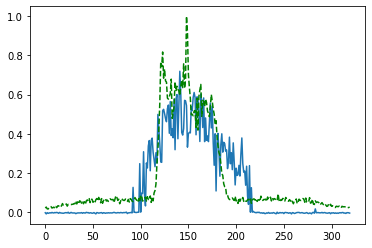

Time taken for epoch:  136.71205830574036
Epoch = [  1/3000]  Iter = [   0/39480]  Loss = 0.2658 Avg Loss = 0.2658  Time = 0.0816s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [  1/3000]  Iter = [ 100/39480]  Loss = 0.2239 Avg Loss = 0.236  Time = 0.0030s
Epoch = [  1/3000]  Iter = [ 200/39480]  Loss = 0.1883 Avg Loss = 0.2246  Time = 0.0031s
Epoch = [  1/3000]  Iter = [ 300/39480]  Loss = 0.2345 Avg Loss = 0.22  Time = 0.0093s
Epoch = [  1/3000]  Iter = [ 400/39480]  Loss = 0.1982 Avg Loss = 0.2189  Time = 0.0020s
Epoch = [  1/3000]  Iter = [ 500/39480]  Loss = 0.24 Avg Loss = 0.2203  Time = 0.0028s
Epoch = [  1/3000]  Iter = [ 600/39480]  Loss = 0.1885 Avg Loss = 0.2146  Time = 0.0019s
Epoch = [  1/3000]  Iter = [ 700/39480]  Loss = 0.2055 Avg Loss = 0.2175  Time = 0.0031s
Epoch = [  1/3000]  Iter = [ 800/39480]  Loss = 0.2205 Avg Loss = 0.2172  Time = 0.0044s
Epoch = [  1/3000]  Iter = [ 900/39480]  Loss = 0.2006 Avg Loss = 0.2186  Time = 0.0033s
Epoch = [  1/3000]  Iter = [1000/39480]  Loss = 0.2054 Avg Loss = 0.2197  Time = 0.0029s
Epoch = [  1/3000]  Iter = [1100/39480]  Loss = 0.2116 Avg Loss = 0.2162  Time = 0.0032s
Epoch = [  1/3000]  Iter =

Epoch = [  1/3000]  Iter = [9400/39480]  Loss = 0.2311 Avg Loss = 0.2212  Time = 0.0027s
Epoch = [  1/3000]  Iter = [9500/39480]  Loss = 0.2206 Avg Loss = 0.2196  Time = 0.0031s
Epoch = [  1/3000]  Iter = [9600/39480]  Loss = 0.2099 Avg Loss = 0.2193  Time = 0.0029s
Epoch = [  1/3000]  Iter = [9700/39480]  Loss = 0.2474 Avg Loss = 0.2233  Time = 0.0024s
Epoch = [  1/3000]  Iter = [9800/39480]  Loss = 0.2146 Avg Loss = 0.2192  Time = 0.0030s
Epoch = [  1/3000]  Iter = [9900/39480]  Loss = 0.1943 Avg Loss = 0.2139  Time = 0.0025s
Epoch = [  1/3000]  Iter = [10000/39480]  Loss = 0.2317 Avg Loss = 0.2253  Time = 0.0032s
Epoch = [  1/3000]  Iter = [10100/39480]  Loss = 0.2512 Avg Loss = 0.2208  Time = 0.0029s
Epoch = [  1/3000]  Iter = [10200/39480]  Loss = 0.2063 Avg Loss = 0.2186  Time = 0.0034s
Epoch = [  1/3000]  Iter = [10300/39480]  Loss = 0.2258 Avg Loss = 0.2159  Time = 0.0027s
Epoch = [  1/3000]  Iter = [10400/39480]  Loss = 0.2414 Avg Loss = 0.2148  Time = 0.0024s
Epoch = [  1/300

Epoch = [  1/3000]  Iter = [18600/39480]  Loss = 0.258 Avg Loss = 0.2185  Time = 0.0025s
Epoch = [  1/3000]  Iter = [18700/39480]  Loss = 0.2463 Avg Loss = 0.2201  Time = 0.0023s
Epoch = [  1/3000]  Iter = [18800/39480]  Loss = 0.2253 Avg Loss = 0.2211  Time = 0.0035s
Epoch = [  1/3000]  Iter = [18900/39480]  Loss = 0.1702 Avg Loss = 0.217  Time = 0.0028s
Epoch = [  1/3000]  Iter = [19000/39480]  Loss = 0.2203 Avg Loss = 0.2218  Time = 0.0021s
Epoch = [  1/3000]  Iter = [19100/39480]  Loss = 0.1856 Avg Loss = 0.2223  Time = 0.0022s
Epoch = [  1/3000]  Iter = [19200/39480]  Loss = 0.2406 Avg Loss = 0.2148  Time = 0.0024s
Epoch = [  1/3000]  Iter = [19300/39480]  Loss = 0.2503 Avg Loss = 0.2155  Time = 0.0029s
Epoch = [  1/3000]  Iter = [19400/39480]  Loss = 0.1926 Avg Loss = 0.2153  Time = 0.0022s
Epoch = [  1/3000]  Iter = [19500/39480]  Loss = 0.2066 Avg Loss = 0.2176  Time = 0.0030s
Epoch = [  1/3000]  Iter = [19600/39480]  Loss = 0.1984 Avg Loss = 0.2217  Time = 0.0024s
Epoch = [  1

Epoch = [  1/3000]  Iter = [27800/39480]  Loss = 0.2163 Avg Loss = 0.215  Time = 0.0037s
Epoch = [  1/3000]  Iter = [27900/39480]  Loss = 0.2135 Avg Loss = 0.2177  Time = 0.0034s
Epoch = [  1/3000]  Iter = [28000/39480]  Loss = 0.2489 Avg Loss = 0.2189  Time = 0.0043s
Epoch = [  1/3000]  Iter = [28100/39480]  Loss = 0.1952 Avg Loss = 0.2206  Time = 0.0034s
Epoch = [  1/3000]  Iter = [28200/39480]  Loss = 0.205 Avg Loss = 0.2152  Time = 0.0036s
Epoch = [  1/3000]  Iter = [28300/39480]  Loss = 0.2243 Avg Loss = 0.2165  Time = 0.0033s
Epoch = [  1/3000]  Iter = [28400/39480]  Loss = 0.1967 Avg Loss = 0.2184  Time = 0.0035s
Epoch = [  1/3000]  Iter = [28500/39480]  Loss = 0.3032 Avg Loss = 0.2176  Time = 0.0036s
Epoch = [  1/3000]  Iter = [28600/39480]  Loss = 0.2122 Avg Loss = 0.2206  Time = 0.0034s
Epoch = [  1/3000]  Iter = [28700/39480]  Loss = 0.2187 Avg Loss = 0.2146  Time = 0.0035s
Epoch = [  1/3000]  Iter = [28800/39480]  Loss = 0.2482 Avg Loss = 0.2186  Time = 0.0033s
Epoch = [  1

Epoch = [  1/3000]  Iter = [37000/39480]  Loss = 0.2113 Avg Loss = 0.2155  Time = 0.0037s
Epoch = [  1/3000]  Iter = [37100/39480]  Loss = 0.2315 Avg Loss = 0.2173  Time = 0.0035s
Epoch = [  1/3000]  Iter = [37200/39480]  Loss = 0.2096 Avg Loss = 0.2178  Time = 0.0034s
Epoch = [  1/3000]  Iter = [37300/39480]  Loss = 0.1972 Avg Loss = 0.2188  Time = 0.0032s
Epoch = [  1/3000]  Iter = [37400/39480]  Loss = 0.1679 Avg Loss = 0.2159  Time = 0.0036s
Epoch = [  1/3000]  Iter = [37500/39480]  Loss = 0.2256 Avg Loss = 0.2173  Time = 0.0032s
Epoch = [  1/3000]  Iter = [37600/39480]  Loss = 0.2431 Avg Loss = 0.2185  Time = 0.0030s
Epoch = [  1/3000]  Iter = [37700/39480]  Loss = 0.2388 Avg Loss = 0.219  Time = 0.0035s
Epoch = [  1/3000]  Iter = [37800/39480]  Loss = 0.2171 Avg Loss = 0.2195  Time = 0.0031s
Epoch = [  1/3000]  Iter = [37900/39480]  Loss = 0.2496 Avg Loss = 0.2167  Time = 0.0039s
Epoch = [  1/3000]  Iter = [38000/39480]  Loss = 0.202 Avg Loss = 0.2172  Time = 0.0032s
Epoch = [  1

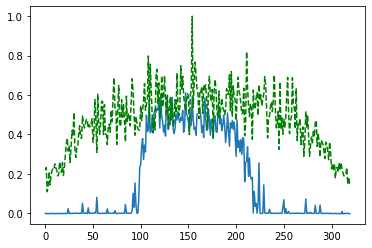

Time taken for epoch:  145.79893732070923
Epoch = [  2/3000]  Iter = [   0/39480]  Loss = 0.2362 Avg Loss = 0.2362  Time = 0.0973s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [  2/3000]  Iter = [ 100/39480]  Loss = 0.2077 Avg Loss = 0.2247  Time = 0.0036s
Epoch = [  2/3000]  Iter = [ 200/39480]  Loss = 0.1894 Avg Loss = 0.2179  Time = 0.0036s
Epoch = [  2/3000]  Iter = [ 300/39480]  Loss = 0.2073 Avg Loss = 0.215  Time = 0.0037s
Epoch = [  2/3000]  Iter = [ 400/39480]  Loss = 0.2015 Avg Loss = 0.2157  Time = 0.0034s
Epoch = [  2/3000]  Iter = [ 500/39480]  Loss = 0.2252 Avg Loss = 0.2181  Time = 0.0037s
Epoch = [  2/3000]  Iter = [ 600/39480]  Loss = 0.2259 Avg Loss = 0.2168  Time = 0.0035s
Epoch = [  2/3000]  Iter = [ 700/39480]  Loss = 0.2098 Avg Loss = 0.2171  Time = 0.0035s
Epoch = [  2/3000]  Iter = [ 800/39480]  Loss = 0.2312 Avg Loss = 0.2205  Time = 0.0032s
Epoch = [  2/3000]  Iter = [ 900/39480]  Loss = 0.2072 Avg Loss = 0.2167  Time = 0.0032s
Epoch = [  2/3000]  Iter = [1000/39480]  Loss = 0.2005 Avg Loss = 0.2142  Time = 0.0035s
Epoch = [  2/3000]  Iter = [1100/39480]  Loss = 0.2722 Avg Loss = 0.2166  Time = 0.0032s
Epoch = [  2/3000]  It

Epoch = [  2/3000]  Iter = [9400/39480]  Loss = 0.2103 Avg Loss = 0.2192  Time = 0.0035s
Epoch = [  2/3000]  Iter = [9500/39480]  Loss = 0.2042 Avg Loss = 0.22  Time = 0.0035s
Epoch = [  2/3000]  Iter = [9600/39480]  Loss = 0.2066 Avg Loss = 0.2161  Time = 0.0034s
Epoch = [  2/3000]  Iter = [9700/39480]  Loss = 0.2243 Avg Loss = 0.2158  Time = 0.0033s
Epoch = [  2/3000]  Iter = [9800/39480]  Loss = 0.2155 Avg Loss = 0.218  Time = 0.0033s
Epoch = [  2/3000]  Iter = [9900/39480]  Loss = 0.2262 Avg Loss = 0.2163  Time = 0.0039s
Epoch = [  2/3000]  Iter = [10000/39480]  Loss = 0.2367 Avg Loss = 0.221  Time = 0.0035s
Epoch = [  2/3000]  Iter = [10100/39480]  Loss = 0.2044 Avg Loss = 0.2231  Time = 0.0039s
Epoch = [  2/3000]  Iter = [10200/39480]  Loss = 0.2183 Avg Loss = 0.2217  Time = 0.0033s
Epoch = [  2/3000]  Iter = [10300/39480]  Loss = 0.1603 Avg Loss = 0.2219  Time = 0.0035s
Epoch = [  2/3000]  Iter = [10400/39480]  Loss = 0.1976 Avg Loss = 0.2201  Time = 0.0033s
Epoch = [  2/3000]  

Epoch = [  2/3000]  Iter = [18600/39480]  Loss = 0.2303 Avg Loss = 0.2158  Time = 0.0035s
Epoch = [  2/3000]  Iter = [18700/39480]  Loss = 0.2438 Avg Loss = 0.2184  Time = 0.0034s
Epoch = [  2/3000]  Iter = [18800/39480]  Loss = 0.2102 Avg Loss = 0.2188  Time = 0.0040s
Epoch = [  2/3000]  Iter = [18900/39480]  Loss = 0.2034 Avg Loss = 0.2166  Time = 0.0032s
Epoch = [  2/3000]  Iter = [19000/39480]  Loss = 0.212 Avg Loss = 0.2187  Time = 0.0031s
Epoch = [  2/3000]  Iter = [19100/39480]  Loss = 0.2009 Avg Loss = 0.2193  Time = 0.0034s
Epoch = [  2/3000]  Iter = [19200/39480]  Loss = 0.2087 Avg Loss = 0.2157  Time = 0.0030s
Epoch = [  2/3000]  Iter = [19300/39480]  Loss = 0.2183 Avg Loss = 0.2177  Time = 0.0034s
Epoch = [  2/3000]  Iter = [19400/39480]  Loss = 0.224 Avg Loss = 0.221  Time = 0.0034s
Epoch = [  2/3000]  Iter = [19500/39480]  Loss = 0.216 Avg Loss = 0.2204  Time = 0.0036s
Epoch = [  2/3000]  Iter = [19600/39480]  Loss = 0.2375 Avg Loss = 0.2203  Time = 0.0032s
Epoch = [  2/3

Epoch = [  2/3000]  Iter = [27800/39480]  Loss = 0.2311 Avg Loss = 0.2198  Time = 0.0034s
Epoch = [  2/3000]  Iter = [27900/39480]  Loss = 0.2195 Avg Loss = 0.2178  Time = 0.0037s
Epoch = [  2/3000]  Iter = [28000/39480]  Loss = 0.2102 Avg Loss = 0.2175  Time = 0.0032s
Epoch = [  2/3000]  Iter = [28100/39480]  Loss = 0.2365 Avg Loss = 0.2205  Time = 0.0034s
Epoch = [  2/3000]  Iter = [28200/39480]  Loss = 0.1943 Avg Loss = 0.2169  Time = 0.0034s
Epoch = [  2/3000]  Iter = [28300/39480]  Loss = 0.1876 Avg Loss = 0.2184  Time = 0.0035s
Epoch = [  2/3000]  Iter = [28400/39480]  Loss = 0.2104 Avg Loss = 0.2181  Time = 0.0033s
Epoch = [  2/3000]  Iter = [28500/39480]  Loss = 0.2215 Avg Loss = 0.2187  Time = 0.0037s
Epoch = [  2/3000]  Iter = [28600/39480]  Loss = 0.2327 Avg Loss = 0.2171  Time = 0.0032s
Epoch = [  2/3000]  Iter = [28700/39480]  Loss = 0.1978 Avg Loss = 0.2194  Time = 0.0048s
Epoch = [  2/3000]  Iter = [28800/39480]  Loss = 0.2266 Avg Loss = 0.219  Time = 0.0032s
Epoch = [  

Epoch = [  2/3000]  Iter = [37000/39480]  Loss = 0.215 Avg Loss = 0.2163  Time = 0.0037s
Epoch = [  2/3000]  Iter = [37100/39480]  Loss = 0.2093 Avg Loss = 0.221  Time = 0.0034s
Epoch = [  2/3000]  Iter = [37200/39480]  Loss = 0.2203 Avg Loss = 0.2203  Time = 0.0032s
Epoch = [  2/3000]  Iter = [37300/39480]  Loss = 0.2472 Avg Loss = 0.2173  Time = 0.0039s
Epoch = [  2/3000]  Iter = [37400/39480]  Loss = 0.2157 Avg Loss = 0.2185  Time = 0.0036s
Epoch = [  2/3000]  Iter = [37500/39480]  Loss = 0.2395 Avg Loss = 0.2239  Time = 0.0035s
Epoch = [  2/3000]  Iter = [37600/39480]  Loss = 0.1806 Avg Loss = 0.2193  Time = 0.0033s
Epoch = [  2/3000]  Iter = [37700/39480]  Loss = 0.192 Avg Loss = 0.2167  Time = 0.0036s
Epoch = [  2/3000]  Iter = [37800/39480]  Loss = 0.1892 Avg Loss = 0.2137  Time = 0.0032s
Epoch = [  2/3000]  Iter = [37900/39480]  Loss = 0.2314 Avg Loss = 0.2156  Time = 0.0036s
Epoch = [  2/3000]  Iter = [38000/39480]  Loss = 0.1956 Avg Loss = 0.218  Time = 0.0034s
Epoch = [  2/3

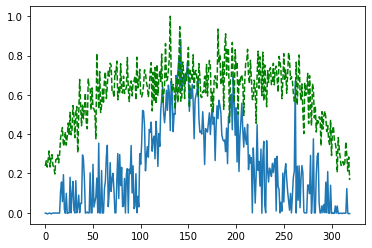

Time taken for epoch:  155.86610651016235
Epoch = [  3/3000]  Iter = [   0/39480]  Loss = 0.2299 Avg Loss = 0.2299  Time = 0.0664s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [  3/3000]  Iter = [ 100/39480]  Loss = 0.2019 Avg Loss = 0.2206  Time = 0.0032s
Epoch = [  3/3000]  Iter = [ 200/39480]  Loss = 0.1971 Avg Loss = 0.2198  Time = 0.0036s
Epoch = [  3/3000]  Iter = [ 300/39480]  Loss = 0.2764 Avg Loss = 0.2298  Time = 0.0037s
Epoch = [  3/3000]  Iter = [ 400/39480]  Loss = 0.2271 Avg Loss = 0.2197  Time = 0.0035s
Epoch = [  3/3000]  Iter = [ 500/39480]  Loss = 0.2319 Avg Loss = 0.2152  Time = 0.0033s
Epoch = [  3/3000]  Iter = [ 600/39480]  Loss = 0.2541 Avg Loss = 0.2189  Time = 0.0034s
Epoch = [  3/3000]  Iter = [ 700/39480]  Loss = 0.2506 Avg Loss = 0.2186  Time = 0.0034s
Epoch = [  3/3000]  Iter = [ 800/39480]  Loss = 0.2382 Avg Loss = 0.2184  Time = 0.0032s
Epoch = [  3/3000]  Iter = [ 900/39480]  Loss = 0.2379 Avg Loss = 0.2172  Time = 0.0036s
Epoch = [  3/3000]  Iter = [1000/39480]  Loss = 0.2307 Avg Loss = 0.2182  Time = 0.0035s
Epoch = [  3/3000]  Iter = [1100/39480]  Loss = 0.2102 Avg Loss = 0.2189  Time = 0.0035s
Epoch = [  3/3000]  I

Epoch = [  3/3000]  Iter = [9400/39480]  Loss = 0.2609 Avg Loss = 0.2152  Time = 0.0036s
Epoch = [  3/3000]  Iter = [9500/39480]  Loss = 0.2213 Avg Loss = 0.2179  Time = 0.0034s
Epoch = [  3/3000]  Iter = [9600/39480]  Loss = 0.1996 Avg Loss = 0.2171  Time = 0.0033s
Epoch = [  3/3000]  Iter = [9700/39480]  Loss = 0.2222 Avg Loss = 0.2184  Time = 0.0034s
Epoch = [  3/3000]  Iter = [9800/39480]  Loss = 0.1714 Avg Loss = 0.2213  Time = 0.0036s
Epoch = [  3/3000]  Iter = [9900/39480]  Loss = 0.1995 Avg Loss = 0.218  Time = 0.0034s
Epoch = [  3/3000]  Iter = [10000/39480]  Loss = 0.2191 Avg Loss = 0.2173  Time = 0.0036s
Epoch = [  3/3000]  Iter = [10100/39480]  Loss = 0.2005 Avg Loss = 0.2185  Time = 0.0030s
Epoch = [  3/3000]  Iter = [10200/39480]  Loss = 0.1531 Avg Loss = 0.2168  Time = 0.0032s
Epoch = [  3/3000]  Iter = [10300/39480]  Loss = 0.2357 Avg Loss = 0.2181  Time = 0.0035s
Epoch = [  3/3000]  Iter = [10400/39480]  Loss = 0.331 Avg Loss = 0.2188  Time = 0.0033s
Epoch = [  3/3000]

Epoch = [  3/3000]  Iter = [18600/39480]  Loss = 0.2276 Avg Loss = 0.2182  Time = 0.0036s
Epoch = [  3/3000]  Iter = [18700/39480]  Loss = 0.2123 Avg Loss = 0.2175  Time = 0.0035s
Epoch = [  3/3000]  Iter = [18800/39480]  Loss = 0.2143 Avg Loss = 0.2212  Time = 0.0036s
Epoch = [  3/3000]  Iter = [18900/39480]  Loss = 0.1957 Avg Loss = 0.2166  Time = 0.0035s
Epoch = [  3/3000]  Iter = [19000/39480]  Loss = 0.1951 Avg Loss = 0.2146  Time = 0.0033s
Epoch = [  3/3000]  Iter = [19100/39480]  Loss = 0.2422 Avg Loss = 0.2183  Time = 0.0035s
Epoch = [  3/3000]  Iter = [19200/39480]  Loss = 0.1936 Avg Loss = 0.2177  Time = 0.0034s
Epoch = [  3/3000]  Iter = [19300/39480]  Loss = 0.2049 Avg Loss = 0.2216  Time = 0.0032s
Epoch = [  3/3000]  Iter = [19400/39480]  Loss = 0.1961 Avg Loss = 0.2175  Time = 0.0034s
Epoch = [  3/3000]  Iter = [19500/39480]  Loss = 0.1936 Avg Loss = 0.2155  Time = 0.0053s
Epoch = [  3/3000]  Iter = [19600/39480]  Loss = 0.2525 Avg Loss = 0.2174  Time = 0.0033s
Epoch = [ 

Epoch = [  3/3000]  Iter = [27800/39480]  Loss = 0.2229 Avg Loss = 0.2193  Time = 0.0033s
Epoch = [  3/3000]  Iter = [27900/39480]  Loss = 0.2027 Avg Loss = 0.2186  Time = 0.0032s
Epoch = [  3/3000]  Iter = [28000/39480]  Loss = 0.19 Avg Loss = 0.2165  Time = 0.0033s
Epoch = [  3/3000]  Iter = [28100/39480]  Loss = 0.1809 Avg Loss = 0.2202  Time = 0.0032s
Epoch = [  3/3000]  Iter = [28200/39480]  Loss = 0.175 Avg Loss = 0.2164  Time = 0.0033s
Epoch = [  3/3000]  Iter = [28300/39480]  Loss = 0.1951 Avg Loss = 0.2155  Time = 0.0036s
Epoch = [  3/3000]  Iter = [28400/39480]  Loss = 0.1972 Avg Loss = 0.2139  Time = 0.0036s
Epoch = [  3/3000]  Iter = [28500/39480]  Loss = 0.2103 Avg Loss = 0.2181  Time = 0.0034s
Epoch = [  3/3000]  Iter = [28600/39480]  Loss = 0.2476 Avg Loss = 0.225  Time = 0.0043s
Epoch = [  3/3000]  Iter = [28700/39480]  Loss = 0.1873 Avg Loss = 0.2197  Time = 0.0032s
Epoch = [  3/3000]  Iter = [28800/39480]  Loss = 0.2278 Avg Loss = 0.2203  Time = 0.0044s
Epoch = [  3/3

Epoch = [  3/3000]  Iter = [37000/39480]  Loss = 0.1946 Avg Loss = 0.2156  Time = 0.0045s
Epoch = [  3/3000]  Iter = [37100/39480]  Loss = 0.2029 Avg Loss = 0.2161  Time = 0.0029s
Epoch = [  3/3000]  Iter = [37200/39480]  Loss = 0.2021 Avg Loss = 0.2164  Time = 0.0038s
Epoch = [  3/3000]  Iter = [37300/39480]  Loss = 0.2056 Avg Loss = 0.2184  Time = 0.0032s
Epoch = [  3/3000]  Iter = [37400/39480]  Loss = 0.2334 Avg Loss = 0.2177  Time = 0.0041s
Epoch = [  3/3000]  Iter = [37500/39480]  Loss = 0.2343 Avg Loss = 0.2209  Time = 0.0030s
Epoch = [  3/3000]  Iter = [37600/39480]  Loss = 0.242 Avg Loss = 0.2197  Time = 0.0033s
Epoch = [  3/3000]  Iter = [37700/39480]  Loss = 0.2096 Avg Loss = 0.2214  Time = 0.0034s
Epoch = [  3/3000]  Iter = [37800/39480]  Loss = 0.1981 Avg Loss = 0.2161  Time = 0.0036s
Epoch = [  3/3000]  Iter = [37900/39480]  Loss = 0.1797 Avg Loss = 0.2199  Time = 0.0036s
Epoch = [  3/3000]  Iter = [38000/39480]  Loss = 0.2384 Avg Loss = 0.2198  Time = 0.0033s
Epoch = [  

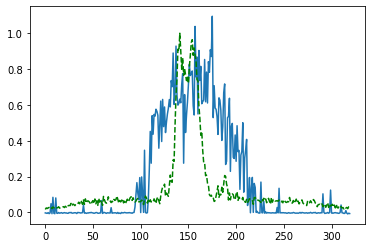

Time taken for epoch:  156.3056993484497
Epoch = [  4/3000]  Iter = [   0/39480]  Loss = 0.208 Avg Loss = 0.208  Time = 0.1003s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [  4/3000]  Iter = [ 100/39480]  Loss = 0.2268 Avg Loss = 0.2155  Time = 0.0033s
Epoch = [  4/3000]  Iter = [ 200/39480]  Loss = 0.2052 Avg Loss = 0.2175  Time = 0.0032s
Epoch = [  4/3000]  Iter = [ 300/39480]  Loss = 0.187 Avg Loss = 0.2167  Time = 0.0030s
Epoch = [  4/3000]  Iter = [ 400/39480]  Loss = 0.2442 Avg Loss = 0.2114  Time = 0.0039s
Epoch = [  4/3000]  Iter = [ 500/39480]  Loss = 0.2104 Avg Loss = 0.2167  Time = 0.0032s
Epoch = [  4/3000]  Iter = [ 600/39480]  Loss = 0.2094 Avg Loss = 0.2175  Time = 0.0035s
Epoch = [  4/3000]  Iter = [ 700/39480]  Loss = 0.1956 Avg Loss = 0.2155  Time = 0.0041s
Epoch = [  4/3000]  Iter = [ 800/39480]  Loss = 0.2318 Avg Loss = 0.218  Time = 0.0036s
Epoch = [  4/3000]  Iter = [ 900/39480]  Loss = 0.2292 Avg Loss = 0.2157  Time = 0.0034s
Epoch = [  4/3000]  Iter = [1000/39480]  Loss = 0.2462 Avg Loss = 0.2153  Time = 0.0034s
Epoch = [  4/3000]  Iter = [1100/39480]  Loss = 0.2143 Avg Loss = 0.2191  Time = 0.0034s
Epoch = [  4/3000]  Ite

Epoch = [  4/3000]  Iter = [9400/39480]  Loss = 0.1987 Avg Loss = 0.2182  Time = 0.0064s
Epoch = [  4/3000]  Iter = [9500/39480]  Loss = 0.235 Avg Loss = 0.2172  Time = 0.0032s
Epoch = [  4/3000]  Iter = [9600/39480]  Loss = 0.2589 Avg Loss = 0.2197  Time = 0.0037s
Epoch = [  4/3000]  Iter = [9700/39480]  Loss = 0.2038 Avg Loss = 0.2151  Time = 0.0051s
Epoch = [  4/3000]  Iter = [9800/39480]  Loss = 0.2983 Avg Loss = 0.2165  Time = 0.0036s
Epoch = [  4/3000]  Iter = [9900/39480]  Loss = 0.2049 Avg Loss = 0.215  Time = 0.0035s
Epoch = [  4/3000]  Iter = [10000/39480]  Loss = 0.2332 Avg Loss = 0.2175  Time = 0.0034s
Epoch = [  4/3000]  Iter = [10100/39480]  Loss = 0.2327 Avg Loss = 0.2178  Time = 0.0031s
Epoch = [  4/3000]  Iter = [10200/39480]  Loss = 0.2237 Avg Loss = 0.2212  Time = 0.0040s
Epoch = [  4/3000]  Iter = [10300/39480]  Loss = 0.1943 Avg Loss = 0.2169  Time = 0.0034s
Epoch = [  4/3000]  Iter = [10400/39480]  Loss = 0.2024 Avg Loss = 0.2219  Time = 0.0039s
Epoch = [  4/3000]

Epoch = [  4/3000]  Iter = [18600/39480]  Loss = 0.2238 Avg Loss = 0.2197  Time = 0.0033s
Epoch = [  4/3000]  Iter = [18700/39480]  Loss = 0.1787 Avg Loss = 0.2216  Time = 0.0037s
Epoch = [  4/3000]  Iter = [18800/39480]  Loss = 0.2121 Avg Loss = 0.2186  Time = 0.0035s
Epoch = [  4/3000]  Iter = [18900/39480]  Loss = 0.2131 Avg Loss = 0.2205  Time = 0.0034s
Epoch = [  4/3000]  Iter = [19000/39480]  Loss = 0.2199 Avg Loss = 0.2178  Time = 0.0034s
Epoch = [  4/3000]  Iter = [19100/39480]  Loss = 0.1967 Avg Loss = 0.2142  Time = 0.0036s
Epoch = [  4/3000]  Iter = [19200/39480]  Loss = 0.1917 Avg Loss = 0.2213  Time = 0.0033s
Epoch = [  4/3000]  Iter = [19300/39480]  Loss = 0.1715 Avg Loss = 0.2153  Time = 0.0040s
Epoch = [  4/3000]  Iter = [19400/39480]  Loss = 0.182 Avg Loss = 0.2173  Time = 0.0034s
Epoch = [  4/3000]  Iter = [19500/39480]  Loss = 0.1964 Avg Loss = 0.2192  Time = 0.0034s
Epoch = [  4/3000]  Iter = [19600/39480]  Loss = 0.1965 Avg Loss = 0.2243  Time = 0.0035s
Epoch = [  

Epoch = [  4/3000]  Iter = [27800/39480]  Loss = 0.2158 Avg Loss = 0.2189  Time = 0.0040s
Epoch = [  4/3000]  Iter = [27900/39480]  Loss = 0.2124 Avg Loss = 0.2169  Time = 0.0035s
Epoch = [  4/3000]  Iter = [28000/39480]  Loss = 0.2206 Avg Loss = 0.2161  Time = 0.0036s
Epoch = [  4/3000]  Iter = [28100/39480]  Loss = 0.2323 Avg Loss = 0.2226  Time = 0.0033s
Epoch = [  4/3000]  Iter = [28200/39480]  Loss = 0.2047 Avg Loss = 0.2197  Time = 0.0035s
Epoch = [  4/3000]  Iter = [28300/39480]  Loss = 0.2122 Avg Loss = 0.2216  Time = 0.0035s
Epoch = [  4/3000]  Iter = [28400/39480]  Loss = 0.2002 Avg Loss = 0.2189  Time = 0.0031s
Epoch = [  4/3000]  Iter = [28500/39480]  Loss = 0.252 Avg Loss = 0.2198  Time = 0.0034s
Epoch = [  4/3000]  Iter = [28600/39480]  Loss = 0.2171 Avg Loss = 0.2169  Time = 0.0036s
Epoch = [  4/3000]  Iter = [28700/39480]  Loss = 0.2096 Avg Loss = 0.2172  Time = 0.0029s
Epoch = [  4/3000]  Iter = [28800/39480]  Loss = 0.201 Avg Loss = 0.2185  Time = 0.0036s
Epoch = [  4

Epoch = [  4/3000]  Iter = [37000/39480]  Loss = 0.2119 Avg Loss = 0.22  Time = 0.0044s
Epoch = [  4/3000]  Iter = [37100/39480]  Loss = 0.2091 Avg Loss = 0.2178  Time = 0.0034s
Epoch = [  4/3000]  Iter = [37200/39480]  Loss = 0.1737 Avg Loss = 0.217  Time = 0.0035s
Epoch = [  4/3000]  Iter = [37300/39480]  Loss = 0.21 Avg Loss = 0.2162  Time = 0.0036s
Epoch = [  4/3000]  Iter = [37400/39480]  Loss = 0.2321 Avg Loss = 0.2155  Time = 0.0034s
Epoch = [  4/3000]  Iter = [37500/39480]  Loss = 0.2085 Avg Loss = 0.216  Time = 0.0033s
Epoch = [  4/3000]  Iter = [37600/39480]  Loss = 0.2135 Avg Loss = 0.2164  Time = 0.0045s
Epoch = [  4/3000]  Iter = [37700/39480]  Loss = 0.2408 Avg Loss = 0.221  Time = 0.0034s
Epoch = [  4/3000]  Iter = [37800/39480]  Loss = 0.2286 Avg Loss = 0.2178  Time = 0.0037s
Epoch = [  4/3000]  Iter = [37900/39480]  Loss = 0.2313 Avg Loss = 0.2204  Time = 0.0035s
Epoch = [  4/3000]  Iter = [38000/39480]  Loss = 0.2344 Avg Loss = 0.2185  Time = 0.0038s
Epoch = [  4/3000

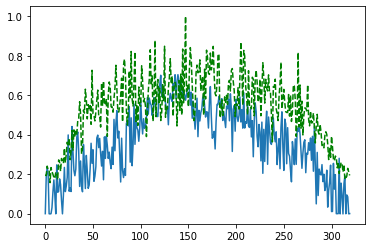

Time taken for epoch:  156.56534147262573
Epoch = [  5/3000]  Iter = [   0/39480]  Loss = 0.2458 Avg Loss = 0.2458  Time = 0.1082s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [  5/3000]  Iter = [ 100/39480]  Loss = 0.1901 Avg Loss = 0.2274  Time = 0.0032s
Epoch = [  5/3000]  Iter = [ 200/39480]  Loss = 0.2071 Avg Loss = 0.2241  Time = 0.0038s
Epoch = [  5/3000]  Iter = [ 300/39480]  Loss = 0.2263 Avg Loss = 0.2265  Time = 0.0034s
Epoch = [  5/3000]  Iter = [ 400/39480]  Loss = 0.1994 Avg Loss = 0.2206  Time = 0.0032s
Epoch = [  5/3000]  Iter = [ 500/39480]  Loss = 0.1965 Avg Loss = 0.2151  Time = 0.0034s
Epoch = [  5/3000]  Iter = [ 600/39480]  Loss = 0.2127 Avg Loss = 0.2165  Time = 0.0036s
Epoch = [  5/3000]  Iter = [ 700/39480]  Loss = 0.212 Avg Loss = 0.2144  Time = 0.0036s
Epoch = [  5/3000]  Iter = [ 800/39480]  Loss = 0.2138 Avg Loss = 0.2211  Time = 0.0036s
Epoch = [  5/3000]  Iter = [ 900/39480]  Loss = 0.2025 Avg Loss = 0.217  Time = 0.0043s
Epoch = [  5/3000]  Iter = [1000/39480]  Loss = 0.2426 Avg Loss = 0.2169  Time = 0.0036s
Epoch = [  5/3000]  Iter = [1100/39480]  Loss = 0.2013 Avg Loss = 0.2194  Time = 0.0031s
Epoch = [  5/3000]  Ite

Epoch = [  5/3000]  Iter = [9400/39480]  Loss = 0.235 Avg Loss = 0.2165  Time = 0.0036s
Epoch = [  5/3000]  Iter = [9500/39480]  Loss = 0.2186 Avg Loss = 0.2177  Time = 0.0031s
Epoch = [  5/3000]  Iter = [9600/39480]  Loss = 0.2545 Avg Loss = 0.2154  Time = 0.0030s
Epoch = [  5/3000]  Iter = [9700/39480]  Loss = 0.1836 Avg Loss = 0.2148  Time = 0.0033s
Epoch = [  5/3000]  Iter = [9800/39480]  Loss = 0.2204 Avg Loss = 0.2177  Time = 0.0035s
Epoch = [  5/3000]  Iter = [9900/39480]  Loss = 0.2278 Avg Loss = 0.2209  Time = 0.0035s
Epoch = [  5/3000]  Iter = [10000/39480]  Loss = 0.2337 Avg Loss = 0.2176  Time = 0.0035s
Epoch = [  5/3000]  Iter = [10100/39480]  Loss = 0.2247 Avg Loss = 0.2172  Time = 0.0034s
Epoch = [  5/3000]  Iter = [10200/39480]  Loss = 0.1977 Avg Loss = 0.2164  Time = 0.0036s
Epoch = [  5/3000]  Iter = [10300/39480]  Loss = 0.2125 Avg Loss = 0.2201  Time = 0.0035s
Epoch = [  5/3000]  Iter = [10400/39480]  Loss = 0.2112 Avg Loss = 0.2161  Time = 0.0035s
Epoch = [  5/3000

Epoch = [  5/3000]  Iter = [18600/39480]  Loss = 0.2159 Avg Loss = 0.2184  Time = 0.0035s
Epoch = [  5/3000]  Iter = [18700/39480]  Loss = 0.2137 Avg Loss = 0.218  Time = 0.0035s
Epoch = [  5/3000]  Iter = [18800/39480]  Loss = 0.2149 Avg Loss = 0.2163  Time = 0.0033s
Epoch = [  5/3000]  Iter = [18900/39480]  Loss = 0.2164 Avg Loss = 0.2204  Time = 0.0033s
Epoch = [  5/3000]  Iter = [19000/39480]  Loss = 0.1717 Avg Loss = 0.2188  Time = 0.0034s
Epoch = [  5/3000]  Iter = [19100/39480]  Loss = 0.2589 Avg Loss = 0.2205  Time = 0.0035s
Epoch = [  5/3000]  Iter = [19200/39480]  Loss = 0.2359 Avg Loss = 0.2165  Time = 0.0033s
Epoch = [  5/3000]  Iter = [19300/39480]  Loss = 0.2089 Avg Loss = 0.2186  Time = 0.0036s
Epoch = [  5/3000]  Iter = [19400/39480]  Loss = 0.2313 Avg Loss = 0.218  Time = 0.0031s
Epoch = [  5/3000]  Iter = [19500/39480]  Loss = 0.2411 Avg Loss = 0.2189  Time = 0.0034s
Epoch = [  5/3000]  Iter = [19600/39480]  Loss = 0.22 Avg Loss = 0.2167  Time = 0.0032s
Epoch = [  5/3

Epoch = [  5/3000]  Iter = [27800/39480]  Loss = 0.238 Avg Loss = 0.218  Time = 0.0033s
Epoch = [  5/3000]  Iter = [27900/39480]  Loss = 0.2178 Avg Loss = 0.2162  Time = 0.0041s
Epoch = [  5/3000]  Iter = [28000/39480]  Loss = 0.1578 Avg Loss = 0.2165  Time = 0.0035s
Epoch = [  5/3000]  Iter = [28100/39480]  Loss = 0.1973 Avg Loss = 0.2157  Time = 0.0035s
Epoch = [  5/3000]  Iter = [28200/39480]  Loss = 0.2009 Avg Loss = 0.2178  Time = 0.0031s
Epoch = [  5/3000]  Iter = [28300/39480]  Loss = 0.2423 Avg Loss = 0.2208  Time = 0.0037s
Epoch = [  5/3000]  Iter = [28400/39480]  Loss = 0.2282 Avg Loss = 0.2245  Time = 0.0033s
Epoch = [  5/3000]  Iter = [28500/39480]  Loss = 0.1937 Avg Loss = 0.217  Time = 0.0034s
Epoch = [  5/3000]  Iter = [28600/39480]  Loss = 0.2298 Avg Loss = 0.219  Time = 0.0030s
Epoch = [  5/3000]  Iter = [28700/39480]  Loss = 0.1766 Avg Loss = 0.2192  Time = 0.0030s
Epoch = [  5/3000]  Iter = [28800/39480]  Loss = 0.1916 Avg Loss = 0.2164  Time = 0.0036s
Epoch = [  5/3

Epoch = [  5/3000]  Iter = [37000/39480]  Loss = 0.2187 Avg Loss = 0.2157  Time = 0.0033s
Epoch = [  5/3000]  Iter = [37100/39480]  Loss = 0.192 Avg Loss = 0.2156  Time = 0.0036s
Epoch = [  5/3000]  Iter = [37200/39480]  Loss = 0.2216 Avg Loss = 0.2178  Time = 0.0036s
Epoch = [  5/3000]  Iter = [37300/39480]  Loss = 0.2036 Avg Loss = 0.2207  Time = 0.0043s
Epoch = [  5/3000]  Iter = [37400/39480]  Loss = 0.2051 Avg Loss = 0.2186  Time = 0.0035s
Epoch = [  5/3000]  Iter = [37500/39480]  Loss = 0.1771 Avg Loss = 0.2174  Time = 0.0037s
Epoch = [  5/3000]  Iter = [37600/39480]  Loss = 0.2206 Avg Loss = 0.2186  Time = 0.0036s
Epoch = [  5/3000]  Iter = [37700/39480]  Loss = 0.1935 Avg Loss = 0.2187  Time = 0.0034s
Epoch = [  5/3000]  Iter = [37800/39480]  Loss = 0.2701 Avg Loss = 0.2197  Time = 0.0033s
Epoch = [  5/3000]  Iter = [37900/39480]  Loss = 0.2006 Avg Loss = 0.2171  Time = 0.0032s
Epoch = [  5/3000]  Iter = [38000/39480]  Loss = 0.2417 Avg Loss = 0.2237  Time = 0.0035s
Epoch = [  

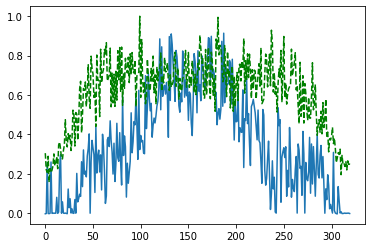

Time taken for epoch:  155.5069224834442
Epoch = [  6/3000]  Iter = [   0/39480]  Loss = 0.2242 Avg Loss = 0.2242  Time = 0.0983s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [  6/3000]  Iter = [ 100/39480]  Loss = 0.2526 Avg Loss = 0.2239  Time = 0.0036s
Epoch = [  6/3000]  Iter = [ 200/39480]  Loss = 0.2519 Avg Loss = 0.2208  Time = 0.0039s
Epoch = [  6/3000]  Iter = [ 300/39480]  Loss = 0.193 Avg Loss = 0.2182  Time = 0.0037s
Epoch = [  6/3000]  Iter = [ 400/39480]  Loss = 0.2352 Avg Loss = 0.2189  Time = 0.0035s
Epoch = [  6/3000]  Iter = [ 500/39480]  Loss = 0.2122 Avg Loss = 0.2153  Time = 0.0035s
Epoch = [  6/3000]  Iter = [ 600/39480]  Loss = 0.21 Avg Loss = 0.2193  Time = 0.0036s
Epoch = [  6/3000]  Iter = [ 700/39480]  Loss = 0.255 Avg Loss = 0.2143  Time = 0.0034s
Epoch = [  6/3000]  Iter = [ 800/39480]  Loss = 0.1943 Avg Loss = 0.2153  Time = 0.0035s
Epoch = [  6/3000]  Iter = [ 900/39480]  Loss = 0.1742 Avg Loss = 0.2183  Time = 0.0035s
Epoch = [  6/3000]  Iter = [1000/39480]  Loss = 0.1898 Avg Loss = 0.2168  Time = 0.0035s
Epoch = [  6/3000]  Iter = [1100/39480]  Loss = 0.2042 Avg Loss = 0.217  Time = 0.0034s
Epoch = [  6/3000]  Iter =

Epoch = [  6/3000]  Iter = [9400/39480]  Loss = 0.2363 Avg Loss = 0.2203  Time = 0.0030s
Epoch = [  6/3000]  Iter = [9500/39480]  Loss = 0.2147 Avg Loss = 0.2196  Time = 0.0033s
Epoch = [  6/3000]  Iter = [9600/39480]  Loss = 0.2137 Avg Loss = 0.2162  Time = 0.0033s
Epoch = [  6/3000]  Iter = [9700/39480]  Loss = 0.2206 Avg Loss = 0.216  Time = 0.0032s
Epoch = [  6/3000]  Iter = [9800/39480]  Loss = 0.2574 Avg Loss = 0.2202  Time = 0.0031s
Epoch = [  6/3000]  Iter = [9900/39480]  Loss = 0.2123 Avg Loss = 0.2182  Time = 0.0033s
Epoch = [  6/3000]  Iter = [10000/39480]  Loss = 0.2264 Avg Loss = 0.2157  Time = 0.0033s
Epoch = [  6/3000]  Iter = [10100/39480]  Loss = 0.1866 Avg Loss = 0.2159  Time = 0.0033s
Epoch = [  6/3000]  Iter = [10200/39480]  Loss = 0.2064 Avg Loss = 0.2144  Time = 0.0046s
Epoch = [  6/3000]  Iter = [10300/39480]  Loss = 0.2168 Avg Loss = 0.221  Time = 0.0035s
Epoch = [  6/3000]  Iter = [10400/39480]  Loss = 0.2138 Avg Loss = 0.2216  Time = 0.0036s
Epoch = [  6/3000]

Epoch = [  6/3000]  Iter = [18600/39480]  Loss = 0.228 Avg Loss = 0.2238  Time = 0.0030s
Epoch = [  6/3000]  Iter = [18700/39480]  Loss = 0.1739 Avg Loss = 0.2171  Time = 0.0033s
Epoch = [  6/3000]  Iter = [18800/39480]  Loss = 0.185 Avg Loss = 0.2142  Time = 0.0036s
Epoch = [  6/3000]  Iter = [18900/39480]  Loss = 0.2609 Avg Loss = 0.2172  Time = 0.0035s
Epoch = [  6/3000]  Iter = [19000/39480]  Loss = 0.2506 Avg Loss = 0.2161  Time = 0.0035s
Epoch = [  6/3000]  Iter = [19100/39480]  Loss = 0.2468 Avg Loss = 0.2194  Time = 0.0035s
Epoch = [  6/3000]  Iter = [19200/39480]  Loss = 0.2206 Avg Loss = 0.2177  Time = 0.0033s
Epoch = [  6/3000]  Iter = [19300/39480]  Loss = 0.2214 Avg Loss = 0.2193  Time = 0.0034s
Epoch = [  6/3000]  Iter = [19400/39480]  Loss = 0.2182 Avg Loss = 0.2206  Time = 0.0038s
Epoch = [  6/3000]  Iter = [19500/39480]  Loss = 0.2119 Avg Loss = 0.2176  Time = 0.0035s
Epoch = [  6/3000]  Iter = [19600/39480]  Loss = 0.2014 Avg Loss = 0.2188  Time = 0.0036s
Epoch = [  6

Epoch = [  6/3000]  Iter = [27800/39480]  Loss = 0.2166 Avg Loss = 0.2219  Time = 0.0037s
Epoch = [  6/3000]  Iter = [27900/39480]  Loss = 0.2872 Avg Loss = 0.2176  Time = 0.0033s
Epoch = [  6/3000]  Iter = [28000/39480]  Loss = 0.2063 Avg Loss = 0.2154  Time = 0.0035s
Epoch = [  6/3000]  Iter = [28100/39480]  Loss = 0.2557 Avg Loss = 0.2141  Time = 0.0036s
Epoch = [  6/3000]  Iter = [28200/39480]  Loss = 0.2162 Avg Loss = 0.2184  Time = 0.0038s
Epoch = [  6/3000]  Iter = [28300/39480]  Loss = 0.2196 Avg Loss = 0.2196  Time = 0.0031s
Epoch = [  6/3000]  Iter = [28400/39480]  Loss = 0.2484 Avg Loss = 0.2157  Time = 0.0037s
Epoch = [  6/3000]  Iter = [28500/39480]  Loss = 0.205 Avg Loss = 0.2196  Time = 0.0042s
Epoch = [  6/3000]  Iter = [28600/39480]  Loss = 0.2261 Avg Loss = 0.2229  Time = 0.0038s
Epoch = [  6/3000]  Iter = [28700/39480]  Loss = 0.207 Avg Loss = 0.216  Time = 0.0030s
Epoch = [  6/3000]  Iter = [28800/39480]  Loss = 0.1905 Avg Loss = 0.2193  Time = 0.0035s
Epoch = [  6/

Epoch = [  6/3000]  Iter = [37000/39480]  Loss = 0.2009 Avg Loss = 0.2171  Time = 0.0036s
Epoch = [  6/3000]  Iter = [37100/39480]  Loss = 0.2346 Avg Loss = 0.2168  Time = 0.0035s
Epoch = [  6/3000]  Iter = [37200/39480]  Loss = 0.238 Avg Loss = 0.2198  Time = 0.0036s
Epoch = [  6/3000]  Iter = [37300/39480]  Loss = 0.2487 Avg Loss = 0.2219  Time = 0.0032s
Epoch = [  6/3000]  Iter = [37400/39480]  Loss = 0.1965 Avg Loss = 0.2184  Time = 0.0035s
Epoch = [  6/3000]  Iter = [37500/39480]  Loss = 0.2053 Avg Loss = 0.2182  Time = 0.0032s
Epoch = [  6/3000]  Iter = [37600/39480]  Loss = 0.2225 Avg Loss = 0.2172  Time = 0.0038s
Epoch = [  6/3000]  Iter = [37700/39480]  Loss = 0.2276 Avg Loss = 0.2156  Time = 0.0034s
Epoch = [  6/3000]  Iter = [37800/39480]  Loss = 0.194 Avg Loss = 0.2194  Time = 0.0035s
Epoch = [  6/3000]  Iter = [37900/39480]  Loss = 0.2145 Avg Loss = 0.2142  Time = 0.0033s
Epoch = [  6/3000]  Iter = [38000/39480]  Loss = 0.1935 Avg Loss = 0.2155  Time = 0.0034s
Epoch = [  6

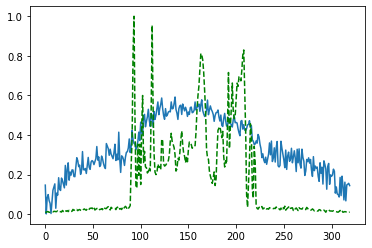

Time taken for epoch:  155.75229907035828
Epoch = [  7/3000]  Iter = [   0/39480]  Loss = 0.2083 Avg Loss = 0.2083  Time = 0.0888s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [  7/3000]  Iter = [ 100/39480]  Loss = 0.1974 Avg Loss = 0.2166  Time = 0.0032s
Epoch = [  7/3000]  Iter = [ 200/39480]  Loss = 0.247 Avg Loss = 0.2158  Time = 0.0037s
Epoch = [  7/3000]  Iter = [ 300/39480]  Loss = 0.1903 Avg Loss = 0.2114  Time = 0.0036s
Epoch = [  7/3000]  Iter = [ 400/39480]  Loss = 0.1835 Avg Loss = 0.2144  Time = 0.0050s
Epoch = [  7/3000]  Iter = [ 500/39480]  Loss = 0.1972 Avg Loss = 0.2144  Time = 0.0035s
Epoch = [  7/3000]  Iter = [ 600/39480]  Loss = 0.2131 Avg Loss = 0.2167  Time = 0.0050s
Epoch = [  7/3000]  Iter = [ 700/39480]  Loss = 0.242 Avg Loss = 0.2167  Time = 0.0029s
Epoch = [  7/3000]  Iter = [ 800/39480]  Loss = 0.2486 Avg Loss = 0.2195  Time = 0.0034s
Epoch = [  7/3000]  Iter = [ 900/39480]  Loss = 0.2269 Avg Loss = 0.2242  Time = 0.0033s
Epoch = [  7/3000]  Iter = [1000/39480]  Loss = 0.245 Avg Loss = 0.2199  Time = 0.0040s
Epoch = [  7/3000]  Iter = [1100/39480]  Loss = 0.2108 Avg Loss = 0.2186  Time = 0.0034s
Epoch = [  7/3000]  Iter

Epoch = [  7/3000]  Iter = [9400/39480]  Loss = 0.1902 Avg Loss = 0.2173  Time = 0.0037s
Epoch = [  7/3000]  Iter = [9500/39480]  Loss = 0.1833 Avg Loss = 0.217  Time = 0.0037s
Epoch = [  7/3000]  Iter = [9600/39480]  Loss = 0.1865 Avg Loss = 0.2158  Time = 0.0034s
Epoch = [  7/3000]  Iter = [9700/39480]  Loss = 0.1898 Avg Loss = 0.2209  Time = 0.0036s
Epoch = [  7/3000]  Iter = [9800/39480]  Loss = 0.1904 Avg Loss = 0.2167  Time = 0.0035s
Epoch = [  7/3000]  Iter = [9900/39480]  Loss = 0.232 Avg Loss = 0.2196  Time = 0.0033s
Epoch = [  7/3000]  Iter = [10000/39480]  Loss = 0.1832 Avg Loss = 0.2172  Time = 0.0032s
Epoch = [  7/3000]  Iter = [10100/39480]  Loss = 0.237 Avg Loss = 0.2172  Time = 0.0034s
Epoch = [  7/3000]  Iter = [10200/39480]  Loss = 0.2629 Avg Loss = 0.2196  Time = 0.0033s
Epoch = [  7/3000]  Iter = [10300/39480]  Loss = 0.2651 Avg Loss = 0.2192  Time = 0.0035s
Epoch = [  7/3000]  Iter = [10400/39480]  Loss = 0.2716 Avg Loss = 0.2215  Time = 0.0033s
Epoch = [  7/3000] 

Epoch = [  7/3000]  Iter = [18600/39480]  Loss = 0.1781 Avg Loss = 0.2199  Time = 0.0034s
Epoch = [  7/3000]  Iter = [18700/39480]  Loss = 0.2014 Avg Loss = 0.2182  Time = 0.0033s
Epoch = [  7/3000]  Iter = [18800/39480]  Loss = 0.2344 Avg Loss = 0.2146  Time = 0.0044s
Epoch = [  7/3000]  Iter = [18900/39480]  Loss = 0.2237 Avg Loss = 0.2173  Time = 0.0032s
Epoch = [  7/3000]  Iter = [19000/39480]  Loss = 0.1869 Avg Loss = 0.2168  Time = 0.0032s
Epoch = [  7/3000]  Iter = [19100/39480]  Loss = 0.2073 Avg Loss = 0.2194  Time = 0.0036s
Epoch = [  7/3000]  Iter = [19200/39480]  Loss = 0.2297 Avg Loss = 0.2244  Time = 0.0035s
Epoch = [  7/3000]  Iter = [19300/39480]  Loss = 0.2313 Avg Loss = 0.218  Time = 0.0029s
Epoch = [  7/3000]  Iter = [19400/39480]  Loss = 0.2062 Avg Loss = 0.2146  Time = 0.0035s
Epoch = [  7/3000]  Iter = [19500/39480]  Loss = 0.1684 Avg Loss = 0.2115  Time = 0.0037s
Epoch = [  7/3000]  Iter = [19600/39480]  Loss = 0.2197 Avg Loss = 0.2202  Time = 0.0034s
Epoch = [  

Epoch = [  7/3000]  Iter = [27800/39480]  Loss = 0.2366 Avg Loss = 0.2237  Time = 0.0034s
Epoch = [  7/3000]  Iter = [27900/39480]  Loss = 0.1957 Avg Loss = 0.2151  Time = 0.0032s
Epoch = [  7/3000]  Iter = [28000/39480]  Loss = 0.2004 Avg Loss = 0.2163  Time = 0.0034s
Epoch = [  7/3000]  Iter = [28100/39480]  Loss = 0.1945 Avg Loss = 0.2194  Time = 0.0030s
Epoch = [  7/3000]  Iter = [28200/39480]  Loss = 0.2299 Avg Loss = 0.2184  Time = 0.0034s
Epoch = [  7/3000]  Iter = [28300/39480]  Loss = 0.2478 Avg Loss = 0.2201  Time = 0.0034s
Epoch = [  7/3000]  Iter = [28400/39480]  Loss = 0.2385 Avg Loss = 0.2209  Time = 0.0036s
Epoch = [  7/3000]  Iter = [28500/39480]  Loss = 0.2066 Avg Loss = 0.2179  Time = 0.0034s
Epoch = [  7/3000]  Iter = [28600/39480]  Loss = 0.2473 Avg Loss = 0.2217  Time = 0.0033s
Epoch = [  7/3000]  Iter = [28700/39480]  Loss = 0.2248 Avg Loss = 0.2216  Time = 0.0034s
Epoch = [  7/3000]  Iter = [28800/39480]  Loss = 0.2114 Avg Loss = 0.2173  Time = 0.0035s
Epoch = [ 

Epoch = [  7/3000]  Iter = [37000/39480]  Loss = 0.1895 Avg Loss = 0.2172  Time = 0.0030s
Epoch = [  7/3000]  Iter = [37100/39480]  Loss = 0.2465 Avg Loss = 0.2158  Time = 0.0031s
Epoch = [  7/3000]  Iter = [37200/39480]  Loss = 0.2715 Avg Loss = 0.2175  Time = 0.0031s
Epoch = [  7/3000]  Iter = [37300/39480]  Loss = 0.2154 Avg Loss = 0.219  Time = 0.0035s
Epoch = [  7/3000]  Iter = [37400/39480]  Loss = 0.2011 Avg Loss = 0.2139  Time = 0.0030s
Epoch = [  7/3000]  Iter = [37500/39480]  Loss = 0.2295 Avg Loss = 0.2166  Time = 0.0035s
Epoch = [  7/3000]  Iter = [37600/39480]  Loss = 0.2224 Avg Loss = 0.2211  Time = 0.0032s
Epoch = [  7/3000]  Iter = [37700/39480]  Loss = 0.2126 Avg Loss = 0.2184  Time = 0.0036s
Epoch = [  7/3000]  Iter = [37800/39480]  Loss = 0.1932 Avg Loss = 0.2158  Time = 0.0036s
Epoch = [  7/3000]  Iter = [37900/39480]  Loss = 0.2137 Avg Loss = 0.2191  Time = 0.0036s
Epoch = [  7/3000]  Iter = [38000/39480]  Loss = 0.205 Avg Loss = 0.2178  Time = 0.0035s
Epoch = [  7

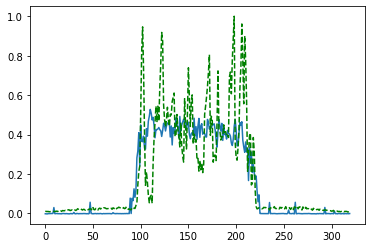

Time taken for epoch:  156.00063967704773
Epoch = [  8/3000]  Iter = [   0/39480]  Loss = 0.2037 Avg Loss = 0.2037  Time = 0.0972s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [  8/3000]  Iter = [ 100/39480]  Loss = 0.2087 Avg Loss = 0.2144  Time = 0.0035s
Epoch = [  8/3000]  Iter = [ 200/39480]  Loss = 0.2162 Avg Loss = 0.2208  Time = 0.0036s
Epoch = [  8/3000]  Iter = [ 300/39480]  Loss = 0.1959 Avg Loss = 0.2178  Time = 0.0054s
Epoch = [  8/3000]  Iter = [ 400/39480]  Loss = 0.2784 Avg Loss = 0.2149  Time = 0.0061s
Epoch = [  8/3000]  Iter = [ 500/39480]  Loss = 0.2157 Avg Loss = 0.2197  Time = 0.0032s
Epoch = [  8/3000]  Iter = [ 600/39480]  Loss = 0.2254 Avg Loss = 0.2192  Time = 0.0036s
Epoch = [  8/3000]  Iter = [ 700/39480]  Loss = 0.1924 Avg Loss = 0.2177  Time = 0.0034s
Epoch = [  8/3000]  Iter = [ 800/39480]  Loss = 0.2078 Avg Loss = 0.2199  Time = 0.0034s
Epoch = [  8/3000]  Iter = [ 900/39480]  Loss = 0.1956 Avg Loss = 0.218  Time = 0.0035s
Epoch = [  8/3000]  Iter = [1000/39480]  Loss = 0.2452 Avg Loss = 0.2189  Time = 0.0037s
Epoch = [  8/3000]  Iter = [1100/39480]  Loss = 0.2525 Avg Loss = 0.2191  Time = 0.0033s
Epoch = [  8/3000]  It

Epoch = [  8/3000]  Iter = [9400/39480]  Loss = 0.2035 Avg Loss = 0.2184  Time = 0.0038s
Epoch = [  8/3000]  Iter = [9500/39480]  Loss = 0.1987 Avg Loss = 0.2157  Time = 0.0033s
Epoch = [  8/3000]  Iter = [9600/39480]  Loss = 0.2235 Avg Loss = 0.2151  Time = 0.0038s
Epoch = [  8/3000]  Iter = [9700/39480]  Loss = 0.2292 Avg Loss = 0.217  Time = 0.0034s
Epoch = [  8/3000]  Iter = [9800/39480]  Loss = 0.2275 Avg Loss = 0.2164  Time = 0.0034s
Epoch = [  8/3000]  Iter = [9900/39480]  Loss = 0.2152 Avg Loss = 0.2164  Time = 0.0033s
Epoch = [  8/3000]  Iter = [10000/39480]  Loss = 0.1978 Avg Loss = 0.2167  Time = 0.0034s
Epoch = [  8/3000]  Iter = [10100/39480]  Loss = 0.1791 Avg Loss = 0.2184  Time = 0.0031s
Epoch = [  8/3000]  Iter = [10200/39480]  Loss = 0.2139 Avg Loss = 0.2184  Time = 0.0034s
Epoch = [  8/3000]  Iter = [10300/39480]  Loss = 0.2328 Avg Loss = 0.2185  Time = 0.0032s
Epoch = [  8/3000]  Iter = [10400/39480]  Loss = 0.2083 Avg Loss = 0.2183  Time = 0.0033s
Epoch = [  8/3000

Epoch = [  8/3000]  Iter = [18600/39480]  Loss = 0.1664 Avg Loss = 0.2199  Time = 0.0032s
Epoch = [  8/3000]  Iter = [18700/39480]  Loss = 0.224 Avg Loss = 0.221  Time = 0.0038s
Epoch = [  8/3000]  Iter = [18800/39480]  Loss = 0.234 Avg Loss = 0.2175  Time = 0.0037s
Epoch = [  8/3000]  Iter = [18900/39480]  Loss = 0.1982 Avg Loss = 0.2158  Time = 0.0035s
Epoch = [  8/3000]  Iter = [19000/39480]  Loss = 0.1963 Avg Loss = 0.2199  Time = 0.0032s
Epoch = [  8/3000]  Iter = [19100/39480]  Loss = 0.2295 Avg Loss = 0.2179  Time = 0.0048s
Epoch = [  8/3000]  Iter = [19200/39480]  Loss = 0.1939 Avg Loss = 0.2157  Time = 0.0036s
Epoch = [  8/3000]  Iter = [19300/39480]  Loss = 0.2094 Avg Loss = 0.2155  Time = 0.0034s
Epoch = [  8/3000]  Iter = [19400/39480]  Loss = 0.202 Avg Loss = 0.2149  Time = 0.0034s
Epoch = [  8/3000]  Iter = [19500/39480]  Loss = 0.2294 Avg Loss = 0.2166  Time = 0.0032s
Epoch = [  8/3000]  Iter = [19600/39480]  Loss = 0.2308 Avg Loss = 0.219  Time = 0.0035s
Epoch = [  8/30

Epoch = [  8/3000]  Iter = [27800/39480]  Loss = 0.1956 Avg Loss = 0.2173  Time = 0.0036s
Epoch = [  8/3000]  Iter = [27900/39480]  Loss = 0.2157 Avg Loss = 0.2167  Time = 0.0036s
Epoch = [  8/3000]  Iter = [28000/39480]  Loss = 0.2895 Avg Loss = 0.2193  Time = 0.0036s
Epoch = [  8/3000]  Iter = [28100/39480]  Loss = 0.2024 Avg Loss = 0.2205  Time = 0.0033s
Epoch = [  8/3000]  Iter = [28200/39480]  Loss = 0.1904 Avg Loss = 0.2221  Time = 0.0035s
Epoch = [  8/3000]  Iter = [28300/39480]  Loss = 0.2284 Avg Loss = 0.219  Time = 0.0037s
Epoch = [  8/3000]  Iter = [28400/39480]  Loss = 0.2226 Avg Loss = 0.2214  Time = 0.0031s
Epoch = [  8/3000]  Iter = [28500/39480]  Loss = 0.2124 Avg Loss = 0.2201  Time = 0.0036s
Epoch = [  8/3000]  Iter = [28600/39480]  Loss = 0.2295 Avg Loss = 0.22  Time = 0.0032s
Epoch = [  8/3000]  Iter = [28700/39480]  Loss = 0.221 Avg Loss = 0.2179  Time = 0.0035s
Epoch = [  8/3000]  Iter = [28800/39480]  Loss = 0.2379 Avg Loss = 0.2178  Time = 0.0034s
Epoch = [  8/3

Epoch = [  8/3000]  Iter = [37000/39480]  Loss = 0.2119 Avg Loss = 0.2187  Time = 0.0039s
Epoch = [  8/3000]  Iter = [37100/39480]  Loss = 0.217 Avg Loss = 0.2184  Time = 0.0035s
Epoch = [  8/3000]  Iter = [37200/39480]  Loss = 0.2085 Avg Loss = 0.2212  Time = 0.0037s
Epoch = [  8/3000]  Iter = [37300/39480]  Loss = 0.1767 Avg Loss = 0.2186  Time = 0.0047s
Epoch = [  8/3000]  Iter = [37400/39480]  Loss = 0.2231 Avg Loss = 0.2196  Time = 0.0037s
Epoch = [  8/3000]  Iter = [37500/39480]  Loss = 0.2138 Avg Loss = 0.2209  Time = 0.0036s
Epoch = [  8/3000]  Iter = [37600/39480]  Loss = 0.2009 Avg Loss = 0.2167  Time = 0.0035s
Epoch = [  8/3000]  Iter = [37700/39480]  Loss = 0.2104 Avg Loss = 0.2178  Time = 0.0034s
Epoch = [  8/3000]  Iter = [37800/39480]  Loss = 0.201 Avg Loss = 0.2193  Time = 0.0040s
Epoch = [  8/3000]  Iter = [37900/39480]  Loss = 0.2105 Avg Loss = 0.2155  Time = 0.0034s
Epoch = [  8/3000]  Iter = [38000/39480]  Loss = 0.2362 Avg Loss = 0.215  Time = 0.0036s
Epoch = [  8/

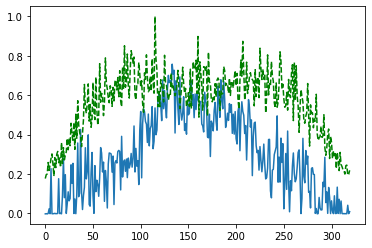

Time taken for epoch:  158.13289427757263
Epoch = [  9/3000]  Iter = [   0/39480]  Loss = 0.2179 Avg Loss = 0.2179  Time = 0.0902s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [  9/3000]  Iter = [ 100/39480]  Loss = 0.2142 Avg Loss = 0.2188  Time = 0.0048s
Epoch = [  9/3000]  Iter = [ 200/39480]  Loss = 0.1862 Avg Loss = 0.2199  Time = 0.0036s
Epoch = [  9/3000]  Iter = [ 300/39480]  Loss = 0.2081 Avg Loss = 0.2185  Time = 0.0033s
Epoch = [  9/3000]  Iter = [ 400/39480]  Loss = 0.1958 Avg Loss = 0.2181  Time = 0.0036s
Epoch = [  9/3000]  Iter = [ 500/39480]  Loss = 0.1979 Avg Loss = 0.215  Time = 0.0037s
Epoch = [  9/3000]  Iter = [ 600/39480]  Loss = 0.1994 Avg Loss = 0.2181  Time = 0.0029s
Epoch = [  9/3000]  Iter = [ 700/39480]  Loss = 0.2594 Avg Loss = 0.2192  Time = 0.0048s
Epoch = [  9/3000]  Iter = [ 800/39480]  Loss = 0.2039 Avg Loss = 0.2155  Time = 0.0029s
Epoch = [  9/3000]  Iter = [ 900/39480]  Loss = 0.1844 Avg Loss = 0.2158  Time = 0.0034s
Epoch = [  9/3000]  Iter = [1000/39480]  Loss = 0.2171 Avg Loss = 0.2154  Time = 0.0036s
Epoch = [  9/3000]  Iter = [1100/39480]  Loss = 0.2518 Avg Loss = 0.2195  Time = 0.0047s
Epoch = [  9/3000]  It

Epoch = [  9/3000]  Iter = [9400/39480]  Loss = 0.2455 Avg Loss = 0.2177  Time = 0.0034s
Epoch = [  9/3000]  Iter = [9500/39480]  Loss = 0.2198 Avg Loss = 0.2196  Time = 0.0039s
Epoch = [  9/3000]  Iter = [9600/39480]  Loss = 0.2991 Avg Loss = 0.2228  Time = 0.0034s
Epoch = [  9/3000]  Iter = [9700/39480]  Loss = 0.2638 Avg Loss = 0.2183  Time = 0.0036s
Epoch = [  9/3000]  Iter = [9800/39480]  Loss = 0.2916 Avg Loss = 0.2209  Time = 0.0034s
Epoch = [  9/3000]  Iter = [9900/39480]  Loss = 0.1881 Avg Loss = 0.219  Time = 0.0036s
Epoch = [  9/3000]  Iter = [10000/39480]  Loss = 0.2243 Avg Loss = 0.2187  Time = 0.0034s
Epoch = [  9/3000]  Iter = [10100/39480]  Loss = 0.2729 Avg Loss = 0.2196  Time = 0.0036s
Epoch = [  9/3000]  Iter = [10200/39480]  Loss = 0.1809 Avg Loss = 0.2126  Time = 0.0035s
Epoch = [  9/3000]  Iter = [10300/39480]  Loss = 0.2367 Avg Loss = 0.2168  Time = 0.0036s
Epoch = [  9/3000]  Iter = [10400/39480]  Loss = 0.2567 Avg Loss = 0.2197  Time = 0.0033s
Epoch = [  9/3000

Epoch = [  9/3000]  Iter = [18600/39480]  Loss = 0.2309 Avg Loss = 0.2184  Time = 0.0036s
Epoch = [  9/3000]  Iter = [18700/39480]  Loss = 0.1978 Avg Loss = 0.224  Time = 0.0035s
Epoch = [  9/3000]  Iter = [18800/39480]  Loss = 0.19 Avg Loss = 0.2177  Time = 0.0031s
Epoch = [  9/3000]  Iter = [18900/39480]  Loss = 0.2574 Avg Loss = 0.2215  Time = 0.0031s
Epoch = [  9/3000]  Iter = [19000/39480]  Loss = 0.2408 Avg Loss = 0.2183  Time = 0.0035s
Epoch = [  9/3000]  Iter = [19100/39480]  Loss = 0.185 Avg Loss = 0.2175  Time = 0.0037s
Epoch = [  9/3000]  Iter = [19200/39480]  Loss = 0.1732 Avg Loss = 0.2155  Time = 0.0031s
Epoch = [  9/3000]  Iter = [19300/39480]  Loss = 0.1936 Avg Loss = 0.217  Time = 0.0036s
Epoch = [  9/3000]  Iter = [19400/39480]  Loss = 0.2486 Avg Loss = 0.215  Time = 0.0033s
Epoch = [  9/3000]  Iter = [19500/39480]  Loss = 0.2125 Avg Loss = 0.2182  Time = 0.0033s
Epoch = [  9/3000]  Iter = [19600/39480]  Loss = 0.2124 Avg Loss = 0.2162  Time = 0.0035s
Epoch = [  9/300

Epoch = [  9/3000]  Iter = [27800/39480]  Loss = 0.1988 Avg Loss = 0.2152  Time = 0.0036s
Epoch = [  9/3000]  Iter = [27900/39480]  Loss = 0.2112 Avg Loss = 0.2174  Time = 0.0035s
Epoch = [  9/3000]  Iter = [28000/39480]  Loss = 0.223 Avg Loss = 0.2204  Time = 0.0032s
Epoch = [  9/3000]  Iter = [28100/39480]  Loss = 0.2071 Avg Loss = 0.2158  Time = 0.0038s
Epoch = [  9/3000]  Iter = [28200/39480]  Loss = 0.2229 Avg Loss = 0.2195  Time = 0.0045s
Epoch = [  9/3000]  Iter = [28300/39480]  Loss = 0.2013 Avg Loss = 0.22  Time = 0.0035s
Epoch = [  9/3000]  Iter = [28400/39480]  Loss = 0.2669 Avg Loss = 0.2213  Time = 0.0032s
Epoch = [  9/3000]  Iter = [28500/39480]  Loss = 0.1839 Avg Loss = 0.2222  Time = 0.0050s
Epoch = [  9/3000]  Iter = [28600/39480]  Loss = 0.211 Avg Loss = 0.2157  Time = 0.0036s
Epoch = [  9/3000]  Iter = [28700/39480]  Loss = 0.2041 Avg Loss = 0.2171  Time = 0.0036s
Epoch = [  9/3000]  Iter = [28800/39480]  Loss = 0.1988 Avg Loss = 0.2167  Time = 0.0031s
Epoch = [  9/3

Epoch = [  9/3000]  Iter = [37000/39480]  Loss = 0.2423 Avg Loss = 0.2171  Time = 0.0034s
Epoch = [  9/3000]  Iter = [37100/39480]  Loss = 0.218 Avg Loss = 0.2173  Time = 0.0030s
Epoch = [  9/3000]  Iter = [37200/39480]  Loss = 0.2137 Avg Loss = 0.2172  Time = 0.0032s
Epoch = [  9/3000]  Iter = [37300/39480]  Loss = 0.1899 Avg Loss = 0.2213  Time = 0.0037s
Epoch = [  9/3000]  Iter = [37400/39480]  Loss = 0.2059 Avg Loss = 0.221  Time = 0.0038s
Epoch = [  9/3000]  Iter = [37500/39480]  Loss = 0.2057 Avg Loss = 0.2159  Time = 0.0035s
Epoch = [  9/3000]  Iter = [37600/39480]  Loss = 0.2278 Avg Loss = 0.2193  Time = 0.0034s
Epoch = [  9/3000]  Iter = [37700/39480]  Loss = 0.2103 Avg Loss = 0.2156  Time = 0.0036s
Epoch = [  9/3000]  Iter = [37800/39480]  Loss = 0.2899 Avg Loss = 0.2143  Time = 0.0048s
Epoch = [  9/3000]  Iter = [37900/39480]  Loss = 0.2137 Avg Loss = 0.2157  Time = 0.0033s
Epoch = [  9/3000]  Iter = [38000/39480]  Loss = 0.2018 Avg Loss = 0.2198  Time = 0.0033s
Epoch = [  9

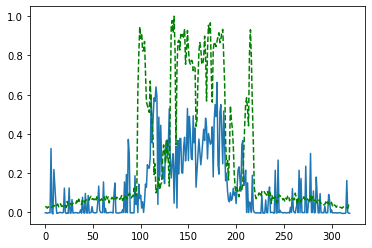

Time taken for epoch:  157.627512216568
Epoch = [ 10/3000]  Iter = [   0/39480]  Loss = 0.234 Avg Loss = 0.234  Time = 0.0831s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 10/3000]  Iter = [ 100/39480]  Loss = 0.2342 Avg Loss = 0.2286  Time = 0.0033s
Epoch = [ 10/3000]  Iter = [ 200/39480]  Loss = 0.2509 Avg Loss = 0.2227  Time = 0.0035s
Epoch = [ 10/3000]  Iter = [ 300/39480]  Loss = 0.2143 Avg Loss = 0.2183  Time = 0.0035s
Epoch = [ 10/3000]  Iter = [ 400/39480]  Loss = 0.2693 Avg Loss = 0.2165  Time = 0.0034s
Epoch = [ 10/3000]  Iter = [ 500/39480]  Loss = 0.2232 Avg Loss = 0.2177  Time = 0.0041s
Epoch = [ 10/3000]  Iter = [ 600/39480]  Loss = 0.2497 Avg Loss = 0.2209  Time = 0.0046s
Epoch = [ 10/3000]  Iter = [ 700/39480]  Loss = 0.2224 Avg Loss = 0.2154  Time = 0.0036s
Epoch = [ 10/3000]  Iter = [ 800/39480]  Loss = 0.1984 Avg Loss = 0.2193  Time = 0.0032s
Epoch = [ 10/3000]  Iter = [ 900/39480]  Loss = 0.2118 Avg Loss = 0.221  Time = 0.0036s
Epoch = [ 10/3000]  Iter = [1000/39480]  Loss = 0.2263 Avg Loss = 0.2161  Time = 0.0036s
Epoch = [ 10/3000]  Iter = [1100/39480]  Loss = 0.209 Avg Loss = 0.215  Time = 0.0037s
Epoch = [ 10/3000]  Iter

Epoch = [ 10/3000]  Iter = [9400/39480]  Loss = 0.2324 Avg Loss = 0.2184  Time = 0.0035s
Epoch = [ 10/3000]  Iter = [9500/39480]  Loss = 0.2311 Avg Loss = 0.2195  Time = 0.0037s
Epoch = [ 10/3000]  Iter = [9600/39480]  Loss = 0.2304 Avg Loss = 0.2247  Time = 0.0048s
Epoch = [ 10/3000]  Iter = [9700/39480]  Loss = 0.2075 Avg Loss = 0.2229  Time = 0.0033s
Epoch = [ 10/3000]  Iter = [9800/39480]  Loss = 0.1938 Avg Loss = 0.2144  Time = 0.0035s
Epoch = [ 10/3000]  Iter = [9900/39480]  Loss = 0.2089 Avg Loss = 0.2179  Time = 0.0033s
Epoch = [ 10/3000]  Iter = [10000/39480]  Loss = 0.2074 Avg Loss = 0.2142  Time = 0.0035s
Epoch = [ 10/3000]  Iter = [10100/39480]  Loss = 0.2049 Avg Loss = 0.2126  Time = 0.0034s
Epoch = [ 10/3000]  Iter = [10200/39480]  Loss = 0.2148 Avg Loss = 0.2163  Time = 0.0037s
Epoch = [ 10/3000]  Iter = [10300/39480]  Loss = 0.2394 Avg Loss = 0.2191  Time = 0.0034s
Epoch = [ 10/3000]  Iter = [10400/39480]  Loss = 0.2464 Avg Loss = 0.218  Time = 0.0035s
Epoch = [ 10/3000

Epoch = [ 10/3000]  Iter = [18600/39480]  Loss = 0.2348 Avg Loss = 0.2212  Time = 0.0036s
Epoch = [ 10/3000]  Iter = [18700/39480]  Loss = 0.214 Avg Loss = 0.2172  Time = 0.0035s
Epoch = [ 10/3000]  Iter = [18800/39480]  Loss = 0.1949 Avg Loss = 0.2181  Time = 0.0032s
Epoch = [ 10/3000]  Iter = [18900/39480]  Loss = 0.2421 Avg Loss = 0.2198  Time = 0.0030s
Epoch = [ 10/3000]  Iter = [19000/39480]  Loss = 0.2267 Avg Loss = 0.2184  Time = 0.0035s
Epoch = [ 10/3000]  Iter = [19100/39480]  Loss = 0.2086 Avg Loss = 0.2191  Time = 0.0035s
Epoch = [ 10/3000]  Iter = [19200/39480]  Loss = 0.2032 Avg Loss = 0.2165  Time = 0.0038s
Epoch = [ 10/3000]  Iter = [19300/39480]  Loss = 0.2304 Avg Loss = 0.2238  Time = 0.0036s
Epoch = [ 10/3000]  Iter = [19400/39480]  Loss = 0.2269 Avg Loss = 0.22  Time = 0.0034s
Epoch = [ 10/3000]  Iter = [19500/39480]  Loss = 0.2103 Avg Loss = 0.217  Time = 0.0035s
Epoch = [ 10/3000]  Iter = [19600/39480]  Loss = 0.1997 Avg Loss = 0.2116  Time = 0.0036s
Epoch = [ 10/3

Epoch = [ 10/3000]  Iter = [27800/39480]  Loss = 0.2357 Avg Loss = 0.2183  Time = 0.0036s
Epoch = [ 10/3000]  Iter = [27900/39480]  Loss = 0.2122 Avg Loss = 0.2204  Time = 0.0035s
Epoch = [ 10/3000]  Iter = [28000/39480]  Loss = 0.2179 Avg Loss = 0.2156  Time = 0.0033s
Epoch = [ 10/3000]  Iter = [28100/39480]  Loss = 0.2013 Avg Loss = 0.2198  Time = 0.0033s
Epoch = [ 10/3000]  Iter = [28200/39480]  Loss = 0.2209 Avg Loss = 0.2169  Time = 0.0035s
Epoch = [ 10/3000]  Iter = [28300/39480]  Loss = 0.2131 Avg Loss = 0.2166  Time = 0.0037s
Epoch = [ 10/3000]  Iter = [28400/39480]  Loss = 0.2198 Avg Loss = 0.2134  Time = 0.0039s
Epoch = [ 10/3000]  Iter = [28500/39480]  Loss = 0.2241 Avg Loss = 0.2224  Time = 0.0038s
Epoch = [ 10/3000]  Iter = [28600/39480]  Loss = 0.2275 Avg Loss = 0.2157  Time = 0.0038s
Epoch = [ 10/3000]  Iter = [28700/39480]  Loss = 0.1922 Avg Loss = 0.2141  Time = 0.0038s
Epoch = [ 10/3000]  Iter = [28800/39480]  Loss = 0.2103 Avg Loss = 0.2158  Time = 0.0040s
Epoch = [ 

Epoch = [ 10/3000]  Iter = [37000/39480]  Loss = 0.2243 Avg Loss = 0.2187  Time = 0.0032s
Epoch = [ 10/3000]  Iter = [37100/39480]  Loss = 0.229 Avg Loss = 0.2179  Time = 0.0037s
Epoch = [ 10/3000]  Iter = [37200/39480]  Loss = 0.1953 Avg Loss = 0.2168  Time = 0.0031s
Epoch = [ 10/3000]  Iter = [37300/39480]  Loss = 0.1717 Avg Loss = 0.2203  Time = 0.0035s
Epoch = [ 10/3000]  Iter = [37400/39480]  Loss = 0.1899 Avg Loss = 0.2191  Time = 0.0037s
Epoch = [ 10/3000]  Iter = [37500/39480]  Loss = 0.215 Avg Loss = 0.2171  Time = 0.0035s
Epoch = [ 10/3000]  Iter = [37600/39480]  Loss = 0.2093 Avg Loss = 0.2167  Time = 0.0034s
Epoch = [ 10/3000]  Iter = [37700/39480]  Loss = 0.2085 Avg Loss = 0.2138  Time = 0.0035s
Epoch = [ 10/3000]  Iter = [37800/39480]  Loss = 0.246 Avg Loss = 0.2174  Time = 0.0032s
Epoch = [ 10/3000]  Iter = [37900/39480]  Loss = 0.2391 Avg Loss = 0.2172  Time = 0.0056s
Epoch = [ 10/3000]  Iter = [38000/39480]  Loss = 0.2129 Avg Loss = 0.2185  Time = 0.0033s
Epoch = [ 10/

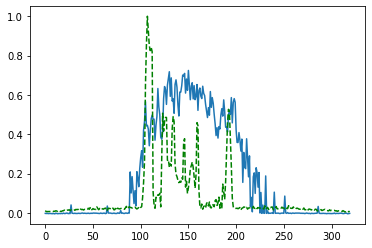

Time taken for epoch:  158.52199983596802
Epoch = [ 11/3000]  Iter = [   0/39480]  Loss = 0.2106 Avg Loss = 0.2106  Time = 0.1036s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 11/3000]  Iter = [ 100/39480]  Loss = 0.2344 Avg Loss = 0.2172  Time = 0.0032s
Epoch = [ 11/3000]  Iter = [ 200/39480]  Loss = 0.2185 Avg Loss = 0.2211  Time = 0.0030s
Epoch = [ 11/3000]  Iter = [ 300/39480]  Loss = 0.2301 Avg Loss = 0.2189  Time = 0.0049s
Epoch = [ 11/3000]  Iter = [ 400/39480]  Loss = 0.2333 Avg Loss = 0.2174  Time = 0.0034s
Epoch = [ 11/3000]  Iter = [ 500/39480]  Loss = 0.2052 Avg Loss = 0.2198  Time = 0.0034s
Epoch = [ 11/3000]  Iter = [ 600/39480]  Loss = 0.2064 Avg Loss = 0.2176  Time = 0.0034s
Epoch = [ 11/3000]  Iter = [ 700/39480]  Loss = 0.2203 Avg Loss = 0.2156  Time = 0.0034s
Epoch = [ 11/3000]  Iter = [ 800/39480]  Loss = 0.1967 Avg Loss = 0.2156  Time = 0.0038s
Epoch = [ 11/3000]  Iter = [ 900/39480]  Loss = 0.216 Avg Loss = 0.2152  Time = 0.0031s
Epoch = [ 11/3000]  Iter = [1000/39480]  Loss = 0.1966 Avg Loss = 0.216  Time = 0.0031s
Epoch = [ 11/3000]  Iter = [1100/39480]  Loss = 0.1984 Avg Loss = 0.2162  Time = 0.0034s
Epoch = [ 11/3000]  Ite

Epoch = [ 11/3000]  Iter = [9400/39480]  Loss = 0.2201 Avg Loss = 0.2154  Time = 0.0036s
Epoch = [ 11/3000]  Iter = [9500/39480]  Loss = 0.2188 Avg Loss = 0.2162  Time = 0.0035s
Epoch = [ 11/3000]  Iter = [9600/39480]  Loss = 0.2089 Avg Loss = 0.2173  Time = 0.0036s
Epoch = [ 11/3000]  Iter = [9700/39480]  Loss = 0.2275 Avg Loss = 0.2166  Time = 0.0032s
Epoch = [ 11/3000]  Iter = [9800/39480]  Loss = 0.1919 Avg Loss = 0.2174  Time = 0.0030s
Epoch = [ 11/3000]  Iter = [9900/39480]  Loss = 0.2202 Avg Loss = 0.2172  Time = 0.0035s
Epoch = [ 11/3000]  Iter = [10000/39480]  Loss = 0.2408 Avg Loss = 0.2194  Time = 0.0036s
Epoch = [ 11/3000]  Iter = [10100/39480]  Loss = 0.2189 Avg Loss = 0.2155  Time = 0.0037s
Epoch = [ 11/3000]  Iter = [10200/39480]  Loss = 0.2087 Avg Loss = 0.2171  Time = 0.0047s
Epoch = [ 11/3000]  Iter = [10300/39480]  Loss = 0.2166 Avg Loss = 0.2145  Time = 0.0036s
Epoch = [ 11/3000]  Iter = [10400/39480]  Loss = 0.215 Avg Loss = 0.2174  Time = 0.0034s
Epoch = [ 11/3000

Epoch = [ 11/3000]  Iter = [18600/39480]  Loss = 0.2035 Avg Loss = 0.221  Time = 0.0048s
Epoch = [ 11/3000]  Iter = [18700/39480]  Loss = 0.1837 Avg Loss = 0.2199  Time = 0.0033s
Epoch = [ 11/3000]  Iter = [18800/39480]  Loss = 0.1859 Avg Loss = 0.2198  Time = 0.0037s
Epoch = [ 11/3000]  Iter = [18900/39480]  Loss = 0.2587 Avg Loss = 0.2191  Time = 0.0034s
Epoch = [ 11/3000]  Iter = [19000/39480]  Loss = 0.2137 Avg Loss = 0.219  Time = 0.0043s
Epoch = [ 11/3000]  Iter = [19100/39480]  Loss = 0.187 Avg Loss = 0.2162  Time = 0.0036s
Epoch = [ 11/3000]  Iter = [19200/39480]  Loss = 0.1825 Avg Loss = 0.2162  Time = 0.0035s
Epoch = [ 11/3000]  Iter = [19300/39480]  Loss = 0.1977 Avg Loss = 0.2174  Time = 0.0036s
Epoch = [ 11/3000]  Iter = [19400/39480]  Loss = 0.2566 Avg Loss = 0.2202  Time = 0.0030s
Epoch = [ 11/3000]  Iter = [19500/39480]  Loss = 0.23 Avg Loss = 0.2188  Time = 0.0034s
Epoch = [ 11/3000]  Iter = [19600/39480]  Loss = 0.2531 Avg Loss = 0.2165  Time = 0.0034s
Epoch = [ 11/30

Epoch = [ 11/3000]  Iter = [27800/39480]  Loss = 0.2324 Avg Loss = 0.2159  Time = 0.0035s
Epoch = [ 11/3000]  Iter = [27900/39480]  Loss = 0.2062 Avg Loss = 0.2209  Time = 0.0037s
Epoch = [ 11/3000]  Iter = [28000/39480]  Loss = 0.24 Avg Loss = 0.2202  Time = 0.0037s
Epoch = [ 11/3000]  Iter = [28100/39480]  Loss = 0.2118 Avg Loss = 0.2219  Time = 0.0036s
Epoch = [ 11/3000]  Iter = [28200/39480]  Loss = 0.2156 Avg Loss = 0.2162  Time = 0.0037s
Epoch = [ 11/3000]  Iter = [28300/39480]  Loss = 0.2446 Avg Loss = 0.219  Time = 0.0034s
Epoch = [ 11/3000]  Iter = [28400/39480]  Loss = 0.2326 Avg Loss = 0.2167  Time = 0.0035s
Epoch = [ 11/3000]  Iter = [28500/39480]  Loss = 0.2291 Avg Loss = 0.2159  Time = 0.0032s
Epoch = [ 11/3000]  Iter = [28600/39480]  Loss = 0.2302 Avg Loss = 0.22  Time = 0.0035s
Epoch = [ 11/3000]  Iter = [28700/39480]  Loss = 0.1882 Avg Loss = 0.2131  Time = 0.0030s
Epoch = [ 11/3000]  Iter = [28800/39480]  Loss = 0.2431 Avg Loss = 0.2207  Time = 0.0035s
Epoch = [ 11/30

Epoch = [ 11/3000]  Iter = [37000/39480]  Loss = 0.2214 Avg Loss = 0.2147  Time = 0.0035s
Epoch = [ 11/3000]  Iter = [37100/39480]  Loss = 0.2261 Avg Loss = 0.2183  Time = 0.0035s
Epoch = [ 11/3000]  Iter = [37200/39480]  Loss = 0.2384 Avg Loss = 0.2188  Time = 0.0036s
Epoch = [ 11/3000]  Iter = [37300/39480]  Loss = 0.1933 Avg Loss = 0.2204  Time = 0.0034s
Epoch = [ 11/3000]  Iter = [37400/39480]  Loss = 0.2246 Avg Loss = 0.2176  Time = 0.0035s
Epoch = [ 11/3000]  Iter = [37500/39480]  Loss = 0.202 Avg Loss = 0.2186  Time = 0.0035s
Epoch = [ 11/3000]  Iter = [37600/39480]  Loss = 0.2314 Avg Loss = 0.2194  Time = 0.0035s
Epoch = [ 11/3000]  Iter = [37700/39480]  Loss = 0.181 Avg Loss = 0.2177  Time = 0.0032s
Epoch = [ 11/3000]  Iter = [37800/39480]  Loss = 0.1723 Avg Loss = 0.2156  Time = 0.0036s
Epoch = [ 11/3000]  Iter = [37900/39480]  Loss = 0.2022 Avg Loss = 0.2151  Time = 0.0037s
Epoch = [ 11/3000]  Iter = [38000/39480]  Loss = 0.2286 Avg Loss = 0.2207  Time = 0.0034s
Epoch = [ 11

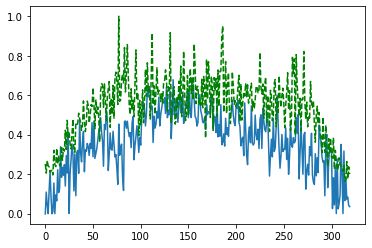

Time taken for epoch:  156.77086305618286
Epoch = [ 12/3000]  Iter = [   0/39480]  Loss = 0.2033 Avg Loss = 0.2033  Time = 0.0736s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 12/3000]  Iter = [ 100/39480]  Loss = 0.2236 Avg Loss = 0.2099  Time = 0.0030s
Epoch = [ 12/3000]  Iter = [ 200/39480]  Loss = 0.1978 Avg Loss = 0.2155  Time = 0.0035s
Epoch = [ 12/3000]  Iter = [ 300/39480]  Loss = 0.1968 Avg Loss = 0.219  Time = 0.0036s
Epoch = [ 12/3000]  Iter = [ 400/39480]  Loss = 0.2023 Avg Loss = 0.2189  Time = 0.0034s
Epoch = [ 12/3000]  Iter = [ 500/39480]  Loss = 0.1961 Avg Loss = 0.2193  Time = 0.0035s
Epoch = [ 12/3000]  Iter = [ 600/39480]  Loss = 0.1815 Avg Loss = 0.2171  Time = 0.0032s
Epoch = [ 12/3000]  Iter = [ 700/39480]  Loss = 0.2062 Avg Loss = 0.2158  Time = 0.0036s
Epoch = [ 12/3000]  Iter = [ 800/39480]  Loss = 0.2007 Avg Loss = 0.2173  Time = 0.0033s
Epoch = [ 12/3000]  Iter = [ 900/39480]  Loss = 0.1995 Avg Loss = 0.2162  Time = 0.0034s
Epoch = [ 12/3000]  Iter = [1000/39480]  Loss = 0.2282 Avg Loss = 0.2178  Time = 0.0037s
Epoch = [ 12/3000]  Iter = [1100/39480]  Loss = 0.2411 Avg Loss = 0.2193  Time = 0.0035s
Epoch = [ 12/3000]  It

Epoch = [ 12/3000]  Iter = [9400/39480]  Loss = 0.1935 Avg Loss = 0.2178  Time = 0.0034s
Epoch = [ 12/3000]  Iter = [9500/39480]  Loss = 0.1735 Avg Loss = 0.2114  Time = 0.0033s
Epoch = [ 12/3000]  Iter = [9600/39480]  Loss = 0.1848 Avg Loss = 0.217  Time = 0.0035s
Epoch = [ 12/3000]  Iter = [9700/39480]  Loss = 0.2082 Avg Loss = 0.2142  Time = 0.0034s
Epoch = [ 12/3000]  Iter = [9800/39480]  Loss = 0.1944 Avg Loss = 0.2162  Time = 0.0031s
Epoch = [ 12/3000]  Iter = [9900/39480]  Loss = 0.224 Avg Loss = 0.2189  Time = 0.0035s
Epoch = [ 12/3000]  Iter = [10000/39480]  Loss = 0.2663 Avg Loss = 0.2187  Time = 0.0036s
Epoch = [ 12/3000]  Iter = [10100/39480]  Loss = 0.1915 Avg Loss = 0.2205  Time = 0.0035s
Epoch = [ 12/3000]  Iter = [10200/39480]  Loss = 0.2321 Avg Loss = 0.2207  Time = 0.0032s
Epoch = [ 12/3000]  Iter = [10300/39480]  Loss = 0.2262 Avg Loss = 0.2185  Time = 0.0032s
Epoch = [ 12/3000]  Iter = [10400/39480]  Loss = 0.2129 Avg Loss = 0.2226  Time = 0.0036s
Epoch = [ 12/3000]

Epoch = [ 12/3000]  Iter = [18600/39480]  Loss = 0.2792 Avg Loss = 0.2171  Time = 0.0035s
Epoch = [ 12/3000]  Iter = [18700/39480]  Loss = 0.2368 Avg Loss = 0.2201  Time = 0.0036s
Epoch = [ 12/3000]  Iter = [18800/39480]  Loss = 0.2257 Avg Loss = 0.2228  Time = 0.0031s
Epoch = [ 12/3000]  Iter = [18900/39480]  Loss = 0.1955 Avg Loss = 0.2204  Time = 0.0033s
Epoch = [ 12/3000]  Iter = [19000/39480]  Loss = 0.1998 Avg Loss = 0.217  Time = 0.0035s
Epoch = [ 12/3000]  Iter = [19100/39480]  Loss = 0.2137 Avg Loss = 0.2182  Time = 0.0041s
Epoch = [ 12/3000]  Iter = [19200/39480]  Loss = 0.2437 Avg Loss = 0.2216  Time = 0.0037s
Epoch = [ 12/3000]  Iter = [19300/39480]  Loss = 0.2049 Avg Loss = 0.2241  Time = 0.0050s
Epoch = [ 12/3000]  Iter = [19400/39480]  Loss = 0.25 Avg Loss = 0.2212  Time = 0.0033s
Epoch = [ 12/3000]  Iter = [19500/39480]  Loss = 0.2116 Avg Loss = 0.2205  Time = 0.0035s
Epoch = [ 12/3000]  Iter = [19600/39480]  Loss = 0.237 Avg Loss = 0.2162  Time = 0.0036s
Epoch = [ 12/3

Epoch = [ 12/3000]  Iter = [27800/39480]  Loss = 0.2497 Avg Loss = 0.2185  Time = 0.0035s
Epoch = [ 12/3000]  Iter = [27900/39480]  Loss = 0.2332 Avg Loss = 0.2167  Time = 0.0032s
Epoch = [ 12/3000]  Iter = [28000/39480]  Loss = 0.2204 Avg Loss = 0.2182  Time = 0.0037s
Epoch = [ 12/3000]  Iter = [28100/39480]  Loss = 0.2358 Avg Loss = 0.2207  Time = 0.0034s
Epoch = [ 12/3000]  Iter = [28200/39480]  Loss = 0.2365 Avg Loss = 0.2214  Time = 0.0026s
Epoch = [ 12/3000]  Iter = [28300/39480]  Loss = 0.217 Avg Loss = 0.22  Time = 0.0031s
Epoch = [ 12/3000]  Iter = [28400/39480]  Loss = 0.2189 Avg Loss = 0.2182  Time = 0.0033s
Epoch = [ 12/3000]  Iter = [28500/39480]  Loss = 0.1889 Avg Loss = 0.2209  Time = 0.0039s
Epoch = [ 12/3000]  Iter = [28600/39480]  Loss = 0.2076 Avg Loss = 0.2166  Time = 0.0033s
Epoch = [ 12/3000]  Iter = [28700/39480]  Loss = 0.1828 Avg Loss = 0.2128  Time = 0.0033s
Epoch = [ 12/3000]  Iter = [28800/39480]  Loss = 0.2209 Avg Loss = 0.216  Time = 0.0030s
Epoch = [ 12/3

Epoch = [ 12/3000]  Iter = [37000/39480]  Loss = 0.2248 Avg Loss = 0.2193  Time = 0.0037s
Epoch = [ 12/3000]  Iter = [37100/39480]  Loss = 0.1956 Avg Loss = 0.2194  Time = 0.0032s
Epoch = [ 12/3000]  Iter = [37200/39480]  Loss = 0.2318 Avg Loss = 0.2175  Time = 0.0035s
Epoch = [ 12/3000]  Iter = [37300/39480]  Loss = 0.2214 Avg Loss = 0.2253  Time = 0.0033s
Epoch = [ 12/3000]  Iter = [37400/39480]  Loss = 0.2302 Avg Loss = 0.2197  Time = 0.0036s
Epoch = [ 12/3000]  Iter = [37500/39480]  Loss = 0.1867 Avg Loss = 0.2188  Time = 0.0036s
Epoch = [ 12/3000]  Iter = [37600/39480]  Loss = 0.1959 Avg Loss = 0.216  Time = 0.0036s
Epoch = [ 12/3000]  Iter = [37700/39480]  Loss = 0.1941 Avg Loss = 0.215  Time = 0.0032s
Epoch = [ 12/3000]  Iter = [37800/39480]  Loss = 0.2333 Avg Loss = 0.218  Time = 0.0034s
Epoch = [ 12/3000]  Iter = [37900/39480]  Loss = 0.1685 Avg Loss = 0.2159  Time = 0.0034s
Epoch = [ 12/3000]  Iter = [38000/39480]  Loss = 0.2229 Avg Loss = 0.2174  Time = 0.0037s
Epoch = [ 12/

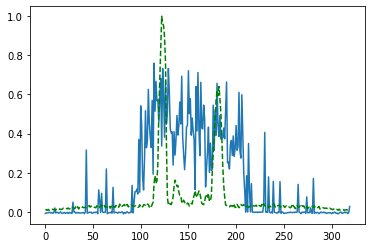

Time taken for epoch:  156.78200912475586
Epoch = [ 13/3000]  Iter = [   0/39480]  Loss = 0.2369 Avg Loss = 0.2369  Time = 0.0778s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 13/3000]  Iter = [ 100/39480]  Loss = 0.2405 Avg Loss = 0.2259  Time = 0.0034s
Epoch = [ 13/3000]  Iter = [ 200/39480]  Loss = 0.2422 Avg Loss = 0.2182  Time = 0.0035s
Epoch = [ 13/3000]  Iter = [ 300/39480]  Loss = 0.2254 Avg Loss = 0.2203  Time = 0.0034s
Epoch = [ 13/3000]  Iter = [ 400/39480]  Loss = 0.2314 Avg Loss = 0.2167  Time = 0.0037s
Epoch = [ 13/3000]  Iter = [ 500/39480]  Loss = 0.2148 Avg Loss = 0.2209  Time = 0.0033s
Epoch = [ 13/3000]  Iter = [ 600/39480]  Loss = 0.2601 Avg Loss = 0.2214  Time = 0.0033s
Epoch = [ 13/3000]  Iter = [ 700/39480]  Loss = 0.2076 Avg Loss = 0.2169  Time = 0.0036s
Epoch = [ 13/3000]  Iter = [ 800/39480]  Loss = 0.1877 Avg Loss = 0.2177  Time = 0.0035s
Epoch = [ 13/3000]  Iter = [ 900/39480]  Loss = 0.2048 Avg Loss = 0.2191  Time = 0.0034s
Epoch = [ 13/3000]  Iter = [1000/39480]  Loss = 0.229 Avg Loss = 0.2173  Time = 0.0033s
Epoch = [ 13/3000]  Iter = [1100/39480]  Loss = 0.2297 Avg Loss = 0.2181  Time = 0.0037s
Epoch = [ 13/3000]  It

Epoch = [ 13/3000]  Iter = [9400/39480]  Loss = 0.2268 Avg Loss = 0.2167  Time = 0.0036s
Epoch = [ 13/3000]  Iter = [9500/39480]  Loss = 0.3005 Avg Loss = 0.2159  Time = 0.0036s
Epoch = [ 13/3000]  Iter = [9600/39480]  Loss = 0.1837 Avg Loss = 0.2151  Time = 0.0032s
Epoch = [ 13/3000]  Iter = [9700/39480]  Loss = 0.2321 Avg Loss = 0.2148  Time = 0.0033s
Epoch = [ 13/3000]  Iter = [9800/39480]  Loss = 0.2294 Avg Loss = 0.2183  Time = 0.0037s
Epoch = [ 13/3000]  Iter = [9900/39480]  Loss = 0.2235 Avg Loss = 0.217  Time = 0.0036s
Epoch = [ 13/3000]  Iter = [10000/39480]  Loss = 0.1792 Avg Loss = 0.2198  Time = 0.0036s
Epoch = [ 13/3000]  Iter = [10100/39480]  Loss = 0.2312 Avg Loss = 0.2151  Time = 0.0036s
Epoch = [ 13/3000]  Iter = [10200/39480]  Loss = 0.1736 Avg Loss = 0.2182  Time = 0.0035s
Epoch = [ 13/3000]  Iter = [10300/39480]  Loss = 0.2293 Avg Loss = 0.2127  Time = 0.0035s
Epoch = [ 13/3000]  Iter = [10400/39480]  Loss = 0.2001 Avg Loss = 0.2173  Time = 0.0029s
Epoch = [ 13/3000

Epoch = [ 13/3000]  Iter = [18600/39480]  Loss = 0.2087 Avg Loss = 0.2214  Time = 0.0030s
Epoch = [ 13/3000]  Iter = [18700/39480]  Loss = 0.214 Avg Loss = 0.2249  Time = 0.0046s
Epoch = [ 13/3000]  Iter = [18800/39480]  Loss = 0.2138 Avg Loss = 0.2166  Time = 0.0032s
Epoch = [ 13/3000]  Iter = [18900/39480]  Loss = 0.2455 Avg Loss = 0.2188  Time = 0.0035s
Epoch = [ 13/3000]  Iter = [19000/39480]  Loss = 0.2264 Avg Loss = 0.2204  Time = 0.0032s
Epoch = [ 13/3000]  Iter = [19100/39480]  Loss = 0.2162 Avg Loss = 0.217  Time = 0.0034s
Epoch = [ 13/3000]  Iter = [19200/39480]  Loss = 0.2255 Avg Loss = 0.2149  Time = 0.0028s
Epoch = [ 13/3000]  Iter = [19300/39480]  Loss = 0.2321 Avg Loss = 0.2178  Time = 0.0039s
Epoch = [ 13/3000]  Iter = [19400/39480]  Loss = 0.2325 Avg Loss = 0.2211  Time = 0.0035s
Epoch = [ 13/3000]  Iter = [19500/39480]  Loss = 0.239 Avg Loss = 0.2189  Time = 0.0032s
Epoch = [ 13/3000]  Iter = [19600/39480]  Loss = 0.2321 Avg Loss = 0.2241  Time = 0.0035s
Epoch = [ 13/

Epoch = [ 13/3000]  Iter = [27800/39480]  Loss = 0.2044 Avg Loss = 0.2195  Time = 0.0032s
Epoch = [ 13/3000]  Iter = [27900/39480]  Loss = 0.2136 Avg Loss = 0.2181  Time = 0.0031s
Epoch = [ 13/3000]  Iter = [28000/39480]  Loss = 0.2407 Avg Loss = 0.22  Time = 0.0030s
Epoch = [ 13/3000]  Iter = [28100/39480]  Loss = 0.2179 Avg Loss = 0.2246  Time = 0.0045s
Epoch = [ 13/3000]  Iter = [28200/39480]  Loss = 0.2156 Avg Loss = 0.2143  Time = 0.0031s
Epoch = [ 13/3000]  Iter = [28300/39480]  Loss = 0.2172 Avg Loss = 0.2167  Time = 0.0049s
Epoch = [ 13/3000]  Iter = [28400/39480]  Loss = 0.2571 Avg Loss = 0.2215  Time = 0.0033s
Epoch = [ 13/3000]  Iter = [28500/39480]  Loss = 0.1772 Avg Loss = 0.2216  Time = 0.0035s
Epoch = [ 13/3000]  Iter = [28600/39480]  Loss = 0.178 Avg Loss = 0.2166  Time = 0.0032s
Epoch = [ 13/3000]  Iter = [28700/39480]  Loss = 0.1936 Avg Loss = 0.216  Time = 0.0035s
Epoch = [ 13/3000]  Iter = [28800/39480]  Loss = 0.2212 Avg Loss = 0.2171  Time = 0.0029s
Epoch = [ 13/3

Epoch = [ 13/3000]  Iter = [37000/39480]  Loss = 0.2028 Avg Loss = 0.2179  Time = 0.0033s
Epoch = [ 13/3000]  Iter = [37100/39480]  Loss = 0.2245 Avg Loss = 0.2208  Time = 0.0040s
Epoch = [ 13/3000]  Iter = [37200/39480]  Loss = 0.2017 Avg Loss = 0.2206  Time = 0.0036s
Epoch = [ 13/3000]  Iter = [37300/39480]  Loss = 0.184 Avg Loss = 0.2219  Time = 0.0033s
Epoch = [ 13/3000]  Iter = [37400/39480]  Loss = 0.213 Avg Loss = 0.2187  Time = 0.0029s
Epoch = [ 13/3000]  Iter = [37500/39480]  Loss = 0.2334 Avg Loss = 0.2174  Time = 0.0034s
Epoch = [ 13/3000]  Iter = [37600/39480]  Loss = 0.2278 Avg Loss = 0.2189  Time = 0.0035s
Epoch = [ 13/3000]  Iter = [37700/39480]  Loss = 0.1739 Avg Loss = 0.2198  Time = 0.0036s
Epoch = [ 13/3000]  Iter = [37800/39480]  Loss = 0.2343 Avg Loss = 0.2171  Time = 0.0031s
Epoch = [ 13/3000]  Iter = [37900/39480]  Loss = 0.1867 Avg Loss = 0.216  Time = 0.0035s
Epoch = [ 13/3000]  Iter = [38000/39480]  Loss = 0.2225 Avg Loss = 0.2174  Time = 0.0032s
Epoch = [ 13/

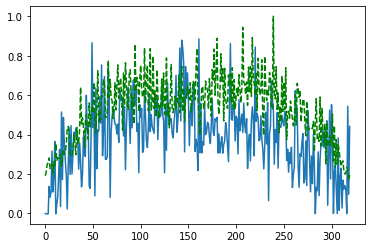

Time taken for epoch:  156.15575432777405
Epoch = [ 14/3000]  Iter = [   0/39480]  Loss = 0.206 Avg Loss = 0.206  Time = 0.0779s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 14/3000]  Iter = [ 100/39480]  Loss = 0.2422 Avg Loss = 0.2164  Time = 0.0035s
Epoch = [ 14/3000]  Iter = [ 200/39480]  Loss = 0.2048 Avg Loss = 0.2165  Time = 0.0034s
Epoch = [ 14/3000]  Iter = [ 300/39480]  Loss = 0.1946 Avg Loss = 0.2163  Time = 0.0036s
Epoch = [ 14/3000]  Iter = [ 400/39480]  Loss = 0.1929 Avg Loss = 0.2195  Time = 0.0034s
Epoch = [ 14/3000]  Iter = [ 500/39480]  Loss = 0.1733 Avg Loss = 0.2164  Time = 0.0033s
Epoch = [ 14/3000]  Iter = [ 600/39480]  Loss = 0.2342 Avg Loss = 0.2193  Time = 0.0039s
Epoch = [ 14/3000]  Iter = [ 700/39480]  Loss = 0.2192 Avg Loss = 0.2175  Time = 0.0036s
Epoch = [ 14/3000]  Iter = [ 800/39480]  Loss = 0.2186 Avg Loss = 0.2163  Time = 0.0036s
Epoch = [ 14/3000]  Iter = [ 900/39480]  Loss = 0.2221 Avg Loss = 0.219  Time = 0.0034s
Epoch = [ 14/3000]  Iter = [1000/39480]  Loss = 0.233 Avg Loss = 0.2207  Time = 0.0031s
Epoch = [ 14/3000]  Iter = [1100/39480]  Loss = 0.1748 Avg Loss = 0.2193  Time = 0.0036s
Epoch = [ 14/3000]  Ite

Epoch = [ 14/3000]  Iter = [9400/39480]  Loss = 0.2179 Avg Loss = 0.2232  Time = 0.0038s
Epoch = [ 14/3000]  Iter = [9500/39480]  Loss = 0.2277 Avg Loss = 0.2174  Time = 0.0033s
Epoch = [ 14/3000]  Iter = [9600/39480]  Loss = 0.2166 Avg Loss = 0.2173  Time = 0.0035s
Epoch = [ 14/3000]  Iter = [9700/39480]  Loss = 0.2324 Avg Loss = 0.2212  Time = 0.0034s
Epoch = [ 14/3000]  Iter = [9800/39480]  Loss = 0.2056 Avg Loss = 0.2154  Time = 0.0036s
Epoch = [ 14/3000]  Iter = [9900/39480]  Loss = 0.2326 Avg Loss = 0.218  Time = 0.0034s
Epoch = [ 14/3000]  Iter = [10000/39480]  Loss = 0.2268 Avg Loss = 0.2149  Time = 0.0035s
Epoch = [ 14/3000]  Iter = [10100/39480]  Loss = 0.2063 Avg Loss = 0.2143  Time = 0.0030s
Epoch = [ 14/3000]  Iter = [10200/39480]  Loss = 0.2381 Avg Loss = 0.2189  Time = 0.0036s
Epoch = [ 14/3000]  Iter = [10300/39480]  Loss = 0.2212 Avg Loss = 0.218  Time = 0.0034s
Epoch = [ 14/3000]  Iter = [10400/39480]  Loss = 0.2006 Avg Loss = 0.2163  Time = 0.0037s
Epoch = [ 14/3000]

Epoch = [ 14/3000]  Iter = [18600/39480]  Loss = 0.1904 Avg Loss = 0.2148  Time = 0.0039s
Epoch = [ 14/3000]  Iter = [18700/39480]  Loss = 0.1845 Avg Loss = 0.2194  Time = 0.0033s
Epoch = [ 14/3000]  Iter = [18800/39480]  Loss = 0.2425 Avg Loss = 0.2199  Time = 0.0035s
Epoch = [ 14/3000]  Iter = [18900/39480]  Loss = 0.2133 Avg Loss = 0.2172  Time = 0.0041s
Epoch = [ 14/3000]  Iter = [19000/39480]  Loss = 0.2256 Avg Loss = 0.2162  Time = 0.0042s
Epoch = [ 14/3000]  Iter = [19100/39480]  Loss = 0.2208 Avg Loss = 0.2157  Time = 0.0033s
Epoch = [ 14/3000]  Iter = [19200/39480]  Loss = 0.2253 Avg Loss = 0.2198  Time = 0.0038s
Epoch = [ 14/3000]  Iter = [19300/39480]  Loss = 0.2184 Avg Loss = 0.2191  Time = 0.0032s
Epoch = [ 14/3000]  Iter = [19400/39480]  Loss = 0.2353 Avg Loss = 0.2199  Time = 0.0033s
Epoch = [ 14/3000]  Iter = [19500/39480]  Loss = 0.2431 Avg Loss = 0.2217  Time = 0.0034s
Epoch = [ 14/3000]  Iter = [19600/39480]  Loss = 0.218 Avg Loss = 0.2208  Time = 0.0038s
Epoch = [ 1

Epoch = [ 14/3000]  Iter = [27800/39480]  Loss = 0.2162 Avg Loss = 0.2165  Time = 0.0032s
Epoch = [ 14/3000]  Iter = [27900/39480]  Loss = 0.1983 Avg Loss = 0.22  Time = 0.0036s
Epoch = [ 14/3000]  Iter = [28000/39480]  Loss = 0.1917 Avg Loss = 0.218  Time = 0.0035s
Epoch = [ 14/3000]  Iter = [28100/39480]  Loss = 0.193 Avg Loss = 0.215  Time = 0.0036s
Epoch = [ 14/3000]  Iter = [28200/39480]  Loss = 0.2165 Avg Loss = 0.22  Time = 0.0034s
Epoch = [ 14/3000]  Iter = [28300/39480]  Loss = 0.2253 Avg Loss = 0.2169  Time = 0.0036s
Epoch = [ 14/3000]  Iter = [28400/39480]  Loss = 0.2297 Avg Loss = 0.2154  Time = 0.0032s
Epoch = [ 14/3000]  Iter = [28500/39480]  Loss = 0.2406 Avg Loss = 0.2151  Time = 0.0035s
Epoch = [ 14/3000]  Iter = [28600/39480]  Loss = 0.2266 Avg Loss = 0.2164  Time = 0.0031s
Epoch = [ 14/3000]  Iter = [28700/39480]  Loss = 0.2228 Avg Loss = 0.2211  Time = 0.0033s
Epoch = [ 14/3000]  Iter = [28800/39480]  Loss = 0.2362 Avg Loss = 0.2194  Time = 0.0033s
Epoch = [ 14/3000

Epoch = [ 14/3000]  Iter = [37000/39480]  Loss = 0.2356 Avg Loss = 0.218  Time = 0.0043s
Epoch = [ 14/3000]  Iter = [37100/39480]  Loss = 0.2177 Avg Loss = 0.2176  Time = 0.0030s
Epoch = [ 14/3000]  Iter = [37200/39480]  Loss = 0.2156 Avg Loss = 0.2149  Time = 0.0032s
Epoch = [ 14/3000]  Iter = [37300/39480]  Loss = 0.1682 Avg Loss = 0.2167  Time = 0.0032s
Epoch = [ 14/3000]  Iter = [37400/39480]  Loss = 0.2135 Avg Loss = 0.2182  Time = 0.0031s
Epoch = [ 14/3000]  Iter = [37500/39480]  Loss = 0.2496 Avg Loss = 0.2197  Time = 0.0029s
Epoch = [ 14/3000]  Iter = [37600/39480]  Loss = 0.2311 Avg Loss = 0.2235  Time = 0.0036s
Epoch = [ 14/3000]  Iter = [37700/39480]  Loss = 0.2024 Avg Loss = 0.2179  Time = 0.0031s
Epoch = [ 14/3000]  Iter = [37800/39480]  Loss = 0.2128 Avg Loss = 0.219  Time = 0.0035s
Epoch = [ 14/3000]  Iter = [37900/39480]  Loss = 0.2275 Avg Loss = 0.223  Time = 0.0036s
Epoch = [ 14/3000]  Iter = [38000/39480]  Loss = 0.1846 Avg Loss = 0.2196  Time = 0.0034s
Epoch = [ 14/

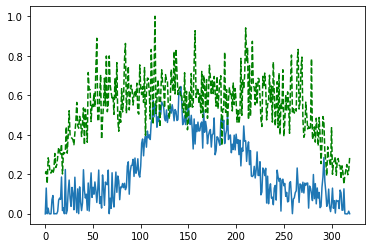

Time taken for epoch:  156.8512806892395
Epoch = [ 15/3000]  Iter = [   0/39480]  Loss = 0.2201 Avg Loss = 0.2201  Time = 0.0761s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 15/3000]  Iter = [ 100/39480]  Loss = 0.1988 Avg Loss = 0.2173  Time = 0.0035s
Epoch = [ 15/3000]  Iter = [ 200/39480]  Loss = 0.2526 Avg Loss = 0.2198  Time = 0.0035s
Epoch = [ 15/3000]  Iter = [ 300/39480]  Loss = 0.1985 Avg Loss = 0.2173  Time = 0.0033s
Epoch = [ 15/3000]  Iter = [ 400/39480]  Loss = 0.2124 Avg Loss = 0.2184  Time = 0.0030s
Epoch = [ 15/3000]  Iter = [ 500/39480]  Loss = 0.1754 Avg Loss = 0.215  Time = 0.0034s
Epoch = [ 15/3000]  Iter = [ 600/39480]  Loss = 0.2268 Avg Loss = 0.2168  Time = 0.0036s
Epoch = [ 15/3000]  Iter = [ 700/39480]  Loss = 0.2391 Avg Loss = 0.2175  Time = 0.0037s
Epoch = [ 15/3000]  Iter = [ 800/39480]  Loss = 0.2464 Avg Loss = 0.22  Time = 0.0035s
Epoch = [ 15/3000]  Iter = [ 900/39480]  Loss = 0.2293 Avg Loss = 0.2174  Time = 0.0035s
Epoch = [ 15/3000]  Iter = [1000/39480]  Loss = 0.2533 Avg Loss = 0.2175  Time = 0.0035s
Epoch = [ 15/3000]  Iter = [1100/39480]  Loss = 0.2281 Avg Loss = 0.218  Time = 0.0037s
Epoch = [ 15/3000]  Iter 

Epoch = [ 15/3000]  Iter = [9400/39480]  Loss = 0.2283 Avg Loss = 0.2198  Time = 0.0034s
Epoch = [ 15/3000]  Iter = [9500/39480]  Loss = 0.2389 Avg Loss = 0.2188  Time = 0.0033s
Epoch = [ 15/3000]  Iter = [9600/39480]  Loss = 0.2091 Avg Loss = 0.2184  Time = 0.0033s
Epoch = [ 15/3000]  Iter = [9700/39480]  Loss = 0.2493 Avg Loss = 0.2177  Time = 0.0033s
Epoch = [ 15/3000]  Iter = [9800/39480]  Loss = 0.2242 Avg Loss = 0.2214  Time = 0.0034s
Epoch = [ 15/3000]  Iter = [9900/39480]  Loss = 0.2131 Avg Loss = 0.2224  Time = 0.0030s
Epoch = [ 15/3000]  Iter = [10000/39480]  Loss = 0.1828 Avg Loss = 0.215  Time = 0.0034s
Epoch = [ 15/3000]  Iter = [10100/39480]  Loss = 0.1741 Avg Loss = 0.2173  Time = 0.0036s
Epoch = [ 15/3000]  Iter = [10200/39480]  Loss = 0.2521 Avg Loss = 0.2154  Time = 0.0031s
Epoch = [ 15/3000]  Iter = [10300/39480]  Loss = 0.2059 Avg Loss = 0.218  Time = 0.0033s
Epoch = [ 15/3000]  Iter = [10400/39480]  Loss = 0.2328 Avg Loss = 0.2169  Time = 0.0049s
Epoch = [ 15/3000]

Epoch = [ 15/3000]  Iter = [18600/39480]  Loss = 0.1928 Avg Loss = 0.216  Time = 0.0033s
Epoch = [ 15/3000]  Iter = [18700/39480]  Loss = 0.2312 Avg Loss = 0.2136  Time = 0.0036s
Epoch = [ 15/3000]  Iter = [18800/39480]  Loss = 0.2184 Avg Loss = 0.2199  Time = 0.0033s
Epoch = [ 15/3000]  Iter = [18900/39480]  Loss = 0.2279 Avg Loss = 0.2227  Time = 0.0035s
Epoch = [ 15/3000]  Iter = [19000/39480]  Loss = 0.2055 Avg Loss = 0.2208  Time = 0.0041s
Epoch = [ 15/3000]  Iter = [19100/39480]  Loss = 0.2228 Avg Loss = 0.2157  Time = 0.0036s
Epoch = [ 15/3000]  Iter = [19200/39480]  Loss = 0.2217 Avg Loss = 0.2209  Time = 0.0034s
Epoch = [ 15/3000]  Iter = [19300/39480]  Loss = 0.2289 Avg Loss = 0.2181  Time = 0.0042s
Epoch = [ 15/3000]  Iter = [19400/39480]  Loss = 0.2341 Avg Loss = 0.2176  Time = 0.0039s
Epoch = [ 15/3000]  Iter = [19500/39480]  Loss = 0.2094 Avg Loss = 0.2176  Time = 0.0031s
Epoch = [ 15/3000]  Iter = [19600/39480]  Loss = 0.22 Avg Loss = 0.2169  Time = 0.0036s
Epoch = [ 15/

Epoch = [ 15/3000]  Iter = [27800/39480]  Loss = 0.2177 Avg Loss = 0.2177  Time = 0.0032s
Epoch = [ 15/3000]  Iter = [27900/39480]  Loss = 0.2699 Avg Loss = 0.2192  Time = 0.0035s
Epoch = [ 15/3000]  Iter = [28000/39480]  Loss = 0.2629 Avg Loss = 0.2241  Time = 0.0053s
Epoch = [ 15/3000]  Iter = [28100/39480]  Loss = 0.1908 Avg Loss = 0.2201  Time = 0.0032s
Epoch = [ 15/3000]  Iter = [28200/39480]  Loss = 0.1722 Avg Loss = 0.2168  Time = 0.0030s
Epoch = [ 15/3000]  Iter = [28300/39480]  Loss = 0.2157 Avg Loss = 0.2136  Time = 0.0036s
Epoch = [ 15/3000]  Iter = [28400/39480]  Loss = 0.2571 Avg Loss = 0.2172  Time = 0.0036s
Epoch = [ 15/3000]  Iter = [28500/39480]  Loss = 0.2624 Avg Loss = 0.2209  Time = 0.0035s
Epoch = [ 15/3000]  Iter = [28600/39480]  Loss = 0.2552 Avg Loss = 0.2184  Time = 0.0033s
Epoch = [ 15/3000]  Iter = [28700/39480]  Loss = 0.192 Avg Loss = 0.2134  Time = 0.0033s
Epoch = [ 15/3000]  Iter = [28800/39480]  Loss = 0.212 Avg Loss = 0.2188  Time = 0.0035s
Epoch = [ 15

Epoch = [ 15/3000]  Iter = [37000/39480]  Loss = 0.2418 Avg Loss = 0.2187  Time = 0.0033s
Epoch = [ 15/3000]  Iter = [37100/39480]  Loss = 0.2104 Avg Loss = 0.2206  Time = 0.0034s
Epoch = [ 15/3000]  Iter = [37200/39480]  Loss = 0.2477 Avg Loss = 0.2253  Time = 0.0033s
Epoch = [ 15/3000]  Iter = [37300/39480]  Loss = 0.2069 Avg Loss = 0.219  Time = 0.0032s
Epoch = [ 15/3000]  Iter = [37400/39480]  Loss = 0.2519 Avg Loss = 0.2164  Time = 0.0034s
Epoch = [ 15/3000]  Iter = [37500/39480]  Loss = 0.1983 Avg Loss = 0.2149  Time = 0.0030s
Epoch = [ 15/3000]  Iter = [37600/39480]  Loss = 0.197 Avg Loss = 0.2181  Time = 0.0034s
Epoch = [ 15/3000]  Iter = [37700/39480]  Loss = 0.1967 Avg Loss = 0.2179  Time = 0.0032s
Epoch = [ 15/3000]  Iter = [37800/39480]  Loss = 0.2445 Avg Loss = 0.2188  Time = 0.0033s
Epoch = [ 15/3000]  Iter = [37900/39480]  Loss = 0.2128 Avg Loss = 0.2153  Time = 0.0036s
Epoch = [ 15/3000]  Iter = [38000/39480]  Loss = 0.2137 Avg Loss = 0.2133  Time = 0.0030s
Epoch = [ 15

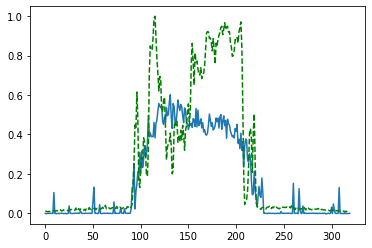

Time taken for epoch:  156.18638229370117
Epoch = [ 16/3000]  Iter = [   0/39480]  Loss = 0.2263 Avg Loss = 0.2263  Time = 0.0851s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 16/3000]  Iter = [ 100/39480]  Loss = 0.217 Avg Loss = 0.2182  Time = 0.0032s
Epoch = [ 16/3000]  Iter = [ 200/39480]  Loss = 0.215 Avg Loss = 0.2214  Time = 0.0036s
Epoch = [ 16/3000]  Iter = [ 300/39480]  Loss = 0.2055 Avg Loss = 0.2187  Time = 0.0031s
Epoch = [ 16/3000]  Iter = [ 400/39480]  Loss = 0.229 Avg Loss = 0.2168  Time = 0.0033s
Epoch = [ 16/3000]  Iter = [ 500/39480]  Loss = 0.2351 Avg Loss = 0.2178  Time = 0.0047s
Epoch = [ 16/3000]  Iter = [ 600/39480]  Loss = 0.2053 Avg Loss = 0.2179  Time = 0.0038s
Epoch = [ 16/3000]  Iter = [ 700/39480]  Loss = 0.1901 Avg Loss = 0.2178  Time = 0.0035s
Epoch = [ 16/3000]  Iter = [ 800/39480]  Loss = 0.2174 Avg Loss = 0.2227  Time = 0.0036s
Epoch = [ 16/3000]  Iter = [ 900/39480]  Loss = 0.2153 Avg Loss = 0.2194  Time = 0.0029s
Epoch = [ 16/3000]  Iter = [1000/39480]  Loss = 0.215 Avg Loss = 0.2174  Time = 0.0035s
Epoch = [ 16/3000]  Iter = [1100/39480]  Loss = 0.1986 Avg Loss = 0.2175  Time = 0.0035s
Epoch = [ 16/3000]  Iter 

Epoch = [ 16/3000]  Iter = [9400/39480]  Loss = 0.2535 Avg Loss = 0.2166  Time = 0.0038s
Epoch = [ 16/3000]  Iter = [9500/39480]  Loss = 0.2458 Avg Loss = 0.2195  Time = 0.0030s
Epoch = [ 16/3000]  Iter = [9600/39480]  Loss = 0.2266 Avg Loss = 0.2212  Time = 0.0035s
Epoch = [ 16/3000]  Iter = [9700/39480]  Loss = 0.2598 Avg Loss = 0.2174  Time = 0.0033s
Epoch = [ 16/3000]  Iter = [9800/39480]  Loss = 0.1797 Avg Loss = 0.2208  Time = 0.0036s
Epoch = [ 16/3000]  Iter = [9900/39480]  Loss = 0.2023 Avg Loss = 0.2174  Time = 0.0030s
Epoch = [ 16/3000]  Iter = [10000/39480]  Loss = 0.2121 Avg Loss = 0.2184  Time = 0.0034s
Epoch = [ 16/3000]  Iter = [10100/39480]  Loss = 0.2033 Avg Loss = 0.2227  Time = 0.0034s
Epoch = [ 16/3000]  Iter = [10200/39480]  Loss = 0.2032 Avg Loss = 0.215  Time = 0.0032s
Epoch = [ 16/3000]  Iter = [10300/39480]  Loss = 0.2155 Avg Loss = 0.2178  Time = 0.0044s
Epoch = [ 16/3000]  Iter = [10400/39480]  Loss = 0.2294 Avg Loss = 0.218  Time = 0.0034s
Epoch = [ 16/3000]

Epoch = [ 16/3000]  Iter = [18600/39480]  Loss = 0.2232 Avg Loss = 0.2178  Time = 0.0036s
Epoch = [ 16/3000]  Iter = [18700/39480]  Loss = 0.2138 Avg Loss = 0.2153  Time = 0.0038s
Epoch = [ 16/3000]  Iter = [18800/39480]  Loss = 0.2192 Avg Loss = 0.2183  Time = 0.0033s
Epoch = [ 16/3000]  Iter = [18900/39480]  Loss = 0.2904 Avg Loss = 0.2176  Time = 0.0037s
Epoch = [ 16/3000]  Iter = [19000/39480]  Loss = 0.2449 Avg Loss = 0.2165  Time = 0.0036s
Epoch = [ 16/3000]  Iter = [19100/39480]  Loss = 0.2451 Avg Loss = 0.2195  Time = 0.0033s
Epoch = [ 16/3000]  Iter = [19200/39480]  Loss = 0.1998 Avg Loss = 0.2188  Time = 0.0034s
Epoch = [ 16/3000]  Iter = [19300/39480]  Loss = 0.2038 Avg Loss = 0.2178  Time = 0.0036s
Epoch = [ 16/3000]  Iter = [19400/39480]  Loss = 0.1982 Avg Loss = 0.2155  Time = 0.0036s
Epoch = [ 16/3000]  Iter = [19500/39480]  Loss = 0.184 Avg Loss = 0.2156  Time = 0.0042s
Epoch = [ 16/3000]  Iter = [19600/39480]  Loss = 0.2049 Avg Loss = 0.2238  Time = 0.0034s
Epoch = [ 1

Epoch = [ 16/3000]  Iter = [27800/39480]  Loss = 0.2392 Avg Loss = 0.2207  Time = 0.0030s
Epoch = [ 16/3000]  Iter = [27900/39480]  Loss = 0.2075 Avg Loss = 0.2155  Time = 0.0033s
Epoch = [ 16/3000]  Iter = [28000/39480]  Loss = 0.2183 Avg Loss = 0.2119  Time = 0.0032s
Epoch = [ 16/3000]  Iter = [28100/39480]  Loss = 0.2052 Avg Loss = 0.2174  Time = 0.0035s
Epoch = [ 16/3000]  Iter = [28200/39480]  Loss = 0.217 Avg Loss = 0.2175  Time = 0.0034s
Epoch = [ 16/3000]  Iter = [28300/39480]  Loss = 0.2317 Avg Loss = 0.2179  Time = 0.0035s
Epoch = [ 16/3000]  Iter = [28400/39480]  Loss = 0.2095 Avg Loss = 0.2156  Time = 0.0035s
Epoch = [ 16/3000]  Iter = [28500/39480]  Loss = 0.2005 Avg Loss = 0.2168  Time = 0.0032s
Epoch = [ 16/3000]  Iter = [28600/39480]  Loss = 0.1953 Avg Loss = 0.219  Time = 0.0029s
Epoch = [ 16/3000]  Iter = [28700/39480]  Loss = 0.2197 Avg Loss = 0.217  Time = 0.0033s
Epoch = [ 16/3000]  Iter = [28800/39480]  Loss = 0.2213 Avg Loss = 0.2145  Time = 0.0034s
Epoch = [ 16/

Epoch = [ 16/3000]  Iter = [37000/39480]  Loss = 0.2093 Avg Loss = 0.2166  Time = 0.0035s
Epoch = [ 16/3000]  Iter = [37100/39480]  Loss = 0.2482 Avg Loss = 0.2179  Time = 0.0038s
Epoch = [ 16/3000]  Iter = [37200/39480]  Loss = 0.2282 Avg Loss = 0.2187  Time = 0.0031s
Epoch = [ 16/3000]  Iter = [37300/39480]  Loss = 0.2242 Avg Loss = 0.2154  Time = 0.0057s
Epoch = [ 16/3000]  Iter = [37400/39480]  Loss = 0.2296 Avg Loss = 0.218  Time = 0.0034s
Epoch = [ 16/3000]  Iter = [37500/39480]  Loss = 0.2432 Avg Loss = 0.2158  Time = 0.0035s
Epoch = [ 16/3000]  Iter = [37600/39480]  Loss = 0.2115 Avg Loss = 0.2177  Time = 0.0034s
Epoch = [ 16/3000]  Iter = [37700/39480]  Loss = 0.2406 Avg Loss = 0.2184  Time = 0.0036s
Epoch = [ 16/3000]  Iter = [37800/39480]  Loss = 0.2436 Avg Loss = 0.2163  Time = 0.0034s
Epoch = [ 16/3000]  Iter = [37900/39480]  Loss = 0.1777 Avg Loss = 0.214  Time = 0.0043s
Epoch = [ 16/3000]  Iter = [38000/39480]  Loss = 0.2762 Avg Loss = 0.2202  Time = 0.0034s
Epoch = [ 16

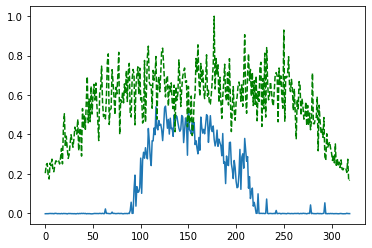

Time taken for epoch:  157.1971755027771
Epoch = [ 17/3000]  Iter = [   0/39480]  Loss = 0.204 Avg Loss = 0.204  Time = 0.1136s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 17/3000]  Iter = [ 100/39480]  Loss = 0.2336 Avg Loss = 0.2132  Time = 0.0036s
Epoch = [ 17/3000]  Iter = [ 200/39480]  Loss = 0.2329 Avg Loss = 0.2155  Time = 0.0034s
Epoch = [ 17/3000]  Iter = [ 300/39480]  Loss = 0.2302 Avg Loss = 0.2203  Time = 0.0036s
Epoch = [ 17/3000]  Iter = [ 400/39480]  Loss = 0.2218 Avg Loss = 0.2213  Time = 0.0032s
Epoch = [ 17/3000]  Iter = [ 500/39480]  Loss = 0.2183 Avg Loss = 0.2166  Time = 0.0035s
Epoch = [ 17/3000]  Iter = [ 600/39480]  Loss = 0.2236 Avg Loss = 0.2155  Time = 0.0029s
Epoch = [ 17/3000]  Iter = [ 700/39480]  Loss = 0.2062 Avg Loss = 0.2155  Time = 0.0030s
Epoch = [ 17/3000]  Iter = [ 800/39480]  Loss = 0.2469 Avg Loss = 0.2152  Time = 0.0032s
Epoch = [ 17/3000]  Iter = [ 900/39480]  Loss = 0.1974 Avg Loss = 0.218  Time = 0.0037s
Epoch = [ 17/3000]  Iter = [1000/39480]  Loss = 0.1861 Avg Loss = 0.2158  Time = 0.0031s
Epoch = [ 17/3000]  Iter = [1100/39480]  Loss = 0.2256 Avg Loss = 0.2192  Time = 0.0035s
Epoch = [ 17/3000]  It

Epoch = [ 17/3000]  Iter = [9400/39480]  Loss = 0.1962 Avg Loss = 0.2147  Time = 0.0035s
Epoch = [ 17/3000]  Iter = [9500/39480]  Loss = 0.2314 Avg Loss = 0.2158  Time = 0.0032s
Epoch = [ 17/3000]  Iter = [9600/39480]  Loss = 0.2142 Avg Loss = 0.2155  Time = 0.0042s
Epoch = [ 17/3000]  Iter = [9700/39480]  Loss = 0.1833 Avg Loss = 0.2175  Time = 0.0033s
Epoch = [ 17/3000]  Iter = [9800/39480]  Loss = 0.2002 Avg Loss = 0.217  Time = 0.0036s
Epoch = [ 17/3000]  Iter = [9900/39480]  Loss = 0.194 Avg Loss = 0.2177  Time = 0.0032s
Epoch = [ 17/3000]  Iter = [10000/39480]  Loss = 0.2272 Avg Loss = 0.2179  Time = 0.0035s
Epoch = [ 17/3000]  Iter = [10100/39480]  Loss = 0.1939 Avg Loss = 0.2153  Time = 0.0033s
Epoch = [ 17/3000]  Iter = [10200/39480]  Loss = 0.2191 Avg Loss = 0.2179  Time = 0.0035s
Epoch = [ 17/3000]  Iter = [10300/39480]  Loss = 0.2023 Avg Loss = 0.2219  Time = 0.0044s
Epoch = [ 17/3000]  Iter = [10400/39480]  Loss = 0.2109 Avg Loss = 0.2221  Time = 0.0035s
Epoch = [ 17/3000]

Epoch = [ 17/3000]  Iter = [18600/39480]  Loss = 0.2165 Avg Loss = 0.2172  Time = 0.0035s
Epoch = [ 17/3000]  Iter = [18700/39480]  Loss = 0.2245 Avg Loss = 0.2161  Time = 0.0033s
Epoch = [ 17/3000]  Iter = [18800/39480]  Loss = 0.1986 Avg Loss = 0.219  Time = 0.0035s
Epoch = [ 17/3000]  Iter = [18900/39480]  Loss = 0.2278 Avg Loss = 0.2162  Time = 0.0032s
Epoch = [ 17/3000]  Iter = [19000/39480]  Loss = 0.2213 Avg Loss = 0.2199  Time = 0.0035s
Epoch = [ 17/3000]  Iter = [19100/39480]  Loss = 0.2055 Avg Loss = 0.2184  Time = 0.0030s
Epoch = [ 17/3000]  Iter = [19200/39480]  Loss = 0.1974 Avg Loss = 0.2209  Time = 0.0036s
Epoch = [ 17/3000]  Iter = [19300/39480]  Loss = 0.2181 Avg Loss = 0.2156  Time = 0.0032s
Epoch = [ 17/3000]  Iter = [19400/39480]  Loss = 0.2372 Avg Loss = 0.2148  Time = 0.0035s
Epoch = [ 17/3000]  Iter = [19500/39480]  Loss = 0.1955 Avg Loss = 0.2162  Time = 0.0035s
Epoch = [ 17/3000]  Iter = [19600/39480]  Loss = 0.2788 Avg Loss = 0.2224  Time = 0.0034s
Epoch = [ 1

Epoch = [ 17/3000]  Iter = [27800/39480]  Loss = 0.1973 Avg Loss = 0.2183  Time = 0.0035s
Epoch = [ 17/3000]  Iter = [27900/39480]  Loss = 0.2444 Avg Loss = 0.22  Time = 0.0037s
Epoch = [ 17/3000]  Iter = [28000/39480]  Loss = 0.2207 Avg Loss = 0.2181  Time = 0.0034s
Epoch = [ 17/3000]  Iter = [28100/39480]  Loss = 0.1977 Avg Loss = 0.221  Time = 0.0033s
Epoch = [ 17/3000]  Iter = [28200/39480]  Loss = 0.2253 Avg Loss = 0.219  Time = 0.0034s
Epoch = [ 17/3000]  Iter = [28300/39480]  Loss = 0.2003 Avg Loss = 0.2177  Time = 0.0032s
Epoch = [ 17/3000]  Iter = [28400/39480]  Loss = 0.2371 Avg Loss = 0.2189  Time = 0.0038s
Epoch = [ 17/3000]  Iter = [28500/39480]  Loss = 0.1945 Avg Loss = 0.2142  Time = 0.0036s
Epoch = [ 17/3000]  Iter = [28600/39480]  Loss = 0.2207 Avg Loss = 0.2152  Time = 0.0036s
Epoch = [ 17/3000]  Iter = [28700/39480]  Loss = 0.1789 Avg Loss = 0.2163  Time = 0.0033s
Epoch = [ 17/3000]  Iter = [28800/39480]  Loss = 0.2 Avg Loss = 0.2171  Time = 0.0035s
Epoch = [ 17/3000

Epoch = [ 17/3000]  Iter = [37000/39480]  Loss = 0.2373 Avg Loss = 0.2194  Time = 0.0034s
Epoch = [ 17/3000]  Iter = [37100/39480]  Loss = 0.2264 Avg Loss = 0.2138  Time = 0.0035s
Epoch = [ 17/3000]  Iter = [37200/39480]  Loss = 0.2502 Avg Loss = 0.2263  Time = 0.0029s
Epoch = [ 17/3000]  Iter = [37300/39480]  Loss = 0.1965 Avg Loss = 0.2185  Time = 0.0037s
Epoch = [ 17/3000]  Iter = [37400/39480]  Loss = 0.2341 Avg Loss = 0.2243  Time = 0.0031s
Epoch = [ 17/3000]  Iter = [37500/39480]  Loss = 0.2095 Avg Loss = 0.2198  Time = 0.0036s
Epoch = [ 17/3000]  Iter = [37600/39480]  Loss = 0.2203 Avg Loss = 0.217  Time = 0.0036s
Epoch = [ 17/3000]  Iter = [37700/39480]  Loss = 0.2042 Avg Loss = 0.2166  Time = 0.0035s
Epoch = [ 17/3000]  Iter = [37800/39480]  Loss = 0.1943 Avg Loss = 0.2151  Time = 0.0036s
Epoch = [ 17/3000]  Iter = [37900/39480]  Loss = 0.2028 Avg Loss = 0.216  Time = 0.0034s
Epoch = [ 17/3000]  Iter = [38000/39480]  Loss = 0.234 Avg Loss = 0.2171  Time = 0.0032s
Epoch = [ 17/

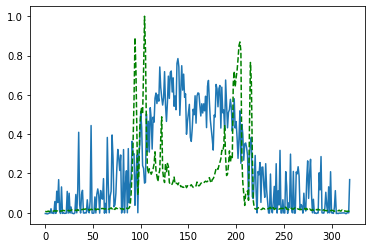

Time taken for epoch:  155.36194467544556
Epoch = [ 18/3000]  Iter = [   0/39480]  Loss = 0.2333 Avg Loss = 0.2333  Time = 0.1059s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 18/3000]  Iter = [ 100/39480]  Loss = 0.2304 Avg Loss = 0.2257  Time = 0.0035s
Epoch = [ 18/3000]  Iter = [ 200/39480]  Loss = 0.2291 Avg Loss = 0.2254  Time = 0.0038s
Epoch = [ 18/3000]  Iter = [ 300/39480]  Loss = 0.2194 Avg Loss = 0.2207  Time = 0.0036s
Epoch = [ 18/3000]  Iter = [ 400/39480]  Loss = 0.2266 Avg Loss = 0.2179  Time = 0.0038s
Epoch = [ 18/3000]  Iter = [ 500/39480]  Loss = 0.2022 Avg Loss = 0.215  Time = 0.0047s
Epoch = [ 18/3000]  Iter = [ 600/39480]  Loss = 0.2074 Avg Loss = 0.2225  Time = 0.0034s
Epoch = [ 18/3000]  Iter = [ 700/39480]  Loss = 0.1838 Avg Loss = 0.2205  Time = 0.0037s
Epoch = [ 18/3000]  Iter = [ 800/39480]  Loss = 0.1846 Avg Loss = 0.2184  Time = 0.0025s
Epoch = [ 18/3000]  Iter = [ 900/39480]  Loss = 0.2106 Avg Loss = 0.2179  Time = 0.0054s
Epoch = [ 18/3000]  Iter = [1000/39480]  Loss = 0.2449 Avg Loss = 0.2218  Time = 0.0031s
Epoch = [ 18/3000]  Iter = [1100/39480]  Loss = 0.2219 Avg Loss = 0.2194  Time = 0.0039s
Epoch = [ 18/3000]  It

Epoch = [ 18/3000]  Iter = [9400/39480]  Loss = 0.2196 Avg Loss = 0.2183  Time = 0.0035s
Epoch = [ 18/3000]  Iter = [9500/39480]  Loss = 0.1789 Avg Loss = 0.2158  Time = 0.0033s
Epoch = [ 18/3000]  Iter = [9600/39480]  Loss = 0.2644 Avg Loss = 0.2168  Time = 0.0035s
Epoch = [ 18/3000]  Iter = [9700/39480]  Loss = 0.2423 Avg Loss = 0.2197  Time = 0.0032s
Epoch = [ 18/3000]  Iter = [9800/39480]  Loss = 0.2198 Avg Loss = 0.2199  Time = 0.0036s
Epoch = [ 18/3000]  Iter = [9900/39480]  Loss = 0.2221 Avg Loss = 0.2169  Time = 0.0035s
Epoch = [ 18/3000]  Iter = [10000/39480]  Loss = 0.1996 Avg Loss = 0.2165  Time = 0.0046s
Epoch = [ 18/3000]  Iter = [10100/39480]  Loss = 0.2571 Avg Loss = 0.2176  Time = 0.0031s
Epoch = [ 18/3000]  Iter = [10200/39480]  Loss = 0.2131 Avg Loss = 0.2191  Time = 0.0036s
Epoch = [ 18/3000]  Iter = [10300/39480]  Loss = 0.29 Avg Loss = 0.2168  Time = 0.0031s
Epoch = [ 18/3000]  Iter = [10400/39480]  Loss = 0.2323 Avg Loss = 0.2181  Time = 0.0034s
Epoch = [ 18/3000]

Epoch = [ 18/3000]  Iter = [18600/39480]  Loss = 0.2262 Avg Loss = 0.2198  Time = 0.0037s
Epoch = [ 18/3000]  Iter = [18700/39480]  Loss = 0.2276 Avg Loss = 0.217  Time = 0.0034s
Epoch = [ 18/3000]  Iter = [18800/39480]  Loss = 0.2014 Avg Loss = 0.2191  Time = 0.0029s
Epoch = [ 18/3000]  Iter = [18900/39480]  Loss = 0.202 Avg Loss = 0.2192  Time = 0.0035s
Epoch = [ 18/3000]  Iter = [19000/39480]  Loss = 0.2162 Avg Loss = 0.2191  Time = 0.0034s
Epoch = [ 18/3000]  Iter = [19100/39480]  Loss = 0.2056 Avg Loss = 0.2175  Time = 0.0034s
Epoch = [ 18/3000]  Iter = [19200/39480]  Loss = 0.2224 Avg Loss = 0.2165  Time = 0.0037s
Epoch = [ 18/3000]  Iter = [19300/39480]  Loss = 0.2272 Avg Loss = 0.2226  Time = 0.0038s
Epoch = [ 18/3000]  Iter = [19400/39480]  Loss = 0.2104 Avg Loss = 0.2175  Time = 0.0036s
Epoch = [ 18/3000]  Iter = [19500/39480]  Loss = 0.1988 Avg Loss = 0.216  Time = 0.0034s
Epoch = [ 18/3000]  Iter = [19600/39480]  Loss = 0.2133 Avg Loss = 0.2202  Time = 0.0034s
Epoch = [ 18/

Epoch = [ 18/3000]  Iter = [27800/39480]  Loss = 0.242 Avg Loss = 0.2175  Time = 0.0049s
Epoch = [ 18/3000]  Iter = [27900/39480]  Loss = 0.2367 Avg Loss = 0.218  Time = 0.0036s
Epoch = [ 18/3000]  Iter = [28000/39480]  Loss = 0.1683 Avg Loss = 0.2166  Time = 0.0032s
Epoch = [ 18/3000]  Iter = [28100/39480]  Loss = 0.2307 Avg Loss = 0.2168  Time = 0.0034s
Epoch = [ 18/3000]  Iter = [28200/39480]  Loss = 0.2041 Avg Loss = 0.2165  Time = 0.0031s
Epoch = [ 18/3000]  Iter = [28300/39480]  Loss = 0.2132 Avg Loss = 0.217  Time = 0.0032s
Epoch = [ 18/3000]  Iter = [28400/39480]  Loss = 0.2101 Avg Loss = 0.2198  Time = 0.0032s
Epoch = [ 18/3000]  Iter = [28500/39480]  Loss = 0.2653 Avg Loss = 0.2237  Time = 0.0036s
Epoch = [ 18/3000]  Iter = [28600/39480]  Loss = 0.2509 Avg Loss = 0.2185  Time = 0.0033s
Epoch = [ 18/3000]  Iter = [28700/39480]  Loss = 0.2249 Avg Loss = 0.2168  Time = 0.0034s
Epoch = [ 18/3000]  Iter = [28800/39480]  Loss = 0.2093 Avg Loss = 0.2166  Time = 0.0035s
Epoch = [ 18/

Epoch = [ 18/3000]  Iter = [37000/39480]  Loss = 0.2184 Avg Loss = 0.219  Time = 0.0038s
Epoch = [ 18/3000]  Iter = [37100/39480]  Loss = 0.2225 Avg Loss = 0.216  Time = 0.0035s
Epoch = [ 18/3000]  Iter = [37200/39480]  Loss = 0.1992 Avg Loss = 0.2163  Time = 0.0036s
Epoch = [ 18/3000]  Iter = [37300/39480]  Loss = 0.235 Avg Loss = 0.2201  Time = 0.0036s
Epoch = [ 18/3000]  Iter = [37400/39480]  Loss = 0.1868 Avg Loss = 0.2227  Time = 0.0038s
Epoch = [ 18/3000]  Iter = [37500/39480]  Loss = 0.2027 Avg Loss = 0.2208  Time = 0.0032s
Epoch = [ 18/3000]  Iter = [37600/39480]  Loss = 0.2359 Avg Loss = 0.2192  Time = 0.0035s
Epoch = [ 18/3000]  Iter = [37700/39480]  Loss = 0.1982 Avg Loss = 0.2197  Time = 0.0034s
Epoch = [ 18/3000]  Iter = [37800/39480]  Loss = 0.2121 Avg Loss = 0.2206  Time = 0.0036s
Epoch = [ 18/3000]  Iter = [37900/39480]  Loss = 0.2365 Avg Loss = 0.2203  Time = 0.0034s
Epoch = [ 18/3000]  Iter = [38000/39480]  Loss = 0.2072 Avg Loss = 0.2199  Time = 0.0035s
Epoch = [ 18/

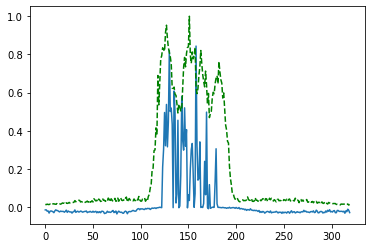

Time taken for epoch:  157.0603003501892
Epoch = [ 19/3000]  Iter = [   0/39480]  Loss = 0.2427 Avg Loss = 0.2427  Time = 0.0985s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 19/3000]  Iter = [ 100/39480]  Loss = 0.2383 Avg Loss = 0.2295  Time = 0.0034s
Epoch = [ 19/3000]  Iter = [ 200/39480]  Loss = 0.2195 Avg Loss = 0.2245  Time = 0.0035s
Epoch = [ 19/3000]  Iter = [ 300/39480]  Loss = 0.2299 Avg Loss = 0.2189  Time = 0.0036s
Epoch = [ 19/3000]  Iter = [ 400/39480]  Loss = 0.255 Avg Loss = 0.2175  Time = 0.0058s
Epoch = [ 19/3000]  Iter = [ 500/39480]  Loss = 0.23 Avg Loss = 0.2162  Time = 0.0038s
Epoch = [ 19/3000]  Iter = [ 600/39480]  Loss = 0.2021 Avg Loss = 0.2133  Time = 0.0030s
Epoch = [ 19/3000]  Iter = [ 700/39480]  Loss = 0.2094 Avg Loss = 0.2166  Time = 0.0032s
Epoch = [ 19/3000]  Iter = [ 800/39480]  Loss = 0.2332 Avg Loss = 0.2191  Time = 0.0036s
Epoch = [ 19/3000]  Iter = [ 900/39480]  Loss = 0.2064 Avg Loss = 0.2228  Time = 0.0036s
Epoch = [ 19/3000]  Iter = [1000/39480]  Loss = 0.2113 Avg Loss = 0.2163  Time = 0.0046s
Epoch = [ 19/3000]  Iter = [1100/39480]  Loss = 0.23 Avg Loss = 0.2174  Time = 0.0032s
Epoch = [ 19/3000]  Iter =

Epoch = [ 19/3000]  Iter = [9400/39480]  Loss = 0.2235 Avg Loss = 0.2148  Time = 0.0039s
Epoch = [ 19/3000]  Iter = [9500/39480]  Loss = 0.2196 Avg Loss = 0.2185  Time = 0.0034s
Epoch = [ 19/3000]  Iter = [9600/39480]  Loss = 0.2345 Avg Loss = 0.2173  Time = 0.0036s
Epoch = [ 19/3000]  Iter = [9700/39480]  Loss = 0.1745 Avg Loss = 0.2164  Time = 0.0034s
Epoch = [ 19/3000]  Iter = [9800/39480]  Loss = 0.2087 Avg Loss = 0.2199  Time = 0.0043s
Epoch = [ 19/3000]  Iter = [9900/39480]  Loss = 0.22 Avg Loss = 0.2204  Time = 0.0029s
Epoch = [ 19/3000]  Iter = [10000/39480]  Loss = 0.2441 Avg Loss = 0.217  Time = 0.0030s
Epoch = [ 19/3000]  Iter = [10100/39480]  Loss = 0.2173 Avg Loss = 0.2201  Time = 0.0043s
Epoch = [ 19/3000]  Iter = [10200/39480]  Loss = 0.2078 Avg Loss = 0.2209  Time = 0.0034s
Epoch = [ 19/3000]  Iter = [10300/39480]  Loss = 0.1909 Avg Loss = 0.217  Time = 0.0036s
Epoch = [ 19/3000]  Iter = [10400/39480]  Loss = 0.1889 Avg Loss = 0.2144  Time = 0.0050s
Epoch = [ 19/3000]  

Epoch = [ 19/3000]  Iter = [18600/39480]  Loss = 0.194 Avg Loss = 0.2175  Time = 0.0039s
Epoch = [ 19/3000]  Iter = [18700/39480]  Loss = 0.1945 Avg Loss = 0.2159  Time = 0.0033s
Epoch = [ 19/3000]  Iter = [18800/39480]  Loss = 0.1795 Avg Loss = 0.2217  Time = 0.0037s
Epoch = [ 19/3000]  Iter = [18900/39480]  Loss = 0.2656 Avg Loss = 0.2229  Time = 0.0037s
Epoch = [ 19/3000]  Iter = [19000/39480]  Loss = 0.2462 Avg Loss = 0.2181  Time = 0.0035s
Epoch = [ 19/3000]  Iter = [19100/39480]  Loss = 0.2218 Avg Loss = 0.2193  Time = 0.0033s
Epoch = [ 19/3000]  Iter = [19200/39480]  Loss = 0.236 Avg Loss = 0.2184  Time = 0.0036s
Epoch = [ 19/3000]  Iter = [19300/39480]  Loss = 0.2633 Avg Loss = 0.2203  Time = 0.0034s
Epoch = [ 19/3000]  Iter = [19400/39480]  Loss = 0.2145 Avg Loss = 0.2217  Time = 0.0036s
Epoch = [ 19/3000]  Iter = [19500/39480]  Loss = 0.2163 Avg Loss = 0.2223  Time = 0.0034s
Epoch = [ 19/3000]  Iter = [19600/39480]  Loss = 0.204 Avg Loss = 0.2189  Time = 0.0033s
Epoch = [ 19/

Epoch = [ 19/3000]  Iter = [27800/39480]  Loss = 0.224 Avg Loss = 0.218  Time = 0.0035s
Epoch = [ 19/3000]  Iter = [27900/39480]  Loss = 0.2197 Avg Loss = 0.2155  Time = 0.0033s
Epoch = [ 19/3000]  Iter = [28000/39480]  Loss = 0.2313 Avg Loss = 0.2226  Time = 0.0035s
Epoch = [ 19/3000]  Iter = [28100/39480]  Loss = 0.2456 Avg Loss = 0.2149  Time = 0.0032s
Epoch = [ 19/3000]  Iter = [28200/39480]  Loss = 0.2025 Avg Loss = 0.2196  Time = 0.0045s
Epoch = [ 19/3000]  Iter = [28300/39480]  Loss = 0.233 Avg Loss = 0.2186  Time = 0.0034s
Epoch = [ 19/3000]  Iter = [28400/39480]  Loss = 0.2131 Avg Loss = 0.2164  Time = 0.0036s
Epoch = [ 19/3000]  Iter = [28500/39480]  Loss = 0.2255 Avg Loss = 0.2228  Time = 0.0034s
Epoch = [ 19/3000]  Iter = [28600/39480]  Loss = 0.246 Avg Loss = 0.2214  Time = 0.0049s
Epoch = [ 19/3000]  Iter = [28700/39480]  Loss = 0.2075 Avg Loss = 0.2161  Time = 0.0030s
Epoch = [ 19/3000]  Iter = [28800/39480]  Loss = 0.218 Avg Loss = 0.2188  Time = 0.0052s
Epoch = [ 19/30

Epoch = [ 19/3000]  Iter = [37000/39480]  Loss = 0.1905 Avg Loss = 0.2158  Time = 0.0033s
Epoch = [ 19/3000]  Iter = [37100/39480]  Loss = 0.2239 Avg Loss = 0.2164  Time = 0.0032s
Epoch = [ 19/3000]  Iter = [37200/39480]  Loss = 0.2042 Avg Loss = 0.2173  Time = 0.0038s
Epoch = [ 19/3000]  Iter = [37300/39480]  Loss = 0.1891 Avg Loss = 0.2191  Time = 0.0049s
Epoch = [ 19/3000]  Iter = [37400/39480]  Loss = 0.2281 Avg Loss = 0.2199  Time = 0.0033s
Epoch = [ 19/3000]  Iter = [37500/39480]  Loss = 0.2315 Avg Loss = 0.2169  Time = 0.0044s
Epoch = [ 19/3000]  Iter = [37600/39480]  Loss = 0.2013 Avg Loss = 0.2168  Time = 0.0036s
Epoch = [ 19/3000]  Iter = [37700/39480]  Loss = 0.2627 Avg Loss = 0.218  Time = 0.0034s
Epoch = [ 19/3000]  Iter = [37800/39480]  Loss = 0.2274 Avg Loss = 0.2145  Time = 0.0037s
Epoch = [ 19/3000]  Iter = [37900/39480]  Loss = 0.1805 Avg Loss = 0.2159  Time = 0.0033s
Epoch = [ 19/3000]  Iter = [38000/39480]  Loss = 0.2322 Avg Loss = 0.2211  Time = 0.0043s
Epoch = [ 1

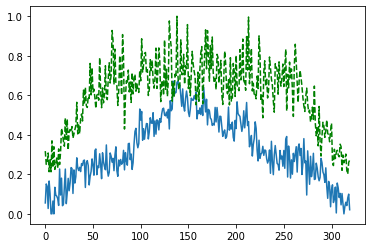

Time taken for epoch:  157.40149593353271
Epoch = [ 20/3000]  Iter = [   0/39480]  Loss = 0.2262 Avg Loss = 0.2262  Time = 0.1079s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 20/3000]  Iter = [ 100/39480]  Loss = 0.2034 Avg Loss = 0.223  Time = 0.0031s
Epoch = [ 20/3000]  Iter = [ 200/39480]  Loss = 0.1876 Avg Loss = 0.2218  Time = 0.0035s
Epoch = [ 20/3000]  Iter = [ 300/39480]  Loss = 0.2827 Avg Loss = 0.218  Time = 0.0032s
Epoch = [ 20/3000]  Iter = [ 400/39480]  Loss = 0.2678 Avg Loss = 0.2201  Time = 0.0035s
Epoch = [ 20/3000]  Iter = [ 500/39480]  Loss = 0.2089 Avg Loss = 0.2144  Time = 0.0033s
Epoch = [ 20/3000]  Iter = [ 600/39480]  Loss = 0.2137 Avg Loss = 0.2149  Time = 0.0033s
Epoch = [ 20/3000]  Iter = [ 700/39480]  Loss = 0.2128 Avg Loss = 0.2168  Time = 0.0031s
Epoch = [ 20/3000]  Iter = [ 800/39480]  Loss = 0.2313 Avg Loss = 0.219  Time = 0.0034s
Epoch = [ 20/3000]  Iter = [ 900/39480]  Loss = 0.2171 Avg Loss = 0.2239  Time = 0.0032s
Epoch = [ 20/3000]  Iter = [1000/39480]  Loss = 0.2255 Avg Loss = 0.2175  Time = 0.0034s
Epoch = [ 20/3000]  Iter = [1100/39480]  Loss = 0.2089 Avg Loss = 0.2197  Time = 0.0033s
Epoch = [ 20/3000]  Iter

Epoch = [ 20/3000]  Iter = [9400/39480]  Loss = 0.2166 Avg Loss = 0.2165  Time = 0.0035s
Epoch = [ 20/3000]  Iter = [9500/39480]  Loss = 0.2245 Avg Loss = 0.2185  Time = 0.0033s
Epoch = [ 20/3000]  Iter = [9600/39480]  Loss = 0.2059 Avg Loss = 0.2162  Time = 0.0037s
Epoch = [ 20/3000]  Iter = [9700/39480]  Loss = 0.2176 Avg Loss = 0.2195  Time = 0.0032s
Epoch = [ 20/3000]  Iter = [9800/39480]  Loss = 0.1929 Avg Loss = 0.2188  Time = 0.0032s
Epoch = [ 20/3000]  Iter = [9900/39480]  Loss = 0.2308 Avg Loss = 0.2197  Time = 0.0037s
Epoch = [ 20/3000]  Iter = [10000/39480]  Loss = 0.2561 Avg Loss = 0.222  Time = 0.0032s
Epoch = [ 20/3000]  Iter = [10100/39480]  Loss = 0.1982 Avg Loss = 0.219  Time = 0.0035s
Epoch = [ 20/3000]  Iter = [10200/39480]  Loss = 0.1998 Avg Loss = 0.221  Time = 0.0036s
Epoch = [ 20/3000]  Iter = [10300/39480]  Loss = 0.1848 Avg Loss = 0.2193  Time = 0.0036s
Epoch = [ 20/3000]  Iter = [10400/39480]  Loss = 0.2426 Avg Loss = 0.2203  Time = 0.0037s
Epoch = [ 20/3000] 

Epoch = [ 20/3000]  Iter = [18600/39480]  Loss = 0.2542 Avg Loss = 0.2186  Time = 0.0035s
Epoch = [ 20/3000]  Iter = [18700/39480]  Loss = 0.2087 Avg Loss = 0.2192  Time = 0.0033s
Epoch = [ 20/3000]  Iter = [18800/39480]  Loss = 0.2293 Avg Loss = 0.2181  Time = 0.0033s
Epoch = [ 20/3000]  Iter = [18900/39480]  Loss = 0.2208 Avg Loss = 0.2185  Time = 0.0035s
Epoch = [ 20/3000]  Iter = [19000/39480]  Loss = 0.2449 Avg Loss = 0.2204  Time = 0.0031s
Epoch = [ 20/3000]  Iter = [19100/39480]  Loss = 0.203 Avg Loss = 0.2182  Time = 0.0039s
Epoch = [ 20/3000]  Iter = [19200/39480]  Loss = 0.2201 Avg Loss = 0.2189  Time = 0.0035s
Epoch = [ 20/3000]  Iter = [19300/39480]  Loss = 0.2355 Avg Loss = 0.2201  Time = 0.0034s
Epoch = [ 20/3000]  Iter = [19400/39480]  Loss = 0.199 Avg Loss = 0.2186  Time = 0.0034s
Epoch = [ 20/3000]  Iter = [19500/39480]  Loss = 0.2105 Avg Loss = 0.2189  Time = 0.0034s
Epoch = [ 20/3000]  Iter = [19600/39480]  Loss = 0.2595 Avg Loss = 0.2202  Time = 0.0035s
Epoch = [ 20

Epoch = [ 20/3000]  Iter = [27800/39480]  Loss = 0.2095 Avg Loss = 0.2158  Time = 0.0032s
Epoch = [ 20/3000]  Iter = [27900/39480]  Loss = 0.2418 Avg Loss = 0.2177  Time = 0.0028s
Epoch = [ 20/3000]  Iter = [28000/39480]  Loss = 0.2028 Avg Loss = 0.2188  Time = 0.0031s
Epoch = [ 20/3000]  Iter = [28100/39480]  Loss = 0.2351 Avg Loss = 0.2158  Time = 0.0030s
Epoch = [ 20/3000]  Iter = [28200/39480]  Loss = 0.2206 Avg Loss = 0.2194  Time = 0.0036s
Epoch = [ 20/3000]  Iter = [28300/39480]  Loss = 0.2334 Avg Loss = 0.2177  Time = 0.0027s
Epoch = [ 20/3000]  Iter = [28400/39480]  Loss = 0.1965 Avg Loss = 0.2221  Time = 0.0038s
Epoch = [ 20/3000]  Iter = [28500/39480]  Loss = 0.2388 Avg Loss = 0.2182  Time = 0.0031s
Epoch = [ 20/3000]  Iter = [28600/39480]  Loss = 0.1892 Avg Loss = 0.2164  Time = 0.0034s
Epoch = [ 20/3000]  Iter = [28700/39480]  Loss = 0.2305 Avg Loss = 0.2168  Time = 0.0032s
Epoch = [ 20/3000]  Iter = [28800/39480]  Loss = 0.1755 Avg Loss = 0.2168  Time = 0.0037s
Epoch = [ 

Epoch = [ 20/3000]  Iter = [37000/39480]  Loss = 0.2031 Avg Loss = 0.2114  Time = 0.0036s
Epoch = [ 20/3000]  Iter = [37100/39480]  Loss = 0.1817 Avg Loss = 0.2148  Time = 0.0031s
Epoch = [ 20/3000]  Iter = [37200/39480]  Loss = 0.2274 Avg Loss = 0.2134  Time = 0.0033s
Epoch = [ 20/3000]  Iter = [37300/39480]  Loss = 0.2094 Avg Loss = 0.2181  Time = 0.0037s
Epoch = [ 20/3000]  Iter = [37400/39480]  Loss = 0.215 Avg Loss = 0.2175  Time = 0.0036s
Epoch = [ 20/3000]  Iter = [37500/39480]  Loss = 0.2402 Avg Loss = 0.218  Time = 0.0034s
Epoch = [ 20/3000]  Iter = [37600/39480]  Loss = 0.1809 Avg Loss = 0.2145  Time = 0.0032s
Epoch = [ 20/3000]  Iter = [37700/39480]  Loss = 0.2601 Avg Loss = 0.2166  Time = 0.0049s
Epoch = [ 20/3000]  Iter = [37800/39480]  Loss = 0.2137 Avg Loss = 0.2192  Time = 0.0037s
Epoch = [ 20/3000]  Iter = [37900/39480]  Loss = 0.2209 Avg Loss = 0.2229  Time = 0.0034s
Epoch = [ 20/3000]  Iter = [38000/39480]  Loss = 0.2021 Avg Loss = 0.2188  Time = 0.0033s
Epoch = [ 20

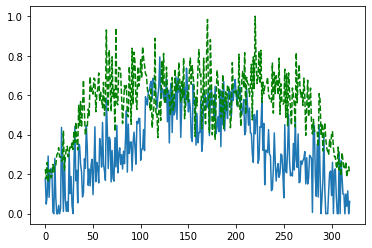

Time taken for epoch:  156.88745212554932
Epoch = [ 21/3000]  Iter = [   0/39480]  Loss = 0.2216 Avg Loss = 0.2216  Time = 0.1048s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 21/3000]  Iter = [ 100/39480]  Loss = 0.1928 Avg Loss = 0.2192  Time = 0.0037s
Epoch = [ 21/3000]  Iter = [ 200/39480]  Loss = 0.2276 Avg Loss = 0.2188  Time = 0.0036s
Epoch = [ 21/3000]  Iter = [ 300/39480]  Loss = 0.2145 Avg Loss = 0.2153  Time = 0.0035s
Epoch = [ 21/3000]  Iter = [ 400/39480]  Loss = 0.2305 Avg Loss = 0.219  Time = 0.0033s
Epoch = [ 21/3000]  Iter = [ 500/39480]  Loss = 0.2218 Avg Loss = 0.2209  Time = 0.0049s
Epoch = [ 21/3000]  Iter = [ 600/39480]  Loss = 0.2118 Avg Loss = 0.219  Time = 0.0033s
Epoch = [ 21/3000]  Iter = [ 700/39480]  Loss = 0.2439 Avg Loss = 0.2173  Time = 0.0036s
Epoch = [ 21/3000]  Iter = [ 800/39480]  Loss = 0.2053 Avg Loss = 0.2187  Time = 0.0035s
Epoch = [ 21/3000]  Iter = [ 900/39480]  Loss = 0.2025 Avg Loss = 0.2145  Time = 0.0035s
Epoch = [ 21/3000]  Iter = [1000/39480]  Loss = 0.2131 Avg Loss = 0.2177  Time = 0.0034s
Epoch = [ 21/3000]  Iter = [1100/39480]  Loss = 0.2316 Avg Loss = 0.2164  Time = 0.0031s
Epoch = [ 21/3000]  Ite

Epoch = [ 21/3000]  Iter = [9400/39480]  Loss = 0.2011 Avg Loss = 0.2147  Time = 0.0034s
Epoch = [ 21/3000]  Iter = [9500/39480]  Loss = 0.2195 Avg Loss = 0.2148  Time = 0.0036s
Epoch = [ 21/3000]  Iter = [9600/39480]  Loss = 0.2051 Avg Loss = 0.2172  Time = 0.0034s
Epoch = [ 21/3000]  Iter = [9700/39480]  Loss = 0.2046 Avg Loss = 0.2194  Time = 0.0033s
Epoch = [ 21/3000]  Iter = [9800/39480]  Loss = 0.2585 Avg Loss = 0.2193  Time = 0.0034s
Epoch = [ 21/3000]  Iter = [9900/39480]  Loss = 0.2028 Avg Loss = 0.2157  Time = 0.0033s
Epoch = [ 21/3000]  Iter = [10000/39480]  Loss = 0.2255 Avg Loss = 0.2149  Time = 0.0032s
Epoch = [ 21/3000]  Iter = [10100/39480]  Loss = 0.2119 Avg Loss = 0.2202  Time = 0.0035s
Epoch = [ 21/3000]  Iter = [10200/39480]  Loss = 0.2089 Avg Loss = 0.2177  Time = 0.0033s
Epoch = [ 21/3000]  Iter = [10300/39480]  Loss = 0.233 Avg Loss = 0.2239  Time = 0.0035s
Epoch = [ 21/3000]  Iter = [10400/39480]  Loss = 0.254 Avg Loss = 0.2212  Time = 0.0036s
Epoch = [ 21/3000]

Epoch = [ 21/3000]  Iter = [18600/39480]  Loss = 0.2136 Avg Loss = 0.214  Time = 0.0030s
Epoch = [ 21/3000]  Iter = [18700/39480]  Loss = 0.2229 Avg Loss = 0.2178  Time = 0.0037s
Epoch = [ 21/3000]  Iter = [18800/39480]  Loss = 0.2472 Avg Loss = 0.2211  Time = 0.0034s
Epoch = [ 21/3000]  Iter = [18900/39480]  Loss = 0.2379 Avg Loss = 0.223  Time = 0.0037s
Epoch = [ 21/3000]  Iter = [19000/39480]  Loss = 0.2372 Avg Loss = 0.2217  Time = 0.0036s
Epoch = [ 21/3000]  Iter = [19100/39480]  Loss = 0.2053 Avg Loss = 0.2175  Time = 0.0032s
Epoch = [ 21/3000]  Iter = [19200/39480]  Loss = 0.2519 Avg Loss = 0.2163  Time = 0.0034s
Epoch = [ 21/3000]  Iter = [19300/39480]  Loss = 0.2046 Avg Loss = 0.2182  Time = 0.0034s
Epoch = [ 21/3000]  Iter = [19400/39480]  Loss = 0.2269 Avg Loss = 0.2186  Time = 0.0032s
Epoch = [ 21/3000]  Iter = [19500/39480]  Loss = 0.2044 Avg Loss = 0.2131  Time = 0.0033s
Epoch = [ 21/3000]  Iter = [19600/39480]  Loss = 0.2142 Avg Loss = 0.2147  Time = 0.0035s
Epoch = [ 21

Epoch = [ 21/3000]  Iter = [27800/39480]  Loss = 0.2189 Avg Loss = 0.2143  Time = 0.0036s
Epoch = [ 21/3000]  Iter = [27900/39480]  Loss = 0.2292 Avg Loss = 0.2157  Time = 0.0034s
Epoch = [ 21/3000]  Iter = [28000/39480]  Loss = 0.2123 Avg Loss = 0.2182  Time = 0.0036s
Epoch = [ 21/3000]  Iter = [28100/39480]  Loss = 0.19 Avg Loss = 0.2219  Time = 0.0031s
Epoch = [ 21/3000]  Iter = [28200/39480]  Loss = 0.2534 Avg Loss = 0.2182  Time = 0.0037s
Epoch = [ 21/3000]  Iter = [28300/39480]  Loss = 0.2294 Avg Loss = 0.2198  Time = 0.0032s
Epoch = [ 21/3000]  Iter = [28400/39480]  Loss = 0.2467 Avg Loss = 0.2201  Time = 0.0036s
Epoch = [ 21/3000]  Iter = [28500/39480]  Loss = 0.2312 Avg Loss = 0.2167  Time = 0.0034s
Epoch = [ 21/3000]  Iter = [28600/39480]  Loss = 0.1905 Avg Loss = 0.2155  Time = 0.0052s
Epoch = [ 21/3000]  Iter = [28700/39480]  Loss = 0.2064 Avg Loss = 0.2185  Time = 0.0035s
Epoch = [ 21/3000]  Iter = [28800/39480]  Loss = 0.2326 Avg Loss = 0.221  Time = 0.0030s
Epoch = [ 21/

Epoch = [ 21/3000]  Iter = [37000/39480]  Loss = 0.1846 Avg Loss = 0.2219  Time = 0.0038s
Epoch = [ 21/3000]  Iter = [37100/39480]  Loss = 0.2611 Avg Loss = 0.2203  Time = 0.0034s
Epoch = [ 21/3000]  Iter = [37200/39480]  Loss = 0.2406 Avg Loss = 0.2177  Time = 0.0036s
Epoch = [ 21/3000]  Iter = [37300/39480]  Loss = 0.2059 Avg Loss = 0.2171  Time = 0.0045s
Epoch = [ 21/3000]  Iter = [37400/39480]  Loss = 0.2248 Avg Loss = 0.219  Time = 0.0036s
Epoch = [ 21/3000]  Iter = [37500/39480]  Loss = 0.1646 Avg Loss = 0.2146  Time = 0.0036s
Epoch = [ 21/3000]  Iter = [37600/39480]  Loss = 0.2202 Avg Loss = 0.2183  Time = 0.0037s
Epoch = [ 21/3000]  Iter = [37700/39480]  Loss = 0.2133 Avg Loss = 0.2156  Time = 0.0036s
Epoch = [ 21/3000]  Iter = [37800/39480]  Loss = 0.2218 Avg Loss = 0.2152  Time = 0.0030s
Epoch = [ 21/3000]  Iter = [37900/39480]  Loss = 0.2226 Avg Loss = 0.2195  Time = 0.0036s
Epoch = [ 21/3000]  Iter = [38000/39480]  Loss = 0.198 Avg Loss = 0.216  Time = 0.0032s
Epoch = [ 21/

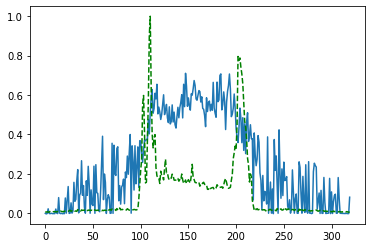

Time taken for epoch:  157.17521381378174
Epoch = [ 22/3000]  Iter = [   0/39480]  Loss = 0.2101 Avg Loss = 0.2101  Time = 0.1012s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 22/3000]  Iter = [ 100/39480]  Loss = 0.2 Avg Loss = 0.2163  Time = 0.0037s
Epoch = [ 22/3000]  Iter = [ 200/39480]  Loss = 0.2295 Avg Loss = 0.2192  Time = 0.0045s
Epoch = [ 22/3000]  Iter = [ 300/39480]  Loss = 0.1989 Avg Loss = 0.22  Time = 0.0037s
Epoch = [ 22/3000]  Iter = [ 400/39480]  Loss = 0.1786 Avg Loss = 0.218  Time = 0.0032s
Epoch = [ 22/3000]  Iter = [ 500/39480]  Loss = 0.2356 Avg Loss = 0.2189  Time = 0.0048s
Epoch = [ 22/3000]  Iter = [ 600/39480]  Loss = 0.2267 Avg Loss = 0.2211  Time = 0.0035s
Epoch = [ 22/3000]  Iter = [ 700/39480]  Loss = 0.2222 Avg Loss = 0.2199  Time = 0.0031s
Epoch = [ 22/3000]  Iter = [ 800/39480]  Loss = 0.2101 Avg Loss = 0.2179  Time = 0.0035s
Epoch = [ 22/3000]  Iter = [ 900/39480]  Loss = 0.1857 Avg Loss = 0.2221  Time = 0.0032s
Epoch = [ 22/3000]  Iter = [1000/39480]  Loss = 0.1966 Avg Loss = 0.2201  Time = 0.0036s
Epoch = [ 22/3000]  Iter = [1100/39480]  Loss = 0.2081 Avg Loss = 0.2191  Time = 0.0032s
Epoch = [ 22/3000]  Iter = 

Epoch = [ 22/3000]  Iter = [9400/39480]  Loss = 0.1919 Avg Loss = 0.2222  Time = 0.0033s
Epoch = [ 22/3000]  Iter = [9500/39480]  Loss = 0.2365 Avg Loss = 0.2216  Time = 0.0031s
Epoch = [ 22/3000]  Iter = [9600/39480]  Loss = 0.1989 Avg Loss = 0.2218  Time = 0.0039s
Epoch = [ 22/3000]  Iter = [9700/39480]  Loss = 0.2474 Avg Loss = 0.2138  Time = 0.0032s
Epoch = [ 22/3000]  Iter = [9800/39480]  Loss = 0.2162 Avg Loss = 0.2129  Time = 0.0034s
Epoch = [ 22/3000]  Iter = [9900/39480]  Loss = 0.2229 Avg Loss = 0.2205  Time = 0.0032s
Epoch = [ 22/3000]  Iter = [10000/39480]  Loss = 0.1994 Avg Loss = 0.2168  Time = 0.0036s
Epoch = [ 22/3000]  Iter = [10100/39480]  Loss = 0.2264 Avg Loss = 0.2159  Time = 0.0031s
Epoch = [ 22/3000]  Iter = [10200/39480]  Loss = 0.224 Avg Loss = 0.2176  Time = 0.0036s
Epoch = [ 22/3000]  Iter = [10300/39480]  Loss = 0.2117 Avg Loss = 0.2175  Time = 0.0032s
Epoch = [ 22/3000]  Iter = [10400/39480]  Loss = 0.1972 Avg Loss = 0.2151  Time = 0.0039s
Epoch = [ 22/3000

Epoch = [ 22/3000]  Iter = [18700/39480]  Loss = 0.215 Avg Loss = 0.2197  Time = 0.0029s
Epoch = [ 22/3000]  Iter = [18800/39480]  Loss = 0.2035 Avg Loss = 0.2164  Time = 0.0037s
Epoch = [ 22/3000]  Iter = [18900/39480]  Loss = 0.2363 Avg Loss = 0.2163  Time = 0.0031s
Epoch = [ 22/3000]  Iter = [19000/39480]  Loss = 0.2176 Avg Loss = 0.2115  Time = 0.0035s
Epoch = [ 22/3000]  Iter = [19100/39480]  Loss = 0.2156 Avg Loss = 0.2159  Time = 0.0033s
Epoch = [ 22/3000]  Iter = [19200/39480]  Loss = 0.2032 Avg Loss = 0.2156  Time = 0.0035s
Epoch = [ 22/3000]  Iter = [19300/39480]  Loss = 0.2195 Avg Loss = 0.2195  Time = 0.0031s
Epoch = [ 22/3000]  Iter = [19400/39480]  Loss = 0.2224 Avg Loss = 0.2154  Time = 0.0032s
Epoch = [ 22/3000]  Iter = [19500/39480]  Loss = 0.2605 Avg Loss = 0.2204  Time = 0.0037s
Epoch = [ 22/3000]  Iter = [19600/39480]  Loss = 0.2437 Avg Loss = 0.2214  Time = 0.0036s
Epoch = [ 22/3000]  Iter = [19700/39480]  Loss = 0.2155 Avg Loss = 0.2173  Time = 0.0031s
Epoch = [ 2

Epoch = [ 22/3000]  Iter = [27900/39480]  Loss = 0.2187 Avg Loss = 0.2195  Time = 0.0035s
Epoch = [ 22/3000]  Iter = [28000/39480]  Loss = 0.2242 Avg Loss = 0.2202  Time = 0.0033s
Epoch = [ 22/3000]  Iter = [28100/39480]  Loss = 0.1928 Avg Loss = 0.2139  Time = 0.0035s
Epoch = [ 22/3000]  Iter = [28200/39480]  Loss = 0.2127 Avg Loss = 0.2159  Time = 0.0036s
Epoch = [ 22/3000]  Iter = [28300/39480]  Loss = 0.1885 Avg Loss = 0.2201  Time = 0.0045s
Epoch = [ 22/3000]  Iter = [28400/39480]  Loss = 0.2443 Avg Loss = 0.2167  Time = 0.0035s
Epoch = [ 22/3000]  Iter = [28500/39480]  Loss = 0.2042 Avg Loss = 0.2192  Time = 0.0034s
Epoch = [ 22/3000]  Iter = [28600/39480]  Loss = 0.2436 Avg Loss = 0.2186  Time = 0.0031s
Epoch = [ 22/3000]  Iter = [28700/39480]  Loss = 0.219 Avg Loss = 0.2201  Time = 0.0035s
Epoch = [ 22/3000]  Iter = [28800/39480]  Loss = 0.213 Avg Loss = 0.2232  Time = 0.0030s
Epoch = [ 22/3000]  Iter = [28900/39480]  Loss = 0.212 Avg Loss = 0.2192  Time = 0.0052s
Epoch = [ 22/

Epoch = [ 22/3000]  Iter = [37100/39480]  Loss = 0.2303 Avg Loss = 0.2201  Time = 0.0036s
Epoch = [ 22/3000]  Iter = [37200/39480]  Loss = 0.1994 Avg Loss = 0.2201  Time = 0.0044s
Epoch = [ 22/3000]  Iter = [37300/39480]  Loss = 0.2198 Avg Loss = 0.216  Time = 0.0037s
Epoch = [ 22/3000]  Iter = [37400/39480]  Loss = 0.2505 Avg Loss = 0.2188  Time = 0.0037s
Epoch = [ 22/3000]  Iter = [37500/39480]  Loss = 0.2257 Avg Loss = 0.2165  Time = 0.0053s
Epoch = [ 22/3000]  Iter = [37600/39480]  Loss = 0.2015 Avg Loss = 0.219  Time = 0.0033s
Epoch = [ 22/3000]  Iter = [37700/39480]  Loss = 0.2231 Avg Loss = 0.2203  Time = 0.0034s
Epoch = [ 22/3000]  Iter = [37800/39480]  Loss = 0.2504 Avg Loss = 0.2195  Time = 0.0043s
Epoch = [ 22/3000]  Iter = [37900/39480]  Loss = 0.2221 Avg Loss = 0.2186  Time = 0.0051s
Epoch = [ 22/3000]  Iter = [38000/39480]  Loss = 0.2221 Avg Loss = 0.2181  Time = 0.0034s
Epoch = [ 22/3000]  Iter = [38100/39480]  Loss = 0.2441 Avg Loss = 0.2156  Time = 0.0033s
Epoch = [ 22

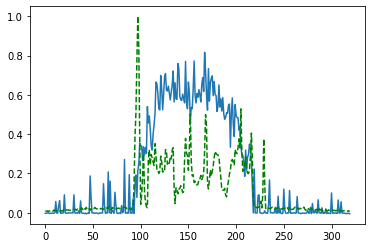

Time taken for epoch:  156.34368991851807
Epoch = [ 23/3000]  Iter = [   0/39480]  Loss = 0.2076 Avg Loss = 0.2076  Time = 0.1047s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 23/3000]  Iter = [ 100/39480]  Loss = 0.1939 Avg Loss = 0.2108  Time = 0.0039s
Epoch = [ 23/3000]  Iter = [ 200/39480]  Loss = 0.2312 Avg Loss = 0.2144  Time = 0.0034s
Epoch = [ 23/3000]  Iter = [ 300/39480]  Loss = 0.2108 Avg Loss = 0.219  Time = 0.0035s
Epoch = [ 23/3000]  Iter = [ 400/39480]  Loss = 0.2253 Avg Loss = 0.2212  Time = 0.0034s
Epoch = [ 23/3000]  Iter = [ 500/39480]  Loss = 0.2561 Avg Loss = 0.2207  Time = 0.0042s
Epoch = [ 23/3000]  Iter = [ 600/39480]  Loss = 0.2216 Avg Loss = 0.2232  Time = 0.0034s
Epoch = [ 23/3000]  Iter = [ 700/39480]  Loss = 0.2242 Avg Loss = 0.222  Time = 0.0034s
Epoch = [ 23/3000]  Iter = [ 800/39480]  Loss = 0.2486 Avg Loss = 0.2183  Time = 0.0033s
Epoch = [ 23/3000]  Iter = [ 900/39480]  Loss = 0.2296 Avg Loss = 0.2179  Time = 0.0037s
Epoch = [ 23/3000]  Iter = [1000/39480]  Loss = 0.2425 Avg Loss = 0.2216  Time = 0.0032s
Epoch = [ 23/3000]  Iter = [1100/39480]  Loss = 0.2723 Avg Loss = 0.2185  Time = 0.0033s
Epoch = [ 23/3000]  Ite

Epoch = [ 23/3000]  Iter = [9400/39480]  Loss = 0.213 Avg Loss = 0.2176  Time = 0.0035s
Epoch = [ 23/3000]  Iter = [9500/39480]  Loss = 0.2277 Avg Loss = 0.2182  Time = 0.0036s
Epoch = [ 23/3000]  Iter = [9600/39480]  Loss = 0.1899 Avg Loss = 0.2148  Time = 0.0033s
Epoch = [ 23/3000]  Iter = [9700/39480]  Loss = 0.2514 Avg Loss = 0.2144  Time = 0.0035s
Epoch = [ 23/3000]  Iter = [9800/39480]  Loss = 0.2335 Avg Loss = 0.2163  Time = 0.0042s
Epoch = [ 23/3000]  Iter = [9900/39480]  Loss = 0.2101 Avg Loss = 0.2162  Time = 0.0032s
Epoch = [ 23/3000]  Iter = [10000/39480]  Loss = 0.1793 Avg Loss = 0.2202  Time = 0.0035s
Epoch = [ 23/3000]  Iter = [10100/39480]  Loss = 0.2162 Avg Loss = 0.2198  Time = 0.0035s
Epoch = [ 23/3000]  Iter = [10200/39480]  Loss = 0.2139 Avg Loss = 0.2154  Time = 0.0035s
Epoch = [ 23/3000]  Iter = [10300/39480]  Loss = 0.1952 Avg Loss = 0.2188  Time = 0.0031s
Epoch = [ 23/3000]  Iter = [10400/39480]  Loss = 0.2604 Avg Loss = 0.2167  Time = 0.0036s
Epoch = [ 23/3000

Epoch = [ 23/3000]  Iter = [18600/39480]  Loss = 0.2301 Avg Loss = 0.22  Time = 0.0036s
Epoch = [ 23/3000]  Iter = [18700/39480]  Loss = 0.2101 Avg Loss = 0.2172  Time = 0.0032s
Epoch = [ 23/3000]  Iter = [18800/39480]  Loss = 0.2309 Avg Loss = 0.218  Time = 0.0049s
Epoch = [ 23/3000]  Iter = [18900/39480]  Loss = 0.2079 Avg Loss = 0.2226  Time = 0.0035s
Epoch = [ 23/3000]  Iter = [19000/39480]  Loss = 0.2286 Avg Loss = 0.2178  Time = 0.0037s
Epoch = [ 23/3000]  Iter = [19100/39480]  Loss = 0.2033 Avg Loss = 0.2155  Time = 0.0033s
Epoch = [ 23/3000]  Iter = [19200/39480]  Loss = 0.2337 Avg Loss = 0.2179  Time = 0.0034s
Epoch = [ 23/3000]  Iter = [19300/39480]  Loss = 0.2079 Avg Loss = 0.2189  Time = 0.0035s
Epoch = [ 23/3000]  Iter = [19400/39480]  Loss = 0.2028 Avg Loss = 0.2186  Time = 0.0036s
Epoch = [ 23/3000]  Iter = [19500/39480]  Loss = 0.2423 Avg Loss = 0.2204  Time = 0.0031s
Epoch = [ 23/3000]  Iter = [19600/39480]  Loss = 0.2477 Avg Loss = 0.2176  Time = 0.0033s
Epoch = [ 23/

Epoch = [ 23/3000]  Iter = [27800/39480]  Loss = 0.1962 Avg Loss = 0.2182  Time = 0.0034s
Epoch = [ 23/3000]  Iter = [27900/39480]  Loss = 0.1674 Avg Loss = 0.2152  Time = 0.0031s
Epoch = [ 23/3000]  Iter = [28000/39480]  Loss = 0.2098 Avg Loss = 0.217  Time = 0.0034s
Epoch = [ 23/3000]  Iter = [28100/39480]  Loss = 0.1997 Avg Loss = 0.2125  Time = 0.0032s
Epoch = [ 23/3000]  Iter = [28200/39480]  Loss = 0.186 Avg Loss = 0.2158  Time = 0.0035s
Epoch = [ 23/3000]  Iter = [28300/39480]  Loss = 0.2125 Avg Loss = 0.2201  Time = 0.0033s
Epoch = [ 23/3000]  Iter = [28400/39480]  Loss = 0.2452 Avg Loss = 0.2197  Time = 0.0035s
Epoch = [ 23/3000]  Iter = [28500/39480]  Loss = 0.1914 Avg Loss = 0.2186  Time = 0.0036s
Epoch = [ 23/3000]  Iter = [28600/39480]  Loss = 0.2278 Avg Loss = 0.2198  Time = 0.0037s
Epoch = [ 23/3000]  Iter = [28700/39480]  Loss = 0.2236 Avg Loss = 0.2185  Time = 0.0034s
Epoch = [ 23/3000]  Iter = [28800/39480]  Loss = 0.199 Avg Loss = 0.2157  Time = 0.0036s
Epoch = [ 23/

Epoch = [ 23/3000]  Iter = [37000/39480]  Loss = 0.2411 Avg Loss = 0.2178  Time = 0.0034s
Epoch = [ 23/3000]  Iter = [37100/39480]  Loss = 0.1617 Avg Loss = 0.2232  Time = 0.0033s
Epoch = [ 23/3000]  Iter = [37200/39480]  Loss = 0.2148 Avg Loss = 0.2179  Time = 0.0035s
Epoch = [ 23/3000]  Iter = [37300/39480]  Loss = 0.2313 Avg Loss = 0.2165  Time = 0.0048s
Epoch = [ 23/3000]  Iter = [37400/39480]  Loss = 0.2451 Avg Loss = 0.2176  Time = 0.0030s
Epoch = [ 23/3000]  Iter = [37500/39480]  Loss = 0.2548 Avg Loss = 0.2176  Time = 0.0046s
Epoch = [ 23/3000]  Iter = [37600/39480]  Loss = 0.2157 Avg Loss = 0.2171  Time = 0.0032s
Epoch = [ 23/3000]  Iter = [37700/39480]  Loss = 0.2303 Avg Loss = 0.2187  Time = 0.0034s
Epoch = [ 23/3000]  Iter = [37800/39480]  Loss = 0.2208 Avg Loss = 0.218  Time = 0.0032s
Epoch = [ 23/3000]  Iter = [37900/39480]  Loss = 0.1965 Avg Loss = 0.216  Time = 0.0036s
Epoch = [ 23/3000]  Iter = [38000/39480]  Loss = 0.2249 Avg Loss = 0.2154  Time = 0.0034s
Epoch = [ 23

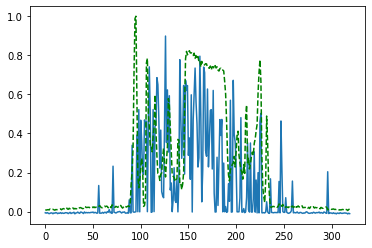

Time taken for epoch:  156.8729283809662
Epoch = [ 24/3000]  Iter = [   0/39480]  Loss = 0.2882 Avg Loss = 0.2882  Time = 0.0784s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 24/3000]  Iter = [ 100/39480]  Loss = 0.2192 Avg Loss = 0.2429  Time = 0.0031s
Epoch = [ 24/3000]  Iter = [ 200/39480]  Loss = 0.2028 Avg Loss = 0.2241  Time = 0.0035s
Epoch = [ 24/3000]  Iter = [ 300/39480]  Loss = 0.2014 Avg Loss = 0.221  Time = 0.0031s
Epoch = [ 24/3000]  Iter = [ 400/39480]  Loss = 0.2111 Avg Loss = 0.2203  Time = 0.0038s
Epoch = [ 24/3000]  Iter = [ 500/39480]  Loss = 0.196 Avg Loss = 0.2153  Time = 0.0034s
Epoch = [ 24/3000]  Iter = [ 600/39480]  Loss = 0.1984 Avg Loss = 0.2166  Time = 0.0036s
Epoch = [ 24/3000]  Iter = [ 700/39480]  Loss = 0.2595 Avg Loss = 0.221  Time = 0.0035s
Epoch = [ 24/3000]  Iter = [ 800/39480]  Loss = 0.2099 Avg Loss = 0.2151  Time = 0.0049s
Epoch = [ 24/3000]  Iter = [ 900/39480]  Loss = 0.2196 Avg Loss = 0.2162  Time = 0.0030s
Epoch = [ 24/3000]  Iter = [1000/39480]  Loss = 0.2001 Avg Loss = 0.2152  Time = 0.0038s
Epoch = [ 24/3000]  Iter = [1100/39480]  Loss = 0.1936 Avg Loss = 0.2113  Time = 0.0032s
Epoch = [ 24/3000]  Iter

Epoch = [ 24/3000]  Iter = [9400/39480]  Loss = 0.2101 Avg Loss = 0.2136  Time = 0.0032s
Epoch = [ 24/3000]  Iter = [9500/39480]  Loss = 0.2129 Avg Loss = 0.2186  Time = 0.0042s
Epoch = [ 24/3000]  Iter = [9600/39480]  Loss = 0.2321 Avg Loss = 0.2186  Time = 0.0036s
Epoch = [ 24/3000]  Iter = [9700/39480]  Loss = 0.2089 Avg Loss = 0.2197  Time = 0.0031s
Epoch = [ 24/3000]  Iter = [9800/39480]  Loss = 0.2082 Avg Loss = 0.2168  Time = 0.0054s
Epoch = [ 24/3000]  Iter = [9900/39480]  Loss = 0.1997 Avg Loss = 0.2167  Time = 0.0040s
Epoch = [ 24/3000]  Iter = [10000/39480]  Loss = 0.2284 Avg Loss = 0.2224  Time = 0.0040s
Epoch = [ 24/3000]  Iter = [10100/39480]  Loss = 0.1955 Avg Loss = 0.2212  Time = 0.0031s
Epoch = [ 24/3000]  Iter = [10200/39480]  Loss = 0.2248 Avg Loss = 0.2184  Time = 0.0036s
Epoch = [ 24/3000]  Iter = [10300/39480]  Loss = 0.1974 Avg Loss = 0.2186  Time = 0.0034s
Epoch = [ 24/3000]  Iter = [10400/39480]  Loss = 0.216 Avg Loss = 0.2133  Time = 0.0037s
Epoch = [ 24/3000

Epoch = [ 24/3000]  Iter = [18600/39480]  Loss = 0.2227 Avg Loss = 0.2237  Time = 0.0047s
Epoch = [ 24/3000]  Iter = [18700/39480]  Loss = 0.233 Avg Loss = 0.219  Time = 0.0032s
Epoch = [ 24/3000]  Iter = [18800/39480]  Loss = 0.2011 Avg Loss = 0.2231  Time = 0.0030s
Epoch = [ 24/3000]  Iter = [18900/39480]  Loss = 0.1995 Avg Loss = 0.223  Time = 0.0034s
Epoch = [ 24/3000]  Iter = [19000/39480]  Loss = 0.2039 Avg Loss = 0.22  Time = 0.0034s
Epoch = [ 24/3000]  Iter = [19100/39480]  Loss = 0.2054 Avg Loss = 0.2181  Time = 0.0038s
Epoch = [ 24/3000]  Iter = [19200/39480]  Loss = 0.2192 Avg Loss = 0.2155  Time = 0.0034s
Epoch = [ 24/3000]  Iter = [19300/39480]  Loss = 0.2335 Avg Loss = 0.2152  Time = 0.0036s
Epoch = [ 24/3000]  Iter = [19400/39480]  Loss = 0.2361 Avg Loss = 0.2176  Time = 0.0035s
Epoch = [ 24/3000]  Iter = [19500/39480]  Loss = 0.2036 Avg Loss = 0.2179  Time = 0.0035s
Epoch = [ 24/3000]  Iter = [19600/39480]  Loss = 0.2445 Avg Loss = 0.2237  Time = 0.0051s
Epoch = [ 24/30

Epoch = [ 24/3000]  Iter = [27800/39480]  Loss = 0.2356 Avg Loss = 0.2183  Time = 0.0034s
Epoch = [ 24/3000]  Iter = [27900/39480]  Loss = 0.2222 Avg Loss = 0.2185  Time = 0.0036s
Epoch = [ 24/3000]  Iter = [28000/39480]  Loss = 0.2183 Avg Loss = 0.2177  Time = 0.0034s
Epoch = [ 24/3000]  Iter = [28100/39480]  Loss = 0.2239 Avg Loss = 0.2157  Time = 0.0061s
Epoch = [ 24/3000]  Iter = [28200/39480]  Loss = 0.2412 Avg Loss = 0.2148  Time = 0.0036s
Epoch = [ 24/3000]  Iter = [28300/39480]  Loss = 0.2133 Avg Loss = 0.2163  Time = 0.0039s
Epoch = [ 24/3000]  Iter = [28400/39480]  Loss = 0.1755 Avg Loss = 0.22  Time = 0.0034s
Epoch = [ 24/3000]  Iter = [28500/39480]  Loss = 0.2484 Avg Loss = 0.2174  Time = 0.0033s
Epoch = [ 24/3000]  Iter = [28600/39480]  Loss = 0.2133 Avg Loss = 0.2197  Time = 0.0034s
Epoch = [ 24/3000]  Iter = [28700/39480]  Loss = 0.2199 Avg Loss = 0.2165  Time = 0.0034s
Epoch = [ 24/3000]  Iter = [28800/39480]  Loss = 0.2126 Avg Loss = 0.2201  Time = 0.0034s
Epoch = [ 24

Epoch = [ 24/3000]  Iter = [37000/39480]  Loss = 0.1941 Avg Loss = 0.215  Time = 0.0036s
Epoch = [ 24/3000]  Iter = [37100/39480]  Loss = 0.2084 Avg Loss = 0.2153  Time = 0.0034s
Epoch = [ 24/3000]  Iter = [37200/39480]  Loss = 0.1971 Avg Loss = 0.2178  Time = 0.0051s
Epoch = [ 24/3000]  Iter = [37300/39480]  Loss = 0.2116 Avg Loss = 0.2184  Time = 0.0035s
Epoch = [ 24/3000]  Iter = [37400/39480]  Loss = 0.1846 Avg Loss = 0.2197  Time = 0.0034s
Epoch = [ 24/3000]  Iter = [37500/39480]  Loss = 0.2284 Avg Loss = 0.2172  Time = 0.0032s
Epoch = [ 24/3000]  Iter = [37600/39480]  Loss = 0.1953 Avg Loss = 0.2163  Time = 0.0033s
Epoch = [ 24/3000]  Iter = [37700/39480]  Loss = 0.2302 Avg Loss = 0.225  Time = 0.0032s
Epoch = [ 24/3000]  Iter = [37800/39480]  Loss = 0.2003 Avg Loss = 0.2174  Time = 0.0035s
Epoch = [ 24/3000]  Iter = [37900/39480]  Loss = 0.1959 Avg Loss = 0.2172  Time = 0.0034s
Epoch = [ 24/3000]  Iter = [38000/39480]  Loss = 0.2471 Avg Loss = 0.2157  Time = 0.0047s
Epoch = [ 24

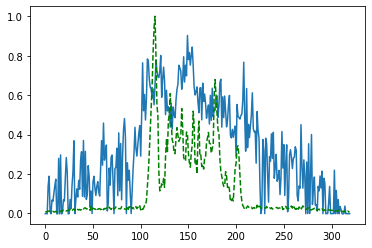

Time taken for epoch:  156.1759352684021
Epoch = [ 25/3000]  Iter = [   0/39480]  Loss = 0.1954 Avg Loss = 0.1954  Time = 0.1074s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 25/3000]  Iter = [ 100/39480]  Loss = 0.1914 Avg Loss = 0.2094  Time = 0.0037s
Epoch = [ 25/3000]  Iter = [ 200/39480]  Loss = 0.2274 Avg Loss = 0.2161  Time = 0.0037s
Epoch = [ 25/3000]  Iter = [ 300/39480]  Loss = 0.1926 Avg Loss = 0.2196  Time = 0.0034s
Epoch = [ 25/3000]  Iter = [ 400/39480]  Loss = 0.2119 Avg Loss = 0.2167  Time = 0.0048s
Epoch = [ 25/3000]  Iter = [ 500/39480]  Loss = 0.1909 Avg Loss = 0.2174  Time = 0.0033s
Epoch = [ 25/3000]  Iter = [ 600/39480]  Loss = 0.2043 Avg Loss = 0.2189  Time = 0.0054s
Epoch = [ 25/3000]  Iter = [ 700/39480]  Loss = 0.2123 Avg Loss = 0.22  Time = 0.0033s
Epoch = [ 25/3000]  Iter = [ 800/39480]  Loss = 0.206 Avg Loss = 0.2189  Time = 0.0037s
Epoch = [ 25/3000]  Iter = [ 900/39480]  Loss = 0.2602 Avg Loss = 0.2237  Time = 0.0034s
Epoch = [ 25/3000]  Iter = [1000/39480]  Loss = 0.2278 Avg Loss = 0.216  Time = 0.0035s
Epoch = [ 25/3000]  Iter = [1100/39480]  Loss = 0.1702 Avg Loss = 0.2115  Time = 0.0034s
Epoch = [ 25/3000]  Iter 

Epoch = [ 25/3000]  Iter = [9400/39480]  Loss = 0.2201 Avg Loss = 0.2169  Time = 0.0038s
Epoch = [ 25/3000]  Iter = [9500/39480]  Loss = 0.2385 Avg Loss = 0.2208  Time = 0.0034s
Epoch = [ 25/3000]  Iter = [9600/39480]  Loss = 0.1784 Avg Loss = 0.2165  Time = 0.0037s
Epoch = [ 25/3000]  Iter = [9700/39480]  Loss = 0.2467 Avg Loss = 0.216  Time = 0.0033s
Epoch = [ 25/3000]  Iter = [9800/39480]  Loss = 0.1616 Avg Loss = 0.2166  Time = 0.0039s
Epoch = [ 25/3000]  Iter = [9900/39480]  Loss = 0.2061 Avg Loss = 0.217  Time = 0.0034s
Epoch = [ 25/3000]  Iter = [10000/39480]  Loss = 0.2254 Avg Loss = 0.2187  Time = 0.0044s
Epoch = [ 25/3000]  Iter = [10100/39480]  Loss = 0.2275 Avg Loss = 0.2222  Time = 0.0034s
Epoch = [ 25/3000]  Iter = [10200/39480]  Loss = 0.1801 Avg Loss = 0.2157  Time = 0.0035s
Epoch = [ 25/3000]  Iter = [10300/39480]  Loss = 0.2166 Avg Loss = 0.2243  Time = 0.0033s
Epoch = [ 25/3000]  Iter = [10400/39480]  Loss = 0.2163 Avg Loss = 0.2196  Time = 0.0032s
Epoch = [ 25/3000]

Epoch = [ 25/3000]  Iter = [18600/39480]  Loss = 0.1917 Avg Loss = 0.2197  Time = 0.0036s
Epoch = [ 25/3000]  Iter = [18700/39480]  Loss = 0.2285 Avg Loss = 0.2164  Time = 0.0035s
Epoch = [ 25/3000]  Iter = [18800/39480]  Loss = 0.1985 Avg Loss = 0.2156  Time = 0.0038s
Epoch = [ 25/3000]  Iter = [18900/39480]  Loss = 0.1981 Avg Loss = 0.2168  Time = 0.0035s
Epoch = [ 25/3000]  Iter = [19000/39480]  Loss = 0.2519 Avg Loss = 0.2238  Time = 0.0036s
Epoch = [ 25/3000]  Iter = [19100/39480]  Loss = 0.1877 Avg Loss = 0.2195  Time = 0.0037s
Epoch = [ 25/3000]  Iter = [19200/39480]  Loss = 0.2198 Avg Loss = 0.2189  Time = 0.0034s
Epoch = [ 25/3000]  Iter = [19300/39480]  Loss = 0.2458 Avg Loss = 0.2172  Time = 0.0032s
Epoch = [ 25/3000]  Iter = [19400/39480]  Loss = 0.2109 Avg Loss = 0.2196  Time = 0.0039s
Epoch = [ 25/3000]  Iter = [19500/39480]  Loss = 0.2155 Avg Loss = 0.217  Time = 0.0033s
Epoch = [ 25/3000]  Iter = [19600/39480]  Loss = 0.2158 Avg Loss = 0.2183  Time = 0.0035s
Epoch = [ 2

Epoch = [ 25/3000]  Iter = [27800/39480]  Loss = 0.2448 Avg Loss = 0.2182  Time = 0.0030s
Epoch = [ 25/3000]  Iter = [27900/39480]  Loss = 0.1997 Avg Loss = 0.22  Time = 0.0035s
Epoch = [ 25/3000]  Iter = [28000/39480]  Loss = 0.2188 Avg Loss = 0.2182  Time = 0.0042s
Epoch = [ 25/3000]  Iter = [28100/39480]  Loss = 0.2315 Avg Loss = 0.2224  Time = 0.0034s
Epoch = [ 25/3000]  Iter = [28200/39480]  Loss = 0.1861 Avg Loss = 0.2172  Time = 0.0036s
Epoch = [ 25/3000]  Iter = [28300/39480]  Loss = 0.1899 Avg Loss = 0.2183  Time = 0.0034s
Epoch = [ 25/3000]  Iter = [28400/39480]  Loss = 0.2065 Avg Loss = 0.2175  Time = 0.0032s
Epoch = [ 25/3000]  Iter = [28500/39480]  Loss = 0.2129 Avg Loss = 0.219  Time = 0.0033s
Epoch = [ 25/3000]  Iter = [28600/39480]  Loss = 0.2337 Avg Loss = 0.2194  Time = 0.0030s
Epoch = [ 25/3000]  Iter = [28700/39480]  Loss = 0.2224 Avg Loss = 0.2194  Time = 0.0035s
Epoch = [ 25/3000]  Iter = [28800/39480]  Loss = 0.2214 Avg Loss = 0.217  Time = 0.0035s
Epoch = [ 25/3

Epoch = [ 25/3000]  Iter = [37000/39480]  Loss = 0.2204 Avg Loss = 0.221  Time = 0.0034s
Epoch = [ 25/3000]  Iter = [37100/39480]  Loss = 0.2056 Avg Loss = 0.2178  Time = 0.0033s
Epoch = [ 25/3000]  Iter = [37200/39480]  Loss = 0.2299 Avg Loss = 0.2221  Time = 0.0031s
Epoch = [ 25/3000]  Iter = [37300/39480]  Loss = 0.2065 Avg Loss = 0.2202  Time = 0.0033s
Epoch = [ 25/3000]  Iter = [37400/39480]  Loss = 0.232 Avg Loss = 0.2193  Time = 0.0030s
Epoch = [ 25/3000]  Iter = [37500/39480]  Loss = 0.2206 Avg Loss = 0.2191  Time = 0.0036s
Epoch = [ 25/3000]  Iter = [37600/39480]  Loss = 0.2529 Avg Loss = 0.2228  Time = 0.0033s
Epoch = [ 25/3000]  Iter = [37700/39480]  Loss = 0.1927 Avg Loss = 0.2181  Time = 0.0041s
Epoch = [ 25/3000]  Iter = [37800/39480]  Loss = 0.2373 Avg Loss = 0.2147  Time = 0.0034s
Epoch = [ 25/3000]  Iter = [37900/39480]  Loss = 0.2011 Avg Loss = 0.2158  Time = 0.0037s
Epoch = [ 25/3000]  Iter = [38000/39480]  Loss = 0.2026 Avg Loss = 0.2174  Time = 0.0034s
Epoch = [ 25

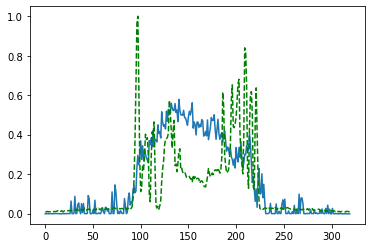

Time taken for epoch:  156.31054615974426
Epoch = [ 26/3000]  Iter = [   0/39480]  Loss = 0.2554 Avg Loss = 0.2554  Time = 0.1112s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 26/3000]  Iter = [ 100/39480]  Loss = 0.2373 Avg Loss = 0.2352  Time = 0.0038s
Epoch = [ 26/3000]  Iter = [ 200/39480]  Loss = 0.225 Avg Loss = 0.2288  Time = 0.0034s
Epoch = [ 26/3000]  Iter = [ 300/39480]  Loss = 0.251 Avg Loss = 0.2229  Time = 0.0038s
Epoch = [ 26/3000]  Iter = [ 400/39480]  Loss = 0.197 Avg Loss = 0.2159  Time = 0.0035s
Epoch = [ 26/3000]  Iter = [ 500/39480]  Loss = 0.1919 Avg Loss = 0.2136  Time = 0.0037s
Epoch = [ 26/3000]  Iter = [ 600/39480]  Loss = 0.2254 Avg Loss = 0.214  Time = 0.0032s
Epoch = [ 26/3000]  Iter = [ 700/39480]  Loss = 0.2039 Avg Loss = 0.2146  Time = 0.0035s
Epoch = [ 26/3000]  Iter = [ 800/39480]  Loss = 0.2324 Avg Loss = 0.22  Time = 0.0037s
Epoch = [ 26/3000]  Iter = [ 900/39480]  Loss = 0.2353 Avg Loss = 0.221  Time = 0.0036s
Epoch = [ 26/3000]  Iter = [1000/39480]  Loss = 0.2359 Avg Loss = 0.2189  Time = 0.0037s
Epoch = [ 26/3000]  Iter = [1100/39480]  Loss = 0.2138 Avg Loss = 0.2199  Time = 0.0036s
Epoch = [ 26/3000]  Iter = [

Epoch = [ 26/3000]  Iter = [9400/39480]  Loss = 0.22 Avg Loss = 0.2197  Time = 0.0036s
Epoch = [ 26/3000]  Iter = [9500/39480]  Loss = 0.2329 Avg Loss = 0.2159  Time = 0.0034s
Epoch = [ 26/3000]  Iter = [9600/39480]  Loss = 0.2374 Avg Loss = 0.2125  Time = 0.0034s
Epoch = [ 26/3000]  Iter = [9700/39480]  Loss = 0.2134 Avg Loss = 0.2161  Time = 0.0036s
Epoch = [ 26/3000]  Iter = [9800/39480]  Loss = 0.2059 Avg Loss = 0.2183  Time = 0.0034s
Epoch = [ 26/3000]  Iter = [9900/39480]  Loss = 0.2083 Avg Loss = 0.2201  Time = 0.0033s
Epoch = [ 26/3000]  Iter = [10000/39480]  Loss = 0.1824 Avg Loss = 0.2177  Time = 0.0037s
Epoch = [ 26/3000]  Iter = [10100/39480]  Loss = 0.2632 Avg Loss = 0.2242  Time = 0.0033s
Epoch = [ 26/3000]  Iter = [10200/39480]  Loss = 0.226 Avg Loss = 0.2205  Time = 0.0038s
Epoch = [ 26/3000]  Iter = [10300/39480]  Loss = 0.2306 Avg Loss = 0.2173  Time = 0.0031s
Epoch = [ 26/3000]  Iter = [10400/39480]  Loss = 0.2584 Avg Loss = 0.2153  Time = 0.0038s
Epoch = [ 26/3000] 

Epoch = [ 26/3000]  Iter = [18600/39480]  Loss = 0.1921 Avg Loss = 0.2189  Time = 0.0031s
Epoch = [ 26/3000]  Iter = [18700/39480]  Loss = 0.2624 Avg Loss = 0.2172  Time = 0.0038s
Epoch = [ 26/3000]  Iter = [18800/39480]  Loss = 0.2399 Avg Loss = 0.2237  Time = 0.0032s
Epoch = [ 26/3000]  Iter = [18900/39480]  Loss = 0.2654 Avg Loss = 0.221  Time = 0.0036s
Epoch = [ 26/3000]  Iter = [19000/39480]  Loss = 0.2053 Avg Loss = 0.2173  Time = 0.0033s
Epoch = [ 26/3000]  Iter = [19100/39480]  Loss = 0.2109 Avg Loss = 0.2142  Time = 0.0034s
Epoch = [ 26/3000]  Iter = [19200/39480]  Loss = 0.1852 Avg Loss = 0.215  Time = 0.0036s
Epoch = [ 26/3000]  Iter = [19300/39480]  Loss = 0.2084 Avg Loss = 0.2185  Time = 0.0036s
Epoch = [ 26/3000]  Iter = [19400/39480]  Loss = 0.2146 Avg Loss = 0.2183  Time = 0.0032s
Epoch = [ 26/3000]  Iter = [19500/39480]  Loss = 0.2012 Avg Loss = 0.2184  Time = 0.0032s
Epoch = [ 26/3000]  Iter = [19600/39480]  Loss = 0.2677 Avg Loss = 0.2199  Time = 0.0041s
Epoch = [ 26

Epoch = [ 26/3000]  Iter = [27800/39480]  Loss = 0.2038 Avg Loss = 0.2186  Time = 0.0047s
Epoch = [ 26/3000]  Iter = [27900/39480]  Loss = 0.1989 Avg Loss = 0.2168  Time = 0.0037s
Epoch = [ 26/3000]  Iter = [28000/39480]  Loss = 0.187 Avg Loss = 0.2173  Time = 0.0033s
Epoch = [ 26/3000]  Iter = [28100/39480]  Loss = 0.193 Avg Loss = 0.219  Time = 0.0036s
Epoch = [ 26/3000]  Iter = [28200/39480]  Loss = 0.2107 Avg Loss = 0.2155  Time = 0.0035s
Epoch = [ 26/3000]  Iter = [28300/39480]  Loss = 0.2039 Avg Loss = 0.2178  Time = 0.0037s
Epoch = [ 26/3000]  Iter = [28400/39480]  Loss = 0.2018 Avg Loss = 0.2171  Time = 0.0036s
Epoch = [ 26/3000]  Iter = [28500/39480]  Loss = 0.2261 Avg Loss = 0.2173  Time = 0.0036s
Epoch = [ 26/3000]  Iter = [28600/39480]  Loss = 0.2454 Avg Loss = 0.2181  Time = 0.0032s
Epoch = [ 26/3000]  Iter = [28700/39480]  Loss = 0.1942 Avg Loss = 0.2178  Time = 0.0038s
Epoch = [ 26/3000]  Iter = [28800/39480]  Loss = 0.2043 Avg Loss = 0.2144  Time = 0.0034s
Epoch = [ 26/

Epoch = [ 26/3000]  Iter = [37000/39480]  Loss = 0.191 Avg Loss = 0.218  Time = 0.0036s
Epoch = [ 26/3000]  Iter = [37100/39480]  Loss = 0.2284 Avg Loss = 0.2181  Time = 0.0035s
Epoch = [ 26/3000]  Iter = [37200/39480]  Loss = 0.213 Avg Loss = 0.2177  Time = 0.0037s
Epoch = [ 26/3000]  Iter = [37300/39480]  Loss = 0.1872 Avg Loss = 0.2175  Time = 0.0030s
Epoch = [ 26/3000]  Iter = [37400/39480]  Loss = 0.2121 Avg Loss = 0.2171  Time = 0.0034s
Epoch = [ 26/3000]  Iter = [37500/39480]  Loss = 0.2411 Avg Loss = 0.2176  Time = 0.0034s
Epoch = [ 26/3000]  Iter = [37600/39480]  Loss = 0.2395 Avg Loss = 0.2169  Time = 0.0039s
Epoch = [ 26/3000]  Iter = [37700/39480]  Loss = 0.1967 Avg Loss = 0.22  Time = 0.0033s
Epoch = [ 26/3000]  Iter = [37800/39480]  Loss = 0.2153 Avg Loss = 0.2141  Time = 0.0036s
Epoch = [ 26/3000]  Iter = [37900/39480]  Loss = 0.2017 Avg Loss = 0.2203  Time = 0.0033s
Epoch = [ 26/3000]  Iter = [38000/39480]  Loss = 0.227 Avg Loss = 0.2168  Time = 0.0030s
Epoch = [ 26/300

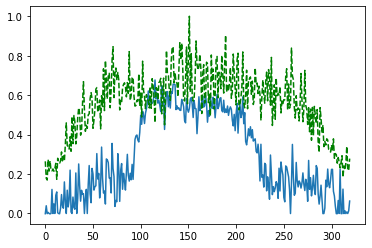

Time taken for epoch:  157.35520219802856
Epoch = [ 27/3000]  Iter = [   0/39480]  Loss = 0.2002 Avg Loss = 0.2002  Time = 0.0774s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 27/3000]  Iter = [ 100/39480]  Loss = 0.2438 Avg Loss = 0.2117  Time = 0.0050s
Epoch = [ 27/3000]  Iter = [ 200/39480]  Loss = 0.2377 Avg Loss = 0.2199  Time = 0.0037s
Epoch = [ 27/3000]  Iter = [ 300/39480]  Loss = 0.2091 Avg Loss = 0.2204  Time = 0.0036s
Epoch = [ 27/3000]  Iter = [ 400/39480]  Loss = 0.2615 Avg Loss = 0.2186  Time = 0.0033s
Epoch = [ 27/3000]  Iter = [ 500/39480]  Loss = 0.2032 Avg Loss = 0.2144  Time = 0.0037s
Epoch = [ 27/3000]  Iter = [ 600/39480]  Loss = 0.242 Avg Loss = 0.2163  Time = 0.0034s
Epoch = [ 27/3000]  Iter = [ 700/39480]  Loss = 0.2068 Avg Loss = 0.2212  Time = 0.0036s
Epoch = [ 27/3000]  Iter = [ 800/39480]  Loss = 0.2312 Avg Loss = 0.2194  Time = 0.0033s
Epoch = [ 27/3000]  Iter = [ 900/39480]  Loss = 0.2335 Avg Loss = 0.2145  Time = 0.0035s
Epoch = [ 27/3000]  Iter = [1000/39480]  Loss = 0.2276 Avg Loss = 0.2176  Time = 0.0036s
Epoch = [ 27/3000]  Iter = [1100/39480]  Loss = 0.2217 Avg Loss = 0.2222  Time = 0.0034s
Epoch = [ 27/3000]  It

Epoch = [ 27/3000]  Iter = [9400/39480]  Loss = 0.2405 Avg Loss = 0.2198  Time = 0.0035s
Epoch = [ 27/3000]  Iter = [9500/39480]  Loss = 0.2021 Avg Loss = 0.2165  Time = 0.0035s
Epoch = [ 27/3000]  Iter = [9600/39480]  Loss = 0.2188 Avg Loss = 0.2185  Time = 0.0032s
Epoch = [ 27/3000]  Iter = [9700/39480]  Loss = 0.2369 Avg Loss = 0.2164  Time = 0.0034s
Epoch = [ 27/3000]  Iter = [9800/39480]  Loss = 0.2257 Avg Loss = 0.2171  Time = 0.0034s
Epoch = [ 27/3000]  Iter = [9900/39480]  Loss = 0.2143 Avg Loss = 0.2215  Time = 0.0033s
Epoch = [ 27/3000]  Iter = [10000/39480]  Loss = 0.2102 Avg Loss = 0.2259  Time = 0.0034s
Epoch = [ 27/3000]  Iter = [10100/39480]  Loss = 0.2259 Avg Loss = 0.2253  Time = 0.0035s
Epoch = [ 27/3000]  Iter = [10200/39480]  Loss = 0.2135 Avg Loss = 0.2189  Time = 0.0031s
Epoch = [ 27/3000]  Iter = [10300/39480]  Loss = 0.2305 Avg Loss = 0.2163  Time = 0.0035s
Epoch = [ 27/3000]  Iter = [10400/39480]  Loss = 0.242 Avg Loss = 0.2192  Time = 0.0031s
Epoch = [ 27/3000

Epoch = [ 27/3000]  Iter = [18600/39480]  Loss = 0.2203 Avg Loss = 0.2176  Time = 0.0035s
Epoch = [ 27/3000]  Iter = [18700/39480]  Loss = 0.2325 Avg Loss = 0.2171  Time = 0.0035s
Epoch = [ 27/3000]  Iter = [18800/39480]  Loss = 0.2334 Avg Loss = 0.2151  Time = 0.0032s
Epoch = [ 27/3000]  Iter = [18900/39480]  Loss = 0.2221 Avg Loss = 0.216  Time = 0.0033s
Epoch = [ 27/3000]  Iter = [19000/39480]  Loss = 0.2111 Avg Loss = 0.2201  Time = 0.0032s
Epoch = [ 27/3000]  Iter = [19100/39480]  Loss = 0.1854 Avg Loss = 0.2177  Time = 0.0036s
Epoch = [ 27/3000]  Iter = [19200/39480]  Loss = 0.2238 Avg Loss = 0.2212  Time = 0.0033s
Epoch = [ 27/3000]  Iter = [19300/39480]  Loss = 0.2517 Avg Loss = 0.2171  Time = 0.0037s
Epoch = [ 27/3000]  Iter = [19400/39480]  Loss = 0.2093 Avg Loss = 0.2174  Time = 0.0033s
Epoch = [ 27/3000]  Iter = [19500/39480]  Loss = 0.2157 Avg Loss = 0.2148  Time = 0.0036s
Epoch = [ 27/3000]  Iter = [19600/39480]  Loss = 0.2234 Avg Loss = 0.2154  Time = 0.0031s
Epoch = [ 2

Epoch = [ 27/3000]  Iter = [27800/39480]  Loss = 0.2617 Avg Loss = 0.2124  Time = 0.0032s
Epoch = [ 27/3000]  Iter = [27900/39480]  Loss = 0.2414 Avg Loss = 0.2196  Time = 0.0033s
Epoch = [ 27/3000]  Iter = [28000/39480]  Loss = 0.2441 Avg Loss = 0.2212  Time = 0.0041s
Epoch = [ 27/3000]  Iter = [28100/39480]  Loss = 0.2112 Avg Loss = 0.22  Time = 0.0031s
Epoch = [ 27/3000]  Iter = [28200/39480]  Loss = 0.2308 Avg Loss = 0.2203  Time = 0.0036s
Epoch = [ 27/3000]  Iter = [28300/39480]  Loss = 0.1763 Avg Loss = 0.219  Time = 0.0031s
Epoch = [ 27/3000]  Iter = [28400/39480]  Loss = 0.2378 Avg Loss = 0.2181  Time = 0.0035s
Epoch = [ 27/3000]  Iter = [28500/39480]  Loss = 0.2388 Avg Loss = 0.2209  Time = 0.0034s
Epoch = [ 27/3000]  Iter = [28600/39480]  Loss = 0.232 Avg Loss = 0.2162  Time = 0.0029s
Epoch = [ 27/3000]  Iter = [28700/39480]  Loss = 0.2506 Avg Loss = 0.2142  Time = 0.0035s
Epoch = [ 27/3000]  Iter = [28800/39480]  Loss = 0.202 Avg Loss = 0.2151  Time = 0.0033s
Epoch = [ 27/30

Epoch = [ 27/3000]  Iter = [37000/39480]  Loss = 0.1864 Avg Loss = 0.2162  Time = 0.0034s
Epoch = [ 27/3000]  Iter = [37100/39480]  Loss = 0.2393 Avg Loss = 0.2243  Time = 0.0046s
Epoch = [ 27/3000]  Iter = [37200/39480]  Loss = 0.2178 Avg Loss = 0.2174  Time = 0.0030s
Epoch = [ 27/3000]  Iter = [37300/39480]  Loss = 0.1831 Avg Loss = 0.2172  Time = 0.0036s
Epoch = [ 27/3000]  Iter = [37400/39480]  Loss = 0.1992 Avg Loss = 0.2191  Time = 0.0034s
Epoch = [ 27/3000]  Iter = [37500/39480]  Loss = 0.2414 Avg Loss = 0.2215  Time = 0.0036s
Epoch = [ 27/3000]  Iter = [37600/39480]  Loss = 0.236 Avg Loss = 0.2199  Time = 0.0032s
Epoch = [ 27/3000]  Iter = [37700/39480]  Loss = 0.2183 Avg Loss = 0.2152  Time = 0.0041s
Epoch = [ 27/3000]  Iter = [37800/39480]  Loss = 0.2017 Avg Loss = 0.2164  Time = 0.0033s
Epoch = [ 27/3000]  Iter = [37900/39480]  Loss = 0.2121 Avg Loss = 0.2184  Time = 0.0033s
Epoch = [ 27/3000]  Iter = [38000/39480]  Loss = 0.1896 Avg Loss = 0.219  Time = 0.0033s
Epoch = [ 27

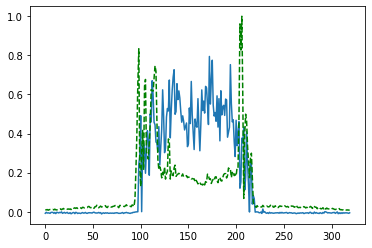

Time taken for epoch:  156.0674409866333
Epoch = [ 28/3000]  Iter = [   0/39480]  Loss = 0.228 Avg Loss = 0.228  Time = 0.1039s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 28/3000]  Iter = [ 100/39480]  Loss = 0.2447 Avg Loss = 0.2213  Time = 0.0035s
Epoch = [ 28/3000]  Iter = [ 200/39480]  Loss = 0.2141 Avg Loss = 0.2256  Time = 0.0035s
Epoch = [ 28/3000]  Iter = [ 300/39480]  Loss = 0.2034 Avg Loss = 0.2184  Time = 0.0037s
Epoch = [ 28/3000]  Iter = [ 400/39480]  Loss = 0.2116 Avg Loss = 0.2155  Time = 0.0034s
Epoch = [ 28/3000]  Iter = [ 500/39480]  Loss = 0.1949 Avg Loss = 0.2142  Time = 0.0035s
Epoch = [ 28/3000]  Iter = [ 600/39480]  Loss = 0.2177 Avg Loss = 0.2208  Time = 0.0035s
Epoch = [ 28/3000]  Iter = [ 700/39480]  Loss = 0.2009 Avg Loss = 0.2199  Time = 0.0036s
Epoch = [ 28/3000]  Iter = [ 800/39480]  Loss = 0.207 Avg Loss = 0.217  Time = 0.0036s
Epoch = [ 28/3000]  Iter = [ 900/39480]  Loss = 0.2059 Avg Loss = 0.2209  Time = 0.0038s
Epoch = [ 28/3000]  Iter = [1000/39480]  Loss = 0.2138 Avg Loss = 0.2164  Time = 0.0036s
Epoch = [ 28/3000]  Iter = [1100/39480]  Loss = 0.1859 Avg Loss = 0.216  Time = 0.0031s
Epoch = [ 28/3000]  Iter

Epoch = [ 28/3000]  Iter = [9400/39480]  Loss = 0.2028 Avg Loss = 0.2185  Time = 0.0034s
Epoch = [ 28/3000]  Iter = [9500/39480]  Loss = 0.2306 Avg Loss = 0.2192  Time = 0.0037s
Epoch = [ 28/3000]  Iter = [9600/39480]  Loss = 0.2533 Avg Loss = 0.2188  Time = 0.0032s
Epoch = [ 28/3000]  Iter = [9700/39480]  Loss = 0.2236 Avg Loss = 0.2193  Time = 0.0031s
Epoch = [ 28/3000]  Iter = [9800/39480]  Loss = 0.2319 Avg Loss = 0.2188  Time = 0.0034s
Epoch = [ 28/3000]  Iter = [9900/39480]  Loss = 0.2147 Avg Loss = 0.2174  Time = 0.0035s
Epoch = [ 28/3000]  Iter = [10000/39480]  Loss = 0.2227 Avg Loss = 0.2148  Time = 0.0033s
Epoch = [ 28/3000]  Iter = [10100/39480]  Loss = 0.2545 Avg Loss = 0.2163  Time = 0.0037s
Epoch = [ 28/3000]  Iter = [10200/39480]  Loss = 0.2276 Avg Loss = 0.2192  Time = 0.0036s
Epoch = [ 28/3000]  Iter = [10300/39480]  Loss = 0.2109 Avg Loss = 0.2209  Time = 0.0032s
Epoch = [ 28/3000]  Iter = [10400/39480]  Loss = 0.2157 Avg Loss = 0.221  Time = 0.0033s
Epoch = [ 28/3000

Epoch = [ 28/3000]  Iter = [18600/39480]  Loss = 0.2171 Avg Loss = 0.215  Time = 0.0034s
Epoch = [ 28/3000]  Iter = [18700/39480]  Loss = 0.2166 Avg Loss = 0.2159  Time = 0.0032s
Epoch = [ 28/3000]  Iter = [18800/39480]  Loss = 0.1981 Avg Loss = 0.2157  Time = 0.0036s
Epoch = [ 28/3000]  Iter = [18900/39480]  Loss = 0.2029 Avg Loss = 0.217  Time = 0.0034s
Epoch = [ 28/3000]  Iter = [19000/39480]  Loss = 0.2023 Avg Loss = 0.2149  Time = 0.0038s
Epoch = [ 28/3000]  Iter = [19100/39480]  Loss = 0.226 Avg Loss = 0.2135  Time = 0.0033s
Epoch = [ 28/3000]  Iter = [19200/39480]  Loss = 0.2248 Avg Loss = 0.2166  Time = 0.0036s
Epoch = [ 28/3000]  Iter = [19300/39480]  Loss = 0.2058 Avg Loss = 0.2226  Time = 0.0032s
Epoch = [ 28/3000]  Iter = [19400/39480]  Loss = 0.225 Avg Loss = 0.2225  Time = 0.0037s
Epoch = [ 28/3000]  Iter = [19500/39480]  Loss = 0.2111 Avg Loss = 0.2167  Time = 0.0030s
Epoch = [ 28/3000]  Iter = [19600/39480]  Loss = 0.2212 Avg Loss = 0.2227  Time = 0.0033s
Epoch = [ 28/3

Epoch = [ 28/3000]  Iter = [27800/39480]  Loss = 0.2099 Avg Loss = 0.217  Time = 0.0039s
Epoch = [ 28/3000]  Iter = [27900/39480]  Loss = 0.2092 Avg Loss = 0.2159  Time = 0.0037s
Epoch = [ 28/3000]  Iter = [28000/39480]  Loss = 0.1996 Avg Loss = 0.2192  Time = 0.0038s
Epoch = [ 28/3000]  Iter = [28100/39480]  Loss = 0.2114 Avg Loss = 0.2145  Time = 0.0040s
Epoch = [ 28/3000]  Iter = [28200/39480]  Loss = 0.2129 Avg Loss = 0.2175  Time = 0.0032s
Epoch = [ 28/3000]  Iter = [28300/39480]  Loss = 0.2121 Avg Loss = 0.2218  Time = 0.0042s
Epoch = [ 28/3000]  Iter = [28400/39480]  Loss = 0.2334 Avg Loss = 0.2185  Time = 0.0036s
Epoch = [ 28/3000]  Iter = [28500/39480]  Loss = 0.2211 Avg Loss = 0.2196  Time = 0.0033s
Epoch = [ 28/3000]  Iter = [28600/39480]  Loss = 0.2225 Avg Loss = 0.2201  Time = 0.0034s
Epoch = [ 28/3000]  Iter = [28700/39480]  Loss = 0.2275 Avg Loss = 0.2163  Time = 0.0033s
Epoch = [ 28/3000]  Iter = [28800/39480]  Loss = 0.2126 Avg Loss = 0.2178  Time = 0.0034s
Epoch = [ 2

Epoch = [ 28/3000]  Iter = [37000/39480]  Loss = 0.242 Avg Loss = 0.2172  Time = 0.0035s
Epoch = [ 28/3000]  Iter = [37100/39480]  Loss = 0.1933 Avg Loss = 0.2195  Time = 0.0038s
Epoch = [ 28/3000]  Iter = [37200/39480]  Loss = 0.2548 Avg Loss = 0.2163  Time = 0.0033s
Epoch = [ 28/3000]  Iter = [37300/39480]  Loss = 0.2326 Avg Loss = 0.22  Time = 0.0034s
Epoch = [ 28/3000]  Iter = [37400/39480]  Loss = 0.1939 Avg Loss = 0.2235  Time = 0.0035s
Epoch = [ 28/3000]  Iter = [37500/39480]  Loss = 0.2343 Avg Loss = 0.218  Time = 0.0040s
Epoch = [ 28/3000]  Iter = [37600/39480]  Loss = 0.1744 Avg Loss = 0.224  Time = 0.0033s
Epoch = [ 28/3000]  Iter = [37700/39480]  Loss = 0.2344 Avg Loss = 0.216  Time = 0.0036s
Epoch = [ 28/3000]  Iter = [37800/39480]  Loss = 0.1873 Avg Loss = 0.2195  Time = 0.0035s
Epoch = [ 28/3000]  Iter = [37900/39480]  Loss = 0.1808 Avg Loss = 0.2179  Time = 0.0036s
Epoch = [ 28/3000]  Iter = [38000/39480]  Loss = 0.2826 Avg Loss = 0.2156  Time = 0.0035s
Epoch = [ 28/300

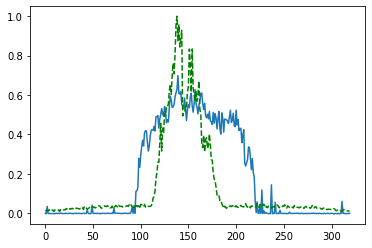

Time taken for epoch:  156.70424890518188
Epoch = [ 29/3000]  Iter = [   0/39480]  Loss = 0.2353 Avg Loss = 0.2353  Time = 0.0773s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 29/3000]  Iter = [ 100/39480]  Loss = 0.2191 Avg Loss = 0.2238  Time = 0.0042s
Epoch = [ 29/3000]  Iter = [ 200/39480]  Loss = 0.2286 Avg Loss = 0.22  Time = 0.0036s
Epoch = [ 29/3000]  Iter = [ 300/39480]  Loss = 0.2063 Avg Loss = 0.2161  Time = 0.0034s
Epoch = [ 29/3000]  Iter = [ 400/39480]  Loss = 0.2053 Avg Loss = 0.2165  Time = 0.0035s
Epoch = [ 29/3000]  Iter = [ 500/39480]  Loss = 0.219 Avg Loss = 0.2182  Time = 0.0036s
Epoch = [ 29/3000]  Iter = [ 600/39480]  Loss = 0.2288 Avg Loss = 0.2204  Time = 0.0036s
Epoch = [ 29/3000]  Iter = [ 700/39480]  Loss = 0.214 Avg Loss = 0.2213  Time = 0.0036s
Epoch = [ 29/3000]  Iter = [ 800/39480]  Loss = 0.2343 Avg Loss = 0.2179  Time = 0.0033s
Epoch = [ 29/3000]  Iter = [ 900/39480]  Loss = 0.2181 Avg Loss = 0.2197  Time = 0.0037s
Epoch = [ 29/3000]  Iter = [1000/39480]  Loss = 0.2342 Avg Loss = 0.2163  Time = 0.0036s
Epoch = [ 29/3000]  Iter = [1100/39480]  Loss = 0.2299 Avg Loss = 0.2161  Time = 0.0034s
Epoch = [ 29/3000]  Iter 

Epoch = [ 29/3000]  Iter = [9400/39480]  Loss = 0.2337 Avg Loss = 0.2289  Time = 0.0036s
Epoch = [ 29/3000]  Iter = [9500/39480]  Loss = 0.2168 Avg Loss = 0.2184  Time = 0.0032s
Epoch = [ 29/3000]  Iter = [9600/39480]  Loss = 0.2337 Avg Loss = 0.2153  Time = 0.0032s
Epoch = [ 29/3000]  Iter = [9700/39480]  Loss = 0.2086 Avg Loss = 0.2163  Time = 0.0033s
Epoch = [ 29/3000]  Iter = [9800/39480]  Loss = 0.2313 Avg Loss = 0.2168  Time = 0.0045s
Epoch = [ 29/3000]  Iter = [9900/39480]  Loss = 0.2436 Avg Loss = 0.2175  Time = 0.0034s
Epoch = [ 29/3000]  Iter = [10000/39480]  Loss = 0.2014 Avg Loss = 0.2159  Time = 0.0034s
Epoch = [ 29/3000]  Iter = [10100/39480]  Loss = 0.2379 Avg Loss = 0.217  Time = 0.0043s
Epoch = [ 29/3000]  Iter = [10200/39480]  Loss = 0.1894 Avg Loss = 0.2176  Time = 0.0041s
Epoch = [ 29/3000]  Iter = [10300/39480]  Loss = 0.2065 Avg Loss = 0.2218  Time = 0.0036s
Epoch = [ 29/3000]  Iter = [10400/39480]  Loss = 0.2122 Avg Loss = 0.2193  Time = 0.0038s
Epoch = [ 29/3000

Epoch = [ 29/3000]  Iter = [18600/39480]  Loss = 0.2416 Avg Loss = 0.2173  Time = 0.0034s
Epoch = [ 29/3000]  Iter = [18700/39480]  Loss = 0.232 Avg Loss = 0.2203  Time = 0.0054s
Epoch = [ 29/3000]  Iter = [18800/39480]  Loss = 0.3066 Avg Loss = 0.2187  Time = 0.0045s
Epoch = [ 29/3000]  Iter = [18900/39480]  Loss = 0.2061 Avg Loss = 0.2179  Time = 0.0030s
Epoch = [ 29/3000]  Iter = [19000/39480]  Loss = 0.2303 Avg Loss = 0.2186  Time = 0.0035s
Epoch = [ 29/3000]  Iter = [19100/39480]  Loss = 0.1765 Avg Loss = 0.2195  Time = 0.0035s
Epoch = [ 29/3000]  Iter = [19200/39480]  Loss = 0.2123 Avg Loss = 0.2139  Time = 0.0036s
Epoch = [ 29/3000]  Iter = [19300/39480]  Loss = 0.2264 Avg Loss = 0.2178  Time = 0.0032s
Epoch = [ 29/3000]  Iter = [19400/39480]  Loss = 0.2089 Avg Loss = 0.2157  Time = 0.0035s
Epoch = [ 29/3000]  Iter = [19500/39480]  Loss = 0.2009 Avg Loss = 0.2169  Time = 0.0028s
Epoch = [ 29/3000]  Iter = [19600/39480]  Loss = 0.2193 Avg Loss = 0.2161  Time = 0.0035s
Epoch = [ 2

Epoch = [ 29/3000]  Iter = [27800/39480]  Loss = 0.276 Avg Loss = 0.2211  Time = 0.0032s
Epoch = [ 29/3000]  Iter = [27900/39480]  Loss = 0.2048 Avg Loss = 0.2171  Time = 0.0032s
Epoch = [ 29/3000]  Iter = [28000/39480]  Loss = 0.1891 Avg Loss = 0.216  Time = 0.0034s
Epoch = [ 29/3000]  Iter = [28100/39480]  Loss = 0.2067 Avg Loss = 0.2164  Time = 0.0045s
Epoch = [ 29/3000]  Iter = [28200/39480]  Loss = 0.2095 Avg Loss = 0.2194  Time = 0.0031s
Epoch = [ 29/3000]  Iter = [28300/39480]  Loss = 0.2125 Avg Loss = 0.2214  Time = 0.0034s
Epoch = [ 29/3000]  Iter = [28400/39480]  Loss = 0.2156 Avg Loss = 0.2174  Time = 0.0031s
Epoch = [ 29/3000]  Iter = [28500/39480]  Loss = 0.1993 Avg Loss = 0.2174  Time = 0.0036s
Epoch = [ 29/3000]  Iter = [28600/39480]  Loss = 0.205 Avg Loss = 0.2178  Time = 0.0031s
Epoch = [ 29/3000]  Iter = [28700/39480]  Loss = 0.2394 Avg Loss = 0.2191  Time = 0.0033s
Epoch = [ 29/3000]  Iter = [28800/39480]  Loss = 0.2415 Avg Loss = 0.2235  Time = 0.0032s
Epoch = [ 29/

Epoch = [ 29/3000]  Iter = [37000/39480]  Loss = 0.2101 Avg Loss = 0.2184  Time = 0.0036s
Epoch = [ 29/3000]  Iter = [37100/39480]  Loss = 0.2053 Avg Loss = 0.2169  Time = 0.0047s
Epoch = [ 29/3000]  Iter = [37200/39480]  Loss = 0.2168 Avg Loss = 0.2181  Time = 0.0049s
Epoch = [ 29/3000]  Iter = [37300/39480]  Loss = 0.2304 Avg Loss = 0.2165  Time = 0.0033s
Epoch = [ 29/3000]  Iter = [37400/39480]  Loss = 0.188 Avg Loss = 0.217  Time = 0.0036s
Epoch = [ 29/3000]  Iter = [37500/39480]  Loss = 0.2127 Avg Loss = 0.218  Time = 0.0036s


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch = [ 46/3000]  Iter = [29900/39480]  Loss = 0.1966 Avg Loss = 0.2174  Time = 0.0035s
Epoch = [ 46/3000]  Iter = [30000/39480]  Loss = 0.2547 Avg Loss = 0.2232  Time = 0.0035s
Epoch = [ 46/3000]  Iter = [30100/39480]  Loss = 0.2131 Avg Loss = 0.2173  Time = 0.0035s
Epoch = [ 46/3000]  Iter = [30200/39480]  Loss = 0.1874 Avg Loss = 0.213  Time = 0.0035s
Epoch = [ 46/3000]  Iter = [30300/39480]  Loss = 0.2205 Avg Loss = 0.2165  Time = 0.0035s
Epoch = [ 46/3000]  Iter = [30400/39480]  Loss = 0.2432 Avg Loss = 0.2197  Time = 0.0035s
Epoch = [ 46/3000]  Iter = [30500/39480]  Loss = 0.2416 Avg Loss = 0.2228  Time = 0.0031s
Epoch = [ 46/3000]  Iter = [30600/39480]  Loss = 0.2422 Avg Loss = 0.219  Time = 0.0035s
Epoch = [ 46/3000]  Iter = [30700/39480]  Loss = 0.2143 Avg Loss = 0.2178  Time = 0.0034s
Epoch = [ 46/3000]  Iter = [30800/39480]  Loss = 0.2151 Avg Loss = 0.2187  Time = 0.0031s
Epoch = [ 46/3000]  Iter = [30900/39480]  Loss = 0.3002 Avg Loss = 0.2191  Time = 0.0035s
Epoch = [ 46

Epoch = [ 46/3000]  Iter = [39100/39480]  Loss = 0.2376 Avg Loss = 0.2146  Time = 0.0036s
Epoch = [ 46/3000]  Iter = [39200/39480]  Loss = 0.1989 Avg Loss = 0.2172  Time = 0.0035s
Epoch = [ 46/3000]  Iter = [39300/39480]  Loss = 0.2507 Avg Loss = 0.2206  Time = 0.0035s
Epoch = [ 46/3000]  Iter = [39400/39480]  Loss = 0.2251 Avg Loss = 0.2203  Time = 0.0034s
Dev_Loss 0.19515775040510358 Epoch 46
Epoch = [  46/3000] TrainLoss = 0.2184  DevLoss = 0.1952 TrainTime = 128.7993s DevTime = 24.3204s


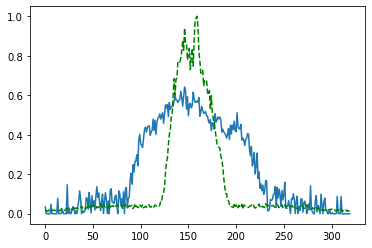

Time taken for epoch:  153.34115362167358
Epoch = [ 47/3000]  Iter = [   0/39480]  Loss = 0.218 Avg Loss = 0.218  Time = 0.0636s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 47/3000]  Iter = [ 100/39480]  Loss = 0.223 Avg Loss = 0.2178  Time = 0.0034s
Epoch = [ 47/3000]  Iter = [ 200/39480]  Loss = 0.2354 Avg Loss = 0.2183  Time = 0.0034s
Epoch = [ 47/3000]  Iter = [ 300/39480]  Loss = 0.2147 Avg Loss = 0.215  Time = 0.0034s
Epoch = [ 47/3000]  Iter = [ 400/39480]  Loss = 0.2186 Avg Loss = 0.2161  Time = 0.0035s
Epoch = [ 47/3000]  Iter = [ 500/39480]  Loss = 0.2199 Avg Loss = 0.2132  Time = 0.0036s
Epoch = [ 47/3000]  Iter = [ 600/39480]  Loss = 0.2033 Avg Loss = 0.2154  Time = 0.0035s
Epoch = [ 47/3000]  Iter = [ 700/39480]  Loss = 0.1845 Avg Loss = 0.2154  Time = 0.0035s
Epoch = [ 47/3000]  Iter = [ 800/39480]  Loss = 0.2605 Avg Loss = 0.2191  Time = 0.0029s
Epoch = [ 47/3000]  Iter = [ 900/39480]  Loss = 0.2002 Avg Loss = 0.2177  Time = 0.0028s
Epoch = [ 47/3000]  Iter = [1000/39480]  Loss = 0.2261 Avg Loss = 0.2203  Time = 0.0028s
Epoch = [ 47/3000]  Iter = [1100/39480]  Loss = 0.2583 Avg Loss = 0.2182  Time = 0.0028s
Epoch = [ 47/3000]  Ite

Epoch = [ 47/3000]  Iter = [9400/39480]  Loss = 0.208 Avg Loss = 0.2168  Time = 0.0034s
Epoch = [ 47/3000]  Iter = [9500/39480]  Loss = 0.1972 Avg Loss = 0.2222  Time = 0.0035s
Epoch = [ 47/3000]  Iter = [9600/39480]  Loss = 0.2375 Avg Loss = 0.2214  Time = 0.0035s
Epoch = [ 47/3000]  Iter = [9700/39480]  Loss = 0.2394 Avg Loss = 0.2178  Time = 0.0031s
Epoch = [ 47/3000]  Iter = [9800/39480]  Loss = 0.203 Avg Loss = 0.2197  Time = 0.0036s
Epoch = [ 47/3000]  Iter = [9900/39480]  Loss = 0.2039 Avg Loss = 0.2186  Time = 0.0034s
Epoch = [ 47/3000]  Iter = [10000/39480]  Loss = 0.2088 Avg Loss = 0.2203  Time = 0.0033s
Epoch = [ 47/3000]  Iter = [10100/39480]  Loss = 0.2197 Avg Loss = 0.2246  Time = 0.0036s
Epoch = [ 47/3000]  Iter = [10200/39480]  Loss = 0.2178 Avg Loss = 0.2162  Time = 0.0036s
Epoch = [ 47/3000]  Iter = [10300/39480]  Loss = 0.2221 Avg Loss = 0.2139  Time = 0.0037s
Epoch = [ 47/3000]  Iter = [10400/39480]  Loss = 0.2007 Avg Loss = 0.2164  Time = 0.0036s
Epoch = [ 47/3000]

Epoch = [ 47/3000]  Iter = [18600/39480]  Loss = 0.1891 Avg Loss = 0.2166  Time = 0.0035s
Epoch = [ 47/3000]  Iter = [18700/39480]  Loss = 0.1837 Avg Loss = 0.2171  Time = 0.0035s
Epoch = [ 47/3000]  Iter = [18800/39480]  Loss = 0.2416 Avg Loss = 0.2182  Time = 0.0035s
Epoch = [ 47/3000]  Iter = [18900/39480]  Loss = 0.2065 Avg Loss = 0.2179  Time = 0.0041s
Epoch = [ 47/3000]  Iter = [19000/39480]  Loss = 0.2142 Avg Loss = 0.2215  Time = 0.0036s
Epoch = [ 47/3000]  Iter = [19100/39480]  Loss = 0.209 Avg Loss = 0.219  Time = 0.0035s
Epoch = [ 47/3000]  Iter = [19200/39480]  Loss = 0.2218 Avg Loss = 0.219  Time = 0.0032s
Epoch = [ 47/3000]  Iter = [19300/39480]  Loss = 0.2246 Avg Loss = 0.2254  Time = 0.0036s
Epoch = [ 47/3000]  Iter = [19400/39480]  Loss = 0.1993 Avg Loss = 0.2214  Time = 0.0032s
Epoch = [ 47/3000]  Iter = [19500/39480]  Loss = 0.2151 Avg Loss = 0.2177  Time = 0.0036s
Epoch = [ 47/3000]  Iter = [19600/39480]  Loss = 0.1938 Avg Loss = 0.2179  Time = 0.0036s
Epoch = [ 47/

Epoch = [ 47/3000]  Iter = [27800/39480]  Loss = 0.1753 Avg Loss = 0.2163  Time = 0.0036s
Epoch = [ 47/3000]  Iter = [27900/39480]  Loss = 0.2187 Avg Loss = 0.2189  Time = 0.0036s
Epoch = [ 47/3000]  Iter = [28000/39480]  Loss = 0.191 Avg Loss = 0.2207  Time = 0.0036s
Epoch = [ 47/3000]  Iter = [28100/39480]  Loss = 0.1782 Avg Loss = 0.2141  Time = 0.0035s
Epoch = [ 47/3000]  Iter = [28200/39480]  Loss = 0.1945 Avg Loss = 0.2223  Time = 0.0035s
Epoch = [ 47/3000]  Iter = [28300/39480]  Loss = 0.2273 Avg Loss = 0.2215  Time = 0.0032s
Epoch = [ 47/3000]  Iter = [28400/39480]  Loss = 0.2074 Avg Loss = 0.219  Time = 0.0032s
Epoch = [ 47/3000]  Iter = [28500/39480]  Loss = 0.1675 Avg Loss = 0.2174  Time = 0.0036s
Epoch = [ 47/3000]  Iter = [28600/39480]  Loss = 0.2327 Avg Loss = 0.2176  Time = 0.0034s
Epoch = [ 47/3000]  Iter = [28700/39480]  Loss = 0.2422 Avg Loss = 0.2182  Time = 0.0035s
Epoch = [ 47/3000]  Iter = [28800/39480]  Loss = 0.2066 Avg Loss = 0.2168  Time = 0.0036s
Epoch = [ 47

Epoch = [ 47/3000]  Iter = [37000/39480]  Loss = 0.2364 Avg Loss = 0.2179  Time = 0.0036s
Epoch = [ 47/3000]  Iter = [37100/39480]  Loss = 0.1988 Avg Loss = 0.2174  Time = 0.0036s
Epoch = [ 47/3000]  Iter = [37200/39480]  Loss = 0.2263 Avg Loss = 0.2181  Time = 0.0036s
Epoch = [ 47/3000]  Iter = [37300/39480]  Loss = 0.2102 Avg Loss = 0.2219  Time = 0.0036s
Epoch = [ 47/3000]  Iter = [37400/39480]  Loss = 0.2143 Avg Loss = 0.216  Time = 0.0035s
Epoch = [ 47/3000]  Iter = [37500/39480]  Loss = 0.2275 Avg Loss = 0.2166  Time = 0.0033s
Epoch = [ 47/3000]  Iter = [37600/39480]  Loss = 0.1824 Avg Loss = 0.2158  Time = 0.0035s
Epoch = [ 47/3000]  Iter = [37700/39480]  Loss = 0.2073 Avg Loss = 0.2154  Time = 0.0035s
Epoch = [ 47/3000]  Iter = [37800/39480]  Loss = 0.2555 Avg Loss = 0.2146  Time = 0.0035s
Epoch = [ 47/3000]  Iter = [37900/39480]  Loss = 0.2348 Avg Loss = 0.2154  Time = 0.0033s
Epoch = [ 47/3000]  Iter = [38000/39480]  Loss = 0.2441 Avg Loss = 0.223  Time = 0.0036s
Epoch = [ 47

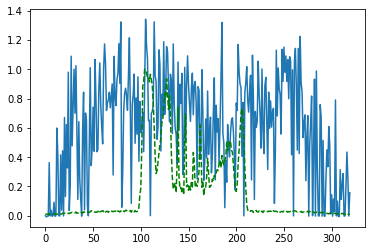

Time taken for epoch:  152.80549550056458
Epoch = [ 48/3000]  Iter = [   0/39480]  Loss = 0.2271 Avg Loss = 0.2271  Time = 0.0681s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 48/3000]  Iter = [ 100/39480]  Loss = 0.2355 Avg Loss = 0.2195  Time = 0.0029s
Epoch = [ 48/3000]  Iter = [ 200/39480]  Loss = 0.2387 Avg Loss = 0.2144  Time = 0.0037s
Epoch = [ 48/3000]  Iter = [ 300/39480]  Loss = 0.2185 Avg Loss = 0.2161  Time = 0.0035s
Epoch = [ 48/3000]  Iter = [ 400/39480]  Loss = 0.2411 Avg Loss = 0.2222  Time = 0.0036s
Epoch = [ 48/3000]  Iter = [ 500/39480]  Loss = 0.2213 Avg Loss = 0.2175  Time = 0.0037s
Epoch = [ 48/3000]  Iter = [ 600/39480]  Loss = 0.2097 Avg Loss = 0.2189  Time = 0.0036s
Epoch = [ 48/3000]  Iter = [ 700/39480]  Loss = 0.2264 Avg Loss = 0.2204  Time = 0.0036s
Epoch = [ 48/3000]  Iter = [ 800/39480]  Loss = 0.2176 Avg Loss = 0.2174  Time = 0.0029s
Epoch = [ 48/3000]  Iter = [ 900/39480]  Loss = 0.2573 Avg Loss = 0.2166  Time = 0.0035s
Epoch = [ 48/3000]  Iter = [1000/39480]  Loss = 0.2455 Avg Loss = 0.2139  Time = 0.0034s
Epoch = [ 48/3000]  Iter = [1100/39480]  Loss = 0.2196 Avg Loss = 0.2242  Time = 0.0036s
Epoch = [ 48/3000]  I

Epoch = [ 48/3000]  Iter = [9400/39480]  Loss = 0.2142 Avg Loss = 0.2199  Time = 0.0036s
Epoch = [ 48/3000]  Iter = [9500/39480]  Loss = 0.1818 Avg Loss = 0.2176  Time = 0.0036s
Epoch = [ 48/3000]  Iter = [9600/39480]  Loss = 0.205 Avg Loss = 0.2187  Time = 0.0036s
Epoch = [ 48/3000]  Iter = [9700/39480]  Loss = 0.1978 Avg Loss = 0.2147  Time = 0.0030s
Epoch = [ 48/3000]  Iter = [9800/39480]  Loss = 0.2283 Avg Loss = 0.2182  Time = 0.0036s
Epoch = [ 48/3000]  Iter = [9900/39480]  Loss = 0.2155 Avg Loss = 0.2184  Time = 0.0033s
Epoch = [ 48/3000]  Iter = [10000/39480]  Loss = 0.2331 Avg Loss = 0.2204  Time = 0.0035s
Epoch = [ 48/3000]  Iter = [10100/39480]  Loss = 0.2087 Avg Loss = 0.2183  Time = 0.0032s
Epoch = [ 48/3000]  Iter = [10200/39480]  Loss = 0.2053 Avg Loss = 0.2191  Time = 0.0036s
Epoch = [ 48/3000]  Iter = [10300/39480]  Loss = 0.2365 Avg Loss = 0.221  Time = 0.0034s
Epoch = [ 48/3000]  Iter = [10400/39480]  Loss = 0.2139 Avg Loss = 0.2161  Time = 0.0031s
Epoch = [ 48/3000]

Epoch = [ 48/3000]  Iter = [18600/39480]  Loss = 0.2421 Avg Loss = 0.2184  Time = 0.0036s
Epoch = [ 48/3000]  Iter = [18700/39480]  Loss = 0.2071 Avg Loss = 0.217  Time = 0.0035s
Epoch = [ 48/3000]  Iter = [18800/39480]  Loss = 0.2377 Avg Loss = 0.2188  Time = 0.0036s
Epoch = [ 48/3000]  Iter = [18900/39480]  Loss = 0.2213 Avg Loss = 0.2187  Time = 0.0036s
Epoch = [ 48/3000]  Iter = [19000/39480]  Loss = 0.1897 Avg Loss = 0.2166  Time = 0.0034s
Epoch = [ 48/3000]  Iter = [19100/39480]  Loss = 0.1891 Avg Loss = 0.2139  Time = 0.0037s
Epoch = [ 48/3000]  Iter = [19200/39480]  Loss = 0.2207 Avg Loss = 0.218  Time = 0.0035s
Epoch = [ 48/3000]  Iter = [19300/39480]  Loss = 0.2714 Avg Loss = 0.2176  Time = 0.0036s
Epoch = [ 48/3000]  Iter = [19400/39480]  Loss = 0.2387 Avg Loss = 0.2192  Time = 0.0036s
Epoch = [ 48/3000]  Iter = [19500/39480]  Loss = 0.2338 Avg Loss = 0.2161  Time = 0.0036s
Epoch = [ 48/3000]  Iter = [19600/39480]  Loss = 0.2278 Avg Loss = 0.2207  Time = 0.0036s
Epoch = [ 48

Epoch = [ 48/3000]  Iter = [27800/39480]  Loss = 0.2155 Avg Loss = 0.2175  Time = 0.0036s
Epoch = [ 48/3000]  Iter = [27900/39480]  Loss = 0.2137 Avg Loss = 0.2176  Time = 0.0033s
Epoch = [ 48/3000]  Iter = [28000/39480]  Loss = 0.1938 Avg Loss = 0.2168  Time = 0.0037s
Epoch = [ 48/3000]  Iter = [28100/39480]  Loss = 0.2195 Avg Loss = 0.2226  Time = 0.0034s
Epoch = [ 48/3000]  Iter = [28200/39480]  Loss = 0.1617 Avg Loss = 0.2209  Time = 0.0036s
Epoch = [ 48/3000]  Iter = [28300/39480]  Loss = 0.226 Avg Loss = 0.2187  Time = 0.0036s
Epoch = [ 48/3000]  Iter = [28400/39480]  Loss = 0.1909 Avg Loss = 0.2156  Time = 0.0037s
Epoch = [ 48/3000]  Iter = [28500/39480]  Loss = 0.2229 Avg Loss = 0.2192  Time = 0.0034s
Epoch = [ 48/3000]  Iter = [28600/39480]  Loss = 0.2242 Avg Loss = 0.2184  Time = 0.0035s
Epoch = [ 48/3000]  Iter = [28700/39480]  Loss = 0.232 Avg Loss = 0.2186  Time = 0.0034s
Epoch = [ 48/3000]  Iter = [28800/39480]  Loss = 0.2463 Avg Loss = 0.2178  Time = 0.0036s
Epoch = [ 48

Epoch = [ 48/3000]  Iter = [37000/39480]  Loss = 0.2393 Avg Loss = 0.22  Time = 0.0035s
Epoch = [ 48/3000]  Iter = [37100/39480]  Loss = 0.2343 Avg Loss = 0.2212  Time = 0.0036s
Epoch = [ 48/3000]  Iter = [37200/39480]  Loss = 0.189 Avg Loss = 0.2224  Time = 0.0035s
Epoch = [ 48/3000]  Iter = [37300/39480]  Loss = 0.1988 Avg Loss = 0.2162  Time = 0.0034s
Epoch = [ 48/3000]  Iter = [37400/39480]  Loss = 0.218 Avg Loss = 0.2186  Time = 0.0035s
Epoch = [ 48/3000]  Iter = [37500/39480]  Loss = 0.2123 Avg Loss = 0.2176  Time = 0.0036s
Epoch = [ 48/3000]  Iter = [37600/39480]  Loss = 0.2574 Avg Loss = 0.2155  Time = 0.0037s
Epoch = [ 48/3000]  Iter = [37700/39480]  Loss = 0.2151 Avg Loss = 0.2159  Time = 0.0035s
Epoch = [ 48/3000]  Iter = [37800/39480]  Loss = 0.2038 Avg Loss = 0.22  Time = 0.0036s
Epoch = [ 48/3000]  Iter = [37900/39480]  Loss = 0.2089 Avg Loss = 0.2182  Time = 0.0037s
Epoch = [ 48/3000]  Iter = [38000/39480]  Loss = 0.2387 Avg Loss = 0.2189  Time = 0.0036s
Epoch = [ 48/300

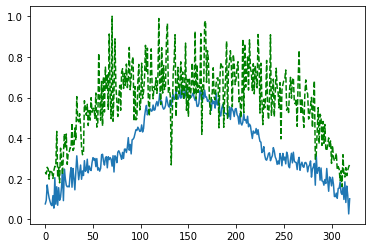

Time taken for epoch:  154.03026151657104
Epoch = [ 49/3000]  Iter = [   0/39480]  Loss = 0.2039 Avg Loss = 0.2039  Time = 0.0716s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 49/3000]  Iter = [ 100/39480]  Loss = 0.2319 Avg Loss = 0.2115  Time = 0.0032s
Epoch = [ 49/3000]  Iter = [ 200/39480]  Loss = 0.1788 Avg Loss = 0.2143  Time = 0.0036s
Epoch = [ 49/3000]  Iter = [ 300/39480]  Loss = 0.257 Avg Loss = 0.2187  Time = 0.0035s
Epoch = [ 49/3000]  Iter = [ 400/39480]  Loss = 0.1825 Avg Loss = 0.2196  Time = 0.0036s
Epoch = [ 49/3000]  Iter = [ 500/39480]  Loss = 0.2331 Avg Loss = 0.2217  Time = 0.0036s
Epoch = [ 49/3000]  Iter = [ 600/39480]  Loss = 0.2351 Avg Loss = 0.218  Time = 0.0036s
Epoch = [ 49/3000]  Iter = [ 700/39480]  Loss = 0.232 Avg Loss = 0.2161  Time = 0.0033s
Epoch = [ 49/3000]  Iter = [ 800/39480]  Loss = 0.2492 Avg Loss = 0.2166  Time = 0.0036s
Epoch = [ 49/3000]  Iter = [ 900/39480]  Loss = 0.2207 Avg Loss = 0.226  Time = 0.0025s
Epoch = [ 49/3000]  Iter = [1000/39480]  Loss = 0.201 Avg Loss = 0.2181  Time = 0.0029s
Epoch = [ 49/3000]  Iter = [1100/39480]  Loss = 0.2021 Avg Loss = 0.2127  Time = 0.0029s
Epoch = [ 49/3000]  Iter =

Epoch = [ 49/3000]  Iter = [9400/39480]  Loss = 0.2427 Avg Loss = 0.2194  Time = 0.0035s
Epoch = [ 49/3000]  Iter = [9500/39480]  Loss = 0.2071 Avg Loss = 0.2163  Time = 0.0036s
Epoch = [ 49/3000]  Iter = [9600/39480]  Loss = 0.2508 Avg Loss = 0.2196  Time = 0.0035s
Epoch = [ 49/3000]  Iter = [9700/39480]  Loss = 0.2264 Avg Loss = 0.2196  Time = 0.0036s
Epoch = [ 49/3000]  Iter = [9800/39480]  Loss = 0.2661 Avg Loss = 0.2194  Time = 0.0035s
Epoch = [ 49/3000]  Iter = [9900/39480]  Loss = 0.1931 Avg Loss = 0.2142  Time = 0.0035s
Epoch = [ 49/3000]  Iter = [10000/39480]  Loss = 0.3297 Avg Loss = 0.2197  Time = 0.0034s
Epoch = [ 49/3000]  Iter = [10100/39480]  Loss = 0.2206 Avg Loss = 0.224  Time = 0.0033s
Epoch = [ 49/3000]  Iter = [10200/39480]  Loss = 0.2329 Avg Loss = 0.2226  Time = 0.0036s
Epoch = [ 49/3000]  Iter = [10300/39480]  Loss = 0.244 Avg Loss = 0.2185  Time = 0.0036s
Epoch = [ 49/3000]  Iter = [10400/39480]  Loss = 0.2015 Avg Loss = 0.2177  Time = 0.0037s
Epoch = [ 49/3000]

Epoch = [ 49/3000]  Iter = [18600/39480]  Loss = 0.2429 Avg Loss = 0.2196  Time = 0.0036s
Epoch = [ 49/3000]  Iter = [18700/39480]  Loss = 0.2392 Avg Loss = 0.2183  Time = 0.0033s
Epoch = [ 49/3000]  Iter = [18800/39480]  Loss = 0.2104 Avg Loss = 0.2178  Time = 0.0035s
Epoch = [ 49/3000]  Iter = [18900/39480]  Loss = 0.1964 Avg Loss = 0.2171  Time = 0.0035s
Epoch = [ 49/3000]  Iter = [19000/39480]  Loss = 0.2248 Avg Loss = 0.2235  Time = 0.0032s
Epoch = [ 49/3000]  Iter = [19100/39480]  Loss = 0.1892 Avg Loss = 0.2178  Time = 0.0036s
Epoch = [ 49/3000]  Iter = [19200/39480]  Loss = 0.1891 Avg Loss = 0.2154  Time = 0.0034s
Epoch = [ 49/3000]  Iter = [19300/39480]  Loss = 0.2294 Avg Loss = 0.2174  Time = 0.0035s
Epoch = [ 49/3000]  Iter = [19400/39480]  Loss = 0.2216 Avg Loss = 0.223  Time = 0.0035s
Epoch = [ 49/3000]  Iter = [19500/39480]  Loss = 0.2427 Avg Loss = 0.2172  Time = 0.0035s
Epoch = [ 49/3000]  Iter = [19600/39480]  Loss = 0.224 Avg Loss = 0.2154  Time = 0.0033s
Epoch = [ 49

Epoch = [ 49/3000]  Iter = [27800/39480]  Loss = 0.2111 Avg Loss = 0.219  Time = 0.0033s
Epoch = [ 49/3000]  Iter = [27900/39480]  Loss = 0.2379 Avg Loss = 0.2192  Time = 0.0034s
Epoch = [ 49/3000]  Iter = [28000/39480]  Loss = 0.225 Avg Loss = 0.2148  Time = 0.0034s
Epoch = [ 49/3000]  Iter = [28100/39480]  Loss = 0.1739 Avg Loss = 0.2147  Time = 0.0034s
Epoch = [ 49/3000]  Iter = [28200/39480]  Loss = 0.2417 Avg Loss = 0.2193  Time = 0.0034s
Epoch = [ 49/3000]  Iter = [28300/39480]  Loss = 0.2198 Avg Loss = 0.2213  Time = 0.0033s
Epoch = [ 49/3000]  Iter = [28400/39480]  Loss = 0.2379 Avg Loss = 0.2195  Time = 0.0033s
Epoch = [ 49/3000]  Iter = [28500/39480]  Loss = 0.2323 Avg Loss = 0.2181  Time = 0.0033s
Epoch = [ 49/3000]  Iter = [28600/39480]  Loss = 0.1968 Avg Loss = 0.2168  Time = 0.0034s
Epoch = [ 49/3000]  Iter = [28700/39480]  Loss = 0.2004 Avg Loss = 0.2172  Time = 0.0034s
Epoch = [ 49/3000]  Iter = [28800/39480]  Loss = 0.1968 Avg Loss = 0.2195  Time = 0.0035s
Epoch = [ 49

Epoch = [ 49/3000]  Iter = [37000/39480]  Loss = 0.2159 Avg Loss = 0.2117  Time = 0.0036s
Epoch = [ 49/3000]  Iter = [37100/39480]  Loss = 0.2703 Avg Loss = 0.2167  Time = 0.0031s
Epoch = [ 49/3000]  Iter = [37200/39480]  Loss = 0.1961 Avg Loss = 0.2202  Time = 0.0035s
Epoch = [ 49/3000]  Iter = [37300/39480]  Loss = 0.2196 Avg Loss = 0.2175  Time = 0.0036s
Epoch = [ 49/3000]  Iter = [37400/39480]  Loss = 0.1952 Avg Loss = 0.2171  Time = 0.0035s
Epoch = [ 49/3000]  Iter = [37500/39480]  Loss = 0.1903 Avg Loss = 0.2163  Time = 0.0036s
Epoch = [ 49/3000]  Iter = [37600/39480]  Loss = 0.2141 Avg Loss = 0.2152  Time = 0.0036s
Epoch = [ 49/3000]  Iter = [37700/39480]  Loss = 0.206 Avg Loss = 0.2195  Time = 0.0037s
Epoch = [ 49/3000]  Iter = [37800/39480]  Loss = 0.2133 Avg Loss = 0.2168  Time = 0.0036s
Epoch = [ 49/3000]  Iter = [37900/39480]  Loss = 0.225 Avg Loss = 0.2205  Time = 0.0036s
Epoch = [ 49/3000]  Iter = [38000/39480]  Loss = 0.2319 Avg Loss = 0.2189  Time = 0.0036s
Epoch = [ 49

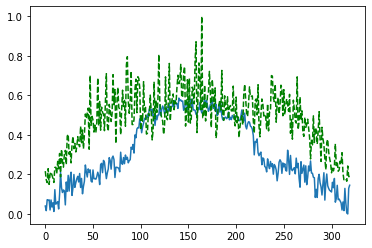

Time taken for epoch:  152.50250434875488
Epoch = [ 50/3000]  Iter = [   0/39480]  Loss = 0.2026 Avg Loss = 0.2026  Time = 0.0681s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 50/3000]  Iter = [ 100/39480]  Loss = 0.2047 Avg Loss = 0.2161  Time = 0.0037s
Epoch = [ 50/3000]  Iter = [ 200/39480]  Loss = 0.2417 Avg Loss = 0.2137  Time = 0.0037s
Epoch = [ 50/3000]  Iter = [ 300/39480]  Loss = 0.2002 Avg Loss = 0.216  Time = 0.0035s
Epoch = [ 50/3000]  Iter = [ 400/39480]  Loss = 0.2237 Avg Loss = 0.2188  Time = 0.0037s
Epoch = [ 50/3000]  Iter = [ 500/39480]  Loss = 0.2407 Avg Loss = 0.2162  Time = 0.0036s
Epoch = [ 50/3000]  Iter = [ 600/39480]  Loss = 0.208 Avg Loss = 0.2207  Time = 0.0036s
Epoch = [ 50/3000]  Iter = [ 700/39480]  Loss = 0.1979 Avg Loss = 0.2193  Time = 0.0037s
Epoch = [ 50/3000]  Iter = [ 800/39480]  Loss = 0.2186 Avg Loss = 0.2171  Time = 0.0037s
Epoch = [ 50/3000]  Iter = [ 900/39480]  Loss = 0.1967 Avg Loss = 0.2149  Time = 0.0036s
Epoch = [ 50/3000]  Iter = [1000/39480]  Loss = 0.2579 Avg Loss = 0.2185  Time = 0.0036s
Epoch = [ 50/3000]  Iter = [1100/39480]  Loss = 0.2441 Avg Loss = 0.2205  Time = 0.0036s
Epoch = [ 50/3000]  Ite

Epoch = [ 50/3000]  Iter = [9400/39480]  Loss = 0.2037 Avg Loss = 0.2198  Time = 0.0036s
Epoch = [ 50/3000]  Iter = [9500/39480]  Loss = 0.2226 Avg Loss = 0.2166  Time = 0.0035s
Epoch = [ 50/3000]  Iter = [9600/39480]  Loss = 0.213 Avg Loss = 0.2204  Time = 0.0035s
Epoch = [ 50/3000]  Iter = [9700/39480]  Loss = 0.2493 Avg Loss = 0.2235  Time = 0.0033s
Epoch = [ 50/3000]  Iter = [9800/39480]  Loss = 0.2041 Avg Loss = 0.2178  Time = 0.0035s
Epoch = [ 50/3000]  Iter = [9900/39480]  Loss = 0.2086 Avg Loss = 0.2158  Time = 0.0032s
Epoch = [ 50/3000]  Iter = [10000/39480]  Loss = 0.2678 Avg Loss = 0.218  Time = 0.0036s
Epoch = [ 50/3000]  Iter = [10100/39480]  Loss = 0.2619 Avg Loss = 0.2199  Time = 0.0036s
Epoch = [ 50/3000]  Iter = [10200/39480]  Loss = 0.1972 Avg Loss = 0.2155  Time = 0.0032s
Epoch = [ 50/3000]  Iter = [10300/39480]  Loss = 0.2345 Avg Loss = 0.2229  Time = 0.0035s
Epoch = [ 50/3000]  Iter = [10400/39480]  Loss = 0.2412 Avg Loss = 0.2185  Time = 0.0035s
Epoch = [ 50/3000]

Epoch = [ 50/3000]  Iter = [18600/39480]  Loss = 0.1913 Avg Loss = 0.2161  Time = 0.0033s
Epoch = [ 50/3000]  Iter = [18700/39480]  Loss = 0.2444 Avg Loss = 0.2148  Time = 0.0035s
Epoch = [ 50/3000]  Iter = [18800/39480]  Loss = 0.1919 Avg Loss = 0.2156  Time = 0.0035s
Epoch = [ 50/3000]  Iter = [18900/39480]  Loss = 0.2411 Avg Loss = 0.2195  Time = 0.0036s
Epoch = [ 50/3000]  Iter = [19000/39480]  Loss = 0.1919 Avg Loss = 0.2207  Time = 0.0035s
Epoch = [ 50/3000]  Iter = [19100/39480]  Loss = 0.2275 Avg Loss = 0.2172  Time = 0.0036s
Epoch = [ 50/3000]  Iter = [19200/39480]  Loss = 0.2387 Avg Loss = 0.2218  Time = 0.0036s
Epoch = [ 50/3000]  Iter = [19300/39480]  Loss = 0.2312 Avg Loss = 0.2196  Time = 0.0036s
Epoch = [ 50/3000]  Iter = [19400/39480]  Loss = 0.1979 Avg Loss = 0.2133  Time = 0.0035s
Epoch = [ 50/3000]  Iter = [19500/39480]  Loss = 0.1866 Avg Loss = 0.2149  Time = 0.0031s
Epoch = [ 50/3000]  Iter = [19600/39480]  Loss = 0.1851 Avg Loss = 0.2152  Time = 0.0034s
Epoch = [ 

Epoch = [ 50/3000]  Iter = [27800/39480]  Loss = 0.2017 Avg Loss = 0.2182  Time = 0.0035s
Epoch = [ 50/3000]  Iter = [27900/39480]  Loss = 0.2158 Avg Loss = 0.2173  Time = 0.0036s
Epoch = [ 50/3000]  Iter = [28000/39480]  Loss = 0.232 Avg Loss = 0.2204  Time = 0.0031s
Epoch = [ 50/3000]  Iter = [28100/39480]  Loss = 0.2151 Avg Loss = 0.217  Time = 0.0035s
Epoch = [ 50/3000]  Iter = [28200/39480]  Loss = 0.2191 Avg Loss = 0.2133  Time = 0.0036s
Epoch = [ 50/3000]  Iter = [28300/39480]  Loss = 0.1994 Avg Loss = 0.2155  Time = 0.0032s
Epoch = [ 50/3000]  Iter = [28400/39480]  Loss = 0.2075 Avg Loss = 0.2209  Time = 0.0034s
Epoch = [ 50/3000]  Iter = [28500/39480]  Loss = 0.2113 Avg Loss = 0.2238  Time = 0.0036s
Epoch = [ 50/3000]  Iter = [28600/39480]  Loss = 0.1951 Avg Loss = 0.2152  Time = 0.0036s
Epoch = [ 50/3000]  Iter = [28700/39480]  Loss = 0.2053 Avg Loss = 0.215  Time = 0.0035s
Epoch = [ 50/3000]  Iter = [28800/39480]  Loss = 0.2049 Avg Loss = 0.2186  Time = 0.0035s
Epoch = [ 50/

Epoch = [ 50/3000]  Iter = [37000/39480]  Loss = 0.2344 Avg Loss = 0.2145  Time = 0.0032s
Epoch = [ 50/3000]  Iter = [37100/39480]  Loss = 0.1875 Avg Loss = 0.2145  Time = 0.0035s
Epoch = [ 50/3000]  Iter = [37200/39480]  Loss = 0.2213 Avg Loss = 0.2161  Time = 0.0035s
Epoch = [ 50/3000]  Iter = [37300/39480]  Loss = 0.2274 Avg Loss = 0.2196  Time = 0.0036s
Epoch = [ 50/3000]  Iter = [37400/39480]  Loss = 0.2088 Avg Loss = 0.2167  Time = 0.0035s
Epoch = [ 50/3000]  Iter = [37500/39480]  Loss = 0.2303 Avg Loss = 0.2212  Time = 0.0035s
Epoch = [ 50/3000]  Iter = [37600/39480]  Loss = 0.1938 Avg Loss = 0.2224  Time = 0.0035s
Epoch = [ 50/3000]  Iter = [37700/39480]  Loss = 0.2259 Avg Loss = 0.223  Time = 0.0035s
Epoch = [ 50/3000]  Iter = [37800/39480]  Loss = 0.1835 Avg Loss = 0.2186  Time = 0.0035s
Epoch = [ 50/3000]  Iter = [37900/39480]  Loss = 0.2199 Avg Loss = 0.2181  Time = 0.0034s
Epoch = [ 50/3000]  Iter = [38000/39480]  Loss = 0.2018 Avg Loss = 0.217  Time = 0.0035s
Epoch = [ 50

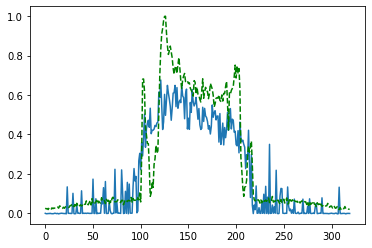

Time taken for epoch:  153.09923243522644
Epoch = [ 51/3000]  Iter = [   0/39480]  Loss = 0.2044 Avg Loss = 0.2044  Time = 0.0733s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 51/3000]  Iter = [ 100/39480]  Loss = 0.2245 Avg Loss = 0.2122  Time = 0.0029s
Epoch = [ 51/3000]  Iter = [ 200/39480]  Loss = 0.2078 Avg Loss = 0.216  Time = 0.0036s
Epoch = [ 51/3000]  Iter = [ 300/39480]  Loss = 0.2203 Avg Loss = 0.2166  Time = 0.0037s
Epoch = [ 51/3000]  Iter = [ 400/39480]  Loss = 0.1992 Avg Loss = 0.2166  Time = 0.0031s
Epoch = [ 51/3000]  Iter = [ 500/39480]  Loss = 0.2031 Avg Loss = 0.2127  Time = 0.0036s
Epoch = [ 51/3000]  Iter = [ 600/39480]  Loss = 0.2215 Avg Loss = 0.2159  Time = 0.0036s
Epoch = [ 51/3000]  Iter = [ 700/39480]  Loss = 0.189 Avg Loss = 0.2198  Time = 0.0036s
Epoch = [ 51/3000]  Iter = [ 800/39480]  Loss = 0.2263 Avg Loss = 0.2201  Time = 0.0032s
Epoch = [ 51/3000]  Iter = [ 900/39480]  Loss = 0.2183 Avg Loss = 0.2163  Time = 0.0029s
Epoch = [ 51/3000]  Iter = [1000/39480]  Loss = 0.2051 Avg Loss = 0.2163  Time = 0.0029s
Epoch = [ 51/3000]  Iter = [1100/39480]  Loss = 0.1901 Avg Loss = 0.2185  Time = 0.0029s
Epoch = [ 51/3000]  Ite

Epoch = [ 51/3000]  Iter = [9400/39480]  Loss = 0.1897 Avg Loss = 0.2193  Time = 0.0036s
Epoch = [ 51/3000]  Iter = [9500/39480]  Loss = 0.1991 Avg Loss = 0.2144  Time = 0.0035s
Epoch = [ 51/3000]  Iter = [9600/39480]  Loss = 0.1865 Avg Loss = 0.2212  Time = 0.0035s
Epoch = [ 51/3000]  Iter = [9700/39480]  Loss = 0.2116 Avg Loss = 0.2201  Time = 0.0035s
Epoch = [ 51/3000]  Iter = [9800/39480]  Loss = 0.1983 Avg Loss = 0.2181  Time = 0.0036s
Epoch = [ 51/3000]  Iter = [9900/39480]  Loss = 0.216 Avg Loss = 0.2171  Time = 0.0036s
Epoch = [ 51/3000]  Iter = [10000/39480]  Loss = 0.1807 Avg Loss = 0.2194  Time = 0.0036s
Epoch = [ 51/3000]  Iter = [10100/39480]  Loss = 0.2356 Avg Loss = 0.222  Time = 0.0036s
Epoch = [ 51/3000]  Iter = [10200/39480]  Loss = 0.2062 Avg Loss = 0.2179  Time = 0.0035s
Epoch = [ 51/3000]  Iter = [10300/39480]  Loss = 0.2282 Avg Loss = 0.216  Time = 0.0035s
Epoch = [ 51/3000]  Iter = [10400/39480]  Loss = 0.2092 Avg Loss = 0.2206  Time = 0.0036s
Epoch = [ 51/3000] 

Epoch = [ 51/3000]  Iter = [18600/39480]  Loss = 0.2119 Avg Loss = 0.2169  Time = 0.0036s
Epoch = [ 51/3000]  Iter = [18700/39480]  Loss = 0.2106 Avg Loss = 0.2176  Time = 0.0036s
Epoch = [ 51/3000]  Iter = [18800/39480]  Loss = 0.2142 Avg Loss = 0.2186  Time = 0.0035s
Epoch = [ 51/3000]  Iter = [18900/39480]  Loss = 0.2295 Avg Loss = 0.2207  Time = 0.0035s
Epoch = [ 51/3000]  Iter = [19000/39480]  Loss = 0.1876 Avg Loss = 0.2195  Time = 0.0036s
Epoch = [ 51/3000]  Iter = [19100/39480]  Loss = 0.2001 Avg Loss = 0.2163  Time = 0.0035s
Epoch = [ 51/3000]  Iter = [19200/39480]  Loss = 0.1913 Avg Loss = 0.2198  Time = 0.0034s
Epoch = [ 51/3000]  Iter = [19300/39480]  Loss = 0.2094 Avg Loss = 0.2159  Time = 0.0036s
Epoch = [ 51/3000]  Iter = [19400/39480]  Loss = 0.196 Avg Loss = 0.2179  Time = 0.0036s
Epoch = [ 51/3000]  Iter = [19500/39480]  Loss = 0.1733 Avg Loss = 0.2205  Time = 0.0034s
Epoch = [ 51/3000]  Iter = [19600/39480]  Loss = 0.2299 Avg Loss = 0.2179  Time = 0.0028s
Epoch = [ 5

Epoch = [ 51/3000]  Iter = [27800/39480]  Loss = 0.2117 Avg Loss = 0.2192  Time = 0.0029s
Epoch = [ 51/3000]  Iter = [27900/39480]  Loss = 0.2844 Avg Loss = 0.2149  Time = 0.0034s
Epoch = [ 51/3000]  Iter = [28000/39480]  Loss = 0.2084 Avg Loss = 0.2141  Time = 0.0035s
Epoch = [ 51/3000]  Iter = [28100/39480]  Loss = 0.2029 Avg Loss = 0.2197  Time = 0.0032s
Epoch = [ 51/3000]  Iter = [28200/39480]  Loss = 0.2439 Avg Loss = 0.2178  Time = 0.0033s
Epoch = [ 51/3000]  Iter = [28300/39480]  Loss = 0.2215 Avg Loss = 0.2193  Time = 0.0034s
Epoch = [ 51/3000]  Iter = [28400/39480]  Loss = 0.2367 Avg Loss = 0.2192  Time = 0.0034s
Epoch = [ 51/3000]  Iter = [28500/39480]  Loss = 0.2216 Avg Loss = 0.2184  Time = 0.0033s
Epoch = [ 51/3000]  Iter = [28600/39480]  Loss = 0.2242 Avg Loss = 0.2205  Time = 0.0033s
Epoch = [ 51/3000]  Iter = [28700/39480]  Loss = 0.2332 Avg Loss = 0.2227  Time = 0.0034s
Epoch = [ 51/3000]  Iter = [28800/39480]  Loss = 0.2206 Avg Loss = 0.2208  Time = 0.0035s
Epoch = [ 

Epoch = [ 51/3000]  Iter = [37000/39480]  Loss = 0.2277 Avg Loss = 0.2222  Time = 0.0036s
Epoch = [ 51/3000]  Iter = [37100/39480]  Loss = 0.2155 Avg Loss = 0.2174  Time = 0.0033s
Epoch = [ 51/3000]  Iter = [37200/39480]  Loss = 0.2254 Avg Loss = 0.2195  Time = 0.0032s
Epoch = [ 51/3000]  Iter = [37300/39480]  Loss = 0.1909 Avg Loss = 0.2151  Time = 0.0036s
Epoch = [ 51/3000]  Iter = [37400/39480]  Loss = 0.1872 Avg Loss = 0.2174  Time = 0.0036s
Epoch = [ 51/3000]  Iter = [37500/39480]  Loss = 0.2078 Avg Loss = 0.2201  Time = 0.0036s
Epoch = [ 51/3000]  Iter = [37600/39480]  Loss = 0.2021 Avg Loss = 0.2172  Time = 0.0036s
Epoch = [ 51/3000]  Iter = [37700/39480]  Loss = 0.206 Avg Loss = 0.2164  Time = 0.0036s
Epoch = [ 51/3000]  Iter = [37800/39480]  Loss = 0.2448 Avg Loss = 0.2153  Time = 0.0036s
Epoch = [ 51/3000]  Iter = [37900/39480]  Loss = 0.1981 Avg Loss = 0.2153  Time = 0.0035s
Epoch = [ 51/3000]  Iter = [38000/39480]  Loss = 0.2065 Avg Loss = 0.2178  Time = 0.0032s
Epoch = [ 5

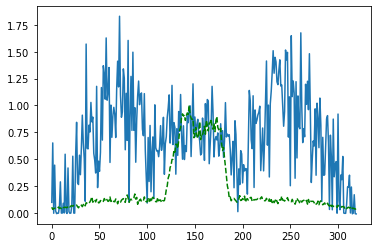

Time taken for epoch:  151.62006306648254
Epoch = [ 52/3000]  Iter = [   0/39480]  Loss = 0.2407 Avg Loss = 0.2407  Time = 0.0712s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 52/3000]  Iter = [ 100/39480]  Loss = 0.2338 Avg Loss = 0.2225  Time = 0.0033s
Epoch = [ 52/3000]  Iter = [ 200/39480]  Loss = 0.2234 Avg Loss = 0.2184  Time = 0.0035s
Epoch = [ 52/3000]  Iter = [ 300/39480]  Loss = 0.216 Avg Loss = 0.2164  Time = 0.0036s
Epoch = [ 52/3000]  Iter = [ 400/39480]  Loss = 0.1974 Avg Loss = 0.2147  Time = 0.0036s
Epoch = [ 52/3000]  Iter = [ 500/39480]  Loss = 0.1904 Avg Loss = 0.2169  Time = 0.0035s
Epoch = [ 52/3000]  Iter = [ 600/39480]  Loss = 0.1965 Avg Loss = 0.2167  Time = 0.0037s
Epoch = [ 52/3000]  Iter = [ 700/39480]  Loss = 0.2183 Avg Loss = 0.2211  Time = 0.0036s
Epoch = [ 52/3000]  Iter = [ 800/39480]  Loss = 0.2081 Avg Loss = 0.225  Time = 0.0028s
Epoch = [ 52/3000]  Iter = [ 900/39480]  Loss = 0.1873 Avg Loss = 0.2161  Time = 0.0029s
Epoch = [ 52/3000]  Iter = [1000/39480]  Loss = 0.2154 Avg Loss = 0.2157  Time = 0.0029s
Epoch = [ 52/3000]  Iter = [1100/39480]  Loss = 0.239 Avg Loss = 0.2121  Time = 0.0029s
Epoch = [ 52/3000]  Iter

Epoch = [ 52/3000]  Iter = [9400/39480]  Loss = 0.2307 Avg Loss = 0.2155  Time = 0.0036s
Epoch = [ 52/3000]  Iter = [9500/39480]  Loss = 0.231 Avg Loss = 0.2132  Time = 0.0035s
Epoch = [ 52/3000]  Iter = [9600/39480]  Loss = 0.3431 Avg Loss = 0.2201  Time = 0.0035s
Epoch = [ 52/3000]  Iter = [9700/39480]  Loss = 0.194 Avg Loss = 0.2242  Time = 0.0035s
Epoch = [ 52/3000]  Iter = [9800/39480]  Loss = 0.2057 Avg Loss = 0.2205  Time = 0.0036s
Epoch = [ 52/3000]  Iter = [9900/39480]  Loss = 0.24 Avg Loss = 0.2174  Time = 0.0036s
Epoch = [ 52/3000]  Iter = [10000/39480]  Loss = 0.2341 Avg Loss = 0.217  Time = 0.0036s
Epoch = [ 52/3000]  Iter = [10100/39480]  Loss = 0.2446 Avg Loss = 0.2247  Time = 0.0036s
Epoch = [ 52/3000]  Iter = [10200/39480]  Loss = 0.1854 Avg Loss = 0.2179  Time = 0.0035s
Epoch = [ 52/3000]  Iter = [10300/39480]  Loss = 0.2445 Avg Loss = 0.2227  Time = 0.0036s
Epoch = [ 52/3000]  Iter = [10400/39480]  Loss = 0.1545 Avg Loss = 0.2182  Time = 0.0036s
Epoch = [ 52/3000]  I

Epoch = [ 52/3000]  Iter = [18600/39480]  Loss = 0.22 Avg Loss = 0.2181  Time = 0.0035s
Epoch = [ 52/3000]  Iter = [18700/39480]  Loss = 0.217 Avg Loss = 0.2163  Time = 0.0033s
Epoch = [ 52/3000]  Iter = [18800/39480]  Loss = 0.2299 Avg Loss = 0.2207  Time = 0.0035s
Epoch = [ 52/3000]  Iter = [18900/39480]  Loss = 0.2157 Avg Loss = 0.2215  Time = 0.0036s
Epoch = [ 52/3000]  Iter = [19000/39480]  Loss = 0.2175 Avg Loss = 0.2194  Time = 0.0036s
Epoch = [ 52/3000]  Iter = [19100/39480]  Loss = 0.1997 Avg Loss = 0.2178  Time = 0.0035s
Epoch = [ 52/3000]  Iter = [19200/39480]  Loss = 0.21 Avg Loss = 0.2169  Time = 0.0036s
Epoch = [ 52/3000]  Iter = [19300/39480]  Loss = 0.1832 Avg Loss = 0.2165  Time = 0.0035s
Epoch = [ 52/3000]  Iter = [19400/39480]  Loss = 0.2422 Avg Loss = 0.2158  Time = 0.0037s
Epoch = [ 52/3000]  Iter = [19500/39480]  Loss = 0.2633 Avg Loss = 0.2177  Time = 0.0036s
Epoch = [ 52/3000]  Iter = [19600/39480]  Loss = 0.2232 Avg Loss = 0.2196  Time = 0.0036s
Epoch = [ 52/30

Epoch = [ 52/3000]  Iter = [27800/39480]  Loss = 0.2218 Avg Loss = 0.2178  Time = 0.0036s
Epoch = [ 52/3000]  Iter = [27900/39480]  Loss = 0.2311 Avg Loss = 0.2167  Time = 0.0035s
Epoch = [ 52/3000]  Iter = [28000/39480]  Loss = 0.2235 Avg Loss = 0.2162  Time = 0.0035s
Epoch = [ 52/3000]  Iter = [28100/39480]  Loss = 0.2085 Avg Loss = 0.2221  Time = 0.0037s
Epoch = [ 52/3000]  Iter = [28200/39480]  Loss = 0.2204 Avg Loss = 0.217  Time = 0.0033s
Epoch = [ 52/3000]  Iter = [28300/39480]  Loss = 0.2241 Avg Loss = 0.2156  Time = 0.0033s
Epoch = [ 52/3000]  Iter = [28400/39480]  Loss = 0.2395 Avg Loss = 0.2213  Time = 0.0033s
Epoch = [ 52/3000]  Iter = [28500/39480]  Loss = 0.2012 Avg Loss = 0.2192  Time = 0.0032s
Epoch = [ 52/3000]  Iter = [28600/39480]  Loss = 0.2453 Avg Loss = 0.219  Time = 0.0035s
Epoch = [ 52/3000]  Iter = [28700/39480]  Loss = 0.229 Avg Loss = 0.2161  Time = 0.0035s
Epoch = [ 52/3000]  Iter = [28800/39480]  Loss = 0.2688 Avg Loss = 0.2191  Time = 0.0036s
Epoch = [ 52/

Epoch = [ 52/3000]  Iter = [37000/39480]  Loss = 0.2173 Avg Loss = 0.2166  Time = 0.0035s
Epoch = [ 52/3000]  Iter = [37100/39480]  Loss = 0.217 Avg Loss = 0.2179  Time = 0.0036s
Epoch = [ 52/3000]  Iter = [37200/39480]  Loss = 0.2097 Avg Loss = 0.2217  Time = 0.0035s
Epoch = [ 52/3000]  Iter = [37300/39480]  Loss = 0.2126 Avg Loss = 0.2202  Time = 0.0035s
Epoch = [ 52/3000]  Iter = [37400/39480]  Loss = 0.236 Avg Loss = 0.218  Time = 0.0034s
Epoch = [ 52/3000]  Iter = [37500/39480]  Loss = 0.1784 Avg Loss = 0.2184  Time = 0.0035s
Epoch = [ 52/3000]  Iter = [37600/39480]  Loss = 0.2432 Avg Loss = 0.2171  Time = 0.0036s
Epoch = [ 52/3000]  Iter = [37700/39480]  Loss = 0.2184 Avg Loss = 0.2216  Time = 0.0036s
Epoch = [ 52/3000]  Iter = [37800/39480]  Loss = 0.2111 Avg Loss = 0.2235  Time = 0.0035s
Epoch = [ 52/3000]  Iter = [37900/39480]  Loss = 0.2074 Avg Loss = 0.2184  Time = 0.0035s
Epoch = [ 52/3000]  Iter = [38000/39480]  Loss = 0.2086 Avg Loss = 0.2202  Time = 0.0036s
Epoch = [ 52/

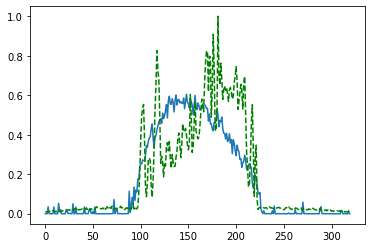

Time taken for epoch:  152.4692041873932
Epoch = [ 53/3000]  Iter = [   0/39480]  Loss = 0.1921 Avg Loss = 0.1921  Time = 0.0858s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 53/3000]  Iter = [ 100/39480]  Loss = 0.219 Avg Loss = 0.2086  Time = 0.0037s
Epoch = [ 53/3000]  Iter = [ 200/39480]  Loss = 0.2416 Avg Loss = 0.2134  Time = 0.0030s
Epoch = [ 53/3000]  Iter = [ 300/39480]  Loss = 0.2261 Avg Loss = 0.2159  Time = 0.0036s
Epoch = [ 53/3000]  Iter = [ 400/39480]  Loss = 0.2128 Avg Loss = 0.2222  Time = 0.0033s
Epoch = [ 53/3000]  Iter = [ 500/39480]  Loss = 0.1954 Avg Loss = 0.2168  Time = 0.0036s
Epoch = [ 53/3000]  Iter = [ 600/39480]  Loss = 0.1851 Avg Loss = 0.2201  Time = 0.0036s
Epoch = [ 53/3000]  Iter = [ 700/39480]  Loss = 0.1936 Avg Loss = 0.2201  Time = 0.0032s
Epoch = [ 53/3000]  Iter = [ 800/39480]  Loss = 0.2157 Avg Loss = 0.2156  Time = 0.0033s
Epoch = [ 53/3000]  Iter = [ 900/39480]  Loss = 0.2023 Avg Loss = 0.22  Time = 0.0030s
Epoch = [ 53/3000]  Iter = [1000/39480]  Loss = 0.1793 Avg Loss = 0.2173  Time = 0.0036s
Epoch = [ 53/3000]  Iter = [1100/39480]  Loss = 0.1925 Avg Loss = 0.2161  Time = 0.0035s
Epoch = [ 53/3000]  Iter

Epoch = [ 53/3000]  Iter = [9400/39480]  Loss = 0.2136 Avg Loss = 0.2158  Time = 0.0035s
Epoch = [ 53/3000]  Iter = [9500/39480]  Loss = 0.2027 Avg Loss = 0.2185  Time = 0.0036s
Epoch = [ 53/3000]  Iter = [9600/39480]  Loss = 0.2046 Avg Loss = 0.2216  Time = 0.0036s
Epoch = [ 53/3000]  Iter = [9700/39480]  Loss = 0.2347 Avg Loss = 0.2194  Time = 0.0035s
Epoch = [ 53/3000]  Iter = [9800/39480]  Loss = 0.192 Avg Loss = 0.2195  Time = 0.0035s
Epoch = [ 53/3000]  Iter = [9900/39480]  Loss = 0.2124 Avg Loss = 0.2183  Time = 0.0033s
Epoch = [ 53/3000]  Iter = [10000/39480]  Loss = 0.2489 Avg Loss = 0.216  Time = 0.0036s
Epoch = [ 53/3000]  Iter = [10100/39480]  Loss = 0.207 Avg Loss = 0.2195  Time = 0.0035s
Epoch = [ 53/3000]  Iter = [10200/39480]  Loss = 0.2194 Avg Loss = 0.2175  Time = 0.0035s
Epoch = [ 53/3000]  Iter = [10300/39480]  Loss = 0.2118 Avg Loss = 0.219  Time = 0.0037s
Epoch = [ 53/3000]  Iter = [10400/39480]  Loss = 0.1747 Avg Loss = 0.2169  Time = 0.0036s
Epoch = [ 53/3000]  

Epoch = [ 53/3000]  Iter = [18600/39480]  Loss = 0.2413 Avg Loss = 0.2269  Time = 0.0036s
Epoch = [ 53/3000]  Iter = [18700/39480]  Loss = 0.1929 Avg Loss = 0.2177  Time = 0.0036s
Epoch = [ 53/3000]  Iter = [18800/39480]  Loss = 0.2238 Avg Loss = 0.2179  Time = 0.0035s
Epoch = [ 53/3000]  Iter = [18900/39480]  Loss = 0.2003 Avg Loss = 0.2147  Time = 0.0036s
Epoch = [ 53/3000]  Iter = [19000/39480]  Loss = 0.1961 Avg Loss = 0.2165  Time = 0.0036s
Epoch = [ 53/3000]  Iter = [19100/39480]  Loss = 0.2636 Avg Loss = 0.2166  Time = 0.0035s
Epoch = [ 53/3000]  Iter = [19200/39480]  Loss = 0.2139 Avg Loss = 0.2199  Time = 0.0035s
Epoch = [ 53/3000]  Iter = [19300/39480]  Loss = 0.2198 Avg Loss = 0.218  Time = 0.0036s
Epoch = [ 53/3000]  Iter = [19400/39480]  Loss = 0.2041 Avg Loss = 0.2175  Time = 0.0035s
Epoch = [ 53/3000]  Iter = [19500/39480]  Loss = 0.223 Avg Loss = 0.2187  Time = 0.0035s
Epoch = [ 53/3000]  Iter = [19600/39480]  Loss = 0.2047 Avg Loss = 0.2197  Time = 0.0035s
Epoch = [ 53

Epoch = [ 53/3000]  Iter = [27800/39480]  Loss = 0.21 Avg Loss = 0.2162  Time = 0.0035s
Epoch = [ 53/3000]  Iter = [27900/39480]  Loss = 0.1882 Avg Loss = 0.2152  Time = 0.0036s
Epoch = [ 53/3000]  Iter = [28000/39480]  Loss = 0.189 Avg Loss = 0.2164  Time = 0.0035s
Epoch = [ 53/3000]  Iter = [28100/39480]  Loss = 0.1975 Avg Loss = 0.2162  Time = 0.0036s
Epoch = [ 53/3000]  Iter = [28200/39480]  Loss = 0.2439 Avg Loss = 0.2207  Time = 0.0036s
Epoch = [ 53/3000]  Iter = [28300/39480]  Loss = 0.2147 Avg Loss = 0.2225  Time = 0.0036s
Epoch = [ 53/3000]  Iter = [28400/39480]  Loss = 0.1766 Avg Loss = 0.2174  Time = 0.0035s
Epoch = [ 53/3000]  Iter = [28500/39480]  Loss = 0.2057 Avg Loss = 0.2152  Time = 0.0036s
Epoch = [ 53/3000]  Iter = [28600/39480]  Loss = 0.2679 Avg Loss = 0.2167  Time = 0.0036s
Epoch = [ 53/3000]  Iter = [28700/39480]  Loss = 0.219 Avg Loss = 0.2181  Time = 0.0036s
Epoch = [ 53/3000]  Iter = [28800/39480]  Loss = 0.2481 Avg Loss = 0.2168  Time = 0.0036s
Epoch = [ 53/3

Epoch = [ 53/3000]  Iter = [37000/39480]  Loss = 0.2059 Avg Loss = 0.2193  Time = 0.0036s
Epoch = [ 53/3000]  Iter = [37100/39480]  Loss = 0.2323 Avg Loss = 0.219  Time = 0.0035s
Epoch = [ 53/3000]  Iter = [37200/39480]  Loss = 0.2138 Avg Loss = 0.2192  Time = 0.0035s
Epoch = [ 53/3000]  Iter = [37300/39480]  Loss = 0.1903 Avg Loss = 0.2162  Time = 0.0035s
Epoch = [ 53/3000]  Iter = [37400/39480]  Loss = 0.2338 Avg Loss = 0.2164  Time = 0.0031s
Epoch = [ 53/3000]  Iter = [37500/39480]  Loss = 0.2132 Avg Loss = 0.2176  Time = 0.0036s
Epoch = [ 53/3000]  Iter = [37600/39480]  Loss = 0.2225 Avg Loss = 0.2203  Time = 0.0036s
Epoch = [ 53/3000]  Iter = [37700/39480]  Loss = 0.206 Avg Loss = 0.2182  Time = 0.0036s
Epoch = [ 53/3000]  Iter = [37800/39480]  Loss = 0.2438 Avg Loss = 0.2201  Time = 0.0036s
Epoch = [ 53/3000]  Iter = [37900/39480]  Loss = 0.238 Avg Loss = 0.2193  Time = 0.0035s
Epoch = [ 53/3000]  Iter = [38000/39480]  Loss = 0.2158 Avg Loss = 0.2182  Time = 0.0036s
Epoch = [ 53/

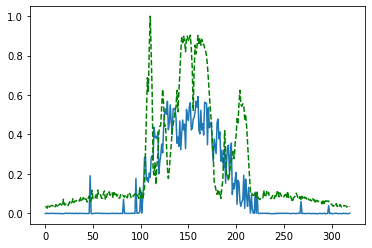

Time taken for epoch:  154.1530339717865
Epoch = [ 54/3000]  Iter = [   0/39480]  Loss = 0.2059 Avg Loss = 0.2059  Time = 0.0999s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 54/3000]  Iter = [ 100/39480]  Loss = 0.2461 Avg Loss = 0.212  Time = 0.0035s
Epoch = [ 54/3000]  Iter = [ 200/39480]  Loss = 0.2027 Avg Loss = 0.2205  Time = 0.0036s
Epoch = [ 54/3000]  Iter = [ 300/39480]  Loss = 0.2326 Avg Loss = 0.2178  Time = 0.0034s
Epoch = [ 54/3000]  Iter = [ 400/39480]  Loss = 0.2331 Avg Loss = 0.2138  Time = 0.0036s
Epoch = [ 54/3000]  Iter = [ 500/39480]  Loss = 0.1856 Avg Loss = 0.2167  Time = 0.0035s
Epoch = [ 54/3000]  Iter = [ 600/39480]  Loss = 0.2068 Avg Loss = 0.2157  Time = 0.0036s
Epoch = [ 54/3000]  Iter = [ 700/39480]  Loss = 0.2123 Avg Loss = 0.218  Time = 0.0036s
Epoch = [ 54/3000]  Iter = [ 800/39480]  Loss = 0.2394 Avg Loss = 0.2169  Time = 0.0036s
Epoch = [ 54/3000]  Iter = [ 900/39480]  Loss = 0.1942 Avg Loss = 0.2166  Time = 0.0032s
Epoch = [ 54/3000]  Iter = [1000/39480]  Loss = 0.2332 Avg Loss = 0.2174  Time = 0.0036s
Epoch = [ 54/3000]  Iter = [1100/39480]  Loss = 0.2025 Avg Loss = 0.2174  Time = 0.0036s
Epoch = [ 54/3000]  Ite

Epoch = [ 54/3000]  Iter = [9400/39480]  Loss = 0.2205 Avg Loss = 0.2181  Time = 0.0036s
Epoch = [ 54/3000]  Iter = [9500/39480]  Loss = 0.1956 Avg Loss = 0.2159  Time = 0.0036s
Epoch = [ 54/3000]  Iter = [9600/39480]  Loss = 0.1934 Avg Loss = 0.2184  Time = 0.0036s
Epoch = [ 54/3000]  Iter = [9700/39480]  Loss = 0.1913 Avg Loss = 0.2167  Time = 0.0034s
Epoch = [ 54/3000]  Iter = [9800/39480]  Loss = 0.2148 Avg Loss = 0.2152  Time = 0.0035s
Epoch = [ 54/3000]  Iter = [9900/39480]  Loss = 0.189 Avg Loss = 0.2168  Time = 0.0035s
Epoch = [ 54/3000]  Iter = [10000/39480]  Loss = 0.2266 Avg Loss = 0.226  Time = 0.0035s
Epoch = [ 54/3000]  Iter = [10100/39480]  Loss = 0.2011 Avg Loss = 0.2191  Time = 0.0035s
Epoch = [ 54/3000]  Iter = [10200/39480]  Loss = 0.2449 Avg Loss = 0.2147  Time = 0.0034s
Epoch = [ 54/3000]  Iter = [10300/39480]  Loss = 0.2108 Avg Loss = 0.2201  Time = 0.0031s
Epoch = [ 54/3000]  Iter = [10400/39480]  Loss = 0.2496 Avg Loss = 0.2156  Time = 0.0033s
Epoch = [ 54/3000]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch = [ 71/3000]  Iter = [18500/39480]  Loss = 0.2172 Avg Loss = 0.2187  Time = 0.0030s
Epoch = [ 71/3000]  Iter = [18600/39480]  Loss = 0.196 Avg Loss = 0.215  Time = 0.0031s
Epoch = [ 71/3000]  Iter = [18700/39480]  Loss = 0.2129 Avg Loss = 0.2189  Time = 0.0029s
Epoch = [ 71/3000]  Iter = [18800/39480]  Loss = 0.2224 Avg Loss = 0.2177  Time = 0.0030s
Epoch = [ 71/3000]  Iter = [18900/39480]  Loss = 0.3106 Avg Loss = 0.2179  Time = 0.0032s
Epoch = [ 71/3000]  Iter = [19000/39480]  Loss = 0.2498 Avg Loss = 0.217  Time = 0.0032s
Epoch = [ 71/3000]  Iter = [19100/39480]  Loss = 0.2532 Avg Loss = 0.2133  Time = 0.0030s
Epoch = [ 71/3000]  Iter = [19200/39480]  Loss = 0.2166 Avg Loss = 0.2204  Time = 0.0031s
Epoch = [ 71/3000]  Iter = [19300/39480]  Loss = 0.2363 Avg Loss = 0.218  Time = 0.0030s
Epoch = [ 71/3000]  Iter = [19400/39480]  Loss = 0.2385 Avg Loss = 0.2188  Time = 0.0029s
Epoch = [ 71/3000]  Iter = [19500/39480]  Loss = 0.2118 Avg Loss = 0.2161  Time = 0.0030s
Epoch = [ 71/3

Epoch = [ 71/3000]  Iter = [27700/39480]  Loss = 0.2529 Avg Loss = 0.2185  Time = 0.0030s
Epoch = [ 71/3000]  Iter = [27800/39480]  Loss = 0.1919 Avg Loss = 0.2217  Time = 0.0030s
Epoch = [ 71/3000]  Iter = [27900/39480]  Loss = 0.222 Avg Loss = 0.2198  Time = 0.0030s
Epoch = [ 71/3000]  Iter = [28000/39480]  Loss = 0.2065 Avg Loss = 0.2203  Time = 0.0029s
Epoch = [ 71/3000]  Iter = [28100/39480]  Loss = 0.2222 Avg Loss = 0.2193  Time = 0.0030s
Epoch = [ 71/3000]  Iter = [28200/39480]  Loss = 0.2223 Avg Loss = 0.2183  Time = 0.0030s
Epoch = [ 71/3000]  Iter = [28300/39480]  Loss = 0.1986 Avg Loss = 0.2164  Time = 0.0030s
Epoch = [ 71/3000]  Iter = [28400/39480]  Loss = 0.2317 Avg Loss = 0.2224  Time = 0.0029s
Epoch = [ 71/3000]  Iter = [28500/39480]  Loss = 0.2224 Avg Loss = 0.22  Time = 0.0031s
Epoch = [ 71/3000]  Iter = [28600/39480]  Loss = 0.2115 Avg Loss = 0.2209  Time = 0.0031s
Epoch = [ 71/3000]  Iter = [28700/39480]  Loss = 0.2005 Avg Loss = 0.2166  Time = 0.0030s
Epoch = [ 71/

Epoch = [ 71/3000]  Iter = [36900/39480]  Loss = 0.2097 Avg Loss = 0.2203  Time = 0.0029s
Epoch = [ 71/3000]  Iter = [37000/39480]  Loss = 0.1856 Avg Loss = 0.2189  Time = 0.0032s
Epoch = [ 71/3000]  Iter = [37100/39480]  Loss = 0.2166 Avg Loss = 0.2205  Time = 0.0030s
Epoch = [ 71/3000]  Iter = [37200/39480]  Loss = 0.2165 Avg Loss = 0.2183  Time = 0.0030s
Epoch = [ 71/3000]  Iter = [37300/39480]  Loss = 0.2153 Avg Loss = 0.2195  Time = 0.0031s
Epoch = [ 71/3000]  Iter = [37400/39480]  Loss = 0.2324 Avg Loss = 0.2167  Time = 0.0032s
Epoch = [ 71/3000]  Iter = [37500/39480]  Loss = 0.1966 Avg Loss = 0.2197  Time = 0.0029s
Epoch = [ 71/3000]  Iter = [37600/39480]  Loss = 0.1982 Avg Loss = 0.2223  Time = 0.0030s
Epoch = [ 71/3000]  Iter = [37700/39480]  Loss = 0.1919 Avg Loss = 0.2161  Time = 0.0029s
Epoch = [ 71/3000]  Iter = [37800/39480]  Loss = 0.2256 Avg Loss = 0.2152  Time = 0.0030s
Epoch = [ 71/3000]  Iter = [37900/39480]  Loss = 0.2199 Avg Loss = 0.2149  Time = 0.0030s
Epoch = [ 

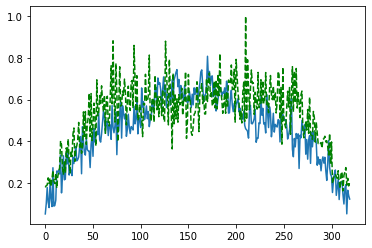

Time taken for epoch:  140.83620619773865
Epoch = [ 72/3000]  Iter = [   0/39480]  Loss = 0.2031 Avg Loss = 0.2031  Time = 0.0979s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 72/3000]  Iter = [ 100/39480]  Loss = 0.1977 Avg Loss = 0.2118  Time = 0.0029s
Epoch = [ 72/3000]  Iter = [ 200/39480]  Loss = 0.1967 Avg Loss = 0.2146  Time = 0.0033s
Epoch = [ 72/3000]  Iter = [ 300/39480]  Loss = 0.2109 Avg Loss = 0.2156  Time = 0.0029s
Epoch = [ 72/3000]  Iter = [ 400/39480]  Loss = 0.1812 Avg Loss = 0.22  Time = 0.0033s
Epoch = [ 72/3000]  Iter = [ 500/39480]  Loss = 0.2115 Avg Loss = 0.2202  Time = 0.0036s
Epoch = [ 72/3000]  Iter = [ 600/39480]  Loss = 0.1974 Avg Loss = 0.2205  Time = 0.0033s
Epoch = [ 72/3000]  Iter = [ 700/39480]  Loss = 0.2295 Avg Loss = 0.2199  Time = 0.0052s
Epoch = [ 72/3000]  Iter = [ 800/39480]  Loss = 0.2233 Avg Loss = 0.2239  Time = 0.0031s
Epoch = [ 72/3000]  Iter = [ 900/39480]  Loss = 0.2139 Avg Loss = 0.2176  Time = 0.0034s
Epoch = [ 72/3000]  Iter = [1000/39480]  Loss = 0.2034 Avg Loss = 0.2181  Time = 0.0031s
Epoch = [ 72/3000]  Iter = [1100/39480]  Loss = 0.1997 Avg Loss = 0.2146  Time = 0.0032s
Epoch = [ 72/3000]  Ite

Epoch = [ 72/3000]  Iter = [9400/39480]  Loss = 0.2146 Avg Loss = 0.2176  Time = 0.0030s
Epoch = [ 72/3000]  Iter = [9500/39480]  Loss = 0.2158 Avg Loss = 0.2155  Time = 0.0029s
Epoch = [ 72/3000]  Iter = [9600/39480]  Loss = 0.2078 Avg Loss = 0.2182  Time = 0.0029s
Epoch = [ 72/3000]  Iter = [9700/39480]  Loss = 0.2273 Avg Loss = 0.2161  Time = 0.0033s
Epoch = [ 72/3000]  Iter = [9800/39480]  Loss = 0.2002 Avg Loss = 0.2132  Time = 0.0031s
Epoch = [ 72/3000]  Iter = [9900/39480]  Loss = 0.1965 Avg Loss = 0.2173  Time = 0.0029s
Epoch = [ 72/3000]  Iter = [10000/39480]  Loss = 0.2134 Avg Loss = 0.221  Time = 0.0031s
Epoch = [ 72/3000]  Iter = [10100/39480]  Loss = 0.251 Avg Loss = 0.2168  Time = 0.0030s
Epoch = [ 72/3000]  Iter = [10200/39480]  Loss = 0.2057 Avg Loss = 0.2166  Time = 0.0031s
Epoch = [ 72/3000]  Iter = [10300/39480]  Loss = 0.2371 Avg Loss = 0.2182  Time = 0.0033s
Epoch = [ 72/3000]  Iter = [10400/39480]  Loss = 0.1955 Avg Loss = 0.2199  Time = 0.0033s
Epoch = [ 72/3000]

Epoch = [ 72/3000]  Iter = [18600/39480]  Loss = 0.2257 Avg Loss = 0.2222  Time = 0.0029s
Epoch = [ 72/3000]  Iter = [18700/39480]  Loss = 0.2006 Avg Loss = 0.2205  Time = 0.0030s
Epoch = [ 72/3000]  Iter = [18800/39480]  Loss = 0.2823 Avg Loss = 0.2185  Time = 0.0030s
Epoch = [ 72/3000]  Iter = [18900/39480]  Loss = 0.211 Avg Loss = 0.2191  Time = 0.0030s
Epoch = [ 72/3000]  Iter = [19000/39480]  Loss = 0.2005 Avg Loss = 0.2187  Time = 0.0030s
Epoch = [ 72/3000]  Iter = [19100/39480]  Loss = 0.2012 Avg Loss = 0.2191  Time = 0.0029s
Epoch = [ 72/3000]  Iter = [19200/39480]  Loss = 0.25 Avg Loss = 0.2178  Time = 0.0030s
Epoch = [ 72/3000]  Iter = [19300/39480]  Loss = 0.228 Avg Loss = 0.2216  Time = 0.0028s
Epoch = [ 72/3000]  Iter = [19400/39480]  Loss = 0.229 Avg Loss = 0.2174  Time = 0.0029s
Epoch = [ 72/3000]  Iter = [19500/39480]  Loss = 0.2451 Avg Loss = 0.2252  Time = 0.0030s
Epoch = [ 72/3000]  Iter = [19600/39480]  Loss = 0.227 Avg Loss = 0.2208  Time = 0.0031s
Epoch = [ 72/300

Epoch = [ 72/3000]  Iter = [27800/39480]  Loss = 0.2502 Avg Loss = 0.2179  Time = 0.0030s
Epoch = [ 72/3000]  Iter = [27900/39480]  Loss = 0.2052 Avg Loss = 0.2141  Time = 0.0030s
Epoch = [ 72/3000]  Iter = [28000/39480]  Loss = 0.204 Avg Loss = 0.2155  Time = 0.0030s
Epoch = [ 72/3000]  Iter = [28100/39480]  Loss = 0.2019 Avg Loss = 0.2149  Time = 0.0030s
Epoch = [ 72/3000]  Iter = [28200/39480]  Loss = 0.2042 Avg Loss = 0.2201  Time = 0.0030s
Epoch = [ 72/3000]  Iter = [28300/39480]  Loss = 0.2187 Avg Loss = 0.2184  Time = 0.0030s
Epoch = [ 72/3000]  Iter = [28400/39480]  Loss = 0.2145 Avg Loss = 0.218  Time = 0.0030s
Epoch = [ 72/3000]  Iter = [28500/39480]  Loss = 0.2155 Avg Loss = 0.2271  Time = 0.0031s
Epoch = [ 72/3000]  Iter = [28600/39480]  Loss = 0.2427 Avg Loss = 0.2184  Time = 0.0031s
Epoch = [ 72/3000]  Iter = [28700/39480]  Loss = 0.2749 Avg Loss = 0.2194  Time = 0.0031s
Epoch = [ 72/3000]  Iter = [28800/39480]  Loss = 0.2273 Avg Loss = 0.2202  Time = 0.0030s
Epoch = [ 72

Epoch = [ 72/3000]  Iter = [37000/39480]  Loss = 0.2007 Avg Loss = 0.2201  Time = 0.0029s
Epoch = [ 72/3000]  Iter = [37100/39480]  Loss = 0.2021 Avg Loss = 0.2158  Time = 0.0031s
Epoch = [ 72/3000]  Iter = [37200/39480]  Loss = 0.2287 Avg Loss = 0.2169  Time = 0.0030s
Epoch = [ 72/3000]  Iter = [37300/39480]  Loss = 0.2114 Avg Loss = 0.2147  Time = 0.0033s
Epoch = [ 72/3000]  Iter = [37400/39480]  Loss = 0.2259 Avg Loss = 0.2159  Time = 0.0030s
Epoch = [ 72/3000]  Iter = [37500/39480]  Loss = 0.2102 Avg Loss = 0.217  Time = 0.0030s
Epoch = [ 72/3000]  Iter = [37600/39480]  Loss = 0.2133 Avg Loss = 0.219  Time = 0.0030s
Epoch = [ 72/3000]  Iter = [37700/39480]  Loss = 0.1798 Avg Loss = 0.215  Time = 0.0030s
Epoch = [ 72/3000]  Iter = [37800/39480]  Loss = 0.2061 Avg Loss = 0.2148  Time = 0.0030s
Epoch = [ 72/3000]  Iter = [37900/39480]  Loss = 0.2013 Avg Loss = 0.2215  Time = 0.0030s
Epoch = [ 72/3000]  Iter = [38000/39480]  Loss = 0.2106 Avg Loss = 0.221  Time = 0.0032s
Epoch = [ 72/3

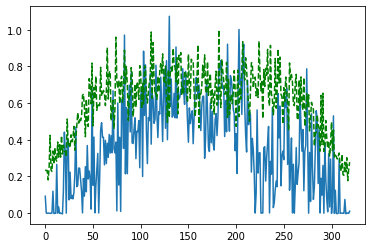

Time taken for epoch:  141.75456261634827
Epoch = [ 73/3000]  Iter = [   0/39480]  Loss = 0.2353 Avg Loss = 0.2353  Time = 0.0796s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 73/3000]  Iter = [ 100/39480]  Loss = 0.2148 Avg Loss = 0.2217  Time = 0.0034s
Epoch = [ 73/3000]  Iter = [ 200/39480]  Loss = 0.2091 Avg Loss = 0.2218  Time = 0.0037s
Epoch = [ 73/3000]  Iter = [ 300/39480]  Loss = 0.2255 Avg Loss = 0.2216  Time = 0.0036s
Epoch = [ 73/3000]  Iter = [ 400/39480]  Loss = 0.2185 Avg Loss = 0.2195  Time = 0.0036s
Epoch = [ 73/3000]  Iter = [ 500/39480]  Loss = 0.2087 Avg Loss = 0.2189  Time = 0.0036s
Epoch = [ 73/3000]  Iter = [ 600/39480]  Loss = 0.2058 Avg Loss = 0.2157  Time = 0.0034s
Epoch = [ 73/3000]  Iter = [ 700/39480]  Loss = 0.2121 Avg Loss = 0.2164  Time = 0.0031s
Epoch = [ 73/3000]  Iter = [ 800/39480]  Loss = 0.2282 Avg Loss = 0.2194  Time = 0.0035s
Epoch = [ 73/3000]  Iter = [ 900/39480]  Loss = 0.2222 Avg Loss = 0.2145  Time = 0.0031s
Epoch = [ 73/3000]  Iter = [1000/39480]  Loss = 0.2644 Avg Loss = 0.2184  Time = 0.0036s
Epoch = [ 73/3000]  Iter = [1100/39480]  Loss = 0.2214 Avg Loss = 0.2164  Time = 0.0035s
Epoch = [ 73/3000]  I

Epoch = [ 73/3000]  Iter = [9400/39480]  Loss = 0.2014 Avg Loss = 0.2178  Time = 0.0035s
Epoch = [ 73/3000]  Iter = [9500/39480]  Loss = 0.2174 Avg Loss = 0.2197  Time = 0.0036s
Epoch = [ 73/3000]  Iter = [9600/39480]  Loss = 0.2103 Avg Loss = 0.2221  Time = 0.0035s
Epoch = [ 73/3000]  Iter = [9700/39480]  Loss = 0.212 Avg Loss = 0.2169  Time = 0.0035s
Epoch = [ 73/3000]  Iter = [9800/39480]  Loss = 0.2221 Avg Loss = 0.2172  Time = 0.0034s
Epoch = [ 73/3000]  Iter = [9900/39480]  Loss = 0.2394 Avg Loss = 0.2176  Time = 0.0035s
Epoch = [ 73/3000]  Iter = [10000/39480]  Loss = 0.2409 Avg Loss = 0.2164  Time = 0.0033s
Epoch = [ 73/3000]  Iter = [10100/39480]  Loss = 0.1896 Avg Loss = 0.2175  Time = 0.0036s
Epoch = [ 73/3000]  Iter = [10200/39480]  Loss = 0.2503 Avg Loss = 0.2232  Time = 0.0036s
Epoch = [ 73/3000]  Iter = [10300/39480]  Loss = 0.239 Avg Loss = 0.2177  Time = 0.0035s
Epoch = [ 73/3000]  Iter = [10400/39480]  Loss = 0.2136 Avg Loss = 0.2185  Time = 0.0036s
Epoch = [ 73/3000]

Epoch = [ 73/3000]  Iter = [18600/39480]  Loss = 0.2152 Avg Loss = 0.2147  Time = 0.0036s
Epoch = [ 73/3000]  Iter = [18700/39480]  Loss = 0.2125 Avg Loss = 0.2175  Time = 0.0036s
Epoch = [ 73/3000]  Iter = [18800/39480]  Loss = 0.2354 Avg Loss = 0.2158  Time = 0.0034s
Epoch = [ 73/3000]  Iter = [18900/39480]  Loss = 0.2159 Avg Loss = 0.217  Time = 0.0035s
Epoch = [ 73/3000]  Iter = [19000/39480]  Loss = 0.1919 Avg Loss = 0.2175  Time = 0.0035s
Epoch = [ 73/3000]  Iter = [19100/39480]  Loss = 0.2243 Avg Loss = 0.2195  Time = 0.0036s
Epoch = [ 73/3000]  Iter = [19200/39480]  Loss = 0.2386 Avg Loss = 0.2171  Time = 0.0036s
Epoch = [ 73/3000]  Iter = [19300/39480]  Loss = 0.1957 Avg Loss = 0.2142  Time = 0.0036s
Epoch = [ 73/3000]  Iter = [19400/39480]  Loss = 0.2179 Avg Loss = 0.2139  Time = 0.0035s
Epoch = [ 73/3000]  Iter = [19500/39480]  Loss = 0.1795 Avg Loss = 0.2153  Time = 0.0036s
Epoch = [ 73/3000]  Iter = [19600/39480]  Loss = 0.1834 Avg Loss = 0.2168  Time = 0.0031s
Epoch = [ 7

Epoch = [ 73/3000]  Iter = [27800/39480]  Loss = 0.2249 Avg Loss = 0.2214  Time = 0.0035s
Epoch = [ 73/3000]  Iter = [27900/39480]  Loss = 0.2234 Avg Loss = 0.2157  Time = 0.0035s
Epoch = [ 73/3000]  Iter = [28000/39480]  Loss = 0.2065 Avg Loss = 0.2174  Time = 0.0035s
Epoch = [ 73/3000]  Iter = [28100/39480]  Loss = 0.2159 Avg Loss = 0.2192  Time = 0.0035s
Epoch = [ 73/3000]  Iter = [28200/39480]  Loss = 0.1809 Avg Loss = 0.2203  Time = 0.0031s
Epoch = [ 73/3000]  Iter = [28300/39480]  Loss = 0.206 Avg Loss = 0.2191  Time = 0.0035s
Epoch = [ 73/3000]  Iter = [28400/39480]  Loss = 0.2004 Avg Loss = 0.2164  Time = 0.0036s
Epoch = [ 73/3000]  Iter = [28500/39480]  Loss = 0.2176 Avg Loss = 0.2163  Time = 0.0034s
Epoch = [ 73/3000]  Iter = [28600/39480]  Loss = 0.2247 Avg Loss = 0.2176  Time = 0.0031s
Epoch = [ 73/3000]  Iter = [28700/39480]  Loss = 0.2408 Avg Loss = 0.2213  Time = 0.0035s
Epoch = [ 73/3000]  Iter = [28800/39480]  Loss = 0.2023 Avg Loss = 0.2193  Time = 0.0036s
Epoch = [ 7

Epoch = [ 73/3000]  Iter = [37000/39480]  Loss = 0.1949 Avg Loss = 0.2162  Time = 0.0036s
Epoch = [ 73/3000]  Iter = [37100/39480]  Loss = 0.2097 Avg Loss = 0.2166  Time = 0.0036s
Epoch = [ 73/3000]  Iter = [37200/39480]  Loss = 0.2442 Avg Loss = 0.2162  Time = 0.0034s
Epoch = [ 73/3000]  Iter = [37300/39480]  Loss = 0.2132 Avg Loss = 0.2157  Time = 0.0038s
Epoch = [ 73/3000]  Iter = [37400/39480]  Loss = 0.2177 Avg Loss = 0.2186  Time = 0.0036s
Epoch = [ 73/3000]  Iter = [37500/39480]  Loss = 0.1857 Avg Loss = 0.2167  Time = 0.0035s
Epoch = [ 73/3000]  Iter = [37600/39480]  Loss = 0.229 Avg Loss = 0.2174  Time = 0.0036s
Epoch = [ 73/3000]  Iter = [37700/39480]  Loss = 0.1871 Avg Loss = 0.2193  Time = 0.0036s
Epoch = [ 73/3000]  Iter = [37800/39480]  Loss = 0.1946 Avg Loss = 0.2221  Time = 0.0036s
Epoch = [ 73/3000]  Iter = [37900/39480]  Loss = 0.234 Avg Loss = 0.2192  Time = 0.0036s
Epoch = [ 73/3000]  Iter = [38000/39480]  Loss = 0.2449 Avg Loss = 0.2156  Time = 0.0035s
Epoch = [ 73

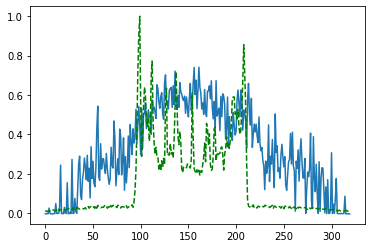

Time taken for epoch:  153.79182815551758
Epoch = [ 74/3000]  Iter = [   0/39480]  Loss = 0.2559 Avg Loss = 0.2559  Time = 0.0796s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 74/3000]  Iter = [ 100/39480]  Loss = 0.1998 Avg Loss = 0.2363  Time = 0.0034s
Epoch = [ 74/3000]  Iter = [ 200/39480]  Loss = 0.2347 Avg Loss = 0.2272  Time = 0.0035s
Epoch = [ 74/3000]  Iter = [ 300/39480]  Loss = 0.1883 Avg Loss = 0.2187  Time = 0.0036s
Epoch = [ 74/3000]  Iter = [ 400/39480]  Loss = 0.2105 Avg Loss = 0.218  Time = 0.0035s
Epoch = [ 74/3000]  Iter = [ 500/39480]  Loss = 0.1883 Avg Loss = 0.218  Time = 0.0036s
Epoch = [ 74/3000]  Iter = [ 600/39480]  Loss = 0.2159 Avg Loss = 0.2153  Time = 0.0036s
Epoch = [ 74/3000]  Iter = [ 700/39480]  Loss = 0.255 Avg Loss = 0.2178  Time = 0.0036s
Epoch = [ 74/3000]  Iter = [ 800/39480]  Loss = 0.2013 Avg Loss = 0.2181  Time = 0.0031s
Epoch = [ 74/3000]  Iter = [ 900/39480]  Loss = 0.2143 Avg Loss = 0.2168  Time = 0.0031s
Epoch = [ 74/3000]  Iter = [1000/39480]  Loss = 0.2297 Avg Loss = 0.2184  Time = 0.0031s
Epoch = [ 74/3000]  Iter = [1100/39480]  Loss = 0.2477 Avg Loss = 0.2213  Time = 0.0034s
Epoch = [ 74/3000]  Iter

Epoch = [ 74/3000]  Iter = [9400/39480]  Loss = 0.203 Avg Loss = 0.2165  Time = 0.0036s
Epoch = [ 74/3000]  Iter = [9500/39480]  Loss = 0.2579 Avg Loss = 0.2244  Time = 0.0036s
Epoch = [ 74/3000]  Iter = [9600/39480]  Loss = 0.223 Avg Loss = 0.2197  Time = 0.0036s
Epoch = [ 74/3000]  Iter = [9700/39480]  Loss = 0.2095 Avg Loss = 0.2198  Time = 0.0036s
Epoch = [ 74/3000]  Iter = [9800/39480]  Loss = 0.2224 Avg Loss = 0.2186  Time = 0.0035s
Epoch = [ 74/3000]  Iter = [9900/39480]  Loss = 0.2038 Avg Loss = 0.2181  Time = 0.0033s
Epoch = [ 74/3000]  Iter = [10000/39480]  Loss = 0.2128 Avg Loss = 0.2189  Time = 0.0036s
Epoch = [ 74/3000]  Iter = [10100/39480]  Loss = 0.1952 Avg Loss = 0.2149  Time = 0.0036s
Epoch = [ 74/3000]  Iter = [10200/39480]  Loss = 0.2513 Avg Loss = 0.2179  Time = 0.0036s
Epoch = [ 74/3000]  Iter = [10300/39480]  Loss = 0.233 Avg Loss = 0.2191  Time = 0.0035s
Epoch = [ 74/3000]  Iter = [10400/39480]  Loss = 0.2037 Avg Loss = 0.2204  Time = 0.0035s
Epoch = [ 74/3000] 

Epoch = [ 74/3000]  Iter = [18600/39480]  Loss = 0.2119 Avg Loss = 0.216  Time = 0.0036s
Epoch = [ 74/3000]  Iter = [18700/39480]  Loss = 0.2376 Avg Loss = 0.2196  Time = 0.0035s
Epoch = [ 74/3000]  Iter = [18800/39480]  Loss = 0.225 Avg Loss = 0.2169  Time = 0.0035s
Epoch = [ 74/3000]  Iter = [18900/39480]  Loss = 0.204 Avg Loss = 0.2179  Time = 0.0035s
Epoch = [ 74/3000]  Iter = [19000/39480]  Loss = 0.2129 Avg Loss = 0.2171  Time = 0.0036s
Epoch = [ 74/3000]  Iter = [19100/39480]  Loss = 0.1756 Avg Loss = 0.2137  Time = 0.0034s
Epoch = [ 74/3000]  Iter = [19200/39480]  Loss = 0.1961 Avg Loss = 0.2172  Time = 0.0036s
Epoch = [ 74/3000]  Iter = [19300/39480]  Loss = 0.2328 Avg Loss = 0.2174  Time = 0.0036s
Epoch = [ 74/3000]  Iter = [19400/39480]  Loss = 0.216 Avg Loss = 0.2136  Time = 0.0035s
Epoch = [ 74/3000]  Iter = [19500/39480]  Loss = 0.2202 Avg Loss = 0.2171  Time = 0.0036s
Epoch = [ 74/3000]  Iter = [19600/39480]  Loss = 0.2436 Avg Loss = 0.2202  Time = 0.0035s
Epoch = [ 74/3

Epoch = [ 74/3000]  Iter = [27800/39480]  Loss = 0.177 Avg Loss = 0.2156  Time = 0.0035s
Epoch = [ 74/3000]  Iter = [27900/39480]  Loss = 0.2087 Avg Loss = 0.2172  Time = 0.0035s
Epoch = [ 74/3000]  Iter = [28000/39480]  Loss = 0.1976 Avg Loss = 0.2175  Time = 0.0036s
Epoch = [ 74/3000]  Iter = [28100/39480]  Loss = 0.2348 Avg Loss = 0.219  Time = 0.0036s
Epoch = [ 74/3000]  Iter = [28200/39480]  Loss = 0.222 Avg Loss = 0.218  Time = 0.0036s
Epoch = [ 74/3000]  Iter = [28300/39480]  Loss = 0.194 Avg Loss = 0.2189  Time = 0.0036s
Epoch = [ 74/3000]  Iter = [28400/39480]  Loss = 0.2106 Avg Loss = 0.216  Time = 0.0036s
Epoch = [ 74/3000]  Iter = [28500/39480]  Loss = 0.1802 Avg Loss = 0.2136  Time = 0.0036s
Epoch = [ 74/3000]  Iter = [28600/39480]  Loss = 0.2359 Avg Loss = 0.2152  Time = 0.0036s
Epoch = [ 74/3000]  Iter = [28700/39480]  Loss = 0.2446 Avg Loss = 0.2184  Time = 0.0034s
Epoch = [ 74/3000]  Iter = [28800/39480]  Loss = 0.2367 Avg Loss = 0.2206  Time = 0.0035s
Epoch = [ 74/300

Epoch = [ 74/3000]  Iter = [37000/39480]  Loss = 0.2083 Avg Loss = 0.22  Time = 0.0035s
Epoch = [ 74/3000]  Iter = [37100/39480]  Loss = 0.2754 Avg Loss = 0.2226  Time = 0.0035s
Epoch = [ 74/3000]  Iter = [37200/39480]  Loss = 0.2244 Avg Loss = 0.2208  Time = 0.0033s
Epoch = [ 74/3000]  Iter = [37300/39480]  Loss = 0.1983 Avg Loss = 0.22  Time = 0.0033s
Epoch = [ 74/3000]  Iter = [37400/39480]  Loss = 0.2024 Avg Loss = 0.2154  Time = 0.0033s
Epoch = [ 74/3000]  Iter = [37500/39480]  Loss = 0.2071 Avg Loss = 0.2179  Time = 0.0035s
Epoch = [ 74/3000]  Iter = [37600/39480]  Loss = 0.2601 Avg Loss = 0.2181  Time = 0.0032s
Epoch = [ 74/3000]  Iter = [37700/39480]  Loss = 0.209 Avg Loss = 0.2167  Time = 0.0034s
Epoch = [ 74/3000]  Iter = [37800/39480]  Loss = 0.2312 Avg Loss = 0.2178  Time = 0.0033s
Epoch = [ 74/3000]  Iter = [37900/39480]  Loss = 0.1922 Avg Loss = 0.2186  Time = 0.0036s
Epoch = [ 74/3000]  Iter = [38000/39480]  Loss = 0.215 Avg Loss = 0.2154  Time = 0.0036s
Epoch = [ 74/300

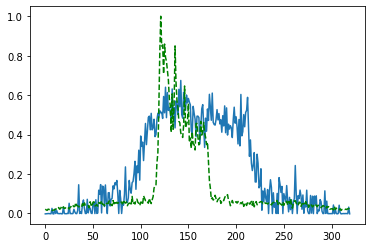

Time taken for epoch:  153.2601191997528
Epoch = [ 75/3000]  Iter = [   0/39480]  Loss = 0.2638 Avg Loss = 0.2638  Time = 0.0725s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 75/3000]  Iter = [ 100/39480]  Loss = 0.2046 Avg Loss = 0.2355  Time = 0.0033s
Epoch = [ 75/3000]  Iter = [ 200/39480]  Loss = 0.2269 Avg Loss = 0.2265  Time = 0.0036s
Epoch = [ 75/3000]  Iter = [ 300/39480]  Loss = 0.3102 Avg Loss = 0.2228  Time = 0.0034s
Epoch = [ 75/3000]  Iter = [ 400/39480]  Loss = 0.2339 Avg Loss = 0.2185  Time = 0.0037s
Epoch = [ 75/3000]  Iter = [ 500/39480]  Loss = 0.241 Avg Loss = 0.2166  Time = 0.0036s
Epoch = [ 75/3000]  Iter = [ 600/39480]  Loss = 0.2271 Avg Loss = 0.2156  Time = 0.0036s
Epoch = [ 75/3000]  Iter = [ 700/39480]  Loss = 0.2279 Avg Loss = 0.22  Time = 0.0036s
Epoch = [ 75/3000]  Iter = [ 800/39480]  Loss = 0.2191 Avg Loss = 0.2209  Time = 0.0036s
Epoch = [ 75/3000]  Iter = [ 900/39480]  Loss = 0.2414 Avg Loss = 0.218  Time = 0.0036s
Epoch = [ 75/3000]  Iter = [1000/39480]  Loss = 0.2509 Avg Loss = 0.2189  Time = 0.0035s
Epoch = [ 75/3000]  Iter = [1100/39480]  Loss = 0.2108 Avg Loss = 0.2187  Time = 0.0035s
Epoch = [ 75/3000]  Iter 

Epoch = [ 75/3000]  Iter = [9400/39480]  Loss = 0.205 Avg Loss = 0.2173  Time = 0.0035s
Epoch = [ 75/3000]  Iter = [9500/39480]  Loss = 0.2035 Avg Loss = 0.2191  Time = 0.0033s
Epoch = [ 75/3000]  Iter = [9600/39480]  Loss = 0.1968 Avg Loss = 0.2175  Time = 0.0035s
Epoch = [ 75/3000]  Iter = [9700/39480]  Loss = 0.2102 Avg Loss = 0.2187  Time = 0.0033s
Epoch = [ 75/3000]  Iter = [9800/39480]  Loss = 0.21 Avg Loss = 0.2219  Time = 0.0036s
Epoch = [ 75/3000]  Iter = [9900/39480]  Loss = 0.2334 Avg Loss = 0.2185  Time = 0.0034s
Epoch = [ 75/3000]  Iter = [10000/39480]  Loss = 0.2061 Avg Loss = 0.2165  Time = 0.0035s
Epoch = [ 75/3000]  Iter = [10100/39480]  Loss = 0.2027 Avg Loss = 0.2153  Time = 0.0035s
Epoch = [ 75/3000]  Iter = [10200/39480]  Loss = 0.2079 Avg Loss = 0.216  Time = 0.0033s
Epoch = [ 75/3000]  Iter = [10300/39480]  Loss = 0.1929 Avg Loss = 0.2164  Time = 0.0033s
Epoch = [ 75/3000]  Iter = [10400/39480]  Loss = 0.2172 Avg Loss = 0.2172  Time = 0.0033s
Epoch = [ 75/3000]  

Epoch = [ 75/3000]  Iter = [18600/39480]  Loss = 0.2501 Avg Loss = 0.2193  Time = 0.0033s
Epoch = [ 75/3000]  Iter = [18700/39480]  Loss = 0.2636 Avg Loss = 0.2225  Time = 0.0036s
Epoch = [ 75/3000]  Iter = [18800/39480]  Loss = 0.217 Avg Loss = 0.2193  Time = 0.0033s
Epoch = [ 75/3000]  Iter = [18900/39480]  Loss = 0.2453 Avg Loss = 0.2182  Time = 0.0036s
Epoch = [ 75/3000]  Iter = [19000/39480]  Loss = 0.1963 Avg Loss = 0.2195  Time = 0.0035s
Epoch = [ 75/3000]  Iter = [19100/39480]  Loss = 0.2305 Avg Loss = 0.2206  Time = 0.0033s
Epoch = [ 75/3000]  Iter = [19200/39480]  Loss = 0.2195 Avg Loss = 0.2148  Time = 0.0035s
Epoch = [ 75/3000]  Iter = [19300/39480]  Loss = 0.2215 Avg Loss = 0.2146  Time = 0.0034s
Epoch = [ 75/3000]  Iter = [19400/39480]  Loss = 0.2336 Avg Loss = 0.2197  Time = 0.0035s
Epoch = [ 75/3000]  Iter = [19500/39480]  Loss = 0.2162 Avg Loss = 0.2143  Time = 0.0036s
Epoch = [ 75/3000]  Iter = [19600/39480]  Loss = 0.2204 Avg Loss = 0.2185  Time = 0.0031s
Epoch = [ 7

Epoch = [ 75/3000]  Iter = [27800/39480]  Loss = 0.183 Avg Loss = 0.2182  Time = 0.0031s
Epoch = [ 75/3000]  Iter = [27900/39480]  Loss = 0.1956 Avg Loss = 0.2177  Time = 0.0035s
Epoch = [ 75/3000]  Iter = [28000/39480]  Loss = 0.2349 Avg Loss = 0.2197  Time = 0.0035s
Epoch = [ 75/3000]  Iter = [28100/39480]  Loss = 0.2312 Avg Loss = 0.2195  Time = 0.0035s
Epoch = [ 75/3000]  Iter = [28200/39480]  Loss = 0.2322 Avg Loss = 0.2158  Time = 0.0035s
Epoch = [ 75/3000]  Iter = [28300/39480]  Loss = 0.2496 Avg Loss = 0.2241  Time = 0.0035s
Epoch = [ 75/3000]  Iter = [28400/39480]  Loss = 0.1773 Avg Loss = 0.2185  Time = 0.0035s
Epoch = [ 75/3000]  Iter = [28500/39480]  Loss = 0.2131 Avg Loss = 0.2189  Time = 0.0035s
Epoch = [ 75/3000]  Iter = [28600/39480]  Loss = 0.2207 Avg Loss = 0.2201  Time = 0.0035s
Epoch = [ 75/3000]  Iter = [28700/39480]  Loss = 0.2103 Avg Loss = 0.2204  Time = 0.0035s
Epoch = [ 75/3000]  Iter = [28800/39480]  Loss = 0.2503 Avg Loss = 0.2217  Time = 0.0035s
Epoch = [ 7

Epoch = [ 75/3000]  Iter = [37000/39480]  Loss = 0.2262 Avg Loss = 0.2183  Time = 0.0033s
Epoch = [ 75/3000]  Iter = [37100/39480]  Loss = 0.211 Avg Loss = 0.219  Time = 0.0036s
Epoch = [ 75/3000]  Iter = [37200/39480]  Loss = 0.2022 Avg Loss = 0.2168  Time = 0.0036s
Epoch = [ 75/3000]  Iter = [37300/39480]  Loss = 0.1931 Avg Loss = 0.2186  Time = 0.0035s
Epoch = [ 75/3000]  Iter = [37400/39480]  Loss = 0.2141 Avg Loss = 0.2198  Time = 0.0032s
Epoch = [ 75/3000]  Iter = [37500/39480]  Loss = 0.1972 Avg Loss = 0.2192  Time = 0.0036s
Epoch = [ 75/3000]  Iter = [37600/39480]  Loss = 0.2322 Avg Loss = 0.2178  Time = 0.0036s
Epoch = [ 75/3000]  Iter = [37700/39480]  Loss = 0.219 Avg Loss = 0.2154  Time = 0.0036s
Epoch = [ 75/3000]  Iter = [37800/39480]  Loss = 0.1925 Avg Loss = 0.2196  Time = 0.0031s
Epoch = [ 75/3000]  Iter = [37900/39480]  Loss = 0.2038 Avg Loss = 0.2161  Time = 0.0035s
Epoch = [ 75/3000]  Iter = [38000/39480]  Loss = 0.2014 Avg Loss = 0.2182  Time = 0.0036s
Epoch = [ 75/

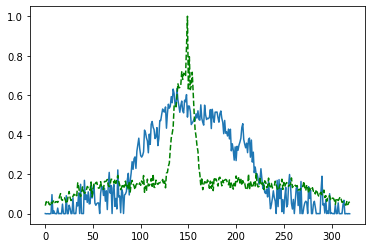

Time taken for epoch:  151.7899661064148
Epoch = [ 76/3000]  Iter = [   0/39480]  Loss = 0.1883 Avg Loss = 0.1883  Time = 0.0777s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 76/3000]  Iter = [ 100/39480]  Loss = 0.2551 Avg Loss = 0.2056  Time = 0.0036s
Epoch = [ 76/3000]  Iter = [ 200/39480]  Loss = 0.2434 Avg Loss = 0.2155  Time = 0.0036s
Epoch = [ 76/3000]  Iter = [ 300/39480]  Loss = 0.2497 Avg Loss = 0.2177  Time = 0.0036s
Epoch = [ 76/3000]  Iter = [ 400/39480]  Loss = 0.222 Avg Loss = 0.221  Time = 0.0031s
Epoch = [ 76/3000]  Iter = [ 500/39480]  Loss = 0.1998 Avg Loss = 0.2198  Time = 0.0029s
Epoch = [ 76/3000]  Iter = [ 600/39480]  Loss = 0.2012 Avg Loss = 0.2172  Time = 0.0029s
Epoch = [ 76/3000]  Iter = [ 700/39480]  Loss = 0.2482 Avg Loss = 0.2135  Time = 0.0029s
Epoch = [ 76/3000]  Iter = [ 800/39480]  Loss = 0.2213 Avg Loss = 0.2195  Time = 0.0029s
Epoch = [ 76/3000]  Iter = [ 900/39480]  Loss = 0.2251 Avg Loss = 0.2159  Time = 0.0029s
Epoch = [ 76/3000]  Iter = [1000/39480]  Loss = 0.2308 Avg Loss = 0.2208  Time = 0.0034s
Epoch = [ 76/3000]  Iter = [1100/39480]  Loss = 0.2647 Avg Loss = 0.2234  Time = 0.0035s
Epoch = [ 76/3000]  Ite

Epoch = [ 76/3000]  Iter = [9400/39480]  Loss = 0.2289 Avg Loss = 0.22  Time = 0.0036s
Epoch = [ 76/3000]  Iter = [9500/39480]  Loss = 0.2254 Avg Loss = 0.2204  Time = 0.0035s
Epoch = [ 76/3000]  Iter = [9600/39480]  Loss = 0.223 Avg Loss = 0.2189  Time = 0.0035s
Epoch = [ 76/3000]  Iter = [9700/39480]  Loss = 0.2355 Avg Loss = 0.2189  Time = 0.0035s
Epoch = [ 76/3000]  Iter = [9800/39480]  Loss = 0.196 Avg Loss = 0.2172  Time = 0.0035s
Epoch = [ 76/3000]  Iter = [9900/39480]  Loss = 0.214 Avg Loss = 0.2161  Time = 0.0035s
Epoch = [ 76/3000]  Iter = [10000/39480]  Loss = 0.2814 Avg Loss = 0.2158  Time = 0.0035s
Epoch = [ 76/3000]  Iter = [10100/39480]  Loss = 0.2259 Avg Loss = 0.2145  Time = 0.0035s
Epoch = [ 76/3000]  Iter = [10200/39480]  Loss = 0.2347 Avg Loss = 0.2175  Time = 0.0035s
Epoch = [ 76/3000]  Iter = [10300/39480]  Loss = 0.199 Avg Loss = 0.2158  Time = 0.0035s
Epoch = [ 76/3000]  Iter = [10400/39480]  Loss = 0.2439 Avg Loss = 0.2158  Time = 0.0031s
Epoch = [ 76/3000]  It

Epoch = [ 76/3000]  Iter = [18600/39480]  Loss = 0.2304 Avg Loss = 0.2198  Time = 0.0036s
Epoch = [ 76/3000]  Iter = [18700/39480]  Loss = 0.2496 Avg Loss = 0.2196  Time = 0.0035s
Epoch = [ 76/3000]  Iter = [18800/39480]  Loss = 0.1969 Avg Loss = 0.2187  Time = 0.0036s
Epoch = [ 76/3000]  Iter = [18900/39480]  Loss = 0.253 Avg Loss = 0.2216  Time = 0.0036s
Epoch = [ 76/3000]  Iter = [19000/39480]  Loss = 0.2734 Avg Loss = 0.2208  Time = 0.0034s
Epoch = [ 76/3000]  Iter = [19100/39480]  Loss = 0.181 Avg Loss = 0.2152  Time = 0.0034s
Epoch = [ 76/3000]  Iter = [19200/39480]  Loss = 0.1892 Avg Loss = 0.2158  Time = 0.0035s
Epoch = [ 76/3000]  Iter = [19300/39480]  Loss = 0.2166 Avg Loss = 0.215  Time = 0.0035s
Epoch = [ 76/3000]  Iter = [19400/39480]  Loss = 0.1903 Avg Loss = 0.2174  Time = 0.0035s
Epoch = [ 76/3000]  Iter = [19500/39480]  Loss = 0.2217 Avg Loss = 0.2179  Time = 0.0036s
Epoch = [ 76/3000]  Iter = [19600/39480]  Loss = 0.2252 Avg Loss = 0.2167  Time = 0.0035s
Epoch = [ 76/

Epoch = [ 76/3000]  Iter = [27800/39480]  Loss = 0.2218 Avg Loss = 0.2176  Time = 0.0032s
Epoch = [ 76/3000]  Iter = [27900/39480]  Loss = 0.2008 Avg Loss = 0.2172  Time = 0.0034s
Epoch = [ 76/3000]  Iter = [28000/39480]  Loss = 0.2197 Avg Loss = 0.2177  Time = 0.0033s
Epoch = [ 76/3000]  Iter = [28100/39480]  Loss = 0.2258 Avg Loss = 0.2169  Time = 0.0033s
Epoch = [ 76/3000]  Iter = [28200/39480]  Loss = 0.2025 Avg Loss = 0.2158  Time = 0.0033s
Epoch = [ 76/3000]  Iter = [28300/39480]  Loss = 0.205 Avg Loss = 0.2187  Time = 0.0026s
Epoch = [ 76/3000]  Iter = [28400/39480]  Loss = 0.1888 Avg Loss = 0.2175  Time = 0.0034s
Epoch = [ 76/3000]  Iter = [28500/39480]  Loss = 0.2171 Avg Loss = 0.2158  Time = 0.0033s
Epoch = [ 76/3000]  Iter = [28600/39480]  Loss = 0.246 Avg Loss = 0.2227  Time = 0.0035s
Epoch = [ 76/3000]  Iter = [28700/39480]  Loss = 0.1981 Avg Loss = 0.2205  Time = 0.0034s
Epoch = [ 76/3000]  Iter = [28800/39480]  Loss = 0.2225 Avg Loss = 0.2196  Time = 0.0034s
Epoch = [ 76

Epoch = [ 76/3000]  Iter = [37000/39480]  Loss = 0.2322 Avg Loss = 0.2223  Time = 0.0036s
Epoch = [ 76/3000]  Iter = [37100/39480]  Loss = 0.2303 Avg Loss = 0.2169  Time = 0.0036s
Epoch = [ 76/3000]  Iter = [37200/39480]  Loss = 0.2132 Avg Loss = 0.215  Time = 0.0036s
Epoch = [ 76/3000]  Iter = [37300/39480]  Loss = 0.2264 Avg Loss = 0.2164  Time = 0.0036s
Epoch = [ 76/3000]  Iter = [37400/39480]  Loss = 0.2024 Avg Loss = 0.2187  Time = 0.0035s
Epoch = [ 76/3000]  Iter = [37500/39480]  Loss = 0.2012 Avg Loss = 0.2189  Time = 0.0035s
Epoch = [ 76/3000]  Iter = [37600/39480]  Loss = 0.2122 Avg Loss = 0.2167  Time = 0.0036s
Epoch = [ 76/3000]  Iter = [37700/39480]  Loss = 0.22 Avg Loss = 0.2204  Time = 0.0032s
Epoch = [ 76/3000]  Iter = [37800/39480]  Loss = 0.2069 Avg Loss = 0.2172  Time = 0.0036s
Epoch = [ 76/3000]  Iter = [37900/39480]  Loss = 0.195 Avg Loss = 0.2156  Time = 0.0036s
Epoch = [ 76/3000]  Iter = [38000/39480]  Loss = 0.2283 Avg Loss = 0.2188  Time = 0.0036s
Epoch = [ 76/3

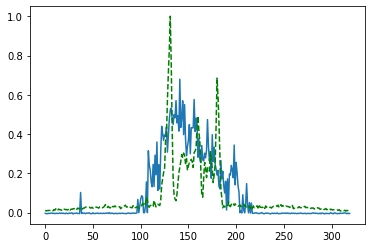

Time taken for epoch:  151.49648523330688
Epoch = [ 77/3000]  Iter = [   0/39480]  Loss = 0.2031 Avg Loss = 0.2031  Time = 0.0701s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 77/3000]  Iter = [ 100/39480]  Loss = 0.2251 Avg Loss = 0.2106  Time = 0.0030s
Epoch = [ 77/3000]  Iter = [ 200/39480]  Loss = 0.2263 Avg Loss = 0.2202  Time = 0.0036s
Epoch = [ 77/3000]  Iter = [ 300/39480]  Loss = 0.2282 Avg Loss = 0.2208  Time = 0.0036s
Epoch = [ 77/3000]  Iter = [ 400/39480]  Loss = 0.2083 Avg Loss = 0.2193  Time = 0.0036s
Epoch = [ 77/3000]  Iter = [ 500/39480]  Loss = 0.2153 Avg Loss = 0.2183  Time = 0.0034s
Epoch = [ 77/3000]  Iter = [ 600/39480]  Loss = 0.2494 Avg Loss = 0.2207  Time = 0.0036s
Epoch = [ 77/3000]  Iter = [ 700/39480]  Loss = 0.2287 Avg Loss = 0.2162  Time = 0.0036s
Epoch = [ 77/3000]  Iter = [ 800/39480]  Loss = 0.2101 Avg Loss = 0.2192  Time = 0.0034s
Epoch = [ 77/3000]  Iter = [ 900/39480]  Loss = 0.1982 Avg Loss = 0.2179  Time = 0.0036s
Epoch = [ 77/3000]  Iter = [1000/39480]  Loss = 0.2168 Avg Loss = 0.219  Time = 0.0036s
Epoch = [ 77/3000]  Iter = [1100/39480]  Loss = 0.2224 Avg Loss = 0.2231  Time = 0.0035s
Epoch = [ 77/3000]  It

Epoch = [ 77/3000]  Iter = [9400/39480]  Loss = 0.1932 Avg Loss = 0.2245  Time = 0.0034s
Epoch = [ 77/3000]  Iter = [9500/39480]  Loss = 0.2076 Avg Loss = 0.2181  Time = 0.0035s
Epoch = [ 77/3000]  Iter = [9600/39480]  Loss = 0.197 Avg Loss = 0.2204  Time = 0.0036s
Epoch = [ 77/3000]  Iter = [9700/39480]  Loss = 0.2688 Avg Loss = 0.2169  Time = 0.0036s
Epoch = [ 77/3000]  Iter = [9800/39480]  Loss = 0.2117 Avg Loss = 0.2145  Time = 0.0035s
Epoch = [ 77/3000]  Iter = [9900/39480]  Loss = 0.2173 Avg Loss = 0.217  Time = 0.0035s
Epoch = [ 77/3000]  Iter = [10000/39480]  Loss = 0.2148 Avg Loss = 0.22  Time = 0.0036s
Epoch = [ 77/3000]  Iter = [10100/39480]  Loss = 0.2106 Avg Loss = 0.2197  Time = 0.0034s
Epoch = [ 77/3000]  Iter = [10200/39480]  Loss = 0.1999 Avg Loss = 0.2201  Time = 0.0034s
Epoch = [ 77/3000]  Iter = [10300/39480]  Loss = 0.2145 Avg Loss = 0.2184  Time = 0.0034s
Epoch = [ 77/3000]  Iter = [10400/39480]  Loss = 0.2319 Avg Loss = 0.2219  Time = 0.0034s
Epoch = [ 77/3000]  

Epoch = [ 77/3000]  Iter = [18600/39480]  Loss = 0.2062 Avg Loss = 0.2184  Time = 0.0034s
Epoch = [ 77/3000]  Iter = [18700/39480]  Loss = 0.2529 Avg Loss = 0.2181  Time = 0.0036s
Epoch = [ 77/3000]  Iter = [18800/39480]  Loss = 0.2025 Avg Loss = 0.2127  Time = 0.0035s
Epoch = [ 77/3000]  Iter = [18900/39480]  Loss = 0.2334 Avg Loss = 0.2172  Time = 0.0036s
Epoch = [ 77/3000]  Iter = [19000/39480]  Loss = 0.207 Avg Loss = 0.2236  Time = 0.0032s
Epoch = [ 77/3000]  Iter = [19100/39480]  Loss = 0.214 Avg Loss = 0.2183  Time = 0.0031s
Epoch = [ 77/3000]  Iter = [19200/39480]  Loss = 0.242 Avg Loss = 0.2144  Time = 0.0035s
Epoch = [ 77/3000]  Iter = [19300/39480]  Loss = 0.2478 Avg Loss = 0.2192  Time = 0.0036s
Epoch = [ 77/3000]  Iter = [19400/39480]  Loss = 0.2202 Avg Loss = 0.2192  Time = 0.0035s
Epoch = [ 77/3000]  Iter = [19500/39480]  Loss = 0.2455 Avg Loss = 0.2245  Time = 0.0036s
Epoch = [ 77/3000]  Iter = [19600/39480]  Loss = 0.2188 Avg Loss = 0.2172  Time = 0.0035s
Epoch = [ 77/

Epoch = [ 77/3000]  Iter = [27800/39480]  Loss = 0.2345 Avg Loss = 0.2199  Time = 0.0036s
Epoch = [ 77/3000]  Iter = [27900/39480]  Loss = 0.2316 Avg Loss = 0.2177  Time = 0.0036s
Epoch = [ 77/3000]  Iter = [28000/39480]  Loss = 0.2118 Avg Loss = 0.2162  Time = 0.0036s
Epoch = [ 77/3000]  Iter = [28100/39480]  Loss = 0.2335 Avg Loss = 0.2186  Time = 0.0036s
Epoch = [ 77/3000]  Iter = [28200/39480]  Loss = 0.2028 Avg Loss = 0.2184  Time = 0.0036s
Epoch = [ 77/3000]  Iter = [28300/39480]  Loss = 0.2379 Avg Loss = 0.2179  Time = 0.0035s
Epoch = [ 77/3000]  Iter = [28400/39480]  Loss = 0.1951 Avg Loss = 0.2195  Time = 0.0035s
Epoch = [ 77/3000]  Iter = [28500/39480]  Loss = 0.213 Avg Loss = 0.2164  Time = 0.0032s
Epoch = [ 77/3000]  Iter = [28600/39480]  Loss = 0.224 Avg Loss = 0.2197  Time = 0.0036s
Epoch = [ 77/3000]  Iter = [28700/39480]  Loss = 0.2247 Avg Loss = 0.2174  Time = 0.0035s
Epoch = [ 77/3000]  Iter = [28800/39480]  Loss = 0.2307 Avg Loss = 0.2217  Time = 0.0032s
Epoch = [ 77

Epoch = [ 77/3000]  Iter = [37000/39480]  Loss = 0.2141 Avg Loss = 0.2169  Time = 0.0035s
Epoch = [ 77/3000]  Iter = [37100/39480]  Loss = 0.2284 Avg Loss = 0.2186  Time = 0.0035s
Epoch = [ 77/3000]  Iter = [37200/39480]  Loss = 0.2359 Avg Loss = 0.2159  Time = 0.0031s
Epoch = [ 77/3000]  Iter = [37300/39480]  Loss = 0.2113 Avg Loss = 0.2172  Time = 0.0033s
Epoch = [ 77/3000]  Iter = [37400/39480]  Loss = 0.2349 Avg Loss = 0.2195  Time = 0.0035s
Epoch = [ 77/3000]  Iter = [37500/39480]  Loss = 0.2067 Avg Loss = 0.2152  Time = 0.0035s
Epoch = [ 77/3000]  Iter = [37600/39480]  Loss = 0.1855 Avg Loss = 0.2181  Time = 0.0035s
Epoch = [ 77/3000]  Iter = [37700/39480]  Loss = 0.2203 Avg Loss = 0.2185  Time = 0.0036s
Epoch = [ 77/3000]  Iter = [37800/39480]  Loss = 0.2057 Avg Loss = 0.2177  Time = 0.0036s
Epoch = [ 77/3000]  Iter = [37900/39480]  Loss = 0.2149 Avg Loss = 0.2209  Time = 0.0035s
Epoch = [ 77/3000]  Iter = [38000/39480]  Loss = 0.236 Avg Loss = 0.2165  Time = 0.0035s
Epoch = [ 7

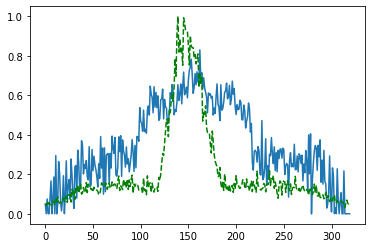

Time taken for epoch:  153.64293384552002
Epoch = [ 78/3000]  Iter = [   0/39480]  Loss = 0.2053 Avg Loss = 0.2053  Time = 0.0709s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 78/3000]  Iter = [ 100/39480]  Loss = 0.2615 Avg Loss = 0.2093  Time = 0.0035s
Epoch = [ 78/3000]  Iter = [ 200/39480]  Loss = 0.1834 Avg Loss = 0.2116  Time = 0.0036s
Epoch = [ 78/3000]  Iter = [ 300/39480]  Loss = 0.2082 Avg Loss = 0.2138  Time = 0.0035s
Epoch = [ 78/3000]  Iter = [ 400/39480]  Loss = 0.2273 Avg Loss = 0.2171  Time = 0.0036s
Epoch = [ 78/3000]  Iter = [ 500/39480]  Loss = 0.2339 Avg Loss = 0.2195  Time = 0.0035s
Epoch = [ 78/3000]  Iter = [ 600/39480]  Loss = 0.2452 Avg Loss = 0.2225  Time = 0.0036s
Epoch = [ 78/3000]  Iter = [ 700/39480]  Loss = 0.2329 Avg Loss = 0.2188  Time = 0.0035s
Epoch = [ 78/3000]  Iter = [ 800/39480]  Loss = 0.1936 Avg Loss = 0.2173  Time = 0.0036s
Epoch = [ 78/3000]  Iter = [ 900/39480]  Loss = 0.2213 Avg Loss = 0.2177  Time = 0.0035s
Epoch = [ 78/3000]  Iter = [1000/39480]  Loss = 0.2489 Avg Loss = 0.2198  Time = 0.0035s
Epoch = [ 78/3000]  Iter = [1100/39480]  Loss = 0.2385 Avg Loss = 0.2178  Time = 0.0036s
Epoch = [ 78/3000]  I

Epoch = [ 78/3000]  Iter = [9400/39480]  Loss = 0.2151 Avg Loss = 0.2205  Time = 0.0032s
Epoch = [ 78/3000]  Iter = [9500/39480]  Loss = 0.2301 Avg Loss = 0.2132  Time = 0.0035s
Epoch = [ 78/3000]  Iter = [9600/39480]  Loss = 0.239 Avg Loss = 0.2162  Time = 0.0036s
Epoch = [ 78/3000]  Iter = [9700/39480]  Loss = 0.2044 Avg Loss = 0.2198  Time = 0.0036s
Epoch = [ 78/3000]  Iter = [9800/39480]  Loss = 0.216 Avg Loss = 0.2234  Time = 0.0036s
Epoch = [ 78/3000]  Iter = [9900/39480]  Loss = 0.2037 Avg Loss = 0.223  Time = 0.0033s
Epoch = [ 78/3000]  Iter = [10000/39480]  Loss = 0.2101 Avg Loss = 0.2224  Time = 0.0035s
Epoch = [ 78/3000]  Iter = [10100/39480]  Loss = 0.2606 Avg Loss = 0.2176  Time = 0.0034s
Epoch = [ 78/3000]  Iter = [10200/39480]  Loss = 0.222 Avg Loss = 0.218  Time = 0.0032s
Epoch = [ 78/3000]  Iter = [10300/39480]  Loss = 0.2112 Avg Loss = 0.2214  Time = 0.0035s
Epoch = [ 78/3000]  Iter = [10400/39480]  Loss = 0.2279 Avg Loss = 0.2154  Time = 0.0031s
Epoch = [ 78/3000]  I

Epoch = [ 78/3000]  Iter = [18600/39480]  Loss = 0.1602 Avg Loss = 0.2143  Time = 0.0036s
Epoch = [ 78/3000]  Iter = [18700/39480]  Loss = 0.2687 Avg Loss = 0.2185  Time = 0.0036s
Epoch = [ 78/3000]  Iter = [18800/39480]  Loss = 0.1835 Avg Loss = 0.217  Time = 0.0036s
Epoch = [ 78/3000]  Iter = [18900/39480]  Loss = 0.1991 Avg Loss = 0.2166  Time = 0.0036s
Epoch = [ 78/3000]  Iter = [19000/39480]  Loss = 0.2144 Avg Loss = 0.2155  Time = 0.0036s
Epoch = [ 78/3000]  Iter = [19100/39480]  Loss = 0.223 Avg Loss = 0.2147  Time = 0.0035s
Epoch = [ 78/3000]  Iter = [19200/39480]  Loss = 0.2166 Avg Loss = 0.2144  Time = 0.0036s
Epoch = [ 78/3000]  Iter = [19300/39480]  Loss = 0.2356 Avg Loss = 0.221  Time = 0.0035s
Epoch = [ 78/3000]  Iter = [19400/39480]  Loss = 0.2252 Avg Loss = 0.2177  Time = 0.0034s
Epoch = [ 78/3000]  Iter = [19500/39480]  Loss = 0.255 Avg Loss = 0.2231  Time = 0.0035s
Epoch = [ 78/3000]  Iter = [19600/39480]  Loss = 0.2011 Avg Loss = 0.2196  Time = 0.0036s
Epoch = [ 78/3

Epoch = [ 78/3000]  Iter = [27800/39480]  Loss = 0.2085 Avg Loss = 0.2197  Time = 0.0035s
Epoch = [ 78/3000]  Iter = [27900/39480]  Loss = 0.1948 Avg Loss = 0.2162  Time = 0.0036s
Epoch = [ 78/3000]  Iter = [28000/39480]  Loss = 0.1885 Avg Loss = 0.2178  Time = 0.0036s
Epoch = [ 78/3000]  Iter = [28100/39480]  Loss = 0.2003 Avg Loss = 0.2218  Time = 0.0036s
Epoch = [ 78/3000]  Iter = [28200/39480]  Loss = 0.1876 Avg Loss = 0.217  Time = 0.0035s
Epoch = [ 78/3000]  Iter = [28300/39480]  Loss = 0.2153 Avg Loss = 0.2183  Time = 0.0035s
Epoch = [ 78/3000]  Iter = [28400/39480]  Loss = 0.2211 Avg Loss = 0.2172  Time = 0.0032s
Epoch = [ 78/3000]  Iter = [28500/39480]  Loss = 0.2134 Avg Loss = 0.2163  Time = 0.0035s
Epoch = [ 78/3000]  Iter = [28600/39480]  Loss = 0.219 Avg Loss = 0.2198  Time = 0.0035s
Epoch = [ 78/3000]  Iter = [28700/39480]  Loss = 0.2305 Avg Loss = 0.2229  Time = 0.0035s
Epoch = [ 78/3000]  Iter = [28800/39480]  Loss = 0.2021 Avg Loss = 0.2209  Time = 0.0036s
Epoch = [ 78

Epoch = [ 78/3000]  Iter = [37000/39480]  Loss = 0.2054 Avg Loss = 0.2211  Time = 0.0036s
Epoch = [ 78/3000]  Iter = [37100/39480]  Loss = 0.2246 Avg Loss = 0.2194  Time = 0.0035s
Epoch = [ 78/3000]  Iter = [37200/39480]  Loss = 0.2165 Avg Loss = 0.2217  Time = 0.0035s
Epoch = [ 78/3000]  Iter = [37300/39480]  Loss = 0.2292 Avg Loss = 0.2245  Time = 0.0036s
Epoch = [ 78/3000]  Iter = [37400/39480]  Loss = 0.2347 Avg Loss = 0.2202  Time = 0.0035s
Epoch = [ 78/3000]  Iter = [37500/39480]  Loss = 0.2301 Avg Loss = 0.2177  Time = 0.0034s
Epoch = [ 78/3000]  Iter = [37600/39480]  Loss = 0.288 Avg Loss = 0.2197  Time = 0.0034s
Epoch = [ 78/3000]  Iter = [37700/39480]  Loss = 0.2001 Avg Loss = 0.2193  Time = 0.0036s
Epoch = [ 78/3000]  Iter = [37800/39480]  Loss = 0.2114 Avg Loss = 0.2136  Time = 0.0035s
Epoch = [ 78/3000]  Iter = [37900/39480]  Loss = 0.1989 Avg Loss = 0.2202  Time = 0.0035s
Epoch = [ 78/3000]  Iter = [38000/39480]  Loss = 0.2059 Avg Loss = 0.2239  Time = 0.0032s
Epoch = [ 7

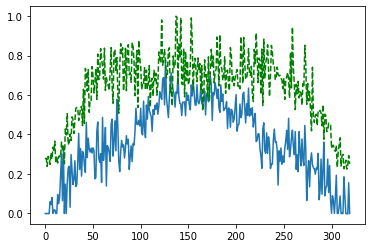

Time taken for epoch:  153.06366515159607
Epoch = [ 79/3000]  Iter = [   0/39480]  Loss = 0.1992 Avg Loss = 0.1992  Time = 0.0738s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch = [ 94/3000]  Iter = [38300/39480]  Loss = 0.23 Avg Loss = 0.2177  Time = 0.0034s
Epoch = [ 94/3000]  Iter = [38400/39480]  Loss = 0.2175 Avg Loss = 0.2162  Time = 0.0035s
Epoch = [ 94/3000]  Iter = [38500/39480]  Loss = 0.1704 Avg Loss = 0.2172  Time = 0.0035s
Epoch = [ 94/3000]  Iter = [38600/39480]  Loss = 0.203 Avg Loss = 0.2177  Time = 0.0036s
Epoch = [ 94/3000]  Iter = [38700/39480]  Loss = 0.211 Avg Loss = 0.2196  Time = 0.0035s
Epoch = [ 94/3000]  Iter = [38800/39480]  Loss = 0.1918 Avg Loss = 0.2208  Time = 0.0035s
Epoch = [ 94/3000]  Iter = [38900/39480]  Loss = 0.2032 Avg Loss = 0.2176  Time = 0.0036s
Epoch = [ 94/3000]  Iter = [39000/39480]  Loss = 0.2132 Avg Loss = 0.2213  Time = 0.0035s
Epoch = [ 94/3000]  Iter = [39100/39480]  Loss = 0.1973 Avg Loss = 0.2188  Time = 0.0035s
Epoch = [ 94/3000]  Iter = [39200/39480]  Loss = 0.21 Avg Loss = 0.2215  Time = 0.0035s
Epoch = [ 94/3000]  Iter = [39300/39480]  Loss = 0.2223 Avg Loss = 0.2173  Time = 0.0034s
Epoch = [ 94/300

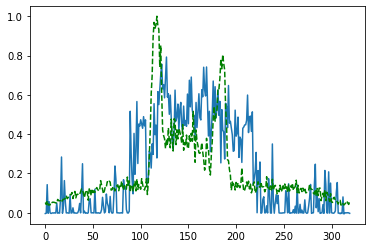

Time taken for epoch:  153.96648168563843
Epoch = [ 95/3000]  Iter = [   0/39480]  Loss = 0.1924 Avg Loss = 0.1924  Time = 0.1019s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 95/3000]  Iter = [ 100/39480]  Loss = 0.2309 Avg Loss = 0.2102  Time = 0.0037s
Epoch = [ 95/3000]  Iter = [ 200/39480]  Loss = 0.2312 Avg Loss = 0.2135  Time = 0.0037s
Epoch = [ 95/3000]  Iter = [ 300/39480]  Loss = 0.2237 Avg Loss = 0.2163  Time = 0.0036s
Epoch = [ 95/3000]  Iter = [ 400/39480]  Loss = 0.2333 Avg Loss = 0.2209  Time = 0.0037s
Epoch = [ 95/3000]  Iter = [ 500/39480]  Loss = 0.2613 Avg Loss = 0.2204  Time = 0.0032s
Epoch = [ 95/3000]  Iter = [ 600/39480]  Loss = 0.2032 Avg Loss = 0.2208  Time = 0.0032s
Epoch = [ 95/3000]  Iter = [ 700/39480]  Loss = 0.2292 Avg Loss = 0.2159  Time = 0.0030s
Epoch = [ 95/3000]  Iter = [ 800/39480]  Loss = 0.202 Avg Loss = 0.2139  Time = 0.0029s
Epoch = [ 95/3000]  Iter = [ 900/39480]  Loss = 0.2118 Avg Loss = 0.2168  Time = 0.0030s
Epoch = [ 95/3000]  Iter = [1000/39480]  Loss = 0.2317 Avg Loss = 0.218  Time = 0.0029s
Epoch = [ 95/3000]  Iter = [1100/39480]  Loss = 0.2307 Avg Loss = 0.2232  Time = 0.0031s
Epoch = [ 95/3000]  Ite

Epoch = [ 95/3000]  Iter = [9400/39480]  Loss = 0.241 Avg Loss = 0.219  Time = 0.0035s
Epoch = [ 95/3000]  Iter = [9500/39480]  Loss = 0.2373 Avg Loss = 0.2203  Time = 0.0032s
Epoch = [ 95/3000]  Iter = [9600/39480]  Loss = 0.2229 Avg Loss = 0.2194  Time = 0.0037s
Epoch = [ 95/3000]  Iter = [9700/39480]  Loss = 0.175 Avg Loss = 0.2197  Time = 0.0036s
Epoch = [ 95/3000]  Iter = [9800/39480]  Loss = 0.2486 Avg Loss = 0.2167  Time = 0.0036s
Epoch = [ 95/3000]  Iter = [9900/39480]  Loss = 0.2226 Avg Loss = 0.2205  Time = 0.0036s
Epoch = [ 95/3000]  Iter = [10000/39480]  Loss = 0.1992 Avg Loss = 0.2189  Time = 0.0032s
Epoch = [ 95/3000]  Iter = [10100/39480]  Loss = 0.2042 Avg Loss = 0.2197  Time = 0.0036s
Epoch = [ 95/3000]  Iter = [10200/39480]  Loss = 0.2207 Avg Loss = 0.2206  Time = 0.0036s
Epoch = [ 95/3000]  Iter = [10300/39480]  Loss = 0.2068 Avg Loss = 0.2188  Time = 0.0036s
Epoch = [ 95/3000]  Iter = [10400/39480]  Loss = 0.1968 Avg Loss = 0.2199  Time = 0.0033s
Epoch = [ 95/3000] 

Epoch = [ 95/3000]  Iter = [18600/39480]  Loss = 0.2146 Avg Loss = 0.2168  Time = 0.0036s
Epoch = [ 95/3000]  Iter = [18700/39480]  Loss = 0.2193 Avg Loss = 0.2158  Time = 0.0037s
Epoch = [ 95/3000]  Iter = [18800/39480]  Loss = 0.1771 Avg Loss = 0.2166  Time = 0.0036s
Epoch = [ 95/3000]  Iter = [18900/39480]  Loss = 0.2684 Avg Loss = 0.2195  Time = 0.0037s
Epoch = [ 95/3000]  Iter = [19000/39480]  Loss = 0.2135 Avg Loss = 0.2158  Time = 0.0036s
Epoch = [ 95/3000]  Iter = [19100/39480]  Loss = 0.2567 Avg Loss = 0.223  Time = 0.0034s
Epoch = [ 95/3000]  Iter = [19200/39480]  Loss = 0.2563 Avg Loss = 0.2205  Time = 0.0035s
Epoch = [ 95/3000]  Iter = [19300/39480]  Loss = 0.2014 Avg Loss = 0.2192  Time = 0.0037s
Epoch = [ 95/3000]  Iter = [19400/39480]  Loss = 0.2152 Avg Loss = 0.2189  Time = 0.0036s
Epoch = [ 95/3000]  Iter = [19500/39480]  Loss = 0.2088 Avg Loss = 0.2179  Time = 0.0036s
Epoch = [ 95/3000]  Iter = [19600/39480]  Loss = 0.2 Avg Loss = 0.2191  Time = 0.0035s
Epoch = [ 95/3

Epoch = [ 95/3000]  Iter = [27800/39480]  Loss = 0.245 Avg Loss = 0.224  Time = 0.0035s
Epoch = [ 95/3000]  Iter = [27900/39480]  Loss = 0.1723 Avg Loss = 0.2168  Time = 0.0036s
Epoch = [ 95/3000]  Iter = [28000/39480]  Loss = 0.2039 Avg Loss = 0.2139  Time = 0.0035s
Epoch = [ 95/3000]  Iter = [28100/39480]  Loss = 0.2047 Avg Loss = 0.2179  Time = 0.0036s
Epoch = [ 95/3000]  Iter = [28200/39480]  Loss = 0.269 Avg Loss = 0.2177  Time = 0.0036s
Epoch = [ 95/3000]  Iter = [28300/39480]  Loss = 0.1993 Avg Loss = 0.2154  Time = 0.0035s
Epoch = [ 95/3000]  Iter = [28400/39480]  Loss = 0.1956 Avg Loss = 0.2183  Time = 0.0035s
Epoch = [ 95/3000]  Iter = [28500/39480]  Loss = 0.2142 Avg Loss = 0.2195  Time = 0.0034s
Epoch = [ 95/3000]  Iter = [28600/39480]  Loss = 0.2613 Avg Loss = 0.2176  Time = 0.0034s
Epoch = [ 95/3000]  Iter = [28700/39480]  Loss = 0.2655 Avg Loss = 0.2203  Time = 0.0035s
Epoch = [ 95/3000]  Iter = [28800/39480]  Loss = 0.2366 Avg Loss = 0.2199  Time = 0.0035s
Epoch = [ 95/

Epoch = [ 95/3000]  Iter = [37000/39480]  Loss = 0.2105 Avg Loss = 0.2152  Time = 0.0036s
Epoch = [ 95/3000]  Iter = [37100/39480]  Loss = 0.2461 Avg Loss = 0.2163  Time = 0.0036s
Epoch = [ 95/3000]  Iter = [37200/39480]  Loss = 0.2457 Avg Loss = 0.2191  Time = 0.0037s
Epoch = [ 95/3000]  Iter = [37300/39480]  Loss = 0.2281 Avg Loss = 0.22  Time = 0.0036s
Epoch = [ 95/3000]  Iter = [37400/39480]  Loss = 0.2184 Avg Loss = 0.2225  Time = 0.0035s
Epoch = [ 95/3000]  Iter = [37500/39480]  Loss = 0.2303 Avg Loss = 0.2179  Time = 0.0032s
Epoch = [ 95/3000]  Iter = [37600/39480]  Loss = 0.2007 Avg Loss = 0.2152  Time = 0.0035s
Epoch = [ 95/3000]  Iter = [37700/39480]  Loss = 0.221 Avg Loss = 0.2201  Time = 0.0035s
Epoch = [ 95/3000]  Iter = [37800/39480]  Loss = 0.1803 Avg Loss = 0.2201  Time = 0.0035s
Epoch = [ 95/3000]  Iter = [37900/39480]  Loss = 0.206 Avg Loss = 0.2186  Time = 0.0035s
Epoch = [ 95/3000]  Iter = [38000/39480]  Loss = 0.193 Avg Loss = 0.2147  Time = 0.0035s
Epoch = [ 95/30

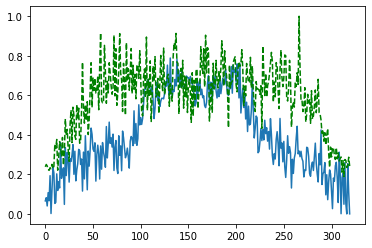

Time taken for epoch:  154.9413137435913
Epoch = [ 96/3000]  Iter = [   0/39480]  Loss = 0.2472 Avg Loss = 0.2472  Time = 0.0703s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 96/3000]  Iter = [ 100/39480]  Loss = 0.2222 Avg Loss = 0.2292  Time = 0.0035s
Epoch = [ 96/3000]  Iter = [ 200/39480]  Loss = 0.198 Avg Loss = 0.222  Time = 0.0036s
Epoch = [ 96/3000]  Iter = [ 300/39480]  Loss = 0.2235 Avg Loss = 0.2191  Time = 0.0036s
Epoch = [ 96/3000]  Iter = [ 400/39480]  Loss = 0.2269 Avg Loss = 0.2153  Time = 0.0036s
Epoch = [ 96/3000]  Iter = [ 500/39480]  Loss = 0.2002 Avg Loss = 0.2191  Time = 0.0035s
Epoch = [ 96/3000]  Iter = [ 600/39480]  Loss = 0.2175 Avg Loss = 0.2216  Time = 0.0036s
Epoch = [ 96/3000]  Iter = [ 700/39480]  Loss = 0.199 Avg Loss = 0.2226  Time = 0.0035s
Epoch = [ 96/3000]  Iter = [ 800/39480]  Loss = 0.2151 Avg Loss = 0.2179  Time = 0.0036s
Epoch = [ 96/3000]  Iter = [ 900/39480]  Loss = 0.2042 Avg Loss = 0.2147  Time = 0.0035s
Epoch = [ 96/3000]  Iter = [1000/39480]  Loss = 0.2327 Avg Loss = 0.2178  Time = 0.0029s
Epoch = [ 96/3000]  Iter = [1100/39480]  Loss = 0.212 Avg Loss = 0.2172  Time = 0.0029s
Epoch = [ 96/3000]  Iter 

Epoch = [ 96/3000]  Iter = [9400/39480]  Loss = 0.2196 Avg Loss = 0.2176  Time = 0.0036s
Epoch = [ 96/3000]  Iter = [9500/39480]  Loss = 0.2598 Avg Loss = 0.2201  Time = 0.0033s
Epoch = [ 96/3000]  Iter = [9600/39480]  Loss = 0.2198 Avg Loss = 0.2176  Time = 0.0035s
Epoch = [ 96/3000]  Iter = [9700/39480]  Loss = 0.235 Avg Loss = 0.2163  Time = 0.0036s
Epoch = [ 96/3000]  Iter = [9800/39480]  Loss = 0.2007 Avg Loss = 0.2211  Time = 0.0034s
Epoch = [ 96/3000]  Iter = [9900/39480]  Loss = 0.207 Avg Loss = 0.2174  Time = 0.0035s
Epoch = [ 96/3000]  Iter = [10000/39480]  Loss = 0.218 Avg Loss = 0.2157  Time = 0.0034s
Epoch = [ 96/3000]  Iter = [10100/39480]  Loss = 0.2351 Avg Loss = 0.2182  Time = 0.0035s
Epoch = [ 96/3000]  Iter = [10200/39480]  Loss = 0.2584 Avg Loss = 0.217  Time = 0.0035s
Epoch = [ 96/3000]  Iter = [10300/39480]  Loss = 0.1908 Avg Loss = 0.2158  Time = 0.0036s
Epoch = [ 96/3000]  Iter = [10400/39480]  Loss = 0.2288 Avg Loss = 0.2189  Time = 0.0035s
Epoch = [ 96/3000]  

Epoch = [ 96/3000]  Iter = [18600/39480]  Loss = 0.1969 Avg Loss = 0.2169  Time = 0.0035s
Epoch = [ 96/3000]  Iter = [18700/39480]  Loss = 0.2253 Avg Loss = 0.2172  Time = 0.0035s
Epoch = [ 96/3000]  Iter = [18800/39480]  Loss = 0.2112 Avg Loss = 0.2158  Time = 0.0036s
Epoch = [ 96/3000]  Iter = [18900/39480]  Loss = 0.2511 Avg Loss = 0.2162  Time = 0.0035s
Epoch = [ 96/3000]  Iter = [19000/39480]  Loss = 0.2271 Avg Loss = 0.2152  Time = 0.0035s
Epoch = [ 96/3000]  Iter = [19100/39480]  Loss = 0.2193 Avg Loss = 0.2167  Time = 0.0035s
Epoch = [ 96/3000]  Iter = [19200/39480]  Loss = 0.218 Avg Loss = 0.2144  Time = 0.0036s
Epoch = [ 96/3000]  Iter = [19300/39480]  Loss = 0.2445 Avg Loss = 0.2202  Time = 0.0035s
Epoch = [ 96/3000]  Iter = [19400/39480]  Loss = 0.2268 Avg Loss = 0.2196  Time = 0.0035s
Epoch = [ 96/3000]  Iter = [19500/39480]  Loss = 0.2108 Avg Loss = 0.2194  Time = 0.0033s
Epoch = [ 96/3000]  Iter = [19600/39480]  Loss = 0.209 Avg Loss = 0.2162  Time = 0.0032s
Epoch = [ 96

Epoch = [ 96/3000]  Iter = [27800/39480]  Loss = 0.2108 Avg Loss = 0.2199  Time = 0.0033s
Epoch = [ 96/3000]  Iter = [27900/39480]  Loss = 0.2336 Avg Loss = 0.2197  Time = 0.0035s
Epoch = [ 96/3000]  Iter = [28000/39480]  Loss = 0.22 Avg Loss = 0.2163  Time = 0.0036s
Epoch = [ 96/3000]  Iter = [28100/39480]  Loss = 0.2328 Avg Loss = 0.2158  Time = 0.0036s
Epoch = [ 96/3000]  Iter = [28200/39480]  Loss = 0.207 Avg Loss = 0.2156  Time = 0.0031s
Epoch = [ 96/3000]  Iter = [28300/39480]  Loss = 0.2354 Avg Loss = 0.2179  Time = 0.0035s
Epoch = [ 96/3000]  Iter = [28400/39480]  Loss = 0.2253 Avg Loss = 0.2181  Time = 0.0036s
Epoch = [ 96/3000]  Iter = [28500/39480]  Loss = 0.2312 Avg Loss = 0.22  Time = 0.0036s
Epoch = [ 96/3000]  Iter = [28600/39480]  Loss = 0.1982 Avg Loss = 0.2194  Time = 0.0036s
Epoch = [ 96/3000]  Iter = [28700/39480]  Loss = 0.2077 Avg Loss = 0.219  Time = 0.0036s
Epoch = [ 96/3000]  Iter = [28800/39480]  Loss = 0.2209 Avg Loss = 0.2206  Time = 0.0036s
Epoch = [ 96/300

Epoch = [ 96/3000]  Iter = [37000/39480]  Loss = 0.2339 Avg Loss = 0.2186  Time = 0.0031s
Epoch = [ 96/3000]  Iter = [37100/39480]  Loss = 0.2137 Avg Loss = 0.2196  Time = 0.0035s
Epoch = [ 96/3000]  Iter = [37200/39480]  Loss = 0.2278 Avg Loss = 0.2188  Time = 0.0035s
Epoch = [ 96/3000]  Iter = [37300/39480]  Loss = 0.237 Avg Loss = 0.2189  Time = 0.0034s
Epoch = [ 96/3000]  Iter = [37400/39480]  Loss = 0.1815 Avg Loss = 0.218  Time = 0.0035s
Epoch = [ 96/3000]  Iter = [37500/39480]  Loss = 0.2279 Avg Loss = 0.2172  Time = 0.0036s
Epoch = [ 96/3000]  Iter = [37600/39480]  Loss = 0.2086 Avg Loss = 0.2161  Time = 0.0045s
Epoch = [ 96/3000]  Iter = [37700/39480]  Loss = 0.2254 Avg Loss = 0.2163  Time = 0.0034s
Epoch = [ 96/3000]  Iter = [37800/39480]  Loss = 0.1853 Avg Loss = 0.2116  Time = 0.0033s
Epoch = [ 96/3000]  Iter = [37900/39480]  Loss = 0.2102 Avg Loss = 0.2146  Time = 0.0035s
Epoch = [ 96/3000]  Iter = [38000/39480]  Loss = 0.2206 Avg Loss = 0.2157  Time = 0.0032s
Epoch = [ 96

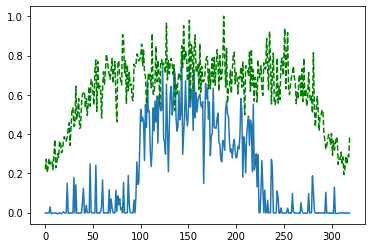

Time taken for epoch:  152.86663556098938
Epoch = [ 97/3000]  Iter = [   0/39480]  Loss = 0.1831 Avg Loss = 0.1831  Time = 0.0705s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 97/3000]  Iter = [ 100/39480]  Loss = 0.2188 Avg Loss = 0.2041  Time = 0.0034s
Epoch = [ 97/3000]  Iter = [ 200/39480]  Loss = 0.2226 Avg Loss = 0.2113  Time = 0.0037s
Epoch = [ 97/3000]  Iter = [ 300/39480]  Loss = 0.1862 Avg Loss = 0.216  Time = 0.0037s
Epoch = [ 97/3000]  Iter = [ 400/39480]  Loss = 0.205 Avg Loss = 0.2179  Time = 0.0037s
Epoch = [ 97/3000]  Iter = [ 500/39480]  Loss = 0.2215 Avg Loss = 0.2178  Time = 0.0036s
Epoch = [ 97/3000]  Iter = [ 600/39480]  Loss = 0.2079 Avg Loss = 0.2185  Time = 0.0036s
Epoch = [ 97/3000]  Iter = [ 700/39480]  Loss = 0.2442 Avg Loss = 0.2181  Time = 0.0034s
Epoch = [ 97/3000]  Iter = [ 800/39480]  Loss = 0.2064 Avg Loss = 0.2182  Time = 0.0036s
Epoch = [ 97/3000]  Iter = [ 900/39480]  Loss = 0.2001 Avg Loss = 0.2146  Time = 0.0036s
Epoch = [ 97/3000]  Iter = [1000/39480]  Loss = 0.2034 Avg Loss = 0.2132  Time = 0.0034s
Epoch = [ 97/3000]  Iter = [1100/39480]  Loss = 0.1801 Avg Loss = 0.2179  Time = 0.0035s
Epoch = [ 97/3000]  Ite

Epoch = [ 97/3000]  Iter = [9400/39480]  Loss = 0.2112 Avg Loss = 0.2174  Time = 0.0035s
Epoch = [ 97/3000]  Iter = [9500/39480]  Loss = 0.2169 Avg Loss = 0.219  Time = 0.0034s
Epoch = [ 97/3000]  Iter = [9600/39480]  Loss = 0.219 Avg Loss = 0.2175  Time = 0.0036s
Epoch = [ 97/3000]  Iter = [9700/39480]  Loss = 0.2214 Avg Loss = 0.2159  Time = 0.0031s
Epoch = [ 97/3000]  Iter = [9800/39480]  Loss = 0.1961 Avg Loss = 0.2184  Time = 0.0033s
Epoch = [ 97/3000]  Iter = [9900/39480]  Loss = 0.1967 Avg Loss = 0.2232  Time = 0.0035s
Epoch = [ 97/3000]  Iter = [10000/39480]  Loss = 0.2076 Avg Loss = 0.2162  Time = 0.0035s
Epoch = [ 97/3000]  Iter = [10100/39480]  Loss = 0.2241 Avg Loss = 0.2144  Time = 0.0035s
Epoch = [ 97/3000]  Iter = [10200/39480]  Loss = 0.1689 Avg Loss = 0.2135  Time = 0.0035s
Epoch = [ 97/3000]  Iter = [10300/39480]  Loss = 0.1827 Avg Loss = 0.2188  Time = 0.0035s
Epoch = [ 97/3000]  Iter = [10400/39480]  Loss = 0.1845 Avg Loss = 0.2156  Time = 0.0036s
Epoch = [ 97/3000]

Epoch = [ 97/3000]  Iter = [18600/39480]  Loss = 0.2045 Avg Loss = 0.2183  Time = 0.0034s
Epoch = [ 97/3000]  Iter = [18700/39480]  Loss = 0.2827 Avg Loss = 0.2215  Time = 0.0034s
Epoch = [ 97/3000]  Iter = [18800/39480]  Loss = 0.2198 Avg Loss = 0.2218  Time = 0.0036s
Epoch = [ 97/3000]  Iter = [18900/39480]  Loss = 0.1915 Avg Loss = 0.2191  Time = 0.0035s
Epoch = [ 97/3000]  Iter = [19000/39480]  Loss = 0.2128 Avg Loss = 0.2206  Time = 0.0036s
Epoch = [ 97/3000]  Iter = [19100/39480]  Loss = 0.1946 Avg Loss = 0.2182  Time = 0.0031s
Epoch = [ 97/3000]  Iter = [19200/39480]  Loss = 0.2211 Avg Loss = 0.2164  Time = 0.0035s
Epoch = [ 97/3000]  Iter = [19300/39480]  Loss = 0.2164 Avg Loss = 0.214  Time = 0.0034s
Epoch = [ 97/3000]  Iter = [19400/39480]  Loss = 0.2086 Avg Loss = 0.2191  Time = 0.0036s
Epoch = [ 97/3000]  Iter = [19500/39480]  Loss = 0.2101 Avg Loss = 0.2177  Time = 0.0036s
Epoch = [ 97/3000]  Iter = [19600/39480]  Loss = 0.2336 Avg Loss = 0.2152  Time = 0.0036s
Epoch = [ 9

Epoch = [ 97/3000]  Iter = [27800/39480]  Loss = 0.2382 Avg Loss = 0.2165  Time = 0.0033s
Epoch = [ 97/3000]  Iter = [27900/39480]  Loss = 0.2358 Avg Loss = 0.216  Time = 0.0033s
Epoch = [ 97/3000]  Iter = [28000/39480]  Loss = 0.2077 Avg Loss = 0.2163  Time = 0.0031s
Epoch = [ 97/3000]  Iter = [28100/39480]  Loss = 0.2119 Avg Loss = 0.2197  Time = 0.0035s
Epoch = [ 97/3000]  Iter = [28200/39480]  Loss = 0.2443 Avg Loss = 0.2205  Time = 0.0036s
Epoch = [ 97/3000]  Iter = [28300/39480]  Loss = 0.2251 Avg Loss = 0.2204  Time = 0.0036s
Epoch = [ 97/3000]  Iter = [28400/39480]  Loss = 0.2156 Avg Loss = 0.2209  Time = 0.0035s
Epoch = [ 97/3000]  Iter = [28500/39480]  Loss = 0.1903 Avg Loss = 0.2184  Time = 0.0035s
Epoch = [ 97/3000]  Iter = [28600/39480]  Loss = 0.1964 Avg Loss = 0.2175  Time = 0.0035s
Epoch = [ 97/3000]  Iter = [28700/39480]  Loss = 0.2216 Avg Loss = 0.2181  Time = 0.0035s
Epoch = [ 97/3000]  Iter = [28800/39480]  Loss = 0.1935 Avg Loss = 0.2161  Time = 0.0035s
Epoch = [ 9

Epoch = [ 97/3000]  Iter = [37000/39480]  Loss = 0.2287 Avg Loss = 0.2177  Time = 0.0035s
Epoch = [ 97/3000]  Iter = [37100/39480]  Loss = 0.2452 Avg Loss = 0.2206  Time = 0.0036s
Epoch = [ 97/3000]  Iter = [37200/39480]  Loss = 0.1802 Avg Loss = 0.2135  Time = 0.0035s
Epoch = [ 97/3000]  Iter = [37300/39480]  Loss = 0.2235 Avg Loss = 0.2175  Time = 0.0036s
Epoch = [ 97/3000]  Iter = [37400/39480]  Loss = 0.255 Avg Loss = 0.2246  Time = 0.0036s
Epoch = [ 97/3000]  Iter = [37500/39480]  Loss = 0.2268 Avg Loss = 0.2173  Time = 0.0034s
Epoch = [ 97/3000]  Iter = [37600/39480]  Loss = 0.2255 Avg Loss = 0.2149  Time = 0.0036s
Epoch = [ 97/3000]  Iter = [37700/39480]  Loss = 0.2108 Avg Loss = 0.2147  Time = 0.0036s
Epoch = [ 97/3000]  Iter = [37800/39480]  Loss = 0.1939 Avg Loss = 0.2204  Time = 0.0035s
Epoch = [ 97/3000]  Iter = [37900/39480]  Loss = 0.2147 Avg Loss = 0.2183  Time = 0.0036s
Epoch = [ 97/3000]  Iter = [38000/39480]  Loss = 0.2022 Avg Loss = 0.2167  Time = 0.0036s
Epoch = [ 9

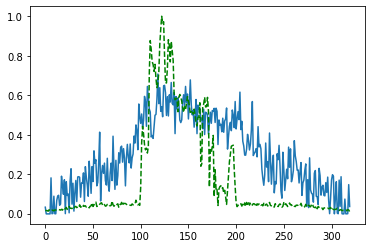

Time taken for epoch:  153.63268446922302
Epoch = [ 98/3000]  Iter = [   0/39480]  Loss = 0.2164 Avg Loss = 0.2164  Time = 0.0686s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 98/3000]  Iter = [ 100/39480]  Loss = 0.2213 Avg Loss = 0.222  Time = 0.0034s
Epoch = [ 98/3000]  Iter = [ 200/39480]  Loss = 0.202 Avg Loss = 0.2208  Time = 0.0035s
Epoch = [ 98/3000]  Iter = [ 300/39480]  Loss = 0.2022 Avg Loss = 0.2209  Time = 0.0036s
Epoch = [ 98/3000]  Iter = [ 400/39480]  Loss = 0.2327 Avg Loss = 0.2211  Time = 0.0034s
Epoch = [ 98/3000]  Iter = [ 500/39480]  Loss = 0.2456 Avg Loss = 0.2208  Time = 0.0035s
Epoch = [ 98/3000]  Iter = [ 600/39480]  Loss = 0.2252 Avg Loss = 0.2159  Time = 0.0036s
Epoch = [ 98/3000]  Iter = [ 700/39480]  Loss = 0.2306 Avg Loss = 0.2206  Time = 0.0036s
Epoch = [ 98/3000]  Iter = [ 800/39480]  Loss = 0.2416 Avg Loss = 0.2169  Time = 0.0034s
Epoch = [ 98/3000]  Iter = [ 900/39480]  Loss = 0.2352 Avg Loss = 0.2166  Time = 0.0036s
Epoch = [ 98/3000]  Iter = [1000/39480]  Loss = 0.2131 Avg Loss = 0.2195  Time = 0.0036s
Epoch = [ 98/3000]  Iter = [1100/39480]  Loss = 0.187 Avg Loss = 0.221  Time = 0.0031s
Epoch = [ 98/3000]  Iter 

Epoch = [ 98/3000]  Iter = [9400/39480]  Loss = 0.1955 Avg Loss = 0.216  Time = 0.0034s
Epoch = [ 98/3000]  Iter = [9500/39480]  Loss = 0.2133 Avg Loss = 0.2201  Time = 0.0036s
Epoch = [ 98/3000]  Iter = [9600/39480]  Loss = 0.2789 Avg Loss = 0.2152  Time = 0.0033s
Epoch = [ 98/3000]  Iter = [9700/39480]  Loss = 0.2015 Avg Loss = 0.2164  Time = 0.0035s
Epoch = [ 98/3000]  Iter = [9800/39480]  Loss = 0.2156 Avg Loss = 0.2188  Time = 0.0033s
Epoch = [ 98/3000]  Iter = [9900/39480]  Loss = 0.2279 Avg Loss = 0.2192  Time = 0.0036s
Epoch = [ 98/3000]  Iter = [10000/39480]  Loss = 0.228 Avg Loss = 0.2204  Time = 0.0036s
Epoch = [ 98/3000]  Iter = [10100/39480]  Loss = 0.2313 Avg Loss = 0.2191  Time = 0.0036s
Epoch = [ 98/3000]  Iter = [10200/39480]  Loss = 0.2287 Avg Loss = 0.2206  Time = 0.0033s
Epoch = [ 98/3000]  Iter = [10300/39480]  Loss = 0.2008 Avg Loss = 0.2172  Time = 0.0034s
Epoch = [ 98/3000]  Iter = [10400/39480]  Loss = 0.2452 Avg Loss = 0.2181  Time = 0.0036s
Epoch = [ 98/3000]

Epoch = [ 98/3000]  Iter = [18600/39480]  Loss = 0.2359 Avg Loss = 0.2162  Time = 0.0036s
Epoch = [ 98/3000]  Iter = [18700/39480]  Loss = 0.1927 Avg Loss = 0.2172  Time = 0.0036s
Epoch = [ 98/3000]  Iter = [18800/39480]  Loss = 0.267 Avg Loss = 0.2183  Time = 0.0034s
Epoch = [ 98/3000]  Iter = [18900/39480]  Loss = 0.2326 Avg Loss = 0.2212  Time = 0.0036s
Epoch = [ 98/3000]  Iter = [19000/39480]  Loss = 0.2227 Avg Loss = 0.2157  Time = 0.0036s
Epoch = [ 98/3000]  Iter = [19100/39480]  Loss = 0.2259 Avg Loss = 0.2173  Time = 0.0036s
Epoch = [ 98/3000]  Iter = [19200/39480]  Loss = 0.2444 Avg Loss = 0.2169  Time = 0.0035s
Epoch = [ 98/3000]  Iter = [19300/39480]  Loss = 0.2034 Avg Loss = 0.2176  Time = 0.0035s
Epoch = [ 98/3000]  Iter = [19400/39480]  Loss = 0.1976 Avg Loss = 0.2185  Time = 0.0035s
Epoch = [ 98/3000]  Iter = [19500/39480]  Loss = 0.2225 Avg Loss = 0.221  Time = 0.0036s
Epoch = [ 98/3000]  Iter = [19600/39480]  Loss = 0.1898 Avg Loss = 0.2204  Time = 0.0035s
Epoch = [ 98

Epoch = [ 98/3000]  Iter = [27800/39480]  Loss = 0.2412 Avg Loss = 0.2163  Time = 0.0036s
Epoch = [ 98/3000]  Iter = [27900/39480]  Loss = 0.2593 Avg Loss = 0.2179  Time = 0.0035s
Epoch = [ 98/3000]  Iter = [28000/39480]  Loss = 0.2115 Avg Loss = 0.2141  Time = 0.0035s
Epoch = [ 98/3000]  Iter = [28100/39480]  Loss = 0.193 Avg Loss = 0.2181  Time = 0.0035s
Epoch = [ 98/3000]  Iter = [28200/39480]  Loss = 0.2633 Avg Loss = 0.2213  Time = 0.0036s
Epoch = [ 98/3000]  Iter = [28300/39480]  Loss = 0.1753 Avg Loss = 0.2142  Time = 0.0036s
Epoch = [ 98/3000]  Iter = [28400/39480]  Loss = 0.2584 Avg Loss = 0.2172  Time = 0.0033s
Epoch = [ 98/3000]  Iter = [28500/39480]  Loss = 0.2356 Avg Loss = 0.2174  Time = 0.0030s
Epoch = [ 98/3000]  Iter = [28600/39480]  Loss = 0.2602 Avg Loss = 0.2166  Time = 0.0029s
Epoch = [ 98/3000]  Iter = [28700/39480]  Loss = 0.2081 Avg Loss = 0.2161  Time = 0.0033s
Epoch = [ 98/3000]  Iter = [28800/39480]  Loss = 0.2396 Avg Loss = 0.2167  Time = 0.0036s
Epoch = [ 9

Epoch = [ 98/3000]  Iter = [37000/39480]  Loss = 0.2422 Avg Loss = 0.2188  Time = 0.0033s
Epoch = [ 98/3000]  Iter = [37100/39480]  Loss = 0.2149 Avg Loss = 0.2206  Time = 0.0032s
Epoch = [ 98/3000]  Iter = [37200/39480]  Loss = 0.2099 Avg Loss = 0.2187  Time = 0.0033s
Epoch = [ 98/3000]  Iter = [37300/39480]  Loss = 0.2318 Avg Loss = 0.2173  Time = 0.0032s
Epoch = [ 98/3000]  Iter = [37400/39480]  Loss = 0.249 Avg Loss = 0.2166  Time = 0.0031s
Epoch = [ 98/3000]  Iter = [37500/39480]  Loss = 0.2487 Avg Loss = 0.2189  Time = 0.0035s
Epoch = [ 98/3000]  Iter = [37600/39480]  Loss = 0.2081 Avg Loss = 0.2182  Time = 0.0036s
Epoch = [ 98/3000]  Iter = [37700/39480]  Loss = 0.2311 Avg Loss = 0.2182  Time = 0.0035s
Epoch = [ 98/3000]  Iter = [37800/39480]  Loss = 0.1704 Avg Loss = 0.2191  Time = 0.0035s
Epoch = [ 98/3000]  Iter = [37900/39480]  Loss = 0.2536 Avg Loss = 0.2183  Time = 0.0036s
Epoch = [ 98/3000]  Iter = [38000/39480]  Loss = 0.1916 Avg Loss = 0.2187  Time = 0.0035s
Epoch = [ 9

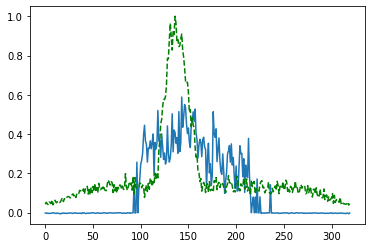

Time taken for epoch:  153.36674213409424
Epoch = [ 99/3000]  Iter = [   0/39480]  Loss = 0.2038 Avg Loss = 0.2038  Time = 0.0716s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [ 99/3000]  Iter = [ 100/39480]  Loss = 0.2358 Avg Loss = 0.2123  Time = 0.0030s
Epoch = [ 99/3000]  Iter = [ 200/39480]  Loss = 0.1967 Avg Loss = 0.2199  Time = 0.0037s
Epoch = [ 99/3000]  Iter = [ 300/39480]  Loss = 0.2117 Avg Loss = 0.2152  Time = 0.0037s
Epoch = [ 99/3000]  Iter = [ 400/39480]  Loss = 0.2071 Avg Loss = 0.215  Time = 0.0036s
Epoch = [ 99/3000]  Iter = [ 500/39480]  Loss = 0.1717 Avg Loss = 0.2169  Time = 0.0037s
Epoch = [ 99/3000]  Iter = [ 600/39480]  Loss = 0.2075 Avg Loss = 0.2173  Time = 0.0037s
Epoch = [ 99/3000]  Iter = [ 700/39480]  Loss = 0.2139 Avg Loss = 0.2212  Time = 0.0037s
Epoch = [ 99/3000]  Iter = [ 800/39480]  Loss = 0.2315 Avg Loss = 0.2224  Time = 0.0037s
Epoch = [ 99/3000]  Iter = [ 900/39480]  Loss = 0.1807 Avg Loss = 0.2192  Time = 0.0036s
Epoch = [ 99/3000]  Iter = [1000/39480]  Loss = 0.2024 Avg Loss = 0.2174  Time = 0.0036s
Epoch = [ 99/3000]  Iter = [1100/39480]  Loss = 0.1897 Avg Loss = 0.215  Time = 0.0036s
Epoch = [ 99/3000]  Ite

Epoch = [ 99/3000]  Iter = [9400/39480]  Loss = 0.2377 Avg Loss = 0.2184  Time = 0.0035s
Epoch = [ 99/3000]  Iter = [9500/39480]  Loss = 0.2155 Avg Loss = 0.2191  Time = 0.0035s
Epoch = [ 99/3000]  Iter = [9600/39480]  Loss = 0.1836 Avg Loss = 0.2197  Time = 0.0036s
Epoch = [ 99/3000]  Iter = [9700/39480]  Loss = 0.2109 Avg Loss = 0.216  Time = 0.0034s
Epoch = [ 99/3000]  Iter = [9800/39480]  Loss = 0.2172 Avg Loss = 0.2166  Time = 0.0034s
Epoch = [ 99/3000]  Iter = [9900/39480]  Loss = 0.2159 Avg Loss = 0.2203  Time = 0.0035s
Epoch = [ 99/3000]  Iter = [10000/39480]  Loss = 0.2019 Avg Loss = 0.2233  Time = 0.0035s
Epoch = [ 99/3000]  Iter = [10100/39480]  Loss = 0.2124 Avg Loss = 0.2182  Time = 0.0036s
Epoch = [ 99/3000]  Iter = [10200/39480]  Loss = 0.2114 Avg Loss = 0.2193  Time = 0.0033s
Epoch = [ 99/3000]  Iter = [10300/39480]  Loss = 0.1934 Avg Loss = 0.2179  Time = 0.0035s
Epoch = [ 99/3000]  Iter = [10400/39480]  Loss = 0.2256 Avg Loss = 0.2202  Time = 0.0035s
Epoch = [ 99/3000

Epoch = [ 99/3000]  Iter = [18600/39480]  Loss = 0.192 Avg Loss = 0.2178  Time = 0.0036s
Epoch = [ 99/3000]  Iter = [18700/39480]  Loss = 0.216 Avg Loss = 0.218  Time = 0.0035s
Epoch = [ 99/3000]  Iter = [18800/39480]  Loss = 0.2373 Avg Loss = 0.2226  Time = 0.0036s
Epoch = [ 99/3000]  Iter = [18900/39480]  Loss = 0.2137 Avg Loss = 0.2197  Time = 0.0032s
Epoch = [ 99/3000]  Iter = [19000/39480]  Loss = 0.2084 Avg Loss = 0.2196  Time = 0.0035s
Epoch = [ 99/3000]  Iter = [19100/39480]  Loss = 0.2385 Avg Loss = 0.2203  Time = 0.0036s
Epoch = [ 99/3000]  Iter = [19200/39480]  Loss = 0.2248 Avg Loss = 0.2174  Time = 0.0036s
Epoch = [ 99/3000]  Iter = [19300/39480]  Loss = 0.2506 Avg Loss = 0.2195  Time = 0.0036s
Epoch = [ 99/3000]  Iter = [19400/39480]  Loss = 0.2209 Avg Loss = 0.2175  Time = 0.0036s
Epoch = [ 99/3000]  Iter = [19500/39480]  Loss = 0.2576 Avg Loss = 0.2189  Time = 0.0032s
Epoch = [ 99/3000]  Iter = [19600/39480]  Loss = 0.2144 Avg Loss = 0.2192  Time = 0.0036s
Epoch = [ 99/

Epoch = [ 99/3000]  Iter = [27800/39480]  Loss = 0.2219 Avg Loss = 0.2185  Time = 0.0036s
Epoch = [ 99/3000]  Iter = [27900/39480]  Loss = 0.2041 Avg Loss = 0.2168  Time = 0.0033s
Epoch = [ 99/3000]  Iter = [28000/39480]  Loss = 0.1843 Avg Loss = 0.2199  Time = 0.0034s
Epoch = [ 99/3000]  Iter = [28100/39480]  Loss = 0.2359 Avg Loss = 0.2159  Time = 0.0032s
Epoch = [ 99/3000]  Iter = [28200/39480]  Loss = 0.2266 Avg Loss = 0.217  Time = 0.0034s
Epoch = [ 99/3000]  Iter = [28300/39480]  Loss = 0.1908 Avg Loss = 0.2211  Time = 0.0033s
Epoch = [ 99/3000]  Iter = [28400/39480]  Loss = 0.1981 Avg Loss = 0.2208  Time = 0.0035s
Epoch = [ 99/3000]  Iter = [28500/39480]  Loss = 0.3443 Avg Loss = 0.219  Time = 0.0035s
Epoch = [ 99/3000]  Iter = [28600/39480]  Loss = 0.2421 Avg Loss = 0.2201  Time = 0.0035s
Epoch = [ 99/3000]  Iter = [28700/39480]  Loss = 0.2072 Avg Loss = 0.2203  Time = 0.0035s
Epoch = [ 99/3000]  Iter = [28800/39480]  Loss = 0.1989 Avg Loss = 0.217  Time = 0.0036s
Epoch = [ 99/

Epoch = [ 99/3000]  Iter = [37000/39480]  Loss = 0.2034 Avg Loss = 0.2179  Time = 0.0034s
Epoch = [ 99/3000]  Iter = [37100/39480]  Loss = 0.2113 Avg Loss = 0.2145  Time = 0.0034s
Epoch = [ 99/3000]  Iter = [37200/39480]  Loss = 0.2319 Avg Loss = 0.2168  Time = 0.0035s
Epoch = [ 99/3000]  Iter = [37300/39480]  Loss = 0.2258 Avg Loss = 0.2159  Time = 0.0035s
Epoch = [ 99/3000]  Iter = [37400/39480]  Loss = 0.2404 Avg Loss = 0.2166  Time = 0.0035s
Epoch = [ 99/3000]  Iter = [37500/39480]  Loss = 0.2528 Avg Loss = 0.221  Time = 0.0035s
Epoch = [ 99/3000]  Iter = [37600/39480]  Loss = 0.2308 Avg Loss = 0.215  Time = 0.0034s
Epoch = [ 99/3000]  Iter = [37700/39480]  Loss = 0.2706 Avg Loss = 0.2214  Time = 0.0035s
Epoch = [ 99/3000]  Iter = [37800/39480]  Loss = 0.1847 Avg Loss = 0.2179  Time = 0.0034s
Epoch = [ 99/3000]  Iter = [37900/39480]  Loss = 0.1795 Avg Loss = 0.2172  Time = 0.0036s
Epoch = [ 99/3000]  Iter = [38000/39480]  Loss = 0.2126 Avg Loss = 0.2185  Time = 0.0032s
Epoch = [ 99

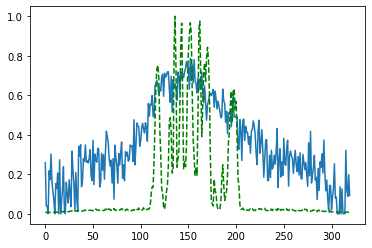

Time taken for epoch:  153.48889064788818
Epoch = [100/3000]  Iter = [   0/39480]  Loss = 0.2069 Avg Loss = 0.2069  Time = 0.0814s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [100/3000]  Iter = [ 100/39480]  Loss = 0.1837 Avg Loss = 0.202  Time = 0.0028s
Epoch = [100/3000]  Iter = [ 200/39480]  Loss = 0.2021 Avg Loss = 0.1935  Time = 0.0036s
Epoch = [100/3000]  Iter = [ 300/39480]  Loss = 0.1729 Avg Loss = 0.1871  Time = 0.0036s
Epoch = [100/3000]  Iter = [ 400/39480]  Loss = 0.1997 Avg Loss = 0.1836  Time = 0.0036s
Epoch = [100/3000]  Iter = [ 500/39480]  Loss = 0.1593 Avg Loss = 0.1824  Time = 0.0036s
Epoch = [100/3000]  Iter = [ 600/39480]  Loss = 0.174 Avg Loss = 0.181  Time = 0.0036s
Epoch = [100/3000]  Iter = [ 700/39480]  Loss = 0.1545 Avg Loss = 0.1765  Time = 0.0036s
Epoch = [100/3000]  Iter = [ 800/39480]  Loss = 0.1783 Avg Loss = 0.1759  Time = 0.0034s
Epoch = [100/3000]  Iter = [ 900/39480]  Loss = 0.152 Avg Loss = 0.1768  Time = 0.0036s
Epoch = [100/3000]  Iter = [1000/39480]  Loss = 0.1507 Avg Loss = 0.1759  Time = 0.0035s
Epoch = [100/3000]  Iter = [1100/39480]  Loss = 0.2139 Avg Loss = 0.1743  Time = 0.0035s
Epoch = [100/3000]  Iter 

Epoch = [100/3000]  Iter = [9400/39480]  Loss = 0.1396 Avg Loss = 0.1587  Time = 0.0036s
Epoch = [100/3000]  Iter = [9500/39480]  Loss = 0.1726 Avg Loss = 0.1598  Time = 0.0036s
Epoch = [100/3000]  Iter = [9600/39480]  Loss = 0.1743 Avg Loss = 0.1579  Time = 0.0035s
Epoch = [100/3000]  Iter = [9700/39480]  Loss = 0.1536 Avg Loss = 0.1575  Time = 0.0035s
Epoch = [100/3000]  Iter = [9800/39480]  Loss = 0.1678 Avg Loss = 0.1594  Time = 0.0033s
Epoch = [100/3000]  Iter = [9900/39480]  Loss = 0.1527 Avg Loss = 0.1589  Time = 0.0036s
Epoch = [100/3000]  Iter = [10000/39480]  Loss = 0.1443 Avg Loss = 0.1593  Time = 0.0031s
Epoch = [100/3000]  Iter = [10100/39480]  Loss = 0.1816 Avg Loss = 0.1591  Time = 0.0035s
Epoch = [100/3000]  Iter = [10200/39480]  Loss = 0.1587 Avg Loss = 0.1584  Time = 0.0036s
Epoch = [100/3000]  Iter = [10300/39480]  Loss = 0.1513 Avg Loss = 0.1584  Time = 0.0036s
Epoch = [100/3000]  Iter = [10400/39480]  Loss = 0.1723 Avg Loss = 0.1587  Time = 0.0034s
Epoch = [100/300

Epoch = [100/3000]  Iter = [18600/39480]  Loss = 0.1623 Avg Loss = 0.1588  Time = 0.0036s
Epoch = [100/3000]  Iter = [18700/39480]  Loss = 0.1628 Avg Loss = 0.159  Time = 0.0035s
Epoch = [100/3000]  Iter = [18800/39480]  Loss = 0.1563 Avg Loss = 0.1584  Time = 0.0036s
Epoch = [100/3000]  Iter = [18900/39480]  Loss = 0.1499 Avg Loss = 0.1596  Time = 0.0036s
Epoch = [100/3000]  Iter = [19000/39480]  Loss = 0.1469 Avg Loss = 0.1593  Time = 0.0035s
Epoch = [100/3000]  Iter = [19100/39480]  Loss = 0.1465 Avg Loss = 0.1589  Time = 0.0036s
Epoch = [100/3000]  Iter = [19200/39480]  Loss = 0.1418 Avg Loss = 0.1607  Time = 0.0035s
Epoch = [100/3000]  Iter = [19300/39480]  Loss = 0.1881 Avg Loss = 0.1593  Time = 0.0035s
Epoch = [100/3000]  Iter = [19400/39480]  Loss = 0.1656 Avg Loss = 0.1588  Time = 0.0035s
Epoch = [100/3000]  Iter = [19500/39480]  Loss = 0.1508 Avg Loss = 0.1601  Time = 0.0033s
Epoch = [100/3000]  Iter = [19600/39480]  Loss = 0.133 Avg Loss = 0.1597  Time = 0.0036s
Epoch = [100

Epoch = [100/3000]  Iter = [27800/39480]  Loss = 0.1462 Avg Loss = 0.1569  Time = 0.0035s
Epoch = [100/3000]  Iter = [27900/39480]  Loss = 0.1902 Avg Loss = 0.1576  Time = 0.0035s
Epoch = [100/3000]  Iter = [28000/39480]  Loss = 0.1559 Avg Loss = 0.1558  Time = 0.0035s
Epoch = [100/3000]  Iter = [28100/39480]  Loss = 0.147 Avg Loss = 0.1575  Time = 0.0035s
Epoch = [100/3000]  Iter = [28200/39480]  Loss = 0.1751 Avg Loss = 0.1582  Time = 0.0035s
Epoch = [100/3000]  Iter = [28300/39480]  Loss = 0.1659 Avg Loss = 0.1561  Time = 0.0035s
Epoch = [100/3000]  Iter = [28400/39480]  Loss = 0.1886 Avg Loss = 0.1585  Time = 0.0035s
Epoch = [100/3000]  Iter = [28500/39480]  Loss = 0.1543 Avg Loss = 0.1581  Time = 0.0035s
Epoch = [100/3000]  Iter = [28600/39480]  Loss = 0.1825 Avg Loss = 0.1586  Time = 0.0036s
Epoch = [100/3000]  Iter = [28700/39480]  Loss = 0.1558 Avg Loss = 0.1582  Time = 0.0033s
Epoch = [100/3000]  Iter = [28800/39480]  Loss = 0.1646 Avg Loss = 0.1569  Time = 0.0032s
Epoch = [10

Epoch = [100/3000]  Iter = [37000/39480]  Loss = 0.1681 Avg Loss = 0.1579  Time = 0.0036s
Epoch = [100/3000]  Iter = [37100/39480]  Loss = 0.1563 Avg Loss = 0.1578  Time = 0.0036s
Epoch = [100/3000]  Iter = [37200/39480]  Loss = 0.1634 Avg Loss = 0.1583  Time = 0.0036s
Epoch = [100/3000]  Iter = [37300/39480]  Loss = 0.156 Avg Loss = 0.1572  Time = 0.0035s
Epoch = [100/3000]  Iter = [37400/39480]  Loss = 0.1433 Avg Loss = 0.1572  Time = 0.0036s
Epoch = [100/3000]  Iter = [37500/39480]  Loss = 0.1576 Avg Loss = 0.1591  Time = 0.0036s
Epoch = [100/3000]  Iter = [37600/39480]  Loss = 0.1618 Avg Loss = 0.1591  Time = 0.0031s
Epoch = [100/3000]  Iter = [37700/39480]  Loss = 0.1609 Avg Loss = 0.1576  Time = 0.0036s
Epoch = [100/3000]  Iter = [37800/39480]  Loss = 0.1421 Avg Loss = 0.157  Time = 0.0034s
Epoch = [100/3000]  Iter = [37900/39480]  Loss = 0.1519 Avg Loss = 0.1583  Time = 0.0035s
Epoch = [100/3000]  Iter = [38000/39480]  Loss = 0.1717 Avg Loss = 0.1598  Time = 0.0035s
Epoch = [100

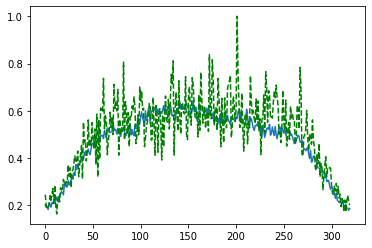

Time taken for epoch:  152.74934101104736
Epoch = [101/3000]  Iter = [   0/39480]  Loss = 0.1585 Avg Loss = 0.1585  Time = 0.0724s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [101/3000]  Iter = [ 100/39480]  Loss = 0.1278 Avg Loss = 0.1572  Time = 0.0030s
Epoch = [101/3000]  Iter = [ 200/39480]  Loss = 0.1756 Avg Loss = 0.1575  Time = 0.0037s
Epoch = [101/3000]  Iter = [ 300/39480]  Loss = 0.131 Avg Loss = 0.1561  Time = 0.0037s
Epoch = [101/3000]  Iter = [ 400/39480]  Loss = 0.1443 Avg Loss = 0.1568  Time = 0.0037s
Epoch = [101/3000]  Iter = [ 500/39480]  Loss = 0.2003 Avg Loss = 0.1587  Time = 0.0037s
Epoch = [101/3000]  Iter = [ 600/39480]  Loss = 0.156 Avg Loss = 0.1592  Time = 0.0032s
Epoch = [101/3000]  Iter = [ 700/39480]  Loss = 0.1491 Avg Loss = 0.1573  Time = 0.0030s
Epoch = [101/3000]  Iter = [ 800/39480]  Loss = 0.1802 Avg Loss = 0.1591  Time = 0.0034s
Epoch = [101/3000]  Iter = [ 900/39480]  Loss = 0.1387 Avg Loss = 0.1585  Time = 0.0035s
Epoch = [101/3000]  Iter = [1000/39480]  Loss = 0.1628 Avg Loss = 0.1554  Time = 0.0036s
Epoch = [101/3000]  Iter = [1100/39480]  Loss = 0.1426 Avg Loss = 0.1564  Time = 0.0037s
Epoch = [101/3000]  Ite

Epoch = [101/3000]  Iter = [9400/39480]  Loss = 0.1549 Avg Loss = 0.1586  Time = 0.0036s
Epoch = [101/3000]  Iter = [9500/39480]  Loss = 0.1785 Avg Loss = 0.1584  Time = 0.0032s
Epoch = [101/3000]  Iter = [9600/39480]  Loss = 0.1515 Avg Loss = 0.1565  Time = 0.0037s
Epoch = [101/3000]  Iter = [9700/39480]  Loss = 0.1447 Avg Loss = 0.1561  Time = 0.0035s
Epoch = [101/3000]  Iter = [9800/39480]  Loss = 0.1503 Avg Loss = 0.1585  Time = 0.0035s
Epoch = [101/3000]  Iter = [9900/39480]  Loss = 0.1529 Avg Loss = 0.1579  Time = 0.0035s
Epoch = [101/3000]  Iter = [10000/39480]  Loss = 0.1498 Avg Loss = 0.1583  Time = 0.0033s
Epoch = [101/3000]  Iter = [10100/39480]  Loss = 0.1632 Avg Loss = 0.1585  Time = 0.0035s
Epoch = [101/3000]  Iter = [10200/39480]  Loss = 0.1372 Avg Loss = 0.1596  Time = 0.0035s
Epoch = [101/3000]  Iter = [10300/39480]  Loss = 0.1627 Avg Loss = 0.1594  Time = 0.0035s
Epoch = [101/3000]  Iter = [10400/39480]  Loss = 0.1388 Avg Loss = 0.1586  Time = 0.0036s
Epoch = [101/300

Epoch = [101/3000]  Iter = [18600/39480]  Loss = 0.1642 Avg Loss = 0.1558  Time = 0.0036s
Epoch = [101/3000]  Iter = [18700/39480]  Loss = 0.1394 Avg Loss = 0.1555  Time = 0.0035s
Epoch = [101/3000]  Iter = [18800/39480]  Loss = 0.1351 Avg Loss = 0.1577  Time = 0.0035s
Epoch = [101/3000]  Iter = [18900/39480]  Loss = 0.1726 Avg Loss = 0.1591  Time = 0.0034s
Epoch = [101/3000]  Iter = [19000/39480]  Loss = 0.1684 Avg Loss = 0.1579  Time = 0.0035s
Epoch = [101/3000]  Iter = [19100/39480]  Loss = 0.1815 Avg Loss = 0.1577  Time = 0.0035s
Epoch = [101/3000]  Iter = [19200/39480]  Loss = 0.1999 Avg Loss = 0.1587  Time = 0.0034s
Epoch = [101/3000]  Iter = [19300/39480]  Loss = 0.1611 Avg Loss = 0.1597  Time = 0.0035s
Epoch = [101/3000]  Iter = [19400/39480]  Loss = 0.1657 Avg Loss = 0.1588  Time = 0.0036s
Epoch = [101/3000]  Iter = [19500/39480]  Loss = 0.1768 Avg Loss = 0.1572  Time = 0.0036s
Epoch = [101/3000]  Iter = [19600/39480]  Loss = 0.1422 Avg Loss = 0.156  Time = 0.0032s
Epoch = [10

Epoch = [101/3000]  Iter = [27800/39480]  Loss = 0.1712 Avg Loss = 0.1576  Time = 0.0034s
Epoch = [101/3000]  Iter = [27900/39480]  Loss = 0.1589 Avg Loss = 0.1586  Time = 0.0036s
Epoch = [101/3000]  Iter = [28000/39480]  Loss = 0.1693 Avg Loss = 0.1582  Time = 0.0036s
Epoch = [101/3000]  Iter = [28100/39480]  Loss = 0.1374 Avg Loss = 0.156  Time = 0.0035s
Epoch = [101/3000]  Iter = [28200/39480]  Loss = 0.1511 Avg Loss = 0.1576  Time = 0.0036s
Epoch = [101/3000]  Iter = [28300/39480]  Loss = 0.1685 Avg Loss = 0.1573  Time = 0.0036s
Epoch = [101/3000]  Iter = [28400/39480]  Loss = 0.1825 Avg Loss = 0.157  Time = 0.0036s
Epoch = [101/3000]  Iter = [28500/39480]  Loss = 0.1247 Avg Loss = 0.1555  Time = 0.0035s
Epoch = [101/3000]  Iter = [28600/39480]  Loss = 0.1628 Avg Loss = 0.1583  Time = 0.0036s
Epoch = [101/3000]  Iter = [28700/39480]  Loss = 0.1396 Avg Loss = 0.1578  Time = 0.0035s
Epoch = [101/3000]  Iter = [28800/39480]  Loss = 0.1663 Avg Loss = 0.1584  Time = 0.0035s
Epoch = [101

Epoch = [101/3000]  Iter = [37000/39480]  Loss = 0.164 Avg Loss = 0.1573  Time = 0.0034s
Epoch = [101/3000]  Iter = [37100/39480]  Loss = 0.1579 Avg Loss = 0.1571  Time = 0.0031s
Epoch = [101/3000]  Iter = [37200/39480]  Loss = 0.136 Avg Loss = 0.1573  Time = 0.0036s
Epoch = [101/3000]  Iter = [37300/39480]  Loss = 0.1656 Avg Loss = 0.157  Time = 0.0036s
Epoch = [101/3000]  Iter = [37400/39480]  Loss = 0.1582 Avg Loss = 0.1585  Time = 0.0037s
Epoch = [101/3000]  Iter = [37500/39480]  Loss = 0.1434 Avg Loss = 0.1573  Time = 0.0036s
Epoch = [101/3000]  Iter = [37600/39480]  Loss = 0.1761 Avg Loss = 0.1582  Time = 0.0032s
Epoch = [101/3000]  Iter = [37700/39480]  Loss = 0.168 Avg Loss = 0.1581  Time = 0.0035s
Epoch = [101/3000]  Iter = [37800/39480]  Loss = 0.1431 Avg Loss = 0.1568  Time = 0.0036s
Epoch = [101/3000]  Iter = [37900/39480]  Loss = 0.1426 Avg Loss = 0.1579  Time = 0.0035s
Epoch = [101/3000]  Iter = [38000/39480]  Loss = 0.1584 Avg Loss = 0.1565  Time = 0.0035s
Epoch = [101/3

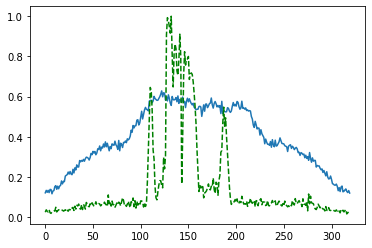

Time taken for epoch:  152.21805596351624
Epoch = [102/3000]  Iter = [   0/39480]  Loss = 0.1448 Avg Loss = 0.1448  Time = 0.0693s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [102/3000]  Iter = [ 100/39480]  Loss = 0.1362 Avg Loss = 0.152  Time = 0.0035s
Epoch = [102/3000]  Iter = [ 200/39480]  Loss = 0.1859 Avg Loss = 0.1554  Time = 0.0034s
Epoch = [102/3000]  Iter = [ 300/39480]  Loss = 0.1673 Avg Loss = 0.156  Time = 0.0036s
Epoch = [102/3000]  Iter = [ 400/39480]  Loss = 0.142 Avg Loss = 0.1571  Time = 0.0035s
Epoch = [102/3000]  Iter = [ 500/39480]  Loss = 0.1657 Avg Loss = 0.1572  Time = 0.0035s
Epoch = [102/3000]  Iter = [ 600/39480]  Loss = 0.175 Avg Loss = 0.1559  Time = 0.0036s
Epoch = [102/3000]  Iter = [ 700/39480]  Loss = 0.165 Avg Loss = 0.1556  Time = 0.0032s
Epoch = [102/3000]  Iter = [ 800/39480]  Loss = 0.1774 Avg Loss = 0.1546  Time = 0.0035s
Epoch = [102/3000]  Iter = [ 900/39480]  Loss = 0.1505 Avg Loss = 0.155  Time = 0.0036s
Epoch = [102/3000]  Iter = [1000/39480]  Loss = 0.1635 Avg Loss = 0.155  Time = 0.0035s
Epoch = [102/3000]  Iter = [1100/39480]  Loss = 0.1461 Avg Loss = 0.1553  Time = 0.0035s
Epoch = [102/3000]  Iter = [

Epoch = [102/3000]  Iter = [9400/39480]  Loss = 0.1675 Avg Loss = 0.1576  Time = 0.0035s
Epoch = [102/3000]  Iter = [9500/39480]  Loss = 0.1746 Avg Loss = 0.1577  Time = 0.0033s
Epoch = [102/3000]  Iter = [9600/39480]  Loss = 0.1484 Avg Loss = 0.1583  Time = 0.0036s
Epoch = [102/3000]  Iter = [9700/39480]  Loss = 0.1426 Avg Loss = 0.1583  Time = 0.0036s
Epoch = [102/3000]  Iter = [9800/39480]  Loss = 0.1508 Avg Loss = 0.1575  Time = 0.0036s
Epoch = [102/3000]  Iter = [9900/39480]  Loss = 0.154 Avg Loss = 0.1566  Time = 0.0036s
Epoch = [102/3000]  Iter = [10000/39480]  Loss = 0.1457 Avg Loss = 0.1562  Time = 0.0036s
Epoch = [102/3000]  Iter = [10100/39480]  Loss = 0.1497 Avg Loss = 0.1556  Time = 0.0036s
Epoch = [102/3000]  Iter = [10200/39480]  Loss = 0.1739 Avg Loss = 0.1582  Time = 0.0036s
Epoch = [102/3000]  Iter = [10300/39480]  Loss = 0.1502 Avg Loss = 0.1569  Time = 0.0035s
Epoch = [102/3000]  Iter = [10400/39480]  Loss = 0.1345 Avg Loss = 0.1575  Time = 0.0033s
Epoch = [102/3000

Epoch = [102/3000]  Iter = [18600/39480]  Loss = 0.1545 Avg Loss = 0.1575  Time = 0.0036s
Epoch = [102/3000]  Iter = [18700/39480]  Loss = 0.1658 Avg Loss = 0.157  Time = 0.0035s
Epoch = [102/3000]  Iter = [18800/39480]  Loss = 0.1897 Avg Loss = 0.1573  Time = 0.0036s
Epoch = [102/3000]  Iter = [18900/39480]  Loss = 0.1711 Avg Loss = 0.1565  Time = 0.0031s
Epoch = [102/3000]  Iter = [19000/39480]  Loss = 0.1757 Avg Loss = 0.1567  Time = 0.0033s
Epoch = [102/3000]  Iter = [19100/39480]  Loss = 0.1782 Avg Loss = 0.1567  Time = 0.0032s
Epoch = [102/3000]  Iter = [19200/39480]  Loss = 0.1485 Avg Loss = 0.158  Time = 0.0036s
Epoch = [102/3000]  Iter = [19300/39480]  Loss = 0.1665 Avg Loss = 0.1584  Time = 0.0036s
Epoch = [102/3000]  Iter = [19400/39480]  Loss = 0.1338 Avg Loss = 0.1556  Time = 0.0036s
Epoch = [102/3000]  Iter = [19500/39480]  Loss = 0.1479 Avg Loss = 0.1556  Time = 0.0035s
Epoch = [102/3000]  Iter = [19600/39480]  Loss = 0.1421 Avg Loss = 0.1562  Time = 0.0035s
Epoch = [102

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch = [119/3000]  Iter = [30500/39480]  Loss = 0.1535 Avg Loss = 0.1557  Time = 0.0036s
Epoch = [119/3000]  Iter = [30600/39480]  Loss = 0.1736 Avg Loss = 0.1571  Time = 0.0036s
Epoch = [119/3000]  Iter = [30700/39480]  Loss = 0.1601 Avg Loss = 0.1584  Time = 0.0036s
Epoch = [119/3000]  Iter = [30800/39480]  Loss = 0.1631 Avg Loss = 0.1565  Time = 0.0036s
Epoch = [119/3000]  Iter = [30900/39480]  Loss = 0.1396 Avg Loss = 0.1573  Time = 0.0036s
Epoch = [119/3000]  Iter = [31000/39480]  Loss = 0.1598 Avg Loss = 0.1582  Time = 0.0036s
Epoch = [119/3000]  Iter = [31100/39480]  Loss = 0.1544 Avg Loss = 0.1571  Time = 0.0036s
Epoch = [119/3000]  Iter = [31200/39480]  Loss = 0.1402 Avg Loss = 0.1573  Time = 0.0036s
Epoch = [119/3000]  Iter = [31300/39480]  Loss = 0.1486 Avg Loss = 0.1553  Time = 0.0034s
Epoch = [119/3000]  Iter = [31400/39480]  Loss = 0.1509 Avg Loss = 0.1569  Time = 0.0036s
Epoch = [119/3000]  Iter = [31500/39480]  Loss = 0.1934 Avg Loss = 0.1584  Time = 0.0036s
Epoch = [1

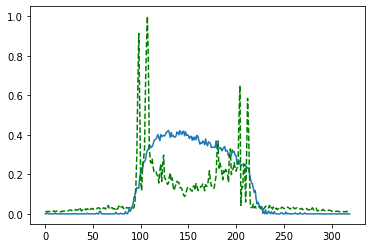

Time taken for epoch:  152.4095265865326
Epoch = [120/3000]  Iter = [   0/39480]  Loss = 0.1613 Avg Loss = 0.1613  Time = 0.0712s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [120/3000]  Iter = [ 100/39480]  Loss = 0.1618 Avg Loss = 0.1571  Time = 0.0034s
Epoch = [120/3000]  Iter = [ 200/39480]  Loss = 0.1488 Avg Loss = 0.1569  Time = 0.0036s
Epoch = [120/3000]  Iter = [ 300/39480]  Loss = 0.1444 Avg Loss = 0.155  Time = 0.0036s
Epoch = [120/3000]  Iter = [ 400/39480]  Loss = 0.1422 Avg Loss = 0.1544  Time = 0.0035s
Epoch = [120/3000]  Iter = [ 500/39480]  Loss = 0.1474 Avg Loss = 0.1562  Time = 0.0034s
Epoch = [120/3000]  Iter = [ 600/39480]  Loss = 0.166 Avg Loss = 0.1545  Time = 0.0036s
Epoch = [120/3000]  Iter = [ 700/39480]  Loss = 0.1469 Avg Loss = 0.1569  Time = 0.0034s
Epoch = [120/3000]  Iter = [ 800/39480]  Loss = 0.1507 Avg Loss = 0.1569  Time = 0.0035s
Epoch = [120/3000]  Iter = [ 900/39480]  Loss = 0.141 Avg Loss = 0.1558  Time = 0.0032s
Epoch = [120/3000]  Iter = [1000/39480]  Loss = 0.1501 Avg Loss = 0.1546  Time = 0.0036s
Epoch = [120/3000]  Iter = [1100/39480]  Loss = 0.164 Avg Loss = 0.1564  Time = 0.0033s
Epoch = [120/3000]  Iter 

Epoch = [120/3000]  Iter = [9400/39480]  Loss = 0.1778 Avg Loss = 0.1559  Time = 0.0035s
Epoch = [120/3000]  Iter = [9500/39480]  Loss = 0.1507 Avg Loss = 0.1572  Time = 0.0036s
Epoch = [120/3000]  Iter = [9600/39480]  Loss = 0.1655 Avg Loss = 0.1587  Time = 0.0036s
Epoch = [120/3000]  Iter = [9700/39480]  Loss = 0.1528 Avg Loss = 0.1565  Time = 0.0036s
Epoch = [120/3000]  Iter = [9800/39480]  Loss = 0.1872 Avg Loss = 0.1576  Time = 0.0035s
Epoch = [120/3000]  Iter = [9900/39480]  Loss = 0.1465 Avg Loss = 0.155  Time = 0.0031s
Epoch = [120/3000]  Iter = [10000/39480]  Loss = 0.1666 Avg Loss = 0.1559  Time = 0.0032s
Epoch = [120/3000]  Iter = [10100/39480]  Loss = 0.1576 Avg Loss = 0.1554  Time = 0.0035s
Epoch = [120/3000]  Iter = [10200/39480]  Loss = 0.14 Avg Loss = 0.1548  Time = 0.0035s
Epoch = [120/3000]  Iter = [10300/39480]  Loss = 0.1235 Avg Loss = 0.1562  Time = 0.0034s
Epoch = [120/3000]  Iter = [10400/39480]  Loss = 0.1592 Avg Loss = 0.1565  Time = 0.0036s
Epoch = [120/3000] 

Epoch = [120/3000]  Iter = [18600/39480]  Loss = 0.1596 Avg Loss = 0.1562  Time = 0.0028s
Epoch = [120/3000]  Iter = [18700/39480]  Loss = 0.1345 Avg Loss = 0.1571  Time = 0.0032s
Epoch = [120/3000]  Iter = [18800/39480]  Loss = 0.1523 Avg Loss = 0.1568  Time = 0.0035s
Epoch = [120/3000]  Iter = [18900/39480]  Loss = 0.1733 Avg Loss = 0.1578  Time = 0.0035s
Epoch = [120/3000]  Iter = [19000/39480]  Loss = 0.1367 Avg Loss = 0.1566  Time = 0.0036s
Epoch = [120/3000]  Iter = [19100/39480]  Loss = 0.1531 Avg Loss = 0.1571  Time = 0.0035s
Epoch = [120/3000]  Iter = [19200/39480]  Loss = 0.1456 Avg Loss = 0.157  Time = 0.0033s
Epoch = [120/3000]  Iter = [19300/39480]  Loss = 0.1359 Avg Loss = 0.1562  Time = 0.0037s
Epoch = [120/3000]  Iter = [19400/39480]  Loss = 0.1424 Avg Loss = 0.1567  Time = 0.0037s
Epoch = [120/3000]  Iter = [19500/39480]  Loss = 0.1465 Avg Loss = 0.1563  Time = 0.0037s
Epoch = [120/3000]  Iter = [19600/39480]  Loss = 0.1414 Avg Loss = 0.1571  Time = 0.0037s
Epoch = [12

Epoch = [120/3000]  Iter = [27800/39480]  Loss = 0.1534 Avg Loss = 0.1574  Time = 0.0031s
Epoch = [120/3000]  Iter = [27900/39480]  Loss = 0.1859 Avg Loss = 0.158  Time = 0.0035s
Epoch = [120/3000]  Iter = [28000/39480]  Loss = 0.1526 Avg Loss = 0.158  Time = 0.0036s
Epoch = [120/3000]  Iter = [28100/39480]  Loss = 0.1604 Avg Loss = 0.1575  Time = 0.0036s
Epoch = [120/3000]  Iter = [28200/39480]  Loss = 0.1695 Avg Loss = 0.1559  Time = 0.0031s
Epoch = [120/3000]  Iter = [28300/39480]  Loss = 0.1798 Avg Loss = 0.1582  Time = 0.0031s
Epoch = [120/3000]  Iter = [28400/39480]  Loss = 0.1648 Avg Loss = 0.1558  Time = 0.0035s
Epoch = [120/3000]  Iter = [28500/39480]  Loss = 0.1532 Avg Loss = 0.156  Time = 0.0034s
Epoch = [120/3000]  Iter = [28600/39480]  Loss = 0.1399 Avg Loss = 0.156  Time = 0.0035s
Epoch = [120/3000]  Iter = [28700/39480]  Loss = 0.1575 Avg Loss = 0.156  Time = 0.0035s
Epoch = [120/3000]  Iter = [28800/39480]  Loss = 0.1418 Avg Loss = 0.1564  Time = 0.0036s
Epoch = [120/30

Epoch = [120/3000]  Iter = [37000/39480]  Loss = 0.1778 Avg Loss = 0.1567  Time = 0.0031s
Epoch = [120/3000]  Iter = [37100/39480]  Loss = 0.1868 Avg Loss = 0.158  Time = 0.0035s
Epoch = [120/3000]  Iter = [37200/39480]  Loss = 0.1456 Avg Loss = 0.1577  Time = 0.0035s
Epoch = [120/3000]  Iter = [37300/39480]  Loss = 0.1729 Avg Loss = 0.1576  Time = 0.0035s
Epoch = [120/3000]  Iter = [37400/39480]  Loss = 0.1492 Avg Loss = 0.158  Time = 0.0035s
Epoch = [120/3000]  Iter = [37500/39480]  Loss = 0.1593 Avg Loss = 0.1568  Time = 0.0035s
Epoch = [120/3000]  Iter = [37600/39480]  Loss = 0.151 Avg Loss = 0.1564  Time = 0.0035s
Epoch = [120/3000]  Iter = [37700/39480]  Loss = 0.1617 Avg Loss = 0.1567  Time = 0.0031s
Epoch = [120/3000]  Iter = [37800/39480]  Loss = 0.1809 Avg Loss = 0.1592  Time = 0.0032s
Epoch = [120/3000]  Iter = [37900/39480]  Loss = 0.1749 Avg Loss = 0.1564  Time = 0.0035s
Epoch = [120/3000]  Iter = [38000/39480]  Loss = 0.1616 Avg Loss = 0.1562  Time = 0.0034s
Epoch = [120/

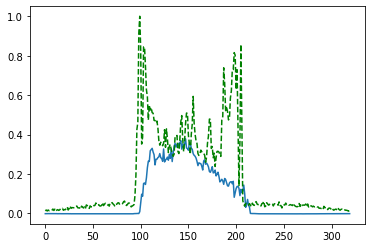

Time taken for epoch:  153.20093894004822
Epoch = [121/3000]  Iter = [   0/39480]  Loss = 0.1535 Avg Loss = 0.1535  Time = 0.0802s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [121/3000]  Iter = [ 100/39480]  Loss = 0.1732 Avg Loss = 0.1561  Time = 0.0034s
Epoch = [121/3000]  Iter = [ 200/39480]  Loss = 0.1283 Avg Loss = 0.1557  Time = 0.0037s
Epoch = [121/3000]  Iter = [ 300/39480]  Loss = 0.1639 Avg Loss = 0.1555  Time = 0.0037s
Epoch = [121/3000]  Iter = [ 400/39480]  Loss = 0.1363 Avg Loss = 0.1565  Time = 0.0035s
Epoch = [121/3000]  Iter = [ 500/39480]  Loss = 0.1538 Avg Loss = 0.1547  Time = 0.0036s
Epoch = [121/3000]  Iter = [ 600/39480]  Loss = 0.15 Avg Loss = 0.157  Time = 0.0037s
Epoch = [121/3000]  Iter = [ 700/39480]  Loss = 0.1699 Avg Loss = 0.157  Time = 0.0030s
Epoch = [121/3000]  Iter = [ 800/39480]  Loss = 0.1496 Avg Loss = 0.1561  Time = 0.0030s
Epoch = [121/3000]  Iter = [ 900/39480]  Loss = 0.1773 Avg Loss = 0.155  Time = 0.0029s
Epoch = [121/3000]  Iter = [1000/39480]  Loss = 0.1595 Avg Loss = 0.1545  Time = 0.0029s
Epoch = [121/3000]  Iter = [1100/39480]  Loss = 0.1673 Avg Loss = 0.1545  Time = 0.0029s
Epoch = [121/3000]  Iter =

Epoch = [121/3000]  Iter = [9400/39480]  Loss = 0.1368 Avg Loss = 0.1554  Time = 0.0036s
Epoch = [121/3000]  Iter = [9500/39480]  Loss = 0.1575 Avg Loss = 0.1576  Time = 0.0036s
Epoch = [121/3000]  Iter = [9600/39480]  Loss = 0.1384 Avg Loss = 0.1568  Time = 0.0037s
Epoch = [121/3000]  Iter = [9700/39480]  Loss = 0.174 Avg Loss = 0.1563  Time = 0.0035s
Epoch = [121/3000]  Iter = [9800/39480]  Loss = 0.1458 Avg Loss = 0.1572  Time = 0.0035s
Epoch = [121/3000]  Iter = [9900/39480]  Loss = 0.1328 Avg Loss = 0.1568  Time = 0.0036s
Epoch = [121/3000]  Iter = [10000/39480]  Loss = 0.1675 Avg Loss = 0.1574  Time = 0.0035s
Epoch = [121/3000]  Iter = [10100/39480]  Loss = 0.1658 Avg Loss = 0.1579  Time = 0.0036s
Epoch = [121/3000]  Iter = [10200/39480]  Loss = 0.1535 Avg Loss = 0.1583  Time = 0.0036s
Epoch = [121/3000]  Iter = [10300/39480]  Loss = 0.1462 Avg Loss = 0.1578  Time = 0.0035s
Epoch = [121/3000]  Iter = [10400/39480]  Loss = 0.1642 Avg Loss = 0.1562  Time = 0.0036s
Epoch = [121/3000

Epoch = [121/3000]  Iter = [18600/39480]  Loss = 0.1708 Avg Loss = 0.1577  Time = 0.0036s
Epoch = [121/3000]  Iter = [18700/39480]  Loss = 0.1793 Avg Loss = 0.1568  Time = 0.0032s
Epoch = [121/3000]  Iter = [18800/39480]  Loss = 0.1879 Avg Loss = 0.1571  Time = 0.0036s
Epoch = [121/3000]  Iter = [18900/39480]  Loss = 0.1644 Avg Loss = 0.1569  Time = 0.0035s
Epoch = [121/3000]  Iter = [19000/39480]  Loss = 0.1577 Avg Loss = 0.1577  Time = 0.0035s
Epoch = [121/3000]  Iter = [19100/39480]  Loss = 0.1589 Avg Loss = 0.156  Time = 0.0035s
Epoch = [121/3000]  Iter = [19200/39480]  Loss = 0.1615 Avg Loss = 0.1542  Time = 0.0036s
Epoch = [121/3000]  Iter = [19300/39480]  Loss = 0.1499 Avg Loss = 0.1546  Time = 0.0036s
Epoch = [121/3000]  Iter = [19400/39480]  Loss = 0.151 Avg Loss = 0.1565  Time = 0.0035s
Epoch = [121/3000]  Iter = [19500/39480]  Loss = 0.1473 Avg Loss = 0.1568  Time = 0.0031s
Epoch = [121/3000]  Iter = [19600/39480]  Loss = 0.1622 Avg Loss = 0.157  Time = 0.0031s
Epoch = [121/

Epoch = [121/3000]  Iter = [27800/39480]  Loss = 0.1703 Avg Loss = 0.1574  Time = 0.0036s
Epoch = [121/3000]  Iter = [27900/39480]  Loss = 0.1781 Avg Loss = 0.157  Time = 0.0036s
Epoch = [121/3000]  Iter = [28000/39480]  Loss = 0.1648 Avg Loss = 0.1582  Time = 0.0036s
Epoch = [121/3000]  Iter = [28100/39480]  Loss = 0.1342 Avg Loss = 0.1583  Time = 0.0034s
Epoch = [121/3000]  Iter = [28200/39480]  Loss = 0.1551 Avg Loss = 0.1569  Time = 0.0031s
Epoch = [121/3000]  Iter = [28300/39480]  Loss = 0.1516 Avg Loss = 0.1585  Time = 0.0035s
Epoch = [121/3000]  Iter = [28400/39480]  Loss = 0.117 Avg Loss = 0.1575  Time = 0.0036s
Epoch = [121/3000]  Iter = [28500/39480]  Loss = 0.1594 Avg Loss = 0.1581  Time = 0.0035s
Epoch = [121/3000]  Iter = [28600/39480]  Loss = 0.146 Avg Loss = 0.1578  Time = 0.0033s
Epoch = [121/3000]  Iter = [28700/39480]  Loss = 0.143 Avg Loss = 0.1571  Time = 0.0035s
Epoch = [121/3000]  Iter = [28800/39480]  Loss = 0.144 Avg Loss = 0.1558  Time = 0.0035s
Epoch = [121/30

Epoch = [121/3000]  Iter = [37000/39480]  Loss = 0.1712 Avg Loss = 0.1585  Time = 0.0035s
Epoch = [121/3000]  Iter = [37100/39480]  Loss = 0.1317 Avg Loss = 0.1585  Time = 0.0035s
Epoch = [121/3000]  Iter = [37200/39480]  Loss = 0.1609 Avg Loss = 0.1575  Time = 0.0035s
Epoch = [121/3000]  Iter = [37300/39480]  Loss = 0.1195 Avg Loss = 0.1562  Time = 0.0035s
Epoch = [121/3000]  Iter = [37400/39480]  Loss = 0.1496 Avg Loss = 0.157  Time = 0.0034s
Epoch = [121/3000]  Iter = [37500/39480]  Loss = 0.1518 Avg Loss = 0.1587  Time = 0.0033s
Epoch = [121/3000]  Iter = [37600/39480]  Loss = 0.1724 Avg Loss = 0.1572  Time = 0.0035s
Epoch = [121/3000]  Iter = [37700/39480]  Loss = 0.1664 Avg Loss = 0.1571  Time = 0.0035s
Epoch = [121/3000]  Iter = [37800/39480]  Loss = 0.1513 Avg Loss = 0.1566  Time = 0.0036s
Epoch = [121/3000]  Iter = [37900/39480]  Loss = 0.1531 Avg Loss = 0.1552  Time = 0.0037s
Epoch = [121/3000]  Iter = [38000/39480]  Loss = 0.1842 Avg Loss = 0.1566  Time = 0.0035s
Epoch = [12

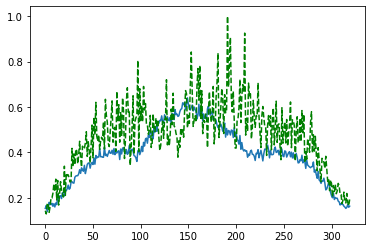

Time taken for epoch:  153.12970972061157
Epoch = [122/3000]  Iter = [   0/39480]  Loss = 0.1366 Avg Loss = 0.1366  Time = 0.0722s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [122/3000]  Iter = [ 100/39480]  Loss = 0.1356 Avg Loss = 0.1475  Time = 0.0030s
Epoch = [122/3000]  Iter = [ 200/39480]  Loss = 0.1597 Avg Loss = 0.1523  Time = 0.0037s
Epoch = [122/3000]  Iter = [ 300/39480]  Loss = 0.1535 Avg Loss = 0.1548  Time = 0.0037s
Epoch = [122/3000]  Iter = [ 400/39480]  Loss = 0.172 Avg Loss = 0.155  Time = 0.0036s
Epoch = [122/3000]  Iter = [ 500/39480]  Loss = 0.1592 Avg Loss = 0.1563  Time = 0.0036s
Epoch = [122/3000]  Iter = [ 600/39480]  Loss = 0.1492 Avg Loss = 0.1556  Time = 0.0034s
Epoch = [122/3000]  Iter = [ 700/39480]  Loss = 0.149 Avg Loss = 0.1554  Time = 0.0035s
Epoch = [122/3000]  Iter = [ 800/39480]  Loss = 0.1655 Avg Loss = 0.1574  Time = 0.0036s
Epoch = [122/3000]  Iter = [ 900/39480]  Loss = 0.1491 Avg Loss = 0.156  Time = 0.0035s
Epoch = [122/3000]  Iter = [1000/39480]  Loss = 0.1517 Avg Loss = 0.1568  Time = 0.0034s
Epoch = [122/3000]  Iter = [1100/39480]  Loss = 0.1504 Avg Loss = 0.1574  Time = 0.0034s
Epoch = [122/3000]  Iter 

Epoch = [122/3000]  Iter = [9400/39480]  Loss = 0.1821 Avg Loss = 0.1573  Time = 0.0035s
Epoch = [122/3000]  Iter = [9500/39480]  Loss = 0.1477 Avg Loss = 0.1563  Time = 0.0036s
Epoch = [122/3000]  Iter = [9600/39480]  Loss = 0.1451 Avg Loss = 0.1558  Time = 0.0036s
Epoch = [122/3000]  Iter = [9700/39480]  Loss = 0.1588 Avg Loss = 0.1553  Time = 0.0036s
Epoch = [122/3000]  Iter = [9800/39480]  Loss = 0.1784 Avg Loss = 0.1569  Time = 0.0036s
Epoch = [122/3000]  Iter = [9900/39480]  Loss = 0.1407 Avg Loss = 0.1567  Time = 0.0036s
Epoch = [122/3000]  Iter = [10000/39480]  Loss = 0.1491 Avg Loss = 0.1578  Time = 0.0036s
Epoch = [122/3000]  Iter = [10100/39480]  Loss = 0.1271 Avg Loss = 0.1578  Time = 0.0035s
Epoch = [122/3000]  Iter = [10200/39480]  Loss = 0.169 Avg Loss = 0.1562  Time = 0.0036s
Epoch = [122/3000]  Iter = [10300/39480]  Loss = 0.1408 Avg Loss = 0.1561  Time = 0.0035s
Epoch = [122/3000]  Iter = [10400/39480]  Loss = 0.1516 Avg Loss = 0.1567  Time = 0.0036s
Epoch = [122/3000

Epoch = [122/3000]  Iter = [18600/39480]  Loss = 0.1574 Avg Loss = 0.158  Time = 0.0032s
Epoch = [122/3000]  Iter = [18700/39480]  Loss = 0.1493 Avg Loss = 0.1544  Time = 0.0031s
Epoch = [122/3000]  Iter = [18800/39480]  Loss = 0.1709 Avg Loss = 0.156  Time = 0.0033s
Epoch = [122/3000]  Iter = [18900/39480]  Loss = 0.1561 Avg Loss = 0.1555  Time = 0.0034s
Epoch = [122/3000]  Iter = [19000/39480]  Loss = 0.1735 Avg Loss = 0.1554  Time = 0.0033s
Epoch = [122/3000]  Iter = [19100/39480]  Loss = 0.1525 Avg Loss = 0.1539  Time = 0.0032s
Epoch = [122/3000]  Iter = [19200/39480]  Loss = 0.1493 Avg Loss = 0.1557  Time = 0.0034s
Epoch = [122/3000]  Iter = [19300/39480]  Loss = 0.1494 Avg Loss = 0.156  Time = 0.0034s
Epoch = [122/3000]  Iter = [19400/39480]  Loss = 0.1423 Avg Loss = 0.1561  Time = 0.0034s
Epoch = [122/3000]  Iter = [19500/39480]  Loss = 0.1713 Avg Loss = 0.1568  Time = 0.0034s
Epoch = [122/3000]  Iter = [19600/39480]  Loss = 0.1352 Avg Loss = 0.1558  Time = 0.0034s
Epoch = [122/

Epoch = [122/3000]  Iter = [27800/39480]  Loss = 0.1512 Avg Loss = 0.1565  Time = 0.0031s
Epoch = [122/3000]  Iter = [27900/39480]  Loss = 0.1513 Avg Loss = 0.1567  Time = 0.0036s
Epoch = [122/3000]  Iter = [28000/39480]  Loss = 0.1493 Avg Loss = 0.1573  Time = 0.0036s
Epoch = [122/3000]  Iter = [28100/39480]  Loss = 0.16 Avg Loss = 0.1583  Time = 0.0036s
Epoch = [122/3000]  Iter = [28200/39480]  Loss = 0.1693 Avg Loss = 0.1577  Time = 0.0032s
Epoch = [122/3000]  Iter = [28300/39480]  Loss = 0.1454 Avg Loss = 0.1587  Time = 0.0035s
Epoch = [122/3000]  Iter = [28400/39480]  Loss = 0.1454 Avg Loss = 0.158  Time = 0.0036s
Epoch = [122/3000]  Iter = [28500/39480]  Loss = 0.1534 Avg Loss = 0.1582  Time = 0.0035s
Epoch = [122/3000]  Iter = [28600/39480]  Loss = 0.1624 Avg Loss = 0.1583  Time = 0.0036s
Epoch = [122/3000]  Iter = [28700/39480]  Loss = 0.166 Avg Loss = 0.1592  Time = 0.0036s
Epoch = [122/3000]  Iter = [28800/39480]  Loss = 0.162 Avg Loss = 0.1576  Time = 0.0034s
Epoch = [122/30

Epoch = [122/3000]  Iter = [37000/39480]  Loss = 0.1484 Avg Loss = 0.158  Time = 0.0034s
Epoch = [122/3000]  Iter = [37100/39480]  Loss = 0.1546 Avg Loss = 0.1579  Time = 0.0036s
Epoch = [122/3000]  Iter = [37200/39480]  Loss = 0.1834 Avg Loss = 0.1577  Time = 0.0035s
Epoch = [122/3000]  Iter = [37300/39480]  Loss = 0.1545 Avg Loss = 0.1571  Time = 0.0035s
Epoch = [122/3000]  Iter = [37400/39480]  Loss = 0.1506 Avg Loss = 0.1575  Time = 0.0032s
Epoch = [122/3000]  Iter = [37500/39480]  Loss = 0.1482 Avg Loss = 0.1569  Time = 0.0036s
Epoch = [122/3000]  Iter = [37600/39480]  Loss = 0.1589 Avg Loss = 0.1583  Time = 0.0035s
Epoch = [122/3000]  Iter = [37700/39480]  Loss = 0.1706 Avg Loss = 0.1572  Time = 0.0035s
Epoch = [122/3000]  Iter = [37800/39480]  Loss = 0.1584 Avg Loss = 0.1561  Time = 0.0031s
Epoch = [122/3000]  Iter = [37900/39480]  Loss = 0.1616 Avg Loss = 0.157  Time = 0.0031s
Epoch = [122/3000]  Iter = [38000/39480]  Loss = 0.1344 Avg Loss = 0.1573  Time = 0.0035s
Epoch = [122

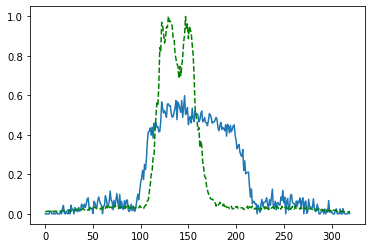

Time taken for epoch:  152.8123655319214
Epoch = [123/3000]  Iter = [   0/39480]  Loss = 0.1579 Avg Loss = 0.1579  Time = 0.0640s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [123/3000]  Iter = [ 100/39480]  Loss = 0.1563 Avg Loss = 0.1555  Time = 0.0030s
Epoch = [123/3000]  Iter = [ 200/39480]  Loss = 0.1598 Avg Loss = 0.1556  Time = 0.0035s
Epoch = [123/3000]  Iter = [ 300/39480]  Loss = 0.1626 Avg Loss = 0.1548  Time = 0.0034s
Epoch = [123/3000]  Iter = [ 400/39480]  Loss = 0.1769 Avg Loss = 0.1557  Time = 0.0037s
Epoch = [123/3000]  Iter = [ 500/39480]  Loss = 0.1452 Avg Loss = 0.1553  Time = 0.0034s
Epoch = [123/3000]  Iter = [ 600/39480]  Loss = 0.142 Avg Loss = 0.1563  Time = 0.0036s
Epoch = [123/3000]  Iter = [ 700/39480]  Loss = 0.1421 Avg Loss = 0.1571  Time = 0.0035s
Epoch = [123/3000]  Iter = [ 800/39480]  Loss = 0.1328 Avg Loss = 0.1559  Time = 0.0036s
Epoch = [123/3000]  Iter = [ 900/39480]  Loss = 0.1489 Avg Loss = 0.155  Time = 0.0035s
Epoch = [123/3000]  Iter = [1000/39480]  Loss = 0.1514 Avg Loss = 0.1557  Time = 0.0035s
Epoch = [123/3000]  Iter = [1100/39480]  Loss = 0.1684 Avg Loss = 0.1567  Time = 0.0033s
Epoch = [123/3000]  Ite

Epoch = [123/3000]  Iter = [9400/39480]  Loss = 0.1304 Avg Loss = 0.1574  Time = 0.0035s
Epoch = [123/3000]  Iter = [9500/39480]  Loss = 0.1811 Avg Loss = 0.1581  Time = 0.0035s
Epoch = [123/3000]  Iter = [9600/39480]  Loss = 0.1452 Avg Loss = 0.1572  Time = 0.0035s
Epoch = [123/3000]  Iter = [9700/39480]  Loss = 0.1681 Avg Loss = 0.1583  Time = 0.0035s
Epoch = [123/3000]  Iter = [9800/39480]  Loss = 0.1245 Avg Loss = 0.1557  Time = 0.0034s
Epoch = [123/3000]  Iter = [9900/39480]  Loss = 0.1603 Avg Loss = 0.1571  Time = 0.0035s
Epoch = [123/3000]  Iter = [10000/39480]  Loss = 0.148 Avg Loss = 0.1581  Time = 0.0035s
Epoch = [123/3000]  Iter = [10100/39480]  Loss = 0.156 Avg Loss = 0.1553  Time = 0.0034s
Epoch = [123/3000]  Iter = [10200/39480]  Loss = 0.1744 Avg Loss = 0.1539  Time = 0.0058s
Epoch = [123/3000]  Iter = [10300/39480]  Loss = 0.1675 Avg Loss = 0.1584  Time = 0.0035s
Epoch = [123/3000]  Iter = [10400/39480]  Loss = 0.1491 Avg Loss = 0.157  Time = 0.0032s
Epoch = [123/3000] 

Epoch = [123/3000]  Iter = [18600/39480]  Loss = 0.1767 Avg Loss = 0.1575  Time = 0.0036s
Epoch = [123/3000]  Iter = [18700/39480]  Loss = 0.1676 Avg Loss = 0.1559  Time = 0.0035s
Epoch = [123/3000]  Iter = [18800/39480]  Loss = 0.172 Avg Loss = 0.1549  Time = 0.0035s
Epoch = [123/3000]  Iter = [18900/39480]  Loss = 0.1598 Avg Loss = 0.1567  Time = 0.0035s
Epoch = [123/3000]  Iter = [19000/39480]  Loss = 0.1565 Avg Loss = 0.1572  Time = 0.0035s
Epoch = [123/3000]  Iter = [19100/39480]  Loss = 0.1629 Avg Loss = 0.1567  Time = 0.0036s
Epoch = [123/3000]  Iter = [19200/39480]  Loss = 0.1397 Avg Loss = 0.1554  Time = 0.0036s
Epoch = [123/3000]  Iter = [19300/39480]  Loss = 0.1492 Avg Loss = 0.1557  Time = 0.0035s
Epoch = [123/3000]  Iter = [19400/39480]  Loss = 0.1727 Avg Loss = 0.1558  Time = 0.0036s
Epoch = [123/3000]  Iter = [19500/39480]  Loss = 0.1488 Avg Loss = 0.1566  Time = 0.0035s
Epoch = [123/3000]  Iter = [19600/39480]  Loss = 0.1515 Avg Loss = 0.1568  Time = 0.0036s
Epoch = [12

Epoch = [123/3000]  Iter = [27800/39480]  Loss = 0.1537 Avg Loss = 0.1575  Time = 0.0035s
Epoch = [123/3000]  Iter = [27900/39480]  Loss = 0.1526 Avg Loss = 0.1544  Time = 0.0035s
Epoch = [123/3000]  Iter = [28000/39480]  Loss = 0.1578 Avg Loss = 0.157  Time = 0.0033s
Epoch = [123/3000]  Iter = [28100/39480]  Loss = 0.1409 Avg Loss = 0.1567  Time = 0.0035s
Epoch = [123/3000]  Iter = [28200/39480]  Loss = 0.1494 Avg Loss = 0.1576  Time = 0.0035s
Epoch = [123/3000]  Iter = [28300/39480]  Loss = 0.1398 Avg Loss = 0.1581  Time = 0.0035s
Epoch = [123/3000]  Iter = [28400/39480]  Loss = 0.174 Avg Loss = 0.1558  Time = 0.0035s
Epoch = [123/3000]  Iter = [28500/39480]  Loss = 0.1403 Avg Loss = 0.157  Time = 0.0036s
Epoch = [123/3000]  Iter = [28600/39480]  Loss = 0.1652 Avg Loss = 0.1557  Time = 0.0035s
Epoch = [123/3000]  Iter = [28700/39480]  Loss = 0.1524 Avg Loss = 0.1566  Time = 0.0031s
Epoch = [123/3000]  Iter = [28800/39480]  Loss = 0.1675 Avg Loss = 0.1556  Time = 0.0035s
Epoch = [123/

Epoch = [123/3000]  Iter = [37000/39480]  Loss = 0.1491 Avg Loss = 0.1565  Time = 0.0033s
Epoch = [123/3000]  Iter = [37100/39480]  Loss = 0.157 Avg Loss = 0.1578  Time = 0.0031s
Epoch = [123/3000]  Iter = [37200/39480]  Loss = 0.13 Avg Loss = 0.158  Time = 0.0031s
Epoch = [123/3000]  Iter = [37300/39480]  Loss = 0.1745 Avg Loss = 0.1582  Time = 0.0032s
Epoch = [123/3000]  Iter = [37400/39480]  Loss = 0.1581 Avg Loss = 0.1579  Time = 0.0035s
Epoch = [123/3000]  Iter = [37500/39480]  Loss = 0.1566 Avg Loss = 0.1572  Time = 0.0036s
Epoch = [123/3000]  Iter = [37600/39480]  Loss = 0.1451 Avg Loss = 0.1565  Time = 0.0035s
Epoch = [123/3000]  Iter = [37700/39480]  Loss = 0.1384 Avg Loss = 0.1565  Time = 0.0036s
Epoch = [123/3000]  Iter = [37800/39480]  Loss = 0.1712 Avg Loss = 0.1563  Time = 0.0035s
Epoch = [123/3000]  Iter = [37900/39480]  Loss = 0.1682 Avg Loss = 0.1548  Time = 0.0035s
Epoch = [123/3000]  Iter = [38000/39480]  Loss = 0.1572 Avg Loss = 0.1566  Time = 0.0036s
Epoch = [123/3

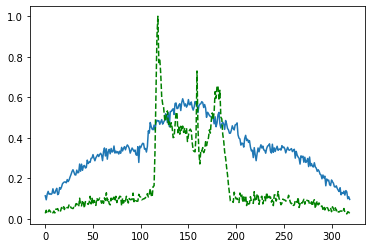

Time taken for epoch:  152.78950715065002
Epoch = [124/3000]  Iter = [   0/39480]  Loss = 0.1694 Avg Loss = 0.1694  Time = 0.0802s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [124/3000]  Iter = [ 100/39480]  Loss = 0.1575 Avg Loss = 0.1606  Time = 0.0030s
Epoch = [124/3000]  Iter = [ 200/39480]  Loss = 0.1625 Avg Loss = 0.159  Time = 0.0036s
Epoch = [124/3000]  Iter = [ 300/39480]  Loss = 0.172 Avg Loss = 0.1557  Time = 0.0037s
Epoch = [124/3000]  Iter = [ 400/39480]  Loss = 0.1868 Avg Loss = 0.1547  Time = 0.0036s
Epoch = [124/3000]  Iter = [ 500/39480]  Loss = 0.1622 Avg Loss = 0.1574  Time = 0.0036s
Epoch = [124/3000]  Iter = [ 600/39480]  Loss = 0.1737 Avg Loss = 0.1569  Time = 0.0029s
Epoch = [124/3000]  Iter = [ 700/39480]  Loss = 0.1816 Avg Loss = 0.1575  Time = 0.0029s
Epoch = [124/3000]  Iter = [ 800/39480]  Loss = 0.1587 Avg Loss = 0.1577  Time = 0.0029s
Epoch = [124/3000]  Iter = [ 900/39480]  Loss = 0.1486 Avg Loss = 0.156  Time = 0.0029s
Epoch = [124/3000]  Iter = [1000/39480]  Loss = 0.1343 Avg Loss = 0.1551  Time = 0.0028s
Epoch = [124/3000]  Iter = [1100/39480]  Loss = 0.1555 Avg Loss = 0.1554  Time = 0.0029s
Epoch = [124/3000]  Iter

Epoch = [124/3000]  Iter = [9400/39480]  Loss = 0.1523 Avg Loss = 0.1565  Time = 0.0035s
Epoch = [124/3000]  Iter = [9500/39480]  Loss = 0.1711 Avg Loss = 0.1568  Time = 0.0033s
Epoch = [124/3000]  Iter = [9600/39480]  Loss = 0.1688 Avg Loss = 0.1571  Time = 0.0035s
Epoch = [124/3000]  Iter = [9700/39480]  Loss = 0.1666 Avg Loss = 0.1595  Time = 0.0036s
Epoch = [124/3000]  Iter = [9800/39480]  Loss = 0.1716 Avg Loss = 0.1589  Time = 0.0035s
Epoch = [124/3000]  Iter = [9900/39480]  Loss = 0.1586 Avg Loss = 0.1595  Time = 0.0036s
Epoch = [124/3000]  Iter = [10000/39480]  Loss = 0.1591 Avg Loss = 0.1567  Time = 0.0036s
Epoch = [124/3000]  Iter = [10100/39480]  Loss = 0.1545 Avg Loss = 0.1558  Time = 0.0032s
Epoch = [124/3000]  Iter = [10200/39480]  Loss = 0.1803 Avg Loss = 0.1581  Time = 0.0035s
Epoch = [124/3000]  Iter = [10300/39480]  Loss = 0.1402 Avg Loss = 0.1569  Time = 0.0035s
Epoch = [124/3000]  Iter = [10400/39480]  Loss = 0.1512 Avg Loss = 0.1586  Time = 0.0036s
Epoch = [124/300

Epoch = [124/3000]  Iter = [18600/39480]  Loss = 0.1621 Avg Loss = 0.1565  Time = 0.0035s
Epoch = [124/3000]  Iter = [18700/39480]  Loss = 0.1429 Avg Loss = 0.1588  Time = 0.0031s
Epoch = [124/3000]  Iter = [18800/39480]  Loss = 0.161 Avg Loss = 0.1584  Time = 0.0028s
Epoch = [124/3000]  Iter = [18900/39480]  Loss = 0.16 Avg Loss = 0.1571  Time = 0.0027s
Epoch = [124/3000]  Iter = [19000/39480]  Loss = 0.1462 Avg Loss = 0.1564  Time = 0.0031s
Epoch = [124/3000]  Iter = [19100/39480]  Loss = 0.1534 Avg Loss = 0.1582  Time = 0.0031s
Epoch = [124/3000]  Iter = [19200/39480]  Loss = 0.1555 Avg Loss = 0.1579  Time = 0.0035s
Epoch = [124/3000]  Iter = [19300/39480]  Loss = 0.1545 Avg Loss = 0.1576  Time = 0.0035s
Epoch = [124/3000]  Iter = [19400/39480]  Loss = 0.1431 Avg Loss = 0.1559  Time = 0.0036s
Epoch = [124/3000]  Iter = [19500/39480]  Loss = 0.1693 Avg Loss = 0.1564  Time = 0.0035s
Epoch = [124/3000]  Iter = [19600/39480]  Loss = 0.1829 Avg Loss = 0.1573  Time = 0.0033s
Epoch = [124/

Epoch = [124/3000]  Iter = [27800/39480]  Loss = 0.1456 Avg Loss = 0.1565  Time = 0.0035s
Epoch = [124/3000]  Iter = [27900/39480]  Loss = 0.159 Avg Loss = 0.1572  Time = 0.0036s
Epoch = [124/3000]  Iter = [28000/39480]  Loss = 0.1663 Avg Loss = 0.1566  Time = 0.0034s
Epoch = [124/3000]  Iter = [28100/39480]  Loss = 0.1434 Avg Loss = 0.1551  Time = 0.0037s
Epoch = [124/3000]  Iter = [28200/39480]  Loss = 0.13 Avg Loss = 0.158  Time = 0.0035s
Epoch = [124/3000]  Iter = [28300/39480]  Loss = 0.1764 Avg Loss = 0.1577  Time = 0.0035s
Epoch = [124/3000]  Iter = [28400/39480]  Loss = 0.1721 Avg Loss = 0.1573  Time = 0.0036s
Epoch = [124/3000]  Iter = [28500/39480]  Loss = 0.1553 Avg Loss = 0.1579  Time = 0.0034s
Epoch = [124/3000]  Iter = [28600/39480]  Loss = 0.1562 Avg Loss = 0.1583  Time = 0.0034s
Epoch = [124/3000]  Iter = [28700/39480]  Loss = 0.1492 Avg Loss = 0.1581  Time = 0.0036s
Epoch = [124/3000]  Iter = [28800/39480]  Loss = 0.1768 Avg Loss = 0.1578  Time = 0.0036s
Epoch = [124/3

Epoch = [124/3000]  Iter = [37000/39480]  Loss = 0.1539 Avg Loss = 0.1574  Time = 0.0035s
Epoch = [124/3000]  Iter = [37100/39480]  Loss = 0.1576 Avg Loss = 0.1582  Time = 0.0035s
Epoch = [124/3000]  Iter = [37200/39480]  Loss = 0.1307 Avg Loss = 0.1583  Time = 0.0031s
Epoch = [124/3000]  Iter = [37300/39480]  Loss = 0.1632 Avg Loss = 0.1559  Time = 0.0033s
Epoch = [124/3000]  Iter = [37400/39480]  Loss = 0.147 Avg Loss = 0.1573  Time = 0.0036s
Epoch = [124/3000]  Iter = [37500/39480]  Loss = 0.1585 Avg Loss = 0.1569  Time = 0.0034s
Epoch = [124/3000]  Iter = [37600/39480]  Loss = 0.1174 Avg Loss = 0.157  Time = 0.0035s
Epoch = [124/3000]  Iter = [37700/39480]  Loss = 0.1728 Avg Loss = 0.1577  Time = 0.0034s
Epoch = [124/3000]  Iter = [37800/39480]  Loss = 0.1468 Avg Loss = 0.1566  Time = 0.0033s
Epoch = [124/3000]  Iter = [37900/39480]  Loss = 0.1605 Avg Loss = 0.1549  Time = 0.0035s
Epoch = [124/3000]  Iter = [38000/39480]  Loss = 0.1607 Avg Loss = 0.1562  Time = 0.0035s
Epoch = [124

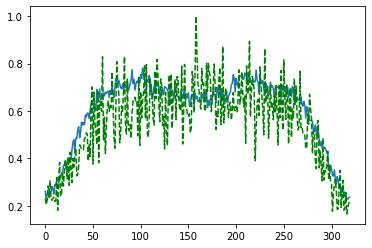

Time taken for epoch:  152.28480529785156
Epoch = [125/3000]  Iter = [   0/39480]  Loss = 0.1365 Avg Loss = 0.1365  Time = 0.0628s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [125/3000]  Iter = [ 100/39480]  Loss = 0.1796 Avg Loss = 0.1491  Time = 0.0036s
Epoch = [125/3000]  Iter = [ 200/39480]  Loss = 0.1761 Avg Loss = 0.1544  Time = 0.0036s
Epoch = [125/3000]  Iter = [ 300/39480]  Loss = 0.1519 Avg Loss = 0.1547  Time = 0.0035s
Epoch = [125/3000]  Iter = [ 400/39480]  Loss = 0.1578 Avg Loss = 0.1558  Time = 0.0035s
Epoch = [125/3000]  Iter = [ 500/39480]  Loss = 0.1629 Avg Loss = 0.1545  Time = 0.0036s
Epoch = [125/3000]  Iter = [ 600/39480]  Loss = 0.1738 Avg Loss = 0.1547  Time = 0.0036s
Epoch = [125/3000]  Iter = [ 700/39480]  Loss = 0.1713 Avg Loss = 0.1573  Time = 0.0028s
Epoch = [125/3000]  Iter = [ 800/39480]  Loss = 0.1871 Avg Loss = 0.1576  Time = 0.0035s
Epoch = [125/3000]  Iter = [ 900/39480]  Loss = 0.1333 Avg Loss = 0.156  Time = 0.0036s
Epoch = [125/3000]  Iter = [1000/39480]  Loss = 0.19 Avg Loss = 0.1567  Time = 0.0036s
Epoch = [125/3000]  Iter = [1100/39480]  Loss = 0.1866 Avg Loss = 0.1586  Time = 0.0035s
Epoch = [125/3000]  Iter

Epoch = [125/3000]  Iter = [9400/39480]  Loss = 0.1551 Avg Loss = 0.158  Time = 0.0037s
Epoch = [125/3000]  Iter = [9500/39480]  Loss = 0.145 Avg Loss = 0.1571  Time = 0.0035s
Epoch = [125/3000]  Iter = [9600/39480]  Loss = 0.1967 Avg Loss = 0.1578  Time = 0.0035s
Epoch = [125/3000]  Iter = [9700/39480]  Loss = 0.1516 Avg Loss = 0.1568  Time = 0.0035s
Epoch = [125/3000]  Iter = [9800/39480]  Loss = 0.1342 Avg Loss = 0.1559  Time = 0.0035s
Epoch = [125/3000]  Iter = [9900/39480]  Loss = 0.1843 Avg Loss = 0.1587  Time = 0.0033s
Epoch = [125/3000]  Iter = [10000/39480]  Loss = 0.1498 Avg Loss = 0.1578  Time = 0.0035s
Epoch = [125/3000]  Iter = [10100/39480]  Loss = 0.148 Avg Loss = 0.1564  Time = 0.0035s
Epoch = [125/3000]  Iter = [10200/39480]  Loss = 0.1452 Avg Loss = 0.1561  Time = 0.0033s
Epoch = [125/3000]  Iter = [10300/39480]  Loss = 0.1599 Avg Loss = 0.157  Time = 0.0036s
Epoch = [125/3000]  Iter = [10400/39480]  Loss = 0.1267 Avg Loss = 0.1573  Time = 0.0037s
Epoch = [125/3000]  

Epoch = [125/3000]  Iter = [18600/39480]  Loss = 0.1464 Avg Loss = 0.1574  Time = 0.0036s
Epoch = [125/3000]  Iter = [18700/39480]  Loss = 0.137 Avg Loss = 0.1554  Time = 0.0036s
Epoch = [125/3000]  Iter = [18800/39480]  Loss = 0.1404 Avg Loss = 0.1563  Time = 0.0032s
Epoch = [125/3000]  Iter = [18900/39480]  Loss = 0.159 Avg Loss = 0.1551  Time = 0.0035s
Epoch = [125/3000]  Iter = [19000/39480]  Loss = 0.1638 Avg Loss = 0.1563  Time = 0.0036s
Epoch = [125/3000]  Iter = [19100/39480]  Loss = 0.1567 Avg Loss = 0.1573  Time = 0.0035s
Epoch = [125/3000]  Iter = [19200/39480]  Loss = 0.1697 Avg Loss = 0.1578  Time = 0.0036s
Epoch = [125/3000]  Iter = [19300/39480]  Loss = 0.1368 Avg Loss = 0.157  Time = 0.0036s
Epoch = [125/3000]  Iter = [19400/39480]  Loss = 0.1701 Avg Loss = 0.1565  Time = 0.0035s
Epoch = [125/3000]  Iter = [19500/39480]  Loss = 0.1554 Avg Loss = 0.1555  Time = 0.0035s
Epoch = [125/3000]  Iter = [19600/39480]  Loss = 0.1619 Avg Loss = 0.1568  Time = 0.0035s
Epoch = [125/

Epoch = [125/3000]  Iter = [27800/39480]  Loss = 0.1549 Avg Loss = 0.157  Time = 0.0036s
Epoch = [125/3000]  Iter = [27900/39480]  Loss = 0.1558 Avg Loss = 0.1577  Time = 0.0033s
Epoch = [125/3000]  Iter = [28000/39480]  Loss = 0.1286 Avg Loss = 0.1583  Time = 0.0035s
Epoch = [125/3000]  Iter = [28100/39480]  Loss = 0.1624 Avg Loss = 0.1582  Time = 0.0036s
Epoch = [125/3000]  Iter = [28200/39480]  Loss = 0.1679 Avg Loss = 0.1588  Time = 0.0035s
Epoch = [125/3000]  Iter = [28300/39480]  Loss = 0.1445 Avg Loss = 0.1588  Time = 0.0033s
Epoch = [125/3000]  Iter = [28400/39480]  Loss = 0.1441 Avg Loss = 0.1569  Time = 0.0035s
Epoch = [125/3000]  Iter = [28500/39480]  Loss = 0.1429 Avg Loss = 0.1579  Time = 0.0036s
Epoch = [125/3000]  Iter = [28600/39480]  Loss = 0.177 Avg Loss = 0.1576  Time = 0.0036s
Epoch = [125/3000]  Iter = [28700/39480]  Loss = 0.1638 Avg Loss = 0.1555  Time = 0.0036s
Epoch = [125/3000]  Iter = [28800/39480]  Loss = 0.1395 Avg Loss = 0.1564  Time = 0.0035s
Epoch = [125

Epoch = [125/3000]  Iter = [37000/39480]  Loss = 0.1371 Avg Loss = 0.1571  Time = 0.0035s
Epoch = [125/3000]  Iter = [37100/39480]  Loss = 0.179 Avg Loss = 0.1564  Time = 0.0033s
Epoch = [125/3000]  Iter = [37200/39480]  Loss = 0.168 Avg Loss = 0.1569  Time = 0.0036s
Epoch = [125/3000]  Iter = [37300/39480]  Loss = 0.1427 Avg Loss = 0.1572  Time = 0.0036s
Epoch = [125/3000]  Iter = [37400/39480]  Loss = 0.1335 Avg Loss = 0.1573  Time = 0.0036s
Epoch = [125/3000]  Iter = [37500/39480]  Loss = 0.1487 Avg Loss = 0.1557  Time = 0.0035s
Epoch = [125/3000]  Iter = [37600/39480]  Loss = 0.1695 Avg Loss = 0.1556  Time = 0.0036s
Epoch = [125/3000]  Iter = [37700/39480]  Loss = 0.1753 Avg Loss = 0.1555  Time = 0.0036s
Epoch = [125/3000]  Iter = [37800/39480]  Loss = 0.1802 Avg Loss = 0.1585  Time = 0.0036s
Epoch = [125/3000]  Iter = [37900/39480]  Loss = 0.1571 Avg Loss = 0.1584  Time = 0.0035s
Epoch = [125/3000]  Iter = [38000/39480]  Loss = 0.1804 Avg Loss = 0.1597  Time = 0.0031s
Epoch = [125

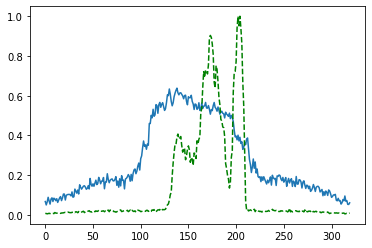

Time taken for epoch:  152.70043349266052
Epoch = [126/3000]  Iter = [   0/39480]  Loss = 0.1452 Avg Loss = 0.1452  Time = 0.0720s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [126/3000]  Iter = [ 100/39480]  Loss = 0.1532 Avg Loss = 0.1522  Time = 0.0035s
Epoch = [126/3000]  Iter = [ 200/39480]  Loss = 0.1378 Avg Loss = 0.1551  Time = 0.0036s
Epoch = [126/3000]  Iter = [ 300/39480]  Loss = 0.1448 Avg Loss = 0.1563  Time = 0.0035s
Epoch = [126/3000]  Iter = [ 400/39480]  Loss = 0.1693 Avg Loss = 0.1571  Time = 0.0036s
Epoch = [126/3000]  Iter = [ 500/39480]  Loss = 0.1558 Avg Loss = 0.1546  Time = 0.0036s
Epoch = [126/3000]  Iter = [ 600/39480]  Loss = 0.1633 Avg Loss = 0.1572  Time = 0.0036s
Epoch = [126/3000]  Iter = [ 700/39480]  Loss = 0.1525 Avg Loss = 0.1562  Time = 0.0036s
Epoch = [126/3000]  Iter = [ 800/39480]  Loss = 0.1662 Avg Loss = 0.1553  Time = 0.0036s
Epoch = [126/3000]  Iter = [ 900/39480]  Loss = 0.1611 Avg Loss = 0.1566  Time = 0.0037s
Epoch = [126/3000]  Iter = [1000/39480]  Loss = 0.1565 Avg Loss = 0.1563  Time = 0.0035s
Epoch = [126/3000]  Iter = [1100/39480]  Loss = 0.1412 Avg Loss = 0.1576  Time = 0.0035s
Epoch = [126/3000]  I

Epoch = [126/3000]  Iter = [9400/39480]  Loss = 0.1316 Avg Loss = 0.1549  Time = 0.0036s
Epoch = [126/3000]  Iter = [9500/39480]  Loss = 0.1417 Avg Loss = 0.156  Time = 0.0031s
Epoch = [126/3000]  Iter = [9600/39480]  Loss = 0.139 Avg Loss = 0.1552  Time = 0.0032s
Epoch = [126/3000]  Iter = [9700/39480]  Loss = 0.1518 Avg Loss = 0.1563  Time = 0.0036s
Epoch = [126/3000]  Iter = [9800/39480]  Loss = 0.1693 Avg Loss = 0.1583  Time = 0.0035s
Epoch = [126/3000]  Iter = [9900/39480]  Loss = 0.1461 Avg Loss = 0.1564  Time = 0.0034s
Epoch = [126/3000]  Iter = [10000/39480]  Loss = 0.1635 Avg Loss = 0.1557  Time = 0.0033s
Epoch = [126/3000]  Iter = [10100/39480]  Loss = 0.1695 Avg Loss = 0.1562  Time = 0.0034s
Epoch = [126/3000]  Iter = [10200/39480]  Loss = 0.1662 Avg Loss = 0.1552  Time = 0.0032s
Epoch = [126/3000]  Iter = [10300/39480]  Loss = 0.166 Avg Loss = 0.1567  Time = 0.0033s
Epoch = [126/3000]  Iter = [10400/39480]  Loss = 0.1563 Avg Loss = 0.156  Time = 0.0035s
Epoch = [126/3000]  

Epoch = [126/3000]  Iter = [18600/39480]  Loss = 0.1497 Avg Loss = 0.1559  Time = 0.0037s
Epoch = [126/3000]  Iter = [18700/39480]  Loss = 0.1423 Avg Loss = 0.1569  Time = 0.0036s
Epoch = [126/3000]  Iter = [18800/39480]  Loss = 0.1754 Avg Loss = 0.157  Time = 0.0036s
Epoch = [126/3000]  Iter = [18900/39480]  Loss = 0.1513 Avg Loss = 0.1569  Time = 0.0037s
Epoch = [126/3000]  Iter = [19000/39480]  Loss = 0.1519 Avg Loss = 0.1574  Time = 0.0036s
Epoch = [126/3000]  Iter = [19100/39480]  Loss = 0.1964 Avg Loss = 0.1576  Time = 0.0030s
Epoch = [126/3000]  Iter = [19200/39480]  Loss = 0.1542 Avg Loss = 0.1555  Time = 0.0029s
Epoch = [126/3000]  Iter = [19300/39480]  Loss = 0.1511 Avg Loss = 0.1559  Time = 0.0036s
Epoch = [126/3000]  Iter = [19400/39480]  Loss = 0.1558 Avg Loss = 0.1564  Time = 0.0035s
Epoch = [126/3000]  Iter = [19500/39480]  Loss = 0.1415 Avg Loss = 0.1552  Time = 0.0035s
Epoch = [126/3000]  Iter = [19600/39480]  Loss = 0.1647 Avg Loss = 0.157  Time = 0.0036s
Epoch = [126

Epoch = [126/3000]  Iter = [27800/39480]  Loss = 0.1496 Avg Loss = 0.1567  Time = 0.0031s
Epoch = [126/3000]  Iter = [27900/39480]  Loss = 0.1667 Avg Loss = 0.1576  Time = 0.0035s
Epoch = [126/3000]  Iter = [28000/39480]  Loss = 0.1422 Avg Loss = 0.1561  Time = 0.0032s
Epoch = [126/3000]  Iter = [28100/39480]  Loss = 0.17 Avg Loss = 0.1559  Time = 0.0032s
Epoch = [126/3000]  Iter = [28200/39480]  Loss = 0.1474 Avg Loss = 0.1566  Time = 0.0035s
Epoch = [126/3000]  Iter = [28300/39480]  Loss = 0.1611 Avg Loss = 0.1568  Time = 0.0036s
Epoch = [126/3000]  Iter = [28400/39480]  Loss = 0.1546 Avg Loss = 0.1575  Time = 0.0036s
Epoch = [126/3000]  Iter = [28500/39480]  Loss = 0.1438 Avg Loss = 0.157  Time = 0.0036s
Epoch = [126/3000]  Iter = [28600/39480]  Loss = 0.1586 Avg Loss = 0.1572  Time = 0.0032s
Epoch = [126/3000]  Iter = [28700/39480]  Loss = 0.1631 Avg Loss = 0.1586  Time = 0.0035s
Epoch = [126/3000]  Iter = [28800/39480]  Loss = 0.1439 Avg Loss = 0.1574  Time = 0.0036s
Epoch = [126/

Epoch = [126/3000]  Iter = [37000/39480]  Loss = 0.159 Avg Loss = 0.157  Time = 0.0035s
Epoch = [126/3000]  Iter = [37100/39480]  Loss = 0.1668 Avg Loss = 0.1581  Time = 0.0035s
Epoch = [126/3000]  Iter = [37200/39480]  Loss = 0.1502 Avg Loss = 0.159  Time = 0.0036s
Epoch = [126/3000]  Iter = [37300/39480]  Loss = 0.1685 Avg Loss = 0.1594  Time = 0.0036s
Epoch = [126/3000]  Iter = [37400/39480]  Loss = 0.1737 Avg Loss = 0.1578  Time = 0.0035s
Epoch = [126/3000]  Iter = [37500/39480]  Loss = 0.1569 Avg Loss = 0.1567  Time = 0.0036s
Epoch = [126/3000]  Iter = [37600/39480]  Loss = 0.1508 Avg Loss = 0.1566  Time = 0.0032s
Epoch = [126/3000]  Iter = [37700/39480]  Loss = 0.1694 Avg Loss = 0.1576  Time = 0.0034s
Epoch = [126/3000]  Iter = [37800/39480]  Loss = 0.128 Avg Loss = 0.1559  Time = 0.0036s
Epoch = [126/3000]  Iter = [37900/39480]  Loss = 0.1451 Avg Loss = 0.1561  Time = 0.0035s
Epoch = [126/3000]  Iter = [38000/39480]  Loss = 0.1624 Avg Loss = 0.1584  Time = 0.0036s
Epoch = [126/3

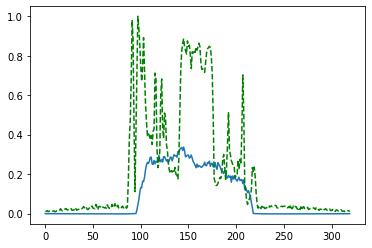

Time taken for epoch:  154.48655915260315
Epoch = [127/3000]  Iter = [   0/39480]  Loss = 0.138 Avg Loss = 0.138  Time = 0.0725s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [127/3000]  Iter = [ 100/39480]  Loss = 0.1551 Avg Loss = 0.1495  Time = 0.0035s
Epoch = [127/3000]  Iter = [ 200/39480]  Loss = 0.1423 Avg Loss = 0.1531  Time = 0.0037s
Epoch = [127/3000]  Iter = [ 300/39480]  Loss = 0.1498 Avg Loss = 0.154  Time = 0.0034s
Epoch = [127/3000]  Iter = [ 400/39480]  Loss = 0.15 Avg Loss = 0.1567  Time = 0.0036s
Epoch = [127/3000]  Iter = [ 500/39480]  Loss = 0.148 Avg Loss = 0.1568  Time = 0.0037s
Epoch = [127/3000]  Iter = [ 600/39480]  Loss = 0.1354 Avg Loss = 0.1565  Time = 0.0037s
Epoch = [127/3000]  Iter = [ 700/39480]  Loss = 0.1751 Avg Loss = 0.1558  Time = 0.0036s
Epoch = [127/3000]  Iter = [ 800/39480]  Loss = 0.1419 Avg Loss = 0.1559  Time = 0.0036s
Epoch = [127/3000]  Iter = [ 900/39480]  Loss = 0.1736 Avg Loss = 0.1574  Time = 0.0037s
Epoch = [127/3000]  Iter = [1000/39480]  Loss = 0.1587 Avg Loss = 0.1579  Time = 0.0037s
Epoch = [127/3000]  Iter = [1100/39480]  Loss = 0.1584 Avg Loss = 0.1565  Time = 0.0036s
Epoch = [127/3000]  Iter 

Epoch = [127/3000]  Iter = [9400/39480]  Loss = 0.161 Avg Loss = 0.1574  Time = 0.0036s
Epoch = [127/3000]  Iter = [9500/39480]  Loss = 0.1494 Avg Loss = 0.1593  Time = 0.0035s
Epoch = [127/3000]  Iter = [9600/39480]  Loss = 0.1696 Avg Loss = 0.1578  Time = 0.0035s
Epoch = [127/3000]  Iter = [9700/39480]  Loss = 0.1739 Avg Loss = 0.1563  Time = 0.0035s
Epoch = [127/3000]  Iter = [9800/39480]  Loss = 0.1904 Avg Loss = 0.1559  Time = 0.0035s
Epoch = [127/3000]  Iter = [9900/39480]  Loss = 0.1661 Avg Loss = 0.1558  Time = 0.0035s
Epoch = [127/3000]  Iter = [10000/39480]  Loss = 0.1695 Avg Loss = 0.157  Time = 0.0036s
Epoch = [127/3000]  Iter = [10100/39480]  Loss = 0.1705 Avg Loss = 0.158  Time = 0.0035s
Epoch = [127/3000]  Iter = [10200/39480]  Loss = 0.1699 Avg Loss = 0.1563  Time = 0.0035s
Epoch = [127/3000]  Iter = [10300/39480]  Loss = 0.162 Avg Loss = 0.1581  Time = 0.0035s
Epoch = [127/3000]  Iter = [10400/39480]  Loss = 0.1561 Avg Loss = 0.158  Time = 0.0035s
Epoch = [127/3000]  I

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch = [143/3000]  Iter = [23000/39480]  Loss = 0.1414 Avg Loss = 0.1563  Time = 0.0030s
Epoch = [143/3000]  Iter = [23100/39480]  Loss = 0.15 Avg Loss = 0.1554  Time = 0.0030s
Epoch = [143/3000]  Iter = [23200/39480]  Loss = 0.1735 Avg Loss = 0.1573  Time = 0.0030s
Epoch = [143/3000]  Iter = [23300/39480]  Loss = 0.1697 Avg Loss = 0.1587  Time = 0.0029s
Epoch = [143/3000]  Iter = [23400/39480]  Loss = 0.1513 Avg Loss = 0.1568  Time = 0.0030s
Epoch = [143/3000]  Iter = [23500/39480]  Loss = 0.1651 Avg Loss = 0.1562  Time = 0.0028s
Epoch = [143/3000]  Iter = [23600/39480]  Loss = 0.1634 Avg Loss = 0.1572  Time = 0.0030s
Epoch = [143/3000]  Iter = [23700/39480]  Loss = 0.1662 Avg Loss = 0.158  Time = 0.0030s
Epoch = [143/3000]  Iter = [23800/39480]  Loss = 0.1451 Avg Loss = 0.1572  Time = 0.0030s
Epoch = [143/3000]  Iter = [23900/39480]  Loss = 0.1477 Avg Loss = 0.1568  Time = 0.0030s
Epoch = [143/3000]  Iter = [24000/39480]  Loss = 0.1441 Avg Loss = 0.1575  Time = 0.0030s
Epoch = [143/

Epoch = [143/3000]  Iter = [32200/39480]  Loss = 0.1271 Avg Loss = 0.1573  Time = 0.0030s
Epoch = [143/3000]  Iter = [32300/39480]  Loss = 0.1418 Avg Loss = 0.1562  Time = 0.0030s
Epoch = [143/3000]  Iter = [32400/39480]  Loss = 0.1376 Avg Loss = 0.1573  Time = 0.0030s
Epoch = [143/3000]  Iter = [32500/39480]  Loss = 0.1338 Avg Loss = 0.1573  Time = 0.0030s
Epoch = [143/3000]  Iter = [32600/39480]  Loss = 0.1699 Avg Loss = 0.1573  Time = 0.0029s
Epoch = [143/3000]  Iter = [32700/39480]  Loss = 0.1519 Avg Loss = 0.1568  Time = 0.0030s
Epoch = [143/3000]  Iter = [32800/39480]  Loss = 0.1661 Avg Loss = 0.1561  Time = 0.0029s
Epoch = [143/3000]  Iter = [32900/39480]  Loss = 0.1486 Avg Loss = 0.1572  Time = 0.0029s
Epoch = [143/3000]  Iter = [33000/39480]  Loss = 0.1445 Avg Loss = 0.1572  Time = 0.0030s
Epoch = [143/3000]  Iter = [33100/39480]  Loss = 0.1599 Avg Loss = 0.1572  Time = 0.0030s
Epoch = [143/3000]  Iter = [33200/39480]  Loss = 0.1493 Avg Loss = 0.1573  Time = 0.0030s
Epoch = [1

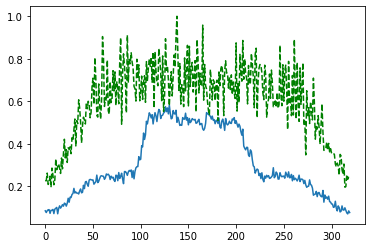

Time taken for epoch:  141.81121921539307
Epoch = [144/3000]  Iter = [   0/39480]  Loss = 0.1821 Avg Loss = 0.1821  Time = 0.0967s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [144/3000]  Iter = [ 100/39480]  Loss = 0.1565 Avg Loss = 0.1674  Time = 0.0031s
Epoch = [144/3000]  Iter = [ 200/39480]  Loss = 0.1474 Avg Loss = 0.1607  Time = 0.0030s
Epoch = [144/3000]  Iter = [ 300/39480]  Loss = 0.1663 Avg Loss = 0.1579  Time = 0.0030s
Epoch = [144/3000]  Iter = [ 400/39480]  Loss = 0.1648 Avg Loss = 0.1554  Time = 0.0030s
Epoch = [144/3000]  Iter = [ 500/39480]  Loss = 0.1394 Avg Loss = 0.1563  Time = 0.0033s
Epoch = [144/3000]  Iter = [ 600/39480]  Loss = 0.1448 Avg Loss = 0.1558  Time = 0.0030s
Epoch = [144/3000]  Iter = [ 700/39480]  Loss = 0.1179 Avg Loss = 0.1562  Time = 0.0032s
Epoch = [144/3000]  Iter = [ 800/39480]  Loss = 0.1709 Avg Loss = 0.1546  Time = 0.0031s
Epoch = [144/3000]  Iter = [ 900/39480]  Loss = 0.1869 Avg Loss = 0.1535  Time = 0.0031s
Epoch = [144/3000]  Iter = [1000/39480]  Loss = 0.1721 Avg Loss = 0.1542  Time = 0.0030s
Epoch = [144/3000]  Iter = [1100/39480]  Loss = 0.1648 Avg Loss = 0.1564  Time = 0.0031s
Epoch = [144/3000]  I

Epoch = [144/3000]  Iter = [9400/39480]  Loss = 0.16 Avg Loss = 0.1574  Time = 0.0031s
Epoch = [144/3000]  Iter = [9500/39480]  Loss = 0.1277 Avg Loss = 0.156  Time = 0.0033s
Epoch = [144/3000]  Iter = [9600/39480]  Loss = 0.1768 Avg Loss = 0.156  Time = 0.0031s
Epoch = [144/3000]  Iter = [9700/39480]  Loss = 0.1587 Avg Loss = 0.1579  Time = 0.0030s
Epoch = [144/3000]  Iter = [9800/39480]  Loss = 0.1543 Avg Loss = 0.1596  Time = 0.0032s
Epoch = [144/3000]  Iter = [9900/39480]  Loss = 0.1484 Avg Loss = 0.159  Time = 0.0030s
Epoch = [144/3000]  Iter = [10000/39480]  Loss = 0.1536 Avg Loss = 0.1567  Time = 0.0030s
Epoch = [144/3000]  Iter = [10100/39480]  Loss = 0.1499 Avg Loss = 0.1543  Time = 0.0030s
Epoch = [144/3000]  Iter = [10200/39480]  Loss = 0.1482 Avg Loss = 0.1532  Time = 0.0031s
Epoch = [144/3000]  Iter = [10300/39480]  Loss = 0.1374 Avg Loss = 0.1563  Time = 0.0033s
Epoch = [144/3000]  Iter = [10400/39480]  Loss = 0.1554 Avg Loss = 0.1572  Time = 0.0030s
Epoch = [144/3000]  I

Epoch = [144/3000]  Iter = [18600/39480]  Loss = 0.1634 Avg Loss = 0.1582  Time = 0.0030s
Epoch = [144/3000]  Iter = [18700/39480]  Loss = 0.1751 Avg Loss = 0.1583  Time = 0.0028s
Epoch = [144/3000]  Iter = [18800/39480]  Loss = 0.1361 Avg Loss = 0.1584  Time = 0.0028s
Epoch = [144/3000]  Iter = [18900/39480]  Loss = 0.16 Avg Loss = 0.1561  Time = 0.0030s
Epoch = [144/3000]  Iter = [19000/39480]  Loss = 0.1548 Avg Loss = 0.1572  Time = 0.0029s
Epoch = [144/3000]  Iter = [19100/39480]  Loss = 0.1572 Avg Loss = 0.1571  Time = 0.0030s
Epoch = [144/3000]  Iter = [19200/39480]  Loss = 0.1679 Avg Loss = 0.1571  Time = 0.0029s
Epoch = [144/3000]  Iter = [19300/39480]  Loss = 0.1446 Avg Loss = 0.1573  Time = 0.0030s
Epoch = [144/3000]  Iter = [19400/39480]  Loss = 0.1414 Avg Loss = 0.1572  Time = 0.0030s
Epoch = [144/3000]  Iter = [19500/39480]  Loss = 0.1696 Avg Loss = 0.1569  Time = 0.0030s
Epoch = [144/3000]  Iter = [19600/39480]  Loss = 0.1362 Avg Loss = 0.1583  Time = 0.0031s
Epoch = [144

Epoch = [144/3000]  Iter = [27800/39480]  Loss = 0.1571 Avg Loss = 0.1573  Time = 0.0030s
Epoch = [144/3000]  Iter = [27900/39480]  Loss = 0.148 Avg Loss = 0.1565  Time = 0.0030s
Epoch = [144/3000]  Iter = [28000/39480]  Loss = 0.1661 Avg Loss = 0.156  Time = 0.0030s
Epoch = [144/3000]  Iter = [28100/39480]  Loss = 0.1475 Avg Loss = 0.1571  Time = 0.0029s
Epoch = [144/3000]  Iter = [28200/39480]  Loss = 0.1425 Avg Loss = 0.1556  Time = 0.0029s
Epoch = [144/3000]  Iter = [28300/39480]  Loss = 0.1425 Avg Loss = 0.1546  Time = 0.0029s
Epoch = [144/3000]  Iter = [28400/39480]  Loss = 0.1576 Avg Loss = 0.1557  Time = 0.0030s
Epoch = [144/3000]  Iter = [28500/39480]  Loss = 0.14 Avg Loss = 0.1557  Time = 0.0030s
Epoch = [144/3000]  Iter = [28600/39480]  Loss = 0.1562 Avg Loss = 0.1572  Time = 0.0030s
Epoch = [144/3000]  Iter = [28700/39480]  Loss = 0.1719 Avg Loss = 0.1567  Time = 0.0030s
Epoch = [144/3000]  Iter = [28800/39480]  Loss = 0.1423 Avg Loss = 0.1563  Time = 0.0030s
Epoch = [144/3

Epoch = [144/3000]  Iter = [37000/39480]  Loss = 0.148 Avg Loss = 0.1566  Time = 0.0029s
Epoch = [144/3000]  Iter = [37100/39480]  Loss = 0.1557 Avg Loss = 0.1563  Time = 0.0030s
Epoch = [144/3000]  Iter = [37200/39480]  Loss = 0.1953 Avg Loss = 0.1581  Time = 0.0030s
Epoch = [144/3000]  Iter = [37300/39480]  Loss = 0.1643 Avg Loss = 0.1573  Time = 0.0030s
Epoch = [144/3000]  Iter = [37400/39480]  Loss = 0.1701 Avg Loss = 0.1554  Time = 0.0031s
Epoch = [144/3000]  Iter = [37500/39480]  Loss = 0.1763 Avg Loss = 0.1564  Time = 0.0030s
Epoch = [144/3000]  Iter = [37600/39480]  Loss = 0.1359 Avg Loss = 0.1557  Time = 0.0028s
Epoch = [144/3000]  Iter = [37700/39480]  Loss = 0.1469 Avg Loss = 0.1586  Time = 0.0028s
Epoch = [144/3000]  Iter = [37800/39480]  Loss = 0.1592 Avg Loss = 0.1586  Time = 0.0031s
Epoch = [144/3000]  Iter = [37900/39480]  Loss = 0.1288 Avg Loss = 0.1562  Time = 0.0031s
Epoch = [144/3000]  Iter = [38000/39480]  Loss = 0.1454 Avg Loss = 0.1566  Time = 0.0031s
Epoch = [14

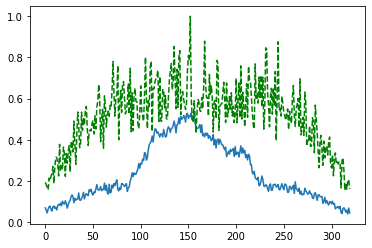

Time taken for epoch:  141.804039478302
Epoch = [145/3000]  Iter = [   0/39480]  Loss = 0.1538 Avg Loss = 0.1538  Time = 0.0724s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [145/3000]  Iter = [ 100/39480]  Loss = 0.1543 Avg Loss = 0.1554  Time = 0.0033s
Epoch = [145/3000]  Iter = [ 200/39480]  Loss = 0.1384 Avg Loss = 0.1556  Time = 0.0033s
Epoch = [145/3000]  Iter = [ 300/39480]  Loss = 0.1652 Avg Loss = 0.1548  Time = 0.0033s
Epoch = [145/3000]  Iter = [ 400/39480]  Loss = 0.1398 Avg Loss = 0.1549  Time = 0.0033s
Epoch = [145/3000]  Iter = [ 500/39480]  Loss = 0.1634 Avg Loss = 0.1541  Time = 0.0034s
Epoch = [145/3000]  Iter = [ 600/39480]  Loss = 0.1463 Avg Loss = 0.1557  Time = 0.0030s
Epoch = [145/3000]  Iter = [ 700/39480]  Loss = 0.1734 Avg Loss = 0.1569  Time = 0.0029s
Epoch = [145/3000]  Iter = [ 800/39480]  Loss = 0.1799 Avg Loss = 0.1553  Time = 0.0031s
Epoch = [145/3000]  Iter = [ 900/39480]  Loss = 0.1579 Avg Loss = 0.1569  Time = 0.0033s
Epoch = [145/3000]  Iter = [1000/39480]  Loss = 0.1753 Avg Loss = 0.1564  Time = 0.0033s
Epoch = [145/3000]  Iter = [1100/39480]  Loss = 0.1671 Avg Loss = 0.156  Time = 0.0033s
Epoch = [145/3000]  It

Epoch = [145/3000]  Iter = [9400/39480]  Loss = 0.1753 Avg Loss = 0.1559  Time = 0.0028s
Epoch = [145/3000]  Iter = [9500/39480]  Loss = 0.1627 Avg Loss = 0.1591  Time = 0.0030s
Epoch = [145/3000]  Iter = [9600/39480]  Loss = 0.1585 Avg Loss = 0.1573  Time = 0.0030s
Epoch = [145/3000]  Iter = [9700/39480]  Loss = 0.1535 Avg Loss = 0.1549  Time = 0.0031s
Epoch = [145/3000]  Iter = [9800/39480]  Loss = 0.1345 Avg Loss = 0.154  Time = 0.0030s
Epoch = [145/3000]  Iter = [9900/39480]  Loss = 0.1642 Avg Loss = 0.1569  Time = 0.0030s
Epoch = [145/3000]  Iter = [10000/39480]  Loss = 0.1564 Avg Loss = 0.1564  Time = 0.0030s
Epoch = [145/3000]  Iter = [10100/39480]  Loss = 0.1399 Avg Loss = 0.1566  Time = 0.0028s
Epoch = [145/3000]  Iter = [10200/39480]  Loss = 0.1428 Avg Loss = 0.1574  Time = 0.0028s
Epoch = [145/3000]  Iter = [10300/39480]  Loss = 0.1406 Avg Loss = 0.1557  Time = 0.0028s
Epoch = [145/3000]  Iter = [10400/39480]  Loss = 0.1787 Avg Loss = 0.1583  Time = 0.0031s
Epoch = [145/3000

Epoch = [145/3000]  Iter = [18600/39480]  Loss = 0.1718 Avg Loss = 0.1566  Time = 0.0034s
Epoch = [145/3000]  Iter = [18700/39480]  Loss = 0.1799 Avg Loss = 0.158  Time = 0.0034s
Epoch = [145/3000]  Iter = [18800/39480]  Loss = 0.1412 Avg Loss = 0.1573  Time = 0.0034s
Epoch = [145/3000]  Iter = [18900/39480]  Loss = 0.1669 Avg Loss = 0.1563  Time = 0.0034s
Epoch = [145/3000]  Iter = [19000/39480]  Loss = 0.1514 Avg Loss = 0.1571  Time = 0.0035s
Epoch = [145/3000]  Iter = [19100/39480]  Loss = 0.1649 Avg Loss = 0.1577  Time = 0.0034s
Epoch = [145/3000]  Iter = [19200/39480]  Loss = 0.1399 Avg Loss = 0.1581  Time = 0.0030s
Epoch = [145/3000]  Iter = [19300/39480]  Loss = 0.1734 Avg Loss = 0.1586  Time = 0.0033s
Epoch = [145/3000]  Iter = [19400/39480]  Loss = 0.1398 Avg Loss = 0.1559  Time = 0.0034s
Epoch = [145/3000]  Iter = [19500/39480]  Loss = 0.1409 Avg Loss = 0.1575  Time = 0.0034s
Epoch = [145/3000]  Iter = [19600/39480]  Loss = 0.1717 Avg Loss = 0.1576  Time = 0.0033s
Epoch = [14

Epoch = [145/3000]  Iter = [27800/39480]  Loss = 0.1429 Avg Loss = 0.1566  Time = 0.0036s
Epoch = [145/3000]  Iter = [27900/39480]  Loss = 0.1525 Avg Loss = 0.1577  Time = 0.0035s
Epoch = [145/3000]  Iter = [28000/39480]  Loss = 0.12 Avg Loss = 0.1581  Time = 0.0035s
Epoch = [145/3000]  Iter = [28100/39480]  Loss = 0.1531 Avg Loss = 0.1567  Time = 0.0031s
Epoch = [145/3000]  Iter = [28200/39480]  Loss = 0.1569 Avg Loss = 0.1556  Time = 0.0036s
Epoch = [145/3000]  Iter = [28300/39480]  Loss = 0.1717 Avg Loss = 0.1584  Time = 0.0032s
Epoch = [145/3000]  Iter = [28400/39480]  Loss = 0.1649 Avg Loss = 0.1575  Time = 0.0036s
Epoch = [145/3000]  Iter = [28500/39480]  Loss = 0.1559 Avg Loss = 0.1572  Time = 0.0036s
Epoch = [145/3000]  Iter = [28600/39480]  Loss = 0.1454 Avg Loss = 0.1563  Time = 0.0035s
Epoch = [145/3000]  Iter = [28700/39480]  Loss = 0.1332 Avg Loss = 0.1568  Time = 0.0031s
Epoch = [145/3000]  Iter = [28800/39480]  Loss = 0.1405 Avg Loss = 0.1551  Time = 0.0036s
Epoch = [145

Epoch = [145/3000]  Iter = [37000/39480]  Loss = 0.1563 Avg Loss = 0.1563  Time = 0.0036s
Epoch = [145/3000]  Iter = [37100/39480]  Loss = 0.156 Avg Loss = 0.1576  Time = 0.0035s
Epoch = [145/3000]  Iter = [37200/39480]  Loss = 0.1619 Avg Loss = 0.1579  Time = 0.0035s
Epoch = [145/3000]  Iter = [37300/39480]  Loss = 0.154 Avg Loss = 0.1574  Time = 0.0036s
Epoch = [145/3000]  Iter = [37400/39480]  Loss = 0.1489 Avg Loss = 0.1565  Time = 0.0035s
Epoch = [145/3000]  Iter = [37500/39480]  Loss = 0.1438 Avg Loss = 0.1552  Time = 0.0036s
Epoch = [145/3000]  Iter = [37600/39480]  Loss = 0.1582 Avg Loss = 0.1568  Time = 0.0035s
Epoch = [145/3000]  Iter = [37700/39480]  Loss = 0.1889 Avg Loss = 0.1567  Time = 0.0035s
Epoch = [145/3000]  Iter = [37800/39480]  Loss = 0.1545 Avg Loss = 0.1569  Time = 0.0036s
Epoch = [145/3000]  Iter = [37900/39480]  Loss = 0.1742 Avg Loss = 0.1574  Time = 0.0036s
Epoch = [145/3000]  Iter = [38000/39480]  Loss = 0.1539 Avg Loss = 0.1583  Time = 0.0031s
Epoch = [145

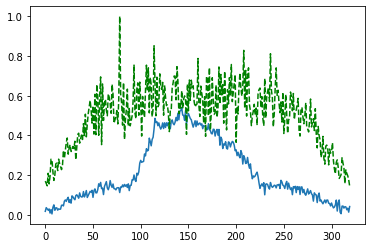

Time taken for epoch:  147.77485370635986
Epoch = [146/3000]  Iter = [   0/39480]  Loss = 0.1606 Avg Loss = 0.1606  Time = 0.0613s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [146/3000]  Iter = [ 100/39480]  Loss = 0.1431 Avg Loss = 0.1576  Time = 0.0034s
Epoch = [146/3000]  Iter = [ 200/39480]  Loss = 0.1333 Avg Loss = 0.1566  Time = 0.0035s
Epoch = [146/3000]  Iter = [ 300/39480]  Loss = 0.1522 Avg Loss = 0.1549  Time = 0.0036s
Epoch = [146/3000]  Iter = [ 400/39480]  Loss = 0.1331 Avg Loss = 0.156  Time = 0.0035s
Epoch = [146/3000]  Iter = [ 500/39480]  Loss = 0.1679 Avg Loss = 0.1557  Time = 0.0035s
Epoch = [146/3000]  Iter = [ 600/39480]  Loss = 0.1515 Avg Loss = 0.1551  Time = 0.0036s
Epoch = [146/3000]  Iter = [ 700/39480]  Loss = 0.1443 Avg Loss = 0.154  Time = 0.0030s
Epoch = [146/3000]  Iter = [ 800/39480]  Loss = 0.1504 Avg Loss = 0.1555  Time = 0.0029s
Epoch = [146/3000]  Iter = [ 900/39480]  Loss = 0.1426 Avg Loss = 0.1558  Time = 0.0033s
Epoch = [146/3000]  Iter = [1000/39480]  Loss = 0.1429 Avg Loss = 0.1548  Time = 0.0034s
Epoch = [146/3000]  Iter = [1100/39480]  Loss = 0.1519 Avg Loss = 0.1563  Time = 0.0033s
Epoch = [146/3000]  Ite

Epoch = [146/3000]  Iter = [9400/39480]  Loss = 0.1681 Avg Loss = 0.1571  Time = 0.0035s
Epoch = [146/3000]  Iter = [9500/39480]  Loss = 0.2076 Avg Loss = 0.1554  Time = 0.0036s
Epoch = [146/3000]  Iter = [9600/39480]  Loss = 0.1324 Avg Loss = 0.1563  Time = 0.0035s
Epoch = [146/3000]  Iter = [9700/39480]  Loss = 0.1707 Avg Loss = 0.1552  Time = 0.0033s
Epoch = [146/3000]  Iter = [9800/39480]  Loss = 0.147 Avg Loss = 0.157  Time = 0.0033s
Epoch = [146/3000]  Iter = [9900/39480]  Loss = 0.1661 Avg Loss = 0.1557  Time = 0.0035s
Epoch = [146/3000]  Iter = [10000/39480]  Loss = 0.1357 Avg Loss = 0.1566  Time = 0.0032s
Epoch = [146/3000]  Iter = [10100/39480]  Loss = 0.1293 Avg Loss = 0.1551  Time = 0.0036s
Epoch = [146/3000]  Iter = [10200/39480]  Loss = 0.1875 Avg Loss = 0.1568  Time = 0.0032s
Epoch = [146/3000]  Iter = [10300/39480]  Loss = 0.1553 Avg Loss = 0.1565  Time = 0.0035s
Epoch = [146/3000]  Iter = [10400/39480]  Loss = 0.1787 Avg Loss = 0.156  Time = 0.0035s
Epoch = [146/3000] 

Epoch = [146/3000]  Iter = [18600/39480]  Loss = 0.1304 Avg Loss = 0.1556  Time = 0.0035s
Epoch = [146/3000]  Iter = [18700/39480]  Loss = 0.1538 Avg Loss = 0.1568  Time = 0.0035s
Epoch = [146/3000]  Iter = [18800/39480]  Loss = 0.1641 Avg Loss = 0.1569  Time = 0.0033s
Epoch = [146/3000]  Iter = [18900/39480]  Loss = 0.1504 Avg Loss = 0.1563  Time = 0.0035s
Epoch = [146/3000]  Iter = [19000/39480]  Loss = 0.159 Avg Loss = 0.1578  Time = 0.0033s
Epoch = [146/3000]  Iter = [19100/39480]  Loss = 0.16 Avg Loss = 0.1575  Time = 0.0031s
Epoch = [146/3000]  Iter = [19200/39480]  Loss = 0.1567 Avg Loss = 0.1565  Time = 0.0033s
Epoch = [146/3000]  Iter = [19300/39480]  Loss = 0.1833 Avg Loss = 0.1563  Time = 0.0034s
Epoch = [146/3000]  Iter = [19400/39480]  Loss = 0.1717 Avg Loss = 0.156  Time = 0.0035s
Epoch = [146/3000]  Iter = [19500/39480]  Loss = 0.1967 Avg Loss = 0.1573  Time = 0.0034s
Epoch = [146/3000]  Iter = [19600/39480]  Loss = 0.1414 Avg Loss = 0.1585  Time = 0.0036s
Epoch = [146/3

Epoch = [146/3000]  Iter = [27800/39480]  Loss = 0.1709 Avg Loss = 0.1583  Time = 0.0034s
Epoch = [146/3000]  Iter = [27900/39480]  Loss = 0.1549 Avg Loss = 0.1577  Time = 0.0035s
Epoch = [146/3000]  Iter = [28000/39480]  Loss = 0.163 Avg Loss = 0.1566  Time = 0.0036s
Epoch = [146/3000]  Iter = [28100/39480]  Loss = 0.1388 Avg Loss = 0.1551  Time = 0.0035s
Epoch = [146/3000]  Iter = [28200/39480]  Loss = 0.1332 Avg Loss = 0.1573  Time = 0.0036s
Epoch = [146/3000]  Iter = [28300/39480]  Loss = 0.1474 Avg Loss = 0.158  Time = 0.0035s
Epoch = [146/3000]  Iter = [28400/39480]  Loss = 0.1746 Avg Loss = 0.1573  Time = 0.0035s
Epoch = [146/3000]  Iter = [28500/39480]  Loss = 0.1449 Avg Loss = 0.1569  Time = 0.0035s
Epoch = [146/3000]  Iter = [28600/39480]  Loss = 0.153 Avg Loss = 0.1565  Time = 0.0035s
Epoch = [146/3000]  Iter = [28700/39480]  Loss = 0.1588 Avg Loss = 0.1554  Time = 0.0029s
Epoch = [146/3000]  Iter = [28800/39480]  Loss = 0.1649 Avg Loss = 0.1548  Time = 0.0032s
Epoch = [146/

Epoch = [146/3000]  Iter = [37000/39480]  Loss = 0.1402 Avg Loss = 0.1587  Time = 0.0033s
Epoch = [146/3000]  Iter = [37100/39480]  Loss = 0.155 Avg Loss = 0.1586  Time = 0.0035s
Epoch = [146/3000]  Iter = [37200/39480]  Loss = 0.1512 Avg Loss = 0.1575  Time = 0.0035s
Epoch = [146/3000]  Iter = [37300/39480]  Loss = 0.1462 Avg Loss = 0.1574  Time = 0.0036s
Epoch = [146/3000]  Iter = [37400/39480]  Loss = 0.1256 Avg Loss = 0.1589  Time = 0.0036s
Epoch = [146/3000]  Iter = [37500/39480]  Loss = 0.1537 Avg Loss = 0.158  Time = 0.0035s
Epoch = [146/3000]  Iter = [37600/39480]  Loss = 0.1437 Avg Loss = 0.1563  Time = 0.0037s
Epoch = [146/3000]  Iter = [37700/39480]  Loss = 0.1345 Avg Loss = 0.1591  Time = 0.0036s
Epoch = [146/3000]  Iter = [37800/39480]  Loss = 0.1561 Avg Loss = 0.1578  Time = 0.0034s
Epoch = [146/3000]  Iter = [37900/39480]  Loss = 0.165 Avg Loss = 0.1571  Time = 0.0036s
Epoch = [146/3000]  Iter = [38000/39480]  Loss = 0.1412 Avg Loss = 0.1572  Time = 0.0036s
Epoch = [146/

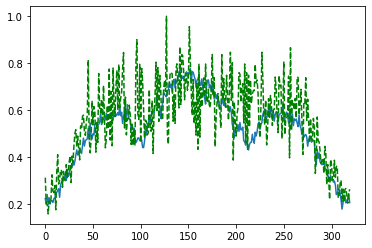

Time taken for epoch:  152.37987303733826
Epoch = [147/3000]  Iter = [   0/39480]  Loss = 0.1379 Avg Loss = 0.1379  Time = 0.0780s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [147/3000]  Iter = [ 100/39480]  Loss = 0.1501 Avg Loss = 0.1468  Time = 0.0035s
Epoch = [147/3000]  Iter = [ 200/39480]  Loss = 0.1477 Avg Loss = 0.1512  Time = 0.0036s
Epoch = [147/3000]  Iter = [ 300/39480]  Loss = 0.1557 Avg Loss = 0.1537  Time = 0.0036s
Epoch = [147/3000]  Iter = [ 400/39480]  Loss = 0.1743 Avg Loss = 0.154  Time = 0.0037s
Epoch = [147/3000]  Iter = [ 500/39480]  Loss = 0.1525 Avg Loss = 0.1543  Time = 0.0035s
Epoch = [147/3000]  Iter = [ 600/39480]  Loss = 0.1707 Avg Loss = 0.1572  Time = 0.0034s
Epoch = [147/3000]  Iter = [ 700/39480]  Loss = 0.1357 Avg Loss = 0.1567  Time = 0.0037s
Epoch = [147/3000]  Iter = [ 800/39480]  Loss = 0.1241 Avg Loss = 0.155  Time = 0.0033s
Epoch = [147/3000]  Iter = [ 900/39480]  Loss = 0.1525 Avg Loss = 0.1553  Time = 0.0036s
Epoch = [147/3000]  Iter = [1000/39480]  Loss = 0.1654 Avg Loss = 0.155  Time = 0.0037s
Epoch = [147/3000]  Iter = [1100/39480]  Loss = 0.1626 Avg Loss = 0.1557  Time = 0.0035s
Epoch = [147/3000]  Iter

Epoch = [147/3000]  Iter = [9400/39480]  Loss = 0.1442 Avg Loss = 0.1567  Time = 0.0031s
Epoch = [147/3000]  Iter = [9500/39480]  Loss = 0.1636 Avg Loss = 0.1569  Time = 0.0033s
Epoch = [147/3000]  Iter = [9600/39480]  Loss = 0.1748 Avg Loss = 0.1562  Time = 0.0034s
Epoch = [147/3000]  Iter = [9700/39480]  Loss = 0.1639 Avg Loss = 0.1574  Time = 0.0034s
Epoch = [147/3000]  Iter = [9800/39480]  Loss = 0.1419 Avg Loss = 0.157  Time = 0.0033s
Epoch = [147/3000]  Iter = [9900/39480]  Loss = 0.177 Avg Loss = 0.1575  Time = 0.0034s
Epoch = [147/3000]  Iter = [10000/39480]  Loss = 0.1336 Avg Loss = 0.1563  Time = 0.0034s
Epoch = [147/3000]  Iter = [10100/39480]  Loss = 0.1391 Avg Loss = 0.1564  Time = 0.0034s
Epoch = [147/3000]  Iter = [10200/39480]  Loss = 0.1677 Avg Loss = 0.1556  Time = 0.0033s
Epoch = [147/3000]  Iter = [10300/39480]  Loss = 0.1807 Avg Loss = 0.1575  Time = 0.0033s
Epoch = [147/3000]  Iter = [10400/39480]  Loss = 0.1855 Avg Loss = 0.1565  Time = 0.0034s
Epoch = [147/3000]

Epoch = [147/3000]  Iter = [18600/39480]  Loss = 0.1813 Avg Loss = 0.1579  Time = 0.0034s
Epoch = [147/3000]  Iter = [18700/39480]  Loss = 0.1455 Avg Loss = 0.1573  Time = 0.0035s
Epoch = [147/3000]  Iter = [18800/39480]  Loss = 0.1452 Avg Loss = 0.155  Time = 0.0066s
Epoch = [147/3000]  Iter = [18900/39480]  Loss = 0.1453 Avg Loss = 0.1559  Time = 0.0035s
Epoch = [147/3000]  Iter = [19000/39480]  Loss = 0.1812 Avg Loss = 0.156  Time = 0.0035s
Epoch = [147/3000]  Iter = [19100/39480]  Loss = 0.165 Avg Loss = 0.1543  Time = 0.0035s
Epoch = [147/3000]  Iter = [19200/39480]  Loss = 0.1483 Avg Loss = 0.1561  Time = 0.0035s
Epoch = [147/3000]  Iter = [19300/39480]  Loss = 0.135 Avg Loss = 0.1565  Time = 0.0031s
Epoch = [147/3000]  Iter = [19400/39480]  Loss = 0.1698 Avg Loss = 0.1565  Time = 0.0035s
Epoch = [147/3000]  Iter = [19500/39480]  Loss = 0.1555 Avg Loss = 0.1571  Time = 0.0036s
Epoch = [147/3000]  Iter = [19600/39480]  Loss = 0.1585 Avg Loss = 0.1584  Time = 0.0036s
Epoch = [147/3

Epoch = [147/3000]  Iter = [27800/39480]  Loss = 0.1591 Avg Loss = 0.154  Time = 0.0035s
Epoch = [147/3000]  Iter = [27900/39480]  Loss = 0.1574 Avg Loss = 0.1563  Time = 0.0035s
Epoch = [147/3000]  Iter = [28000/39480]  Loss = 0.1401 Avg Loss = 0.1581  Time = 0.0035s
Epoch = [147/3000]  Iter = [28100/39480]  Loss = 0.1458 Avg Loss = 0.1569  Time = 0.0035s
Epoch = [147/3000]  Iter = [28200/39480]  Loss = 0.1524 Avg Loss = 0.159  Time = 0.0036s
Epoch = [147/3000]  Iter = [28300/39480]  Loss = 0.1605 Avg Loss = 0.1579  Time = 0.0036s
Epoch = [147/3000]  Iter = [28400/39480]  Loss = 0.1745 Avg Loss = 0.1576  Time = 0.0035s
Epoch = [147/3000]  Iter = [28500/39480]  Loss = 0.1617 Avg Loss = 0.1555  Time = 0.0036s
Epoch = [147/3000]  Iter = [28600/39480]  Loss = 0.1423 Avg Loss = 0.1562  Time = 0.0035s
Epoch = [147/3000]  Iter = [28700/39480]  Loss = 0.1432 Avg Loss = 0.1564  Time = 0.0035s
Epoch = [147/3000]  Iter = [28800/39480]  Loss = 0.1445 Avg Loss = 0.1563  Time = 0.0031s
Epoch = [147

Epoch = [147/3000]  Iter = [37000/39480]  Loss = 0.1446 Avg Loss = 0.1562  Time = 0.0036s
Epoch = [147/3000]  Iter = [37100/39480]  Loss = 0.1667 Avg Loss = 0.1574  Time = 0.0037s
Epoch = [147/3000]  Iter = [37200/39480]  Loss = 0.1483 Avg Loss = 0.1573  Time = 0.0036s
Epoch = [147/3000]  Iter = [37300/39480]  Loss = 0.1682 Avg Loss = 0.1566  Time = 0.0036s
Epoch = [147/3000]  Iter = [37400/39480]  Loss = 0.1825 Avg Loss = 0.1579  Time = 0.0035s
Epoch = [147/3000]  Iter = [37500/39480]  Loss = 0.1631 Avg Loss = 0.1581  Time = 0.0045s
Epoch = [147/3000]  Iter = [37600/39480]  Loss = 0.1673 Avg Loss = 0.1567  Time = 0.0033s
Epoch = [147/3000]  Iter = [37700/39480]  Loss = 0.1272 Avg Loss = 0.1561  Time = 0.0032s
Epoch = [147/3000]  Iter = [37800/39480]  Loss = 0.1606 Avg Loss = 0.1564  Time = 0.0035s
Epoch = [147/3000]  Iter = [37900/39480]  Loss = 0.1421 Avg Loss = 0.1571  Time = 0.0034s
Epoch = [147/3000]  Iter = [38000/39480]  Loss = 0.1704 Avg Loss = 0.1579  Time = 0.0036s
Epoch = [1

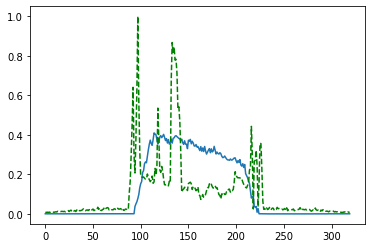

Time taken for epoch:  152.12252831459045
Epoch = [148/3000]  Iter = [   0/39480]  Loss = 0.1353 Avg Loss = 0.1353  Time = 0.0805s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [148/3000]  Iter = [ 100/39480]  Loss = 0.1565 Avg Loss = 0.1494  Time = 0.0035s
Epoch = [148/3000]  Iter = [ 200/39480]  Loss = 0.1655 Avg Loss = 0.1526  Time = 0.0035s
Epoch = [148/3000]  Iter = [ 300/39480]  Loss = 0.1781 Avg Loss = 0.1542  Time = 0.0035s
Epoch = [148/3000]  Iter = [ 400/39480]  Loss = 0.1592 Avg Loss = 0.1544  Time = 0.0035s
Epoch = [148/3000]  Iter = [ 500/39480]  Loss = 0.1599 Avg Loss = 0.1548  Time = 0.0032s
Epoch = [148/3000]  Iter = [ 600/39480]  Loss = 0.1598 Avg Loss = 0.1559  Time = 0.0035s
Epoch = [148/3000]  Iter = [ 700/39480]  Loss = 0.1745 Avg Loss = 0.1557  Time = 0.0035s
Epoch = [148/3000]  Iter = [ 800/39480]  Loss = 0.1545 Avg Loss = 0.1561  Time = 0.0035s
Epoch = [148/3000]  Iter = [ 900/39480]  Loss = 0.1579 Avg Loss = 0.1561  Time = 0.0035s
Epoch = [148/3000]  Iter = [1000/39480]  Loss = 0.1671 Avg Loss = 0.156  Time = 0.0035s
Epoch = [148/3000]  Iter = [1100/39480]  Loss = 0.1528 Avg Loss = 0.1566  Time = 0.0035s
Epoch = [148/3000]  It

Epoch = [148/3000]  Iter = [9400/39480]  Loss = 0.1604 Avg Loss = 0.1548  Time = 0.0036s
Epoch = [148/3000]  Iter = [9500/39480]  Loss = 0.1547 Avg Loss = 0.1559  Time = 0.0031s
Epoch = [148/3000]  Iter = [9600/39480]  Loss = 0.1577 Avg Loss = 0.1554  Time = 0.0036s
Epoch = [148/3000]  Iter = [9700/39480]  Loss = 0.1609 Avg Loss = 0.1557  Time = 0.0029s
Epoch = [148/3000]  Iter = [9800/39480]  Loss = 0.1571 Avg Loss = 0.1571  Time = 0.0032s
Epoch = [148/3000]  Iter = [9900/39480]  Loss = 0.1713 Avg Loss = 0.1566  Time = 0.0035s
Epoch = [148/3000]  Iter = [10000/39480]  Loss = 0.1772 Avg Loss = 0.1575  Time = 0.0036s
Epoch = [148/3000]  Iter = [10100/39480]  Loss = 0.1453 Avg Loss = 0.1571  Time = 0.0036s
Epoch = [148/3000]  Iter = [10200/39480]  Loss = 0.1639 Avg Loss = 0.158  Time = 0.0035s
Epoch = [148/3000]  Iter = [10300/39480]  Loss = 0.169 Avg Loss = 0.1564  Time = 0.0036s
Epoch = [148/3000]  Iter = [10400/39480]  Loss = 0.1701 Avg Loss = 0.1555  Time = 0.0040s
Epoch = [148/3000]

Epoch = [148/3000]  Iter = [18600/39480]  Loss = 0.1855 Avg Loss = 0.1564  Time = 0.0036s
Epoch = [148/3000]  Iter = [18700/39480]  Loss = 0.1415 Avg Loss = 0.1567  Time = 0.0035s
Epoch = [148/3000]  Iter = [18800/39480]  Loss = 0.1619 Avg Loss = 0.1561  Time = 0.0033s
Epoch = [148/3000]  Iter = [18900/39480]  Loss = 0.1349 Avg Loss = 0.1567  Time = 0.0031s
Epoch = [148/3000]  Iter = [19000/39480]  Loss = 0.1619 Avg Loss = 0.1554  Time = 0.0031s
Epoch = [148/3000]  Iter = [19100/39480]  Loss = 0.154 Avg Loss = 0.1561  Time = 0.0036s
Epoch = [148/3000]  Iter = [19200/39480]  Loss = 0.1801 Avg Loss = 0.1568  Time = 0.0035s
Epoch = [148/3000]  Iter = [19300/39480]  Loss = 0.1522 Avg Loss = 0.1573  Time = 0.0035s
Epoch = [148/3000]  Iter = [19400/39480]  Loss = 0.1771 Avg Loss = 0.1575  Time = 0.0035s
Epoch = [148/3000]  Iter = [19500/39480]  Loss = 0.1413 Avg Loss = 0.1549  Time = 0.0035s
Epoch = [148/3000]  Iter = [19600/39480]  Loss = 0.1602 Avg Loss = 0.1568  Time = 0.0035s
Epoch = [14

Epoch = [148/3000]  Iter = [27800/39480]  Loss = 0.1745 Avg Loss = 0.1565  Time = 0.0036s
Epoch = [148/3000]  Iter = [27900/39480]  Loss = 0.1481 Avg Loss = 0.1561  Time = 0.0036s
Epoch = [148/3000]  Iter = [28000/39480]  Loss = 0.1531 Avg Loss = 0.1568  Time = 0.0036s
Epoch = [148/3000]  Iter = [28100/39480]  Loss = 0.1829 Avg Loss = 0.1582  Time = 0.0035s
Epoch = [148/3000]  Iter = [28200/39480]  Loss = 0.1359 Avg Loss = 0.1586  Time = 0.0033s
Epoch = [148/3000]  Iter = [28300/39480]  Loss = 0.1558 Avg Loss = 0.1569  Time = 0.0036s
Epoch = [148/3000]  Iter = [28400/39480]  Loss = 0.1533 Avg Loss = 0.1555  Time = 0.0035s
Epoch = [148/3000]  Iter = [28500/39480]  Loss = 0.1543 Avg Loss = 0.1563  Time = 0.0035s
Epoch = [148/3000]  Iter = [28600/39480]  Loss = 0.1385 Avg Loss = 0.1548  Time = 0.0036s
Epoch = [148/3000]  Iter = [28700/39480]  Loss = 0.1517 Avg Loss = 0.1567  Time = 0.0034s
Epoch = [148/3000]  Iter = [28800/39480]  Loss = 0.1693 Avg Loss = 0.158  Time = 0.0036s
Epoch = [14

Epoch = [148/3000]  Iter = [37000/39480]  Loss = 0.1602 Avg Loss = 0.1543  Time = 0.0036s
Epoch = [148/3000]  Iter = [37100/39480]  Loss = 0.1612 Avg Loss = 0.1567  Time = 0.0035s
Epoch = [148/3000]  Iter = [37200/39480]  Loss = 0.1566 Avg Loss = 0.1567  Time = 0.0035s
Epoch = [148/3000]  Iter = [37300/39480]  Loss = 0.1754 Avg Loss = 0.1578  Time = 0.0034s
Epoch = [148/3000]  Iter = [37400/39480]  Loss = 0.1667 Avg Loss = 0.1571  Time = 0.0036s
Epoch = [148/3000]  Iter = [37500/39480]  Loss = 0.1644 Avg Loss = 0.1571  Time = 0.0035s
Epoch = [148/3000]  Iter = [37600/39480]  Loss = 0.1639 Avg Loss = 0.1561  Time = 0.0035s
Epoch = [148/3000]  Iter = [37700/39480]  Loss = 0.1389 Avg Loss = 0.1577  Time = 0.0034s
Epoch = [148/3000]  Iter = [37800/39480]  Loss = 0.1573 Avg Loss = 0.1579  Time = 0.0036s
Epoch = [148/3000]  Iter = [37900/39480]  Loss = 0.1554 Avg Loss = 0.1578  Time = 0.0035s
Epoch = [148/3000]  Iter = [38000/39480]  Loss = 0.1564 Avg Loss = 0.159  Time = 0.0036s
Epoch = [14

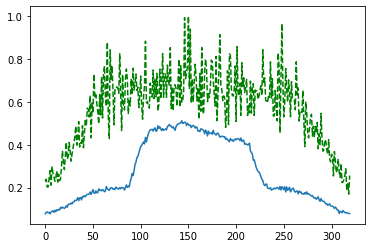

Time taken for epoch:  153.56539154052734
Epoch = [149/3000]  Iter = [   0/39480]  Loss = 0.1525 Avg Loss = 0.1525  Time = 0.0939s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [149/3000]  Iter = [ 100/39480]  Loss = 0.1415 Avg Loss = 0.1538  Time = 0.0037s
Epoch = [149/3000]  Iter = [ 200/39480]  Loss = 0.1438 Avg Loss = 0.1541  Time = 0.0037s
Epoch = [149/3000]  Iter = [ 300/39480]  Loss = 0.1514 Avg Loss = 0.1543  Time = 0.0037s
Epoch = [149/3000]  Iter = [ 400/39480]  Loss = 0.1499 Avg Loss = 0.1541  Time = 0.0037s
Epoch = [149/3000]  Iter = [ 500/39480]  Loss = 0.1418 Avg Loss = 0.1538  Time = 0.0037s
Epoch = [149/3000]  Iter = [ 600/39480]  Loss = 0.1599 Avg Loss = 0.1551  Time = 0.0037s
Epoch = [149/3000]  Iter = [ 700/39480]  Loss = 0.1705 Avg Loss = 0.1558  Time = 0.0035s
Epoch = [149/3000]  Iter = [ 800/39480]  Loss = 0.1817 Avg Loss = 0.1559  Time = 0.0036s
Epoch = [149/3000]  Iter = [ 900/39480]  Loss = 0.1316 Avg Loss = 0.1575  Time = 0.0036s
Epoch = [149/3000]  Iter = [1000/39480]  Loss = 0.1459 Avg Loss = 0.1564  Time = 0.0035s
Epoch = [149/3000]  Iter = [1100/39480]  Loss = 0.1512 Avg Loss = 0.1557  Time = 0.0036s
Epoch = [149/3000]  I

Epoch = [149/3000]  Iter = [9400/39480]  Loss = 0.1622 Avg Loss = 0.1561  Time = 0.0035s
Epoch = [149/3000]  Iter = [9500/39480]  Loss = 0.1611 Avg Loss = 0.1556  Time = 0.0035s
Epoch = [149/3000]  Iter = [9600/39480]  Loss = 0.1612 Avg Loss = 0.1564  Time = 0.0036s
Epoch = [149/3000]  Iter = [9700/39480]  Loss = 0.1563 Avg Loss = 0.1564  Time = 0.0036s
Epoch = [149/3000]  Iter = [9800/39480]  Loss = 0.1659 Avg Loss = 0.1573  Time = 0.0036s
Epoch = [149/3000]  Iter = [9900/39480]  Loss = 0.1642 Avg Loss = 0.1577  Time = 0.0036s
Epoch = [149/3000]  Iter = [10000/39480]  Loss = 0.1412 Avg Loss = 0.1566  Time = 0.0036s
Epoch = [149/3000]  Iter = [10100/39480]  Loss = 0.1718 Avg Loss = 0.1559  Time = 0.0035s
Epoch = [149/3000]  Iter = [10200/39480]  Loss = 0.1763 Avg Loss = 0.156  Time = 0.0031s
Epoch = [149/3000]  Iter = [10300/39480]  Loss = 0.1742 Avg Loss = 0.1584  Time = 0.0032s
Epoch = [149/3000]  Iter = [10400/39480]  Loss = 0.1344 Avg Loss = 0.1571  Time = 0.0036s
Epoch = [149/3000

Epoch = [149/3000]  Iter = [18600/39480]  Loss = 0.1615 Avg Loss = 0.1584  Time = 0.0032s
Epoch = [149/3000]  Iter = [18700/39480]  Loss = 0.1506 Avg Loss = 0.1584  Time = 0.0034s
Epoch = [149/3000]  Iter = [18800/39480]  Loss = 0.1323 Avg Loss = 0.1569  Time = 0.0034s
Epoch = [149/3000]  Iter = [18900/39480]  Loss = 0.1514 Avg Loss = 0.1581  Time = 0.0034s
Epoch = [149/3000]  Iter = [19000/39480]  Loss = 0.1485 Avg Loss = 0.157  Time = 0.0033s
Epoch = [149/3000]  Iter = [19100/39480]  Loss = 0.1284 Avg Loss = 0.1565  Time = 0.0034s
Epoch = [149/3000]  Iter = [19200/39480]  Loss = 0.145 Avg Loss = 0.1555  Time = 0.0035s
Epoch = [149/3000]  Iter = [19300/39480]  Loss = 0.1528 Avg Loss = 0.1571  Time = 0.0034s
Epoch = [149/3000]  Iter = [19400/39480]  Loss = 0.1489 Avg Loss = 0.1575  Time = 0.0034s
Epoch = [149/3000]  Iter = [19500/39480]  Loss = 0.1563 Avg Loss = 0.157  Time = 0.0034s
Epoch = [149/3000]  Iter = [19600/39480]  Loss = 0.1513 Avg Loss = 0.1569  Time = 0.0033s
Epoch = [149/

Epoch = [149/3000]  Iter = [27800/39480]  Loss = 0.1629 Avg Loss = 0.1555  Time = 0.0035s
Epoch = [149/3000]  Iter = [27900/39480]  Loss = 0.1468 Avg Loss = 0.1559  Time = 0.0035s
Epoch = [149/3000]  Iter = [28000/39480]  Loss = 0.1565 Avg Loss = 0.1565  Time = 0.0035s
Epoch = [149/3000]  Iter = [28100/39480]  Loss = 0.1551 Avg Loss = 0.1555  Time = 0.0035s
Epoch = [149/3000]  Iter = [28200/39480]  Loss = 0.1707 Avg Loss = 0.1561  Time = 0.0035s
Epoch = [149/3000]  Iter = [28300/39480]  Loss = 0.1718 Avg Loss = 0.1574  Time = 0.0035s
Epoch = [149/3000]  Iter = [28400/39480]  Loss = 0.174 Avg Loss = 0.1578  Time = 0.0031s
Epoch = [149/3000]  Iter = [28500/39480]  Loss = 0.1668 Avg Loss = 0.1548  Time = 0.0035s
Epoch = [149/3000]  Iter = [28600/39480]  Loss = 0.164 Avg Loss = 0.1575  Time = 0.0035s
Epoch = [149/3000]  Iter = [28700/39480]  Loss = 0.1823 Avg Loss = 0.1565  Time = 0.0035s
Epoch = [149/3000]  Iter = [28800/39480]  Loss = 0.1703 Avg Loss = 0.1581  Time = 0.0033s
Epoch = [149

Epoch = [149/3000]  Iter = [37000/39480]  Loss = 0.1714 Avg Loss = 0.1576  Time = 0.0031s
Epoch = [149/3000]  Iter = [37100/39480]  Loss = 0.1501 Avg Loss = 0.1572  Time = 0.0035s
Epoch = [149/3000]  Iter = [37200/39480]  Loss = 0.1347 Avg Loss = 0.1559  Time = 0.0033s
Epoch = [149/3000]  Iter = [37300/39480]  Loss = 0.1337 Avg Loss = 0.1566  Time = 0.0035s
Epoch = [149/3000]  Iter = [37400/39480]  Loss = 0.1524 Avg Loss = 0.156  Time = 0.0035s
Epoch = [149/3000]  Iter = [37500/39480]  Loss = 0.1526 Avg Loss = 0.158  Time = 0.0036s
Epoch = [149/3000]  Iter = [37600/39480]  Loss = 0.1321 Avg Loss = 0.1579  Time = 0.0036s
Epoch = [149/3000]  Iter = [37700/39480]  Loss = 0.1379 Avg Loss = 0.1578  Time = 0.0036s
Epoch = [149/3000]  Iter = [37800/39480]  Loss = 0.1514 Avg Loss = 0.1575  Time = 0.0034s
Epoch = [149/3000]  Iter = [37900/39480]  Loss = 0.1588 Avg Loss = 0.1574  Time = 0.0035s
Epoch = [149/3000]  Iter = [38000/39480]  Loss = 0.1624 Avg Loss = 0.1559  Time = 0.0034s
Epoch = [149

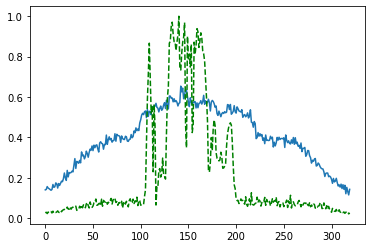

Time taken for epoch:  152.63239669799805
Epoch = [150/3000]  Iter = [   0/39480]  Loss = 0.1452 Avg Loss = 0.1452  Time = 0.0792s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [150/3000]  Iter = [ 100/39480]  Loss = 0.1609 Avg Loss = 0.1512  Time = 0.0034s
Epoch = [150/3000]  Iter = [ 200/39480]  Loss = 0.139 Avg Loss = 0.1546  Time = 0.0034s
Epoch = [150/3000]  Iter = [ 300/39480]  Loss = 0.1702 Avg Loss = 0.1548  Time = 0.0034s
Epoch = [150/3000]  Iter = [ 400/39480]  Loss = 0.1508 Avg Loss = 0.156  Time = 0.0033s
Epoch = [150/3000]  Iter = [ 500/39480]  Loss = 0.1577 Avg Loss = 0.1556  Time = 0.0031s
Epoch = [150/3000]  Iter = [ 600/39480]  Loss = 0.1592 Avg Loss = 0.1561  Time = 0.0031s
Epoch = [150/3000]  Iter = [ 700/39480]  Loss = 0.1629 Avg Loss = 0.1571  Time = 0.0032s
Epoch = [150/3000]  Iter = [ 800/39480]  Loss = 0.144 Avg Loss = 0.156  Time = 0.0033s
Epoch = [150/3000]  Iter = [ 900/39480]  Loss = 0.1722 Avg Loss = 0.1566  Time = 0.0034s
Epoch = [150/3000]  Iter = [1000/39480]  Loss = 0.1505 Avg Loss = 0.1549  Time = 0.0032s
Epoch = [150/3000]  Iter = [1100/39480]  Loss = 0.1582 Avg Loss = 0.1551  Time = 0.0031s
Epoch = [150/3000]  Iter 

Epoch = [150/3000]  Iter = [9400/39480]  Loss = 0.1764 Avg Loss = 0.1574  Time = 0.0035s
Epoch = [150/3000]  Iter = [9500/39480]  Loss = 0.1355 Avg Loss = 0.156  Time = 0.0035s
Epoch = [150/3000]  Iter = [9600/39480]  Loss = 0.1521 Avg Loss = 0.1546  Time = 0.0034s
Epoch = [150/3000]  Iter = [9700/39480]  Loss = 0.1566 Avg Loss = 0.1562  Time = 0.0034s
Epoch = [150/3000]  Iter = [9800/39480]  Loss = 0.1594 Avg Loss = 0.1571  Time = 0.0033s
Epoch = [150/3000]  Iter = [9900/39480]  Loss = 0.1478 Avg Loss = 0.1578  Time = 0.0035s
Epoch = [150/3000]  Iter = [10000/39480]  Loss = 0.1447 Avg Loss = 0.1569  Time = 0.0034s
Epoch = [150/3000]  Iter = [10100/39480]  Loss = 0.143 Avg Loss = 0.156  Time = 0.0034s
Epoch = [150/3000]  Iter = [10200/39480]  Loss = 0.1619 Avg Loss = 0.1563  Time = 0.0035s
Epoch = [150/3000]  Iter = [10300/39480]  Loss = 0.1554 Avg Loss = 0.1544  Time = 0.0033s
Epoch = [150/3000]  Iter = [10400/39480]  Loss = 0.1511 Avg Loss = 0.1564  Time = 0.0034s
Epoch = [150/3000] 

Epoch = [150/3000]  Iter = [18600/39480]  Loss = 0.1564 Avg Loss = 0.1561  Time = 0.0035s
Epoch = [150/3000]  Iter = [18700/39480]  Loss = 0.1602 Avg Loss = 0.1572  Time = 0.0036s
Epoch = [150/3000]  Iter = [18800/39480]  Loss = 0.1501 Avg Loss = 0.1569  Time = 0.0036s
Epoch = [150/3000]  Iter = [18900/39480]  Loss = 0.1529 Avg Loss = 0.1571  Time = 0.0036s
Epoch = [150/3000]  Iter = [19000/39480]  Loss = 0.1688 Avg Loss = 0.1572  Time = 0.0036s
Epoch = [150/3000]  Iter = [19100/39480]  Loss = 0.1403 Avg Loss = 0.1568  Time = 0.0036s
Epoch = [150/3000]  Iter = [19200/39480]  Loss = 0.1414 Avg Loss = 0.1572  Time = 0.0036s
Epoch = [150/3000]  Iter = [19300/39480]  Loss = 0.1259 Avg Loss = 0.1562  Time = 0.0035s
Epoch = [150/3000]  Iter = [19400/39480]  Loss = 0.1485 Avg Loss = 0.158  Time = 0.0033s
Epoch = [150/3000]  Iter = [19500/39480]  Loss = 0.1621 Avg Loss = 0.1564  Time = 0.0036s
Epoch = [150/3000]  Iter = [19600/39480]  Loss = 0.1536 Avg Loss = 0.156  Time = 0.0035s
Epoch = [150

Epoch = [150/3000]  Iter = [27800/39480]  Loss = 0.1569 Avg Loss = 0.1562  Time = 0.0036s
Epoch = [150/3000]  Iter = [27900/39480]  Loss = 0.1477 Avg Loss = 0.1571  Time = 0.0035s
Epoch = [150/3000]  Iter = [28000/39480]  Loss = 0.1475 Avg Loss = 0.1577  Time = 0.0035s
Epoch = [150/3000]  Iter = [28100/39480]  Loss = 0.1717 Avg Loss = 0.1582  Time = 0.0036s
Epoch = [150/3000]  Iter = [28200/39480]  Loss = 0.1546 Avg Loss = 0.1588  Time = 0.0035s
Epoch = [150/3000]  Iter = [28300/39480]  Loss = 0.1361 Avg Loss = 0.157  Time = 0.0032s
Epoch = [150/3000]  Iter = [28400/39480]  Loss = 0.1622 Avg Loss = 0.1563  Time = 0.0031s
Epoch = [150/3000]  Iter = [28500/39480]  Loss = 0.1189 Avg Loss = 0.1572  Time = 0.0035s
Epoch = [150/3000]  Iter = [28600/39480]  Loss = 0.1588 Avg Loss = 0.1564  Time = 0.0035s
Epoch = [150/3000]  Iter = [28700/39480]  Loss = 0.1389 Avg Loss = 0.1562  Time = 0.0035s
Epoch = [150/3000]  Iter = [28800/39480]  Loss = 0.1563 Avg Loss = 0.1562  Time = 0.0035s
Epoch = [15

Epoch = [150/3000]  Iter = [37000/39480]  Loss = 0.1398 Avg Loss = 0.1586  Time = 0.0035s
Epoch = [150/3000]  Iter = [37100/39480]  Loss = 0.1882 Avg Loss = 0.1578  Time = 0.0032s
Epoch = [150/3000]  Iter = [37200/39480]  Loss = 0.1379 Avg Loss = 0.1548  Time = 0.0035s
Epoch = [150/3000]  Iter = [37300/39480]  Loss = 0.1424 Avg Loss = 0.1553  Time = 0.0032s
Epoch = [150/3000]  Iter = [37400/39480]  Loss = 0.1459 Avg Loss = 0.1557  Time = 0.0035s
Epoch = [150/3000]  Iter = [37500/39480]  Loss = 0.1517 Avg Loss = 0.1569  Time = 0.0035s
Epoch = [150/3000]  Iter = [37600/39480]  Loss = 0.1359 Avg Loss = 0.157  Time = 0.0036s
Epoch = [150/3000]  Iter = [37700/39480]  Loss = 0.1476 Avg Loss = 0.1566  Time = 0.0035s
Epoch = [150/3000]  Iter = [37800/39480]  Loss = 0.1736 Avg Loss = 0.1576  Time = 0.0036s
Epoch = [150/3000]  Iter = [37900/39480]  Loss = 0.1491 Avg Loss = 0.1572  Time = 0.0034s
Epoch = [150/3000]  Iter = [38000/39480]  Loss = 0.1422 Avg Loss = 0.1579  Time = 0.0033s
Epoch = [15

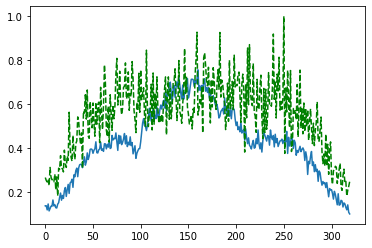

Time taken for epoch:  152.02495503425598
Epoch = [151/3000]  Iter = [   0/39480]  Loss = 0.1794 Avg Loss = 0.1794  Time = 0.0714s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [151/3000]  Iter = [ 100/39480]  Loss = 0.1374 Avg Loss = 0.1632  Time = 0.0035s
Epoch = [151/3000]  Iter = [ 200/39480]  Loss = 0.1445 Avg Loss = 0.159  Time = 0.0037s
Epoch = [151/3000]  Iter = [ 300/39480]  Loss = 0.1436 Avg Loss = 0.1568  Time = 0.0036s
Epoch = [151/3000]  Iter = [ 400/39480]  Loss = 0.1491 Avg Loss = 0.1546  Time = 0.0036s
Epoch = [151/3000]  Iter = [ 500/39480]  Loss = 0.1336 Avg Loss = 0.1543  Time = 0.0037s
Epoch = [151/3000]  Iter = [ 600/39480]  Loss = 0.1536 Avg Loss = 0.1552  Time = 0.0036s
Epoch = [151/3000]  Iter = [ 700/39480]  Loss = 0.1769 Avg Loss = 0.1557  Time = 0.0035s
Epoch = [151/3000]  Iter = [ 800/39480]  Loss = 0.1633 Avg Loss = 0.1568  Time = 0.0033s
Epoch = [151/3000]  Iter = [ 900/39480]  Loss = 0.1576 Avg Loss = 0.1567  Time = 0.0034s
Epoch = [151/3000]  Iter = [1000/39480]  Loss = 0.1381 Avg Loss = 0.1548  Time = 0.0035s
Epoch = [151/3000]  Iter = [1100/39480]  Loss = 0.1395 Avg Loss = 0.1552  Time = 0.0034s
Epoch = [151/3000]  It

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch = [166/3000]  Iter = [29300/39480]  Loss = 0.1484 Avg Loss = 0.1571  Time = 0.0033s
Epoch = [166/3000]  Iter = [29400/39480]  Loss = 0.1261 Avg Loss = 0.1583  Time = 0.0034s
Epoch = [166/3000]  Iter = [29500/39480]  Loss = 0.153 Avg Loss = 0.1551  Time = 0.0035s
Epoch = [166/3000]  Iter = [29600/39480]  Loss = 0.1637 Avg Loss = 0.1556  Time = 0.0036s
Epoch = [166/3000]  Iter = [29700/39480]  Loss = 0.1373 Avg Loss = 0.1563  Time = 0.0036s
Epoch = [166/3000]  Iter = [29800/39480]  Loss = 0.154 Avg Loss = 0.1554  Time = 0.0035s
Epoch = [166/3000]  Iter = [29900/39480]  Loss = 0.1727 Avg Loss = 0.1579  Time = 0.0036s
Epoch = [166/3000]  Iter = [30000/39480]  Loss = 0.1649 Avg Loss = 0.1572  Time = 0.0036s
Epoch = [166/3000]  Iter = [30100/39480]  Loss = 0.1407 Avg Loss = 0.1563  Time = 0.0035s
Epoch = [166/3000]  Iter = [30200/39480]  Loss = 0.1425 Avg Loss = 0.1573  Time = 0.0032s
Epoch = [166/3000]  Iter = [30300/39480]  Loss = 0.1352 Avg Loss = 0.157  Time = 0.0034s
Epoch = [166/

Epoch = [166/3000]  Iter = [38500/39480]  Loss = 0.1862 Avg Loss = 0.158  Time = 0.0035s
Epoch = [166/3000]  Iter = [38600/39480]  Loss = 0.1847 Avg Loss = 0.1575  Time = 0.0035s
Epoch = [166/3000]  Iter = [38700/39480]  Loss = 0.1563 Avg Loss = 0.1551  Time = 0.0035s
Epoch = [166/3000]  Iter = [38800/39480]  Loss = 0.1711 Avg Loss = 0.157  Time = 0.0034s
Epoch = [166/3000]  Iter = [38900/39480]  Loss = 0.1492 Avg Loss = 0.1582  Time = 0.0032s
Epoch = [166/3000]  Iter = [39000/39480]  Loss = 0.1752 Avg Loss = 0.1584  Time = 0.0034s
Epoch = [166/3000]  Iter = [39100/39480]  Loss = 0.1576 Avg Loss = 0.1571  Time = 0.0035s
Epoch = [166/3000]  Iter = [39200/39480]  Loss = 0.1609 Avg Loss = 0.1588  Time = 0.0034s
Epoch = [166/3000]  Iter = [39300/39480]  Loss = 0.1576 Avg Loss = 0.1572  Time = 0.0034s
Epoch = [166/3000]  Iter = [39400/39480]  Loss = 0.1513 Avg Loss = 0.156  Time = 0.0034s
Dev_Loss 0.17922119059105227 Epoch 166
Epoch = [ 166/3000] TrainLoss = 0.1579  DevLoss = 0.1792 TrainTi

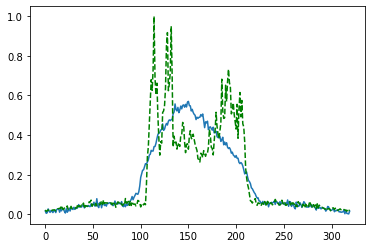

Time taken for epoch:  151.66530656814575
Epoch = [167/3000]  Iter = [   0/39480]  Loss = 0.1648 Avg Loss = 0.1648  Time = 0.0825s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [167/3000]  Iter = [ 100/39480]  Loss = 0.1619 Avg Loss = 0.16  Time = 0.0033s
Epoch = [167/3000]  Iter = [ 200/39480]  Loss = 0.1551 Avg Loss = 0.1573  Time = 0.0034s
Epoch = [167/3000]  Iter = [ 300/39480]  Loss = 0.1637 Avg Loss = 0.1551  Time = 0.0048s
Epoch = [167/3000]  Iter = [ 400/39480]  Loss = 0.1588 Avg Loss = 0.1557  Time = 0.0035s
Epoch = [167/3000]  Iter = [ 500/39480]  Loss = 0.1403 Avg Loss = 0.1549  Time = 0.0035s
Epoch = [167/3000]  Iter = [ 600/39480]  Loss = 0.1629 Avg Loss = 0.1548  Time = 0.0034s
Epoch = [167/3000]  Iter = [ 700/39480]  Loss = 0.159 Avg Loss = 0.1566  Time = 0.0036s
Epoch = [167/3000]  Iter = [ 800/39480]  Loss = 0.1629 Avg Loss = 0.1562  Time = 0.0036s
Epoch = [167/3000]  Iter = [ 900/39480]  Loss = 0.1653 Avg Loss = 0.1554  Time = 0.0035s
Epoch = [167/3000]  Iter = [1000/39480]  Loss = 0.1865 Avg Loss = 0.1557  Time = 0.0035s
Epoch = [167/3000]  Iter = [1100/39480]  Loss = 0.1583 Avg Loss = 0.1556  Time = 0.0036s
Epoch = [167/3000]  Iter

Epoch = [167/3000]  Iter = [9400/39480]  Loss = 0.1585 Avg Loss = 0.1563  Time = 0.0033s
Epoch = [167/3000]  Iter = [9500/39480]  Loss = 0.1712 Avg Loss = 0.1565  Time = 0.0035s
Epoch = [167/3000]  Iter = [9600/39480]  Loss = 0.1575 Avg Loss = 0.1561  Time = 0.0036s
Epoch = [167/3000]  Iter = [9700/39480]  Loss = 0.161 Avg Loss = 0.1562  Time = 0.0036s
Epoch = [167/3000]  Iter = [9800/39480]  Loss = 0.1401 Avg Loss = 0.1561  Time = 0.0035s
Epoch = [167/3000]  Iter = [9900/39480]  Loss = 0.161 Avg Loss = 0.1583  Time = 0.0035s
Epoch = [167/3000]  Iter = [10000/39480]  Loss = 0.1599 Avg Loss = 0.1575  Time = 0.0035s
Epoch = [167/3000]  Iter = [10100/39480]  Loss = 0.1462 Avg Loss = 0.1562  Time = 0.0036s
Epoch = [167/3000]  Iter = [10200/39480]  Loss = 0.1466 Avg Loss = 0.1566  Time = 0.0032s
Epoch = [167/3000]  Iter = [10300/39480]  Loss = 0.1593 Avg Loss = 0.1559  Time = 0.0035s
Epoch = [167/3000]  Iter = [10400/39480]  Loss = 0.1421 Avg Loss = 0.1563  Time = 0.0036s
Epoch = [167/3000]

Epoch = [167/3000]  Iter = [18600/39480]  Loss = 0.1646 Avg Loss = 0.1563  Time = 0.0035s
Epoch = [167/3000]  Iter = [18700/39480]  Loss = 0.1582 Avg Loss = 0.1567  Time = 0.0035s
Epoch = [167/3000]  Iter = [18800/39480]  Loss = 0.1797 Avg Loss = 0.1569  Time = 0.0031s
Epoch = [167/3000]  Iter = [18900/39480]  Loss = 0.1799 Avg Loss = 0.1561  Time = 0.0035s
Epoch = [167/3000]  Iter = [19000/39480]  Loss = 0.1572 Avg Loss = 0.1551  Time = 0.0035s
Epoch = [167/3000]  Iter = [19100/39480]  Loss = 0.1416 Avg Loss = 0.1552  Time = 0.0035s
Epoch = [167/3000]  Iter = [19200/39480]  Loss = 0.1715 Avg Loss = 0.1577  Time = 0.0036s
Epoch = [167/3000]  Iter = [19300/39480]  Loss = 0.1462 Avg Loss = 0.1569  Time = 0.0035s
Epoch = [167/3000]  Iter = [19400/39480]  Loss = 0.159 Avg Loss = 0.1567  Time = 0.0035s
Epoch = [167/3000]  Iter = [19500/39480]  Loss = 0.1619 Avg Loss = 0.1576  Time = 0.0036s
Epoch = [167/3000]  Iter = [19600/39480]  Loss = 0.1673 Avg Loss = 0.1562  Time = 0.0033s
Epoch = [16

Epoch = [167/3000]  Iter = [27800/39480]  Loss = 0.1429 Avg Loss = 0.1562  Time = 0.0036s
Epoch = [167/3000]  Iter = [27900/39480]  Loss = 0.1604 Avg Loss = 0.1579  Time = 0.0035s
Epoch = [167/3000]  Iter = [28000/39480]  Loss = 0.1558 Avg Loss = 0.1564  Time = 0.0035s
Epoch = [167/3000]  Iter = [28100/39480]  Loss = 0.1497 Avg Loss = 0.1548  Time = 0.0035s
Epoch = [167/3000]  Iter = [28200/39480]  Loss = 0.1509 Avg Loss = 0.1564  Time = 0.0035s
Epoch = [167/3000]  Iter = [28300/39480]  Loss = 0.1689 Avg Loss = 0.157  Time = 0.0036s
Epoch = [167/3000]  Iter = [28400/39480]  Loss = 0.1626 Avg Loss = 0.1568  Time = 0.0035s
Epoch = [167/3000]  Iter = [28500/39480]  Loss = 0.1416 Avg Loss = 0.1566  Time = 0.0035s
Epoch = [167/3000]  Iter = [28600/39480]  Loss = 0.17 Avg Loss = 0.157  Time = 0.0035s
Epoch = [167/3000]  Iter = [28700/39480]  Loss = 0.1579 Avg Loss = 0.1563  Time = 0.0035s
Epoch = [167/3000]  Iter = [28800/39480]  Loss = 0.1727 Avg Loss = 0.1575  Time = 0.0035s
Epoch = [167/3

Epoch = [167/3000]  Iter = [37000/39480]  Loss = 0.1599 Avg Loss = 0.1559  Time = 0.0036s
Epoch = [167/3000]  Iter = [37100/39480]  Loss = 0.1586 Avg Loss = 0.1549  Time = 0.0035s
Epoch = [167/3000]  Iter = [37200/39480]  Loss = 0.1389 Avg Loss = 0.1561  Time = 0.0033s
Epoch = [167/3000]  Iter = [37300/39480]  Loss = 0.1504 Avg Loss = 0.1564  Time = 0.0036s
Epoch = [167/3000]  Iter = [37400/39480]  Loss = 0.1378 Avg Loss = 0.1554  Time = 0.0035s
Epoch = [167/3000]  Iter = [37500/39480]  Loss = 0.145 Avg Loss = 0.1564  Time = 0.0035s
Epoch = [167/3000]  Iter = [37600/39480]  Loss = 0.1634 Avg Loss = 0.155  Time = 0.0035s
Epoch = [167/3000]  Iter = [37700/39480]  Loss = 0.1642 Avg Loss = 0.1569  Time = 0.0035s
Epoch = [167/3000]  Iter = [37800/39480]  Loss = 0.1797 Avg Loss = 0.1567  Time = 0.0035s
Epoch = [167/3000]  Iter = [37900/39480]  Loss = 0.1793 Avg Loss = 0.1569  Time = 0.0035s
Epoch = [167/3000]  Iter = [38000/39480]  Loss = 0.1686 Avg Loss = 0.1573  Time = 0.0030s
Epoch = [167

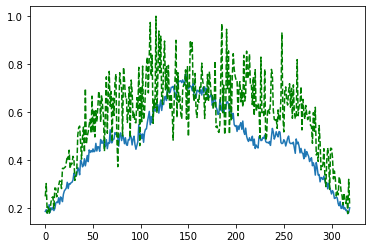

Time taken for epoch:  153.80478739738464
Epoch = [168/3000]  Iter = [   0/39480]  Loss = 0.1673 Avg Loss = 0.1673  Time = 0.0728s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [168/3000]  Iter = [ 100/39480]  Loss = 0.1759 Avg Loss = 0.1614  Time = 0.0035s
Epoch = [168/3000]  Iter = [ 200/39480]  Loss = 0.1479 Avg Loss = 0.159  Time = 0.0037s
Epoch = [168/3000]  Iter = [ 300/39480]  Loss = 0.1491 Avg Loss = 0.1568  Time = 0.0037s
Epoch = [168/3000]  Iter = [ 400/39480]  Loss = 0.1559 Avg Loss = 0.1555  Time = 0.0035s
Epoch = [168/3000]  Iter = [ 500/39480]  Loss = 0.1552 Avg Loss = 0.1555  Time = 0.0037s
Epoch = [168/3000]  Iter = [ 600/39480]  Loss = 0.1472 Avg Loss = 0.1546  Time = 0.0036s
Epoch = [168/3000]  Iter = [ 700/39480]  Loss = 0.1192 Avg Loss = 0.1548  Time = 0.0030s
Epoch = [168/3000]  Iter = [ 800/39480]  Loss = 0.1599 Avg Loss = 0.1552  Time = 0.0029s
Epoch = [168/3000]  Iter = [ 900/39480]  Loss = 0.1643 Avg Loss = 0.1571  Time = 0.0029s
Epoch = [168/3000]  Iter = [1000/39480]  Loss = 0.1663 Avg Loss = 0.1583  Time = 0.0035s
Epoch = [168/3000]  Iter = [1100/39480]  Loss = 0.1587 Avg Loss = 0.157  Time = 0.0036s
Epoch = [168/3000]  Ite

Epoch = [168/3000]  Iter = [9400/39480]  Loss = 0.1268 Avg Loss = 0.1558  Time = 0.0035s
Epoch = [168/3000]  Iter = [9500/39480]  Loss = 0.1582 Avg Loss = 0.1548  Time = 0.0035s
Epoch = [168/3000]  Iter = [9600/39480]  Loss = 0.1641 Avg Loss = 0.1549  Time = 0.0036s
Epoch = [168/3000]  Iter = [9700/39480]  Loss = 0.1785 Avg Loss = 0.1572  Time = 0.0036s
Epoch = [168/3000]  Iter = [9800/39480]  Loss = 0.163 Avg Loss = 0.1569  Time = 0.0031s
Epoch = [168/3000]  Iter = [9900/39480]  Loss = 0.1686 Avg Loss = 0.1581  Time = 0.0036s
Epoch = [168/3000]  Iter = [10000/39480]  Loss = 0.1697 Avg Loss = 0.1555  Time = 0.0035s
Epoch = [168/3000]  Iter = [10100/39480]  Loss = 0.1737 Avg Loss = 0.1568  Time = 0.0035s
Epoch = [168/3000]  Iter = [10200/39480]  Loss = 0.1796 Avg Loss = 0.157  Time = 0.0035s
Epoch = [168/3000]  Iter = [10300/39480]  Loss = 0.1369 Avg Loss = 0.1554  Time = 0.0035s
Epoch = [168/3000]  Iter = [10400/39480]  Loss = 0.165 Avg Loss = 0.1561  Time = 0.0036s
Epoch = [168/3000] 

Epoch = [168/3000]  Iter = [18600/39480]  Loss = 0.1477 Avg Loss = 0.1543  Time = 0.0035s
Epoch = [168/3000]  Iter = [18700/39480]  Loss = 0.1602 Avg Loss = 0.1569  Time = 0.0036s
Epoch = [168/3000]  Iter = [18800/39480]  Loss = 0.132 Avg Loss = 0.1577  Time = 0.0035s
Epoch = [168/3000]  Iter = [18900/39480]  Loss = 0.1549 Avg Loss = 0.1577  Time = 0.0036s
Epoch = [168/3000]  Iter = [19000/39480]  Loss = 0.1583 Avg Loss = 0.1567  Time = 0.0036s
Epoch = [168/3000]  Iter = [19100/39480]  Loss = 0.1353 Avg Loss = 0.157  Time = 0.0036s
Epoch = [168/3000]  Iter = [19200/39480]  Loss = 0.163 Avg Loss = 0.158  Time = 0.0035s
Epoch = [168/3000]  Iter = [19300/39480]  Loss = 0.1528 Avg Loss = 0.1561  Time = 0.0036s
Epoch = [168/3000]  Iter = [19400/39480]  Loss = 0.1385 Avg Loss = 0.1564  Time = 0.0035s
Epoch = [168/3000]  Iter = [19500/39480]  Loss = 0.1587 Avg Loss = 0.158  Time = 0.0033s
Epoch = [168/3000]  Iter = [19600/39480]  Loss = 0.1741 Avg Loss = 0.1576  Time = 0.0036s
Epoch = [168/30

Epoch = [168/3000]  Iter = [27800/39480]  Loss = 0.1463 Avg Loss = 0.1573  Time = 0.0035s
Epoch = [168/3000]  Iter = [27900/39480]  Loss = 0.1637 Avg Loss = 0.1556  Time = 0.0035s
Epoch = [168/3000]  Iter = [28000/39480]  Loss = 0.1514 Avg Loss = 0.1558  Time = 0.0035s
Epoch = [168/3000]  Iter = [28100/39480]  Loss = 0.1792 Avg Loss = 0.1552  Time = 0.0036s
Epoch = [168/3000]  Iter = [28200/39480]  Loss = 0.1427 Avg Loss = 0.1566  Time = 0.0035s
Epoch = [168/3000]  Iter = [28300/39480]  Loss = 0.1399 Avg Loss = 0.1581  Time = 0.0031s
Epoch = [168/3000]  Iter = [28400/39480]  Loss = 0.146 Avg Loss = 0.1558  Time = 0.0035s
Epoch = [168/3000]  Iter = [28500/39480]  Loss = 0.1532 Avg Loss = 0.1564  Time = 0.0035s
Epoch = [168/3000]  Iter = [28600/39480]  Loss = 0.1695 Avg Loss = 0.1569  Time = 0.0035s
Epoch = [168/3000]  Iter = [28700/39480]  Loss = 0.146 Avg Loss = 0.1565  Time = 0.0033s
Epoch = [168/3000]  Iter = [28800/39480]  Loss = 0.1533 Avg Loss = 0.1565  Time = 0.0035s
Epoch = [168

Epoch = [168/3000]  Iter = [37000/39480]  Loss = 0.1698 Avg Loss = 0.1577  Time = 0.0036s
Epoch = [168/3000]  Iter = [37100/39480]  Loss = 0.1501 Avg Loss = 0.1557  Time = 0.0036s
Epoch = [168/3000]  Iter = [37200/39480]  Loss = 0.1365 Avg Loss = 0.1577  Time = 0.0035s
Epoch = [168/3000]  Iter = [37300/39480]  Loss = 0.1728 Avg Loss = 0.1587  Time = 0.0036s
Epoch = [168/3000]  Iter = [37400/39480]  Loss = 0.1669 Avg Loss = 0.1583  Time = 0.0036s
Epoch = [168/3000]  Iter = [37500/39480]  Loss = 0.1425 Avg Loss = 0.1576  Time = 0.0035s
Epoch = [168/3000]  Iter = [37600/39480]  Loss = 0.1302 Avg Loss = 0.1566  Time = 0.0036s
Epoch = [168/3000]  Iter = [37700/39480]  Loss = 0.1435 Avg Loss = 0.1572  Time = 0.0035s
Epoch = [168/3000]  Iter = [37800/39480]  Loss = 0.1316 Avg Loss = 0.1573  Time = 0.0036s
Epoch = [168/3000]  Iter = [37900/39480]  Loss = 0.1674 Avg Loss = 0.1585  Time = 0.0035s
Epoch = [168/3000]  Iter = [38000/39480]  Loss = 0.17 Avg Loss = 0.1574  Time = 0.0035s
Epoch = [168

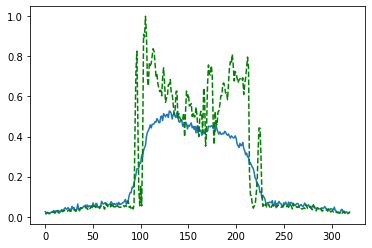

Time taken for epoch:  152.9002823829651
Epoch = [169/3000]  Iter = [   0/39480]  Loss = 0.1502 Avg Loss = 0.1502  Time = 0.0731s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [169/3000]  Iter = [ 100/39480]  Loss = 0.1402 Avg Loss = 0.1528  Time = 0.0036s
Epoch = [169/3000]  Iter = [ 200/39480]  Loss = 0.1499 Avg Loss = 0.1551  Time = 0.0036s
Epoch = [169/3000]  Iter = [ 300/39480]  Loss = 0.1742 Avg Loss = 0.1544  Time = 0.0034s
Epoch = [169/3000]  Iter = [ 400/39480]  Loss = 0.1542 Avg Loss = 0.1553  Time = 0.0036s
Epoch = [169/3000]  Iter = [ 500/39480]  Loss = 0.1549 Avg Loss = 0.1572  Time = 0.0035s
Epoch = [169/3000]  Iter = [ 600/39480]  Loss = 0.1729 Avg Loss = 0.1565  Time = 0.0035s
Epoch = [169/3000]  Iter = [ 700/39480]  Loss = 0.1428 Avg Loss = 0.1561  Time = 0.0035s
Epoch = [169/3000]  Iter = [ 800/39480]  Loss = 0.172 Avg Loss = 0.1552  Time = 0.0036s
Epoch = [169/3000]  Iter = [ 900/39480]  Loss = 0.1659 Avg Loss = 0.156  Time = 0.0034s
Epoch = [169/3000]  Iter = [1000/39480]  Loss = 0.161 Avg Loss = 0.155  Time = 0.0031s
Epoch = [169/3000]  Iter = [1100/39480]  Loss = 0.1453 Avg Loss = 0.1552  Time = 0.0034s
Epoch = [169/3000]  Iter 

Epoch = [169/3000]  Iter = [9400/39480]  Loss = 0.1463 Avg Loss = 0.1578  Time = 0.0031s
Epoch = [169/3000]  Iter = [9500/39480]  Loss = 0.1305 Avg Loss = 0.156  Time = 0.0036s
Epoch = [169/3000]  Iter = [9600/39480]  Loss = 0.1523 Avg Loss = 0.1574  Time = 0.0036s
Epoch = [169/3000]  Iter = [9700/39480]  Loss = 0.1547 Avg Loss = 0.1573  Time = 0.0035s
Epoch = [169/3000]  Iter = [9800/39480]  Loss = 0.1494 Avg Loss = 0.1574  Time = 0.0036s
Epoch = [169/3000]  Iter = [9900/39480]  Loss = 0.1577 Avg Loss = 0.1586  Time = 0.0033s
Epoch = [169/3000]  Iter = [10000/39480]  Loss = 0.1297 Avg Loss = 0.1575  Time = 0.0036s
Epoch = [169/3000]  Iter = [10100/39480]  Loss = 0.1545 Avg Loss = 0.1579  Time = 0.0035s
Epoch = [169/3000]  Iter = [10200/39480]  Loss = 0.1544 Avg Loss = 0.1581  Time = 0.0036s
Epoch = [169/3000]  Iter = [10300/39480]  Loss = 0.1644 Avg Loss = 0.1578  Time = 0.0035s
Epoch = [169/3000]  Iter = [10400/39480]  Loss = 0.1503 Avg Loss = 0.1564  Time = 0.0035s
Epoch = [169/3000

Epoch = [169/3000]  Iter = [18600/39480]  Loss = 0.1794 Avg Loss = 0.1575  Time = 0.0033s
Epoch = [169/3000]  Iter = [18700/39480]  Loss = 0.1613 Avg Loss = 0.1574  Time = 0.0034s
Epoch = [169/3000]  Iter = [18800/39480]  Loss = 0.1447 Avg Loss = 0.1572  Time = 0.0033s
Epoch = [169/3000]  Iter = [18900/39480]  Loss = 0.1744 Avg Loss = 0.1568  Time = 0.0033s
Epoch = [169/3000]  Iter = [19000/39480]  Loss = 0.1584 Avg Loss = 0.1576  Time = 0.0033s
Epoch = [169/3000]  Iter = [19100/39480]  Loss = 0.1355 Avg Loss = 0.1582  Time = 0.0033s
Epoch = [169/3000]  Iter = [19200/39480]  Loss = 0.1446 Avg Loss = 0.1581  Time = 0.0035s
Epoch = [169/3000]  Iter = [19300/39480]  Loss = 0.1745 Avg Loss = 0.1582  Time = 0.0035s
Epoch = [169/3000]  Iter = [19400/39480]  Loss = 0.1281 Avg Loss = 0.1565  Time = 0.0035s
Epoch = [169/3000]  Iter = [19500/39480]  Loss = 0.1431 Avg Loss = 0.1567  Time = 0.0035s
Epoch = [169/3000]  Iter = [19600/39480]  Loss = 0.1558 Avg Loss = 0.1573  Time = 0.0035s
Epoch = [1

Epoch = [169/3000]  Iter = [27800/39480]  Loss = 0.1461 Avg Loss = 0.1566  Time = 0.0035s
Epoch = [169/3000]  Iter = [27900/39480]  Loss = 0.1463 Avg Loss = 0.1583  Time = 0.0035s
Epoch = [169/3000]  Iter = [28000/39480]  Loss = 0.1539 Avg Loss = 0.1582  Time = 0.0031s
Epoch = [169/3000]  Iter = [28100/39480]  Loss = 0.1364 Avg Loss = 0.1552  Time = 0.0035s
Epoch = [169/3000]  Iter = [28200/39480]  Loss = 0.1408 Avg Loss = 0.155  Time = 0.0035s
Epoch = [169/3000]  Iter = [28300/39480]  Loss = 0.1411 Avg Loss = 0.1559  Time = 0.0034s
Epoch = [169/3000]  Iter = [28400/39480]  Loss = 0.1495 Avg Loss = 0.1578  Time = 0.0035s
Epoch = [169/3000]  Iter = [28500/39480]  Loss = 0.1384 Avg Loss = 0.1582  Time = 0.0035s
Epoch = [169/3000]  Iter = [28600/39480]  Loss = 0.1437 Avg Loss = 0.1579  Time = 0.0035s
Epoch = [169/3000]  Iter = [28700/39480]  Loss = 0.1703 Avg Loss = 0.1578  Time = 0.0035s
Epoch = [169/3000]  Iter = [28800/39480]  Loss = 0.1487 Avg Loss = 0.1567  Time = 0.0036s
Epoch = [16

Epoch = [169/3000]  Iter = [37000/39480]  Loss = 0.1561 Avg Loss = 0.1568  Time = 0.0035s
Epoch = [169/3000]  Iter = [37100/39480]  Loss = 0.1505 Avg Loss = 0.1545  Time = 0.0035s
Epoch = [169/3000]  Iter = [37200/39480]  Loss = 0.1697 Avg Loss = 0.1572  Time = 0.0035s
Epoch = [169/3000]  Iter = [37300/39480]  Loss = 0.1621 Avg Loss = 0.1565  Time = 0.0031s
Epoch = [169/3000]  Iter = [37400/39480]  Loss = 0.1466 Avg Loss = 0.1575  Time = 0.0031s
Epoch = [169/3000]  Iter = [37500/39480]  Loss = 0.1711 Avg Loss = 0.158  Time = 0.0035s
Epoch = [169/3000]  Iter = [37600/39480]  Loss = 0.1335 Avg Loss = 0.1565  Time = 0.0035s
Epoch = [169/3000]  Iter = [37700/39480]  Loss = 0.181 Avg Loss = 0.157  Time = 0.0035s
Epoch = [169/3000]  Iter = [37800/39480]  Loss = 0.1722 Avg Loss = 0.157  Time = 0.0031s
Epoch = [169/3000]  Iter = [37900/39480]  Loss = 0.1189 Avg Loss = 0.1563  Time = 0.0035s
Epoch = [169/3000]  Iter = [38000/39480]  Loss = 0.1675 Avg Loss = 0.1579  Time = 0.0035s
Epoch = [169/3

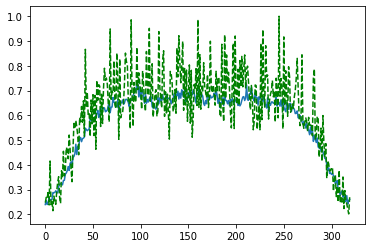

Time taken for epoch:  152.74779152870178
Epoch = [170/3000]  Iter = [   0/39480]  Loss = 0.1785 Avg Loss = 0.1785  Time = 0.0649s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [170/3000]  Iter = [ 100/39480]  Loss = 0.1448 Avg Loss = 0.1647  Time = 0.0035s
Epoch = [170/3000]  Iter = [ 200/39480]  Loss = 0.1657 Avg Loss = 0.1594  Time = 0.0037s
Epoch = [170/3000]  Iter = [ 300/39480]  Loss = 0.1844 Avg Loss = 0.1578  Time = 0.0036s
Epoch = [170/3000]  Iter = [ 400/39480]  Loss = 0.1651 Avg Loss = 0.1557  Time = 0.0036s
Epoch = [170/3000]  Iter = [ 500/39480]  Loss = 0.152 Avg Loss = 0.1548  Time = 0.0036s
Epoch = [170/3000]  Iter = [ 600/39480]  Loss = 0.1455 Avg Loss = 0.157  Time = 0.0036s
Epoch = [170/3000]  Iter = [ 700/39480]  Loss = 0.1534 Avg Loss = 0.155  Time = 0.0030s
Epoch = [170/3000]  Iter = [ 800/39480]  Loss = 0.1405 Avg Loss = 0.1551  Time = 0.0029s
Epoch = [170/3000]  Iter = [ 900/39480]  Loss = 0.1756 Avg Loss = 0.1568  Time = 0.0032s
Epoch = [170/3000]  Iter = [1000/39480]  Loss = 0.1707 Avg Loss = 0.1569  Time = 0.0031s
Epoch = [170/3000]  Iter = [1100/39480]  Loss = 0.1614 Avg Loss = 0.1557  Time = 0.0036s
Epoch = [170/3000]  Iter

Epoch = [170/3000]  Iter = [9400/39480]  Loss = 0.157 Avg Loss = 0.1566  Time = 0.0029s
Epoch = [170/3000]  Iter = [9500/39480]  Loss = 0.1445 Avg Loss = 0.1571  Time = 0.0035s
Epoch = [170/3000]  Iter = [9600/39480]  Loss = 0.1726 Avg Loss = 0.1575  Time = 0.0033s
Epoch = [170/3000]  Iter = [9700/39480]  Loss = 0.1717 Avg Loss = 0.1575  Time = 0.0035s
Epoch = [170/3000]  Iter = [9800/39480]  Loss = 0.1842 Avg Loss = 0.1561  Time = 0.0036s
Epoch = [170/3000]  Iter = [9900/39480]  Loss = 0.1324 Avg Loss = 0.1553  Time = 0.0035s
Epoch = [170/3000]  Iter = [10000/39480]  Loss = 0.1509 Avg Loss = 0.1577  Time = 0.0035s
Epoch = [170/3000]  Iter = [10100/39480]  Loss = 0.1754 Avg Loss = 0.1568  Time = 0.0035s
Epoch = [170/3000]  Iter = [10200/39480]  Loss = 0.1387 Avg Loss = 0.1548  Time = 0.0035s
Epoch = [170/3000]  Iter = [10300/39480]  Loss = 0.1705 Avg Loss = 0.1564  Time = 0.0035s
Epoch = [170/3000]  Iter = [10400/39480]  Loss = 0.1467 Avg Loss = 0.1563  Time = 0.0035s
Epoch = [170/3000

Epoch = [170/3000]  Iter = [18600/39480]  Loss = 0.1595 Avg Loss = 0.1569  Time = 0.0032s
Epoch = [170/3000]  Iter = [18700/39480]  Loss = 0.1432 Avg Loss = 0.156  Time = 0.0034s
Epoch = [170/3000]  Iter = [18800/39480]  Loss = 0.1417 Avg Loss = 0.1564  Time = 0.0033s
Epoch = [170/3000]  Iter = [18900/39480]  Loss = 0.1562 Avg Loss = 0.1557  Time = 0.0036s
Epoch = [170/3000]  Iter = [19000/39480]  Loss = 0.1555 Avg Loss = 0.1559  Time = 0.0035s
Epoch = [170/3000]  Iter = [19100/39480]  Loss = 0.1523 Avg Loss = 0.1546  Time = 0.0033s
Epoch = [170/3000]  Iter = [19200/39480]  Loss = 0.196 Avg Loss = 0.1561  Time = 0.0032s
Epoch = [170/3000]  Iter = [19300/39480]  Loss = 0.1564 Avg Loss = 0.158  Time = 0.0036s
Epoch = [170/3000]  Iter = [19400/39480]  Loss = 0.1407 Avg Loss = 0.1566  Time = 0.0034s
Epoch = [170/3000]  Iter = [19500/39480]  Loss = 0.1325 Avg Loss = 0.1549  Time = 0.0032s
Epoch = [170/3000]  Iter = [19600/39480]  Loss = 0.1797 Avg Loss = 0.1575  Time = 0.0035s
Epoch = [170/

Epoch = [170/3000]  Iter = [27800/39480]  Loss = 0.157 Avg Loss = 0.1583  Time = 0.0036s
Epoch = [170/3000]  Iter = [27900/39480]  Loss = 0.1658 Avg Loss = 0.1577  Time = 0.0035s
Epoch = [170/3000]  Iter = [28000/39480]  Loss = 0.1852 Avg Loss = 0.1579  Time = 0.0035s
Epoch = [170/3000]  Iter = [28100/39480]  Loss = 0.1586 Avg Loss = 0.1573  Time = 0.0035s
Epoch = [170/3000]  Iter = [28200/39480]  Loss = 0.1615 Avg Loss = 0.1592  Time = 0.0035s
Epoch = [170/3000]  Iter = [28300/39480]  Loss = 0.1708 Avg Loss = 0.1582  Time = 0.0034s
Epoch = [170/3000]  Iter = [28400/39480]  Loss = 0.1664 Avg Loss = 0.1563  Time = 0.0036s
Epoch = [170/3000]  Iter = [28500/39480]  Loss = 0.1503 Avg Loss = 0.1546  Time = 0.0032s
Epoch = [170/3000]  Iter = [28600/39480]  Loss = 0.1677 Avg Loss = 0.1556  Time = 0.0033s
Epoch = [170/3000]  Iter = [28700/39480]  Loss = 0.1696 Avg Loss = 0.1573  Time = 0.0036s
Epoch = [170/3000]  Iter = [28800/39480]  Loss = 0.1455 Avg Loss = 0.1587  Time = 0.0036s
Epoch = [17

Epoch = [170/3000]  Iter = [37000/39480]  Loss = 0.1615 Avg Loss = 0.1579  Time = 0.0037s
Epoch = [170/3000]  Iter = [37100/39480]  Loss = 0.1567 Avg Loss = 0.1579  Time = 0.0036s
Epoch = [170/3000]  Iter = [37200/39480]  Loss = 0.1549 Avg Loss = 0.1561  Time = 0.0036s
Epoch = [170/3000]  Iter = [37300/39480]  Loss = 0.1637 Avg Loss = 0.1566  Time = 0.0035s
Epoch = [170/3000]  Iter = [37400/39480]  Loss = 0.1494 Avg Loss = 0.1542  Time = 0.0036s
Epoch = [170/3000]  Iter = [37500/39480]  Loss = 0.1634 Avg Loss = 0.1566  Time = 0.0034s
Epoch = [170/3000]  Iter = [37600/39480]  Loss = 0.1602 Avg Loss = 0.1569  Time = 0.0036s
Epoch = [170/3000]  Iter = [37700/39480]  Loss = 0.1517 Avg Loss = 0.1576  Time = 0.0036s
Epoch = [170/3000]  Iter = [37800/39480]  Loss = 0.1185 Avg Loss = 0.1558  Time = 0.0036s
Epoch = [170/3000]  Iter = [37900/39480]  Loss = 0.1582 Avg Loss = 0.1549  Time = 0.0036s
Epoch = [170/3000]  Iter = [38000/39480]  Loss = 0.1552 Avg Loss = 0.1564  Time = 0.0036s
Epoch = [1

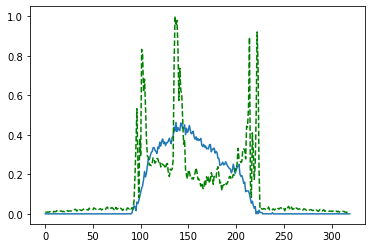

Time taken for epoch:  153.47208380699158
Epoch = [171/3000]  Iter = [   0/39480]  Loss = 0.1383 Avg Loss = 0.1383  Time = 0.0815s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [171/3000]  Iter = [ 100/39480]  Loss = 0.1552 Avg Loss = 0.1491  Time = 0.0036s
Epoch = [171/3000]  Iter = [ 200/39480]  Loss = 0.1496 Avg Loss = 0.1544  Time = 0.0036s
Epoch = [171/3000]  Iter = [ 300/39480]  Loss = 0.1414 Avg Loss = 0.1549  Time = 0.0035s
Epoch = [171/3000]  Iter = [ 400/39480]  Loss = 0.1591 Avg Loss = 0.156  Time = 0.0035s
Epoch = [171/3000]  Iter = [ 500/39480]  Loss = 0.1539 Avg Loss = 0.1565  Time = 0.0036s
Epoch = [171/3000]  Iter = [ 600/39480]  Loss = 0.1471 Avg Loss = 0.1566  Time = 0.0035s
Epoch = [171/3000]  Iter = [ 700/39480]  Loss = 0.1585 Avg Loss = 0.1567  Time = 0.0036s
Epoch = [171/3000]  Iter = [ 800/39480]  Loss = 0.147 Avg Loss = 0.1568  Time = 0.0035s
Epoch = [171/3000]  Iter = [ 900/39480]  Loss = 0.1522 Avg Loss = 0.1575  Time = 0.0030s
Epoch = [171/3000]  Iter = [1000/39480]  Loss = 0.1482 Avg Loss = 0.1556  Time = 0.0028s
Epoch = [171/3000]  Iter = [1100/39480]  Loss = 0.1551 Avg Loss = 0.1541  Time = 0.0028s
Epoch = [171/3000]  Ite

Epoch = [171/3000]  Iter = [9400/39480]  Loss = 0.1803 Avg Loss = 0.1558  Time = 0.0035s
Epoch = [171/3000]  Iter = [9500/39480]  Loss = 0.1357 Avg Loss = 0.1556  Time = 0.0036s
Epoch = [171/3000]  Iter = [9600/39480]  Loss = 0.1599 Avg Loss = 0.1565  Time = 0.0035s
Epoch = [171/3000]  Iter = [9700/39480]  Loss = 0.1551 Avg Loss = 0.1564  Time = 0.0033s
Epoch = [171/3000]  Iter = [9800/39480]  Loss = 0.1454 Avg Loss = 0.1568  Time = 0.0035s
Epoch = [171/3000]  Iter = [9900/39480]  Loss = 0.183 Avg Loss = 0.1552  Time = 0.0035s
Epoch = [171/3000]  Iter = [10000/39480]  Loss = 0.1584 Avg Loss = 0.1569  Time = 0.0034s
Epoch = [171/3000]  Iter = [10100/39480]  Loss = 0.1507 Avg Loss = 0.1561  Time = 0.0035s
Epoch = [171/3000]  Iter = [10200/39480]  Loss = 0.1581 Avg Loss = 0.1553  Time = 0.0034s
Epoch = [171/3000]  Iter = [10300/39480]  Loss = 0.1557 Avg Loss = 0.1569  Time = 0.0034s
Epoch = [171/3000]  Iter = [10400/39480]  Loss = 0.1532 Avg Loss = 0.1566  Time = 0.0035s
Epoch = [171/3000

Epoch = [171/3000]  Iter = [18600/39480]  Loss = 0.1803 Avg Loss = 0.1583  Time = 0.0036s
Epoch = [171/3000]  Iter = [18700/39480]  Loss = 0.1665 Avg Loss = 0.1583  Time = 0.0035s
Epoch = [171/3000]  Iter = [18800/39480]  Loss = 0.1586 Avg Loss = 0.1576  Time = 0.0034s
Epoch = [171/3000]  Iter = [18900/39480]  Loss = 0.1742 Avg Loss = 0.1576  Time = 0.0034s
Epoch = [171/3000]  Iter = [19000/39480]  Loss = 0.1476 Avg Loss = 0.1572  Time = 0.0035s
Epoch = [171/3000]  Iter = [19100/39480]  Loss = 0.1713 Avg Loss = 0.1564  Time = 0.0036s
Epoch = [171/3000]  Iter = [19200/39480]  Loss = 0.1607 Avg Loss = 0.1573  Time = 0.0035s
Epoch = [171/3000]  Iter = [19300/39480]  Loss = 0.167 Avg Loss = 0.1565  Time = 0.0034s
Epoch = [171/3000]  Iter = [19400/39480]  Loss = 0.1527 Avg Loss = 0.155  Time = 0.0034s
Epoch = [171/3000]  Iter = [19500/39480]  Loss = 0.145 Avg Loss = 0.1558  Time = 0.0035s
Epoch = [171/3000]  Iter = [19600/39480]  Loss = 0.1538 Avg Loss = 0.1576  Time = 0.0035s
Epoch = [171/

Epoch = [171/3000]  Iter = [27800/39480]  Loss = 0.1662 Avg Loss = 0.1566  Time = 0.0036s
Epoch = [171/3000]  Iter = [27900/39480]  Loss = 0.1549 Avg Loss = 0.1555  Time = 0.0036s
Epoch = [171/3000]  Iter = [28000/39480]  Loss = 0.1314 Avg Loss = 0.1574  Time = 0.0036s
Epoch = [171/3000]  Iter = [28100/39480]  Loss = 0.1287 Avg Loss = 0.1547  Time = 0.0033s
Epoch = [171/3000]  Iter = [28200/39480]  Loss = 0.1599 Avg Loss = 0.1546  Time = 0.0036s
Epoch = [171/3000]  Iter = [28300/39480]  Loss = 0.1607 Avg Loss = 0.1574  Time = 0.0033s
Epoch = [171/3000]  Iter = [28400/39480]  Loss = 0.1567 Avg Loss = 0.1582  Time = 0.0035s
Epoch = [171/3000]  Iter = [28500/39480]  Loss = 0.1289 Avg Loss = 0.156  Time = 0.0030s
Epoch = [171/3000]  Iter = [28600/39480]  Loss = 0.1604 Avg Loss = 0.1578  Time = 0.0032s
Epoch = [171/3000]  Iter = [28700/39480]  Loss = 0.1443 Avg Loss = 0.1557  Time = 0.0035s
Epoch = [171/3000]  Iter = [28800/39480]  Loss = 0.1336 Avg Loss = 0.1561  Time = 0.0035s
Epoch = [17

Epoch = [171/3000]  Iter = [37000/39480]  Loss = 0.1746 Avg Loss = 0.1576  Time = 0.0031s
Epoch = [171/3000]  Iter = [37100/39480]  Loss = 0.1456 Avg Loss = 0.1561  Time = 0.0031s
Epoch = [171/3000]  Iter = [37200/39480]  Loss = 0.1958 Avg Loss = 0.1579  Time = 0.0035s
Epoch = [171/3000]  Iter = [37300/39480]  Loss = 0.1611 Avg Loss = 0.1579  Time = 0.0035s
Epoch = [171/3000]  Iter = [37400/39480]  Loss = 0.1501 Avg Loss = 0.1565  Time = 0.0035s
Epoch = [171/3000]  Iter = [37500/39480]  Loss = 0.146 Avg Loss = 0.157  Time = 0.0035s
Epoch = [171/3000]  Iter = [37600/39480]  Loss = 0.1333 Avg Loss = 0.1568  Time = 0.0036s
Epoch = [171/3000]  Iter = [37700/39480]  Loss = 0.1605 Avg Loss = 0.1566  Time = 0.0035s
Epoch = [171/3000]  Iter = [37800/39480]  Loss = 0.1735 Avg Loss = 0.1566  Time = 0.0035s
Epoch = [171/3000]  Iter = [37900/39480]  Loss = 0.1557 Avg Loss = 0.1581  Time = 0.0035s
Epoch = [171/3000]  Iter = [38000/39480]  Loss = 0.1372 Avg Loss = 0.1574  Time = 0.0035s
Epoch = [171

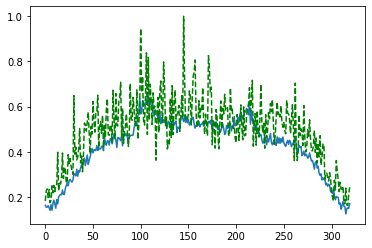

Time taken for epoch:  153.13096141815186
Epoch = [172/3000]  Iter = [   0/39480]  Loss = 0.1555 Avg Loss = 0.1555  Time = 0.0807s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [172/3000]  Iter = [ 100/39480]  Loss = 0.1712 Avg Loss = 0.1563  Time = 0.0034s
Epoch = [172/3000]  Iter = [ 200/39480]  Loss = 0.1557 Avg Loss = 0.1559  Time = 0.0035s
Epoch = [172/3000]  Iter = [ 300/39480]  Loss = 0.1378 Avg Loss = 0.1549  Time = 0.0035s
Epoch = [172/3000]  Iter = [ 400/39480]  Loss = 0.1578 Avg Loss = 0.1534  Time = 0.0034s
Epoch = [172/3000]  Iter = [ 500/39480]  Loss = 0.1451 Avg Loss = 0.1556  Time = 0.0035s
Epoch = [172/3000]  Iter = [ 600/39480]  Loss = 0.1704 Avg Loss = 0.1569  Time = 0.0034s
Epoch = [172/3000]  Iter = [ 700/39480]  Loss = 0.1534 Avg Loss = 0.1548  Time = 0.0035s
Epoch = [172/3000]  Iter = [ 800/39480]  Loss = 0.1543 Avg Loss = 0.1547  Time = 0.0035s
Epoch = [172/3000]  Iter = [ 900/39480]  Loss = 0.1459 Avg Loss = 0.1551  Time = 0.0036s
Epoch = [172/3000]  Iter = [1000/39480]  Loss = 0.1549 Avg Loss = 0.1554  Time = 0.0034s
Epoch = [172/3000]  Iter = [1100/39480]  Loss = 0.145 Avg Loss = 0.1536  Time = 0.0034s
Epoch = [172/3000]  It

Epoch = [172/3000]  Iter = [9400/39480]  Loss = 0.149 Avg Loss = 0.1578  Time = 0.0035s
Epoch = [172/3000]  Iter = [9500/39480]  Loss = 0.1772 Avg Loss = 0.1577  Time = 0.0035s
Epoch = [172/3000]  Iter = [9600/39480]  Loss = 0.1677 Avg Loss = 0.1571  Time = 0.0035s
Epoch = [172/3000]  Iter = [9700/39480]  Loss = 0.192 Avg Loss = 0.1563  Time = 0.0036s
Epoch = [172/3000]  Iter = [9800/39480]  Loss = 0.1623 Avg Loss = 0.1566  Time = 0.0034s
Epoch = [172/3000]  Iter = [9900/39480]  Loss = 0.1538 Avg Loss = 0.157  Time = 0.0035s
Epoch = [172/3000]  Iter = [10000/39480]  Loss = 0.1502 Avg Loss = 0.1552  Time = 0.0035s
Epoch = [172/3000]  Iter = [10100/39480]  Loss = 0.1743 Avg Loss = 0.1555  Time = 0.0031s
Epoch = [172/3000]  Iter = [10200/39480]  Loss = 0.159 Avg Loss = 0.1576  Time = 0.0036s
Epoch = [172/3000]  Iter = [10300/39480]  Loss = 0.146 Avg Loss = 0.1567  Time = 0.0035s
Epoch = [172/3000]  Iter = [10400/39480]  Loss = 0.1669 Avg Loss = 0.1572  Time = 0.0036s
Epoch = [172/3000]  I

Epoch = [172/3000]  Iter = [18600/39480]  Loss = 0.1936 Avg Loss = 0.1582  Time = 0.0033s
Epoch = [172/3000]  Iter = [18700/39480]  Loss = 0.1969 Avg Loss = 0.1557  Time = 0.0032s
Epoch = [172/3000]  Iter = [18800/39480]  Loss = 0.1275 Avg Loss = 0.1563  Time = 0.0033s
Epoch = [172/3000]  Iter = [18900/39480]  Loss = 0.1448 Avg Loss = 0.1562  Time = 0.0034s
Epoch = [172/3000]  Iter = [19000/39480]  Loss = 0.1278 Avg Loss = 0.157  Time = 0.0033s
Epoch = [172/3000]  Iter = [19100/39480]  Loss = 0.1622 Avg Loss = 0.1558  Time = 0.0033s
Epoch = [172/3000]  Iter = [19200/39480]  Loss = 0.1899 Avg Loss = 0.1562  Time = 0.0034s
Epoch = [172/3000]  Iter = [19300/39480]  Loss = 0.1568 Avg Loss = 0.1564  Time = 0.0034s
Epoch = [172/3000]  Iter = [19400/39480]  Loss = 0.1569 Avg Loss = 0.1575  Time = 0.0034s
Epoch = [172/3000]  Iter = [19500/39480]  Loss = 0.147 Avg Loss = 0.1565  Time = 0.0033s
Epoch = [172/3000]  Iter = [19600/39480]  Loss = 0.1803 Avg Loss = 0.1569  Time = 0.0033s
Epoch = [172

Epoch = [172/3000]  Iter = [27800/39480]  Loss = 0.1325 Avg Loss = 0.1565  Time = 0.0035s
Epoch = [172/3000]  Iter = [27900/39480]  Loss = 0.1562 Avg Loss = 0.1567  Time = 0.0035s
Epoch = [172/3000]  Iter = [28000/39480]  Loss = 0.1682 Avg Loss = 0.1575  Time = 0.0033s
Epoch = [172/3000]  Iter = [28100/39480]  Loss = 0.1532 Avg Loss = 0.1576  Time = 0.0033s
Epoch = [172/3000]  Iter = [28200/39480]  Loss = 0.1575 Avg Loss = 0.1574  Time = 0.0035s
Epoch = [172/3000]  Iter = [28300/39480]  Loss = 0.146 Avg Loss = 0.1571  Time = 0.0035s
Epoch = [172/3000]  Iter = [28400/39480]  Loss = 0.1404 Avg Loss = 0.1581  Time = 0.0035s
Epoch = [172/3000]  Iter = [28500/39480]  Loss = 0.1571 Avg Loss = 0.1575  Time = 0.0035s
Epoch = [172/3000]  Iter = [28600/39480]  Loss = 0.1451 Avg Loss = 0.1557  Time = 0.0032s
Epoch = [172/3000]  Iter = [28700/39480]  Loss = 0.1541 Avg Loss = 0.1575  Time = 0.0035s
Epoch = [172/3000]  Iter = [28800/39480]  Loss = 0.1334 Avg Loss = 0.1578  Time = 0.0036s
Epoch = [17

Epoch = [172/3000]  Iter = [37000/39480]  Loss = 0.1793 Avg Loss = 0.1578  Time = 0.0033s
Epoch = [172/3000]  Iter = [37100/39480]  Loss = 0.1347 Avg Loss = 0.1575  Time = 0.0036s
Epoch = [172/3000]  Iter = [37200/39480]  Loss = 0.1354 Avg Loss = 0.1561  Time = 0.0035s
Epoch = [172/3000]  Iter = [37300/39480]  Loss = 0.1384 Avg Loss = 0.1561  Time = 0.0037s
Epoch = [172/3000]  Iter = [37400/39480]  Loss = 0.1768 Avg Loss = 0.1566  Time = 0.0036s
Epoch = [172/3000]  Iter = [37500/39480]  Loss = 0.1682 Avg Loss = 0.1557  Time = 0.0035s
Epoch = [172/3000]  Iter = [37600/39480]  Loss = 0.1874 Avg Loss = 0.1561  Time = 0.0037s
Epoch = [172/3000]  Iter = [37700/39480]  Loss = 0.1774 Avg Loss = 0.1561  Time = 0.0032s
Epoch = [172/3000]  Iter = [37800/39480]  Loss = 0.1788 Avg Loss = 0.158  Time = 0.0036s
Epoch = [172/3000]  Iter = [37900/39480]  Loss = 0.1558 Avg Loss = 0.1569  Time = 0.0036s
Epoch = [172/3000]  Iter = [38000/39480]  Loss = 0.1731 Avg Loss = 0.1567  Time = 0.0036s
Epoch = [17

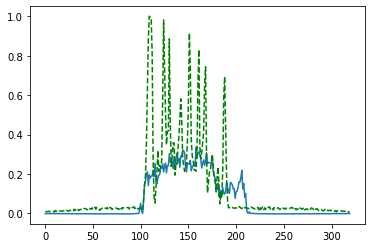

Time taken for epoch:  151.9275324344635
Epoch = [173/3000]  Iter = [   0/39480]  Loss = 0.1338 Avg Loss = 0.1338  Time = 0.0695s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [173/3000]  Iter = [ 100/39480]  Loss = 0.1529 Avg Loss = 0.147  Time = 0.0035s
Epoch = [173/3000]  Iter = [ 200/39480]  Loss = 0.1625 Avg Loss = 0.1533  Time = 0.0035s
Epoch = [173/3000]  Iter = [ 300/39480]  Loss = 0.1885 Avg Loss = 0.1546  Time = 0.0035s
Epoch = [173/3000]  Iter = [ 400/39480]  Loss = 0.149 Avg Loss = 0.1546  Time = 0.0036s
Epoch = [173/3000]  Iter = [ 500/39480]  Loss = 0.1812 Avg Loss = 0.1551  Time = 0.0036s
Epoch = [173/3000]  Iter = [ 600/39480]  Loss = 0.1431 Avg Loss = 0.1551  Time = 0.0036s
Epoch = [173/3000]  Iter = [ 700/39480]  Loss = 0.153 Avg Loss = 0.156  Time = 0.0035s
Epoch = [173/3000]  Iter = [ 800/39480]  Loss = 0.1546 Avg Loss = 0.1557  Time = 0.0035s
Epoch = [173/3000]  Iter = [ 900/39480]  Loss = 0.1613 Avg Loss = 0.1554  Time = 0.0036s
Epoch = [173/3000]  Iter = [1000/39480]  Loss = 0.1357 Avg Loss = 0.1544  Time = 0.0036s
Epoch = [173/3000]  Iter = [1100/39480]  Loss = 0.1594 Avg Loss = 0.1533  Time = 0.0034s
Epoch = [173/3000]  Iter 

Epoch = [173/3000]  Iter = [9400/39480]  Loss = 0.1731 Avg Loss = 0.1557  Time = 0.0035s
Epoch = [173/3000]  Iter = [9500/39480]  Loss = 0.1646 Avg Loss = 0.1566  Time = 0.0029s
Epoch = [173/3000]  Iter = [9600/39480]  Loss = 0.1467 Avg Loss = 0.1556  Time = 0.0029s
Epoch = [173/3000]  Iter = [9700/39480]  Loss = 0.1376 Avg Loss = 0.1578  Time = 0.0029s
Epoch = [173/3000]  Iter = [9800/39480]  Loss = 0.1699 Avg Loss = 0.1557  Time = 0.0030s
Epoch = [173/3000]  Iter = [9900/39480]  Loss = 0.1506 Avg Loss = 0.1557  Time = 0.0031s
Epoch = [173/3000]  Iter = [10000/39480]  Loss = 0.1671 Avg Loss = 0.1572  Time = 0.0036s
Epoch = [173/3000]  Iter = [10100/39480]  Loss = 0.1551 Avg Loss = 0.1581  Time = 0.0036s
Epoch = [173/3000]  Iter = [10200/39480]  Loss = 0.1386 Avg Loss = 0.156  Time = 0.0036s
Epoch = [173/3000]  Iter = [10300/39480]  Loss = 0.1744 Avg Loss = 0.1573  Time = 0.0036s
Epoch = [173/3000]  Iter = [10400/39480]  Loss = 0.1486 Avg Loss = 0.1547  Time = 0.0036s
Epoch = [173/3000

Epoch = [173/3000]  Iter = [18600/39480]  Loss = 0.1397 Avg Loss = 0.157  Time = 0.0035s
Epoch = [173/3000]  Iter = [18700/39480]  Loss = 0.1568 Avg Loss = 0.1546  Time = 0.0034s
Epoch = [173/3000]  Iter = [18800/39480]  Loss = 0.1432 Avg Loss = 0.1552  Time = 0.0036s
Epoch = [173/3000]  Iter = [18900/39480]  Loss = 0.1671 Avg Loss = 0.1565  Time = 0.0033s
Epoch = [173/3000]  Iter = [19000/39480]  Loss = 0.1585 Avg Loss = 0.1559  Time = 0.0034s
Epoch = [173/3000]  Iter = [19100/39480]  Loss = 0.1741 Avg Loss = 0.1578  Time = 0.0035s
Epoch = [173/3000]  Iter = [19200/39480]  Loss = 0.1794 Avg Loss = 0.1578  Time = 0.0035s
Epoch = [173/3000]  Iter = [19300/39480]  Loss = 0.1657 Avg Loss = 0.1576  Time = 0.0033s
Epoch = [173/3000]  Iter = [19400/39480]  Loss = 0.1318 Avg Loss = 0.156  Time = 0.0033s
Epoch = [173/3000]  Iter = [19500/39480]  Loss = 0.1239 Avg Loss = 0.1547  Time = 0.0035s
Epoch = [173/3000]  Iter = [19600/39480]  Loss = 0.1449 Avg Loss = 0.1567  Time = 0.0035s
Epoch = [173

Epoch = [173/3000]  Iter = [27800/39480]  Loss = 0.1653 Avg Loss = 0.1567  Time = 0.0035s
Epoch = [173/3000]  Iter = [27900/39480]  Loss = 0.1686 Avg Loss = 0.1583  Time = 0.0036s
Epoch = [173/3000]  Iter = [28000/39480]  Loss = 0.1419 Avg Loss = 0.157  Time = 0.0036s
Epoch = [173/3000]  Iter = [28100/39480]  Loss = 0.1557 Avg Loss = 0.1584  Time = 0.0034s
Epoch = [173/3000]  Iter = [28200/39480]  Loss = 0.1707 Avg Loss = 0.1583  Time = 0.0036s
Epoch = [173/3000]  Iter = [28300/39480]  Loss = 0.1619 Avg Loss = 0.1578  Time = 0.0031s
Epoch = [173/3000]  Iter = [28400/39480]  Loss = 0.1565 Avg Loss = 0.1569  Time = 0.0036s
Epoch = [173/3000]  Iter = [28500/39480]  Loss = 0.1576 Avg Loss = 0.1573  Time = 0.0036s
Epoch = [173/3000]  Iter = [28600/39480]  Loss = 0.1382 Avg Loss = 0.1566  Time = 0.0036s
Epoch = [173/3000]  Iter = [28700/39480]  Loss = 0.1785 Avg Loss = 0.1587  Time = 0.0036s
Epoch = [173/3000]  Iter = [28800/39480]  Loss = 0.1662 Avg Loss = 0.1585  Time = 0.0036s
Epoch = [17

Epoch = [173/3000]  Iter = [37000/39480]  Loss = 0.1515 Avg Loss = 0.1567  Time = 0.0035s
Epoch = [173/3000]  Iter = [37100/39480]  Loss = 0.1817 Avg Loss = 0.1579  Time = 0.0036s
Epoch = [173/3000]  Iter = [37200/39480]  Loss = 0.1248 Avg Loss = 0.1562  Time = 0.0035s
Epoch = [173/3000]  Iter = [37300/39480]  Loss = 0.181 Avg Loss = 0.1558  Time = 0.0036s
Epoch = [173/3000]  Iter = [37400/39480]  Loss = 0.1605 Avg Loss = 0.1584  Time = 0.0035s
Epoch = [173/3000]  Iter = [37500/39480]  Loss = 0.1303 Avg Loss = 0.1572  Time = 0.0035s
Epoch = [173/3000]  Iter = [37600/39480]  Loss = 0.1401 Avg Loss = 0.158  Time = 0.0036s
Epoch = [173/3000]  Iter = [37700/39480]  Loss = 0.1813 Avg Loss = 0.157  Time = 0.0035s
Epoch = [173/3000]  Iter = [37800/39480]  Loss = 0.1357 Avg Loss = 0.1574  Time = 0.0036s
Epoch = [173/3000]  Iter = [37900/39480]  Loss = 0.125 Avg Loss = 0.1561  Time = 0.0031s
Epoch = [173/3000]  Iter = [38000/39480]  Loss = 0.1645 Avg Loss = 0.1579  Time = 0.0036s
Epoch = [173/3

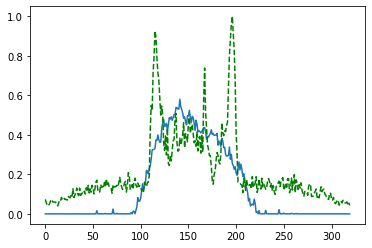

Time taken for epoch:  152.90989661216736
Epoch = [174/3000]  Iter = [   0/39480]  Loss = 0.1593 Avg Loss = 0.1593  Time = 0.0715s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [174/3000]  Iter = [ 100/39480]  Loss = 0.1721 Avg Loss = 0.1568  Time = 0.0035s
Epoch = [174/3000]  Iter = [ 200/39480]  Loss = 0.1747 Avg Loss = 0.1551  Time = 0.0035s
Epoch = [174/3000]  Iter = [ 300/39480]  Loss = 0.1753 Avg Loss = 0.1556  Time = 0.0036s
Epoch = [174/3000]  Iter = [ 400/39480]  Loss = 0.1604 Avg Loss = 0.1566  Time = 0.0035s
Epoch = [174/3000]  Iter = [ 500/39480]  Loss = 0.1462 Avg Loss = 0.1543  Time = 0.0035s
Epoch = [174/3000]  Iter = [ 600/39480]  Loss = 0.1515 Avg Loss = 0.1564  Time = 0.0035s
Epoch = [174/3000]  Iter = [ 700/39480]  Loss = 0.1509 Avg Loss = 0.1578  Time = 0.0037s
Epoch = [174/3000]  Iter = [ 800/39480]  Loss = 0.1639 Avg Loss = 0.1572  Time = 0.0034s
Epoch = [174/3000]  Iter = [ 900/39480]  Loss = 0.1346 Avg Loss = 0.1551  Time = 0.0037s
Epoch = [174/3000]  Iter = [1000/39480]  Loss = 0.1565 Avg Loss = 0.1559  Time = 0.0034s
Epoch = [174/3000]  Iter = [1100/39480]  Loss = 0.1615 Avg Loss = 0.1552  Time = 0.0034s
Epoch = [174/3000]  I

Epoch = [174/3000]  Iter = [9400/39480]  Loss = 0.1643 Avg Loss = 0.1582  Time = 0.0035s
Epoch = [174/3000]  Iter = [9500/39480]  Loss = 0.1364 Avg Loss = 0.1574  Time = 0.0032s
Epoch = [174/3000]  Iter = [9600/39480]  Loss = 0.1542 Avg Loss = 0.1553  Time = 0.0036s
Epoch = [174/3000]  Iter = [9700/39480]  Loss = 0.1729 Avg Loss = 0.156  Time = 0.0036s
Epoch = [174/3000]  Iter = [9800/39480]  Loss = 0.1809 Avg Loss = 0.1581  Time = 0.0037s
Epoch = [174/3000]  Iter = [9900/39480]  Loss = 0.137 Avg Loss = 0.1554  Time = 0.0035s
Epoch = [174/3000]  Iter = [10000/39480]  Loss = 0.1395 Avg Loss = 0.156  Time = 0.0034s
Epoch = [174/3000]  Iter = [10100/39480]  Loss = 0.1722 Avg Loss = 0.1579  Time = 0.0035s
Epoch = [174/3000]  Iter = [10200/39480]  Loss = 0.1488 Avg Loss = 0.1571  Time = 0.0036s
Epoch = [174/3000]  Iter = [10300/39480]  Loss = 0.1661 Avg Loss = 0.1567  Time = 0.0032s
Epoch = [174/3000]  Iter = [10400/39480]  Loss = 0.1839 Avg Loss = 0.1556  Time = 0.0035s
Epoch = [174/3000] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch = [190/3000]  Iter = [30400/39480]  Loss = 0.1749 Avg Loss = 0.1577  Time = 0.0035s
Epoch = [190/3000]  Iter = [30500/39480]  Loss = 0.1414 Avg Loss = 0.1568  Time = 0.0035s
Epoch = [190/3000]  Iter = [30600/39480]  Loss = 0.1465 Avg Loss = 0.1566  Time = 0.0036s
Epoch = [190/3000]  Iter = [30700/39480]  Loss = 0.1724 Avg Loss = 0.1564  Time = 0.0036s
Epoch = [190/3000]  Iter = [30800/39480]  Loss = 0.1464 Avg Loss = 0.1564  Time = 0.0036s
Epoch = [190/3000]  Iter = [30900/39480]  Loss = 0.1535 Avg Loss = 0.1564  Time = 0.0036s
Epoch = [190/3000]  Iter = [31000/39480]  Loss = 0.1607 Avg Loss = 0.1574  Time = 0.0031s
Epoch = [190/3000]  Iter = [31100/39480]  Loss = 0.1751 Avg Loss = 0.1566  Time = 0.0036s
Epoch = [190/3000]  Iter = [31200/39480]  Loss = 0.1573 Avg Loss = 0.1562  Time = 0.0035s
Epoch = [190/3000]  Iter = [31300/39480]  Loss = 0.1613 Avg Loss = 0.1547  Time = 0.0031s
Epoch = [190/3000]  Iter = [31400/39480]  Loss = 0.1677 Avg Loss = 0.1549  Time = 0.0032s
Epoch = [1

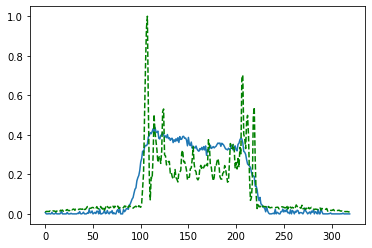

Time taken for epoch:  152.54217505455017
Epoch = [191/3000]  Iter = [   0/39480]  Loss = 0.1516 Avg Loss = 0.1516  Time = 0.0730s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [191/3000]  Iter = [ 100/39480]  Loss = 0.159 Avg Loss = 0.1556  Time = 0.0033s
Epoch = [191/3000]  Iter = [ 200/39480]  Loss = 0.1563 Avg Loss = 0.1559  Time = 0.0037s
Epoch = [191/3000]  Iter = [ 300/39480]  Loss = 0.1647 Avg Loss = 0.1564  Time = 0.0037s
Epoch = [191/3000]  Iter = [ 400/39480]  Loss = 0.1827 Avg Loss = 0.157  Time = 0.0036s
Epoch = [191/3000]  Iter = [ 500/39480]  Loss = 0.1717 Avg Loss = 0.1567  Time = 0.0036s
Epoch = [191/3000]  Iter = [ 600/39480]  Loss = 0.1472 Avg Loss = 0.1551  Time = 0.0036s
Epoch = [191/3000]  Iter = [ 700/39480]  Loss = 0.1553 Avg Loss = 0.1554  Time = 0.0037s
Epoch = [191/3000]  Iter = [ 800/39480]  Loss = 0.1419 Avg Loss = 0.1569  Time = 0.0036s
Epoch = [191/3000]  Iter = [ 900/39480]  Loss = 0.1632 Avg Loss = 0.1559  Time = 0.0035s
Epoch = [191/3000]  Iter = [1000/39480]  Loss = 0.1389 Avg Loss = 0.155  Time = 0.0036s
Epoch = [191/3000]  Iter = [1100/39480]  Loss = 0.1446 Avg Loss = 0.1557  Time = 0.0036s
Epoch = [191/3000]  Iter

Epoch = [191/3000]  Iter = [9400/39480]  Loss = 0.1377 Avg Loss = 0.156  Time = 0.0035s
Epoch = [191/3000]  Iter = [9500/39480]  Loss = 0.1398 Avg Loss = 0.1561  Time = 0.0035s
Epoch = [191/3000]  Iter = [9600/39480]  Loss = 0.1743 Avg Loss = 0.1565  Time = 0.0035s
Epoch = [191/3000]  Iter = [9700/39480]  Loss = 0.1495 Avg Loss = 0.1556  Time = 0.0035s
Epoch = [191/3000]  Iter = [9800/39480]  Loss = 0.1655 Avg Loss = 0.1562  Time = 0.0031s
Epoch = [191/3000]  Iter = [9900/39480]  Loss = 0.1617 Avg Loss = 0.1561  Time = 0.0035s
Epoch = [191/3000]  Iter = [10000/39480]  Loss = 0.1637 Avg Loss = 0.1567  Time = 0.0034s
Epoch = [191/3000]  Iter = [10100/39480]  Loss = 0.1545 Avg Loss = 0.1576  Time = 0.0035s
Epoch = [191/3000]  Iter = [10200/39480]  Loss = 0.1367 Avg Loss = 0.1575  Time = 0.0035s
Epoch = [191/3000]  Iter = [10300/39480]  Loss = 0.1515 Avg Loss = 0.1587  Time = 0.0035s
Epoch = [191/3000]  Iter = [10400/39480]  Loss = 0.1525 Avg Loss = 0.1567  Time = 0.0035s
Epoch = [191/3000

Epoch = [191/3000]  Iter = [18600/39480]  Loss = 0.1478 Avg Loss = 0.1556  Time = 0.0035s
Epoch = [191/3000]  Iter = [18700/39480]  Loss = 0.1747 Avg Loss = 0.1561  Time = 0.0035s
Epoch = [191/3000]  Iter = [18800/39480]  Loss = 0.1419 Avg Loss = 0.1565  Time = 0.0035s
Epoch = [191/3000]  Iter = [18900/39480]  Loss = 0.1486 Avg Loss = 0.1566  Time = 0.0036s
Epoch = [191/3000]  Iter = [19000/39480]  Loss = 0.1449 Avg Loss = 0.157  Time = 0.0036s
Epoch = [191/3000]  Iter = [19100/39480]  Loss = 0.1355 Avg Loss = 0.1571  Time = 0.0035s
Epoch = [191/3000]  Iter = [19200/39480]  Loss = 0.1637 Avg Loss = 0.1568  Time = 0.0036s
Epoch = [191/3000]  Iter = [19300/39480]  Loss = 0.1283 Avg Loss = 0.1552  Time = 0.0035s
Epoch = [191/3000]  Iter = [19400/39480]  Loss = 0.1612 Avg Loss = 0.1562  Time = 0.0036s
Epoch = [191/3000]  Iter = [19500/39480]  Loss = 0.1418 Avg Loss = 0.1566  Time = 0.0036s
Epoch = [191/3000]  Iter = [19600/39480]  Loss = 0.1742 Avg Loss = 0.1564  Time = 0.0034s
Epoch = [19

Epoch = [191/3000]  Iter = [27800/39480]  Loss = 0.159 Avg Loss = 0.1563  Time = 0.0031s
Epoch = [191/3000]  Iter = [27900/39480]  Loss = 0.1499 Avg Loss = 0.1571  Time = 0.0031s
Epoch = [191/3000]  Iter = [28000/39480]  Loss = 0.1427 Avg Loss = 0.1555  Time = 0.0035s
Epoch = [191/3000]  Iter = [28100/39480]  Loss = 0.1726 Avg Loss = 0.1566  Time = 0.0035s
Epoch = [191/3000]  Iter = [28200/39480]  Loss = 0.1427 Avg Loss = 0.1574  Time = 0.0034s
Epoch = [191/3000]  Iter = [28300/39480]  Loss = 0.1419 Avg Loss = 0.159  Time = 0.0031s
Epoch = [191/3000]  Iter = [28400/39480]  Loss = 0.1806 Avg Loss = 0.1582  Time = 0.0035s
Epoch = [191/3000]  Iter = [28500/39480]  Loss = 0.1308 Avg Loss = 0.1565  Time = 0.0035s
Epoch = [191/3000]  Iter = [28600/39480]  Loss = 0.1507 Avg Loss = 0.1557  Time = 0.0036s
Epoch = [191/3000]  Iter = [28700/39480]  Loss = 0.1611 Avg Loss = 0.1576  Time = 0.0036s
Epoch = [191/3000]  Iter = [28800/39480]  Loss = 0.1614 Avg Loss = 0.1575  Time = 0.0035s
Epoch = [191

Epoch = [191/3000]  Iter = [37000/39480]  Loss = 0.1557 Avg Loss = 0.1576  Time = 0.0036s
Epoch = [191/3000]  Iter = [37100/39480]  Loss = 0.1568 Avg Loss = 0.157  Time = 0.0036s
Epoch = [191/3000]  Iter = [37200/39480]  Loss = 0.1715 Avg Loss = 0.1563  Time = 0.0036s
Epoch = [191/3000]  Iter = [37300/39480]  Loss = 0.158 Avg Loss = 0.1575  Time = 0.0036s
Epoch = [191/3000]  Iter = [37400/39480]  Loss = 0.1764 Avg Loss = 0.1565  Time = 0.0036s
Epoch = [191/3000]  Iter = [37500/39480]  Loss = 0.1567 Avg Loss = 0.1564  Time = 0.0036s
Epoch = [191/3000]  Iter = [37600/39480]  Loss = 0.1685 Avg Loss = 0.1566  Time = 0.0035s
Epoch = [191/3000]  Iter = [37700/39480]  Loss = 0.1506 Avg Loss = 0.156  Time = 0.0036s
Epoch = [191/3000]  Iter = [37800/39480]  Loss = 0.1675 Avg Loss = 0.1573  Time = 0.0037s
Epoch = [191/3000]  Iter = [37900/39480]  Loss = 0.1173 Avg Loss = 0.1563  Time = 0.0032s
Epoch = [191/3000]  Iter = [38000/39480]  Loss = 0.1543 Avg Loss = 0.1542  Time = 0.0034s
Epoch = [191/

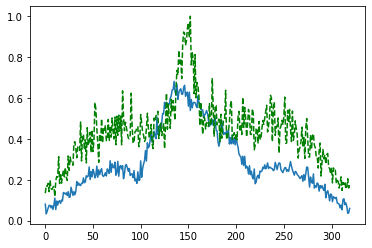

Time taken for epoch:  153.52128982543945
Epoch = [192/3000]  Iter = [   0/39480]  Loss = 0.1405 Avg Loss = 0.1405  Time = 0.0794s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [192/3000]  Iter = [ 100/39480]  Loss = 0.1355 Avg Loss = 0.1489  Time = 0.0029s
Epoch = [192/3000]  Iter = [ 200/39480]  Loss = 0.1596 Avg Loss = 0.154  Time = 0.0035s
Epoch = [192/3000]  Iter = [ 300/39480]  Loss = 0.1518 Avg Loss = 0.1552  Time = 0.0035s
Epoch = [192/3000]  Iter = [ 400/39480]  Loss = 0.1425 Avg Loss = 0.1559  Time = 0.0035s
Epoch = [192/3000]  Iter = [ 500/39480]  Loss = 0.1752 Avg Loss = 0.1568  Time = 0.0035s
Epoch = [192/3000]  Iter = [ 600/39480]  Loss = 0.1455 Avg Loss = 0.1559  Time = 0.0035s
Epoch = [192/3000]  Iter = [ 700/39480]  Loss = 0.1719 Avg Loss = 0.1586  Time = 0.0034s
Epoch = [192/3000]  Iter = [ 800/39480]  Loss = 0.1797 Avg Loss = 0.157  Time = 0.0031s
Epoch = [192/3000]  Iter = [ 900/39480]  Loss = 0.1726 Avg Loss = 0.1563  Time = 0.0034s
Epoch = [192/3000]  Iter = [1000/39480]  Loss = 0.185 Avg Loss = 0.1556  Time = 0.0035s
Epoch = [192/3000]  Iter = [1100/39480]  Loss = 0.1871 Avg Loss = 0.1566  Time = 0.0031s
Epoch = [192/3000]  Iter

Epoch = [192/3000]  Iter = [9400/39480]  Loss = 0.1516 Avg Loss = 0.1587  Time = 0.0034s
Epoch = [192/3000]  Iter = [9500/39480]  Loss = 0.1564 Avg Loss = 0.1568  Time = 0.0035s
Epoch = [192/3000]  Iter = [9600/39480]  Loss = 0.1914 Avg Loss = 0.1581  Time = 0.0035s
Epoch = [192/3000]  Iter = [9700/39480]  Loss = 0.17 Avg Loss = 0.1582  Time = 0.0036s
Epoch = [192/3000]  Iter = [9800/39480]  Loss = 0.1639 Avg Loss = 0.1546  Time = 0.0036s
Epoch = [192/3000]  Iter = [9900/39480]  Loss = 0.1353 Avg Loss = 0.1545  Time = 0.0035s
Epoch = [192/3000]  Iter = [10000/39480]  Loss = 0.1639 Avg Loss = 0.1576  Time = 0.0035s
Epoch = [192/3000]  Iter = [10100/39480]  Loss = 0.1607 Avg Loss = 0.1575  Time = 0.0033s
Epoch = [192/3000]  Iter = [10200/39480]  Loss = 0.1346 Avg Loss = 0.1541  Time = 0.0033s
Epoch = [192/3000]  Iter = [10300/39480]  Loss = 0.1505 Avg Loss = 0.1549  Time = 0.0035s
Epoch = [192/3000]  Iter = [10400/39480]  Loss = 0.1431 Avg Loss = 0.1552  Time = 0.0035s
Epoch = [192/3000]

Epoch = [231/3000]  Iter = [23800/39480]  Loss = 0.1254 Avg Loss = 0.1413  Time = 0.0029s
Epoch = [231/3000]  Iter = [23900/39480]  Loss = 0.1506 Avg Loss = 0.1412  Time = 0.0036s
Epoch = [231/3000]  Iter = [24000/39480]  Loss = 0.1358 Avg Loss = 0.1426  Time = 0.0034s
Epoch = [231/3000]  Iter = [24100/39480]  Loss = 0.1217 Avg Loss = 0.142  Time = 0.0033s
Epoch = [231/3000]  Iter = [24200/39480]  Loss = 0.1669 Avg Loss = 0.1417  Time = 0.0036s
Epoch = [231/3000]  Iter = [24300/39480]  Loss = 0.1328 Avg Loss = 0.1412  Time = 0.0033s
Epoch = [231/3000]  Iter = [24400/39480]  Loss = 0.1442 Avg Loss = 0.1427  Time = 0.0034s
Epoch = [231/3000]  Iter = [24500/39480]  Loss = 0.1254 Avg Loss = 0.1424  Time = 0.0035s
Epoch = [231/3000]  Iter = [24600/39480]  Loss = 0.1593 Avg Loss = 0.1416  Time = 0.0035s
Epoch = [231/3000]  Iter = [24700/39480]  Loss = 0.1284 Avg Loss = 0.1423  Time = 0.0035s
Epoch = [231/3000]  Iter = [24800/39480]  Loss = 0.1353 Avg Loss = 0.1418  Time = 0.0036s
Epoch = [23

Epoch = [231/3000]  Iter = [33000/39480]  Loss = 0.1522 Avg Loss = 0.1409  Time = 0.0033s
Epoch = [231/3000]  Iter = [33100/39480]  Loss = 0.1252 Avg Loss = 0.1416  Time = 0.0036s
Epoch = [231/3000]  Iter = [33200/39480]  Loss = 0.133 Avg Loss = 0.1419  Time = 0.0035s
Epoch = [231/3000]  Iter = [33300/39480]  Loss = 0.1573 Avg Loss = 0.1412  Time = 0.0036s
Epoch = [231/3000]  Iter = [33400/39480]  Loss = 0.1425 Avg Loss = 0.1426  Time = 0.0036s
Epoch = [231/3000]  Iter = [33500/39480]  Loss = 0.1451 Avg Loss = 0.1437  Time = 0.0042s
Epoch = [231/3000]  Iter = [33600/39480]  Loss = 0.1551 Avg Loss = 0.1424  Time = 0.0035s
Epoch = [231/3000]  Iter = [33700/39480]  Loss = 0.1485 Avg Loss = 0.1426  Time = 0.0037s
Epoch = [231/3000]  Iter = [33800/39480]  Loss = 0.1388 Avg Loss = 0.1429  Time = 0.0034s
Epoch = [231/3000]  Iter = [33900/39480]  Loss = 0.1109 Avg Loss = 0.1426  Time = 0.0035s
Epoch = [231/3000]  Iter = [34000/39480]  Loss = 0.139 Avg Loss = 0.1417  Time = 0.0036s
Epoch = [231

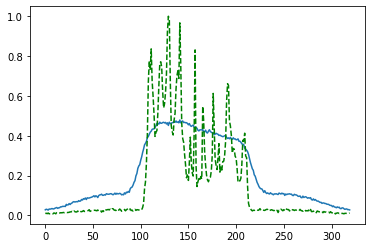

Time taken for epoch:  156.84182596206665
Epoch = [232/3000]  Iter = [   0/39480]  Loss = 0.1452 Avg Loss = 0.1452  Time = 0.0793s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [232/3000]  Iter = [ 100/39480]  Loss = 0.1188 Avg Loss = 0.1417  Time = 0.0031s
Epoch = [232/3000]  Iter = [ 200/39480]  Loss = 0.1255 Avg Loss = 0.1411  Time = 0.0035s
Epoch = [232/3000]  Iter = [ 300/39480]  Loss = 0.1452 Avg Loss = 0.1403  Time = 0.0035s
Epoch = [232/3000]  Iter = [ 400/39480]  Loss = 0.1438 Avg Loss = 0.1405  Time = 0.0036s
Epoch = [232/3000]  Iter = [ 500/39480]  Loss = 0.1451 Avg Loss = 0.141  Time = 0.0036s
Epoch = [232/3000]  Iter = [ 600/39480]  Loss = 0.1392 Avg Loss = 0.1391  Time = 0.0038s
Epoch = [232/3000]  Iter = [ 700/39480]  Loss = 0.1651 Avg Loss = 0.14  Time = 0.0037s
Epoch = [232/3000]  Iter = [ 800/39480]  Loss = 0.1418 Avg Loss = 0.1405  Time = 0.0035s
Epoch = [232/3000]  Iter = [ 900/39480]  Loss = 0.1334 Avg Loss = 0.1408  Time = 0.0036s
Epoch = [232/3000]  Iter = [1000/39480]  Loss = 0.1254 Avg Loss = 0.1408  Time = 0.0034s
Epoch = [232/3000]  Iter = [1100/39480]  Loss = 0.1463 Avg Loss = 0.141  Time = 0.0036s
Epoch = [232/3000]  Iter 

Epoch = [232/3000]  Iter = [9400/39480]  Loss = 0.1435 Avg Loss = 0.1409  Time = 0.0034s
Epoch = [232/3000]  Iter = [9500/39480]  Loss = 0.1648 Avg Loss = 0.1427  Time = 0.0036s
Epoch = [232/3000]  Iter = [9600/39480]  Loss = 0.1293 Avg Loss = 0.141  Time = 0.0032s
Epoch = [232/3000]  Iter = [9700/39480]  Loss = 0.1484 Avg Loss = 0.1414  Time = 0.0033s
Epoch = [232/3000]  Iter = [9800/39480]  Loss = 0.1292 Avg Loss = 0.1394  Time = 0.0033s
Epoch = [232/3000]  Iter = [9900/39480]  Loss = 0.153 Avg Loss = 0.1405  Time = 0.0035s
Epoch = [232/3000]  Iter = [10000/39480]  Loss = 0.1393 Avg Loss = 0.1412  Time = 0.0035s
Epoch = [232/3000]  Iter = [10100/39480]  Loss = 0.137 Avg Loss = 0.142  Time = 0.0035s
Epoch = [232/3000]  Iter = [10200/39480]  Loss = 0.1357 Avg Loss = 0.1417  Time = 0.0036s
Epoch = [232/3000]  Iter = [10300/39480]  Loss = 0.1279 Avg Loss = 0.1419  Time = 0.0030s
Epoch = [232/3000]  Iter = [10400/39480]  Loss = 0.1337 Avg Loss = 0.1424  Time = 0.0035s
Epoch = [232/3000]  

Epoch = [232/3000]  Iter = [18600/39480]  Loss = 0.1412 Avg Loss = 0.1412  Time = 0.0034s
Epoch = [232/3000]  Iter = [18700/39480]  Loss = 0.1323 Avg Loss = 0.1408  Time = 0.0032s
Epoch = [232/3000]  Iter = [18800/39480]  Loss = 0.1248 Avg Loss = 0.1408  Time = 0.0040s
Epoch = [232/3000]  Iter = [18900/39480]  Loss = 0.142 Avg Loss = 0.1425  Time = 0.0046s
Epoch = [232/3000]  Iter = [19000/39480]  Loss = 0.1364 Avg Loss = 0.1421  Time = 0.0035s
Epoch = [232/3000]  Iter = [19100/39480]  Loss = 0.1347 Avg Loss = 0.1407  Time = 0.0035s
Epoch = [232/3000]  Iter = [19200/39480]  Loss = 0.1436 Avg Loss = 0.1403  Time = 0.0034s
Epoch = [232/3000]  Iter = [19300/39480]  Loss = 0.1502 Avg Loss = 0.1407  Time = 0.0034s
Epoch = [232/3000]  Iter = [19400/39480]  Loss = 0.169 Avg Loss = 0.1414  Time = 0.0035s
Epoch = [232/3000]  Iter = [19500/39480]  Loss = 0.1214 Avg Loss = 0.1413  Time = 0.0033s
Epoch = [232/3000]  Iter = [19600/39480]  Loss = 0.1522 Avg Loss = 0.1404  Time = 0.0036s
Epoch = [232

Epoch = [232/3000]  Iter = [27800/39480]  Loss = 0.1407 Avg Loss = 0.1407  Time = 0.0036s
Epoch = [232/3000]  Iter = [27900/39480]  Loss = 0.1445 Avg Loss = 0.1428  Time = 0.0035s
Epoch = [232/3000]  Iter = [28000/39480]  Loss = 0.1468 Avg Loss = 0.1418  Time = 0.0040s
Epoch = [232/3000]  Iter = [28100/39480]  Loss = 0.1386 Avg Loss = 0.1405  Time = 0.0032s
Epoch = [232/3000]  Iter = [28200/39480]  Loss = 0.1415 Avg Loss = 0.1403  Time = 0.0035s
Epoch = [232/3000]  Iter = [28300/39480]  Loss = 0.164 Avg Loss = 0.1408  Time = 0.0035s
Epoch = [232/3000]  Iter = [28400/39480]  Loss = 0.1615 Avg Loss = 0.1395  Time = 0.0042s
Epoch = [232/3000]  Iter = [28500/39480]  Loss = 0.1318 Avg Loss = 0.1423  Time = 0.0035s
Epoch = [232/3000]  Iter = [28600/39480]  Loss = 0.1564 Avg Loss = 0.1416  Time = 0.0036s
Epoch = [232/3000]  Iter = [28700/39480]  Loss = 0.1386 Avg Loss = 0.1421  Time = 0.0038s
Epoch = [232/3000]  Iter = [28800/39480]  Loss = 0.1454 Avg Loss = 0.1407  Time = 0.0034s
Epoch = [23

Epoch = [232/3000]  Iter = [37000/39480]  Loss = 0.1565 Avg Loss = 0.1408  Time = 0.0036s
Epoch = [232/3000]  Iter = [37100/39480]  Loss = 0.1566 Avg Loss = 0.1412  Time = 0.0040s
Epoch = [232/3000]  Iter = [37200/39480]  Loss = 0.1248 Avg Loss = 0.1425  Time = 0.0036s
Epoch = [232/3000]  Iter = [37300/39480]  Loss = 0.1434 Avg Loss = 0.142  Time = 0.0037s
Epoch = [232/3000]  Iter = [37400/39480]  Loss = 0.1164 Avg Loss = 0.1413  Time = 0.0037s
Epoch = [232/3000]  Iter = [37500/39480]  Loss = 0.1426 Avg Loss = 0.1424  Time = 0.0037s
Epoch = [232/3000]  Iter = [37600/39480]  Loss = 0.1496 Avg Loss = 0.1426  Time = 0.0036s
Epoch = [232/3000]  Iter = [37700/39480]  Loss = 0.1447 Avg Loss = 0.142  Time = 0.0036s
Epoch = [232/3000]  Iter = [37800/39480]  Loss = 0.1393 Avg Loss = 0.1427  Time = 0.0036s
Epoch = [232/3000]  Iter = [37900/39480]  Loss = 0.1366 Avg Loss = 0.1406  Time = 0.0034s
Epoch = [232/3000]  Iter = [38000/39480]  Loss = 0.1349 Avg Loss = 0.14  Time = 0.0036s
Epoch = [232/3

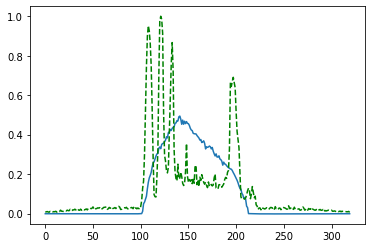

Time taken for epoch:  156.31955003738403
Epoch = [233/3000]  Iter = [   0/39480]  Loss = 0.1266 Avg Loss = 0.1266  Time = 0.1046s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [233/3000]  Iter = [ 100/39480]  Loss = 0.1282 Avg Loss = 0.136  Time = 0.0035s
Epoch = [233/3000]  Iter = [ 200/39480]  Loss = 0.1495 Avg Loss = 0.1387  Time = 0.0036s
Epoch = [233/3000]  Iter = [ 300/39480]  Loss = 0.1396 Avg Loss = 0.1388  Time = 0.0044s
Epoch = [233/3000]  Iter = [ 400/39480]  Loss = 0.1378 Avg Loss = 0.1399  Time = 0.0035s
Epoch = [233/3000]  Iter = [ 500/39480]  Loss = 0.1478 Avg Loss = 0.1427  Time = 0.0051s
Epoch = [233/3000]  Iter = [ 600/39480]  Loss = 0.1564 Avg Loss = 0.1419  Time = 0.0033s
Epoch = [233/3000]  Iter = [ 700/39480]  Loss = 0.1446 Avg Loss = 0.1406  Time = 0.0034s
Epoch = [233/3000]  Iter = [ 800/39480]  Loss = 0.1437 Avg Loss = 0.1399  Time = 0.0035s
Epoch = [233/3000]  Iter = [ 900/39480]  Loss = 0.1319 Avg Loss = 0.1402  Time = 0.0044s
Epoch = [233/3000]  Iter = [1000/39480]  Loss = 0.1183 Avg Loss = 0.1403  Time = 0.0035s
Epoch = [233/3000]  Iter = [1100/39480]  Loss = 0.1288 Avg Loss = 0.1406  Time = 0.0033s
Epoch = [233/3000]  It

Epoch = [233/3000]  Iter = [9400/39480]  Loss = 0.143 Avg Loss = 0.14  Time = 0.0038s
Epoch = [233/3000]  Iter = [9500/39480]  Loss = 0.12 Avg Loss = 0.1413  Time = 0.0036s
Epoch = [233/3000]  Iter = [9600/39480]  Loss = 0.1408 Avg Loss = 0.141  Time = 0.0036s
Epoch = [233/3000]  Iter = [9700/39480]  Loss = 0.1517 Avg Loss = 0.1404  Time = 0.0033s
Epoch = [233/3000]  Iter = [9800/39480]  Loss = 0.1336 Avg Loss = 0.1391  Time = 0.0036s
Epoch = [233/3000]  Iter = [9900/39480]  Loss = 0.1341 Avg Loss = 0.1405  Time = 0.0030s
Epoch = [233/3000]  Iter = [10000/39480]  Loss = 0.1232 Avg Loss = 0.1402  Time = 0.0036s
Epoch = [233/3000]  Iter = [10100/39480]  Loss = 0.1607 Avg Loss = 0.1396  Time = 0.0035s
Epoch = [233/3000]  Iter = [10200/39480]  Loss = 0.1394 Avg Loss = 0.1399  Time = 0.0034s
Epoch = [233/3000]  Iter = [10300/39480]  Loss = 0.1268 Avg Loss = 0.1402  Time = 0.0038s
Epoch = [233/3000]  Iter = [10400/39480]  Loss = 0.1486 Avg Loss = 0.1405  Time = 0.0036s
Epoch = [233/3000]  It

Epoch = [233/3000]  Iter = [18600/39480]  Loss = 0.1512 Avg Loss = 0.1424  Time = 0.0034s
Epoch = [233/3000]  Iter = [18700/39480]  Loss = 0.1787 Avg Loss = 0.1428  Time = 0.0043s
Epoch = [233/3000]  Iter = [18800/39480]  Loss = 0.134 Avg Loss = 0.1418  Time = 0.0036s
Epoch = [233/3000]  Iter = [18900/39480]  Loss = 0.1344 Avg Loss = 0.1408  Time = 0.0034s
Epoch = [233/3000]  Iter = [19000/39480]  Loss = 0.1559 Avg Loss = 0.1425  Time = 0.0033s
Epoch = [233/3000]  Iter = [19100/39480]  Loss = 0.1155 Avg Loss = 0.1413  Time = 0.0032s
Epoch = [233/3000]  Iter = [19200/39480]  Loss = 0.1226 Avg Loss = 0.1407  Time = 0.0036s
Epoch = [233/3000]  Iter = [19300/39480]  Loss = 0.1217 Avg Loss = 0.1418  Time = 0.0038s
Epoch = [233/3000]  Iter = [19400/39480]  Loss = 0.1516 Avg Loss = 0.1419  Time = 0.0035s
Epoch = [233/3000]  Iter = [19500/39480]  Loss = 0.1486 Avg Loss = 0.1411  Time = 0.0033s
Epoch = [233/3000]  Iter = [19600/39480]  Loss = 0.1339 Avg Loss = 0.1413  Time = 0.0036s
Epoch = [23

Epoch = [233/3000]  Iter = [27800/39480]  Loss = 0.1197 Avg Loss = 0.1421  Time = 0.0025s
Epoch = [233/3000]  Iter = [27900/39480]  Loss = 0.1565 Avg Loss = 0.143  Time = 0.0027s
Epoch = [233/3000]  Iter = [28000/39480]  Loss = 0.1337 Avg Loss = 0.1424  Time = 0.0031s
Epoch = [233/3000]  Iter = [28100/39480]  Loss = 0.1316 Avg Loss = 0.1437  Time = 0.0035s
Epoch = [233/3000]  Iter = [28200/39480]  Loss = 0.1355 Avg Loss = 0.1421  Time = 0.0029s
Epoch = [233/3000]  Iter = [28300/39480]  Loss = 0.1438 Avg Loss = 0.1426  Time = 0.0036s
Epoch = [233/3000]  Iter = [28400/39480]  Loss = 0.1092 Avg Loss = 0.1412  Time = 0.0025s
Epoch = [233/3000]  Iter = [28500/39480]  Loss = 0.1294 Avg Loss = 0.1421  Time = 0.0031s
Epoch = [233/3000]  Iter = [28600/39480]  Loss = 0.1265 Avg Loss = 0.1421  Time = 0.0031s
Epoch = [233/3000]  Iter = [28700/39480]  Loss = 0.1387 Avg Loss = 0.1415  Time = 0.0078s
Epoch = [233/3000]  Iter = [28800/39480]  Loss = 0.1345 Avg Loss = 0.1426  Time = 0.0033s
Epoch = [23

Epoch = [233/3000]  Iter = [37000/39480]  Loss = 0.1294 Avg Loss = 0.1431  Time = 0.0028s
Epoch = [233/3000]  Iter = [37100/39480]  Loss = 0.1497 Avg Loss = 0.1424  Time = 0.0029s
Epoch = [233/3000]  Iter = [37200/39480]  Loss = 0.1642 Avg Loss = 0.1418  Time = 0.0024s
Epoch = [233/3000]  Iter = [37300/39480]  Loss = 0.127 Avg Loss = 0.1421  Time = 0.0028s
Epoch = [233/3000]  Iter = [37400/39480]  Loss = 0.1292 Avg Loss = 0.1418  Time = 0.0035s
Epoch = [233/3000]  Iter = [37500/39480]  Loss = 0.1561 Avg Loss = 0.1419  Time = 0.0022s
Epoch = [233/3000]  Iter = [37600/39480]  Loss = 0.1247 Avg Loss = 0.1421  Time = 0.0025s
Epoch = [233/3000]  Iter = [37700/39480]  Loss = 0.1342 Avg Loss = 0.1417  Time = 0.0074s
Epoch = [233/3000]  Iter = [37800/39480]  Loss = 0.1462 Avg Loss = 0.1424  Time = 0.0030s
Epoch = [233/3000]  Iter = [37900/39480]  Loss = 0.1193 Avg Loss = 0.1409  Time = 0.0025s
Epoch = [233/3000]  Iter = [38000/39480]  Loss = 0.1718 Avg Loss = 0.1406  Time = 0.0023s
Epoch = [23

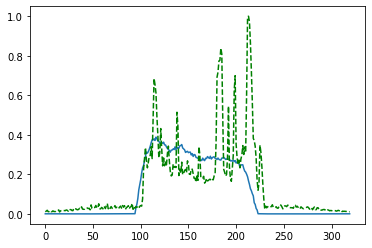

Time taken for epoch:  151.82128429412842
Epoch = [234/3000]  Iter = [   0/39480]  Loss = 0.1441 Avg Loss = 0.1441  Time = 0.0969s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [234/3000]  Iter = [ 100/39480]  Loss = 0.1482 Avg Loss = 0.1418  Time = 0.0033s
Epoch = [234/3000]  Iter = [ 200/39480]  Loss = 0.1586 Avg Loss = 0.1418  Time = 0.0033s
Epoch = [234/3000]  Iter = [ 300/39480]  Loss = 0.1377 Avg Loss = 0.141  Time = 0.0035s
Epoch = [234/3000]  Iter = [ 400/39480]  Loss = 0.1558 Avg Loss = 0.1415  Time = 0.0023s
Epoch = [234/3000]  Iter = [ 500/39480]  Loss = 0.128 Avg Loss = 0.1406  Time = 0.0021s
Epoch = [234/3000]  Iter = [ 600/39480]  Loss = 0.1617 Avg Loss = 0.1408  Time = 0.0025s
Epoch = [234/3000]  Iter = [ 700/39480]  Loss = 0.1545 Avg Loss = 0.1411  Time = 0.0033s
Epoch = [234/3000]  Iter = [ 800/39480]  Loss = 0.1547 Avg Loss = 0.1415  Time = 0.0030s
Epoch = [234/3000]  Iter = [ 900/39480]  Loss = 0.1533 Avg Loss = 0.1417  Time = 0.0027s
Epoch = [234/3000]  Iter = [1000/39480]  Loss = 0.1419 Avg Loss = 0.1418  Time = 0.0030s
Epoch = [234/3000]  Iter = [1100/39480]  Loss = 0.1428 Avg Loss = 0.1426  Time = 0.0033s
Epoch = [234/3000]  Ite

Epoch = [234/3000]  Iter = [9400/39480]  Loss = 0.1156 Avg Loss = 0.1405  Time = 0.0028s
Epoch = [234/3000]  Iter = [9500/39480]  Loss = 0.1446 Avg Loss = 0.1404  Time = 0.0032s
Epoch = [234/3000]  Iter = [9600/39480]  Loss = 0.1663 Avg Loss = 0.1403  Time = 0.0155s
Epoch = [234/3000]  Iter = [9700/39480]  Loss = 0.1268 Avg Loss = 0.1417  Time = 0.0031s
Epoch = [234/3000]  Iter = [9800/39480]  Loss = 0.1414 Avg Loss = 0.1429  Time = 0.0021s
Epoch = [234/3000]  Iter = [9900/39480]  Loss = 0.131 Avg Loss = 0.1419  Time = 0.0031s
Epoch = [234/3000]  Iter = [10000/39480]  Loss = 0.1347 Avg Loss = 0.143  Time = 0.0019s
Epoch = [234/3000]  Iter = [10100/39480]  Loss = 0.1309 Avg Loss = 0.1418  Time = 0.0032s
Epoch = [234/3000]  Iter = [10200/39480]  Loss = 0.1279 Avg Loss = 0.1397  Time = 0.0021s
Epoch = [234/3000]  Iter = [10300/39480]  Loss = 0.1467 Avg Loss = 0.1391  Time = 0.0024s
Epoch = [234/3000]  Iter = [10400/39480]  Loss = 0.1354 Avg Loss = 0.1387  Time = 0.0036s
Epoch = [234/3000]

Epoch = [234/3000]  Iter = [18600/39480]  Loss = 0.1171 Avg Loss = 0.141  Time = 0.0028s
Epoch = [234/3000]  Iter = [18700/39480]  Loss = 0.127 Avg Loss = 0.1413  Time = 0.0024s
Epoch = [234/3000]  Iter = [18800/39480]  Loss = 0.1426 Avg Loss = 0.142  Time = 0.0022s
Epoch = [234/3000]  Iter = [18900/39480]  Loss = 0.1372 Avg Loss = 0.1409  Time = 0.0063s
Epoch = [234/3000]  Iter = [19000/39480]  Loss = 0.14 Avg Loss = 0.1408  Time = 0.0031s
Epoch = [234/3000]  Iter = [19100/39480]  Loss = 0.1168 Avg Loss = 0.1388  Time = 0.0029s
Epoch = [234/3000]  Iter = [19200/39480]  Loss = 0.1509 Avg Loss = 0.141  Time = 0.0030s
Epoch = [234/3000]  Iter = [19300/39480]  Loss = 0.15 Avg Loss = 0.1409  Time = 0.0023s
Epoch = [234/3000]  Iter = [19400/39480]  Loss = 0.1477 Avg Loss = 0.1423  Time = 0.0030s
Epoch = [234/3000]  Iter = [19500/39480]  Loss = 0.1404 Avg Loss = 0.143  Time = 0.0030s
Epoch = [234/3000]  Iter = [19600/39480]  Loss = 0.1143 Avg Loss = 0.1402  Time = 0.0023s
Epoch = [234/3000] 

Epoch = [234/3000]  Iter = [27800/39480]  Loss = 0.148 Avg Loss = 0.1437  Time = 0.0026s
Epoch = [234/3000]  Iter = [27900/39480]  Loss = 0.1354 Avg Loss = 0.1412  Time = 0.0027s
Epoch = [234/3000]  Iter = [28000/39480]  Loss = 0.1259 Avg Loss = 0.1411  Time = 0.0035s
Epoch = [234/3000]  Iter = [28100/39480]  Loss = 0.1243 Avg Loss = 0.1403  Time = 0.0019s
Epoch = [234/3000]  Iter = [28200/39480]  Loss = 0.1356 Avg Loss = 0.1413  Time = 0.0027s
Epoch = [234/3000]  Iter = [28300/39480]  Loss = 0.181 Avg Loss = 0.1417  Time = 0.0025s
Epoch = [234/3000]  Iter = [28400/39480]  Loss = 0.148 Avg Loss = 0.1407  Time = 0.0022s
Epoch = [234/3000]  Iter = [28500/39480]  Loss = 0.155 Avg Loss = 0.1402  Time = 0.0026s
Epoch = [234/3000]  Iter = [28600/39480]  Loss = 0.1336 Avg Loss = 0.1406  Time = 0.0021s
Epoch = [234/3000]  Iter = [28700/39480]  Loss = 0.1364 Avg Loss = 0.1416  Time = 0.0023s
Epoch = [234/3000]  Iter = [28800/39480]  Loss = 0.1658 Avg Loss = 0.1412  Time = 0.0023s
Epoch = [234/3

Epoch = [234/3000]  Iter = [37000/39480]  Loss = 0.1308 Avg Loss = 0.1422  Time = 0.0018s
Epoch = [234/3000]  Iter = [37100/39480]  Loss = 0.1516 Avg Loss = 0.1418  Time = 0.0032s
Epoch = [234/3000]  Iter = [37200/39480]  Loss = 0.1261 Avg Loss = 0.1428  Time = 0.0034s
Epoch = [234/3000]  Iter = [37300/39480]  Loss = 0.1233 Avg Loss = 0.1418  Time = 0.0024s
Epoch = [234/3000]  Iter = [37400/39480]  Loss = 0.1342 Avg Loss = 0.1434  Time = 0.0030s
Epoch = [234/3000]  Iter = [37500/39480]  Loss = 0.133 Avg Loss = 0.1415  Time = 0.0031s
Epoch = [234/3000]  Iter = [37600/39480]  Loss = 0.1346 Avg Loss = 0.1405  Time = 0.0045s
Epoch = [234/3000]  Iter = [37700/39480]  Loss = 0.1175 Avg Loss = 0.141  Time = 0.0024s
Epoch = [234/3000]  Iter = [37800/39480]  Loss = 0.1324 Avg Loss = 0.1409  Time = 0.0034s
Epoch = [234/3000]  Iter = [37900/39480]  Loss = 0.1327 Avg Loss = 0.141  Time = 0.0032s
Epoch = [234/3000]  Iter = [38000/39480]  Loss = 0.1247 Avg Loss = 0.1407  Time = 0.0031s
Epoch = [234/

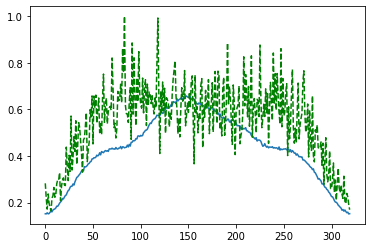

Time taken for epoch:  140.57750153541565
Epoch = [235/3000]  Iter = [   0/39480]  Loss = 0.1246 Avg Loss = 0.1246  Time = 0.1170s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [235/3000]  Iter = [ 100/39480]  Loss = 0.125 Avg Loss = 0.1336  Time = 0.0030s
Epoch = [235/3000]  Iter = [ 200/39480]  Loss = 0.1564 Avg Loss = 0.1371  Time = 0.0031s
Epoch = [235/3000]  Iter = [ 300/39480]  Loss = 0.1541 Avg Loss = 0.1392  Time = 0.0029s
Epoch = [235/3000]  Iter = [ 400/39480]  Loss = 0.1419 Avg Loss = 0.1394  Time = 0.0030s
Epoch = [235/3000]  Iter = [ 500/39480]  Loss = 0.1353 Avg Loss = 0.1416  Time = 0.0033s
Epoch = [235/3000]  Iter = [ 600/39480]  Loss = 0.1195 Avg Loss = 0.141  Time = 0.0028s
Epoch = [235/3000]  Iter = [ 700/39480]  Loss = 0.142 Avg Loss = 0.1417  Time = 0.0028s
Epoch = [235/3000]  Iter = [ 800/39480]  Loss = 0.1601 Avg Loss = 0.141  Time = 0.0022s
Epoch = [235/3000]  Iter = [ 900/39480]  Loss = 0.1366 Avg Loss = 0.1411  Time = 0.0019s
Epoch = [235/3000]  Iter = [1000/39480]  Loss = 0.1359 Avg Loss = 0.1393  Time = 0.0020s
Epoch = [235/3000]  Iter = [1100/39480]  Loss = 0.1236 Avg Loss = 0.1383  Time = 0.0023s
Epoch = [235/3000]  Iter 

Epoch = [235/3000]  Iter = [9400/39480]  Loss = 0.1382 Avg Loss = 0.1409  Time = 0.0027s
Epoch = [235/3000]  Iter = [9500/39480]  Loss = 0.1315 Avg Loss = 0.1407  Time = 0.0032s
Epoch = [235/3000]  Iter = [9600/39480]  Loss = 0.1495 Avg Loss = 0.1406  Time = 0.0049s
Epoch = [235/3000]  Iter = [9700/39480]  Loss = 0.1501 Avg Loss = 0.1392  Time = 0.0023s
Epoch = [235/3000]  Iter = [9800/39480]  Loss = 0.142 Avg Loss = 0.1408  Time = 0.0032s
Epoch = [235/3000]  Iter = [9900/39480]  Loss = 0.14 Avg Loss = 0.1422  Time = 0.0026s
Epoch = [235/3000]  Iter = [10000/39480]  Loss = 0.1187 Avg Loss = 0.1405  Time = 0.0028s
Epoch = [235/3000]  Iter = [10100/39480]  Loss = 0.1517 Avg Loss = 0.1401  Time = 0.0024s
Epoch = [235/3000]  Iter = [10200/39480]  Loss = 0.1456 Avg Loss = 0.1399  Time = 0.0030s
Epoch = [235/3000]  Iter = [10300/39480]  Loss = 0.14 Avg Loss = 0.1401  Time = 0.0031s
Epoch = [235/3000]  Iter = [10400/39480]  Loss = 0.164 Avg Loss = 0.141  Time = 0.0024s
Epoch = [235/3000]  Ite

Epoch = [235/3000]  Iter = [18600/39480]  Loss = 0.1463 Avg Loss = 0.1408  Time = 0.0029s
Epoch = [235/3000]  Iter = [18700/39480]  Loss = 0.1441 Avg Loss = 0.1412  Time = 0.0022s
Epoch = [235/3000]  Iter = [18800/39480]  Loss = 0.1543 Avg Loss = 0.1406  Time = 0.0029s
Epoch = [235/3000]  Iter = [18900/39480]  Loss = 0.1344 Avg Loss = 0.1411  Time = 0.0023s
Epoch = [235/3000]  Iter = [19000/39480]  Loss = 0.1193 Avg Loss = 0.1411  Time = 0.0027s
Epoch = [235/3000]  Iter = [19100/39480]  Loss = 0.1391 Avg Loss = 0.1408  Time = 0.0031s
Epoch = [235/3000]  Iter = [19200/39480]  Loss = 0.1297 Avg Loss = 0.1403  Time = 0.0033s
Epoch = [235/3000]  Iter = [19300/39480]  Loss = 0.1314 Avg Loss = 0.142  Time = 0.0046s
Epoch = [235/3000]  Iter = [19400/39480]  Loss = 0.1529 Avg Loss = 0.1425  Time = 0.0024s
Epoch = [235/3000]  Iter = [19500/39480]  Loss = 0.1488 Avg Loss = 0.1417  Time = 0.0190s
Epoch = [235/3000]  Iter = [19600/39480]  Loss = 0.1325 Avg Loss = 0.1423  Time = 0.0024s
Epoch = [23

Epoch = [235/3000]  Iter = [27800/39480]  Loss = 0.1455 Avg Loss = 0.1402  Time = 0.0023s
Epoch = [235/3000]  Iter = [27900/39480]  Loss = 0.1604 Avg Loss = 0.1416  Time = 0.0023s
Epoch = [235/3000]  Iter = [28000/39480]  Loss = 0.1461 Avg Loss = 0.1404  Time = 0.0023s
Epoch = [235/3000]  Iter = [28100/39480]  Loss = 0.1507 Avg Loss = 0.142  Time = 0.0030s
Epoch = [235/3000]  Iter = [28200/39480]  Loss = 0.1822 Avg Loss = 0.1427  Time = 0.0028s
Epoch = [235/3000]  Iter = [28300/39480]  Loss = 0.114 Avg Loss = 0.1404  Time = 0.0029s
Epoch = [235/3000]  Iter = [28400/39480]  Loss = 0.1343 Avg Loss = 0.1408  Time = 0.0032s
Epoch = [235/3000]  Iter = [28500/39480]  Loss = 0.1365 Avg Loss = 0.141  Time = 0.0031s
Epoch = [235/3000]  Iter = [28600/39480]  Loss = 0.1451 Avg Loss = 0.1414  Time = 0.0027s
Epoch = [235/3000]  Iter = [28700/39480]  Loss = 0.1563 Avg Loss = 0.1428  Time = 0.0033s
Epoch = [235/3000]  Iter = [28800/39480]  Loss = 0.149 Avg Loss = 0.1417  Time = 0.0028s
Epoch = [235/3

Epoch = [235/3000]  Iter = [37000/39480]  Loss = 0.1347 Avg Loss = 0.1405  Time = 0.0028s
Epoch = [235/3000]  Iter = [37100/39480]  Loss = 0.1307 Avg Loss = 0.1413  Time = 0.0024s
Epoch = [235/3000]  Iter = [37200/39480]  Loss = 0.145 Avg Loss = 0.1415  Time = 0.0034s
Epoch = [235/3000]  Iter = [37300/39480]  Loss = 0.1435 Avg Loss = 0.1412  Time = 0.0030s
Epoch = [235/3000]  Iter = [37400/39480]  Loss = 0.1411 Avg Loss = 0.1415  Time = 0.0031s
Epoch = [235/3000]  Iter = [37500/39480]  Loss = 0.147 Avg Loss = 0.1419  Time = 0.0030s
Epoch = [235/3000]  Iter = [37600/39480]  Loss = 0.1348 Avg Loss = 0.142  Time = 0.0030s
Epoch = [235/3000]  Iter = [37700/39480]  Loss = 0.1408 Avg Loss = 0.1425  Time = 0.0030s
Epoch = [235/3000]  Iter = [37800/39480]  Loss = 0.1435 Avg Loss = 0.1418  Time = 0.0033s
Epoch = [235/3000]  Iter = [37900/39480]  Loss = 0.1333 Avg Loss = 0.1416  Time = 0.0027s
Epoch = [235/3000]  Iter = [38000/39480]  Loss = 0.1373 Avg Loss = 0.1424  Time = 0.0028s
Epoch = [235/

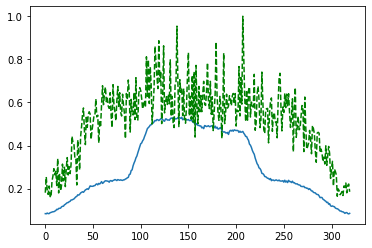

Time taken for epoch:  140.66442823410034
Epoch = [236/3000]  Iter = [   0/39480]  Loss = 0.1298 Avg Loss = 0.1298  Time = 0.1002s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [236/3000]  Iter = [ 100/39480]  Loss = 0.1449 Avg Loss = 0.1351  Time = 0.0024s
Epoch = [236/3000]  Iter = [ 200/39480]  Loss = 0.1497 Avg Loss = 0.1395  Time = 0.0031s
Epoch = [236/3000]  Iter = [ 300/39480]  Loss = 0.135 Avg Loss = 0.1387  Time = 0.0029s
Epoch = [236/3000]  Iter = [ 400/39480]  Loss = 0.1493 Avg Loss = 0.1413  Time = 0.0021s
Epoch = [236/3000]  Iter = [ 500/39480]  Loss = 0.1324 Avg Loss = 0.1401  Time = 0.0023s
Epoch = [236/3000]  Iter = [ 600/39480]  Loss = 0.1454 Avg Loss = 0.1401  Time = 0.0031s
Epoch = [236/3000]  Iter = [ 700/39480]  Loss = 0.1415 Avg Loss = 0.1408  Time = 0.0021s
Epoch = [236/3000]  Iter = [ 800/39480]  Loss = 0.1368 Avg Loss = 0.1402  Time = 0.0028s
Epoch = [236/3000]  Iter = [ 900/39480]  Loss = 0.1177 Avg Loss = 0.1404  Time = 0.0023s
Epoch = [236/3000]  Iter = [1000/39480]  Loss = 0.1342 Avg Loss = 0.1407  Time = 0.0025s
Epoch = [236/3000]  Iter = [1100/39480]  Loss = 0.1419 Avg Loss = 0.1407  Time = 0.0021s
Epoch = [236/3000]  It

Epoch = [236/3000]  Iter = [9400/39480]  Loss = 0.1411 Avg Loss = 0.1405  Time = 0.0030s
Epoch = [236/3000]  Iter = [9500/39480]  Loss = 0.1353 Avg Loss = 0.1402  Time = 0.0030s
Epoch = [236/3000]  Iter = [9600/39480]  Loss = 0.166 Avg Loss = 0.1391  Time = 0.0031s
Epoch = [236/3000]  Iter = [9700/39480]  Loss = 0.1326 Avg Loss = 0.1395  Time = 0.0030s
Epoch = [236/3000]  Iter = [9800/39480]  Loss = 0.1436 Avg Loss = 0.1405  Time = 0.0048s
Epoch = [236/3000]  Iter = [9900/39480]  Loss = 0.1614 Avg Loss = 0.1407  Time = 0.0027s
Epoch = [236/3000]  Iter = [10000/39480]  Loss = 0.1263 Avg Loss = 0.1404  Time = 0.0031s
Epoch = [236/3000]  Iter = [10100/39480]  Loss = 0.1327 Avg Loss = 0.1426  Time = 0.0030s
Epoch = [236/3000]  Iter = [10200/39480]  Loss = 0.1248 Avg Loss = 0.1399  Time = 0.0021s
Epoch = [236/3000]  Iter = [10300/39480]  Loss = 0.1178 Avg Loss = 0.1409  Time = 0.0025s
Epoch = [236/3000]  Iter = [10400/39480]  Loss = 0.1261 Avg Loss = 0.14  Time = 0.0030s
Epoch = [236/3000] 

Epoch = [236/3000]  Iter = [18600/39480]  Loss = 0.1576 Avg Loss = 0.1412  Time = 0.0024s
Epoch = [236/3000]  Iter = [18700/39480]  Loss = 0.1393 Avg Loss = 0.1412  Time = 0.0030s
Epoch = [236/3000]  Iter = [18800/39480]  Loss = 0.1107 Avg Loss = 0.1412  Time = 0.0029s
Epoch = [236/3000]  Iter = [18900/39480]  Loss = 0.126 Avg Loss = 0.1412  Time = 0.0024s
Epoch = [236/3000]  Iter = [19000/39480]  Loss = 0.1455 Avg Loss = 0.1409  Time = 0.0029s
Epoch = [236/3000]  Iter = [19100/39480]  Loss = 0.1198 Avg Loss = 0.1413  Time = 0.0027s
Epoch = [236/3000]  Iter = [19200/39480]  Loss = 0.1369 Avg Loss = 0.1411  Time = 0.0024s
Epoch = [236/3000]  Iter = [19300/39480]  Loss = 0.1486 Avg Loss = 0.1394  Time = 0.0023s
Epoch = [236/3000]  Iter = [19400/39480]  Loss = 0.1511 Avg Loss = 0.1413  Time = 0.0022s
Epoch = [236/3000]  Iter = [19500/39480]  Loss = 0.1181 Avg Loss = 0.1411  Time = 0.0029s
Epoch = [236/3000]  Iter = [19600/39480]  Loss = 0.156 Avg Loss = 0.1406  Time = 0.0029s
Epoch = [236

Epoch = [236/3000]  Iter = [27800/39480]  Loss = 0.1306 Avg Loss = 0.141  Time = 0.0034s
Epoch = [236/3000]  Iter = [27900/39480]  Loss = 0.1328 Avg Loss = 0.1429  Time = 0.0097s
Epoch = [236/3000]  Iter = [28000/39480]  Loss = 0.1421 Avg Loss = 0.1427  Time = 0.0045s
Epoch = [236/3000]  Iter = [28100/39480]  Loss = 0.1231 Avg Loss = 0.1412  Time = 0.0023s
Epoch = [236/3000]  Iter = [28200/39480]  Loss = 0.1483 Avg Loss = 0.141  Time = 0.0030s
Epoch = [236/3000]  Iter = [28300/39480]  Loss = 0.1367 Avg Loss = 0.1408  Time = 0.0029s
Epoch = [236/3000]  Iter = [28400/39480]  Loss = 0.1346 Avg Loss = 0.14  Time = 0.0028s
Epoch = [236/3000]  Iter = [28500/39480]  Loss = 0.1515 Avg Loss = 0.1423  Time = 0.0032s
Epoch = [236/3000]  Iter = [28600/39480]  Loss = 0.1428 Avg Loss = 0.1427  Time = 0.0023s
Epoch = [236/3000]  Iter = [28700/39480]  Loss = 0.147 Avg Loss = 0.1421  Time = 0.0022s
Epoch = [236/3000]  Iter = [28800/39480]  Loss = 0.129 Avg Loss = 0.1414  Time = 0.0029s
Epoch = [236/300

Epoch = [236/3000]  Iter = [37000/39480]  Loss = 0.1562 Avg Loss = 0.1418  Time = 0.0026s
Epoch = [236/3000]  Iter = [37100/39480]  Loss = 0.1549 Avg Loss = 0.1417  Time = 0.0029s
Epoch = [236/3000]  Iter = [37200/39480]  Loss = 0.1809 Avg Loss = 0.1428  Time = 0.0023s
Epoch = [236/3000]  Iter = [37300/39480]  Loss = 0.127 Avg Loss = 0.1437  Time = 0.0026s
Epoch = [236/3000]  Iter = [37400/39480]  Loss = 0.1214 Avg Loss = 0.1425  Time = 0.0029s
Epoch = [236/3000]  Iter = [37500/39480]  Loss = 0.1318 Avg Loss = 0.1429  Time = 0.0022s
Epoch = [236/3000]  Iter = [37600/39480]  Loss = 0.1395 Avg Loss = 0.1413  Time = 0.0023s
Epoch = [236/3000]  Iter = [37700/39480]  Loss = 0.1377 Avg Loss = 0.1406  Time = 0.0029s
Epoch = [236/3000]  Iter = [37800/39480]  Loss = 0.1417 Avg Loss = 0.1405  Time = 0.0020s
Epoch = [236/3000]  Iter = [37900/39480]  Loss = 0.1504 Avg Loss = 0.141  Time = 0.0030s
Epoch = [236/3000]  Iter = [38000/39480]  Loss = 0.1477 Avg Loss = 0.1411  Time = 0.0032s
Epoch = [236

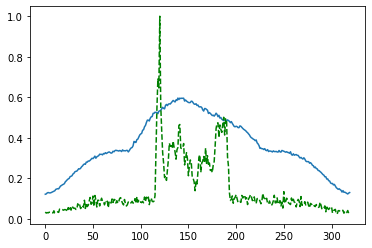

Time taken for epoch:  141.79079818725586
Epoch = [237/3000]  Iter = [   0/39480]  Loss = 0.1274 Avg Loss = 0.1274  Time = 0.1180s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [237/3000]  Iter = [ 100/39480]  Loss = 0.1272 Avg Loss = 0.1372  Time = 0.0019s
Epoch = [237/3000]  Iter = [ 200/39480]  Loss = 0.1498 Avg Loss = 0.1387  Time = 0.0028s
Epoch = [237/3000]  Iter = [ 300/39480]  Loss = 0.1249 Avg Loss = 0.1398  Time = 0.0032s
Epoch = [237/3000]  Iter = [ 400/39480]  Loss = 0.1655 Avg Loss = 0.1407  Time = 0.0029s
Epoch = [237/3000]  Iter = [ 500/39480]  Loss = 0.1587 Avg Loss = 0.1411  Time = 0.0025s
Epoch = [237/3000]  Iter = [ 600/39480]  Loss = 0.1346 Avg Loss = 0.1405  Time = 0.0030s
Epoch = [237/3000]  Iter = [ 700/39480]  Loss = 0.1123 Avg Loss = 0.1418  Time = 0.0025s
Epoch = [237/3000]  Iter = [ 800/39480]  Loss = 0.1251 Avg Loss = 0.1402  Time = 0.0028s
Epoch = [237/3000]  Iter = [ 900/39480]  Loss = 0.153 Avg Loss = 0.1414  Time = 0.0030s
Epoch = [237/3000]  Iter = [1000/39480]  Loss = 0.1471 Avg Loss = 0.1392  Time = 0.0023s
Epoch = [237/3000]  Iter = [1100/39480]  Loss = 0.1362 Avg Loss = 0.1414  Time = 0.0024s
Epoch = [237/3000]  It

Epoch = [237/3000]  Iter = [9400/39480]  Loss = 0.1226 Avg Loss = 0.1415  Time = 0.0030s
Epoch = [237/3000]  Iter = [9500/39480]  Loss = 0.1219 Avg Loss = 0.1412  Time = 0.0019s
Epoch = [237/3000]  Iter = [9600/39480]  Loss = 0.1537 Avg Loss = 0.1424  Time = 0.0023s
Epoch = [237/3000]  Iter = [9700/39480]  Loss = 0.158 Avg Loss = 0.1412  Time = 0.0025s
Epoch = [237/3000]  Iter = [9800/39480]  Loss = 0.1301 Avg Loss = 0.1409  Time = 0.0027s
Epoch = [237/3000]  Iter = [9900/39480]  Loss = 0.1362 Avg Loss = 0.141  Time = 0.0022s
Epoch = [237/3000]  Iter = [10000/39480]  Loss = 0.1352 Avg Loss = 0.1408  Time = 0.0075s
Epoch = [237/3000]  Iter = [10100/39480]  Loss = 0.1601 Avg Loss = 0.1402  Time = 0.0022s
Epoch = [237/3000]  Iter = [10200/39480]  Loss = 0.1474 Avg Loss = 0.1401  Time = 0.0018s
Epoch = [237/3000]  Iter = [10300/39480]  Loss = 0.163 Avg Loss = 0.1408  Time = 0.0028s
Epoch = [237/3000]  Iter = [10400/39480]  Loss = 0.1429 Avg Loss = 0.1409  Time = 0.0024s
Epoch = [237/3000] 

Epoch = [237/3000]  Iter = [18600/39480]  Loss = 0.1358 Avg Loss = 0.1407  Time = 0.0037s
Epoch = [237/3000]  Iter = [18700/39480]  Loss = 0.1315 Avg Loss = 0.1414  Time = 0.0023s
Epoch = [237/3000]  Iter = [18800/39480]  Loss = 0.1482 Avg Loss = 0.1426  Time = 0.0019s
Epoch = [237/3000]  Iter = [18900/39480]  Loss = 0.1539 Avg Loss = 0.1428  Time = 0.0021s
Epoch = [237/3000]  Iter = [19000/39480]  Loss = 0.1303 Avg Loss = 0.1422  Time = 0.0019s
Epoch = [237/3000]  Iter = [19100/39480]  Loss = 0.1341 Avg Loss = 0.1403  Time = 0.0027s
Epoch = [237/3000]  Iter = [19200/39480]  Loss = 0.1281 Avg Loss = 0.1393  Time = 0.0030s
Epoch = [237/3000]  Iter = [19300/39480]  Loss = 0.13 Avg Loss = 0.1398  Time = 0.0028s
Epoch = [237/3000]  Iter = [19400/39480]  Loss = 0.1384 Avg Loss = 0.1417  Time = 0.0023s
Epoch = [237/3000]  Iter = [19500/39480]  Loss = 0.1288 Avg Loss = 0.1411  Time = 0.0032s
Epoch = [237/3000]  Iter = [19600/39480]  Loss = 0.1368 Avg Loss = 0.1407  Time = 0.0023s
Epoch = [237

Epoch = [237/3000]  Iter = [27800/39480]  Loss = 0.1409 Avg Loss = 0.1414  Time = 0.0026s
Epoch = [237/3000]  Iter = [27900/39480]  Loss = 0.1412 Avg Loss = 0.1411  Time = 0.0019s
Epoch = [237/3000]  Iter = [28000/39480]  Loss = 0.1228 Avg Loss = 0.1409  Time = 0.0028s
Epoch = [237/3000]  Iter = [28100/39480]  Loss = 0.1478 Avg Loss = 0.1407  Time = 0.0022s
Epoch = [237/3000]  Iter = [28200/39480]  Loss = 0.1371 Avg Loss = 0.1422  Time = 0.0023s
Epoch = [237/3000]  Iter = [28300/39480]  Loss = 0.1316 Avg Loss = 0.1413  Time = 0.0018s
Epoch = [237/3000]  Iter = [28400/39480]  Loss = 0.1614 Avg Loss = 0.1401  Time = 0.0031s
Epoch = [237/3000]  Iter = [28500/39480]  Loss = 0.1272 Avg Loss = 0.1407  Time = 0.0032s
Epoch = [237/3000]  Iter = [28600/39480]  Loss = 0.1526 Avg Loss = 0.1415  Time = 0.0027s
Epoch = [237/3000]  Iter = [28700/39480]  Loss = 0.1594 Avg Loss = 0.1405  Time = 0.0029s
Epoch = [237/3000]  Iter = [28800/39480]  Loss = 0.1443 Avg Loss = 0.1417  Time = 0.0028s
Epoch = [2

Epoch = [237/3000]  Iter = [37000/39480]  Loss = 0.1318 Avg Loss = 0.1437  Time = 0.0022s
Epoch = [237/3000]  Iter = [37100/39480]  Loss = 0.1438 Avg Loss = 0.1435  Time = 0.0019s
Epoch = [237/3000]  Iter = [37200/39480]  Loss = 0.1281 Avg Loss = 0.1417  Time = 0.0027s
Epoch = [237/3000]  Iter = [37300/39480]  Loss = 0.1324 Avg Loss = 0.1398  Time = 0.0031s
Epoch = [237/3000]  Iter = [37400/39480]  Loss = 0.145 Avg Loss = 0.14  Time = 0.0023s
Epoch = [237/3000]  Iter = [37500/39480]  Loss = 0.1471 Avg Loss = 0.144  Time = 0.0059s
Epoch = [237/3000]  Iter = [37600/39480]  Loss = 0.1375 Avg Loss = 0.1424  Time = 0.0023s
Epoch = [237/3000]  Iter = [37700/39480]  Loss = 0.141 Avg Loss = 0.1419  Time = 0.0024s
Epoch = [237/3000]  Iter = [37800/39480]  Loss = 0.1243 Avg Loss = 0.1416  Time = 0.0026s
Epoch = [237/3000]  Iter = [37900/39480]  Loss = 0.1333 Avg Loss = 0.1408  Time = 0.0026s
Epoch = [237/3000]  Iter = [38000/39480]  Loss = 0.152 Avg Loss = 0.1418  Time = 0.0024s
Epoch = [237/300

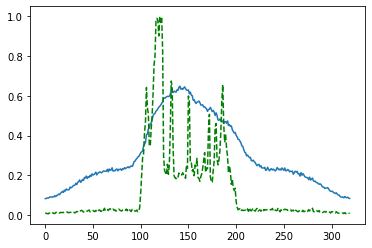

Time taken for epoch:  138.39258527755737
Epoch = [238/3000]  Iter = [   0/39480]  Loss = 0.1456 Avg Loss = 0.1456  Time = 0.1245s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [238/3000]  Iter = [ 100/39480]  Loss = 0.1379 Avg Loss = 0.1408  Time = 0.0030s
Epoch = [238/3000]  Iter = [ 200/39480]  Loss = 0.1414 Avg Loss = 0.1401  Time = 0.0024s
Epoch = [238/3000]  Iter = [ 300/39480]  Loss = 0.1397 Avg Loss = 0.1398  Time = 0.0022s
Epoch = [238/3000]  Iter = [ 400/39480]  Loss = 0.136 Avg Loss = 0.1391  Time = 0.0028s
Epoch = [238/3000]  Iter = [ 500/39480]  Loss = 0.1403 Avg Loss = 0.1415  Time = 0.0030s
Epoch = [238/3000]  Iter = [ 600/39480]  Loss = 0.1371 Avg Loss = 0.1402  Time = 0.0026s
Epoch = [238/3000]  Iter = [ 700/39480]  Loss = 0.1673 Avg Loss = 0.1403  Time = 0.0029s
Epoch = [238/3000]  Iter = [ 800/39480]  Loss = 0.1522 Avg Loss = 0.1403  Time = 0.0025s
Epoch = [238/3000]  Iter = [ 900/39480]  Loss = 0.1302 Avg Loss = 0.1405  Time = 0.0022s
Epoch = [238/3000]  Iter = [1000/39480]  Loss = 0.1285 Avg Loss = 0.1401  Time = 0.0027s
Epoch = [238/3000]  Iter = [1100/39480]  Loss = 0.1284 Avg Loss = 0.1399  Time = 0.0044s
Epoch = [238/3000]  It

Epoch = [238/3000]  Iter = [9400/39480]  Loss = 0.1258 Avg Loss = 0.1405  Time = 0.0030s
Epoch = [238/3000]  Iter = [9500/39480]  Loss = 0.1289 Avg Loss = 0.1403  Time = 0.0023s
Epoch = [238/3000]  Iter = [9600/39480]  Loss = 0.1363 Avg Loss = 0.1409  Time = 0.0024s
Epoch = [238/3000]  Iter = [9700/39480]  Loss = 0.1396 Avg Loss = 0.1411  Time = 0.0039s
Epoch = [238/3000]  Iter = [9800/39480]  Loss = 0.1505 Avg Loss = 0.1405  Time = 0.0031s
Epoch = [238/3000]  Iter = [9900/39480]  Loss = 0.1375 Avg Loss = 0.1413  Time = 0.0029s
Epoch = [238/3000]  Iter = [10000/39480]  Loss = 0.1416 Avg Loss = 0.141  Time = 0.0023s
Epoch = [238/3000]  Iter = [10100/39480]  Loss = 0.1407 Avg Loss = 0.1416  Time = 0.0028s
Epoch = [238/3000]  Iter = [10200/39480]  Loss = 0.1301 Avg Loss = 0.1424  Time = 0.0034s
Epoch = [238/3000]  Iter = [10300/39480]  Loss = 0.1334 Avg Loss = 0.1398  Time = 0.0024s
Epoch = [238/3000]  Iter = [10400/39480]  Loss = 0.1385 Avg Loss = 0.1406  Time = 0.0032s
Epoch = [238/3000

Epoch = [238/3000]  Iter = [18600/39480]  Loss = 0.1331 Avg Loss = 0.1407  Time = 0.0035s
Epoch = [238/3000]  Iter = [18700/39480]  Loss = 0.1307 Avg Loss = 0.1408  Time = 0.0034s
Epoch = [238/3000]  Iter = [18800/39480]  Loss = 0.1171 Avg Loss = 0.1414  Time = 0.0033s
Epoch = [238/3000]  Iter = [18900/39480]  Loss = 0.1492 Avg Loss = 0.1414  Time = 0.0026s
Epoch = [238/3000]  Iter = [19000/39480]  Loss = 0.1434 Avg Loss = 0.1401  Time = 0.0030s
Epoch = [238/3000]  Iter = [19100/39480]  Loss = 0.1458 Avg Loss = 0.1398  Time = 0.0031s
Epoch = [238/3000]  Iter = [19200/39480]  Loss = 0.1649 Avg Loss = 0.1413  Time = 0.0022s
Epoch = [238/3000]  Iter = [19300/39480]  Loss = 0.1284 Avg Loss = 0.1424  Time = 0.0023s
Epoch = [238/3000]  Iter = [19400/39480]  Loss = 0.15 Avg Loss = 0.1419  Time = 0.0020s
Epoch = [238/3000]  Iter = [19500/39480]  Loss = 0.1277 Avg Loss = 0.1401  Time = 0.0023s
Epoch = [238/3000]  Iter = [19600/39480]  Loss = 0.1313 Avg Loss = 0.1404  Time = 0.0029s
Epoch = [238

Epoch = [238/3000]  Iter = [27800/39480]  Loss = 0.1406 Avg Loss = 0.1399  Time = 0.0024s
Epoch = [238/3000]  Iter = [27900/39480]  Loss = 0.1619 Avg Loss = 0.1409  Time = 0.0018s
Epoch = [238/3000]  Iter = [28000/39480]  Loss = 0.1354 Avg Loss = 0.1407  Time = 0.0125s
Epoch = [238/3000]  Iter = [28100/39480]  Loss = 0.1338 Avg Loss = 0.14  Time = 0.0021s
Epoch = [238/3000]  Iter = [28200/39480]  Loss = 0.1533 Avg Loss = 0.1412  Time = 0.0019s
Epoch = [238/3000]  Iter = [28300/39480]  Loss = 0.1539 Avg Loss = 0.1414  Time = 0.0101s
Epoch = [238/3000]  Iter = [28400/39480]  Loss = 0.1458 Avg Loss = 0.1411  Time = 0.0027s
Epoch = [238/3000]  Iter = [28500/39480]  Loss = 0.1327 Avg Loss = 0.1413  Time = 0.0052s
Epoch = [238/3000]  Iter = [28600/39480]  Loss = 0.1148 Avg Loss = 0.1402  Time = 0.0029s
Epoch = [238/3000]  Iter = [28700/39480]  Loss = 0.1202 Avg Loss = 0.1403  Time = 0.0024s
Epoch = [238/3000]  Iter = [28800/39480]  Loss = 0.1397 Avg Loss = 0.141  Time = 0.0018s
Epoch = [238/

Epoch = [238/3000]  Iter = [37000/39480]  Loss = 0.155 Avg Loss = 0.1418  Time = 0.0019s
Epoch = [238/3000]  Iter = [37100/39480]  Loss = 0.1253 Avg Loss = 0.1405  Time = 0.0018s
Epoch = [238/3000]  Iter = [37200/39480]  Loss = 0.1354 Avg Loss = 0.1415  Time = 0.0027s
Epoch = [238/3000]  Iter = [37300/39480]  Loss = 0.1413 Avg Loss = 0.1419  Time = 0.0018s
Epoch = [238/3000]  Iter = [37400/39480]  Loss = 0.1371 Avg Loss = 0.1417  Time = 0.0019s
Epoch = [238/3000]  Iter = [37500/39480]  Loss = 0.1559 Avg Loss = 0.1419  Time = 0.0019s
Epoch = [238/3000]  Iter = [37600/39480]  Loss = 0.1458 Avg Loss = 0.1423  Time = 0.0019s
Epoch = [238/3000]  Iter = [37700/39480]  Loss = 0.1326 Avg Loss = 0.1425  Time = 0.0020s
Epoch = [238/3000]  Iter = [37800/39480]  Loss = 0.123 Avg Loss = 0.1409  Time = 0.0022s
Epoch = [238/3000]  Iter = [37900/39480]  Loss = 0.1223 Avg Loss = 0.1402  Time = 0.0182s
Epoch = [238/3000]  Iter = [38000/39480]  Loss = 0.1468 Avg Loss = 0.1402  Time = 0.0024s
Epoch = [238

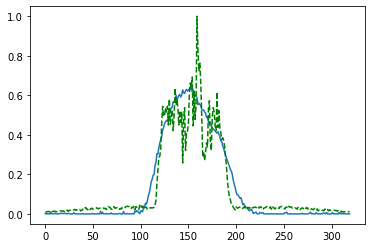

Time taken for epoch:  137.1501383781433
Epoch = [239/3000]  Iter = [   0/39480]  Loss = 0.1567 Avg Loss = 0.1567  Time = 0.0983s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [239/3000]  Iter = [ 100/39480]  Loss = 0.1222 Avg Loss = 0.1462  Time = 0.0024s
Epoch = [239/3000]  Iter = [ 200/39480]  Loss = 0.1309 Avg Loss = 0.1431  Time = 0.0024s
Epoch = [239/3000]  Iter = [ 300/39480]  Loss = 0.1414 Avg Loss = 0.1404  Time = 0.0024s
Epoch = [239/3000]  Iter = [ 400/39480]  Loss = 0.1353 Avg Loss = 0.1386  Time = 0.0023s
Epoch = [239/3000]  Iter = [ 500/39480]  Loss = 0.15 Avg Loss = 0.1403  Time = 0.0027s
Epoch = [239/3000]  Iter = [ 600/39480]  Loss = 0.1427 Avg Loss = 0.1408  Time = 0.0030s
Epoch = [239/3000]  Iter = [ 700/39480]  Loss = 0.1359 Avg Loss = 0.1406  Time = 0.0029s
Epoch = [239/3000]  Iter = [ 800/39480]  Loss = 0.1375 Avg Loss = 0.1408  Time = 0.0023s
Epoch = [239/3000]  Iter = [ 900/39480]  Loss = 0.1419 Avg Loss = 0.1412  Time = 0.0024s
Epoch = [239/3000]  Iter = [1000/39480]  Loss = 0.1522 Avg Loss = 0.1406  Time = 0.0019s
Epoch = [239/3000]  Iter = [1100/39480]  Loss = 0.1324 Avg Loss = 0.1415  Time = 0.0041s
Epoch = [239/3000]  Ite

Epoch = [239/3000]  Iter = [9400/39480]  Loss = 0.1529 Avg Loss = 0.1417  Time = 0.0019s
Epoch = [239/3000]  Iter = [9500/39480]  Loss = 0.1544 Avg Loss = 0.1414  Time = 0.0025s
Epoch = [239/3000]  Iter = [9600/39480]  Loss = 0.1221 Avg Loss = 0.1411  Time = 0.0023s
Epoch = [239/3000]  Iter = [9700/39480]  Loss = 0.1391 Avg Loss = 0.142  Time = 0.0029s
Epoch = [239/3000]  Iter = [9800/39480]  Loss = 0.1598 Avg Loss = 0.1415  Time = 0.0029s
Epoch = [239/3000]  Iter = [9900/39480]  Loss = 0.1364 Avg Loss = 0.1405  Time = 0.0033s
Epoch = [239/3000]  Iter = [10000/39480]  Loss = 0.143 Avg Loss = 0.141  Time = 0.0030s
Epoch = [239/3000]  Iter = [10100/39480]  Loss = 0.1198 Avg Loss = 0.1416  Time = 0.0033s
Epoch = [239/3000]  Iter = [10200/39480]  Loss = 0.164 Avg Loss = 0.1415  Time = 0.0030s
Epoch = [239/3000]  Iter = [10300/39480]  Loss = 0.1375 Avg Loss = 0.1414  Time = 0.0025s
Epoch = [239/3000]  Iter = [10400/39480]  Loss = 0.1343 Avg Loss = 0.1419  Time = 0.0030s
Epoch = [239/3000]  

Epoch = [239/3000]  Iter = [18600/39480]  Loss = 0.1385 Avg Loss = 0.1424  Time = 0.0029s
Epoch = [239/3000]  Iter = [18700/39480]  Loss = 0.1352 Avg Loss = 0.1418  Time = 0.0028s
Epoch = [239/3000]  Iter = [18800/39480]  Loss = 0.1453 Avg Loss = 0.1416  Time = 0.0024s
Epoch = [239/3000]  Iter = [18900/39480]  Loss = 0.1428 Avg Loss = 0.1423  Time = 0.0039s
Epoch = [239/3000]  Iter = [19000/39480]  Loss = 0.1379 Avg Loss = 0.1404  Time = 0.0030s
Epoch = [239/3000]  Iter = [19100/39480]  Loss = 0.1327 Avg Loss = 0.1414  Time = 0.0028s
Epoch = [239/3000]  Iter = [19200/39480]  Loss = 0.135 Avg Loss = 0.1414  Time = 0.0031s
Epoch = [239/3000]  Iter = [19300/39480]  Loss = 0.1223 Avg Loss = 0.1413  Time = 0.0024s
Epoch = [239/3000]  Iter = [19400/39480]  Loss = 0.116 Avg Loss = 0.1406  Time = 0.0030s
Epoch = [239/3000]  Iter = [19500/39480]  Loss = 0.1369 Avg Loss = 0.1391  Time = 0.0030s
Epoch = [239/3000]  Iter = [19600/39480]  Loss = 0.1303 Avg Loss = 0.1402  Time = 0.0029s
Epoch = [239

Epoch = [239/3000]  Iter = [27800/39480]  Loss = 0.1474 Avg Loss = 0.1403  Time = 0.0022s
Epoch = [239/3000]  Iter = [27900/39480]  Loss = 0.1421 Avg Loss = 0.1421  Time = 0.0023s
Epoch = [239/3000]  Iter = [28000/39480]  Loss = 0.1158 Avg Loss = 0.1401  Time = 0.0019s
Epoch = [239/3000]  Iter = [28100/39480]  Loss = 0.1474 Avg Loss = 0.141  Time = 0.0029s
Epoch = [239/3000]  Iter = [28200/39480]  Loss = 0.1478 Avg Loss = 0.1397  Time = 0.0029s
Epoch = [239/3000]  Iter = [28300/39480]  Loss = 0.1467 Avg Loss = 0.1417  Time = 0.0030s
Epoch = [239/3000]  Iter = [28400/39480]  Loss = 0.1475 Avg Loss = 0.1431  Time = 0.0023s
Epoch = [239/3000]  Iter = [28500/39480]  Loss = 0.1291 Avg Loss = 0.141  Time = 0.0031s
Epoch = [239/3000]  Iter = [28600/39480]  Loss = 0.1206 Avg Loss = 0.1406  Time = 0.0019s
Epoch = [239/3000]  Iter = [28700/39480]  Loss = 0.1291 Avg Loss = 0.1422  Time = 0.0024s
Epoch = [239/3000]  Iter = [28800/39480]  Loss = 0.116 Avg Loss = 0.1414  Time = 0.0031s
Epoch = [239/

Epoch = [239/3000]  Iter = [37000/39480]  Loss = 0.1356 Avg Loss = 0.1396  Time = 0.0025s
Epoch = [239/3000]  Iter = [37100/39480]  Loss = 0.122 Avg Loss = 0.1419  Time = 0.0023s
Epoch = [239/3000]  Iter = [37200/39480]  Loss = 0.1405 Avg Loss = 0.1404  Time = 0.0030s
Epoch = [239/3000]  Iter = [37300/39480]  Loss = 0.1415 Avg Loss = 0.1428  Time = 0.0024s
Epoch = [239/3000]  Iter = [37400/39480]  Loss = 0.1406 Avg Loss = 0.1423  Time = 0.0045s
Epoch = [239/3000]  Iter = [37500/39480]  Loss = 0.1289 Avg Loss = 0.1426  Time = 0.0023s
Epoch = [239/3000]  Iter = [37600/39480]  Loss = 0.136 Avg Loss = 0.1405  Time = 0.0028s
Epoch = [239/3000]  Iter = [37700/39480]  Loss = 0.1732 Avg Loss = 0.1409  Time = 0.0028s
Epoch = [239/3000]  Iter = [37800/39480]  Loss = 0.1386 Avg Loss = 0.1402  Time = 0.0029s
Epoch = [239/3000]  Iter = [37900/39480]  Loss = 0.1371 Avg Loss = 0.1407  Time = 0.0023s
Epoch = [239/3000]  Iter = [38000/39480]  Loss = 0.1556 Avg Loss = 0.1415  Time = 0.0032s
Epoch = [239

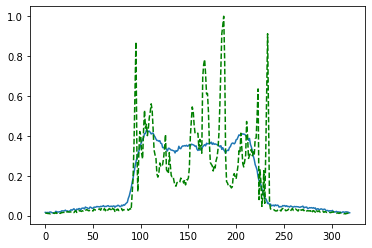

Time taken for epoch:  141.12236523628235
Epoch = [240/3000]  Iter = [   0/39480]  Loss = 0.1337 Avg Loss = 0.1337  Time = 0.1079s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [240/3000]  Iter = [ 100/39480]  Loss = 0.1482 Avg Loss = 0.1363  Time = 0.0034s
Epoch = [240/3000]  Iter = [ 200/39480]  Loss = 0.1293 Avg Loss = 0.1399  Time = 0.0132s
Epoch = [240/3000]  Iter = [ 300/39480]  Loss = 0.1596 Avg Loss = 0.1404  Time = 0.0030s
Epoch = [240/3000]  Iter = [ 400/39480]  Loss = 0.1269 Avg Loss = 0.1396  Time = 0.0066s
Epoch = [240/3000]  Iter = [ 500/39480]  Loss = 0.1543 Avg Loss = 0.1405  Time = 0.0034s
Epoch = [240/3000]  Iter = [ 600/39480]  Loss = 0.1505 Avg Loss = 0.1406  Time = 0.0027s
Epoch = [240/3000]  Iter = [ 700/39480]  Loss = 0.1364 Avg Loss = 0.1406  Time = 0.0029s
Epoch = [240/3000]  Iter = [ 800/39480]  Loss = 0.1416 Avg Loss = 0.1397  Time = 0.0026s
Epoch = [240/3000]  Iter = [ 900/39480]  Loss = 0.13 Avg Loss = 0.1402  Time = 0.0029s
Epoch = [240/3000]  Iter = [1000/39480]  Loss = 0.1365 Avg Loss = 0.1401  Time = 0.0028s
Epoch = [240/3000]  Iter = [1100/39480]  Loss = 0.1297 Avg Loss = 0.1404  Time = 0.0028s
Epoch = [240/3000]  Ite

Epoch = [240/3000]  Iter = [9400/39480]  Loss = 0.1379 Avg Loss = 0.1397  Time = 0.0022s
Epoch = [240/3000]  Iter = [9500/39480]  Loss = 0.121 Avg Loss = 0.1415  Time = 0.0029s
Epoch = [240/3000]  Iter = [9600/39480]  Loss = 0.1376 Avg Loss = 0.1406  Time = 0.0025s
Epoch = [240/3000]  Iter = [9700/39480]  Loss = 0.1393 Avg Loss = 0.1398  Time = 0.0059s
Epoch = [240/3000]  Iter = [9800/39480]  Loss = 0.1383 Avg Loss = 0.1413  Time = 0.0034s
Epoch = [240/3000]  Iter = [9900/39480]  Loss = 0.1385 Avg Loss = 0.1406  Time = 0.0030s
Epoch = [240/3000]  Iter = [10000/39480]  Loss = 0.137 Avg Loss = 0.1412  Time = 0.0023s
Epoch = [240/3000]  Iter = [10100/39480]  Loss = 0.1397 Avg Loss = 0.1426  Time = 0.0029s
Epoch = [240/3000]  Iter = [10200/39480]  Loss = 0.1381 Avg Loss = 0.141  Time = 0.0022s
Epoch = [240/3000]  Iter = [10300/39480]  Loss = 0.1431 Avg Loss = 0.1401  Time = 0.0024s
Epoch = [240/3000]  Iter = [10400/39480]  Loss = 0.1346 Avg Loss = 0.1411  Time = 0.0028s
Epoch = [240/3000] 

Epoch = [240/3000]  Iter = [18600/39480]  Loss = 0.14 Avg Loss = 0.1404  Time = 0.0033s
Epoch = [240/3000]  Iter = [18700/39480]  Loss = 0.1366 Avg Loss = 0.1408  Time = 0.0030s
Epoch = [240/3000]  Iter = [18800/39480]  Loss = 0.1405 Avg Loss = 0.1403  Time = 0.0021s
Epoch = [240/3000]  Iter = [18900/39480]  Loss = 0.1503 Avg Loss = 0.1405  Time = 0.0026s
Epoch = [240/3000]  Iter = [19000/39480]  Loss = 0.1244 Avg Loss = 0.1412  Time = 0.0030s
Epoch = [240/3000]  Iter = [19100/39480]  Loss = 0.1456 Avg Loss = 0.1409  Time = 0.0029s
Epoch = [240/3000]  Iter = [19200/39480]  Loss = 0.1403 Avg Loss = 0.1398  Time = 0.0023s
Epoch = [240/3000]  Iter = [19300/39480]  Loss = 0.1573 Avg Loss = 0.1409  Time = 0.0049s
Epoch = [240/3000]  Iter = [19400/39480]  Loss = 0.1367 Avg Loss = 0.1441  Time = 0.0028s
Epoch = [240/3000]  Iter = [19500/39480]  Loss = 0.1529 Avg Loss = 0.1431  Time = 0.0026s
Epoch = [240/3000]  Iter = [19600/39480]  Loss = 0.1366 Avg Loss = 0.1411  Time = 0.0035s
Epoch = [240

Epoch = [240/3000]  Iter = [27800/39480]  Loss = 0.1267 Avg Loss = 0.1422  Time = 0.0030s
Epoch = [240/3000]  Iter = [27900/39480]  Loss = 0.1757 Avg Loss = 0.1408  Time = 0.0024s
Epoch = [240/3000]  Iter = [28000/39480]  Loss = 0.1566 Avg Loss = 0.1413  Time = 0.0031s
Epoch = [240/3000]  Iter = [28100/39480]  Loss = 0.1355 Avg Loss = 0.1408  Time = 0.0031s
Epoch = [240/3000]  Iter = [28200/39480]  Loss = 0.1534 Avg Loss = 0.1401  Time = 0.0023s
Epoch = [240/3000]  Iter = [28300/39480]  Loss = 0.1643 Avg Loss = 0.1413  Time = 0.0170s
Epoch = [240/3000]  Iter = [28400/39480]  Loss = 0.1212 Avg Loss = 0.14  Time = 0.0031s
Epoch = [240/3000]  Iter = [28500/39480]  Loss = 0.1299 Avg Loss = 0.1404  Time = 0.0023s
Epoch = [240/3000]  Iter = [28600/39480]  Loss = 0.1489 Avg Loss = 0.1407  Time = 0.0029s
Epoch = [240/3000]  Iter = [28700/39480]  Loss = 0.1645 Avg Loss = 0.1389  Time = 0.0033s
Epoch = [240/3000]  Iter = [28800/39480]  Loss = 0.1542 Avg Loss = 0.141  Time = 0.0022s
Epoch = [240/

Epoch = [240/3000]  Iter = [37000/39480]  Loss = 0.1273 Avg Loss = 0.1419  Time = 0.0024s
Epoch = [240/3000]  Iter = [37100/39480]  Loss = 0.1346 Avg Loss = 0.1397  Time = 0.0029s
Epoch = [240/3000]  Iter = [37200/39480]  Loss = 0.1544 Avg Loss = 0.1406  Time = 0.0018s
Epoch = [240/3000]  Iter = [37300/39480]  Loss = 0.1512 Avg Loss = 0.1399  Time = 0.0020s
Epoch = [240/3000]  Iter = [37400/39480]  Loss = 0.1731 Avg Loss = 0.1406  Time = 0.0023s
Epoch = [240/3000]  Iter = [37500/39480]  Loss = 0.1475 Avg Loss = 0.1415  Time = 0.0022s
Epoch = [240/3000]  Iter = [37600/39480]  Loss = 0.1486 Avg Loss = 0.1421  Time = 0.0079s
Epoch = [240/3000]  Iter = [37700/39480]  Loss = 0.1379 Avg Loss = 0.1413  Time = 0.0019s
Epoch = [240/3000]  Iter = [37800/39480]  Loss = 0.1268 Avg Loss = 0.1415  Time = 0.0018s
Epoch = [240/3000]  Iter = [37900/39480]  Loss = 0.1358 Avg Loss = 0.1411  Time = 0.0026s
Epoch = [240/3000]  Iter = [38000/39480]  Loss = 0.1341 Avg Loss = 0.1418  Time = 0.0019s
Epoch = [2

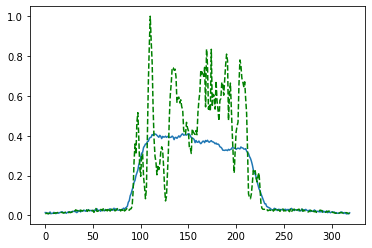

Time taken for epoch:  138.91910576820374
Epoch = [241/3000]  Iter = [   0/39480]  Loss = 0.1331 Avg Loss = 0.1331  Time = 0.0878s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [241/3000]  Iter = [ 100/39480]  Loss = 0.1481 Avg Loss = 0.1366  Time = 0.0030s
Epoch = [241/3000]  Iter = [ 200/39480]  Loss = 0.1274 Avg Loss = 0.1402  Time = 0.0034s
Epoch = [241/3000]  Iter = [ 300/39480]  Loss = 0.1358 Avg Loss = 0.1396  Time = 0.0029s
Epoch = [241/3000]  Iter = [ 400/39480]  Loss = 0.1638 Avg Loss = 0.1416  Time = 0.0025s
Epoch = [241/3000]  Iter = [ 500/39480]  Loss = 0.1502 Avg Loss = 0.1415  Time = 0.0028s
Epoch = [241/3000]  Iter = [ 600/39480]  Loss = 0.1411 Avg Loss = 0.141  Time = 0.0029s
Epoch = [241/3000]  Iter = [ 700/39480]  Loss = 0.1461 Avg Loss = 0.1398  Time = 0.0020s
Epoch = [241/3000]  Iter = [ 800/39480]  Loss = 0.1402 Avg Loss = 0.1403  Time = 0.0019s
Epoch = [241/3000]  Iter = [ 900/39480]  Loss = 0.1539 Avg Loss = 0.1412  Time = 0.0030s
Epoch = [241/3000]  Iter = [1000/39480]  Loss = 0.1261 Avg Loss = 0.1404  Time = 0.0024s
Epoch = [241/3000]  Iter = [1100/39480]  Loss = 0.1298 Avg Loss = 0.1401  Time = 0.0022s
Epoch = [241/3000]  It

Epoch = [241/3000]  Iter = [9400/39480]  Loss = 0.1526 Avg Loss = 0.1407  Time = 0.0022s
Epoch = [241/3000]  Iter = [9500/39480]  Loss = 0.1421 Avg Loss = 0.1405  Time = 0.0023s
Epoch = [241/3000]  Iter = [9600/39480]  Loss = 0.1383 Avg Loss = 0.1413  Time = 0.0024s
Epoch = [241/3000]  Iter = [9700/39480]  Loss = 0.1287 Avg Loss = 0.141  Time = 0.0024s
Epoch = [241/3000]  Iter = [9800/39480]  Loss = 0.1175 Avg Loss = 0.1418  Time = 0.0032s
Epoch = [241/3000]  Iter = [9900/39480]  Loss = 0.143 Avg Loss = 0.1428  Time = 0.0028s
Epoch = [241/3000]  Iter = [10000/39480]  Loss = 0.122 Avg Loss = 0.1424  Time = 0.0030s
Epoch = [241/3000]  Iter = [10100/39480]  Loss = 0.1311 Avg Loss = 0.1416  Time = 0.0023s
Epoch = [241/3000]  Iter = [10200/39480]  Loss = 0.1329 Avg Loss = 0.1428  Time = 0.0021s
Epoch = [241/3000]  Iter = [10300/39480]  Loss = 0.1299 Avg Loss = 0.1431  Time = 0.0032s
Epoch = [241/3000]  Iter = [10400/39480]  Loss = 0.1284 Avg Loss = 0.1424  Time = 0.0033s
Epoch = [241/3000] 

Epoch = [241/3000]  Iter = [18600/39480]  Loss = 0.1281 Avg Loss = 0.1399  Time = 0.0030s
Epoch = [241/3000]  Iter = [18700/39480]  Loss = 0.1659 Avg Loss = 0.1407  Time = 0.0029s
Epoch = [241/3000]  Iter = [18800/39480]  Loss = 0.1628 Avg Loss = 0.1418  Time = 0.0030s
Epoch = [241/3000]  Iter = [18900/39480]  Loss = 0.1411 Avg Loss = 0.1409  Time = 0.0031s
Epoch = [241/3000]  Iter = [19000/39480]  Loss = 0.1365 Avg Loss = 0.1416  Time = 0.0027s
Epoch = [241/3000]  Iter = [19100/39480]  Loss = 0.1702 Avg Loss = 0.142  Time = 0.0023s
Epoch = [241/3000]  Iter = [19200/39480]  Loss = 0.1455 Avg Loss = 0.1429  Time = 0.0022s
Epoch = [241/3000]  Iter = [19300/39480]  Loss = 0.124 Avg Loss = 0.1411  Time = 0.0030s
Epoch = [241/3000]  Iter = [19400/39480]  Loss = 0.1552 Avg Loss = 0.1421  Time = 0.0044s
Epoch = [241/3000]  Iter = [19500/39480]  Loss = 0.1462 Avg Loss = 0.1414  Time = 0.0024s
Epoch = [241/3000]  Iter = [19600/39480]  Loss = 0.1474 Avg Loss = 0.1409  Time = 0.0032s
Epoch = [241

Epoch = [241/3000]  Iter = [27800/39480]  Loss = 0.144 Avg Loss = 0.1424  Time = 0.0030s
Epoch = [241/3000]  Iter = [27900/39480]  Loss = 0.1583 Avg Loss = 0.1423  Time = 0.0029s
Epoch = [241/3000]  Iter = [28000/39480]  Loss = 0.1547 Avg Loss = 0.1421  Time = 0.0025s
Epoch = [241/3000]  Iter = [28100/39480]  Loss = 0.1637 Avg Loss = 0.1426  Time = 0.0022s
Epoch = [241/3000]  Iter = [28200/39480]  Loss = 0.1214 Avg Loss = 0.1403  Time = 0.0023s
Epoch = [241/3000]  Iter = [28300/39480]  Loss = 0.148 Avg Loss = 0.1405  Time = 0.0023s
Epoch = [241/3000]  Iter = [28400/39480]  Loss = 0.1315 Avg Loss = 0.1419  Time = 0.0031s
Epoch = [241/3000]  Iter = [28500/39480]  Loss = 0.1269 Avg Loss = 0.1406  Time = 0.0106s
Epoch = [241/3000]  Iter = [28600/39480]  Loss = 0.1368 Avg Loss = 0.1412  Time = 0.0033s
Epoch = [241/3000]  Iter = [28700/39480]  Loss = 0.1528 Avg Loss = 0.1411  Time = 0.0018s
Epoch = [241/3000]  Iter = [28800/39480]  Loss = 0.1346 Avg Loss = 0.1426  Time = 0.0033s
Epoch = [241

Epoch = [241/3000]  Iter = [37000/39480]  Loss = 0.1336 Avg Loss = 0.1406  Time = 0.0027s
Epoch = [241/3000]  Iter = [37100/39480]  Loss = 0.1486 Avg Loss = 0.142  Time = 0.0032s
Epoch = [241/3000]  Iter = [37200/39480]  Loss = 0.1306 Avg Loss = 0.1414  Time = 0.0039s
Epoch = [241/3000]  Iter = [37300/39480]  Loss = 0.1367 Avg Loss = 0.1421  Time = 0.0029s
Epoch = [241/3000]  Iter = [37400/39480]  Loss = 0.153 Avg Loss = 0.1437  Time = 0.0033s
Epoch = [241/3000]  Iter = [37500/39480]  Loss = 0.1277 Avg Loss = 0.1419  Time = 0.0024s
Epoch = [241/3000]  Iter = [37600/39480]  Loss = 0.1289 Avg Loss = 0.1414  Time = 0.0052s
Epoch = [241/3000]  Iter = [37700/39480]  Loss = 0.1501 Avg Loss = 0.1425  Time = 0.0022s
Epoch = [241/3000]  Iter = [37800/39480]  Loss = 0.1365 Avg Loss = 0.142  Time = 0.0032s
Epoch = [241/3000]  Iter = [37900/39480]  Loss = 0.1526 Avg Loss = 0.142  Time = 0.0025s
Epoch = [241/3000]  Iter = [38000/39480]  Loss = 0.1373 Avg Loss = 0.1417  Time = 0.0029s
Epoch = [241/3

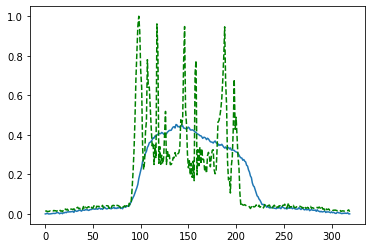

Time taken for epoch:  139.4984085559845
Epoch = [242/3000]  Iter = [   0/39480]  Loss = 0.1199 Avg Loss = 0.1199  Time = 0.0846s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [242/3000]  Iter = [ 100/39480]  Loss = 0.1353 Avg Loss = 0.1317  Time = 0.0031s
Epoch = [242/3000]  Iter = [ 200/39480]  Loss = 0.1238 Avg Loss = 0.1374  Time = 0.0031s
Epoch = [242/3000]  Iter = [ 300/39480]  Loss = 0.1554 Avg Loss = 0.1384  Time = 0.0032s
Epoch = [242/3000]  Iter = [ 400/39480]  Loss = 0.1616 Avg Loss = 0.1391  Time = 0.0028s
Epoch = [242/3000]  Iter = [ 500/39480]  Loss = 0.1671 Avg Loss = 0.1407  Time = 0.0098s
Epoch = [242/3000]  Iter = [ 600/39480]  Loss = 0.1386 Avg Loss = 0.141  Time = 0.0033s
Epoch = [242/3000]  Iter = [ 700/39480]  Loss = 0.1458 Avg Loss = 0.1395  Time = 0.0032s
Epoch = [242/3000]  Iter = [ 800/39480]  Loss = 0.1305 Avg Loss = 0.1408  Time = 0.0030s
Epoch = [242/3000]  Iter = [ 900/39480]  Loss = 0.1324 Avg Loss = 0.1394  Time = 0.0034s
Epoch = [242/3000]  Iter = [1000/39480]  Loss = 0.1535 Avg Loss = 0.1404  Time = 0.0029s
Epoch = [242/3000]  Iter = [1100/39480]  Loss = 0.1445 Avg Loss = 0.1397  Time = 0.0023s
Epoch = [242/3000]  It

Epoch = [242/3000]  Iter = [9400/39480]  Loss = 0.1333 Avg Loss = 0.1412  Time = 0.0027s
Epoch = [242/3000]  Iter = [9500/39480]  Loss = 0.1318 Avg Loss = 0.1411  Time = 0.0034s
Epoch = [242/3000]  Iter = [9600/39480]  Loss = 0.14 Avg Loss = 0.1416  Time = 0.0023s
Epoch = [242/3000]  Iter = [9700/39480]  Loss = 0.1397 Avg Loss = 0.1401  Time = 0.0032s
Epoch = [242/3000]  Iter = [9800/39480]  Loss = 0.1566 Avg Loss = 0.1409  Time = 0.0033s
Epoch = [242/3000]  Iter = [9900/39480]  Loss = 0.133 Avg Loss = 0.1424  Time = 0.0031s
Epoch = [242/3000]  Iter = [10000/39480]  Loss = 0.1428 Avg Loss = 0.1407  Time = 0.0024s
Epoch = [242/3000]  Iter = [10100/39480]  Loss = 0.1319 Avg Loss = 0.142  Time = 0.0032s
Epoch = [242/3000]  Iter = [10200/39480]  Loss = 0.1449 Avg Loss = 0.1419  Time = 0.0034s
Epoch = [242/3000]  Iter = [10300/39480]  Loss = 0.1429 Avg Loss = 0.1401  Time = 0.0030s
Epoch = [242/3000]  Iter = [10400/39480]  Loss = 0.1563 Avg Loss = 0.14  Time = 0.0026s
Epoch = [242/3000]  It

Epoch = [242/3000]  Iter = [18600/39480]  Loss = 0.1545 Avg Loss = 0.1417  Time = 0.0028s
Epoch = [242/3000]  Iter = [18700/39480]  Loss = 0.1546 Avg Loss = 0.1424  Time = 0.0045s
Epoch = [242/3000]  Iter = [18800/39480]  Loss = 0.162 Avg Loss = 0.1415  Time = 0.0165s
Epoch = [242/3000]  Iter = [18900/39480]  Loss = 0.1399 Avg Loss = 0.1387  Time = 0.0022s
Epoch = [242/3000]  Iter = [19000/39480]  Loss = 0.1312 Avg Loss = 0.14  Time = 0.0025s
Epoch = [242/3000]  Iter = [19100/39480]  Loss = 0.145 Avg Loss = 0.1415  Time = 0.0023s
Epoch = [242/3000]  Iter = [19200/39480]  Loss = 0.1396 Avg Loss = 0.1423  Time = 0.0040s
Epoch = [242/3000]  Iter = [19300/39480]  Loss = 0.1408 Avg Loss = 0.1415  Time = 0.0024s
Epoch = [242/3000]  Iter = [19400/39480]  Loss = 0.1309 Avg Loss = 0.1411  Time = 0.0027s
Epoch = [242/3000]  Iter = [19500/39480]  Loss = 0.1377 Avg Loss = 0.1426  Time = 0.0036s
Epoch = [242/3000]  Iter = [19600/39480]  Loss = 0.1318 Avg Loss = 0.1405  Time = 0.0023s
Epoch = [242/3

Epoch = [242/3000]  Iter = [27800/39480]  Loss = 0.1549 Avg Loss = 0.1408  Time = 0.0026s
Epoch = [242/3000]  Iter = [27900/39480]  Loss = 0.1316 Avg Loss = 0.1428  Time = 0.0019s
Epoch = [242/3000]  Iter = [28000/39480]  Loss = 0.1269 Avg Loss = 0.1414  Time = 0.0018s
Epoch = [242/3000]  Iter = [28100/39480]  Loss = 0.1332 Avg Loss = 0.1409  Time = 0.0019s
Epoch = [242/3000]  Iter = [28200/39480]  Loss = 0.1727 Avg Loss = 0.1421  Time = 0.0027s
Epoch = [242/3000]  Iter = [28300/39480]  Loss = 0.1478 Avg Loss = 0.1412  Time = 0.0023s
Epoch = [242/3000]  Iter = [28400/39480]  Loss = 0.1313 Avg Loss = 0.1418  Time = 0.0099s
Epoch = [242/3000]  Iter = [28500/39480]  Loss = 0.1405 Avg Loss = 0.1417  Time = 0.0023s
Epoch = [242/3000]  Iter = [28600/39480]  Loss = 0.1691 Avg Loss = 0.1413  Time = 0.0024s
Epoch = [242/3000]  Iter = [28700/39480]  Loss = 0.136 Avg Loss = 0.1407  Time = 0.0023s
Epoch = [242/3000]  Iter = [28800/39480]  Loss = 0.143 Avg Loss = 0.1406  Time = 0.0017s
Epoch = [242

Epoch = [242/3000]  Iter = [37000/39480]  Loss = 0.1307 Avg Loss = 0.141  Time = 0.0037s
Epoch = [242/3000]  Iter = [37100/39480]  Loss = 0.1511 Avg Loss = 0.1421  Time = 0.0032s
Epoch = [242/3000]  Iter = [37200/39480]  Loss = 0.1412 Avg Loss = 0.1442  Time = 0.0025s
Epoch = [242/3000]  Iter = [37300/39480]  Loss = 0.1442 Avg Loss = 0.1435  Time = 0.0022s
Epoch = [242/3000]  Iter = [37400/39480]  Loss = 0.1365 Avg Loss = 0.1419  Time = 0.0020s
Epoch = [242/3000]  Iter = [37500/39480]  Loss = 0.1303 Avg Loss = 0.1422  Time = 0.0024s
Epoch = [242/3000]  Iter = [37600/39480]  Loss = 0.1568 Avg Loss = 0.1416  Time = 0.0026s
Epoch = [242/3000]  Iter = [37700/39480]  Loss = 0.1258 Avg Loss = 0.142  Time = 0.0119s
Epoch = [242/3000]  Iter = [37800/39480]  Loss = 0.1415 Avg Loss = 0.1419  Time = 0.0029s
Epoch = [242/3000]  Iter = [37900/39480]  Loss = 0.1311 Avg Loss = 0.1432  Time = 0.0031s
Epoch = [242/3000]  Iter = [38000/39480]  Loss = 0.1366 Avg Loss = 0.1415  Time = 0.0028s
Epoch = [242

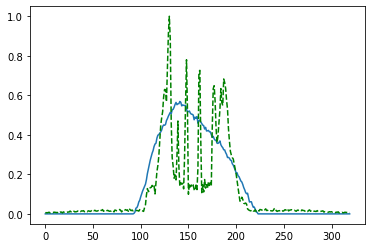

Time taken for epoch:  137.15637850761414
Epoch = [243/3000]  Iter = [   0/39480]  Loss = 0.1332 Avg Loss = 0.1332  Time = 0.0978s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [243/3000]  Iter = [ 100/39480]  Loss = 0.1646 Avg Loss = 0.1377  Time = 0.0028s
Epoch = [243/3000]  Iter = [ 200/39480]  Loss = 0.1222 Avg Loss = 0.1394  Time = 0.0019s
Epoch = [243/3000]  Iter = [ 300/39480]  Loss = 0.1367 Avg Loss = 0.1385  Time = 0.0029s
Epoch = [243/3000]  Iter = [ 400/39480]  Loss = 0.1397 Avg Loss = 0.1386  Time = 0.0030s
Epoch = [243/3000]  Iter = [ 500/39480]  Loss = 0.1384 Avg Loss = 0.139  Time = 0.0031s
Epoch = [243/3000]  Iter = [ 600/39480]  Loss = 0.1328 Avg Loss = 0.1405  Time = 0.0023s
Epoch = [243/3000]  Iter = [ 700/39480]  Loss = 0.1312 Avg Loss = 0.1403  Time = 0.0028s
Epoch = [243/3000]  Iter = [ 800/39480]  Loss = 0.1577 Avg Loss = 0.1409  Time = 0.0029s
Epoch = [243/3000]  Iter = [ 900/39480]  Loss = 0.1491 Avg Loss = 0.1403  Time = 0.0030s
Epoch = [243/3000]  Iter = [1000/39480]  Loss = 0.1475 Avg Loss = 0.1416  Time = 0.0030s
Epoch = [243/3000]  Iter = [1100/39480]  Loss = 0.1282 Avg Loss = 0.1413  Time = 0.0030s
Epoch = [243/3000]  It

Epoch = [243/3000]  Iter = [9400/39480]  Loss = 0.1635 Avg Loss = 0.1418  Time = 0.0024s
Epoch = [243/3000]  Iter = [9500/39480]  Loss = 0.1367 Avg Loss = 0.1414  Time = 0.0024s
Epoch = [243/3000]  Iter = [9600/39480]  Loss = 0.1365 Avg Loss = 0.1405  Time = 0.0050s
Epoch = [243/3000]  Iter = [9700/39480]  Loss = 0.1404 Avg Loss = 0.142  Time = 0.0023s
Epoch = [243/3000]  Iter = [9800/39480]  Loss = 0.1414 Avg Loss = 0.1431  Time = 0.0029s
Epoch = [243/3000]  Iter = [9900/39480]  Loss = 0.1415 Avg Loss = 0.142  Time = 0.0031s
Epoch = [243/3000]  Iter = [10000/39480]  Loss = 0.1536 Avg Loss = 0.1418  Time = 0.0029s
Epoch = [243/3000]  Iter = [10100/39480]  Loss = 0.1561 Avg Loss = 0.1403  Time = 0.0032s
Epoch = [243/3000]  Iter = [10200/39480]  Loss = 0.1557 Avg Loss = 0.1382  Time = 0.0029s
Epoch = [243/3000]  Iter = [10300/39480]  Loss = 0.1441 Avg Loss = 0.1397  Time = 0.0031s
Epoch = [243/3000]  Iter = [10400/39480]  Loss = 0.1594 Avg Loss = 0.1413  Time = 0.0030s
Epoch = [243/3000]

Epoch = [243/3000]  Iter = [18600/39480]  Loss = 0.1563 Avg Loss = 0.1404  Time = 0.0023s
Epoch = [243/3000]  Iter = [18700/39480]  Loss = 0.1437 Avg Loss = 0.1403  Time = 0.0029s
Epoch = [243/3000]  Iter = [18800/39480]  Loss = 0.1617 Avg Loss = 0.1405  Time = 0.0022s
Epoch = [243/3000]  Iter = [18900/39480]  Loss = 0.1301 Avg Loss = 0.1405  Time = 0.0033s
Epoch = [243/3000]  Iter = [19000/39480]  Loss = 0.139 Avg Loss = 0.139  Time = 0.0027s
Epoch = [243/3000]  Iter = [19100/39480]  Loss = 0.127 Avg Loss = 0.1402  Time = 0.0030s
Epoch = [243/3000]  Iter = [19200/39480]  Loss = 0.137 Avg Loss = 0.1409  Time = 0.0022s
Epoch = [243/3000]  Iter = [19300/39480]  Loss = 0.1229 Avg Loss = 0.1423  Time = 0.0032s
Epoch = [243/3000]  Iter = [19400/39480]  Loss = 0.1261 Avg Loss = 0.1415  Time = 0.0026s
Epoch = [243/3000]  Iter = [19500/39480]  Loss = 0.1439 Avg Loss = 0.141  Time = 0.0037s
Epoch = [243/3000]  Iter = [19600/39480]  Loss = 0.1374 Avg Loss = 0.1395  Time = 0.0032s
Epoch = [243/30

Epoch = [243/3000]  Iter = [27800/39480]  Loss = 0.1421 Avg Loss = 0.1396  Time = 0.0031s
Epoch = [243/3000]  Iter = [27900/39480]  Loss = 0.1444 Avg Loss = 0.1404  Time = 0.0028s
Epoch = [243/3000]  Iter = [28000/39480]  Loss = 0.1541 Avg Loss = 0.1412  Time = 0.0024s
Epoch = [243/3000]  Iter = [28100/39480]  Loss = 0.1273 Avg Loss = 0.1406  Time = 0.0027s
Epoch = [243/3000]  Iter = [28200/39480]  Loss = 0.1327 Avg Loss = 0.1411  Time = 0.0025s
Epoch = [243/3000]  Iter = [28300/39480]  Loss = 0.1503 Avg Loss = 0.1423  Time = 0.0031s
Epoch = [243/3000]  Iter = [28400/39480]  Loss = 0.1398 Avg Loss = 0.1409  Time = 0.0025s
Epoch = [243/3000]  Iter = [28500/39480]  Loss = 0.1389 Avg Loss = 0.1405  Time = 0.0023s
Epoch = [243/3000]  Iter = [28600/39480]  Loss = 0.1595 Avg Loss = 0.1421  Time = 0.0032s
Epoch = [243/3000]  Iter = [28700/39480]  Loss = 0.152 Avg Loss = 0.1403  Time = 0.0027s
Epoch = [243/3000]  Iter = [28800/39480]  Loss = 0.1466 Avg Loss = 0.1411  Time = 0.0043s
Epoch = [24

Epoch = [243/3000]  Iter = [37000/39480]  Loss = 0.1593 Avg Loss = 0.1411  Time = 0.0022s
Epoch = [243/3000]  Iter = [37100/39480]  Loss = 0.1406 Avg Loss = 0.1406  Time = 0.0029s
Epoch = [243/3000]  Iter = [37200/39480]  Loss = 0.1243 Avg Loss = 0.1403  Time = 0.0031s
Epoch = [243/3000]  Iter = [37300/39480]  Loss = 0.152 Avg Loss = 0.1413  Time = 0.0026s
Epoch = [243/3000]  Iter = [37400/39480]  Loss = 0.1503 Avg Loss = 0.1426  Time = 0.0023s
Epoch = [243/3000]  Iter = [37500/39480]  Loss = 0.1342 Avg Loss = 0.1425  Time = 0.0024s
Epoch = [243/3000]  Iter = [37600/39480]  Loss = 0.1407 Avg Loss = 0.142  Time = 0.0029s
Epoch = [243/3000]  Iter = [37700/39480]  Loss = 0.1487 Avg Loss = 0.1428  Time = 0.0029s
Epoch = [243/3000]  Iter = [37800/39480]  Loss = 0.1374 Avg Loss = 0.1419  Time = 0.0024s
Epoch = [243/3000]  Iter = [37900/39480]  Loss = 0.1389 Avg Loss = 0.1418  Time = 0.0028s
Epoch = [243/3000]  Iter = [38000/39480]  Loss = 0.1384 Avg Loss = 0.1422  Time = 0.0024s
Epoch = [243

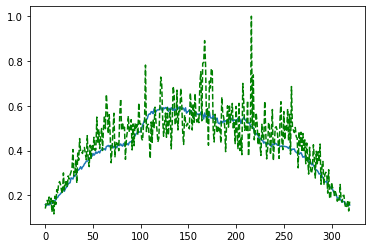

Time taken for epoch:  142.15962195396423
Epoch = [244/3000]  Iter = [   0/39480]  Loss = 0.1318 Avg Loss = 0.1318  Time = 0.0777s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [244/3000]  Iter = [ 100/39480]  Loss = 0.1618 Avg Loss = 0.1404  Time = 0.0019s
Epoch = [244/3000]  Iter = [ 200/39480]  Loss = 0.126 Avg Loss = 0.1392  Time = 0.0031s
Epoch = [244/3000]  Iter = [ 300/39480]  Loss = 0.1314 Avg Loss = 0.1396  Time = 0.0021s
Epoch = [244/3000]  Iter = [ 400/39480]  Loss = 0.1361 Avg Loss = 0.1394  Time = 0.0029s
Epoch = [244/3000]  Iter = [ 500/39480]  Loss = 0.1318 Avg Loss = 0.1409  Time = 0.0028s
Epoch = [244/3000]  Iter = [ 600/39480]  Loss = 0.1436 Avg Loss = 0.1429  Time = 0.0025s
Epoch = [244/3000]  Iter = [ 700/39480]  Loss = 0.1342 Avg Loss = 0.1415  Time = 0.0032s
Epoch = [244/3000]  Iter = [ 800/39480]  Loss = 0.1324 Avg Loss = 0.1412  Time = 0.0021s
Epoch = [244/3000]  Iter = [ 900/39480]  Loss = 0.1384 Avg Loss = 0.1411  Time = 0.0031s
Epoch = [244/3000]  Iter = [1000/39480]  Loss = 0.1346 Avg Loss = 0.1402  Time = 0.0028s
Epoch = [244/3000]  Iter = [1100/39480]  Loss = 0.1377 Avg Loss = 0.1411  Time = 0.0033s
Epoch = [244/3000]  It

Epoch = [244/3000]  Iter = [9400/39480]  Loss = 0.1345 Avg Loss = 0.1406  Time = 0.0024s
Epoch = [244/3000]  Iter = [9500/39480]  Loss = 0.1358 Avg Loss = 0.1395  Time = 0.0018s
Epoch = [244/3000]  Iter = [9600/39480]  Loss = 0.1548 Avg Loss = 0.1396  Time = 0.0019s
Epoch = [244/3000]  Iter = [9700/39480]  Loss = 0.1459 Avg Loss = 0.1402  Time = 0.0027s
Epoch = [244/3000]  Iter = [9800/39480]  Loss = 0.1506 Avg Loss = 0.1422  Time = 0.0114s
Epoch = [244/3000]  Iter = [9900/39480]  Loss = 0.1229 Avg Loss = 0.1413  Time = 0.0020s
Epoch = [244/3000]  Iter = [10000/39480]  Loss = 0.1153 Avg Loss = 0.1418  Time = 0.0024s
Epoch = [244/3000]  Iter = [10100/39480]  Loss = 0.1368 Avg Loss = 0.1397  Time = 0.0023s
Epoch = [244/3000]  Iter = [10200/39480]  Loss = 0.1548 Avg Loss = 0.1398  Time = 0.0020s
Epoch = [244/3000]  Iter = [10300/39480]  Loss = 0.1503 Avg Loss = 0.1399  Time = 0.0024s
Epoch = [244/3000]  Iter = [10400/39480]  Loss = 0.1481 Avg Loss = 0.1409  Time = 0.0023s
Epoch = [244/300

Epoch = [244/3000]  Iter = [18600/39480]  Loss = 0.1466 Avg Loss = 0.1412  Time = 0.0026s
Epoch = [244/3000]  Iter = [18700/39480]  Loss = 0.1257 Avg Loss = 0.1417  Time = 0.0028s
Epoch = [244/3000]  Iter = [18800/39480]  Loss = 0.136 Avg Loss = 0.1411  Time = 0.0038s
Epoch = [244/3000]  Iter = [18900/39480]  Loss = 0.1229 Avg Loss = 0.1414  Time = 0.0027s
Epoch = [244/3000]  Iter = [19000/39480]  Loss = 0.1351 Avg Loss = 0.1409  Time = 0.0028s
Epoch = [244/3000]  Iter = [19100/39480]  Loss = 0.1184 Avg Loss = 0.141  Time = 0.0023s
Epoch = [244/3000]  Iter = [19200/39480]  Loss = 0.1199 Avg Loss = 0.1413  Time = 0.0027s
Epoch = [244/3000]  Iter = [19300/39480]  Loss = 0.1619 Avg Loss = 0.1421  Time = 0.0033s
Epoch = [244/3000]  Iter = [19400/39480]  Loss = 0.154 Avg Loss = 0.1416  Time = 0.0025s
Epoch = [244/3000]  Iter = [19500/39480]  Loss = 0.1377 Avg Loss = 0.1408  Time = 0.0031s
Epoch = [244/3000]  Iter = [19600/39480]  Loss = 0.1599 Avg Loss = 0.1398  Time = 0.0022s
Epoch = [244/

Epoch = [244/3000]  Iter = [27800/39480]  Loss = 0.1307 Avg Loss = 0.1417  Time = 0.0022s
Epoch = [244/3000]  Iter = [27900/39480]  Loss = 0.1414 Avg Loss = 0.1412  Time = 0.0019s
Epoch = [244/3000]  Iter = [28000/39480]  Loss = 0.1307 Avg Loss = 0.1423  Time = 0.0023s
Epoch = [244/3000]  Iter = [28100/39480]  Loss = 0.1716 Avg Loss = 0.141  Time = 0.0030s
Epoch = [244/3000]  Iter = [28200/39480]  Loss = 0.1175 Avg Loss = 0.1401  Time = 0.0019s
Epoch = [244/3000]  Iter = [28300/39480]  Loss = 0.1504 Avg Loss = 0.1409  Time = 0.0019s
Epoch = [244/3000]  Iter = [28400/39480]  Loss = 0.1274 Avg Loss = 0.1411  Time = 0.0024s
Epoch = [244/3000]  Iter = [28500/39480]  Loss = 0.1543 Avg Loss = 0.1415  Time = 0.0023s
Epoch = [244/3000]  Iter = [28600/39480]  Loss = 0.137 Avg Loss = 0.1417  Time = 0.0024s
Epoch = [244/3000]  Iter = [28700/39480]  Loss = 0.1594 Avg Loss = 0.1411  Time = 0.0019s
Epoch = [244/3000]  Iter = [28800/39480]  Loss = 0.1625 Avg Loss = 0.1428  Time = 0.0023s
Epoch = [244

Epoch = [244/3000]  Iter = [37000/39480]  Loss = 0.1304 Avg Loss = 0.1414  Time = 0.0021s
Epoch = [244/3000]  Iter = [37100/39480]  Loss = 0.1434 Avg Loss = 0.142  Time = 0.0091s
Epoch = [244/3000]  Iter = [37200/39480]  Loss = 0.1488 Avg Loss = 0.1428  Time = 0.0019s
Epoch = [244/3000]  Iter = [37300/39480]  Loss = 0.1367 Avg Loss = 0.142  Time = 0.0023s
Epoch = [244/3000]  Iter = [37400/39480]  Loss = 0.1372 Avg Loss = 0.1417  Time = 0.0018s
Epoch = [244/3000]  Iter = [37500/39480]  Loss = 0.1633 Avg Loss = 0.1412  Time = 0.0045s
Epoch = [244/3000]  Iter = [37600/39480]  Loss = 0.138 Avg Loss = 0.1426  Time = 0.0018s
Epoch = [244/3000]  Iter = [37700/39480]  Loss = 0.136 Avg Loss = 0.1415  Time = 0.0088s
Epoch = [244/3000]  Iter = [37800/39480]  Loss = 0.1381 Avg Loss = 0.1407  Time = 0.0023s
Epoch = [244/3000]  Iter = [37900/39480]  Loss = 0.1427 Avg Loss = 0.1413  Time = 0.0026s
Epoch = [244/3000]  Iter = [38000/39480]  Loss = 0.1506 Avg Loss = 0.1414  Time = 0.0024s
Epoch = [244/3

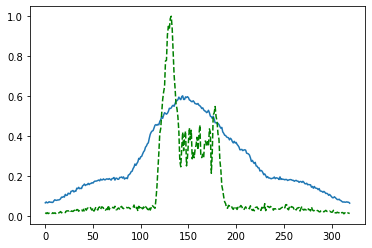

Time taken for epoch:  135.1298370361328
Epoch = [245/3000]  Iter = [   0/39480]  Loss = 0.1381 Avg Loss = 0.1381  Time = 0.0848s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [245/3000]  Iter = [ 100/39480]  Loss = 0.1438 Avg Loss = 0.1386  Time = 0.0018s
Epoch = [245/3000]  Iter = [ 200/39480]  Loss = 0.1516 Avg Loss = 0.1397  Time = 0.0028s
Epoch = [245/3000]  Iter = [ 300/39480]  Loss = 0.1284 Avg Loss = 0.1404  Time = 0.0029s
Epoch = [245/3000]  Iter = [ 400/39480]  Loss = 0.1387 Avg Loss = 0.14  Time = 0.0017s
Epoch = [245/3000]  Iter = [ 500/39480]  Loss = 0.1364 Avg Loss = 0.1393  Time = 0.0024s
Epoch = [245/3000]  Iter = [ 600/39480]  Loss = 0.1237 Avg Loss = 0.1389  Time = 0.0029s
Epoch = [245/3000]  Iter = [ 700/39480]  Loss = 0.1469 Avg Loss = 0.1408  Time = 0.0030s
Epoch = [245/3000]  Iter = [ 800/39480]  Loss = 0.1238 Avg Loss = 0.1396  Time = 0.0033s
Epoch = [245/3000]  Iter = [ 900/39480]  Loss = 0.1204 Avg Loss = 0.1392  Time = 0.0105s
Epoch = [245/3000]  Iter = [1000/39480]  Loss = 0.1326 Avg Loss = 0.14  Time = 0.0031s
Epoch = [245/3000]  Iter = [1100/39480]  Loss = 0.134 Avg Loss = 0.1398  Time = 0.0031s
Epoch = [245/3000]  Iter =

Epoch = [245/3000]  Iter = [9400/39480]  Loss = 0.1452 Avg Loss = 0.1402  Time = 0.0029s
Epoch = [245/3000]  Iter = [9500/39480]  Loss = 0.1338 Avg Loss = 0.1405  Time = 0.0030s
Epoch = [245/3000]  Iter = [9600/39480]  Loss = 0.1423 Avg Loss = 0.1412  Time = 0.0019s
Epoch = [245/3000]  Iter = [9700/39480]  Loss = 0.1335 Avg Loss = 0.1417  Time = 0.0027s
Epoch = [245/3000]  Iter = [9800/39480]  Loss = 0.1419 Avg Loss = 0.1419  Time = 0.0027s
Epoch = [245/3000]  Iter = [9900/39480]  Loss = 0.1404 Avg Loss = 0.1404  Time = 0.0023s
Epoch = [245/3000]  Iter = [10000/39480]  Loss = 0.1391 Avg Loss = 0.1403  Time = 0.0029s
Epoch = [245/3000]  Iter = [10100/39480]  Loss = 0.1407 Avg Loss = 0.14  Time = 0.0032s
Epoch = [245/3000]  Iter = [10200/39480]  Loss = 0.1389 Avg Loss = 0.1425  Time = 0.0027s
Epoch = [245/3000]  Iter = [10300/39480]  Loss = 0.1459 Avg Loss = 0.1417  Time = 0.0029s
Epoch = [245/3000]  Iter = [10400/39480]  Loss = 0.1305 Avg Loss = 0.1402  Time = 0.0026s
Epoch = [245/3000]

Epoch = [245/3000]  Iter = [18600/39480]  Loss = 0.14 Avg Loss = 0.14  Time = 0.0022s
Epoch = [245/3000]  Iter = [18700/39480]  Loss = 0.1312 Avg Loss = 0.14  Time = 0.0031s
Epoch = [245/3000]  Iter = [18800/39480]  Loss = 0.1492 Avg Loss = 0.1407  Time = 0.0024s
Epoch = [245/3000]  Iter = [18900/39480]  Loss = 0.1393 Avg Loss = 0.1411  Time = 0.0033s
Epoch = [245/3000]  Iter = [19000/39480]  Loss = 0.1392 Avg Loss = 0.1414  Time = 0.0023s
Epoch = [245/3000]  Iter = [19100/39480]  Loss = 0.1256 Avg Loss = 0.1408  Time = 0.0029s
Epoch = [245/3000]  Iter = [19200/39480]  Loss = 0.1489 Avg Loss = 0.1404  Time = 0.0024s
Epoch = [245/3000]  Iter = [19300/39480]  Loss = 0.1206 Avg Loss = 0.1404  Time = 0.0033s
Epoch = [245/3000]  Iter = [19400/39480]  Loss = 0.1287 Avg Loss = 0.1392  Time = 0.0028s
Epoch = [245/3000]  Iter = [19500/39480]  Loss = 0.1488 Avg Loss = 0.141  Time = 0.0030s
Epoch = [245/3000]  Iter = [19600/39480]  Loss = 0.1418 Avg Loss = 0.1414  Time = 0.0025s
Epoch = [245/3000

Epoch = [245/3000]  Iter = [27800/39480]  Loss = 0.1255 Avg Loss = 0.1425  Time = 0.0021s
Epoch = [245/3000]  Iter = [27900/39480]  Loss = 0.1378 Avg Loss = 0.1418  Time = 0.0024s
Epoch = [245/3000]  Iter = [28000/39480]  Loss = 0.1424 Avg Loss = 0.143  Time = 0.0022s
Epoch = [245/3000]  Iter = [28100/39480]  Loss = 0.1326 Avg Loss = 0.1426  Time = 0.0033s
Epoch = [245/3000]  Iter = [28200/39480]  Loss = 0.1543 Avg Loss = 0.1427  Time = 0.0031s
Epoch = [245/3000]  Iter = [28300/39480]  Loss = 0.1235 Avg Loss = 0.1417  Time = 0.0032s
Epoch = [245/3000]  Iter = [28400/39480]  Loss = 0.1181 Avg Loss = 0.1416  Time = 0.0029s
Epoch = [245/3000]  Iter = [28500/39480]  Loss = 0.1333 Avg Loss = 0.141  Time = 0.0036s
Epoch = [245/3000]  Iter = [28600/39480]  Loss = 0.1392 Avg Loss = 0.141  Time = 0.0029s
Epoch = [245/3000]  Iter = [28700/39480]  Loss = 0.1288 Avg Loss = 0.1414  Time = 0.0040s
Epoch = [245/3000]  Iter = [28800/39480]  Loss = 0.1291 Avg Loss = 0.1401  Time = 0.0034s
Epoch = [245/

Epoch = [245/3000]  Iter = [37000/39480]  Loss = 0.1252 Avg Loss = 0.1419  Time = 0.0184s
Epoch = [245/3000]  Iter = [37100/39480]  Loss = 0.138 Avg Loss = 0.1415  Time = 0.0018s
Epoch = [245/3000]  Iter = [37200/39480]  Loss = 0.1533 Avg Loss = 0.1431  Time = 0.0018s
Epoch = [245/3000]  Iter = [37300/39480]  Loss = 0.1276 Avg Loss = 0.144  Time = 0.0018s
Epoch = [245/3000]  Iter = [37400/39480]  Loss = 0.1033 Avg Loss = 0.1413  Time = 0.0018s
Epoch = [245/3000]  Iter = [37500/39480]  Loss = 0.1315 Avg Loss = 0.1417  Time = 0.0019s
Epoch = [245/3000]  Iter = [37600/39480]  Loss = 0.1409 Avg Loss = 0.1408  Time = 0.0018s
Epoch = [245/3000]  Iter = [37700/39480]  Loss = 0.1497 Avg Loss = 0.1394  Time = 0.0019s
Epoch = [245/3000]  Iter = [37800/39480]  Loss = 0.1494 Avg Loss = 0.1408  Time = 0.0137s
Epoch = [245/3000]  Iter = [37900/39480]  Loss = 0.1476 Avg Loss = 0.141  Time = 0.0018s
Epoch = [245/3000]  Iter = [38000/39480]  Loss = 0.1353 Avg Loss = 0.1421  Time = 0.0018s
Epoch = [245/

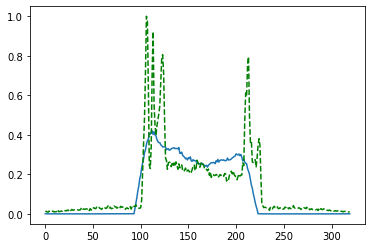

Time taken for epoch:  135.21890497207642
Epoch = [246/3000]  Iter = [   0/39480]  Loss = 0.1357 Avg Loss = 0.1357  Time = 0.1336s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [246/3000]  Iter = [ 100/39480]  Loss = 0.1402 Avg Loss = 0.1382  Time = 0.0082s
Epoch = [246/3000]  Iter = [ 200/39480]  Loss = 0.1262 Avg Loss = 0.1386  Time = 0.0031s
Epoch = [246/3000]  Iter = [ 300/39480]  Loss = 0.1515 Avg Loss = 0.1383  Time = 0.0019s
Epoch = [246/3000]  Iter = [ 400/39480]  Loss = 0.1416 Avg Loss = 0.1396  Time = 0.0019s
Epoch = [246/3000]  Iter = [ 500/39480]  Loss = 0.1586 Avg Loss = 0.1393  Time = 0.0019s
Epoch = [246/3000]  Iter = [ 600/39480]  Loss = 0.1414 Avg Loss = 0.1413  Time = 0.0019s
Epoch = [246/3000]  Iter = [ 700/39480]  Loss = 0.1201 Avg Loss = 0.1406  Time = 0.0019s
Epoch = [246/3000]  Iter = [ 800/39480]  Loss = 0.1423 Avg Loss = 0.1401  Time = 0.0019s
Epoch = [246/3000]  Iter = [ 900/39480]  Loss = 0.122 Avg Loss = 0.1395  Time = 0.0019s
Epoch = [246/3000]  Iter = [1000/39480]  Loss = 0.1387 Avg Loss = 0.1391  Time = 0.0018s
Epoch = [246/3000]  Iter = [1100/39480]  Loss = 0.1259 Avg Loss = 0.1388  Time = 0.0019s
Epoch = [246/3000]  It

Epoch = [246/3000]  Iter = [9400/39480]  Loss = 0.153 Avg Loss = 0.1414  Time = 0.0018s
Epoch = [246/3000]  Iter = [9500/39480]  Loss = 0.1409 Avg Loss = 0.1398  Time = 0.0018s
Epoch = [246/3000]  Iter = [9600/39480]  Loss = 0.1404 Avg Loss = 0.1399  Time = 0.0018s
Epoch = [246/3000]  Iter = [9700/39480]  Loss = 0.1293 Avg Loss = 0.1413  Time = 0.0018s
Epoch = [246/3000]  Iter = [9800/39480]  Loss = 0.1236 Avg Loss = 0.1411  Time = 0.0018s
Epoch = [246/3000]  Iter = [9900/39480]  Loss = 0.1356 Avg Loss = 0.1406  Time = 0.0018s
Epoch = [246/3000]  Iter = [10000/39480]  Loss = 0.1602 Avg Loss = 0.1412  Time = 0.0023s
Epoch = [246/3000]  Iter = [10100/39480]  Loss = 0.1334 Avg Loss = 0.1405  Time = 0.0019s
Epoch = [246/3000]  Iter = [10200/39480]  Loss = 0.1402 Avg Loss = 0.1413  Time = 0.0018s
Epoch = [246/3000]  Iter = [10300/39480]  Loss = 0.1373 Avg Loss = 0.1417  Time = 0.0018s
Epoch = [246/3000]  Iter = [10400/39480]  Loss = 0.1388 Avg Loss = 0.1411  Time = 0.0019s
Epoch = [246/3000

Epoch = [246/3000]  Iter = [18700/39480]  Loss = 0.1492 Avg Loss = 0.1421  Time = 0.0025s
Epoch = [246/3000]  Iter = [18800/39480]  Loss = 0.1462 Avg Loss = 0.1409  Time = 0.0018s
Epoch = [246/3000]  Iter = [18900/39480]  Loss = 0.1292 Avg Loss = 0.1411  Time = 0.0018s
Epoch = [246/3000]  Iter = [19000/39480]  Loss = 0.1394 Avg Loss = 0.1406  Time = 0.0018s
Epoch = [246/3000]  Iter = [19100/39480]  Loss = 0.1428 Avg Loss = 0.1413  Time = 0.0018s
Epoch = [246/3000]  Iter = [19200/39480]  Loss = 0.1454 Avg Loss = 0.1415  Time = 0.0018s
Epoch = [246/3000]  Iter = [19300/39480]  Loss = 0.1527 Avg Loss = 0.1419  Time = 0.0018s
Epoch = [246/3000]  Iter = [19400/39480]  Loss = 0.1304 Avg Loss = 0.1411  Time = 0.0018s
Epoch = [246/3000]  Iter = [19500/39480]  Loss = 0.1213 Avg Loss = 0.1411  Time = 0.0018s
Epoch = [246/3000]  Iter = [19600/39480]  Loss = 0.1341 Avg Loss = 0.1417  Time = 0.0018s
Epoch = [246/3000]  Iter = [19700/39480]  Loss = 0.1291 Avg Loss = 0.1404  Time = 0.0018s
Epoch = [2

Epoch = [246/3000]  Iter = [28000/39480]  Loss = 0.1551 Avg Loss = 0.1413  Time = 0.0018s
Epoch = [246/3000]  Iter = [28100/39480]  Loss = 0.143 Avg Loss = 0.1404  Time = 0.0018s
Epoch = [246/3000]  Iter = [28200/39480]  Loss = 0.1245 Avg Loss = 0.1414  Time = 0.0018s
Epoch = [246/3000]  Iter = [28300/39480]  Loss = 0.1624 Avg Loss = 0.1425  Time = 0.0018s
Epoch = [246/3000]  Iter = [28400/39480]  Loss = 0.1397 Avg Loss = 0.1426  Time = 0.0018s
Epoch = [246/3000]  Iter = [28500/39480]  Loss = 0.1446 Avg Loss = 0.1412  Time = 0.0018s
Epoch = [246/3000]  Iter = [28600/39480]  Loss = 0.1343 Avg Loss = 0.1421  Time = 0.0018s
Epoch = [246/3000]  Iter = [28700/39480]  Loss = 0.142 Avg Loss = 0.1406  Time = 0.0018s
Epoch = [246/3000]  Iter = [28800/39480]  Loss = 0.1582 Avg Loss = 0.1417  Time = 0.0018s
Epoch = [246/3000]  Iter = [28900/39480]  Loss = 0.1546 Avg Loss = 0.1415  Time = 0.0018s
Epoch = [246/3000]  Iter = [29000/39480]  Loss = 0.1354 Avg Loss = 0.1417  Time = 0.0018s
Epoch = [246

Epoch = [246/3000]  Iter = [37200/39480]  Loss = 0.127 Avg Loss = 0.1416  Time = 0.0018s
Epoch = [246/3000]  Iter = [37300/39480]  Loss = 0.1578 Avg Loss = 0.1422  Time = 0.0019s
Epoch = [246/3000]  Iter = [37400/39480]  Loss = 0.1398 Avg Loss = 0.1424  Time = 0.0018s
Epoch = [246/3000]  Iter = [37500/39480]  Loss = 0.1373 Avg Loss = 0.1428  Time = 0.0019s
Epoch = [246/3000]  Iter = [37600/39480]  Loss = 0.145 Avg Loss = 0.1421  Time = 0.0018s
Epoch = [246/3000]  Iter = [37700/39480]  Loss = 0.1452 Avg Loss = 0.1418  Time = 0.0018s
Epoch = [246/3000]  Iter = [37800/39480]  Loss = 0.147 Avg Loss = 0.1407  Time = 0.0018s
Epoch = [246/3000]  Iter = [37900/39480]  Loss = 0.122 Avg Loss = 0.1416  Time = 0.0018s
Epoch = [246/3000]  Iter = [38000/39480]  Loss = 0.1531 Avg Loss = 0.1415  Time = 0.0018s
Epoch = [246/3000]  Iter = [38100/39480]  Loss = 0.1243 Avg Loss = 0.1415  Time = 0.0018s
Epoch = [246/3000]  Iter = [38200/39480]  Loss = 0.1386 Avg Loss = 0.1408  Time = 0.0020s
Epoch = [246/3

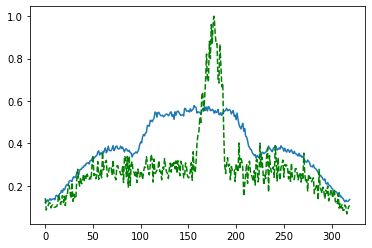

Time taken for epoch:  105.43424320220947
Epoch = [247/3000]  Iter = [   0/39480]  Loss = 0.1292 Avg Loss = 0.1292  Time = 0.1707s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [247/3000]  Iter = [ 100/39480]  Loss = 0.1689 Avg Loss = 0.1364  Time = 0.0019s
Epoch = [247/3000]  Iter = [ 200/39480]  Loss = 0.1146 Avg Loss = 0.1377  Time = 0.0019s
Epoch = [247/3000]  Iter = [ 300/39480]  Loss = 0.1232 Avg Loss = 0.1407  Time = 0.0030s
Epoch = [247/3000]  Iter = [ 400/39480]  Loss = 0.1316 Avg Loss = 0.1404  Time = 0.0019s
Epoch = [247/3000]  Iter = [ 500/39480]  Loss = 0.1416 Avg Loss = 0.1416  Time = 0.0024s
Epoch = [247/3000]  Iter = [ 600/39480]  Loss = 0.1335 Avg Loss = 0.1405  Time = 0.0084s
Epoch = [247/3000]  Iter = [ 700/39480]  Loss = 0.1381 Avg Loss = 0.1403  Time = 0.0024s
Epoch = [247/3000]  Iter = [ 800/39480]  Loss = 0.1623 Avg Loss = 0.1407  Time = 0.0019s
Epoch = [247/3000]  Iter = [ 900/39480]  Loss = 0.1499 Avg Loss = 0.1404  Time = 0.0019s
Epoch = [247/3000]  Iter = [1000/39480]  Loss = 0.1209 Avg Loss = 0.14  Time = 0.0019s
Epoch = [247/3000]  Iter = [1100/39480]  Loss = 0.145 Avg Loss = 0.1397  Time = 0.0035s
Epoch = [247/3000]  Iter

Epoch = [247/3000]  Iter = [9500/39480]  Loss = 0.1683 Avg Loss = 0.1399  Time = 0.0018s
Epoch = [247/3000]  Iter = [9600/39480]  Loss = 0.1439 Avg Loss = 0.1412  Time = 0.0018s
Epoch = [247/3000]  Iter = [9700/39480]  Loss = 0.1559 Avg Loss = 0.1416  Time = 0.0018s
Epoch = [247/3000]  Iter = [9800/39480]  Loss = 0.1353 Avg Loss = 0.1423  Time = 0.0018s
Epoch = [247/3000]  Iter = [9900/39480]  Loss = 0.1439 Avg Loss = 0.141  Time = 0.0019s
Epoch = [247/3000]  Iter = [10000/39480]  Loss = 0.1264 Avg Loss = 0.1394  Time = 0.0018s
Epoch = [247/3000]  Iter = [10100/39480]  Loss = 0.1538 Avg Loss = 0.1396  Time = 0.0018s
Epoch = [247/3000]  Iter = [10200/39480]  Loss = 0.1572 Avg Loss = 0.1415  Time = 0.0018s
Epoch = [247/3000]  Iter = [10300/39480]  Loss = 0.1408 Avg Loss = 0.1418  Time = 0.0023s
Epoch = [247/3000]  Iter = [10400/39480]  Loss = 0.1348 Avg Loss = 0.141  Time = 0.0022s
Epoch = [247/3000]  Iter = [10500/39480]  Loss = 0.1414 Avg Loss = 0.1388  Time = 0.0018s
Epoch = [247/3000

Epoch = [247/3000]  Iter = [18800/39480]  Loss = 0.1687 Avg Loss = 0.1417  Time = 0.0018s
Epoch = [247/3000]  Iter = [18900/39480]  Loss = 0.1586 Avg Loss = 0.1428  Time = 0.0022s
Epoch = [247/3000]  Iter = [19000/39480]  Loss = 0.1723 Avg Loss = 0.1397  Time = 0.0018s
Epoch = [247/3000]  Iter = [19100/39480]  Loss = 0.1416 Avg Loss = 0.1394  Time = 0.0018s
Epoch = [247/3000]  Iter = [19200/39480]  Loss = 0.1355 Avg Loss = 0.1395  Time = 0.0018s
Epoch = [247/3000]  Iter = [19300/39480]  Loss = 0.1392 Avg Loss = 0.1415  Time = 0.0018s
Epoch = [247/3000]  Iter = [19400/39480]  Loss = 0.1439 Avg Loss = 0.1404  Time = 0.0018s
Epoch = [247/3000]  Iter = [19500/39480]  Loss = 0.1343 Avg Loss = 0.14  Time = 0.0018s
Epoch = [247/3000]  Iter = [19600/39480]  Loss = 0.1379 Avg Loss = 0.1412  Time = 0.0018s
Epoch = [247/3000]  Iter = [19700/39480]  Loss = 0.1425 Avg Loss = 0.142  Time = 0.0019s
Epoch = [247/3000]  Iter = [19800/39480]  Loss = 0.1327 Avg Loss = 0.1419  Time = 0.0018s
Epoch = [247/

Epoch = [247/3000]  Iter = [28000/39480]  Loss = 0.1267 Avg Loss = 0.1415  Time = 0.0019s
Epoch = [247/3000]  Iter = [28100/39480]  Loss = 0.152 Avg Loss = 0.1411  Time = 0.0019s
Epoch = [247/3000]  Iter = [28200/39480]  Loss = 0.1468 Avg Loss = 0.1429  Time = 0.0018s
Epoch = [247/3000]  Iter = [28300/39480]  Loss = 0.1558 Avg Loss = 0.1444  Time = 0.0019s
Epoch = [247/3000]  Iter = [28400/39480]  Loss = 0.1335 Avg Loss = 0.1419  Time = 0.0019s
Epoch = [247/3000]  Iter = [28500/39480]  Loss = 0.1462 Avg Loss = 0.1407  Time = 0.0019s
Epoch = [247/3000]  Iter = [28600/39480]  Loss = 0.1394 Avg Loss = 0.1416  Time = 0.0019s
Epoch = [247/3000]  Iter = [28700/39480]  Loss = 0.1166 Avg Loss = 0.1392  Time = 0.0019s
Epoch = [247/3000]  Iter = [28800/39480]  Loss = 0.1428 Avg Loss = 0.1402  Time = 0.0019s
Epoch = [247/3000]  Iter = [28900/39480]  Loss = 0.1418 Avg Loss = 0.1411  Time = 0.0019s
Epoch = [247/3000]  Iter = [29000/39480]  Loss = 0.1523 Avg Loss = 0.1419  Time = 0.0019s
Epoch = [24

Epoch = [247/3000]  Iter = [37300/39480]  Loss = 0.1273 Avg Loss = 0.1416  Time = 0.0019s
Epoch = [247/3000]  Iter = [37400/39480]  Loss = 0.128 Avg Loss = 0.1415  Time = 0.0018s
Epoch = [247/3000]  Iter = [37500/39480]  Loss = 0.1577 Avg Loss = 0.1418  Time = 0.0018s
Epoch = [247/3000]  Iter = [37600/39480]  Loss = 0.1344 Avg Loss = 0.1411  Time = 0.0018s
Epoch = [247/3000]  Iter = [37700/39480]  Loss = 0.1443 Avg Loss = 0.1409  Time = 0.0021s
Epoch = [247/3000]  Iter = [37800/39480]  Loss = 0.1406 Avg Loss = 0.1414  Time = 0.0018s
Epoch = [247/3000]  Iter = [37900/39480]  Loss = 0.138 Avg Loss = 0.1414  Time = 0.0018s
Epoch = [247/3000]  Iter = [38000/39480]  Loss = 0.1501 Avg Loss = 0.1424  Time = 0.0018s
Epoch = [247/3000]  Iter = [38100/39480]  Loss = 0.148 Avg Loss = 0.1422  Time = 0.0018s
Epoch = [247/3000]  Iter = [38200/39480]  Loss = 0.1583 Avg Loss = 0.1428  Time = 0.0018s
Epoch = [247/3000]  Iter = [38300/39480]  Loss = 0.146 Avg Loss = 0.1417  Time = 0.0018s
Epoch = [247/3

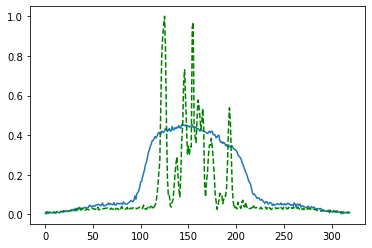

Time taken for epoch:  106.84440350532532
Epoch = [248/3000]  Iter = [   0/39480]  Loss = 0.1405 Avg Loss = 0.1405  Time = 0.1402s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [248/3000]  Iter = [ 100/39480]  Loss = 0.1634 Avg Loss = 0.1411  Time = 0.0019s
Epoch = [248/3000]  Iter = [ 200/39480]  Loss = 0.1614 Avg Loss = 0.1421  Time = 0.0018s
Epoch = [248/3000]  Iter = [ 300/39480]  Loss = 0.12 Avg Loss = 0.1405  Time = 0.0019s
Epoch = [248/3000]  Iter = [ 400/39480]  Loss = 0.1176 Avg Loss = 0.14  Time = 0.0019s
Epoch = [248/3000]  Iter = [ 500/39480]  Loss = 0.1355 Avg Loss = 0.1404  Time = 0.0019s
Epoch = [248/3000]  Iter = [ 600/39480]  Loss = 0.1172 Avg Loss = 0.1407  Time = 0.0019s
Epoch = [248/3000]  Iter = [ 700/39480]  Loss = 0.1506 Avg Loss = 0.1404  Time = 0.0019s
Epoch = [248/3000]  Iter = [ 800/39480]  Loss = 0.132 Avg Loss = 0.1396  Time = 0.0019s
Epoch = [248/3000]  Iter = [ 900/39480]  Loss = 0.1387 Avg Loss = 0.1393  Time = 0.0019s
Epoch = [248/3000]  Iter = [1000/39480]  Loss = 0.1166 Avg Loss = 0.1406  Time = 0.0019s
Epoch = [248/3000]  Iter = [1100/39480]  Loss = 0.1138 Avg Loss = 0.1403  Time = 0.0018s
Epoch = [248/3000]  Iter =

Epoch = [248/3000]  Iter = [9400/39480]  Loss = 0.1554 Avg Loss = 0.1403  Time = 0.0018s
Epoch = [248/3000]  Iter = [9500/39480]  Loss = 0.139 Avg Loss = 0.1402  Time = 0.0018s
Epoch = [248/3000]  Iter = [9600/39480]  Loss = 0.128 Avg Loss = 0.1402  Time = 0.0018s
Epoch = [248/3000]  Iter = [9700/39480]  Loss = 0.1414 Avg Loss = 0.141  Time = 0.0018s
Epoch = [248/3000]  Iter = [9800/39480]  Loss = 0.1503 Avg Loss = 0.1407  Time = 0.0018s
Epoch = [248/3000]  Iter = [9900/39480]  Loss = 0.1459 Avg Loss = 0.1418  Time = 0.0018s
Epoch = [248/3000]  Iter = [10000/39480]  Loss = 0.1187 Avg Loss = 0.1393  Time = 0.0019s
Epoch = [248/3000]  Iter = [10100/39480]  Loss = 0.1585 Avg Loss = 0.1404  Time = 0.0018s
Epoch = [248/3000]  Iter = [10200/39480]  Loss = 0.1378 Avg Loss = 0.1415  Time = 0.0019s
Epoch = [248/3000]  Iter = [10300/39480]  Loss = 0.149 Avg Loss = 0.1403  Time = 0.0019s
Epoch = [248/3000]  Iter = [10400/39480]  Loss = 0.134 Avg Loss = 0.1389  Time = 0.0018s
Epoch = [248/3000]  I

Epoch = [248/3000]  Iter = [18700/39480]  Loss = 0.1481 Avg Loss = 0.1406  Time = 0.0018s
Epoch = [248/3000]  Iter = [18800/39480]  Loss = 0.1116 Avg Loss = 0.1415  Time = 0.0018s
Epoch = [248/3000]  Iter = [18900/39480]  Loss = 0.1387 Avg Loss = 0.1409  Time = 0.0018s
Epoch = [248/3000]  Iter = [19000/39480]  Loss = 0.1394 Avg Loss = 0.1415  Time = 0.0018s
Epoch = [248/3000]  Iter = [19100/39480]  Loss = 0.111 Avg Loss = 0.1405  Time = 0.0018s
Epoch = [248/3000]  Iter = [19200/39480]  Loss = 0.1327 Avg Loss = 0.1409  Time = 0.0018s
Epoch = [248/3000]  Iter = [19300/39480]  Loss = 0.1515 Avg Loss = 0.142  Time = 0.0019s
Epoch = [248/3000]  Iter = [19400/39480]  Loss = 0.1412 Avg Loss = 0.144  Time = 0.0019s
Epoch = [248/3000]  Iter = [19500/39480]  Loss = 0.1268 Avg Loss = 0.1402  Time = 0.0019s
Epoch = [248/3000]  Iter = [19600/39480]  Loss = 0.1368 Avg Loss = 0.1398  Time = 0.0019s
Epoch = [248/3000]  Iter = [19700/39480]  Loss = 0.1288 Avg Loss = 0.1401  Time = 0.0019s
Epoch = [248/

Epoch = [248/3000]  Iter = [27900/39480]  Loss = 0.1489 Avg Loss = 0.142  Time = 0.0018s
Epoch = [248/3000]  Iter = [28000/39480]  Loss = 0.1488 Avg Loss = 0.1427  Time = 0.0127s
Epoch = [248/3000]  Iter = [28100/39480]  Loss = 0.1281 Avg Loss = 0.1423  Time = 0.0053s
Epoch = [248/3000]  Iter = [28200/39480]  Loss = 0.1584 Avg Loss = 0.1424  Time = 0.0018s
Epoch = [248/3000]  Iter = [28300/39480]  Loss = 0.1442 Avg Loss = 0.1421  Time = 0.0018s
Epoch = [248/3000]  Iter = [28400/39480]  Loss = 0.1396 Avg Loss = 0.1408  Time = 0.0018s
Epoch = [248/3000]  Iter = [28500/39480]  Loss = 0.1297 Avg Loss = 0.1421  Time = 0.0018s
Epoch = [248/3000]  Iter = [28600/39480]  Loss = 0.1478 Avg Loss = 0.1401  Time = 0.0070s
Epoch = [248/3000]  Iter = [28700/39480]  Loss = 0.1209 Avg Loss = 0.1407  Time = 0.0024s
Epoch = [248/3000]  Iter = [28800/39480]  Loss = 0.141 Avg Loss = 0.142  Time = 0.0018s
Epoch = [248/3000]  Iter = [28900/39480]  Loss = 0.1363 Avg Loss = 0.1408  Time = 0.0018s
Epoch = [248/

Epoch = [248/3000]  Iter = [37100/39480]  Loss = 0.1411 Avg Loss = 0.1414  Time = 0.0018s
Epoch = [248/3000]  Iter = [37200/39480]  Loss = 0.1305 Avg Loss = 0.1425  Time = 0.0018s
Epoch = [248/3000]  Iter = [37300/39480]  Loss = 0.1522 Avg Loss = 0.1432  Time = 0.0018s
Epoch = [248/3000]  Iter = [37400/39480]  Loss = 0.1213 Avg Loss = 0.1409  Time = 0.0018s
Epoch = [248/3000]  Iter = [37500/39480]  Loss = 0.1255 Avg Loss = 0.1422  Time = 0.0018s
Epoch = [248/3000]  Iter = [37600/39480]  Loss = 0.1405 Avg Loss = 0.1434  Time = 0.0018s
Epoch = [248/3000]  Iter = [37700/39480]  Loss = 0.1162 Avg Loss = 0.1413  Time = 0.0018s
Epoch = [248/3000]  Iter = [37800/39480]  Loss = 0.1194 Avg Loss = 0.1447  Time = 0.0018s
Epoch = [248/3000]  Iter = [37900/39480]  Loss = 0.1373 Avg Loss = 0.142  Time = 0.0126s
Epoch = [248/3000]  Iter = [38000/39480]  Loss = 0.1593 Avg Loss = 0.1424  Time = 0.0018s
Epoch = [248/3000]  Iter = [38100/39480]  Loss = 0.1366 Avg Loss = 0.1428  Time = 0.0018s
Epoch = [24

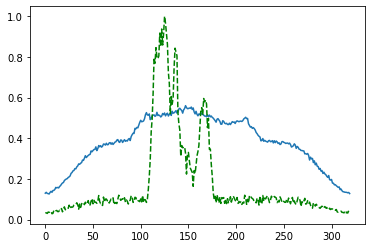

Time taken for epoch:  107.36993217468262
Epoch = [249/3000]  Iter = [   0/39480]  Loss = 0.1521 Avg Loss = 0.1521  Time = 0.1481s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [249/3000]  Iter = [ 100/39480]  Loss = 0.1219 Avg Loss = 0.1434  Time = 0.0025s
Epoch = [249/3000]  Iter = [ 200/39480]  Loss = 0.1276 Avg Loss = 0.1402  Time = 0.0041s
Epoch = [249/3000]  Iter = [ 300/39480]  Loss = 0.1368 Avg Loss = 0.1385  Time = 0.0019s
Epoch = [249/3000]  Iter = [ 400/39480]  Loss = 0.15 Avg Loss = 0.1397  Time = 0.0018s
Epoch = [249/3000]  Iter = [ 500/39480]  Loss = 0.16 Avg Loss = 0.1402  Time = 0.0019s
Epoch = [249/3000]  Iter = [ 600/39480]  Loss = 0.1442 Avg Loss = 0.1404  Time = 0.0018s
Epoch = [249/3000]  Iter = [ 700/39480]  Loss = 0.1575 Avg Loss = 0.1423  Time = 0.0019s
Epoch = [249/3000]  Iter = [ 800/39480]  Loss = 0.13 Avg Loss = 0.1411  Time = 0.0019s
Epoch = [249/3000]  Iter = [ 900/39480]  Loss = 0.145 Avg Loss = 0.1393  Time = 0.0019s
Epoch = [249/3000]  Iter = [1000/39480]  Loss = 0.1491 Avg Loss = 0.1393  Time = 0.0018s
Epoch = [249/3000]  Iter = [1100/39480]  Loss = 0.1433 Avg Loss = 0.141  Time = 0.0019s
Epoch = [249/3000]  Iter = [1

Epoch = [249/3000]  Iter = [9400/39480]  Loss = 0.1317 Avg Loss = 0.1406  Time = 0.0019s
Epoch = [249/3000]  Iter = [9500/39480]  Loss = 0.1651 Avg Loss = 0.1411  Time = 0.0018s
Epoch = [249/3000]  Iter = [9600/39480]  Loss = 0.1534 Avg Loss = 0.1402  Time = 0.0019s
Epoch = [249/3000]  Iter = [9700/39480]  Loss = 0.1389 Avg Loss = 0.1415  Time = 0.0018s
Epoch = [249/3000]  Iter = [9800/39480]  Loss = 0.155 Avg Loss = 0.141  Time = 0.0018s
Epoch = [249/3000]  Iter = [9900/39480]  Loss = 0.1582 Avg Loss = 0.1406  Time = 0.0019s
Epoch = [249/3000]  Iter = [10000/39480]  Loss = 0.1358 Avg Loss = 0.142  Time = 0.0018s
Epoch = [249/3000]  Iter = [10100/39480]  Loss = 0.1583 Avg Loss = 0.141  Time = 0.0019s
Epoch = [249/3000]  Iter = [10200/39480]  Loss = 0.1372 Avg Loss = 0.1403  Time = 0.0019s
Epoch = [249/3000]  Iter = [10300/39480]  Loss = 0.1634 Avg Loss = 0.1422  Time = 0.0018s
Epoch = [249/3000]  Iter = [10400/39480]  Loss = 0.1514 Avg Loss = 0.14  Time = 0.0018s
Epoch = [249/3000]  It

Epoch = [249/3000]  Iter = [18600/39480]  Loss = 0.1324 Avg Loss = 0.1408  Time = 0.0018s
Epoch = [249/3000]  Iter = [18700/39480]  Loss = 0.1322 Avg Loss = 0.1405  Time = 0.0018s
Epoch = [249/3000]  Iter = [18800/39480]  Loss = 0.1427 Avg Loss = 0.1401  Time = 0.0018s
Epoch = [249/3000]  Iter = [18900/39480]  Loss = 0.1296 Avg Loss = 0.1401  Time = 0.0018s
Epoch = [249/3000]  Iter = [19000/39480]  Loss = 0.1212 Avg Loss = 0.1392  Time = 0.0018s
Epoch = [249/3000]  Iter = [19100/39480]  Loss = 0.1184 Avg Loss = 0.1409  Time = 0.0018s
Epoch = [249/3000]  Iter = [19200/39480]  Loss = 0.1293 Avg Loss = 0.1409  Time = 0.0018s
Epoch = [249/3000]  Iter = [19300/39480]  Loss = 0.1185 Avg Loss = 0.1398  Time = 0.0018s
Epoch = [249/3000]  Iter = [19400/39480]  Loss = 0.1376 Avg Loss = 0.1413  Time = 0.0018s
Epoch = [249/3000]  Iter = [19500/39480]  Loss = 0.1478 Avg Loss = 0.1418  Time = 0.0018s
Epoch = [249/3000]  Iter = [19600/39480]  Loss = 0.1548 Avg Loss = 0.142  Time = 0.0018s
Epoch = [24

Epoch = [249/3000]  Iter = [27800/39480]  Loss = 0.121 Avg Loss = 0.1424  Time = 0.0021s
Epoch = [249/3000]  Iter = [27900/39480]  Loss = 0.1782 Avg Loss = 0.1417  Time = 0.0018s
Epoch = [249/3000]  Iter = [28000/39480]  Loss = 0.1491 Avg Loss = 0.1429  Time = 0.0018s
Epoch = [249/3000]  Iter = [28100/39480]  Loss = 0.133 Avg Loss = 0.1408  Time = 0.0018s
Epoch = [249/3000]  Iter = [28200/39480]  Loss = 0.1447 Avg Loss = 0.1403  Time = 0.0018s
Epoch = [249/3000]  Iter = [28300/39480]  Loss = 0.1514 Avg Loss = 0.1419  Time = 0.0019s
Epoch = [249/3000]  Iter = [28400/39480]  Loss = 0.136 Avg Loss = 0.1405  Time = 0.0018s
Epoch = [249/3000]  Iter = [28500/39480]  Loss = 0.1599 Avg Loss = 0.1407  Time = 0.0018s
Epoch = [249/3000]  Iter = [28600/39480]  Loss = 0.1514 Avg Loss = 0.1417  Time = 0.0019s
Epoch = [249/3000]  Iter = [28700/39480]  Loss = 0.1704 Avg Loss = 0.1419  Time = 0.0018s
Epoch = [249/3000]  Iter = [28800/39480]  Loss = 0.1396 Avg Loss = 0.1412  Time = 0.0018s
Epoch = [249/

Epoch = [249/3000]  Iter = [37000/39480]  Loss = 0.1398 Avg Loss = 0.1415  Time = 0.0018s
Epoch = [249/3000]  Iter = [37100/39480]  Loss = 0.1404 Avg Loss = 0.1418  Time = 0.0018s
Epoch = [249/3000]  Iter = [37200/39480]  Loss = 0.1349 Avg Loss = 0.1417  Time = 0.0052s
Epoch = [249/3000]  Iter = [37300/39480]  Loss = 0.1393 Avg Loss = 0.1426  Time = 0.0018s
Epoch = [249/3000]  Iter = [37400/39480]  Loss = 0.1558 Avg Loss = 0.1422  Time = 0.0018s
Epoch = [249/3000]  Iter = [37500/39480]  Loss = 0.1527 Avg Loss = 0.142  Time = 0.0018s
Epoch = [249/3000]  Iter = [37600/39480]  Loss = 0.1309 Avg Loss = 0.1428  Time = 0.0018s
Epoch = [249/3000]  Iter = [37700/39480]  Loss = 0.1479 Avg Loss = 0.1423  Time = 0.0018s
Epoch = [249/3000]  Iter = [37800/39480]  Loss = 0.1233 Avg Loss = 0.1439  Time = 0.0018s
Epoch = [249/3000]  Iter = [37900/39480]  Loss = 0.1574 Avg Loss = 0.1414  Time = 0.0018s
Epoch = [249/3000]  Iter = [38000/39480]  Loss = 0.1359 Avg Loss = 0.1423  Time = 0.0018s
Epoch = [24

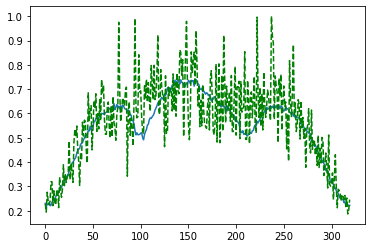

Time taken for epoch:  106.74483013153076
Epoch = [250/3000]  Iter = [   0/39480]  Loss = 0.1379 Avg Loss = 0.1379  Time = 0.1184s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [250/3000]  Iter = [ 100/39480]  Loss = 0.1129 Avg Loss = 0.141  Time = 0.0018s
Epoch = [250/3000]  Iter = [ 200/39480]  Loss = 0.1495 Avg Loss = 0.1395  Time = 0.0018s
Epoch = [250/3000]  Iter = [ 300/39480]  Loss = 0.1627 Avg Loss = 0.1398  Time = 0.0039s
Epoch = [250/3000]  Iter = [ 400/39480]  Loss = 0.1394 Avg Loss = 0.1402  Time = 0.0019s
Epoch = [250/3000]  Iter = [ 500/39480]  Loss = 0.1198 Avg Loss = 0.1416  Time = 0.0019s
Epoch = [250/3000]  Iter = [ 600/39480]  Loss = 0.1443 Avg Loss = 0.1411  Time = 0.0019s
Epoch = [250/3000]  Iter = [ 700/39480]  Loss = 0.1182 Avg Loss = 0.1408  Time = 0.0019s
Epoch = [250/3000]  Iter = [ 800/39480]  Loss = 0.147 Avg Loss = 0.1396  Time = 0.0023s
Epoch = [250/3000]  Iter = [ 900/39480]  Loss = 0.1346 Avg Loss = 0.1393  Time = 0.0019s
Epoch = [250/3000]  Iter = [1000/39480]  Loss = 0.1445 Avg Loss = 0.1392  Time = 0.0019s
Epoch = [250/3000]  Iter = [1100/39480]  Loss = 0.1226 Avg Loss = 0.138  Time = 0.0018s
Epoch = [250/3000]  Iter

Epoch = [250/3000]  Iter = [9400/39480]  Loss = 0.1076 Avg Loss = 0.141  Time = 0.0019s
Epoch = [250/3000]  Iter = [9500/39480]  Loss = 0.1213 Avg Loss = 0.1396  Time = 0.0018s
Epoch = [250/3000]  Iter = [9600/39480]  Loss = 0.1699 Avg Loss = 0.1418  Time = 0.0018s
Epoch = [250/3000]  Iter = [9700/39480]  Loss = 0.1592 Avg Loss = 0.142  Time = 0.0019s
Epoch = [250/3000]  Iter = [9800/39480]  Loss = 0.1303 Avg Loss = 0.1419  Time = 0.0019s
Epoch = [250/3000]  Iter = [9900/39480]  Loss = 0.1647 Avg Loss = 0.1422  Time = 0.0018s
Epoch = [250/3000]  Iter = [10000/39480]  Loss = 0.139 Avg Loss = 0.1423  Time = 0.0018s
Epoch = [250/3000]  Iter = [10100/39480]  Loss = 0.1324 Avg Loss = 0.1409  Time = 0.0018s
Epoch = [250/3000]  Iter = [10200/39480]  Loss = 0.1137 Avg Loss = 0.14  Time = 0.0034s
Epoch = [250/3000]  Iter = [10300/39480]  Loss = 0.153 Avg Loss = 0.1415  Time = 0.0018s
Epoch = [250/3000]  Iter = [10400/39480]  Loss = 0.1488 Avg Loss = 0.1407  Time = 0.0018s
Epoch = [250/3000]  It

Epoch = [250/3000]  Iter = [18600/39480]  Loss = 0.1724 Avg Loss = 0.1423  Time = 0.0019s
Epoch = [250/3000]  Iter = [18700/39480]  Loss = 0.1149 Avg Loss = 0.1408  Time = 0.0019s
Epoch = [250/3000]  Iter = [18800/39480]  Loss = 0.1283 Avg Loss = 0.1417  Time = 0.0019s
Epoch = [250/3000]  Iter = [18900/39480]  Loss = 0.1416 Avg Loss = 0.1419  Time = 0.0019s
Epoch = [250/3000]  Iter = [19000/39480]  Loss = 0.1307 Avg Loss = 0.1422  Time = 0.0019s
Epoch = [250/3000]  Iter = [19100/39480]  Loss = 0.1278 Avg Loss = 0.1411  Time = 0.0018s
Epoch = [250/3000]  Iter = [19200/39480]  Loss = 0.1325 Avg Loss = 0.1421  Time = 0.0023s
Epoch = [250/3000]  Iter = [19300/39480]  Loss = 0.1437 Avg Loss = 0.1399  Time = 0.0018s
Epoch = [250/3000]  Iter = [19400/39480]  Loss = 0.1131 Avg Loss = 0.1397  Time = 0.0019s
Epoch = [250/3000]  Iter = [19500/39480]  Loss = 0.1253 Avg Loss = 0.1394  Time = 0.0018s
Epoch = [250/3000]  Iter = [19600/39480]  Loss = 0.1372 Avg Loss = 0.1406  Time = 0.0019s
Epoch = [2

Epoch = [250/3000]  Iter = [27800/39480]  Loss = 0.1229 Avg Loss = 0.141  Time = 0.0019s
Epoch = [250/3000]  Iter = [27900/39480]  Loss = 0.175 Avg Loss = 0.1412  Time = 0.0018s
Epoch = [250/3000]  Iter = [28000/39480]  Loss = 0.144 Avg Loss = 0.1402  Time = 0.0019s
Epoch = [250/3000]  Iter = [28100/39480]  Loss = 0.1346 Avg Loss = 0.1408  Time = 0.0018s
Epoch = [250/3000]  Iter = [28200/39480]  Loss = 0.1268 Avg Loss = 0.1416  Time = 0.0017s
Epoch = [250/3000]  Iter = [28300/39480]  Loss = 0.15 Avg Loss = 0.1411  Time = 0.0137s
Epoch = [250/3000]  Iter = [28400/39480]  Loss = 0.1545 Avg Loss = 0.1417  Time = 0.0018s
Epoch = [250/3000]  Iter = [28500/39480]  Loss = 0.1432 Avg Loss = 0.1418  Time = 0.0018s
Epoch = [250/3000]  Iter = [28600/39480]  Loss = 0.147 Avg Loss = 0.1401  Time = 0.0018s
Epoch = [250/3000]  Iter = [28700/39480]  Loss = 0.1454 Avg Loss = 0.1406  Time = 0.0018s
Epoch = [250/3000]  Iter = [28800/39480]  Loss = 0.1551 Avg Loss = 0.1422  Time = 0.0018s
Epoch = [250/300

Epoch = [250/3000]  Iter = [37000/39480]  Loss = 0.1341 Avg Loss = 0.1424  Time = 0.0018s
Epoch = [250/3000]  Iter = [37100/39480]  Loss = 0.1342 Avg Loss = 0.1425  Time = 0.0029s
Epoch = [250/3000]  Iter = [37200/39480]  Loss = 0.1509 Avg Loss = 0.1414  Time = 0.0018s
Epoch = [250/3000]  Iter = [37300/39480]  Loss = 0.1298 Avg Loss = 0.1432  Time = 0.0019s
Epoch = [250/3000]  Iter = [37400/39480]  Loss = 0.1409 Avg Loss = 0.1418  Time = 0.0116s
Epoch = [250/3000]  Iter = [37500/39480]  Loss = 0.1512 Avg Loss = 0.1418  Time = 0.0018s
Epoch = [250/3000]  Iter = [37600/39480]  Loss = 0.1333 Avg Loss = 0.1422  Time = 0.0018s
Epoch = [250/3000]  Iter = [37700/39480]  Loss = 0.1502 Avg Loss = 0.1407  Time = 0.0096s
Epoch = [250/3000]  Iter = [37800/39480]  Loss = 0.125 Avg Loss = 0.1415  Time = 0.0018s
Epoch = [250/3000]  Iter = [37900/39480]  Loss = 0.137 Avg Loss = 0.1415  Time = 0.0019s
Epoch = [250/3000]  Iter = [38000/39480]  Loss = 0.141 Avg Loss = 0.1427  Time = 0.0019s
Epoch = [250/

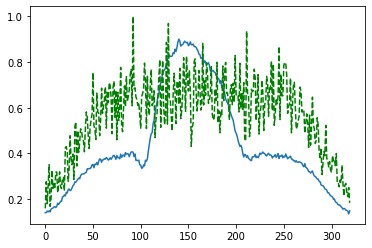

Time taken for epoch:  106.63666605949402
Epoch = [251/3000]  Iter = [   0/39480]  Loss = 0.1344 Avg Loss = 0.1344  Time = 0.1206s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [251/3000]  Iter = [ 100/39480]  Loss = 0.1362 Avg Loss = 0.139  Time = 0.0112s
Epoch = [251/3000]  Iter = [ 200/39480]  Loss = 0.1432 Avg Loss = 0.1392  Time = 0.0018s
Epoch = [251/3000]  Iter = [ 300/39480]  Loss = 0.1222 Avg Loss = 0.14  Time = 0.0018s
Epoch = [251/3000]  Iter = [ 400/39480]  Loss = 0.144 Avg Loss = 0.1384  Time = 0.0018s
Epoch = [251/3000]  Iter = [ 500/39480]  Loss = 0.1299 Avg Loss = 0.1384  Time = 0.0018s
Epoch = [251/3000]  Iter = [ 600/39480]  Loss = 0.1404 Avg Loss = 0.1394  Time = 0.0018s
Epoch = [251/3000]  Iter = [ 700/39480]  Loss = 0.1574 Avg Loss = 0.1389  Time = 0.0023s
Epoch = [251/3000]  Iter = [ 800/39480]  Loss = 0.148 Avg Loss = 0.14  Time = 0.0019s
Epoch = [251/3000]  Iter = [ 900/39480]  Loss = 0.1249 Avg Loss = 0.1389  Time = 0.0019s
Epoch = [251/3000]  Iter = [1000/39480]  Loss = 0.1373 Avg Loss = 0.14  Time = 0.0019s
Epoch = [251/3000]  Iter = [1100/39480]  Loss = 0.1485 Avg Loss = 0.1407  Time = 0.0019s
Epoch = [251/3000]  Iter = [12

Epoch = [251/3000]  Iter = [9500/39480]  Loss = 0.1405 Avg Loss = 0.1407  Time = 0.0018s
Epoch = [251/3000]  Iter = [9600/39480]  Loss = 0.139 Avg Loss = 0.1402  Time = 0.0018s
Epoch = [251/3000]  Iter = [9700/39480]  Loss = 0.1151 Avg Loss = 0.1406  Time = 0.0018s
Epoch = [251/3000]  Iter = [9800/39480]  Loss = 0.1506 Avg Loss = 0.1404  Time = 0.0018s
Epoch = [251/3000]  Iter = [9900/39480]  Loss = 0.1408 Avg Loss = 0.1412  Time = 0.0018s
Epoch = [251/3000]  Iter = [10000/39480]  Loss = 0.1505 Avg Loss = 0.141  Time = 0.0018s
Epoch = [251/3000]  Iter = [10100/39480]  Loss = 0.1318 Avg Loss = 0.1403  Time = 0.0018s
Epoch = [251/3000]  Iter = [10200/39480]  Loss = 0.1288 Avg Loss = 0.1392  Time = 0.0018s
Epoch = [251/3000]  Iter = [10300/39480]  Loss = 0.1373 Avg Loss = 0.1417  Time = 0.0018s
Epoch = [251/3000]  Iter = [10400/39480]  Loss = 0.1067 Avg Loss = 0.1413  Time = 0.0018s
Epoch = [251/3000]  Iter = [10500/39480]  Loss = 0.1047 Avg Loss = 0.1413  Time = 0.0018s
Epoch = [251/3000

Epoch = [251/3000]  Iter = [18700/39480]  Loss = 0.1348 Avg Loss = 0.1413  Time = 0.0019s
Epoch = [251/3000]  Iter = [18800/39480]  Loss = 0.1361 Avg Loss = 0.1403  Time = 0.0018s
Epoch = [251/3000]  Iter = [18900/39480]  Loss = 0.1561 Avg Loss = 0.1412  Time = 0.0018s
Epoch = [251/3000]  Iter = [19000/39480]  Loss = 0.1542 Avg Loss = 0.1407  Time = 0.0018s
Epoch = [251/3000]  Iter = [19100/39480]  Loss = 0.1395 Avg Loss = 0.1406  Time = 0.0018s
Epoch = [251/3000]  Iter = [19200/39480]  Loss = 0.1371 Avg Loss = 0.1403  Time = 0.0019s
Epoch = [251/3000]  Iter = [19300/39480]  Loss = 0.1344 Avg Loss = 0.1401  Time = 0.0018s
Epoch = [251/3000]  Iter = [19400/39480]  Loss = 0.1285 Avg Loss = 0.1404  Time = 0.0018s
Epoch = [251/3000]  Iter = [19500/39480]  Loss = 0.1343 Avg Loss = 0.1412  Time = 0.0019s
Epoch = [251/3000]  Iter = [19600/39480]  Loss = 0.1268 Avg Loss = 0.1403  Time = 0.0018s
Epoch = [251/3000]  Iter = [19700/39480]  Loss = 0.1299 Avg Loss = 0.1413  Time = 0.0018s
Epoch = [2

Epoch = [251/3000]  Iter = [27900/39480]  Loss = 0.1435 Avg Loss = 0.1438  Time = 0.0019s
Epoch = [251/3000]  Iter = [28000/39480]  Loss = 0.143 Avg Loss = 0.142  Time = 0.0018s
Epoch = [251/3000]  Iter = [28100/39480]  Loss = 0.1492 Avg Loss = 0.1421  Time = 0.0018s
Epoch = [251/3000]  Iter = [28200/39480]  Loss = 0.1503 Avg Loss = 0.1435  Time = 0.0131s
Epoch = [251/3000]  Iter = [28300/39480]  Loss = 0.1332 Avg Loss = 0.1416  Time = 0.0018s
Epoch = [251/3000]  Iter = [28400/39480]  Loss = 0.1333 Avg Loss = 0.1411  Time = 0.0020s
Epoch = [251/3000]  Iter = [28500/39480]  Loss = 0.1467 Avg Loss = 0.1405  Time = 0.0018s
Epoch = [251/3000]  Iter = [28600/39480]  Loss = 0.1454 Avg Loss = 0.1427  Time = 0.0019s
Epoch = [251/3000]  Iter = [28700/39480]  Loss = 0.1488 Avg Loss = 0.1404  Time = 0.0018s
Epoch = [251/3000]  Iter = [28800/39480]  Loss = 0.1553 Avg Loss = 0.1427  Time = 0.0122s
Epoch = [251/3000]  Iter = [28900/39480]  Loss = 0.137 Avg Loss = 0.1417  Time = 0.0018s
Epoch = [251/

Epoch = [251/3000]  Iter = [37100/39480]  Loss = 0.1418 Avg Loss = 0.142  Time = 0.0018s
Epoch = [251/3000]  Iter = [37200/39480]  Loss = 0.1447 Avg Loss = 0.1419  Time = 0.0019s
Epoch = [251/3000]  Iter = [37300/39480]  Loss = 0.1404 Avg Loss = 0.1412  Time = 0.0018s
Epoch = [251/3000]  Iter = [37400/39480]  Loss = 0.1446 Avg Loss = 0.1419  Time = 0.0018s
Epoch = [251/3000]  Iter = [37500/39480]  Loss = 0.1532 Avg Loss = 0.1419  Time = 0.0018s
Epoch = [251/3000]  Iter = [37600/39480]  Loss = 0.1264 Avg Loss = 0.1408  Time = 0.0018s
Epoch = [251/3000]  Iter = [37700/39480]  Loss = 0.1622 Avg Loss = 0.1409  Time = 0.0018s
Epoch = [251/3000]  Iter = [37800/39480]  Loss = 0.1419 Avg Loss = 0.1412  Time = 0.0018s
Epoch = [251/3000]  Iter = [37900/39480]  Loss = 0.1368 Avg Loss = 0.1419  Time = 0.0019s
Epoch = [251/3000]  Iter = [38000/39480]  Loss = 0.1484 Avg Loss = 0.1398  Time = 0.0018s
Epoch = [251/3000]  Iter = [38100/39480]  Loss = 0.1415 Avg Loss = 0.1421  Time = 0.0018s
Epoch = [25

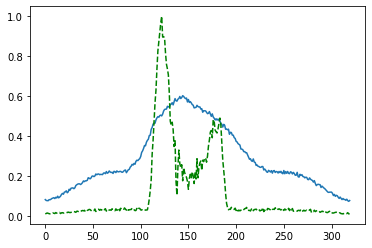

Time taken for epoch:  110.32713842391968
Epoch = [252/3000]  Iter = [   0/39480]  Loss = 0.1341 Avg Loss = 0.1341  Time = 0.1821s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [252/3000]  Iter = [ 100/39480]  Loss = 0.1403 Avg Loss = 0.1378  Time = 0.0019s
Epoch = [252/3000]  Iter = [ 200/39480]  Loss = 0.1318 Avg Loss = 0.1392  Time = 0.0080s
Epoch = [252/3000]  Iter = [ 300/39480]  Loss = 0.1501 Avg Loss = 0.1388  Time = 0.0019s
Epoch = [252/3000]  Iter = [ 400/39480]  Loss = 0.136 Avg Loss = 0.1391  Time = 0.0019s
Epoch = [252/3000]  Iter = [ 500/39480]  Loss = 0.1409 Avg Loss = 0.1404  Time = 0.0018s
Epoch = [252/3000]  Iter = [ 600/39480]  Loss = 0.1245 Avg Loss = 0.141  Time = 0.0018s
Epoch = [252/3000]  Iter = [ 700/39480]  Loss = 0.1462 Avg Loss = 0.1402  Time = 0.0139s
Epoch = [252/3000]  Iter = [ 800/39480]  Loss = 0.1386 Avg Loss = 0.1404  Time = 0.0019s
Epoch = [252/3000]  Iter = [ 900/39480]  Loss = 0.1232 Avg Loss = 0.139  Time = 0.0018s
Epoch = [252/3000]  Iter = [1000/39480]  Loss = 0.1444 Avg Loss = 0.1401  Time = 0.0019s
Epoch = [252/3000]  Iter = [1100/39480]  Loss = 0.1495 Avg Loss = 0.1393  Time = 0.0019s
Epoch = [252/3000]  Iter

Epoch = [252/3000]  Iter = [9400/39480]  Loss = 0.1496 Avg Loss = 0.1415  Time = 0.0018s
Epoch = [252/3000]  Iter = [9500/39480]  Loss = 0.1249 Avg Loss = 0.1395  Time = 0.0063s
Epoch = [252/3000]  Iter = [9600/39480]  Loss = 0.151 Avg Loss = 0.1408  Time = 0.0018s
Epoch = [252/3000]  Iter = [9700/39480]  Loss = 0.1197 Avg Loss = 0.1399  Time = 0.0064s
Epoch = [252/3000]  Iter = [9800/39480]  Loss = 0.1263 Avg Loss = 0.14  Time = 0.0018s
Epoch = [252/3000]  Iter = [9900/39480]  Loss = 0.1578 Avg Loss = 0.1416  Time = 0.0018s
Epoch = [252/3000]  Iter = [10000/39480]  Loss = 0.1408 Avg Loss = 0.141  Time = 0.0018s
Epoch = [252/3000]  Iter = [10100/39480]  Loss = 0.127 Avg Loss = 0.1397  Time = 0.0027s
Epoch = [252/3000]  Iter = [10200/39480]  Loss = 0.1398 Avg Loss = 0.1397  Time = 0.0018s
Epoch = [252/3000]  Iter = [10300/39480]  Loss = 0.1533 Avg Loss = 0.141  Time = 0.0045s
Epoch = [252/3000]  Iter = [10400/39480]  Loss = 0.1181 Avg Loss = 0.1427  Time = 0.0019s
Epoch = [252/3000]  It

Epoch = [252/3000]  Iter = [18600/39480]  Loss = 0.1293 Avg Loss = 0.1404  Time = 0.0019s
Epoch = [252/3000]  Iter = [18700/39480]  Loss = 0.1307 Avg Loss = 0.1409  Time = 0.0018s
Epoch = [252/3000]  Iter = [18800/39480]  Loss = 0.1544 Avg Loss = 0.1403  Time = 0.0018s
Epoch = [252/3000]  Iter = [18900/39480]  Loss = 0.1386 Avg Loss = 0.1392  Time = 0.0018s
Epoch = [252/3000]  Iter = [19000/39480]  Loss = 0.131 Avg Loss = 0.1413  Time = 0.0019s
Epoch = [252/3000]  Iter = [19100/39480]  Loss = 0.1469 Avg Loss = 0.1416  Time = 0.0018s
Epoch = [252/3000]  Iter = [19200/39480]  Loss = 0.1417 Avg Loss = 0.14  Time = 0.0018s
Epoch = [252/3000]  Iter = [19300/39480]  Loss = 0.1152 Avg Loss = 0.1397  Time = 0.0018s
Epoch = [252/3000]  Iter = [19400/39480]  Loss = 0.1528 Avg Loss = 0.1411  Time = 0.0018s
Epoch = [252/3000]  Iter = [19500/39480]  Loss = 0.1399 Avg Loss = 0.1401  Time = 0.0018s
Epoch = [252/3000]  Iter = [19600/39480]  Loss = 0.139 Avg Loss = 0.1423  Time = 0.0018s
Epoch = [252/3

Epoch = [252/3000]  Iter = [27900/39480]  Loss = 0.1263 Avg Loss = 0.1419  Time = 0.0018s
Epoch = [252/3000]  Iter = [28000/39480]  Loss = 0.1505 Avg Loss = 0.1423  Time = 0.0018s
Epoch = [252/3000]  Iter = [28100/39480]  Loss = 0.1372 Avg Loss = 0.1401  Time = 0.0018s
Epoch = [252/3000]  Iter = [28200/39480]  Loss = 0.1388 Avg Loss = 0.1399  Time = 0.0018s
Epoch = [252/3000]  Iter = [28300/39480]  Loss = 0.1325 Avg Loss = 0.1407  Time = 0.0018s
Epoch = [252/3000]  Iter = [28400/39480]  Loss = 0.1378 Avg Loss = 0.1406  Time = 0.0018s
Epoch = [252/3000]  Iter = [28500/39480]  Loss = 0.1575 Avg Loss = 0.1418  Time = 0.0019s
Epoch = [252/3000]  Iter = [28600/39480]  Loss = 0.1446 Avg Loss = 0.142  Time = 0.0018s
Epoch = [252/3000]  Iter = [28700/39480]  Loss = 0.1195 Avg Loss = 0.1418  Time = 0.0018s
Epoch = [252/3000]  Iter = [28800/39480]  Loss = 0.1237 Avg Loss = 0.1407  Time = 0.0018s
Epoch = [252/3000]  Iter = [28900/39480]  Loss = 0.161 Avg Loss = 0.142  Time = 0.0018s
Epoch = [252/

Epoch = [252/3000]  Iter = [37100/39480]  Loss = 0.1567 Avg Loss = 0.1411  Time = 0.0018s
Epoch = [252/3000]  Iter = [37200/39480]  Loss = 0.1553 Avg Loss = 0.1415  Time = 0.0017s
Epoch = [252/3000]  Iter = [37300/39480]  Loss = 0.1269 Avg Loss = 0.1414  Time = 0.0039s
Epoch = [252/3000]  Iter = [37400/39480]  Loss = 0.1429 Avg Loss = 0.1399  Time = 0.0018s
Epoch = [252/3000]  Iter = [37500/39480]  Loss = 0.1395 Avg Loss = 0.1416  Time = 0.0017s
Epoch = [252/3000]  Iter = [37600/39480]  Loss = 0.1371 Avg Loss = 0.1425  Time = 0.0017s
Epoch = [252/3000]  Iter = [37700/39480]  Loss = 0.1391 Avg Loss = 0.1412  Time = 0.0018s
Epoch = [252/3000]  Iter = [37800/39480]  Loss = 0.1306 Avg Loss = 0.1407  Time = 0.0018s
Epoch = [252/3000]  Iter = [37900/39480]  Loss = 0.1457 Avg Loss = 0.1407  Time = 0.0018s
Epoch = [252/3000]  Iter = [38000/39480]  Loss = 0.1463 Avg Loss = 0.1425  Time = 0.0018s
Epoch = [252/3000]  Iter = [38100/39480]  Loss = 0.1285 Avg Loss = 0.1416  Time = 0.0020s
Epoch = [2

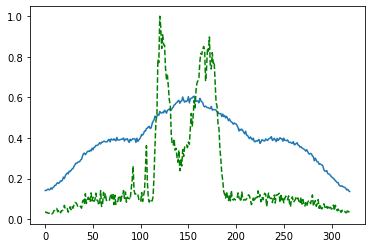

Time taken for epoch:  107.27407240867615
Epoch = [253/3000]  Iter = [   0/39480]  Loss = 0.1435 Avg Loss = 0.1435  Time = 0.1702s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [253/3000]  Iter = [ 100/39480]  Loss = 0.1693 Avg Loss = 0.1415  Time = 0.0019s
Epoch = [253/3000]  Iter = [ 200/39480]  Loss = 0.1423 Avg Loss = 0.1397  Time = 0.0019s
Epoch = [253/3000]  Iter = [ 300/39480]  Loss = 0.1382 Avg Loss = 0.14  Time = 0.0018s
Epoch = [253/3000]  Iter = [ 400/39480]  Loss = 0.1272 Avg Loss = 0.1392  Time = 0.0018s
Epoch = [253/3000]  Iter = [ 500/39480]  Loss = 0.133 Avg Loss = 0.1408  Time = 0.0018s
Epoch = [253/3000]  Iter = [ 600/39480]  Loss = 0.1457 Avg Loss = 0.1407  Time = 0.0018s
Epoch = [253/3000]  Iter = [ 700/39480]  Loss = 0.1432 Avg Loss = 0.1409  Time = 0.0018s
Epoch = [253/3000]  Iter = [ 800/39480]  Loss = 0.135 Avg Loss = 0.1399  Time = 0.0018s
Epoch = [253/3000]  Iter = [ 900/39480]  Loss = 0.1313 Avg Loss = 0.1395  Time = 0.0018s
Epoch = [253/3000]  Iter = [1000/39480]  Loss = 0.1748 Avg Loss = 0.141  Time = 0.0018s
Epoch = [253/3000]  Iter = [1100/39480]  Loss = 0.1404 Avg Loss = 0.1391  Time = 0.0018s
Epoch = [253/3000]  Iter =

Epoch = [253/3000]  Iter = [9400/39480]  Loss = 0.1577 Avg Loss = 0.1405  Time = 0.0018s
Epoch = [253/3000]  Iter = [9500/39480]  Loss = 0.1333 Avg Loss = 0.1403  Time = 0.0018s
Epoch = [253/3000]  Iter = [9600/39480]  Loss = 0.1421 Avg Loss = 0.1412  Time = 0.0017s
Epoch = [253/3000]  Iter = [9700/39480]  Loss = 0.1561 Avg Loss = 0.1424  Time = 0.0018s
Epoch = [253/3000]  Iter = [9800/39480]  Loss = 0.1688 Avg Loss = 0.1411  Time = 0.0018s
Epoch = [253/3000]  Iter = [9900/39480]  Loss = 0.1301 Avg Loss = 0.1404  Time = 0.0017s
Epoch = [253/3000]  Iter = [10000/39480]  Loss = 0.1483 Avg Loss = 0.1409  Time = 0.0017s
Epoch = [253/3000]  Iter = [10100/39480]  Loss = 0.1289 Avg Loss = 0.1423  Time = 0.0017s
Epoch = [253/3000]  Iter = [10200/39480]  Loss = 0.1531 Avg Loss = 0.1426  Time = 0.0018s
Epoch = [253/3000]  Iter = [10300/39480]  Loss = 0.1324 Avg Loss = 0.1418  Time = 0.0018s
Epoch = [253/3000]  Iter = [10400/39480]  Loss = 0.1302 Avg Loss = 0.1409  Time = 0.0018s
Epoch = [253/300

Epoch = [253/3000]  Iter = [18700/39480]  Loss = 0.1325 Avg Loss = 0.1405  Time = 0.0018s
Epoch = [253/3000]  Iter = [18800/39480]  Loss = 0.1292 Avg Loss = 0.1406  Time = 0.0018s
Epoch = [253/3000]  Iter = [18900/39480]  Loss = 0.1352 Avg Loss = 0.1413  Time = 0.0018s
Epoch = [253/3000]  Iter = [19000/39480]  Loss = 0.1306 Avg Loss = 0.1409  Time = 0.0018s
Epoch = [253/3000]  Iter = [19100/39480]  Loss = 0.1572 Avg Loss = 0.1412  Time = 0.0018s
Epoch = [253/3000]  Iter = [19200/39480]  Loss = 0.1497 Avg Loss = 0.1413  Time = 0.0018s
Epoch = [253/3000]  Iter = [19300/39480]  Loss = 0.1243 Avg Loss = 0.1409  Time = 0.0018s
Epoch = [253/3000]  Iter = [19400/39480]  Loss = 0.127 Avg Loss = 0.1407  Time = 0.0018s
Epoch = [253/3000]  Iter = [19500/39480]  Loss = 0.1569 Avg Loss = 0.1406  Time = 0.0018s
Epoch = [253/3000]  Iter = [19600/39480]  Loss = 0.1247 Avg Loss = 0.1412  Time = 0.0018s
Epoch = [253/3000]  Iter = [19700/39480]  Loss = 0.1438 Avg Loss = 0.1404  Time = 0.0018s
Epoch = [25

Epoch = [253/3000]  Iter = [28000/39480]  Loss = 0.1382 Avg Loss = 0.1424  Time = 0.0018s
Epoch = [253/3000]  Iter = [28100/39480]  Loss = 0.1395 Avg Loss = 0.1423  Time = 0.0018s
Epoch = [253/3000]  Iter = [28200/39480]  Loss = 0.1576 Avg Loss = 0.1423  Time = 0.0018s
Epoch = [253/3000]  Iter = [28300/39480]  Loss = 0.1542 Avg Loss = 0.1415  Time = 0.0018s
Epoch = [253/3000]  Iter = [28400/39480]  Loss = 0.124 Avg Loss = 0.1409  Time = 0.0018s
Epoch = [253/3000]  Iter = [28500/39480]  Loss = 0.1356 Avg Loss = 0.1425  Time = 0.0116s
Epoch = [253/3000]  Iter = [28600/39480]  Loss = 0.1345 Avg Loss = 0.1421  Time = 0.0019s
Epoch = [253/3000]  Iter = [28700/39480]  Loss = 0.1544 Avg Loss = 0.1424  Time = 0.0019s
Epoch = [253/3000]  Iter = [28800/39480]  Loss = 0.1291 Avg Loss = 0.1428  Time = 0.0018s
Epoch = [253/3000]  Iter = [28900/39480]  Loss = 0.1386 Avg Loss = 0.1416  Time = 0.0018s
Epoch = [253/3000]  Iter = [29000/39480]  Loss = 0.1433 Avg Loss = 0.143  Time = 0.0018s
Epoch = [253

Epoch = [253/3000]  Iter = [37300/39480]  Loss = 0.1371 Avg Loss = 0.1423  Time = 0.0057s
Epoch = [253/3000]  Iter = [37400/39480]  Loss = 0.1272 Avg Loss = 0.1413  Time = 0.0018s
Epoch = [253/3000]  Iter = [37500/39480]  Loss = 0.1357 Avg Loss = 0.1422  Time = 0.0018s
Epoch = [253/3000]  Iter = [37600/39480]  Loss = 0.1253 Avg Loss = 0.1416  Time = 0.0018s
Epoch = [253/3000]  Iter = [37700/39480]  Loss = 0.139 Avg Loss = 0.1423  Time = 0.0018s
Epoch = [253/3000]  Iter = [37800/39480]  Loss = 0.1626 Avg Loss = 0.1412  Time = 0.0018s
Epoch = [253/3000]  Iter = [37900/39480]  Loss = 0.1445 Avg Loss = 0.1421  Time = 0.0018s
Epoch = [253/3000]  Iter = [38000/39480]  Loss = 0.141 Avg Loss = 0.1432  Time = 0.0019s
Epoch = [253/3000]  Iter = [38100/39480]  Loss = 0.1351 Avg Loss = 0.1431  Time = 0.0019s
Epoch = [253/3000]  Iter = [38200/39480]  Loss = 0.1544 Avg Loss = 0.1425  Time = 0.0019s
Epoch = [253/3000]  Iter = [38300/39480]  Loss = 0.1494 Avg Loss = 0.1418  Time = 0.0018s
Epoch = [253

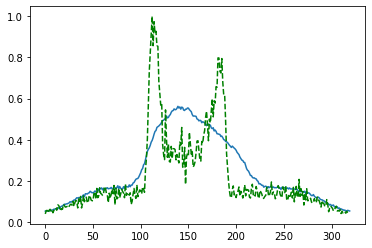

Time taken for epoch:  109.13917279243469
Epoch = [254/3000]  Iter = [   0/39480]  Loss = 0.1539 Avg Loss = 0.1539  Time = 0.1255s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [254/3000]  Iter = [ 100/39480]  Loss = 0.1529 Avg Loss = 0.1444  Time = 0.0019s
Epoch = [254/3000]  Iter = [ 200/39480]  Loss = 0.1286 Avg Loss = 0.1426  Time = 0.0019s
Epoch = [254/3000]  Iter = [ 300/39480]  Loss = 0.1447 Avg Loss = 0.1415  Time = 0.0018s
Epoch = [254/3000]  Iter = [ 400/39480]  Loss = 0.165 Avg Loss = 0.1395  Time = 0.0019s
Epoch = [254/3000]  Iter = [ 500/39480]  Loss = 0.1408 Avg Loss = 0.1396  Time = 0.0019s
Epoch = [254/3000]  Iter = [ 600/39480]  Loss = 0.1329 Avg Loss = 0.1406  Time = 0.0018s
Epoch = [254/3000]  Iter = [ 700/39480]  Loss = 0.1412 Avg Loss = 0.141  Time = 0.0019s
Epoch = [254/3000]  Iter = [ 800/39480]  Loss = 0.1625 Avg Loss = 0.1403  Time = 0.0019s
Epoch = [254/3000]  Iter = [ 900/39480]  Loss = 0.1581 Avg Loss = 0.141  Time = 0.0019s
Epoch = [254/3000]  Iter = [1000/39480]  Loss = 0.1548 Avg Loss = 0.1414  Time = 0.0019s
Epoch = [254/3000]  Iter = [1100/39480]  Loss = 0.1407 Avg Loss = 0.1402  Time = 0.0019s
Epoch = [254/3000]  Iter

Epoch = [254/3000]  Iter = [9500/39480]  Loss = 0.1516 Avg Loss = 0.1414  Time = 0.0019s
Epoch = [254/3000]  Iter = [9600/39480]  Loss = 0.1451 Avg Loss = 0.1409  Time = 0.0018s
Epoch = [254/3000]  Iter = [9700/39480]  Loss = 0.1349 Avg Loss = 0.1392  Time = 0.0019s
Epoch = [254/3000]  Iter = [9800/39480]  Loss = 0.1382 Avg Loss = 0.1397  Time = 0.0019s
Epoch = [254/3000]  Iter = [9900/39480]  Loss = 0.1503 Avg Loss = 0.1418  Time = 0.0018s
Epoch = [254/3000]  Iter = [10000/39480]  Loss = 0.1281 Avg Loss = 0.1413  Time = 0.0018s
Epoch = [254/3000]  Iter = [10100/39480]  Loss = 0.1435 Avg Loss = 0.1411  Time = 0.0018s
Epoch = [254/3000]  Iter = [10200/39480]  Loss = 0.1598 Avg Loss = 0.1416  Time = 0.0018s
Epoch = [254/3000]  Iter = [10300/39480]  Loss = 0.1476 Avg Loss = 0.1413  Time = 0.0018s
Epoch = [254/3000]  Iter = [10400/39480]  Loss = 0.1662 Avg Loss = 0.1411  Time = 0.0018s
Epoch = [254/3000]  Iter = [10500/39480]  Loss = 0.1263 Avg Loss = 0.1411  Time = 0.0019s
Epoch = [254/30

Epoch = [254/3000]  Iter = [18700/39480]  Loss = 0.1402 Avg Loss = 0.1418  Time = 0.0018s
Epoch = [254/3000]  Iter = [18800/39480]  Loss = 0.1367 Avg Loss = 0.1419  Time = 0.0018s
Epoch = [254/3000]  Iter = [18900/39480]  Loss = 0.1299 Avg Loss = 0.1399  Time = 0.0018s
Epoch = [254/3000]  Iter = [19000/39480]  Loss = 0.1351 Avg Loss = 0.1398  Time = 0.0018s
Epoch = [254/3000]  Iter = [19100/39480]  Loss = 0.1509 Avg Loss = 0.1406  Time = 0.0018s
Epoch = [254/3000]  Iter = [19200/39480]  Loss = 0.1218 Avg Loss = 0.1406  Time = 0.0018s
Epoch = [254/3000]  Iter = [19300/39480]  Loss = 0.1375 Avg Loss = 0.1421  Time = 0.0019s
Epoch = [254/3000]  Iter = [19400/39480]  Loss = 0.141 Avg Loss = 0.1408  Time = 0.0018s
Epoch = [254/3000]  Iter = [19500/39480]  Loss = 0.1553 Avg Loss = 0.1408  Time = 0.0018s
Epoch = [254/3000]  Iter = [19600/39480]  Loss = 0.09824 Avg Loss = 0.1415  Time = 0.0018s
Epoch = [254/3000]  Iter = [19700/39480]  Loss = 0.1382 Avg Loss = 0.1423  Time = 0.0018s
Epoch = [2

Epoch = [254/3000]  Iter = [28000/39480]  Loss = 0.1457 Avg Loss = 0.14  Time = 0.0018s
Epoch = [254/3000]  Iter = [28100/39480]  Loss = 0.1315 Avg Loss = 0.1408  Time = 0.0019s
Epoch = [254/3000]  Iter = [28200/39480]  Loss = 0.1408 Avg Loss = 0.1415  Time = 0.0018s
Epoch = [254/3000]  Iter = [28300/39480]  Loss = 0.1603 Avg Loss = 0.1425  Time = 0.0025s
Epoch = [254/3000]  Iter = [28400/39480]  Loss = 0.1428 Avg Loss = 0.1424  Time = 0.0019s
Epoch = [254/3000]  Iter = [28500/39480]  Loss = 0.1301 Avg Loss = 0.141  Time = 0.0019s
Epoch = [254/3000]  Iter = [28600/39480]  Loss = 0.1309 Avg Loss = 0.1419  Time = 0.0019s
Epoch = [254/3000]  Iter = [28700/39480]  Loss = 0.1364 Avg Loss = 0.1423  Time = 0.0019s
Epoch = [254/3000]  Iter = [28800/39480]  Loss = 0.1503 Avg Loss = 0.142  Time = 0.0019s
Epoch = [254/3000]  Iter = [28900/39480]  Loss = 0.1376 Avg Loss = 0.1429  Time = 0.0018s
Epoch = [254/3000]  Iter = [29000/39480]  Loss = 0.1264 Avg Loss = 0.1414  Time = 0.0019s
Epoch = [254/3

Epoch = [254/3000]  Iter = [37200/39480]  Loss = 0.1321 Avg Loss = 0.1405  Time = 0.0019s
Epoch = [254/3000]  Iter = [37300/39480]  Loss = 0.1569 Avg Loss = 0.141  Time = 0.0019s
Epoch = [254/3000]  Iter = [37400/39480]  Loss = 0.1308 Avg Loss = 0.1412  Time = 0.0019s
Epoch = [254/3000]  Iter = [37500/39480]  Loss = 0.1614 Avg Loss = 0.1429  Time = 0.0019s
Epoch = [254/3000]  Iter = [37600/39480]  Loss = 0.1453 Avg Loss = 0.1427  Time = 0.0019s
Epoch = [254/3000]  Iter = [37700/39480]  Loss = 0.1192 Avg Loss = 0.1426  Time = 0.0019s
Epoch = [254/3000]  Iter = [37800/39480]  Loss = 0.1369 Avg Loss = 0.1425  Time = 0.0018s
Epoch = [254/3000]  Iter = [37900/39480]  Loss = 0.1381 Avg Loss = 0.1417  Time = 0.0102s
Epoch = [254/3000]  Iter = [38000/39480]  Loss = 0.1631 Avg Loss = 0.142  Time = 0.0124s
Epoch = [254/3000]  Iter = [38100/39480]  Loss = 0.1354 Avg Loss = 0.1423  Time = 0.0022s
Epoch = [254/3000]  Iter = [38200/39480]  Loss = 0.1615 Avg Loss = 0.1408  Time = 0.0018s
Epoch = [254

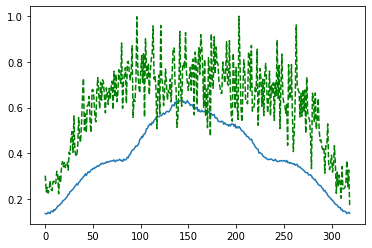

Time taken for epoch:  108.82088351249695
Epoch = [255/3000]  Iter = [   0/39480]  Loss = 0.1376 Avg Loss = 0.1376  Time = 0.1170s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [255/3000]  Iter = [ 100/39480]  Loss = 0.156 Avg Loss = 0.1401  Time = 0.0117s
Epoch = [255/3000]  Iter = [ 200/39480]  Loss = 0.1426 Avg Loss = 0.1411  Time = 0.0018s
Epoch = [255/3000]  Iter = [ 300/39480]  Loss = 0.1521 Avg Loss = 0.1421  Time = 0.0019s
Epoch = [255/3000]  Iter = [ 400/39480]  Loss = 0.129 Avg Loss = 0.1399  Time = 0.0018s
Epoch = [255/3000]  Iter = [ 500/39480]  Loss = 0.1342 Avg Loss = 0.1404  Time = 0.0019s
Epoch = [255/3000]  Iter = [ 600/39480]  Loss = 0.1359 Avg Loss = 0.141  Time = 0.0020s
Epoch = [255/3000]  Iter = [ 700/39480]  Loss = 0.1311 Avg Loss = 0.1395  Time = 0.0019s
Epoch = [255/3000]  Iter = [ 800/39480]  Loss = 0.1186 Avg Loss = 0.1406  Time = 0.0019s
Epoch = [255/3000]  Iter = [ 900/39480]  Loss = 0.152 Avg Loss = 0.1403  Time = 0.0019s
Epoch = [255/3000]  Iter = [1000/39480]  Loss = 0.1451 Avg Loss = 0.141  Time = 0.0018s
Epoch = [255/3000]  Iter = [1100/39480]  Loss = 0.1459 Avg Loss = 0.1408  Time = 0.0019s
Epoch = [255/3000]  Iter =

Epoch = [255/3000]  Iter = [9400/39480]  Loss = 0.1391 Avg Loss = 0.1407  Time = 0.0023s
Epoch = [255/3000]  Iter = [9500/39480]  Loss = 0.132 Avg Loss = 0.1403  Time = 0.0017s
Epoch = [255/3000]  Iter = [9600/39480]  Loss = 0.1661 Avg Loss = 0.1412  Time = 0.0018s
Epoch = [255/3000]  Iter = [9700/39480]  Loss = 0.136 Avg Loss = 0.1421  Time = 0.0018s
Epoch = [255/3000]  Iter = [9800/39480]  Loss = 0.1496 Avg Loss = 0.1411  Time = 0.0018s
Epoch = [255/3000]  Iter = [9900/39480]  Loss = 0.1416 Avg Loss = 0.1409  Time = 0.0019s
Epoch = [255/3000]  Iter = [10000/39480]  Loss = 0.1518 Avg Loss = 0.1408  Time = 0.0019s
Epoch = [255/3000]  Iter = [10100/39480]  Loss = 0.1323 Avg Loss = 0.1407  Time = 0.0019s
Epoch = [255/3000]  Iter = [10200/39480]  Loss = 0.1394 Avg Loss = 0.1391  Time = 0.0018s
Epoch = [255/3000]  Iter = [10300/39480]  Loss = 0.1545 Avg Loss = 0.141  Time = 0.0018s
Epoch = [255/3000]  Iter = [10400/39480]  Loss = 0.1483 Avg Loss = 0.1395  Time = 0.0018s
Epoch = [255/3000] 

Epoch = [255/3000]  Iter = [18600/39480]  Loss = 0.1418 Avg Loss = 0.1404  Time = 0.0019s
Epoch = [255/3000]  Iter = [18700/39480]  Loss = 0.1427 Avg Loss = 0.1407  Time = 0.0018s
Epoch = [255/3000]  Iter = [18800/39480]  Loss = 0.1367 Avg Loss = 0.1404  Time = 0.0018s
Epoch = [255/3000]  Iter = [18900/39480]  Loss = 0.1407 Avg Loss = 0.1419  Time = 0.0019s
Epoch = [255/3000]  Iter = [19000/39480]  Loss = 0.1142 Avg Loss = 0.1421  Time = 0.0018s
Epoch = [255/3000]  Iter = [19100/39480]  Loss = 0.1397 Avg Loss = 0.1416  Time = 0.0019s
Epoch = [255/3000]  Iter = [19200/39480]  Loss = 0.1329 Avg Loss = 0.1413  Time = 0.0018s
Epoch = [255/3000]  Iter = [19300/39480]  Loss = 0.1435 Avg Loss = 0.1415  Time = 0.0018s
Epoch = [255/3000]  Iter = [19400/39480]  Loss = 0.1526 Avg Loss = 0.1401  Time = 0.0019s
Epoch = [255/3000]  Iter = [19500/39480]  Loss = 0.1657 Avg Loss = 0.1409  Time = 0.0018s
Epoch = [255/3000]  Iter = [19600/39480]  Loss = 0.1409 Avg Loss = 0.1413  Time = 0.0018s
Epoch = [2

Epoch = [255/3000]  Iter = [27900/39480]  Loss = 0.1402 Avg Loss = 0.1415  Time = 0.0019s
Epoch = [255/3000]  Iter = [28000/39480]  Loss = 0.1449 Avg Loss = 0.1412  Time = 0.0026s
Epoch = [255/3000]  Iter = [28100/39480]  Loss = 0.1289 Avg Loss = 0.1421  Time = 0.0019s
Epoch = [255/3000]  Iter = [28200/39480]  Loss = 0.124 Avg Loss = 0.1408  Time = 0.0019s
Epoch = [255/3000]  Iter = [28300/39480]  Loss = 0.1509 Avg Loss = 0.1408  Time = 0.0019s
Epoch = [255/3000]  Iter = [28400/39480]  Loss = 0.1704 Avg Loss = 0.1424  Time = 0.0018s
Epoch = [255/3000]  Iter = [28500/39480]  Loss = 0.1478 Avg Loss = 0.1423  Time = 0.0019s
Epoch = [255/3000]  Iter = [28600/39480]  Loss = 0.1624 Avg Loss = 0.1423  Time = 0.0018s
Epoch = [255/3000]  Iter = [28700/39480]  Loss = 0.1332 Avg Loss = 0.1414  Time = 0.0019s
Epoch = [255/3000]  Iter = [28800/39480]  Loss = 0.1336 Avg Loss = 0.1416  Time = 0.0019s
Epoch = [255/3000]  Iter = [28900/39480]  Loss = 0.1357 Avg Loss = 0.1421  Time = 0.0019s
Epoch = [25

Epoch = [255/3000]  Iter = [37100/39480]  Loss = 0.1216 Avg Loss = 0.1405  Time = 0.0018s
Epoch = [255/3000]  Iter = [37200/39480]  Loss = 0.1184 Avg Loss = 0.1424  Time = 0.0018s
Epoch = [255/3000]  Iter = [37300/39480]  Loss = 0.1486 Avg Loss = 0.1411  Time = 0.0018s
Epoch = [255/3000]  Iter = [37400/39480]  Loss = 0.1505 Avg Loss = 0.1411  Time = 0.0018s
Epoch = [255/3000]  Iter = [37500/39480]  Loss = 0.1433 Avg Loss = 0.1431  Time = 0.0018s
Epoch = [255/3000]  Iter = [37600/39480]  Loss = 0.1314 Avg Loss = 0.1434  Time = 0.0018s
Epoch = [255/3000]  Iter = [37700/39480]  Loss = 0.1295 Avg Loss = 0.1439  Time = 0.0018s
Epoch = [255/3000]  Iter = [37800/39480]  Loss = 0.1499 Avg Loss = 0.1414  Time = 0.0018s
Epoch = [255/3000]  Iter = [37900/39480]  Loss = 0.1334 Avg Loss = 0.1404  Time = 0.0018s
Epoch = [255/3000]  Iter = [38000/39480]  Loss = 0.1282 Avg Loss = 0.142  Time = 0.0018s
Epoch = [255/3000]  Iter = [38100/39480]  Loss = 0.1393 Avg Loss = 0.1413  Time = 0.0018s
Epoch = [25

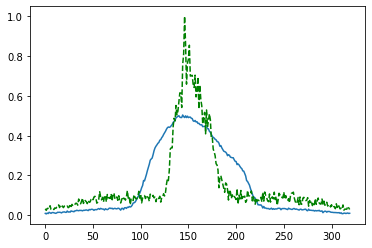

Time taken for epoch:  110.0747721195221
Epoch = [256/3000]  Iter = [   0/39480]  Loss = 0.1257 Avg Loss = 0.1257  Time = 0.1392s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [256/3000]  Iter = [ 100/39480]  Loss = 0.1504 Avg Loss = 0.1347  Time = 0.0019s
Epoch = [256/3000]  Iter = [ 200/39480]  Loss = 0.1374 Avg Loss = 0.1372  Time = 0.0119s
Epoch = [256/3000]  Iter = [ 300/39480]  Loss = 0.1245 Avg Loss = 0.137  Time = 0.0018s
Epoch = [256/3000]  Iter = [ 400/39480]  Loss = 0.1415 Avg Loss = 0.1384  Time = 0.0118s
Epoch = [256/3000]  Iter = [ 500/39480]  Loss = 0.1131 Avg Loss = 0.1387  Time = 0.0018s
Epoch = [256/3000]  Iter = [ 600/39480]  Loss = 0.1474 Avg Loss = 0.1396  Time = 0.0019s
Epoch = [256/3000]  Iter = [ 700/39480]  Loss = 0.1422 Avg Loss = 0.1399  Time = 0.0019s
Epoch = [256/3000]  Iter = [ 800/39480]  Loss = 0.1397 Avg Loss = 0.1394  Time = 0.0019s
Epoch = [256/3000]  Iter = [ 900/39480]  Loss = 0.1448 Avg Loss = 0.1405  Time = 0.0018s
Epoch = [256/3000]  Iter = [1000/39480]  Loss = 0.1259 Avg Loss = 0.1409  Time = 0.0018s
Epoch = [256/3000]  Iter = [1100/39480]  Loss = 0.1476 Avg Loss = 0.1406  Time = 0.0019s
Epoch = [256/3000]  It

Epoch = [256/3000]  Iter = [9400/39480]  Loss = 0.1176 Avg Loss = 0.1413  Time = 0.0018s
Epoch = [256/3000]  Iter = [9500/39480]  Loss = 0.1554 Avg Loss = 0.1403  Time = 0.0018s
Epoch = [256/3000]  Iter = [9600/39480]  Loss = 0.1281 Avg Loss = 0.1427  Time = 0.0018s
Epoch = [256/3000]  Iter = [9700/39480]  Loss = 0.1505 Avg Loss = 0.142  Time = 0.0018s
Epoch = [256/3000]  Iter = [9800/39480]  Loss = 0.1307 Avg Loss = 0.1399  Time = 0.0018s
Epoch = [256/3000]  Iter = [9900/39480]  Loss = 0.1308 Avg Loss = 0.1412  Time = 0.0018s
Epoch = [256/3000]  Iter = [10000/39480]  Loss = 0.1487 Avg Loss = 0.1419  Time = 0.0018s
Epoch = [256/3000]  Iter = [10100/39480]  Loss = 0.1215 Avg Loss = 0.141  Time = 0.0018s
Epoch = [256/3000]  Iter = [10200/39480]  Loss = 0.1453 Avg Loss = 0.1411  Time = 0.0018s
Epoch = [256/3000]  Iter = [10300/39480]  Loss = 0.1495 Avg Loss = 0.1397  Time = 0.0018s
Epoch = [256/3000]  Iter = [10400/39480]  Loss = 0.1495 Avg Loss = 0.1401  Time = 0.0018s
Epoch = [256/3000]

Epoch = [256/3000]  Iter = [18600/39480]  Loss = 0.1474 Avg Loss = 0.1415  Time = 0.0018s
Epoch = [256/3000]  Iter = [18700/39480]  Loss = 0.1581 Avg Loss = 0.1422  Time = 0.0020s
Epoch = [256/3000]  Iter = [18800/39480]  Loss = 0.162 Avg Loss = 0.1399  Time = 0.0018s
Epoch = [256/3000]  Iter = [18900/39480]  Loss = 0.1491 Avg Loss = 0.1402  Time = 0.0018s
Epoch = [256/3000]  Iter = [19000/39480]  Loss = 0.1249 Avg Loss = 0.1412  Time = 0.0018s
Epoch = [256/3000]  Iter = [19100/39480]  Loss = 0.1466 Avg Loss = 0.1417  Time = 0.0018s
Epoch = [256/3000]  Iter = [19200/39480]  Loss = 0.1508 Avg Loss = 0.1415  Time = 0.0018s
Epoch = [256/3000]  Iter = [19300/39480]  Loss = 0.1524 Avg Loss = 0.1411  Time = 0.0019s
Epoch = [256/3000]  Iter = [19400/39480]  Loss = 0.1239 Avg Loss = 0.1419  Time = 0.0018s
Epoch = [256/3000]  Iter = [19500/39480]  Loss = 0.1425 Avg Loss = 0.1409  Time = 0.0019s
Epoch = [256/3000]  Iter = [19600/39480]  Loss = 0.1339 Avg Loss = 0.1407  Time = 0.0018s
Epoch = [25

Epoch = [256/3000]  Iter = [27900/39480]  Loss = 0.1521 Avg Loss = 0.1416  Time = 0.0018s
Epoch = [256/3000]  Iter = [28000/39480]  Loss = 0.1174 Avg Loss = 0.1403  Time = 0.0018s
Epoch = [256/3000]  Iter = [28100/39480]  Loss = 0.1568 Avg Loss = 0.1409  Time = 0.0018s
Epoch = [256/3000]  Iter = [28200/39480]  Loss = 0.1603 Avg Loss = 0.1413  Time = 0.0018s
Epoch = [256/3000]  Iter = [28300/39480]  Loss = 0.1396 Avg Loss = 0.1411  Time = 0.0018s
Epoch = [256/3000]  Iter = [28400/39480]  Loss = 0.1248 Avg Loss = 0.1394  Time = 0.0018s
Epoch = [256/3000]  Iter = [28500/39480]  Loss = 0.1536 Avg Loss = 0.1393  Time = 0.0018s
Epoch = [256/3000]  Iter = [28600/39480]  Loss = 0.1439 Avg Loss = 0.1423  Time = 0.0018s
Epoch = [256/3000]  Iter = [28700/39480]  Loss = 0.132 Avg Loss = 0.1428  Time = 0.0018s
Epoch = [256/3000]  Iter = [28800/39480]  Loss = 0.1361 Avg Loss = 0.1435  Time = 0.0018s
Epoch = [256/3000]  Iter = [28900/39480]  Loss = 0.1255 Avg Loss = 0.1407  Time = 0.0018s
Epoch = [25

Epoch = [256/3000]  Iter = [37100/39480]  Loss = 0.1249 Avg Loss = 0.1422  Time = 0.0018s
Epoch = [256/3000]  Iter = [37200/39480]  Loss = 0.1532 Avg Loss = 0.1429  Time = 0.0018s
Epoch = [256/3000]  Iter = [37300/39480]  Loss = 0.1639 Avg Loss = 0.142  Time = 0.0018s
Epoch = [256/3000]  Iter = [37400/39480]  Loss = 0.1521 Avg Loss = 0.1413  Time = 0.0018s
Epoch = [256/3000]  Iter = [37500/39480]  Loss = 0.1631 Avg Loss = 0.1418  Time = 0.0018s
Epoch = [256/3000]  Iter = [37600/39480]  Loss = 0.1625 Avg Loss = 0.1414  Time = 0.0018s
Epoch = [256/3000]  Iter = [37700/39480]  Loss = 0.1439 Avg Loss = 0.1417  Time = 0.0019s
Epoch = [256/3000]  Iter = [37800/39480]  Loss = 0.1508 Avg Loss = 0.1424  Time = 0.0018s
Epoch = [256/3000]  Iter = [37900/39480]  Loss = 0.1557 Avg Loss = 0.1429  Time = 0.0018s
Epoch = [256/3000]  Iter = [38000/39480]  Loss = 0.1373 Avg Loss = 0.1407  Time = 0.0018s
Epoch = [256/3000]  Iter = [38100/39480]  Loss = 0.1566 Avg Loss = 0.1418  Time = 0.0018s
Epoch = [25

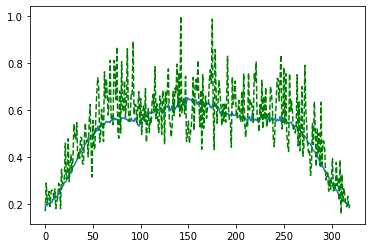

Time taken for epoch:  105.566232919693
Epoch = [257/3000]  Iter = [   0/39480]  Loss = 0.1305 Avg Loss = 0.1305  Time = 0.0892s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [257/3000]  Iter = [ 100/39480]  Loss = 0.1719 Avg Loss = 0.1366  Time = 0.0019s
Epoch = [257/3000]  Iter = [ 200/39480]  Loss = 0.1361 Avg Loss = 0.139  Time = 0.0019s
Epoch = [257/3000]  Iter = [ 300/39480]  Loss = 0.1499 Avg Loss = 0.1404  Time = 0.0019s
Epoch = [257/3000]  Iter = [ 400/39480]  Loss = 0.1432 Avg Loss = 0.1415  Time = 0.0019s
Epoch = [257/3000]  Iter = [ 500/39480]  Loss = 0.1434 Avg Loss = 0.141  Time = 0.0019s
Epoch = [257/3000]  Iter = [ 600/39480]  Loss = 0.1408 Avg Loss = 0.14  Time = 0.0019s
Epoch = [257/3000]  Iter = [ 700/39480]  Loss = 0.1432 Avg Loss = 0.1407  Time = 0.0019s
Epoch = [257/3000]  Iter = [ 800/39480]  Loss = 0.1429 Avg Loss = 0.1407  Time = 0.0018s
Epoch = [257/3000]  Iter = [ 900/39480]  Loss = 0.1209 Avg Loss = 0.1419  Time = 0.0017s
Epoch = [257/3000]  Iter = [1000/39480]  Loss = 0.1401 Avg Loss = 0.1413  Time = 0.0019s
Epoch = [257/3000]  Iter = [1100/39480]  Loss = 0.133 Avg Loss = 0.1409  Time = 0.0018s
Epoch = [257/3000]  Iter =

Epoch = [257/3000]  Iter = [9400/39480]  Loss = 0.1429 Avg Loss = 0.14  Time = 0.0018s
Epoch = [257/3000]  Iter = [9500/39480]  Loss = 0.1276 Avg Loss = 0.1413  Time = 0.0018s
Epoch = [257/3000]  Iter = [9600/39480]  Loss = 0.1451 Avg Loss = 0.14  Time = 0.0018s
Epoch = [257/3000]  Iter = [9700/39480]  Loss = 0.1186 Avg Loss = 0.1403  Time = 0.0018s
Epoch = [257/3000]  Iter = [9800/39480]  Loss = 0.1572 Avg Loss = 0.1414  Time = 0.0018s
Epoch = [257/3000]  Iter = [9900/39480]  Loss = 0.1518 Avg Loss = 0.1426  Time = 0.0018s
Epoch = [257/3000]  Iter = [10000/39480]  Loss = 0.1426 Avg Loss = 0.1426  Time = 0.0018s
Epoch = [257/3000]  Iter = [10100/39480]  Loss = 0.1599 Avg Loss = 0.1406  Time = 0.0018s
Epoch = [257/3000]  Iter = [10200/39480]  Loss = 0.1374 Avg Loss = 0.1414  Time = 0.0018s
Epoch = [257/3000]  Iter = [10300/39480]  Loss = 0.1325 Avg Loss = 0.1415  Time = 0.0018s
Epoch = [257/3000]  Iter = [10400/39480]  Loss = 0.1281 Avg Loss = 0.1404  Time = 0.0018s
Epoch = [257/3000]  

Epoch = [257/3000]  Iter = [18600/39480]  Loss = 0.1222 Avg Loss = 0.1408  Time = 0.0048s
Epoch = [257/3000]  Iter = [18700/39480]  Loss = 0.1291 Avg Loss = 0.1419  Time = 0.0019s
Epoch = [257/3000]  Iter = [18800/39480]  Loss = 0.1508 Avg Loss = 0.1421  Time = 0.0019s
Epoch = [257/3000]  Iter = [18900/39480]  Loss = 0.1307 Avg Loss = 0.1405  Time = 0.0027s
Epoch = [257/3000]  Iter = [19000/39480]  Loss = 0.1252 Avg Loss = 0.1418  Time = 0.0037s
Epoch = [257/3000]  Iter = [19100/39480]  Loss = 0.1565 Avg Loss = 0.1409  Time = 0.0019s
Epoch = [257/3000]  Iter = [19200/39480]  Loss = 0.1435 Avg Loss = 0.1409  Time = 0.0019s
Epoch = [257/3000]  Iter = [19300/39480]  Loss = 0.1155 Avg Loss = 0.1404  Time = 0.0022s
Epoch = [257/3000]  Iter = [19400/39480]  Loss = 0.1244 Avg Loss = 0.1406  Time = 0.0019s
Epoch = [257/3000]  Iter = [19500/39480]  Loss = 0.1202 Avg Loss = 0.1403  Time = 0.0019s
Epoch = [257/3000]  Iter = [19600/39480]  Loss = 0.1251 Avg Loss = 0.1408  Time = 0.0023s
Epoch = [2

Epoch = [257/3000]  Iter = [27900/39480]  Loss = 0.1397 Avg Loss = 0.1403  Time = 0.0019s
Epoch = [257/3000]  Iter = [28000/39480]  Loss = 0.1289 Avg Loss = 0.1413  Time = 0.0019s
Epoch = [257/3000]  Iter = [28100/39480]  Loss = 0.127 Avg Loss = 0.1407  Time = 0.0019s
Epoch = [257/3000]  Iter = [28200/39480]  Loss = 0.1595 Avg Loss = 0.1419  Time = 0.0018s
Epoch = [257/3000]  Iter = [28300/39480]  Loss = 0.1163 Avg Loss = 0.1413  Time = 0.0019s
Epoch = [257/3000]  Iter = [28400/39480]  Loss = 0.1345 Avg Loss = 0.1415  Time = 0.0018s
Epoch = [257/3000]  Iter = [28500/39480]  Loss = 0.1339 Avg Loss = 0.141  Time = 0.0019s
Epoch = [257/3000]  Iter = [28600/39480]  Loss = 0.1378 Avg Loss = 0.142  Time = 0.0019s
Epoch = [257/3000]  Iter = [28700/39480]  Loss = 0.1213 Avg Loss = 0.1416  Time = 0.0023s
Epoch = [257/3000]  Iter = [28800/39480]  Loss = 0.1485 Avg Loss = 0.1415  Time = 0.0018s
Epoch = [257/3000]  Iter = [28900/39480]  Loss = 0.1402 Avg Loss = 0.1399  Time = 0.0018s
Epoch = [257/

Epoch = [257/3000]  Iter = [37100/39480]  Loss = 0.1402 Avg Loss = 0.1411  Time = 0.0018s
Epoch = [257/3000]  Iter = [37200/39480]  Loss = 0.1617 Avg Loss = 0.1396  Time = 0.0018s
Epoch = [257/3000]  Iter = [37300/39480]  Loss = 0.1432 Avg Loss = 0.1409  Time = 0.0018s
Epoch = [257/3000]  Iter = [37400/39480]  Loss = 0.1268 Avg Loss = 0.1413  Time = 0.0018s
Epoch = [257/3000]  Iter = [37500/39480]  Loss = 0.1551 Avg Loss = 0.1423  Time = 0.0018s
Epoch = [257/3000]  Iter = [37600/39480]  Loss = 0.1501 Avg Loss = 0.1422  Time = 0.0018s
Epoch = [257/3000]  Iter = [37700/39480]  Loss = 0.1281 Avg Loss = 0.141  Time = 0.0019s
Epoch = [257/3000]  Iter = [37800/39480]  Loss = 0.1481 Avg Loss = 0.1418  Time = 0.0018s
Epoch = [257/3000]  Iter = [37900/39480]  Loss = 0.1266 Avg Loss = 0.1425  Time = 0.0018s
Epoch = [257/3000]  Iter = [38000/39480]  Loss = 0.1651 Avg Loss = 0.1429  Time = 0.0018s
Epoch = [257/3000]  Iter = [38100/39480]  Loss = 0.1368 Avg Loss = 0.1418  Time = 0.0019s
Epoch = [25

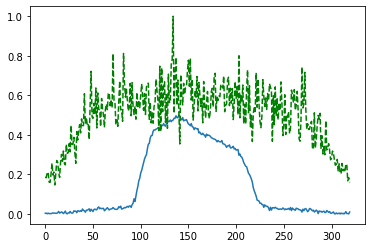

Time taken for epoch:  104.89787077903748
Epoch = [258/3000]  Iter = [   0/39480]  Loss = 0.1604 Avg Loss = 0.1604  Time = 0.1793s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [258/3000]  Iter = [ 100/39480]  Loss = 0.1635 Avg Loss = 0.1471  Time = 0.0019s
Epoch = [258/3000]  Iter = [ 200/39480]  Loss = 0.157 Avg Loss = 0.1433  Time = 0.0019s
Epoch = [258/3000]  Iter = [ 300/39480]  Loss = 0.1315 Avg Loss = 0.1402  Time = 0.0019s
Epoch = [258/3000]  Iter = [ 400/39480]  Loss = 0.1408 Avg Loss = 0.1392  Time = 0.0019s
Epoch = [258/3000]  Iter = [ 500/39480]  Loss = 0.1419 Avg Loss = 0.139  Time = 0.0019s
Epoch = [258/3000]  Iter = [ 600/39480]  Loss = 0.1328 Avg Loss = 0.1396  Time = 0.0019s
Epoch = [258/3000]  Iter = [ 700/39480]  Loss = 0.163 Avg Loss = 0.1409  Time = 0.0019s
Epoch = [258/3000]  Iter = [ 800/39480]  Loss = 0.1226 Avg Loss = 0.1411  Time = 0.0018s
Epoch = [258/3000]  Iter = [ 900/39480]  Loss = 0.149 Avg Loss = 0.1416  Time = 0.0019s
Epoch = [258/3000]  Iter = [1000/39480]  Loss = 0.1328 Avg Loss = 0.1409  Time = 0.0019s
Epoch = [258/3000]  Iter = [1100/39480]  Loss = 0.1355 Avg Loss = 0.1396  Time = 0.0020s
Epoch = [258/3000]  Iter 

Epoch = [258/3000]  Iter = [9500/39480]  Loss = 0.1386 Avg Loss = 0.1394  Time = 0.0019s
Epoch = [258/3000]  Iter = [9600/39480]  Loss = 0.1408 Avg Loss = 0.1399  Time = 0.0019s
Epoch = [258/3000]  Iter = [9700/39480]  Loss = 0.1507 Avg Loss = 0.1402  Time = 0.0019s
Epoch = [258/3000]  Iter = [9800/39480]  Loss = 0.1647 Avg Loss = 0.1414  Time = 0.0018s
Epoch = [258/3000]  Iter = [9900/39480]  Loss = 0.1393 Avg Loss = 0.1392  Time = 0.0019s
Epoch = [258/3000]  Iter = [10000/39480]  Loss = 0.1359 Avg Loss = 0.1419  Time = 0.0018s
Epoch = [258/3000]  Iter = [10100/39480]  Loss = 0.1449 Avg Loss = 0.1399  Time = 0.0018s
Epoch = [258/3000]  Iter = [10200/39480]  Loss = 0.1466 Avg Loss = 0.1396  Time = 0.0018s
Epoch = [258/3000]  Iter = [10300/39480]  Loss = 0.1452 Avg Loss = 0.1401  Time = 0.0018s
Epoch = [258/3000]  Iter = [10400/39480]  Loss = 0.1431 Avg Loss = 0.1415  Time = 0.0019s
Epoch = [258/3000]  Iter = [10500/39480]  Loss = 0.138 Avg Loss = 0.1413  Time = 0.0018s
Epoch = [258/300

Epoch = [258/3000]  Iter = [18700/39480]  Loss = 0.1654 Avg Loss = 0.1411  Time = 0.0018s
Epoch = [258/3000]  Iter = [18800/39480]  Loss = 0.1411 Avg Loss = 0.1425  Time = 0.0018s
Epoch = [258/3000]  Iter = [18900/39480]  Loss = 0.1366 Avg Loss = 0.1431  Time = 0.0018s
Epoch = [258/3000]  Iter = [19000/39480]  Loss = 0.128 Avg Loss = 0.1412  Time = 0.0018s
Epoch = [258/3000]  Iter = [19100/39480]  Loss = 0.1421 Avg Loss = 0.1423  Time = 0.0018s
Epoch = [258/3000]  Iter = [19200/39480]  Loss = 0.1722 Avg Loss = 0.1408  Time = 0.0018s
Epoch = [258/3000]  Iter = [19300/39480]  Loss = 0.1374 Avg Loss = 0.1407  Time = 0.0018s
Epoch = [258/3000]  Iter = [19400/39480]  Loss = 0.1485 Avg Loss = 0.1388  Time = 0.0027s
Epoch = [258/3000]  Iter = [19500/39480]  Loss = 0.1519 Avg Loss = 0.1398  Time = 0.0018s
Epoch = [258/3000]  Iter = [19600/39480]  Loss = 0.1478 Avg Loss = 0.1408  Time = 0.0018s
Epoch = [258/3000]  Iter = [19700/39480]  Loss = 0.1118 Avg Loss = 0.14  Time = 0.0018s
Epoch = [258/

Epoch = [258/3000]  Iter = [27900/39480]  Loss = 0.147 Avg Loss = 0.1417  Time = 0.0019s
Epoch = [258/3000]  Iter = [28000/39480]  Loss = 0.1437 Avg Loss = 0.1423  Time = 0.0018s
Epoch = [258/3000]  Iter = [28100/39480]  Loss = 0.1295 Avg Loss = 0.141  Time = 0.0022s
Epoch = [258/3000]  Iter = [28200/39480]  Loss = 0.1287 Avg Loss = 0.1397  Time = 0.0018s
Epoch = [258/3000]  Iter = [28300/39480]  Loss = 0.1229 Avg Loss = 0.1392  Time = 0.0143s
Epoch = [258/3000]  Iter = [28400/39480]  Loss = 0.1393 Avg Loss = 0.1409  Time = 0.0017s
Epoch = [258/3000]  Iter = [28500/39480]  Loss = 0.1496 Avg Loss = 0.1397  Time = 0.0018s
Epoch = [258/3000]  Iter = [28600/39480]  Loss = 0.1383 Avg Loss = 0.1423  Time = 0.0018s
Epoch = [258/3000]  Iter = [28700/39480]  Loss = 0.1524 Avg Loss = 0.1419  Time = 0.0018s
Epoch = [258/3000]  Iter = [28800/39480]  Loss = 0.1631 Avg Loss = 0.1422  Time = 0.0018s
Epoch = [258/3000]  Iter = [28900/39480]  Loss = 0.1356 Avg Loss = 0.1405  Time = 0.0019s
Epoch = [258

Epoch = [258/3000]  Iter = [37200/39480]  Loss = 0.1364 Avg Loss = 0.1419  Time = 0.0019s
Epoch = [258/3000]  Iter = [37300/39480]  Loss = 0.126 Avg Loss = 0.1432  Time = 0.0018s
Epoch = [258/3000]  Iter = [37400/39480]  Loss = 0.1598 Avg Loss = 0.1437  Time = 0.0019s
Epoch = [258/3000]  Iter = [37500/39480]  Loss = 0.148 Avg Loss = 0.1436  Time = 0.0018s
Epoch = [258/3000]  Iter = [37600/39480]  Loss = 0.1451 Avg Loss = 0.1434  Time = 0.0018s
Epoch = [258/3000]  Iter = [37700/39480]  Loss = 0.1345 Avg Loss = 0.1419  Time = 0.0019s
Epoch = [258/3000]  Iter = [37800/39480]  Loss = 0.1496 Avg Loss = 0.143  Time = 0.0019s
Epoch = [258/3000]  Iter = [37900/39480]  Loss = 0.1248 Avg Loss = 0.1414  Time = 0.0018s
Epoch = [258/3000]  Iter = [38000/39480]  Loss = 0.1279 Avg Loss = 0.1417  Time = 0.0018s
Epoch = [258/3000]  Iter = [38100/39480]  Loss = 0.1374 Avg Loss = 0.1427  Time = 0.0018s
Epoch = [258/3000]  Iter = [38200/39480]  Loss = 0.1377 Avg Loss = 0.1421  Time = 0.0018s
Epoch = [258/

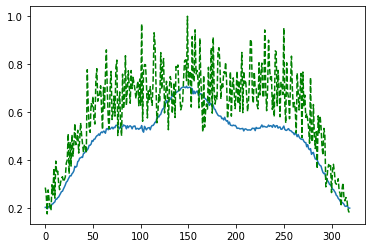

Time taken for epoch:  104.91249227523804
Epoch = [259/3000]  Iter = [   0/39480]  Loss = 0.1335 Avg Loss = 0.1335  Time = 0.1898s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [259/3000]  Iter = [ 100/39480]  Loss = 0.1407 Avg Loss = 0.1382  Time = 0.0024s
Epoch = [259/3000]  Iter = [ 200/39480]  Loss = 0.1366 Avg Loss = 0.1389  Time = 0.0019s
Epoch = [259/3000]  Iter = [ 300/39480]  Loss = 0.1332 Avg Loss = 0.142  Time = 0.0019s
Epoch = [259/3000]  Iter = [ 400/39480]  Loss = 0.1358 Avg Loss = 0.1389  Time = 0.0019s
Epoch = [259/3000]  Iter = [ 500/39480]  Loss = 0.1266 Avg Loss = 0.1388  Time = 0.0019s
Epoch = [259/3000]  Iter = [ 600/39480]  Loss = 0.1384 Avg Loss = 0.1404  Time = 0.0018s
Epoch = [259/3000]  Iter = [ 700/39480]  Loss = 0.1431 Avg Loss = 0.1401  Time = 0.0019s
Epoch = [259/3000]  Iter = [ 800/39480]  Loss = 0.1359 Avg Loss = 0.1397  Time = 0.0018s
Epoch = [259/3000]  Iter = [ 900/39480]  Loss = 0.1158 Avg Loss = 0.1393  Time = 0.0018s
Epoch = [259/3000]  Iter = [1000/39480]  Loss = 0.1325 Avg Loss = 0.1387  Time = 0.0120s
Epoch = [259/3000]  Iter = [1100/39480]  Loss = 0.1499 Avg Loss = 0.1402  Time = 0.0018s
Epoch = [259/3000]  It

Epoch = [259/3000]  Iter = [9400/39480]  Loss = 0.1791 Avg Loss = 0.1413  Time = 0.0019s
Epoch = [259/3000]  Iter = [9500/39480]  Loss = 0.1402 Avg Loss = 0.1412  Time = 0.0023s
Epoch = [259/3000]  Iter = [9600/39480]  Loss = 0.1881 Avg Loss = 0.1414  Time = 0.0019s
Epoch = [259/3000]  Iter = [9700/39480]  Loss = 0.1264 Avg Loss = 0.1418  Time = 0.0019s
Epoch = [259/3000]  Iter = [9800/39480]  Loss = 0.1192 Avg Loss = 0.1394  Time = 0.0044s
Epoch = [259/3000]  Iter = [9900/39480]  Loss = 0.1345 Avg Loss = 0.1394  Time = 0.0018s
Epoch = [259/3000]  Iter = [10000/39480]  Loss = 0.1361 Avg Loss = 0.1405  Time = 0.0019s
Epoch = [259/3000]  Iter = [10100/39480]  Loss = 0.1558 Avg Loss = 0.1404  Time = 0.0019s
Epoch = [259/3000]  Iter = [10200/39480]  Loss = 0.1471 Avg Loss = 0.1422  Time = 0.0019s
Epoch = [259/3000]  Iter = [10300/39480]  Loss = 0.1462 Avg Loss = 0.1411  Time = 0.0019s
Epoch = [259/3000]  Iter = [10400/39480]  Loss = 0.1358 Avg Loss = 0.1408  Time = 0.0019s
Epoch = [259/300

Epoch = [259/3000]  Iter = [18600/39480]  Loss = 0.141 Avg Loss = 0.1406  Time = 0.0018s
Epoch = [259/3000]  Iter = [18700/39480]  Loss = 0.1476 Avg Loss = 0.1414  Time = 0.0109s
Epoch = [259/3000]  Iter = [18800/39480]  Loss = 0.1371 Avg Loss = 0.1401  Time = 0.0096s
Epoch = [259/3000]  Iter = [18900/39480]  Loss = 0.1442 Avg Loss = 0.1406  Time = 0.0037s
Epoch = [259/3000]  Iter = [19000/39480]  Loss = 0.1203 Avg Loss = 0.1413  Time = 0.0018s
Epoch = [259/3000]  Iter = [19100/39480]  Loss = 0.1293 Avg Loss = 0.1413  Time = 0.0018s
Epoch = [259/3000]  Iter = [19200/39480]  Loss = 0.1337 Avg Loss = 0.1422  Time = 0.0018s
Epoch = [259/3000]  Iter = [19300/39480]  Loss = 0.1621 Avg Loss = 0.1408  Time = 0.0018s
Epoch = [259/3000]  Iter = [19400/39480]  Loss = 0.1748 Avg Loss = 0.1414  Time = 0.0018s
Epoch = [259/3000]  Iter = [19500/39480]  Loss = 0.1349 Avg Loss = 0.1425  Time = 0.0018s
Epoch = [259/3000]  Iter = [19600/39480]  Loss = 0.1552 Avg Loss = 0.1416  Time = 0.0019s
Epoch = [25

Epoch = [259/3000]  Iter = [27900/39480]  Loss = 0.1367 Avg Loss = 0.1403  Time = 0.0032s
Epoch = [259/3000]  Iter = [28000/39480]  Loss = 0.138 Avg Loss = 0.1414  Time = 0.0019s
Epoch = [259/3000]  Iter = [28100/39480]  Loss = 0.1231 Avg Loss = 0.141  Time = 0.0018s
Epoch = [259/3000]  Iter = [28200/39480]  Loss = 0.1397 Avg Loss = 0.1414  Time = 0.0018s
Epoch = [259/3000]  Iter = [28300/39480]  Loss = 0.1356 Avg Loss = 0.1416  Time = 0.0018s
Epoch = [259/3000]  Iter = [28400/39480]  Loss = 0.1455 Avg Loss = 0.1409  Time = 0.0018s
Epoch = [259/3000]  Iter = [28500/39480]  Loss = 0.1463 Avg Loss = 0.1407  Time = 0.0018s
Epoch = [259/3000]  Iter = [28600/39480]  Loss = 0.1524 Avg Loss = 0.1406  Time = 0.0018s
Epoch = [259/3000]  Iter = [28700/39480]  Loss = 0.1386 Avg Loss = 0.142  Time = 0.0124s
Epoch = [259/3000]  Iter = [28800/39480]  Loss = 0.1279 Avg Loss = 0.1416  Time = 0.0018s
Epoch = [259/3000]  Iter = [28900/39480]  Loss = 0.1493 Avg Loss = 0.1419  Time = 0.0018s
Epoch = [259/

Epoch = [259/3000]  Iter = [37200/39480]  Loss = 0.1803 Avg Loss = 0.1422  Time = 0.0019s
Epoch = [259/3000]  Iter = [37300/39480]  Loss = 0.1344 Avg Loss = 0.1419  Time = 0.0018s
Epoch = [259/3000]  Iter = [37400/39480]  Loss = 0.136 Avg Loss = 0.1409  Time = 0.0018s
Epoch = [259/3000]  Iter = [37500/39480]  Loss = 0.158 Avg Loss = 0.1414  Time = 0.0019s
Epoch = [259/3000]  Iter = [37600/39480]  Loss = 0.1333 Avg Loss = 0.1422  Time = 0.0018s
Epoch = [259/3000]  Iter = [37700/39480]  Loss = 0.1571 Avg Loss = 0.1426  Time = 0.0019s
Epoch = [259/3000]  Iter = [37800/39480]  Loss = 0.1388 Avg Loss = 0.1428  Time = 0.0019s
Epoch = [259/3000]  Iter = [37900/39480]  Loss = 0.1533 Avg Loss = 0.143  Time = 0.0018s
Epoch = [259/3000]  Iter = [38000/39480]  Loss = 0.1462 Avg Loss = 0.143  Time = 0.0018s
Epoch = [259/3000]  Iter = [38100/39480]  Loss = 0.1491 Avg Loss = 0.1408  Time = 0.0018s
Epoch = [259/3000]  Iter = [38200/39480]  Loss = 0.1119 Avg Loss = 0.1412  Time = 0.0018s
Epoch = [259/3

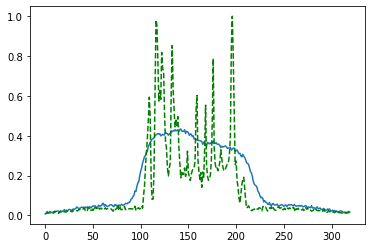

Time taken for epoch:  108.11487913131714
Epoch = [260/3000]  Iter = [   0/39480]  Loss = 0.1247 Avg Loss = 0.1247  Time = 0.1121s


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch = [260/3000]  Iter = [ 100/39480]  Loss = 0.1182 Avg Loss = 0.1343  Time = 0.0019s
Epoch = [260/3000]  Iter = [ 200/39480]  Loss = 0.1276 Avg Loss = 0.1376  Time = 0.0019s
Epoch = [260/3000]  Iter = [ 300/39480]  Loss = 0.1279 Avg Loss = 0.1388  Time = 0.0019s
Epoch = [260/3000]  Iter = [ 400/39480]  Loss = 0.1125 Avg Loss = 0.1386  Time = 0.0018s
Epoch = [260/3000]  Iter = [ 500/39480]  Loss = 0.1271 Avg Loss = 0.1393  Time = 0.0019s
Epoch = [260/3000]  Iter = [ 600/39480]  Loss = 0.1157 Avg Loss = 0.1394  Time = 0.0018s
Epoch = [260/3000]  Iter = [ 700/39480]  Loss = 0.1733 Avg Loss = 0.1387  Time = 0.0018s
Epoch = [260/3000]  Iter = [ 800/39480]  Loss = 0.1305 Avg Loss = 0.1403  Time = 0.0019s
Epoch = [260/3000]  Iter = [ 900/39480]  Loss = 0.1413 Avg Loss = 0.1397  Time = 0.0019s
Epoch = [260/3000]  Iter = [1000/39480]  Loss = 0.1501 Avg Loss = 0.1402  Time = 0.0020s
Epoch = [260/3000]  Iter = [1100/39480]  Loss = 0.1421 Avg Loss = 0.1404  Time = 0.0018s
Epoch = [260/3000]  I

Epoch = [260/3000]  Iter = [9400/39480]  Loss = 0.1461 Avg Loss = 0.141  Time = 0.0018s
Epoch = [260/3000]  Iter = [9500/39480]  Loss = 0.1569 Avg Loss = 0.1405  Time = 0.0018s
Epoch = [260/3000]  Iter = [9600/39480]  Loss = 0.1581 Avg Loss = 0.1405  Time = 0.0018s
Epoch = [260/3000]  Iter = [9700/39480]  Loss = 0.1343 Avg Loss = 0.142  Time = 0.0018s
Epoch = [260/3000]  Iter = [9800/39480]  Loss = 0.1346 Avg Loss = 0.1411  Time = 0.0018s
Epoch = [260/3000]  Iter = [9900/39480]  Loss = 0.1495 Avg Loss = 0.1408  Time = 0.0018s
Epoch = [260/3000]  Iter = [10000/39480]  Loss = 0.1378 Avg Loss = 0.1408  Time = 0.0019s
Epoch = [260/3000]  Iter = [10100/39480]  Loss = 0.1482 Avg Loss = 0.14  Time = 0.0019s
Epoch = [260/3000]  Iter = [10200/39480]  Loss = 0.1565 Avg Loss = 0.1405  Time = 0.0018s
Epoch = [260/3000]  Iter = [10300/39480]  Loss = 0.1408 Avg Loss = 0.1411  Time = 0.0019s
Epoch = [260/3000]  Iter = [10400/39480]  Loss = 0.1264 Avg Loss = 0.1412  Time = 0.0018s
Epoch = [260/3000]  

Epoch = [260/3000]  Iter = [18600/39480]  Loss = 0.1301 Avg Loss = 0.1406  Time = 0.0022s
Epoch = [260/3000]  Iter = [18700/39480]  Loss = 0.1307 Avg Loss = 0.1398  Time = 0.0018s
Epoch = [260/3000]  Iter = [18800/39480]  Loss = 0.1375 Avg Loss = 0.1403  Time = 0.0018s
Epoch = [260/3000]  Iter = [18900/39480]  Loss = 0.1443 Avg Loss = 0.1418  Time = 0.0018s
Epoch = [260/3000]  Iter = [19000/39480]  Loss = 0.1298 Avg Loss = 0.142  Time = 0.0018s
Epoch = [260/3000]  Iter = [19100/39480]  Loss = 0.1636 Avg Loss = 0.1407  Time = 0.0018s
Epoch = [260/3000]  Iter = [19200/39480]  Loss = 0.1521 Avg Loss = 0.1408  Time = 0.0018s
Epoch = [260/3000]  Iter = [19300/39480]  Loss = 0.1335 Avg Loss = 0.1419  Time = 0.0018s
Epoch = [260/3000]  Iter = [19400/39480]  Loss = 0.1311 Avg Loss = 0.1403  Time = 0.0127s
Epoch = [260/3000]  Iter = [19500/39480]  Loss = 0.1343 Avg Loss = 0.1407  Time = 0.0018s
Epoch = [260/3000]  Iter = [19600/39480]  Loss = 0.1533 Avg Loss = 0.1406  Time = 0.0018s
Epoch = [26

Epoch = [260/3000]  Iter = [27800/39480]  Loss = 0.1371 Avg Loss = 0.1418  Time = 0.0017s
Epoch = [260/3000]  Iter = [27900/39480]  Loss = 0.1406 Avg Loss = 0.1411  Time = 0.0018s
Epoch = [260/3000]  Iter = [28000/39480]  Loss = 0.1441 Avg Loss = 0.141  Time = 0.0018s
Epoch = [260/3000]  Iter = [28100/39480]  Loss = 0.1359 Avg Loss = 0.1416  Time = 0.0018s
Epoch = [260/3000]  Iter = [28200/39480]  Loss = 0.1508 Avg Loss = 0.1422  Time = 0.0018s
Epoch = [260/3000]  Iter = [28300/39480]  Loss = 0.1233 Avg Loss = 0.1405  Time = 0.0018s
Epoch = [260/3000]  Iter = [28400/39480]  Loss = 0.1375 Avg Loss = 0.1413  Time = 0.0018s
Epoch = [260/3000]  Iter = [28500/39480]  Loss = 0.135 Avg Loss = 0.1403  Time = 0.0018s
Epoch = [260/3000]  Iter = [28600/39480]  Loss = 0.1399 Avg Loss = 0.1397  Time = 0.0018s
Epoch = [260/3000]  Iter = [28700/39480]  Loss = 0.162 Avg Loss = 0.1419  Time = 0.0018s
Epoch = [260/3000]  Iter = [28800/39480]  Loss = 0.1023 Avg Loss = 0.1416  Time = 0.0018s
Epoch = [260/

In [ ]:
def train(args): 
    args.exp_dir.mkdir(parents=True, exist_ok=True)
    writer = SummaryWriter(logdir=str(args.logdir)) #log directory for run

    if args.resume: #be aware of the option
        checkpoint, model, optimizer = load_model(args.checkpoint,args)
        args = checkpoint['args']
        best_dev_loss = checkpoint['best_dev_loss']
        start_epoch = checkpoint['epoch']
        #start_epoch = 0
        del checkpoint
    else:
        model = build_model(args)
        optimizer = build_optim(args, model.parameters())
        best_dev_loss = 1e9
        start_epoch = 0
    logging.info(args)
    logging.info(model)

    #train_loader,dev_loader,test_loader = create_data_loaders()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.lr_step_size, args.lr_gamma)
    optimizer.step()

    for epoch in range(start_epoch, args.num_epochs):
        ti=time.time()
        scheduler.step(epoch)
        train_loss, train_time = train_epoch(args, epoch, model, train_loader, optimizer, writer)
        dev_loss, dev_time = evaluate(args, epoch, model, dev_loader, writer)
        #visualize(args, epoch, model, train_loader, writer)

        is_new_best = dev_loss < best_dev_loss
        best_dev_loss = min(best_dev_loss, dev_loss)
        save_model(args, args.exp_dir, epoch, model, optimizer, best_dev_loss, is_new_best)
        print(f'Epoch = [{epoch:4d}/{args.num_epochs:4d}] TrainLoss = {train_loss:.4g} ',
        f'DevLoss = {dev_loss:.4g} TrainTime = {train_time:.4f}s DevTime = {dev_time:.4f}s')
        
        for iter, data in enumerate(train_loader):
            f, t = data
            input = f.unsqueeze(1).to(f'{args.device}:{model.device_ids[0]}')
            target = t.to(f'{args.device}:{model.device_ids[0]}')
            output = model(input).squeeze(1)
            image=output.to('cpu').squeeze(1).detach().numpy()
            plt.plot(range(t[0].shape[0]),image[0].flatten())
            plt.plot(range(t[0].shape[0]),t[0],color="green",linestyle="dashed")
            plt.show()
            break;
        
        logging.info(
            f'Epoch = [{epoch:4d}/{args.num_epochs:4d}] TrainLoss = {train_loss:.4g} '
            f'DevLoss = {dev_loss:.4g} TrainTime = {train_time:.4f}s DevTime = {dev_time:.4f}s',
        )
        print("Time taken for epoch: ",time.time()-ti)
    writer.close()
    
train(args)